In [1]:
import sys
import json
aggregation = {'distance':1000}
constant = {'cst_incline':1}
cycleway_weight = {"Advisory bike lane": 1,
         "Advisory bike lane (single side)": 1,
         "Bicyclists dismount": 0.2,
         "Bus lane with cycling allowed": 0.8,
         "Buffered bike lane (road-side)": 0.9,
         "Buffered bike lane (kerb-side)": 0.9,
         "Buffered bike lane (both sides)": 0.9,
         "Dedicated bike path": 1,
         "Dedicated oneway bike path": 1,
         "Future cycleway": 0,
         "Future link": 0,
         "Painted bike lane": 0.8,
         "Peak hour bike lane": 1,
         "Pedestrian path/street with cycling allowed": 0.9,
         "Possible cycling infrastructure/link": 0.5,
         "Protected bike lane": 1,
         "Shared bike path": 0.6,
         "Shared zone": 0.6,
         "Sharrow": 0.5,
         "Shoulder cyclable": 0.8
        }
road_weight = {'residential':0.5,
            'secondary_link':0.3,
            'secondary':0.3,
            'tertiary':0.3,
            'cycleway':1.1,
            'primary':0.3,
            'motorway_link':0,
            'primary_link':0.3,
            'tertiary_link':0.3,
            'motorway':0,
            'trunk':0.2, 
            'trunk_link':0.2  
            }

params = {'aggregation':aggregation,'constant':constant, 'cycleway_weight': cycleway_weight, 'road_weight': road_weight}

         

default = {'training_folder': '../../scenarios/SG - NSC - reduced', 'params':params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/SG - NSC - reduced', 'params': {'aggregation': {'distance': 1000}, 'constant': {'cst_incline': 1}, 'cycleway_weight': {'Advisory bike lane': 1, 'Advisory bike lane (single side)': 1, 'Bicyclists dismount': 0.2, 'Bus lane with cycling allowed': 0.8, 'Buffered bike lane (road-side)': 0.9, 'Buffered bike lane (kerb-side)': 0.9, 'Buffered bike lane (both sides)': 0.9, 'Dedicated bike path': 1, 'Dedicated oneway bike path': 1, 'Future cycleway': 0, 'Future link': 0, 'Painted bike lane': 0.8, 'Peak hour bike lane': 1, 'Pedestrian path/street with cycling allowed': 0.9, 'Possible cycling infrastructure/link': 0.5, 'Protected bike lane': 1, 'Shared bike path': 0.6, 'Shared zone': 0.6, 'Sharrow': 0.5, 'Shoulder cyclable': 0.8}, 'road_weight': {'residential': 0.5, 'secondary_link': 0.3, 'secondary': 0.3, 'tertiary': 0.3, 'cycleway': 1.1, 'primary': 0.3, 'motorway_link': 0, 'primary_link': 0.3, 'tertiary_link': 0.3, 'motorway': 0, 'trunk': 0.2, 'trunk_link': 0

In [2]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.engine.road_model import RoadModel, _reverse_geom
from quetzal.engine.pathfinder_utils import get_path, parallel_dijkstra, build_index, sparse_matrix
from quetzal.engine.msa_utils import get_zone_index, assign_volume
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
from typing import Tuple
from geopy.distance import geodesic  # works for geopy version >=2
#from sklearn.cluster import KMeans
from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes, add_geometry_coordinates
from quetzal.engine.pathfinder_utils import simple_routing,get_path
num_cores = 1

In [3]:
def drop_duplicated_links(links: gpd.GeoDataFrame,
                          sort_column: str = 'maxspeed', 
                          ascending: bool = False, 
                          return_dropped:bool = False)-> Tuple[gpd.GeoDataFrame,list]:
    '''
    drop duplicated links (a,b) with condition sort_column. if maxspeed and ascending=False, keep faster road
    '''
    before = set(links.index)
    links['dup'] = links['a'] + links['b']
    links = links.sort_values(sort_column, ascending=ascending).drop_duplicates('dup').sort_index()
    links = links.drop(columns='dup')
    after = set(links.index)
    diff = list(before-after)
    print(len(diff), 'links dropped')
    return links, diff

def get_epsg(lat: float, lon: float) -> int:
    '''
    return EPSG in meter for a given (lat,lon)
    lat is north south 
    lon is est west
    '''
    return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))

def zones_nearest_node(zones,nodes,drop_duplicates=False):
    # getting zones centroids
    centroid = zones.copy()
    centroid['geometry'] = centroid.centroid
    # finding nearest node
    neigh = nearest(centroid, nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    centroid['node_index'] = centroid.index.map(zone_node_dict.get)
    print('max_distance found: ', neigh['distance'].max())
    # check for duplicated nodes. if there is. drop the duplicated zones.
    if drop_duplicates:
        if len(centroid.drop_duplicates('node_index')) != len(centroid):
            print('there is zones associates to the same road_node')
            # duplicated = centroid[centroid['node_index'].duplicated()]['node_index'].values
            print('dropping zones: ')
            print(centroid[centroid['node_index'].duplicated()].index.values)
            centroid = centroid.drop_duplicates('node_index')
    return centroid

import math
def haversine(coord1: object, coord2: object):
    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lat1, lon1= coord1
    lat2, lon2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    
    return meters

def get_flight_distance(x):
    # inputs : [(lat,lon), (lat,lon)]. or [(y,x),(y,x)]
    # however. geodesic use lon,lat. so its inverted here
    # Switch for haversine as it is ~30X faster.

    return haversine(x[0],x[1])
    #return geodesic(x[0], x[1]).m

In [4]:
#visualization.py
import six
import unicodedata
import matplotlib.pyplot as plt

def rounding(x):
    if type(x)==str:
        return x
    elif x<10:
        return float(np.round(x,2))
    elif x<100:
        return float(np.round(x,1))
    else:
        return int(x)

def put_units_in_row(df):
    df = df.applymap(rounding, na_action='ignore')
    index = df.index.values
    df.loc['units'] = [col.split(' ')[1] for col in df.columns]
    df.columns = [col.split(' ')[0] for col in df.columns]
    index = np.insert(index,0,'units')
    df = df.loc[index]
    return df

def normalize(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode().replace(' ', '_').lower().replace(',', '')

class Current:
    def __init__(self):
        self.s = ''
        
    def replace_seen(self, s):
        if self.s == s:
            to_return = ''
        else :
            to_return = s 
        self.s = s
        return to_return

def label_index(data):
    ix_name = data.index.name
    c_name = data.columns.name 
    t = data.copy()
    if c_name is not None:
        t.index.name = c_name
    if ix_name is not None:
        ix = list(data.index)
        t = t.reindex([ix_name] + list(ix))
        t = t.fillna('')
    return t

def render_mpl_table(
    data, 
    col_width=3.0, 
    row_height=0.625, 
    font_size=14,
    header_size=14,
    index_width_ratio=2,
    header_color='#9d1a1e', 
    header_font_color = 'w',
    sub_header_color='#d22328',
    row_colors=['#f1f1f2', 'w'], 
    edge_color='w',
    index_edge_color='#9d1a1e',
    bbox=[0, 0, 1, 1], 
    header_columns=0,
    figsize=None,
    ax=None, 
    dpi=96,
    **kwargs
):
    #c_levels = len(data.columns.names)
    #c_first = data.columns.names[0]
    
    
    i_levels = len(data.index.names)
    i_first = list(data.index.names)[0]

    data = data.reset_index()
    current = Current()
    try:
        data[i_first] = data[i_first].apply(lambda s: current.replace_seen(s))
    except KeyError:
        pass

    
    if figsize:
        col_width = figsize[0] / (len(data.T) + (index_width_ratio - 1))
        row_height = figsize[1] / (len(data) +1)
        
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size, dpi=dpi)
        ax.axis('off')
    
    

    mpl_table = ax.table(
        cellText=data.values, 
        bbox=bbox, 
        colLabels=data.columns, 
        colWidths= [col_width * index_width_ratio ] + [col_width for c in data.columns[1:]],
        **kwargs
    )

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(index_edge_color)
        if k[0] < 1 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color=header_font_color)

            cell.set_text_props( color=header_font_color)
            cell.set_fontsize(header_size)
            cell.set_facecolor(header_color)

        elif k[1] < i_levels:
            cell.set_text_props(weight='bold', color=header_font_color)
            cell.set_text_props( color=header_font_color)
            cell.set_fontsize(header_size)
            cell.set_facecolor(sub_header_color)
        else:
            cell.set_edgecolor(edge_color)
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


In [5]:
base_folder = argv['training_folder']
road_folder = base_folder + '/inputs/road/'
demand_folder = base_folder +'/inputs/'
od_folder = base_folder + '/inputs/od/'
output_folder = base_folder +'/outputs/'
print(road_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


../../scenarios/SG - NSC - reduced/inputs/road/


# inputs

In [6]:
cst_incline = argv['params' ]['constant']['cst_incline']
cst_road = argv['params']['road_weight']
cst_road = {k:float(v) for k,v in cst_road.items()}
cst_cycleway = argv['params']['cycleway_weight']

In [7]:
#make sure its float
cst_incline = float(cst_incline)
cst_cycleway = {k:float(v) for k,v in cst_cycleway.items()}

In [8]:
links = gpd.read_file(road_folder + 'road_links.geojson') 
nodes = gpd.read_file(road_folder + 'road_nodes.geojson')
links = links.set_index('index')
nodes = nodes.set_index('index')

In [9]:
def get_filepath(path,filename):
    '''
    get filePath cas insensitive (ex: read demand.csv but file is name DEMAND.csv)
    path:'path/ ex: '../../scenarios/base/inputs/'
    filename: ex: demand.csv
    '''
    files = os.listdir(demand_folder)
    file = [file for file in files if filename.lower() == file.lower()]
    if len(file)==0:
        print(f'{path+filename} does not exist')
        return path+filename
    return path+file[0]

In [10]:
demand_file = get_filepath(demand_folder ,'demand.csv')
demand_provided = os.path.isfile(demand_file)
if demand_provided:
    demand = pd.read_csv(demand_file)
    assert all([col in demand.columns for col in ['lon_ori','lat_ori','lon_des','lat_des','volume'] ]), 'need lon_ori, lat_ori, lon_des, lat_des, volume in demand'
    demand = demand[['lon_ori','lat_ori','lon_des','lat_des','volume']]
else: #mock it
    from shapely.geometry import Point, LineString
    centroid = [*LineString(nodes.centroid.values).centroid.coords][0]
    demand = pd.DataFrame(data={'lon_ori':centroid[0],'lat_ori':centroid[1],'lon_des':centroid[0],'lat_des':centroid[1],'volume':0},index=[0])

In [11]:
od_file = od_folder + 'od.geojson'
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    od_test = gpd.read_file(od_folder + 'od.geojson')
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))

# agg demand

format demand and create zone

In [12]:
print('*** Demand Aggregation ***')


*** Demand Aggregation ***


In [13]:
demand['origin'] = [*zip(demand['lon_ori'],demand['lat_ori'])]
demand['destination'] = [*zip(demand['lon_des'],demand['lat_des'])]
demand = demand.drop(columns=['lat_ori','lon_ori','lat_des','lon_des'])

In [14]:
# get unique zones
zones_set = set(demand['origin'].values).union(set(demand['destination'].values))
zones_dict = {val:'zone_'+str(i) for i,val in enumerate(zones_set)}
zones_df = [{'index':zone,'geometry':Point(val)} for val,zone in zones_dict.items()]

In [15]:
demand['origin'] = demand['origin'].apply(lambda x: zones_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: zones_dict.get(x))
zones = gpd.GeoDataFrame(zones_df,crs=4326).set_index('index')

Clustering

In [16]:
agg_dist = float(argv['params']['aggregation']['distance'])
epsg = get_epsg(zones.iloc[0]['geometry'].y, zones.iloc[0]['geometry'].x)
## cannot agg 1 zones. this happens when no demand is provided with mock demand.
if len(zones)>1:
    label = agglomerative_clustering(zones.to_crs(epsg), distance_threshold = agg_dist)
    zones['cluster'] = label
else: 
    zones['cluster'] = 0

In [17]:
print(len(zones),'zones agg to',len(zones['cluster'].unique()),' zones')

362 zones agg to 121  zones


In [18]:
# create a dict zone:cluster
zones['cluster'] = 'zone_' + zones['cluster'].astype(str)
cluster_dict = zones['cluster'].to_dict()

In [19]:
# drop duplicated cluster and rename index with new cluster as zones_id
zones = zones.drop_duplicates('cluster')
zones = zones.set_index('cluster')
zones.index.name='index'

 AGG demand on new zones (volime is sum)

In [20]:
# apply new cluster fict to the demand
demand['origin'] = demand['origin'].apply(lambda x: cluster_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: cluster_dict.get(x))

In [21]:
demand = demand.groupby(['origin','destination']).agg(sum).reset_index()
demand.index.name = 'index'

# export zones and demand in outputs

In [22]:
#zones.to_file(output_folder + 'centroids.geojson',driver='GeoJSON')
print('*** Creating and exporting zones ***')

*** Creating and exporting zones ***


In [23]:
def agg_func(x):
    return dict(x.values)

In [24]:
json_data={}

grouped = demand.groupby(["origin", "destination"])["volume"].sum().reset_index()
grouped['outgoing volume'] = list(zip(grouped['destination'],grouped['volume']))
data = grouped.groupby('origin').agg({'outgoing volume':agg_func}).to_dict()
json_data.update(data)

In [25]:
grouped = demand.groupby(["destination", "origin"])["volume"].sum().reset_index()
grouped['ingoing volume'] = list(zip(grouped['origin'],grouped['volume']))
data = grouped.groupby('destination').agg({'ingoing volume':agg_func}).to_dict()
json_data.update(data)

In [26]:
if len(demand)>1: # if demand is provided.    
    with open(output_folder + 'zones.json', 'w') as json_file:
        json.dump(json_data,json_file)
    with open(output_folder + 'demand.json', 'w') as json_file:
        json.dump(json_data,json_file)

In [27]:
production = demand.groupby(["origin"])["volume"].sum().to_dict()
attraction = demand.groupby(["destination"])["volume"].sum().to_dict()
zones['production'] = zones.index.map(production.get)
zones['attraction'] = zones.index.map(attraction.get)
zones = zones.fillna(0)

In [28]:
if len(zones) > 1: #dont do it if demand is not provided
    convex_hull = zones.unary_union.convex_hull.buffer(1e-3)
    voronoi, _ = voronoi_diagram_dataframes(zones['geometry'])
    voronoi.crs = 4326
    
    voronoi = pd.merge(voronoi,zones[['production','attraction']],left_index=True,right_index=True)
    voronoi = voronoi.clip(convex_hull)
    
    voronoi.to_file(output_folder + 'zones.geojson',driver='GeoJSON')
    zones.to_file(output_folder + 'demand.geojson',driver='GeoJSON')

/home/boivin/.local/share/virtualenvs/quetzal-77-onnKO/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [29]:
'''
def create_zones_from_nodes(nodes,num_zones=200):
    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)
    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)
    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')
    cluster.fit(nodes[['x','y']].values)
    geom = [Point(val) for val in cluster.cluster_centers_]
    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)
    zones.index = 'zone_' + zones.index.astype(str)
    return zones
#create_zones_from_nodes(zones).plot()
'''

"\ndef create_zones_from_nodes(nodes,num_zones=200):\n    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)\n    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)\n    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')\n    cluster.fit(nodes[['x','y']].values)\n    geom = [Point(val) for val in cluster.cluster_centers_]\n    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)\n    zones.index = 'zone_' + zones.index.astype(str)\n    return zones\n#create_zones_from_nodes(zones).plot()\n"

# split oneway quenedi links

In [30]:
print('*** Processing cycleways ***')

*** Processing cycleways ***


In [31]:
# split quenedi road links
self = RoadModel(links,nodes,zones,ff_time_col='time')

In [32]:

print('split rlinks to oneways')
self.split_quenedi_rlinks()
#self.zones_nearest_node()

split rlinks to oneways


In [33]:
links = self.road_links
del self

# tag cycleways

In [34]:
index = [idx for idx in links.index if not idx.endswith('_r')]
index_r = [idx for idx in links.index if idx.endswith('_r')]
assert len(index)+len(index_r) == len(links)

In [35]:
# inverted links cycleway is the reverse one
links.loc[index_r,'cycleway'] = links.loc[index_r,'cycleway_reverse'] 

split oneway road with cycleway on both side or only in reverse.

In [36]:
def split_quenedi_cycleway(links, oneway='1',no_col='No'):
    # add oneway links with cycleway_reverse as links. only the one with cycleway_reverse != No.
    # so. you can cycle on oneway with no cycleway only in the oneway direction.
    if 'oneway' not in links.columns:
        print('no column oneway. do not split')
        return
    links_c = links[links['oneway']==oneway].copy()
    if len(links_c) == 0:
        print('all oneway, nothing to split')
    
    links_c = links_c[links_c['cycleway_reverse'] != no_col]
    links_c['cycleway'] = links_c['cycleway_reverse']
    links_c.index = links_c.index.astype(str) + '_c'
    
    # reverse links (a=>b, b=>a)
    links_c = links_c.rename(columns={'a': 'b', 'b': 'a'})
    links_c['geometry'] = links_c['geometry'].apply(lambda g: _reverse_geom(g))
    links = pd.concat([links, links_c])
    return links

In [37]:
links = split_quenedi_cycleway(links)

In [38]:
index_c = [idx for idx in links.index if idx.endswith('_c')]
assert len(index)+len(index_r)+len(index_c) == len(links)

In [39]:
r_cols = [col for col in links.columns if col.endswith('_r')]
if 'cycleway_reverse' in links.columns:
    r_cols = r_cols + ['cycleway_reverse']
links = links.drop(columns=r_cols)

# inclines

In [40]:
links['incline'] = links['incline'].astype(float)
links['incline'] = links['incline'].fillna(0)


In [41]:
# reverse incline on reversed links
links.loc[index_r,'incline'] = -links.loc[index_r,'incline']
#create this column for vizualisation
links['incline (abs)'] = abs(links['incline'])

# apply Weight

In [42]:
# incline weigth (starting point)
default_speed = 20 #kmh
links['eff_speed'] = default_speed   * (1 - cst_incline * np.sin(np.deg2rad(links['incline'])))


In [43]:
links['cst_road'] = links['highway'].apply(lambda x: cst_road.get(x,1))
links['cst_cycleway'] = links['cycleway'].apply(lambda x: cst_cycleway.get(x,np.nan))
links['cst'] = links['cst_cycleway'].combine_first(links['cst_road'])

In [44]:
# derate it with cycleway
links['eff_speed'] = links['eff_speed'] * links['cst']


transform effective speed to a weight

In [45]:
# anything with neg speed round to 0. (dijkstra need positive weight)
links['eff_speed'] = links['eff_speed'].apply(lambda x : max(x,0))

In [46]:
links['weight'] = links['length']/(links['eff_speed']*1000/3600)

In [47]:
links = links.drop(columns=['cst_cycleway','cst_road','cst'])

# zone to nodes

get the list of nodes with weight != inf. we do not want to route from or to nodes that are not cycle (ex motorway)

In [48]:
print('*** Zones to nodes ***')

*** Zones to nodes ***


In [50]:
tlinks = links[np.isfinite(links['weight'])][['a','b']]
nodes_set = set(tlinks['a']).union(set(tlinks['b']))
possible_nodes = nodes.loc[list(nodes_set)].sort_index()
del tlinks,nodes_set

KeyError: "['road_node_98145', 'road_node_87021', 'road_node_30270', 'road_node_36021', 'road_node_20558', 'road_node_29415', 'road_node_91494', 'road_node_81412', 'road_node_52070', 'road_node_84542', 'road_node_4132', 'road_node_97070', 'road_node_12586', 'road_node_64038', 'road_node_102742', 'road_node_75645', 'road_node_47413', 'road_node_10507', 'road_node_40020', 'road_node_33952', 'road_node_78743', 'road_node_74887', 'road_node_53918', 'road_node_98808', 'road_node_95010', 'road_node_15284', 'road_node_3483', 'road_node_65126', 'road_node_2145', 'road_node_21164', 'road_node_68668', 'road_node_15929', 'road_node_84374', 'road_node_63308', 'road_node_93225', 'road_node_44542', 'road_node_56103', 'road_node_36996', 'road_node_89416', 'road_node_102250', 'road_node_55149', 'road_node_56638', 'road_node_7790', 'road_node_44395', 'road_node_63300', 'road_node_49127', 'road_node_23656', 'road_node_44113', 'road_node_39946', 'road_node_86180', 'road_node_100057', 'road_node_46918', 'road_node_76149', 'road_node_44074', 'road_node_24597', 'road_node_89171', 'road_node_11396', 'road_node_46195', 'road_node_33180', 'road_node_90016', 'road_node_3698', 'road_node_55645', 'road_node_3688', 'road_node_39949', 'road_node_47822', 'road_node_24039', 'road_node_23615', 'road_node_8335', 'road_node_35440', 'road_node_63390', 'road_node_49582', 'road_node_82152', 'road_node_47897', 'road_node_66047', 'road_node_98809', 'road_node_66933', 'road_node_90579', 'road_node_84189', 'road_node_11331', 'road_node_63699', 'road_node_95237', 'road_node_69931', 'road_node_41652', 'road_node_64950', 'road_node_82732', 'road_node_48346', 'road_node_40811', 'road_node_78585', 'road_node_53073', 'road_node_62859', 'road_node_18706', 'road_node_21268', 'road_node_34169', 'road_node_96196', 'road_node_32099', 'road_node_6438', 'road_node_17182', 'road_node_82188', 'road_node_59638', 'road_node_88014', 'road_node_26023', 'road_node_72285', 'road_node_97084', 'road_node_80583', 'road_node_55719', 'road_node_5594', 'road_node_61786', 'road_node_64199', 'road_node_102205', 'road_node_91707', 'road_node_30478', 'road_node_104023', 'road_node_71099', 'road_node_30561', 'road_node_52931', 'road_node_57464', 'road_node_73586', 'road_node_69790', 'road_node_94659', 'road_node_19157', 'road_node_33121', 'road_node_81520', 'road_node_51629', 'road_node_23011', 'road_node_78183', 'road_node_81686', 'road_node_53439', 'road_node_96363', 'road_node_37745', 'road_node_89717', 'road_node_97027', 'road_node_38915', 'road_node_76447', 'road_node_104086', 'road_node_58995', 'road_node_102983', 'road_node_28615', 'road_node_43925', 'road_node_93985', 'road_node_79868', 'road_node_80946', 'road_node_85117', 'road_node_78101', 'road_node_586', 'road_node_63184', 'road_node_19942', 'road_node_15393', 'road_node_61217', 'road_node_90482', 'road_node_97669', 'road_node_32890', 'road_node_97328', 'road_node_23764', 'road_node_99389', 'road_node_42793', 'road_node_4652', 'road_node_18035', 'road_node_48448', 'road_node_61454', 'road_node_82067', 'road_node_101241', 'road_node_75986', 'road_node_7928', 'road_node_92009', 'road_node_83111', 'road_node_58076', 'road_node_21282', 'road_node_61931', 'road_node_10039', 'road_node_10209', 'road_node_58927', 'road_node_31470', 'road_node_63732', 'road_node_37514', 'road_node_28482', 'road_node_444', 'road_node_7287', 'road_node_14966', 'road_node_69330', 'road_node_80245', 'road_node_22950', 'road_node_98462', 'road_node_30394', 'road_node_58033', 'road_node_970', 'road_node_24959', 'road_node_28817', 'road_node_84920', 'road_node_55671', 'road_node_5763', 'road_node_49491', 'road_node_3702', 'road_node_101065', 'road_node_54154', 'road_node_42017', 'road_node_77916', 'road_node_6643', 'road_node_97624', 'road_node_51567', 'road_node_36655', 'road_node_53942', 'road_node_29734', 'road_node_23760', 'road_node_101341', 'road_node_19616', 'road_node_11394', 'road_node_93529', 'road_node_19803', 'road_node_71354', 'road_node_92375', 'road_node_74681', 'road_node_76600', 'road_node_57672', 'road_node_49925', 'road_node_76904', 'road_node_87117', 'road_node_14748', 'road_node_47995', 'road_node_63093', 'road_node_36606', 'road_node_43720', 'road_node_87779', 'road_node_84674', 'road_node_4286', 'road_node_47744', 'road_node_36722', 'road_node_90489', 'road_node_57485', 'road_node_13958', 'road_node_56676', 'road_node_24634', 'road_node_56341', 'road_node_5849', 'road_node_56843', 'road_node_99934', 'road_node_95696', 'road_node_11068', 'road_node_28569', 'road_node_58959', 'road_node_18436', 'road_node_30555', 'road_node_27858', 'road_node_60645', 'road_node_76469', 'road_node_15900', 'road_node_77180', 'road_node_55650', 'road_node_51318', 'road_node_76059', 'road_node_65664', 'road_node_28240', 'road_node_9095', 'road_node_70731', 'road_node_3622', 'road_node_74382', 'road_node_42021', 'road_node_39720', 'road_node_19188', 'road_node_41599', 'road_node_18718', 'road_node_67917', 'road_node_56065', 'road_node_90166', 'road_node_92787', 'road_node_90678', 'road_node_24571', 'road_node_94296', 'road_node_5800', 'road_node_78297', 'road_node_572', 'road_node_87538', 'road_node_23421', 'road_node_89786', 'road_node_5520', 'road_node_68687', 'road_node_39212', 'road_node_79009', 'road_node_87925', 'road_node_100381', 'road_node_43098', 'road_node_36675', 'road_node_32096', 'road_node_19601', 'road_node_49994', 'road_node_57344', 'road_node_57298', 'road_node_46543', 'road_node_46476', 'road_node_17602', 'road_node_85413', 'road_node_78473', 'road_node_84952', 'road_node_65886', 'road_node_6935', 'road_node_23884', 'road_node_11082', 'road_node_48886', 'road_node_89461', 'road_node_43570', 'road_node_26132', 'road_node_38948', 'road_node_101688', 'road_node_4884', 'road_node_59756', 'road_node_42325', 'road_node_41568', 'road_node_64533', 'road_node_67630', 'road_node_58967', 'road_node_80947', 'road_node_12891', 'road_node_82044', 'road_node_102124', 'road_node_8969', 'road_node_13033', 'road_node_90427', 'road_node_82985', 'road_node_97060', 'road_node_93071', 'road_node_92739', 'road_node_11868', 'road_node_38711', 'road_node_60968', 'road_node_22091', 'road_node_79318', 'road_node_103778', 'road_node_60089', 'road_node_97080', 'road_node_78843', 'road_node_60985', 'road_node_84533', 'road_node_38504', 'road_node_49097', 'road_node_43146', 'road_node_57439', 'road_node_28276', 'road_node_20249', 'road_node_82879', 'road_node_55470', 'road_node_75616', 'road_node_10424', 'road_node_12912', 'road_node_41424', 'road_node_16228', 'road_node_21705', 'road_node_62758', 'road_node_77920', 'road_node_48572', 'road_node_35976', 'road_node_50736', 'road_node_16527', 'road_node_14865', 'road_node_94449', 'road_node_88207', 'road_node_83561', 'road_node_2687', 'road_node_26241', 'road_node_50250', 'road_node_101914', 'road_node_62619', 'road_node_71370', 'road_node_30324', 'road_node_86427', 'road_node_49753', 'road_node_102891', 'road_node_50095', 'road_node_12574', 'road_node_26047', 'road_node_74098', 'road_node_70343', 'road_node_59643', 'road_node_45245', 'road_node_55312', 'road_node_19606', 'road_node_5121', 'road_node_39193', 'road_node_63654', 'road_node_94107', 'road_node_33983', 'road_node_36767', 'road_node_93082', 'road_node_91735', 'road_node_33674', 'road_node_10825', 'road_node_81704', 'road_node_71197', 'road_node_78145', 'road_node_47409', 'road_node_80975', 'road_node_63726', 'road_node_88098', 'road_node_94986', 'road_node_97698', 'road_node_67258', 'road_node_45138', 'road_node_38391', 'road_node_79668', 'road_node_84945', 'road_node_38595', 'road_node_65464', 'road_node_49393', 'road_node_24311', 'road_node_31063', 'road_node_99492', 'road_node_3861', 'road_node_76334', 'road_node_84891', 'road_node_62410', 'road_node_29429', 'road_node_18693', 'road_node_46909', 'road_node_12992', 'road_node_71647', 'road_node_45622', 'road_node_17575', 'road_node_99666', 'road_node_14316', 'road_node_18709', 'road_node_74498', 'road_node_84538', 'road_node_34745', 'road_node_76023', 'road_node_44810', 'road_node_103683', 'road_node_11259', 'road_node_89996', 'road_node_101756', 'road_node_20723', 'road_node_74265', 'road_node_102763', 'road_node_4019', 'road_node_77203', 'road_node_70205', 'road_node_91487', 'road_node_92646', 'road_node_16636', 'road_node_62716', 'road_node_43648', 'road_node_44163', 'road_node_10153', 'road_node_77357', 'road_node_30125', 'road_node_29043', 'road_node_62095', 'road_node_42929', 'road_node_27468', 'road_node_19365', 'road_node_92285', 'road_node_81288', 'road_node_79201', 'road_node_40767', 'road_node_800', 'road_node_16682', 'road_node_67265', 'road_node_12059', 'road_node_12049', 'road_node_91072', 'road_node_22672', 'road_node_40731', 'road_node_98439', 'road_node_49564', 'road_node_64050', 'road_node_31768', 'road_node_39182', 'road_node_50900', 'road_node_23639', 'road_node_47801', 'road_node_65929', 'road_node_80016', 'road_node_45679', 'road_node_100338', 'road_node_104402', 'road_node_34424', 'road_node_32326', 'road_node_15763', 'road_node_31', 'road_node_74087', 'road_node_91453', 'road_node_18986', 'road_node_97536', 'road_node_22497', 'road_node_80241', 'road_node_33552', 'road_node_13673', 'road_node_1607', 'road_node_94832', 'road_node_75001', 'road_node_62029', 'road_node_29778', 'road_node_23074', 'road_node_17145', 'road_node_7019', 'road_node_90853', 'road_node_8347', 'road_node_103203', 'road_node_104258', 'road_node_3907', 'road_node_13341', 'road_node_59023', 'road_node_39168', 'road_node_5228', 'road_node_35768', 'road_node_5743', 'road_node_3081', 'road_node_57963', 'road_node_51952', 'road_node_60642', 'road_node_18140', 'road_node_77498', 'road_node_70822', 'road_node_33716', 'road_node_35400', 'road_node_53004', 'road_node_23308', 'road_node_25007', 'road_node_85617', 'road_node_71430', 'road_node_65204', 'road_node_101845', 'road_node_4283', 'road_node_75884', 'road_node_41321', 'road_node_51005', 'road_node_1142', 'road_node_75556', 'road_node_71090', 'road_node_962', 'road_node_65915', 'road_node_29550', 'road_node_40628', 'road_node_40908', 'road_node_91695', 'road_node_37012', 'road_node_40966', 'road_node_10072', 'road_node_82262', 'road_node_58752', 'road_node_9574', 'road_node_59929', 'road_node_12009', 'road_node_91632', 'road_node_50171', 'road_node_95675', 'road_node_71886', 'road_node_59011', 'road_node_39074', 'road_node_1909', 'road_node_33384', 'road_node_54775', 'road_node_83416', 'road_node_48385', 'road_node_81075', 'road_node_103517', 'road_node_15119', 'road_node_40524', 'road_node_7074', 'road_node_98729', 'road_node_2873', 'road_node_51029', 'road_node_40119', 'road_node_43988', 'road_node_99833', 'road_node_11841', 'road_node_89819', 'road_node_24858', 'road_node_93752', 'road_node_46281', 'road_node_45446', 'road_node_73700', 'road_node_32920', 'road_node_95442', 'road_node_16545', 'road_node_79497', 'road_node_18007', 'road_node_102444', 'road_node_61378', 'road_node_6551', 'road_node_67028', 'road_node_88374', 'road_node_4247', 'road_node_78855', 'road_node_11002', 'road_node_100267', 'road_node_15314', 'road_node_24249', 'road_node_50547', 'road_node_60059', 'road_node_78825', 'road_node_74834', 'road_node_9755', 'road_node_65153', 'road_node_94367', 'road_node_4258', 'road_node_35777', 'road_node_57733', 'road_node_12084', 'road_node_63831', 'road_node_38027', 'road_node_58180', 'road_node_72082', 'road_node_25507', 'road_node_53095', 'road_node_30811', 'road_node_38634', 'road_node_72560', 'road_node_19123', 'road_node_62685', 'road_node_27276', 'road_node_97653', 'road_node_18294', 'road_node_58902', 'road_node_42618', 'road_node_36496', 'road_node_30869', 'road_node_32137', 'road_node_11578', 'road_node_6220', 'road_node_69894', 'road_node_41723', 'road_node_103062', 'road_node_52560', 'road_node_51193', 'road_node_84451', 'road_node_65060', 'road_node_61416', 'road_node_2140', 'road_node_60169', 'road_node_32638', 'road_node_615', 'road_node_91292', 'road_node_58009', 'road_node_87359', 'road_node_103693', 'road_node_99824', 'road_node_54099', 'road_node_102410', 'road_node_90602', 'road_node_22903', 'road_node_6304', 'road_node_79380', 'road_node_12757', 'road_node_102657', 'road_node_65049', 'road_node_88060', 'road_node_50886', 'road_node_5994', 'road_node_33231', 'road_node_50469', 'road_node_95365', 'road_node_104473', 'road_node_55249', 'road_node_12867', 'road_node_23373', 'road_node_73943', 'road_node_16803', 'road_node_36925', 'road_node_58411', 'road_node_91355', 'road_node_30448', 'road_node_84047', 'road_node_96271', 'road_node_45411', 'road_node_93530', 'road_node_56252', 'road_node_53227', 'road_node_51713', 'road_node_10643', 'road_node_82443', 'road_node_40123', 'road_node_84517', 'road_node_29816', 'road_node_76418', 'road_node_88618', 'road_node_34037', 'road_node_88190', 'road_node_50870', 'road_node_24189', 'road_node_79521', 'road_node_24355', 'road_node_41128', 'road_node_65769', 'road_node_45395', 'road_node_30128', 'road_node_49057', 'road_node_37817', 'road_node_25838', 'road_node_31077', 'road_node_64750', 'road_node_66065', 'road_node_14898', 'road_node_26558', 'road_node_35181', 'road_node_163', 'road_node_8546', 'road_node_75451', 'road_node_62638', 'road_node_94337', 'road_node_35053', 'road_node_12996', 'road_node_7171', 'road_node_71910', 'road_node_47141', 'road_node_54557', 'road_node_18557', 'road_node_68565', 'road_node_64039', 'road_node_81356', 'road_node_65144', 'road_node_89750', 'road_node_17758', 'road_node_31518', 'road_node_42319', 'road_node_37088', 'road_node_62573', 'road_node_80896', 'road_node_85551', 'road_node_13871', 'road_node_17435', 'road_node_11415', 'road_node_26376', 'road_node_16613', 'road_node_71052', 'road_node_49355', 'road_node_73074', 'road_node_97400', 'road_node_18676', 'road_node_101564', 'road_node_8017', 'road_node_9915', 'road_node_90375', 'road_node_81197', 'road_node_68667', 'road_node_14331', 'road_node_67709', 'road_node_64316', 'road_node_15132', 'road_node_101663', 'road_node_82674', 'road_node_79829', 'road_node_61230', 'road_node_15877', 'road_node_20954', 'road_node_78166', 'road_node_2906', 'road_node_44821', 'road_node_8262', 'road_node_78922', 'road_node_10801', 'road_node_54725', 'road_node_102198', 'road_node_78148', 'road_node_92246', 'road_node_102316', 'road_node_55437', 'road_node_76543', 'road_node_47079', 'road_node_93267', 'road_node_55822', 'road_node_89882', 'road_node_76937', 'road_node_16706', 'road_node_41221', 'road_node_6812', 'road_node_1867', 'road_node_100441', 'road_node_24383', 'road_node_34598', 'road_node_7905', 'road_node_71452', 'road_node_17827', 'road_node_85705', 'road_node_17425', 'road_node_2948', 'road_node_69320', 'road_node_87534', 'road_node_88057', 'road_node_25207', 'road_node_58625', 'road_node_24184', 'road_node_12245', 'road_node_4715', 'road_node_50465', 'road_node_27593', 'road_node_81355', 'road_node_38369', 'road_node_60346', 'road_node_13609', 'road_node_20781', 'road_node_81091', 'road_node_65524', 'road_node_10109', 'road_node_76993', 'road_node_23278', 'road_node_82282', 'road_node_63175', 'road_node_73371', 'road_node_2091', 'road_node_76742', 'road_node_72001', 'road_node_50528', 'road_node_94026', 'road_node_9214', 'road_node_28512', 'road_node_18651', 'road_node_14477', 'road_node_43616', 'road_node_91093', 'road_node_87585', 'road_node_90883', 'road_node_80099', 'road_node_12863', 'road_node_9537', 'road_node_56725', 'road_node_23077', 'road_node_98137', 'road_node_100118', 'road_node_28301', 'road_node_10159', 'road_node_38441', 'road_node_2350', 'road_node_25707', 'road_node_69860', 'road_node_97321', 'road_node_64325', 'road_node_77519', 'road_node_51134', 'road_node_3286', 'road_node_70984', 'road_node_63715', 'road_node_87454', 'road_node_86965', 'road_node_53409', 'road_node_16345', 'road_node_14502', 'road_node_20125', 'road_node_46098', 'road_node_74749', 'road_node_84968', 'road_node_15635', 'road_node_74634', 'road_node_86723', 'road_node_4575', 'road_node_55916', 'road_node_25272', 'road_node_3138', 'road_node_83037', 'road_node_78695', 'road_node_55217', 'road_node_35956', 'road_node_42049', 'road_node_99267', 'road_node_102389', 'road_node_40111', 'road_node_13926', 'road_node_629', 'road_node_74481', 'road_node_59800', 'road_node_59718', 'road_node_100652', 'road_node_80280', 'road_node_88749', 'road_node_64034', 'road_node_90131', 'road_node_37684', 'road_node_84623', 'road_node_45143', 'road_node_70727', 'road_node_65030', 'road_node_99072', 'road_node_1292', 'road_node_30925', 'road_node_92881', 'road_node_49662', 'road_node_54497', 'road_node_47592', 'road_node_55045', 'road_node_61766', 'road_node_30928', 'road_node_1476', 'road_node_78513', 'road_node_47133', 'road_node_94726', 'road_node_23769', 'road_node_22458', 'road_node_97045', 'road_node_67526', 'road_node_14722', 'road_node_10631', 'road_node_97618', 'road_node_59325', 'road_node_17321', 'road_node_71749', 'road_node_67700', 'road_node_10683', 'road_node_37982', 'road_node_89408', 'road_node_36717', 'road_node_92668', 'road_node_16417', 'road_node_70058', 'road_node_88316', 'road_node_42377', 'road_node_36656', 'road_node_24009', 'road_node_19683', 'road_node_49310', 'road_node_81348', 'road_node_7609', 'road_node_20192', 'road_node_17732', 'road_node_45784', 'road_node_93650', 'road_node_19963', 'road_node_14922', 'road_node_15122', 'road_node_38487', 'road_node_50647', 'road_node_8396', 'road_node_99579', 'road_node_27435', 'road_node_5760', 'road_node_46951', 'road_node_97864', 'road_node_79836', 'road_node_42730', 'road_node_9318', 'road_node_26727', 'road_node_56045', 'road_node_7274', 'road_node_33016', 'road_node_27233', 'road_node_89189', 'road_node_34879', 'road_node_57880', 'road_node_83249', 'road_node_70717', 'road_node_86214', 'road_node_43928', 'road_node_104434', 'road_node_101731', 'road_node_48365', 'road_node_21978', 'road_node_96887', 'road_node_82677', 'road_node_42190', 'road_node_13153', 'road_node_49293', 'road_node_103386', 'road_node_7510', 'road_node_92616', 'road_node_61691', 'road_node_101492', 'road_node_78798', 'road_node_49676', 'road_node_90168', 'road_node_31055', 'road_node_100756', 'road_node_68113', 'road_node_90822', 'road_node_70728', 'road_node_51043', 'road_node_25313', 'road_node_72946', 'road_node_94454', 'road_node_47604', 'road_node_9614', 'road_node_70068', 'road_node_101549', 'road_node_19289', 'road_node_16862', 'road_node_91086', 'road_node_776', 'road_node_47501', 'road_node_24147', 'road_node_64946', 'road_node_16580', 'road_node_60680', 'road_node_13670', 'road_node_35551', 'road_node_42207', 'road_node_63534', 'road_node_22221', 'road_node_32824', 'road_node_93275', 'road_node_69653', 'road_node_95927', 'road_node_90809', 'road_node_91342', 'road_node_93402', 'road_node_102128', 'road_node_72852', 'road_node_88759', 'road_node_81539', 'road_node_27873', 'road_node_82456', 'road_node_25855', 'road_node_81155', 'road_node_83085', 'road_node_34278', 'road_node_28274', 'road_node_73750', 'road_node_63260', 'road_node_54535', 'road_node_65200', 'road_node_83659', 'road_node_58962', 'road_node_67065', 'road_node_94397', 'road_node_10224', 'road_node_104674', 'road_node_48842', 'road_node_90829', 'road_node_17743', 'road_node_49163', 'road_node_30606', 'road_node_49303', 'road_node_64493', 'road_node_70164', 'road_node_74198', 'road_node_25261', 'road_node_95804', 'road_node_52294', 'road_node_77171', 'road_node_78466', 'road_node_59727', 'road_node_50335', 'road_node_48278', 'road_node_34010', 'road_node_9453', 'road_node_61617', 'road_node_35884', 'road_node_91189', 'road_node_48221', 'road_node_76043', 'road_node_42123', 'road_node_8510', 'road_node_76798', 'road_node_99674', 'road_node_99969', 'road_node_80255', 'road_node_38892', 'road_node_102746', 'road_node_51180', 'road_node_34231', 'road_node_60123', 'road_node_11816', 'road_node_64696', 'road_node_16978', 'road_node_45587', 'road_node_12727', 'road_node_76135', 'road_node_36439', 'road_node_4393', 'road_node_8167', 'road_node_30081', 'road_node_24132', 'road_node_46915', 'road_node_94976', 'road_node_70052', 'road_node_16105', 'road_node_82725', 'road_node_81140', 'road_node_1843', 'road_node_69516', 'road_node_53630', 'road_node_45157', 'road_node_94054', 'road_node_59913', 'road_node_27403', 'road_node_2551', 'road_node_63932', 'road_node_32898', 'road_node_16446', 'road_node_25633', 'road_node_61696', 'road_node_61667', 'road_node_9352', 'road_node_79220', 'road_node_50602', 'road_node_23740', 'road_node_8349', 'road_node_28470', 'road_node_38157', 'road_node_104319', 'road_node_80691', 'road_node_69395', 'road_node_4917', 'road_node_97559', 'road_node_63996', 'road_node_48122', 'road_node_12611', 'road_node_73625', 'road_node_52317', 'road_node_102841', 'road_node_66551', 'road_node_46590', 'road_node_95746', 'road_node_10701', 'road_node_78206', 'road_node_53738', 'road_node_85792', 'road_node_38681', 'road_node_47587', 'road_node_51806', 'road_node_15867', 'road_node_21506', 'road_node_74547', 'road_node_59188', 'road_node_19849', 'road_node_35031', 'road_node_104517', 'road_node_66954', 'road_node_13937', 'road_node_25376', 'road_node_78367', 'road_node_13156', 'road_node_3052', 'road_node_66298', 'road_node_7215', 'road_node_35614', 'road_node_90031', 'road_node_985', 'road_node_61803', 'road_node_68059', 'road_node_26813', 'road_node_37959', 'road_node_86921', 'road_node_72092', 'road_node_97676', 'road_node_97545', 'road_node_78707', 'road_node_83245', 'road_node_55393', 'road_node_38733', 'road_node_44144', 'road_node_29347', 'road_node_17461', 'road_node_60668', 'road_node_3791', 'road_node_18025', 'road_node_82340', 'road_node_13479', 'road_node_22285', 'road_node_44324', 'road_node_79965', 'road_node_82728', 'road_node_13422', 'road_node_81059', 'road_node_95060', 'road_node_9733', 'road_node_45368', 'road_node_64519', 'road_node_41722', 'road_node_40246', 'road_node_14302', 'road_node_9591', 'road_node_42952', 'road_node_42451', 'road_node_19192', 'road_node_17529', 'road_node_93429', 'road_node_80881', 'road_node_13386', 'road_node_90450', 'road_node_26955', 'road_node_87782', 'road_node_54266', 'road_node_30730', 'road_node_34852', 'road_node_25750', 'road_node_84417', 'road_node_13861', 'road_node_33494', 'road_node_69357', 'road_node_103334', 'road_node_81090', 'road_node_72471', 'road_node_6726', 'road_node_1448', 'road_node_43824', 'road_node_99153', 'road_node_76041', 'road_node_39239', 'road_node_25508', 'road_node_82827', 'road_node_91082', 'road_node_83226', 'road_node_24862', 'road_node_81232', 'road_node_39270', 'road_node_97876', 'road_node_43852', 'road_node_55948', 'road_node_98847', 'road_node_73142', 'road_node_6469', 'road_node_61991', 'road_node_14149', 'road_node_81026', 'road_node_41703', 'road_node_77789', 'road_node_2004', 'road_node_96741', 'road_node_63297', 'road_node_22071', 'road_node_60855', 'road_node_49919', 'road_node_87373', 'road_node_51925', 'road_node_45698', 'road_node_87270', 'road_node_77733', 'road_node_30528', 'road_node_88853', 'road_node_3392', 'road_node_30329', 'road_node_74929', 'road_node_80573', 'road_node_71608', 'road_node_99937', 'road_node_70785', 'road_node_443', 'road_node_87466', 'road_node_83512', 'road_node_1877', 'road_node_63536', 'road_node_10189', 'road_node_13266', 'road_node_16227', 'road_node_45197', 'road_node_92190', 'road_node_10430', 'road_node_75157', 'road_node_72791', 'road_node_61650', 'road_node_89175', 'road_node_98780', 'road_node_25432', 'road_node_88570', 'road_node_22415', 'road_node_91193', 'road_node_99414', 'road_node_68576', 'road_node_104437', 'road_node_65856', 'road_node_84983', 'road_node_20154', 'road_node_102380', 'road_node_102398', 'road_node_26359', 'road_node_83264', 'road_node_82951', 'road_node_347', 'road_node_71082', 'road_node_26977', 'road_node_50549', 'road_node_31708', 'road_node_24767', 'road_node_60264', 'road_node_46314', 'road_node_75117', 'road_node_10880', 'road_node_82286', 'road_node_51591', 'road_node_8103', 'road_node_10321', 'road_node_14415', 'road_node_21924', 'road_node_67479', 'road_node_78724', 'road_node_33669', 'road_node_67730', 'road_node_67476', 'road_node_104010', 'road_node_96231', 'road_node_85065', 'road_node_100459', 'road_node_3902', 'road_node_56659', 'road_node_101912', 'road_node_52686', 'road_node_103557', 'road_node_96597', 'road_node_51154', 'road_node_99382', 'road_node_79421', 'road_node_36728', 'road_node_86321', 'road_node_26808', 'road_node_69407', 'road_node_102349', 'road_node_1713', 'road_node_100428', 'road_node_3257', 'road_node_99647', 'road_node_71053', 'road_node_92380', 'road_node_48914', 'road_node_67819', 'road_node_30515', 'road_node_37403', 'road_node_18590', 'road_node_32056', 'road_node_75835', 'road_node_10693', 'road_node_32319', 'road_node_74797', 'road_node_57222', 'road_node_79833', 'road_node_71970', 'road_node_91802', 'road_node_83661', 'road_node_20882', 'road_node_51366', 'road_node_31104', 'road_node_32689', 'road_node_57636', 'road_node_12873', 'road_node_10316', 'road_node_70424', 'road_node_79970', 'road_node_8542', 'road_node_67933', 'road_node_66775', 'road_node_99254', 'road_node_78732', 'road_node_5119', 'road_node_35864', 'road_node_60892', 'road_node_24558', 'road_node_98077', 'road_node_32595', 'road_node_72074', 'road_node_25262', 'road_node_5901', 'road_node_40175', 'road_node_23002', 'road_node_52324', 'road_node_20840', 'road_node_67350', 'road_node_33554', 'road_node_383', 'road_node_94396', 'road_node_24735', 'road_node_24646', 'road_node_36634', 'road_node_93140', 'road_node_41535', 'road_node_87565', 'road_node_51589', 'road_node_65595', 'road_node_18212', 'road_node_32594', 'road_node_85311', 'road_node_102601', 'road_node_43041', 'road_node_6316', 'road_node_3741', 'road_node_32200', 'road_node_47365', 'road_node_10866', 'road_node_97929', 'road_node_56846', 'road_node_37023', 'road_node_74263', 'road_node_55559', 'road_node_35710', 'road_node_1269', 'road_node_55872', 'road_node_101443', 'road_node_33913', 'road_node_22600', 'road_node_101737', 'road_node_46282', 'road_node_78697', 'road_node_26465', 'road_node_83058', 'road_node_102507', 'road_node_64714', 'road_node_42941', 'road_node_42384', 'road_node_11270', 'road_node_47040', 'road_node_80128', 'road_node_64908', 'road_node_69774', 'road_node_57898', 'road_node_18109', 'road_node_83914', 'road_node_104241', 'road_node_51407', 'road_node_63299', 'road_node_36817', 'road_node_96373', 'road_node_50876', 'road_node_58465', 'road_node_41381', 'road_node_98955', 'road_node_16667', 'road_node_51100', 'road_node_46087', 'road_node_27655', 'road_node_81315', 'road_node_103691', 'road_node_93328', 'road_node_24021', 'road_node_98637', 'road_node_50397', 'road_node_85449', 'road_node_52468', 'road_node_74562', 'road_node_38509', 'road_node_21633', 'road_node_99063', 'road_node_30176', 'road_node_52471', 'road_node_29110', 'road_node_51032', 'road_node_100864', 'road_node_12687', 'road_node_14718', 'road_node_82822', 'road_node_66834', 'road_node_21898', 'road_node_79467', 'road_node_32041', 'road_node_31590', 'road_node_18554', 'road_node_7233', 'road_node_88318', 'road_node_82203', 'road_node_24877', 'road_node_78687', 'road_node_20250', 'road_node_74849', 'road_node_63851', 'road_node_49943', 'road_node_62180', 'road_node_9818', 'road_node_29592', 'road_node_86328', 'road_node_19279', 'road_node_8212', 'road_node_39366', 'road_node_8172', 'road_node_80529', 'road_node_64905', 'road_node_1268', 'road_node_27426', 'road_node_68226', 'road_node_11375', 'road_node_12745', 'road_node_81995', 'road_node_91264', 'road_node_36962', 'road_node_28205', 'road_node_97159', 'road_node_89839', 'road_node_67604', 'road_node_100232', 'road_node_7783', 'road_node_94336', 'road_node_38708', 'road_node_695', 'road_node_87293', 'road_node_99888', 'road_node_71410', 'road_node_80937', 'road_node_14019', 'road_node_75034', 'road_node_22361', 'road_node_57435', 'road_node_87616', 'road_node_13902', 'road_node_88689', 'road_node_84540', 'road_node_77673', 'road_node_67509', 'road_node_61283', 'road_node_79786', 'road_node_89673', 'road_node_38511', 'road_node_69390', 'road_node_94434', 'road_node_23394', 'road_node_70228', 'road_node_45708', 'road_node_66651', 'road_node_8710', 'road_node_92836', 'road_node_14906', 'road_node_102154', 'road_node_95321', 'road_node_94017', 'road_node_29941', 'road_node_4445', 'road_node_96934', 'road_node_47884', 'road_node_90595', 'road_node_90259', 'road_node_50621', 'road_node_29873', 'road_node_1533', 'road_node_65476', 'road_node_82028', 'road_node_38306', 'road_node_78344', 'road_node_17396', 'road_node_28582', 'road_node_99875', 'road_node_86976', 'road_node_66640', 'road_node_41222', 'road_node_18295', 'road_node_8235', 'road_node_67161', 'road_node_76505', 'road_node_38471', 'road_node_25104', 'road_node_15525', 'road_node_38768', 'road_node_40470', 'road_node_61421', 'road_node_6618', 'road_node_73011', 'road_node_86357', 'road_node_67506', 'road_node_96866', 'road_node_35737', 'road_node_44809', 'road_node_39483', 'road_node_92955', 'road_node_75175', 'road_node_16393', 'road_node_2660', 'road_node_83379', 'road_node_2688', 'road_node_67490', 'road_node_39638', 'road_node_80044', 'road_node_70846', 'road_node_55192', 'road_node_43206', 'road_node_46413', 'road_node_67768', 'road_node_98652', 'road_node_95226', 'road_node_33908', 'road_node_104079', 'road_node_44778', 'road_node_51430', 'road_node_68060', 'road_node_58493', 'road_node_78138', 'road_node_49319', 'road_node_39578', 'road_node_66109', 'road_node_33111', 'road_node_38054', 'road_node_91117', 'road_node_5853', 'road_node_51329', 'road_node_60817', 'road_node_87304', 'road_node_12616', 'road_node_52372', 'road_node_32708', 'road_node_91562', 'road_node_13034', 'road_node_86956', 'road_node_78836', 'road_node_59886', 'road_node_47492', 'road_node_7080', 'road_node_49317', 'road_node_63884', 'road_node_12029', 'road_node_30595', 'road_node_7979', 'road_node_3015', 'road_node_62553', 'road_node_52676', 'road_node_49208', 'road_node_45984', 'road_node_23669', 'road_node_27880', 'road_node_324', 'road_node_92113', 'road_node_70607', 'road_node_82550', 'road_node_32522', 'road_node_47894', 'road_node_98181', 'road_node_55673', 'road_node_955', 'road_node_88870', 'road_node_77820', 'road_node_29894', 'road_node_102646', 'road_node_94315', 'road_node_52385', 'road_node_65425', 'road_node_60925', 'road_node_37269', 'road_node_64926', 'road_node_91580', 'road_node_35147', 'road_node_34418', 'road_node_22165', 'road_node_83171', 'road_node_85148', 'road_node_12990', 'road_node_12100', 'road_node_83613', 'road_node_96228', 'road_node_9811', 'road_node_46757', 'road_node_54030', 'road_node_73115', 'road_node_78045', 'road_node_65691', 'road_node_58457', 'road_node_93063', 'road_node_76953', 'road_node_31103', 'road_node_34953', 'road_node_55895', 'road_node_2600', 'road_node_38037', 'road_node_10251', 'road_node_69220', 'road_node_75752', 'road_node_49824', 'road_node_91887', 'road_node_86607', 'road_node_50464', 'road_node_39735', 'road_node_93428', 'road_node_99123', 'road_node_100924', 'road_node_97306', 'road_node_41470', 'road_node_50837', 'road_node_56257', 'road_node_1991', 'road_node_45860', 'road_node_76507', 'road_node_35683', 'road_node_81587', 'road_node_21173', 'road_node_10522', 'road_node_35677', 'road_node_81573', 'road_node_81975', 'road_node_11517', 'road_node_49249', 'road_node_90467', 'road_node_32574', 'road_node_85801', 'road_node_55776', 'road_node_65485', 'road_node_77727', 'road_node_31699', 'road_node_36415', 'road_node_4384', 'road_node_58207', 'road_node_96180', 'road_node_47639', 'road_node_47855', 'road_node_68520', 'road_node_33342', 'road_node_82682', 'road_node_49028', 'road_node_13965', 'road_node_57887', 'road_node_21634', 'road_node_31764', 'road_node_27154', 'road_node_44870', 'road_node_61915', 'road_node_46077', 'road_node_40208', 'road_node_19833', 'road_node_24078', 'road_node_63866', 'road_node_68291', 'road_node_91190', 'road_node_36723', 'road_node_84271', 'road_node_38653', 'road_node_40007', 'road_node_54463', 'road_node_36850', 'road_node_67738', 'road_node_18265', 'road_node_100471', 'road_node_32694', 'road_node_25504', 'road_node_48176', 'road_node_75211', 'road_node_4039', 'road_node_70133', 'road_node_37353', 'road_node_74190', 'road_node_98192', 'road_node_12153', 'road_node_87742', 'road_node_92529', 'road_node_85820', 'road_node_69372', 'road_node_73781', 'road_node_99758', 'road_node_49571', 'road_node_38301', 'road_node_100226', 'road_node_86789', 'road_node_100506', 'road_node_35735', 'road_node_33076', 'road_node_17384', 'road_node_57174', 'road_node_65987', 'road_node_100622', 'road_node_8690', 'road_node_2087', 'road_node_9712', 'road_node_98959', 'road_node_23915', 'road_node_58119', 'road_node_64381', 'road_node_83329', 'road_node_49742', 'road_node_80310', 'road_node_8491', 'road_node_90750', 'road_node_54550', 'road_node_55327', 'road_node_11678', 'road_node_98185', 'road_node_71913', 'road_node_36482', 'road_node_54427', 'road_node_94308', 'road_node_65318', 'road_node_33857', 'road_node_41750', 'road_node_65583', 'road_node_56537', 'road_node_22209', 'road_node_98114', 'road_node_77135', 'road_node_81404', 'road_node_67830', 'road_node_9691', 'road_node_87544', 'road_node_41524', 'road_node_86782', 'road_node_96714', 'road_node_94320', 'road_node_92035', 'road_node_7720', 'road_node_10157', 'road_node_88896', 'road_node_103548', 'road_node_80531', 'road_node_79150', 'road_node_55634', 'road_node_64834', 'road_node_30778', 'road_node_9123', 'road_node_103382', 'road_node_12802', 'road_node_10183', 'road_node_24318', 'road_node_74153', 'road_node_35333', 'road_node_34163', 'road_node_96803', 'road_node_60395', 'road_node_23300', 'road_node_82457', 'road_node_92094', 'road_node_71979', 'road_node_13519', 'road_node_10015', 'road_node_45539', 'road_node_92607', 'road_node_44077', 'road_node_68784', 'road_node_92288', 'road_node_40074', 'road_node_46075', 'road_node_8753', 'road_node_57061', 'road_node_36241', 'road_node_66001', 'road_node_33820', 'road_node_209', 'road_node_35870', 'road_node_28251', 'road_node_26585', 'road_node_96616', 'road_node_86970', 'road_node_7452', 'road_node_102570', 'road_node_5327', 'road_node_30340', 'road_node_94760', 'road_node_30398', 'road_node_12857', 'road_node_103725', 'road_node_25646', 'road_node_103766', 'road_node_37925', 'road_node_28461', 'road_node_3820', 'road_node_65561', 'road_node_57200', 'road_node_52593', 'road_node_55848', 'road_node_92845', 'road_node_17967', 'road_node_78407', 'road_node_4066', 'road_node_90892', 'road_node_61820', 'road_node_53609', 'road_node_2484', 'road_node_91199', 'road_node_76150', 'road_node_78543', 'road_node_49575', 'road_node_73197', 'road_node_14740', 'road_node_16753', 'road_node_43236', 'road_node_62157', 'road_node_66399', 'road_node_28190', 'road_node_15257', 'road_node_32270', 'road_node_36869', 'road_node_9711', 'road_node_21258', 'road_node_93688', 'road_node_84002', 'road_node_58703', 'road_node_91929', 'road_node_88337', 'road_node_37756', 'road_node_52013', 'road_node_52945', 'road_node_73395', 'road_node_15741', 'road_node_104207', 'road_node_102465', 'road_node_77458', 'road_node_96416', 'road_node_22382', 'road_node_40199', 'road_node_15391', 'road_node_90378', 'road_node_29035', 'road_node_98726', 'road_node_60436', 'road_node_47638', 'road_node_55992', 'road_node_22495', 'road_node_24384', 'road_node_10991', 'road_node_93782', 'road_node_81415', 'road_node_53032', 'road_node_35472', 'road_node_78994', 'road_node_6353', 'road_node_99306', 'road_node_52840', 'road_node_5485', 'road_node_5689', 'road_node_88829', 'road_node_63925', 'road_node_441', 'road_node_2056', 'road_node_32116', 'road_node_62070', 'road_node_15585', 'road_node_89735', 'road_node_36545', 'road_node_64060', 'road_node_2254', 'road_node_16644', 'road_node_33368', 'road_node_26309', 'road_node_80444', 'road_node_57107', 'road_node_77330', 'road_node_9418', 'road_node_77457', 'road_node_74034', 'road_node_59679', 'road_node_91993', 'road_node_85879', 'road_node_84148', 'road_node_31657', 'road_node_99768', 'road_node_5719', 'road_node_56116', 'road_node_40675', 'road_node_104141', 'road_node_75863', 'road_node_102594', 'road_node_72734', 'road_node_66788', 'road_node_66248', 'road_node_85455', 'road_node_73626', 'road_node_18116', 'road_node_22648', 'road_node_59807', 'road_node_58721', 'road_node_88030', 'road_node_23886', 'road_node_44466', 'road_node_91451', 'road_node_64411', 'road_node_77975', 'road_node_79555', 'road_node_44297', 'road_node_36142', 'road_node_38601', 'road_node_85070', 'road_node_81987', 'road_node_56734', 'road_node_45422', 'road_node_95717', 'road_node_14739', 'road_node_64572', 'road_node_71240', 'road_node_57895', 'road_node_95058', 'road_node_29563', 'road_node_8819', 'road_node_65047', 'road_node_67469', 'road_node_42468', 'road_node_20411', 'road_node_1214', 'road_node_41483', 'road_node_45959', 'road_node_50555', 'road_node_86925', 'road_node_12433', 'road_node_24088', 'road_node_21560', 'road_node_31247', 'road_node_49166', 'road_node_61193', 'road_node_52378', 'road_node_104287', 'road_node_60416', 'road_node_102829', 'road_node_45842', 'road_node_24725', 'road_node_34926', 'road_node_15669', 'road_node_100543', 'road_node_85969', 'road_node_67289', 'road_node_35081', 'road_node_31789', 'road_node_81648', 'road_node_64049', 'road_node_72357', 'road_node_44899', 'road_node_20336', 'road_node_31468', 'road_node_39856', 'road_node_64246', 'road_node_54208', 'road_node_58796', 'road_node_21989', 'road_node_38789', 'road_node_40181', 'road_node_49023', 'road_node_78518', 'road_node_2485', 'road_node_83457', 'road_node_12300', 'road_node_87657', 'road_node_20484', 'road_node_73284', 'road_node_47865', 'road_node_46593', 'road_node_91256', 'road_node_74120', 'road_node_13367', 'road_node_45232', 'road_node_12464', 'road_node_50711', 'road_node_7756', 'road_node_17542', 'road_node_56351', 'road_node_76284', 'road_node_78838', 'road_node_95044', 'road_node_82889', 'road_node_37286', 'road_node_68918', 'road_node_69541', 'road_node_17795', 'road_node_30115', 'road_node_94478', 'road_node_85940', 'road_node_44263', 'road_node_102521', 'road_node_59695', 'road_node_11260', 'road_node_97625', 'road_node_98257', 'road_node_99371', 'road_node_31944', 'road_node_18127', 'road_node_94866', 'road_node_83214', 'road_node_29027', 'road_node_54592', 'road_node_25823', 'road_node_54342', 'road_node_55211', 'road_node_40492', 'road_node_11378', 'road_node_13662', 'road_node_38349', 'road_node_56690', 'road_node_17858', 'road_node_50480', 'road_node_12527', 'road_node_9466', 'road_node_7760', 'road_node_75817', 'road_node_86776', 'road_node_57956', 'road_node_22363', 'road_node_24651', 'road_node_83287', 'road_node_50444', 'road_node_17108', 'road_node_37489', 'road_node_97943', 'road_node_63285', 'road_node_60230', 'road_node_91325', 'road_node_81264', 'road_node_57381', 'road_node_88728', 'road_node_65812', 'road_node_26539', 'road_node_24954', 'road_node_19170', 'road_node_64912', 'road_node_80783', 'road_node_71939', 'road_node_86772', 'road_node_94104', 'road_node_92292', 'road_node_34015', 'road_node_65978', 'road_node_49884', 'road_node_2961', 'road_node_3425', 'road_node_14402', 'road_node_77500', 'road_node_1321', 'road_node_12841', 'road_node_39834', 'road_node_18426', 'road_node_18095', 'road_node_69139', 'road_node_35223', 'road_node_15047', 'road_node_63347', 'road_node_14170', 'road_node_43132', 'road_node_33244', 'road_node_77181', 'road_node_7310', 'road_node_15312', 'road_node_82150', 'road_node_31167', 'road_node_28172', 'road_node_49788', 'road_node_74585', 'road_node_36927', 'road_node_32286', 'road_node_82278', 'road_node_54281', 'road_node_57389', 'road_node_44081', 'road_node_83736', 'road_node_96802', 'road_node_29869', 'road_node_3317', 'road_node_23469', 'road_node_19375', 'road_node_15114', 'road_node_42025', 'road_node_45938', 'road_node_76253', 'road_node_13346', 'road_node_7521', 'road_node_42661', 'road_node_102540', 'road_node_31693', 'road_node_32677', 'road_node_4579', 'road_node_44523', 'road_node_98018', 'road_node_87263', 'road_node_26102', 'road_node_55524', 'road_node_81900', 'road_node_28705', 'road_node_68922', 'road_node_20579', 'road_node_102221', 'road_node_55240', 'road_node_17794', 'road_node_103458', 'road_node_41277', 'road_node_70278', 'road_node_82473', 'road_node_97171', 'road_node_20514', 'road_node_89880', 'road_node_51403', 'road_node_11776', 'road_node_19687', 'road_node_17709', 'road_node_47591', 'road_node_11379', 'road_node_12402', 'road_node_102468', 'road_node_31637', 'road_node_84483', 'road_node_62113', 'road_node_27750', 'road_node_79769', 'road_node_28834', 'road_node_43655', 'road_node_46446', 'road_node_275', 'road_node_33269', 'road_node_48756', 'road_node_102748', 'road_node_41047', 'road_node_51791', 'road_node_60205', 'road_node_72412', 'road_node_39701', 'road_node_97649', 'road_node_94725', 'road_node_35187', 'road_node_65964', 'road_node_101697', 'road_node_61477', 'road_node_20911', 'road_node_69934', 'road_node_65347', 'road_node_77784', 'road_node_1628', 'road_node_46807', 'road_node_32572', 'road_node_7883', 'road_node_52736', 'road_node_81266', 'road_node_51668', 'road_node_100413', 'road_node_33002', 'road_node_104085', 'road_node_11214', 'road_node_24338', 'road_node_25487', 'road_node_90820', 'road_node_14981', 'road_node_16540', 'road_node_82853', 'road_node_24842', 'road_node_101000', 'road_node_2062', 'road_node_89364', 'road_node_19500', 'road_node_29711', 'road_node_42187', 'road_node_19978', 'road_node_22859', 'road_node_8128', 'road_node_9167', 'road_node_95724', 'road_node_48719', 'road_node_74744', 'road_node_103221', 'road_node_90817', 'road_node_94833', 'road_node_40301', 'road_node_24420', 'road_node_85021', 'road_node_61631', 'road_node_26548', 'road_node_32114', 'road_node_39377', 'road_node_24799', 'road_node_42864', 'road_node_24825', 'road_node_79627', 'road_node_13809', 'road_node_51088', 'road_node_6676', 'road_node_54051', 'road_node_65850', 'road_node_38874', 'road_node_9687', 'road_node_29841', 'road_node_1955', 'road_node_906', 'road_node_45122', 'road_node_2308', 'road_node_82086', 'road_node_54894', 'road_node_53657', 'road_node_52621', 'road_node_89110', 'road_node_10639', 'road_node_58476', 'road_node_69251', 'road_node_57667', 'road_node_66899', 'road_node_92855', 'road_node_36929', 'road_node_85755', 'road_node_81058', 'road_node_52887', 'road_node_61895', 'road_node_24576', 'road_node_82345', 'road_node_69909', 'road_node_84747', 'road_node_78900', 'road_node_32401', 'road_node_3199', 'road_node_82244', 'road_node_30619', 'road_node_33214', 'road_node_12647', 'road_node_70584', 'road_node_93581', 'road_node_23652', 'road_node_6723', 'road_node_80883', 'road_node_50829', 'road_node_7458', 'road_node_60564', 'road_node_11140', 'road_node_23570', 'road_node_94164', 'road_node_79241', 'road_node_26697', 'road_node_5273', 'road_node_52760', 'road_node_33585', 'road_node_5082', 'road_node_44161', 'road_node_26720', 'road_node_68363', 'road_node_79984', 'road_node_52132', 'road_node_16111', 'road_node_65377', 'road_node_53363', 'road_node_83099', 'road_node_1752', 'road_node_80397', 'road_node_20222', 'road_node_21736', 'road_node_1630', 'road_node_4789', 'road_node_45462', 'road_node_12668', 'road_node_7569', 'road_node_47674', 'road_node_6298', 'road_node_77124', 'road_node_75015', 'road_node_33920', 'road_node_7847', 'road_node_23285', 'road_node_37170', 'road_node_15698', 'road_node_36669', 'road_node_20503', 'road_node_63433', 'road_node_101256', 'road_node_70609', 'road_node_26754', 'road_node_103573', 'road_node_44381', 'road_node_25257', 'road_node_87370', 'road_node_32008', 'road_node_63518', 'road_node_43842', 'road_node_16347', 'road_node_36386', 'road_node_101238', 'road_node_3969', 'road_node_50415', 'road_node_5858', 'road_node_43230', 'road_node_90311', 'road_node_6933', 'road_node_83016', 'road_node_83079', 'road_node_55488', 'road_node_83757', 'road_node_66353', 'road_node_102766', 'road_node_64310', 'road_node_104044', 'road_node_67608', 'road_node_76583', 'road_node_8466', 'road_node_13522', 'road_node_66455', 'road_node_75249', 'road_node_103932', 'road_node_90235', 'road_node_49510', 'road_node_56235', 'road_node_2208', 'road_node_21083', 'road_node_45664', 'road_node_97596', 'road_node_24940', 'road_node_69691', 'road_node_4947', 'road_node_35639', 'road_node_29273', 'road_node_44700', 'road_node_17062', 'road_node_52388', 'road_node_38953', 'road_node_27064', 'road_node_38578', 'road_node_7051', 'road_node_5998', 'road_node_38547', 'road_node_24652', 'road_node_60868', 'road_node_52985', 'road_node_54746', 'road_node_11485', 'road_node_54647', 'road_node_89907', 'road_node_29827', 'road_node_69405', 'road_node_243', 'road_node_61292', 'road_node_67690', 'road_node_54496', 'road_node_69467', 'road_node_55169', 'road_node_58931', 'road_node_41639', 'road_node_55687', 'road_node_58933', 'road_node_85567', 'road_node_56143', 'road_node_29159', 'road_node_41840', 'road_node_46678', 'road_node_104596', 'road_node_36360', 'road_node_49909', 'road_node_30054', 'road_node_11511', 'road_node_55397', 'road_node_16731', 'road_node_75455', 'road_node_97220', 'road_node_33298', 'road_node_8829', 'road_node_79866', 'road_node_34616', 'road_node_52615', 'road_node_93042', 'road_node_44329', 'road_node_81130', 'road_node_34944', 'road_node_29097', 'road_node_81043', 'road_node_51131', 'road_node_80959', 'road_node_62666', 'road_node_33645', 'road_node_6919', 'road_node_87549', 'road_node_13273', 'road_node_89533', 'road_node_15070', 'road_node_39314', 'road_node_44712', 'road_node_73758', 'road_node_71699', 'road_node_84872', 'road_node_100356', 'road_node_95224', 'road_node_66066', 'road_node_10908', 'road_node_17494', 'road_node_92994', 'road_node_26607', 'road_node_11467', 'road_node_73559', 'road_node_81717', 'road_node_31804', 'road_node_87826', 'road_node_47620', 'road_node_68908', 'road_node_70574', 'road_node_968', 'road_node_79613', 'road_node_92110', 'road_node_58172', 'road_node_89115', 'road_node_74081', 'road_node_45027', 'road_node_78913', 'road_node_71967', 'road_node_65700', 'road_node_12542', 'road_node_101648', 'road_node_8557', 'road_node_88400', 'road_node_50161', 'road_node_11185', 'road_node_46052', 'road_node_66225', 'road_node_67041', 'road_node_81771', 'road_node_100914', 'road_node_71609', 'road_node_75156', 'road_node_60275', 'road_node_88779', 'road_node_39255', 'road_node_66669', 'road_node_70223', 'road_node_66952', 'road_node_26098', 'road_node_49647', 'road_node_17304', 'road_node_12766', 'road_node_5292', 'road_node_38179', 'road_node_23727', 'road_node_103260', 'road_node_76889', 'road_node_42314', 'road_node_100750', 'road_node_102685', 'road_node_30695', 'road_node_4245', 'road_node_22843', 'road_node_32590', 'road_node_54329', 'road_node_23645', 'road_node_26357', 'road_node_23376', 'road_node_52023', 'road_node_65311', 'road_node_4971', 'road_node_57143', 'road_node_23367', 'road_node_55899', 'road_node_90171', 'road_node_6395', 'road_node_102230', 'road_node_61320', 'road_node_25687', 'road_node_101779', 'road_node_47815', 'road_node_101835', 'road_node_51216', 'road_node_65830', 'road_node_92140', 'road_node_79209', 'road_node_89810', 'road_node_8140', 'road_node_1643', 'road_node_50077', 'road_node_64920', 'road_node_2864', 'road_node_88881', 'road_node_99148', 'road_node_86042', 'road_node_91004', 'road_node_58499', 'road_node_89191', 'road_node_31352', 'road_node_84419', 'road_node_20991', 'road_node_58876', 'road_node_83647', 'road_node_58020', 'road_node_103702', 'road_node_1242', 'road_node_47635', 'road_node_19295', 'road_node_23315', 'road_node_78402', 'road_node_32257', 'road_node_4230', 'road_node_90925', 'road_node_3045', 'road_node_100620', 'road_node_15542', 'road_node_16382', 'road_node_87695', 'road_node_86213', 'road_node_63957', 'road_node_1053', 'road_node_81504', 'road_node_30588', 'road_node_101905', 'road_node_44769', 'road_node_85751', 'road_node_73133', 'road_node_80001', 'road_node_33767', 'road_node_88134', 'road_node_40575', 'road_node_39273', 'road_node_66140', 'road_node_3377', 'road_node_51700', 'road_node_72431', 'road_node_65584', 'road_node_82532', 'road_node_16335', 'road_node_15418', 'road_node_26216', 'road_node_99384', 'road_node_52449', 'road_node_19691', 'road_node_88721', 'road_node_11034', 'road_node_77678', 'road_node_82070', 'road_node_82256', 'road_node_92816', 'road_node_59476', 'road_node_2287', 'road_node_14666', 'road_node_65983', 'road_node_13932', 'road_node_83729', 'road_node_12455', 'road_node_20547', 'road_node_104304', 'road_node_91753', 'road_node_50702', 'road_node_2380', 'road_node_17345', 'road_node_25848', 'road_node_34929', 'road_node_19021', 'road_node_84745', 'road_node_33219', 'road_node_57908', 'road_node_48564', 'road_node_44243', 'road_node_28227', 'road_node_98036', 'road_node_70694', 'road_node_46071', 'road_node_87622', 'road_node_23371', 'road_node_39807', 'road_node_65136', 'road_node_75033', 'road_node_31617', 'road_node_25480', 'road_node_76333', 'road_node_10728', 'road_node_28797', 'road_node_81986', 'road_node_58961', 'road_node_55459', 'road_node_97230', 'road_node_10612', 'road_node_44823', 'road_node_63351', 'road_node_34506', 'road_node_33443', 'road_node_3588', 'road_node_81094', 'road_node_38843', 'road_node_77791', 'road_node_7268', 'road_node_48877', 'road_node_81174', 'road_node_5388', 'road_node_70192', 'road_node_69091', 'road_node_65358', 'road_node_85773', 'road_node_66960', 'road_node_83096', 'road_node_45563', 'road_node_84539', 'road_node_104164', 'road_node_11053', 'road_node_45402', 'road_node_67734', 'road_node_103664', 'road_node_102899', 'road_node_43626', 'road_node_46212', 'road_node_82292', 'road_node_29552', 'road_node_38383', 'road_node_54948', 'road_node_90577', 'road_node_73474', 'road_node_18932', 'road_node_38738', 'road_node_101269', 'road_node_94937', 'road_node_14068', 'road_node_58675', 'road_node_86585', 'road_node_35585', 'road_node_83100', 'road_node_12840', 'road_node_40182', 'road_node_24394', 'road_node_19857', 'road_node_657', 'road_node_86524', 'road_node_84337', 'road_node_18958', 'road_node_62411', 'road_node_8443', 'road_node_61140', 'road_node_39695', 'road_node_44001', 'road_node_20357', 'road_node_70563', 'road_node_63729', 'road_node_31893', 'road_node_45441', 'road_node_5032', 'road_node_71586', 'road_node_42901', 'road_node_94940', 'road_node_59857', 'road_node_10291', 'road_node_16674', 'road_node_900', 'road_node_32249', 'road_node_71628', 'road_node_54204', 'road_node_55511', 'road_node_33369', 'road_node_42386', 'road_node_24182', 'road_node_25998', 'road_node_429', 'road_node_43397', 'road_node_72689', 'road_node_40671', 'road_node_25830', 'road_node_71040', 'road_node_103651', 'road_node_14617', 'road_node_61592', 'road_node_79971', 'road_node_5319', 'road_node_91127', 'road_node_56896', 'road_node_93270', 'road_node_75146', 'road_node_94521', 'road_node_90773', 'road_node_39049', 'road_node_79047', 'road_node_68212', 'road_node_29762', 'road_node_66106', 'road_node_3614', 'road_node_58979', 'road_node_52660', 'road_node_83040', 'road_node_40543', 'road_node_32727', 'road_node_76399', 'road_node_99089', 'road_node_16294', 'road_node_27553', 'road_node_76180', 'road_node_32068', 'road_node_89452', 'road_node_31312', 'road_node_96888', 'road_node_91889', 'road_node_11243', 'road_node_88873', 'road_node_79232', 'road_node_73844', 'road_node_21693', 'road_node_85970', 'road_node_64423', 'road_node_27719', 'road_node_33496', 'road_node_84954', 'road_node_5117', 'road_node_89459', 'road_node_36158', 'road_node_72969', 'road_node_40747', 'road_node_2825', 'road_node_81779', 'road_node_46250', 'road_node_60224', 'road_node_9816', 'road_node_84883', 'road_node_9485', 'road_node_42584', 'road_node_36146', 'road_node_29612', 'road_node_91341', 'road_node_45233', 'road_node_3460', 'road_node_64977', 'road_node_7796', 'road_node_88219', 'road_node_66868', 'road_node_90393', 'road_node_34740', 'road_node_56195', 'road_node_5308', 'road_node_88412', 'road_node_32442', 'road_node_52371', 'road_node_46300', 'road_node_8264', 'road_node_13405', 'road_node_73688', 'road_node_99282', 'road_node_71890', 'road_node_75122', 'road_node_64490', 'road_node_1095', 'road_node_96411', 'road_node_74397', 'road_node_68725', 'road_node_100241', 'road_node_41353', 'road_node_64640', 'road_node_15065', 'road_node_17192', 'road_node_18962', 'road_node_52213', 'road_node_57201', 'road_node_41708', 'road_node_73004', 'road_node_97914', 'road_node_42624', 'road_node_68573', 'road_node_95785', 'road_node_98573', 'road_node_48110', 'road_node_14822', 'road_node_103754', 'road_node_84336', 'road_node_75305', 'road_node_102617', 'road_node_30689', 'road_node_71138', 'road_node_58296', 'road_node_90234', 'road_node_93967', 'road_node_98029', 'road_node_96177', 'road_node_66856', 'road_node_17273', 'road_node_5681', 'road_node_38606', 'road_node_35511', 'road_node_65938', 'road_node_88753', 'road_node_36037', 'road_node_55208', 'road_node_54622', 'road_node_7639', 'road_node_19214', 'road_node_91676', 'road_node_104689', 'road_node_19220', 'road_node_102146', 'road_node_241', 'road_node_92091', 'road_node_25267', 'road_node_58853', 'road_node_45669', 'road_node_82602', 'road_node_12767', 'road_node_9930', 'road_node_4757', 'road_node_7977', 'road_node_2431', 'road_node_63544', 'road_node_48696', 'road_node_2096', 'road_node_37273', 'road_node_77028', 'road_node_100418', 'road_node_13502', 'road_node_1360', 'road_node_56149', 'road_node_47434', 'road_node_5674', 'road_node_53661', 'road_node_50477', 'road_node_71344', 'road_node_42651', 'road_node_86341', 'road_node_103387', 'road_node_50959', 'road_node_10065', 'road_node_97558', 'road_node_102162', 'road_node_94771', 'road_node_48925', 'road_node_70537', 'road_node_88305', 'road_node_69290', 'road_node_34954', 'road_node_91941', 'road_node_23020', 'road_node_1570', 'road_node_94373', 'road_node_64630', 'road_node_89174', 'road_node_34370', 'road_node_37555', 'road_node_46338', 'road_node_36658', 'road_node_38329', 'road_node_22687', 'road_node_92487', 'road_node_75520', 'road_node_55797', 'road_node_98534', 'road_node_2990', 'road_node_18324', 'road_node_57871', 'road_node_66398', 'road_node_63157', 'road_node_12437', 'road_node_43294', 'road_node_90526', 'road_node_92585', 'road_node_63660', 'road_node_4121', 'road_node_83308', 'road_node_18103', 'road_node_82997', 'road_node_4269', 'road_node_56307', 'road_node_480', 'road_node_47304', 'road_node_60615', 'road_node_6230', 'road_node_99294', 'road_node_100745', 'road_node_2456', 'road_node_3562', 'road_node_103841', 'road_node_59114', 'road_node_40682', 'road_node_38923', 'road_node_64309', 'road_node_27473', 'road_node_32239', 'road_node_48002', 'road_node_31039', 'road_node_56720', 'road_node_57104', 'road_node_63530', 'road_node_5693', 'road_node_44741', 'road_node_88350', 'road_node_95780', 'road_node_36513', 'road_node_74656', 'road_node_72518', 'road_node_67712', 'road_node_2465', 'road_node_9242', 'road_node_85812', 'road_node_92869', 'road_node_16743', 'road_node_4554', 'road_node_38194', 'road_node_64193', 'road_node_47229', 'road_node_6505', 'road_node_77206', 'road_node_56719', 'road_node_30966', 'road_node_68715', 'road_node_85719', 'road_node_27603', 'road_node_6914', 'road_node_85339', 'road_node_34939', 'road_node_727', 'road_node_65034', 'road_node_19514', 'road_node_22322', 'road_node_9253', 'road_node_39664', 'road_node_30553', 'road_node_33706', 'road_node_6931', 'road_node_31426', 'road_node_30334', 'road_node_69717', 'road_node_89618', 'road_node_93266', 'road_node_12920', 'road_node_9459', 'road_node_6714', 'road_node_4769', 'road_node_86765', 'road_node_21253', 'road_node_53904', 'road_node_50059', 'road_node_91415', 'road_node_13065', 'road_node_58576', 'road_node_13939', 'road_node_26427', 'road_node_95364', 'road_node_62107', 'road_node_50655', 'road_node_17054', 'road_node_26317', 'road_node_74614', 'road_node_69861', 'road_node_36541', 'road_node_50916', 'road_node_79610', 'road_node_104466', 'road_node_78599', 'road_node_54713', 'road_node_58271', 'road_node_95218', 'road_node_38690', 'road_node_94027', 'road_node_48958', 'road_node_24773', 'road_node_60109', 'road_node_51317', 'road_node_25889', 'road_node_100059', 'road_node_92139', 'road_node_100249', 'road_node_101569', 'road_node_36616', 'road_node_39683', 'road_node_18897', 'road_node_60605', 'road_node_90993', 'road_node_18085', 'road_node_85624', 'road_node_12717', 'road_node_65720', 'road_node_42600', 'road_node_57740', 'road_node_44834', 'road_node_88514', 'road_node_9480', 'road_node_6600', 'road_node_12457', 'road_node_11469', 'road_node_49065', 'road_node_32648', 'road_node_37059', 'road_node_42364', 'road_node_77746', 'road_node_9316', 'road_node_46113', 'road_node_82825', 'road_node_94675', 'road_node_86146', 'road_node_33538', 'road_node_16122', 'road_node_17076', 'road_node_89972', 'road_node_72259', 'road_node_37621', 'road_node_34433', 'road_node_38408', 'road_node_71843', 'road_node_80433', 'road_node_69550', 'road_node_64213', 'road_node_95348', 'road_node_15548', 'road_node_13136', 'road_node_28076', 'road_node_11006', 'road_node_79571', 'road_node_232', 'road_node_43215', 'road_node_12804', 'road_node_37501', 'road_node_17102', 'road_node_21854', 'road_node_83855', 'road_node_25259', 'road_node_95349', 'road_node_79295', 'road_node_4613', 'road_node_85408', 'road_node_859', 'road_node_19863', 'road_node_42914', 'road_node_20942', 'road_node_41365', 'road_node_98266', 'road_node_2526', 'road_node_75633', 'road_node_103893', 'road_node_80498', 'road_node_67338', 'road_node_78012', 'road_node_18815', 'road_node_39307', 'road_node_102546', 'road_node_43033', 'road_node_36771', 'road_node_71169', 'road_node_18809', 'road_node_92657', 'road_node_47722', 'road_node_79950', 'road_node_52941', 'road_node_44941', 'road_node_93358', 'road_node_101643', 'road_node_41725', 'road_node_90439', 'road_node_52855', 'road_node_56367', 'road_node_87746', 'road_node_36192', 'road_node_66111', 'road_node_85266', 'road_node_67247', 'road_node_54082', 'road_node_96402', 'road_node_50984', 'road_node_71216', 'road_node_68589', 'road_node_24792', 'road_node_103650', 'road_node_50345', 'road_node_49347', 'road_node_71360', 'road_node_73405', 'road_node_3654', 'road_node_88556', 'road_node_36250', 'road_node_82360', 'road_node_25569', 'road_node_20872', 'road_node_84892', 'road_node_3115', 'road_node_9909', 'road_node_58258', 'road_node_9862', 'road_node_52192', 'road_node_62651', 'road_node_23401', 'road_node_95397', 'road_node_99617', 'road_node_95899', 'road_node_53355', 'road_node_33362', 'road_node_23273', 'road_node_31701', 'road_node_5100', 'road_node_95284', 'road_node_5153', 'road_node_84443', 'road_node_52857', 'road_node_60001', 'road_node_40779', 'road_node_2818', 'road_node_6349', 'road_node_94274', 'road_node_93164', 'road_node_21822', 'road_node_68860', 'road_node_86252', 'road_node_29748', 'road_node_71889', 'road_node_66241', 'road_node_49027', 'road_node_82303', 'road_node_99648', 'road_node_78828', 'road_node_56900', 'road_node_104506', 'road_node_44812', 'road_node_53429', 'road_node_7596', 'road_node_84579', 'road_node_75094', 'road_node_50768', 'road_node_79899', 'road_node_5328', 'road_node_103395', 'road_node_42069', 'road_node_101387', 'road_node_66195', 'road_node_31156', 'road_node_54591', 'road_node_80130', 'road_node_26666', 'road_node_55957', 'road_node_77462', 'road_node_92244', 'road_node_50557', 'road_node_40406', 'road_node_95100', 'road_node_56185', 'road_node_13768', 'road_node_37459', 'road_node_68666', 'road_node_45625', 'road_node_63416', 'road_node_59787', 'road_node_47217', 'road_node_81377', 'road_node_85582', 'road_node_63807', 'road_node_52839', 'road_node_25636', 'road_node_57842', 'road_node_100675', 'road_node_10903', 'road_node_25212', 'road_node_3396', 'road_node_31968', 'road_node_34793', 'road_node_93587', 'road_node_35317', 'road_node_73441', 'road_node_68343', 'road_node_61455', 'road_node_97112', 'road_node_82077', 'road_node_12585', 'road_node_39806', 'road_node_59133', 'road_node_99057', 'road_node_44502', 'road_node_92803', 'road_node_31086', 'road_node_23133', 'road_node_88102', 'road_node_12699', 'road_node_91618', 'road_node_12887', 'road_node_36946', 'road_node_90583', 'road_node_73867', 'road_node_51118', 'road_node_52567', 'road_node_101509', 'road_node_5222', 'road_node_69820', 'road_node_39130', 'road_node_102963', 'road_node_24720', 'road_node_100514', 'road_node_31296', 'road_node_16380', 'road_node_28777', 'road_node_57100', 'road_node_71436', 'road_node_56264', 'road_node_3162', 'road_node_68489', 'road_node_29876', 'road_node_101070', 'road_node_40496', 'road_node_23692', 'road_node_87788', 'road_node_4984', 'road_node_35969', 'road_node_61898', 'road_node_74695', 'road_node_32833', 'road_node_75128', 'road_node_28457', 'road_node_7140', 'road_node_53407', 'road_node_77256', 'road_node_22452', 'road_node_73528', 'road_node_62778', 'road_node_80412', 'road_node_65000', 'road_node_71904', 'road_node_26520', 'road_node_99725', 'road_node_41758', 'road_node_3935', 'road_node_717', 'road_node_24564', 'road_node_44384', 'road_node_102223', 'road_node_44767', 'road_node_7558', 'road_node_58821', 'road_node_18632', 'road_node_53751', 'road_node_76119', 'road_node_38315', 'road_node_89788', 'road_node_76146', 'road_node_11507', 'road_node_99761', 'road_node_24914', 'road_node_62171', 'road_node_801', 'road_node_62765', 'road_node_11586', 'road_node_73216', 'road_node_5842', 'road_node_55609', 'road_node_10126', 'road_node_2378', 'road_node_27042', 'road_node_88095', 'road_node_16016', 'road_node_21777', 'road_node_54367', 'road_node_22556', 'road_node_67835', 'road_node_57727', 'road_node_61105', 'road_node_86375', 'road_node_43815', 'road_node_92760', 'road_node_36557', 'road_node_41358', 'road_node_103833', 'road_node_29189', 'road_node_21808', 'road_node_76675', 'road_node_54118', 'road_node_42542', 'road_node_90101', 'road_node_19035', 'road_node_91620', 'road_node_68812', 'road_node_92899', 'road_node_13271', 'road_node_30791', 'road_node_57613', 'road_node_43663', 'road_node_90701', 'road_node_43286', 'road_node_45617', 'road_node_56329', 'road_node_49704', 'road_node_96966', 'road_node_102485', 'road_node_104136', 'road_node_36823', 'road_node_30369', 'road_node_47980', 'road_node_100427', 'road_node_29705', 'road_node_78257', 'road_node_54318', 'road_node_17989', 'road_node_47603', 'road_node_103840', 'road_node_38764', 'road_node_60214', 'road_node_87821', 'road_node_91099', 'road_node_33843', 'road_node_95008', 'road_node_17318', 'road_node_46815', 'road_node_18545', 'road_node_6291', 'road_node_90348', 'road_node_97772', 'road_node_47145', 'road_node_97336', 'road_node_73251', 'road_node_75113', 'road_node_39778', 'road_node_73561', 'road_node_71809', 'road_node_2264', 'road_node_33730', 'road_node_153', 'road_node_47971', 'road_node_35898', 'road_node_92492', 'road_node_100453', 'road_node_3816', 'road_node_51457', 'road_node_38208', 'road_node_25631', 'road_node_22873', 'road_node_64936', 'road_node_59352', 'road_node_73144', 'road_node_4033', 'road_node_89387', 'road_node_66908', 'road_node_14882', 'road_node_38153', 'road_node_11689', 'road_node_78982', 'road_node_10173', 'road_node_69677', 'road_node_78030', 'road_node_48008', 'road_node_79316', 'road_node_92214', 'road_node_92886', 'road_node_90074', 'road_node_52258', 'road_node_52938', 'road_node_36112', 'road_node_78498', 'road_node_88096', 'road_node_71944', 'road_node_27382', 'road_node_666', 'road_node_30867', 'road_node_65071', 'road_node_101002', 'road_node_99989', 'road_node_85956', 'road_node_71142', 'road_node_46149', 'road_node_35035', 'road_node_71998', 'road_node_13952', 'road_node_65942', 'road_node_62821', 'road_node_68124', 'road_node_44088', 'road_node_50351', 'road_node_39885', 'road_node_6212', 'road_node_6131', 'road_node_5192', 'road_node_100917', 'road_node_89053', 'road_node_70459', 'road_node_72459', 'road_node_54473', 'road_node_58066', 'road_node_67468', 'road_node_56140', 'road_node_42005', 'road_node_49356', 'road_node_30065', 'road_node_5864', 'road_node_62543', 'road_node_41305', 'road_node_42910', 'road_node_93051', 'road_node_72914', 'road_node_5463', 'road_node_103079', 'road_node_66326', 'road_node_93353', 'road_node_50551', 'road_node_61198', 'road_node_56337', 'road_node_24321', 'road_node_51910', 'road_node_21032', 'road_node_81291', 'road_node_55600', 'road_node_82911', 'road_node_74606', 'road_node_88101', 'road_node_17232', 'road_node_64894', 'road_node_22849', 'road_node_57246', 'road_node_47789', 'road_node_98851', 'road_node_71469', 'road_node_70582', 'road_node_15820', 'road_node_55260', 'road_node_40329', 'road_node_44353', 'road_node_69275', 'road_node_760', 'road_node_45687', 'road_node_17579', 'road_node_56041', 'road_node_19812', 'road_node_73970', 'road_node_33479', 'road_node_34765', 'road_node_64727', 'road_node_23582', 'road_node_39530', 'road_node_85986', 'road_node_102435', 'road_node_38491', 'road_node_27988', 'road_node_51898', 'road_node_13432', 'road_node_31894', 'road_node_6684', 'road_node_5091', 'road_node_59881', 'road_node_13688', 'road_node_41907', 'road_node_15782', 'road_node_35662', 'road_node_48490', 'road_node_70265', 'road_node_36519', 'road_node_85169', 'road_node_101072', 'road_node_29153', 'road_node_79655', 'road_node_49891', 'road_node_49666', 'road_node_15594', 'road_node_27852', 'road_node_4026', 'road_node_15729', 'road_node_83965', 'road_node_27976', 'road_node_70098', 'road_node_24323', 'road_node_94617', 'road_node_104458', 'road_node_85577', 'road_node_15949', 'road_node_42980', 'road_node_69360', 'road_node_6278', 'road_node_4308', 'road_node_28432', 'road_node_14356', 'road_node_40800', 'road_node_85553', 'road_node_70628', 'road_node_2643', 'road_node_80906', 'road_node_61663', 'road_node_52716', 'road_node_75139', 'road_node_73338', 'road_node_75184', 'road_node_882', 'road_node_77045', 'road_node_32480', 'road_node_73737', 'road_node_55017', 'road_node_17140', 'road_node_14517', 'road_node_40648', 'road_node_63792', 'road_node_17009', 'road_node_6294', 'road_node_30338', 'road_node_29866', 'road_node_41062', 'road_node_84398', 'road_node_23933', 'road_node_36543', 'road_node_60532', 'road_node_48778', 'road_node_61834', 'road_node_76666', 'road_node_14469', 'road_node_88148', 'road_node_85325', 'road_node_48597', 'road_node_70923', 'road_node_78408', 'road_node_96718', 'road_node_70277', 'road_node_55232', 'road_node_76990', 'road_node_45562', 'road_node_102016', 'road_node_56664', 'road_node_91033', 'road_node_25923', 'road_node_51764', 'road_node_28376', 'road_node_72076', 'road_node_98306', 'road_node_1675', 'road_node_56541', 'road_node_64483', 'road_node_97997', 'road_node_15456', 'road_node_89379', 'road_node_85168', 'road_node_21759', 'road_node_82148', 'road_node_90271', 'road_node_99673', 'road_node_1518', 'road_node_38232', 'road_node_53254', 'road_node_81933', 'road_node_44642', 'road_node_56021', 'road_node_76575', 'road_node_8066', 'road_node_60512', 'road_node_23621', 'road_node_81352', 'road_node_6545', 'road_node_88638', 'road_node_9172', 'road_node_37457', 'road_node_11223', 'road_node_27723', 'road_node_40952', 'road_node_46029', 'road_node_41356', 'road_node_89563', 'road_node_22439', 'road_node_574', 'road_node_81906', 'road_node_60391', 'road_node_69705', 'road_node_20163', 'road_node_2627', 'road_node_14811', 'road_node_66585', 'road_node_48386', 'road_node_7093', 'road_node_30812', 'road_node_49123', 'road_node_82518', 'road_node_38737', 'road_node_942', 'road_node_25481', 'road_node_91378', 'road_node_62108', 'road_node_24158', 'road_node_78744', 'road_node_90051', 'road_node_26233', 'road_node_4670', 'road_node_18923', 'road_node_276', 'road_node_98541', 'road_node_16115', 'road_node_103663', 'road_node_79285', 'road_node_96939', 'road_node_10493', 'road_node_67600', 'road_node_93686', 'road_node_5428', 'road_node_103189', 'road_node_8812', 'road_node_51762', 'road_node_53532', 'road_node_41594', 'road_node_15473', 'road_node_97000', 'road_node_80607', 'road_node_62214', 'road_node_8040', 'road_node_85365', 'road_node_55857', 'road_node_60406', 'road_node_67440', 'road_node_48188', 'road_node_40139', 'road_node_58578', 'road_node_24391', 'road_node_38683', 'road_node_93094', 'road_node_91626', 'road_node_79473', 'road_node_84648', 'road_node_12098', 'road_node_92480', 'road_node_47399', 'road_node_57897', 'road_node_11428', 'road_node_20330', 'road_node_82587', 'road_node_26388', 'road_node_62875', 'road_node_2115', 'road_node_15975', 'road_node_79624', 'road_node_95133', 'road_node_28056', 'road_node_17909', 'road_node_88012', 'road_node_61052', 'road_node_79155', 'road_node_22', 'road_node_100313', 'road_node_51986', 'road_node_8688', 'road_node_18679', 'road_node_17771', 'road_node_79239', 'road_node_31053', 'road_node_74868', 'road_node_93292', 'road_node_71171', 'road_node_64045', 'road_node_71152', 'road_node_22420', 'road_node_7472', 'road_node_5970', 'road_node_64766', 'road_node_82575', 'road_node_26160', 'road_node_68743', 'road_node_28783', 'road_node_21748', 'road_node_5312', 'road_node_94691', 'road_node_4038', 'road_node_87842', 'road_node_25231', 'road_node_35156', 'road_node_20979', 'road_node_83314', 'road_node_86902', 'road_node_29406', 'road_node_34018', 'road_node_50243', 'road_node_7785', 'road_node_62823', 'road_node_35793', 'road_node_7346', 'road_node_68850', 'road_node_69759', 'road_node_21057', 'road_node_57642', 'road_node_57523', 'road_node_16601', 'road_node_66379', 'road_node_81268', 'road_node_49959', 'road_node_103314', 'road_node_28380', 'road_node_67640', 'road_node_77757', 'road_node_88214', 'road_node_65244', 'road_node_102530', 'road_node_102836', 'road_node_75193', 'road_node_79726', 'road_node_39407', 'road_node_67936', 'road_node_769', 'road_node_60594', 'road_node_88568', 'road_node_29642', 'road_node_38570', 'road_node_102979', 'road_node_51222', 'road_node_40067', 'road_node_96937', 'road_node_12213', 'road_node_40410', 'road_node_61380', 'road_node_36457', 'road_node_76947', 'road_node_96475', 'road_node_70100', 'road_node_1580', 'road_node_27408', 'road_node_5905', 'road_node_30232', 'road_node_86404', 'road_node_11824', 'road_node_104682', 'road_node_14182', 'road_node_16479', 'road_node_5028', 'road_node_15563', 'road_node_12882', 'road_node_81664', 'road_node_93569', 'road_node_73912', 'road_node_79941', 'road_node_89022', 'road_node_31647', 'road_node_23811', 'road_node_84086', 'road_node_26311', 'road_node_96575', 'road_node_44964', 'road_node_34304', 'road_node_89600', 'road_node_27994', 'road_node_60661', 'road_node_59146', 'road_node_3661', 'road_node_35070', 'road_node_104603', 'road_node_49105', 'road_node_13491', 'road_node_15170', 'road_node_80537', 'road_node_12502', 'road_node_17389', 'road_node_48467', 'road_node_39430', 'road_node_95381', 'road_node_68011', 'road_node_17863', 'road_node_63263', 'road_node_85621', 'road_node_90136', 'road_node_19326', 'road_node_71882', 'road_node_34629', 'road_node_71239', 'road_node_15898', 'road_node_66907', 'road_node_17803', 'road_node_20704', 'road_node_81025', 'road_node_76738', 'road_node_11602', 'road_node_100595', 'road_node_102407', 'road_node_56350', 'road_node_90307', 'road_node_65762', 'road_node_47457', 'road_node_29918', 'road_node_69052', 'road_node_56489', 'road_node_99128', 'road_node_2532', 'road_node_96547', 'road_node_100265', 'road_node_89648', 'road_node_92796', 'road_node_80714', 'road_node_50186', 'road_node_52833', 'road_node_3151', 'road_node_43833', 'road_node_48499', 'road_node_18080', 'road_node_10891', 'road_node_12232', 'road_node_49871', 'road_node_98201', 'road_node_42272', 'road_node_2656', 'road_node_7503', 'road_node_32244', 'road_node_68762', 'road_node_51810', 'road_node_80277', 'road_node_45975', 'road_node_51727', 'road_node_1284', 'road_node_12854', 'road_node_99574', 'road_node_102630', 'road_node_85009', 'road_node_89999', 'road_node_74895', 'road_node_52442', 'road_node_518', 'road_node_22662', 'road_node_54312', 'road_node_98707', 'road_node_79292', 'road_node_21542', 'road_node_39335', 'road_node_17210', 'road_node_21168', 'road_node_72603', 'road_node_33576', 'road_node_58540', 'road_node_19659', 'road_node_45073', 'road_node_40974', 'road_node_9203', 'road_node_55133', 'road_node_88071', 'road_node_6607', 'road_node_33349', 'road_node_101242', 'road_node_24608', 'road_node_64434', 'road_node_40950', 'road_node_82257', 'road_node_60142', 'road_node_30865', 'road_node_90132', 'road_node_101978', 'road_node_4467', 'road_node_48723', 'road_node_30425', 'road_node_46302', 'road_node_373', 'road_node_64997', 'road_node_103349', 'road_node_34271', 'road_node_37300', 'road_node_959', 'road_node_3203', 'road_node_69571', 'road_node_31367', 'road_node_91905', 'road_node_26647', 'road_node_14735', 'road_node_80678', 'road_node_91466', 'road_node_95853', 'road_node_36524', 'road_node_18163', 'road_node_86679', 'road_node_21266', 'road_node_19976', 'road_node_85150', 'road_node_90345', 'road_node_89920', 'road_node_93272', 'road_node_84843', 'road_node_1392', 'road_node_73261', 'road_node_42053', 'road_node_71680', 'road_node_78374', 'road_node_77796', 'road_node_32579', 'road_node_54142', 'road_node_84939', 'road_node_76226', 'road_node_60485', 'road_node_25744', 'road_node_43116', 'road_node_26210', 'road_node_58617', 'road_node_49744', 'road_node_67714', 'road_node_38519', 'road_node_8888', 'road_node_15428', 'road_node_16175', 'road_node_44105', 'road_node_1497', 'road_node_7124', 'road_node_2945', 'road_node_20069', 'road_node_41785', 'road_node_64128', 'road_node_86454', 'road_node_58097', 'road_node_99297', 'road_node_21692', 'road_node_86379', 'road_node_18774', 'road_node_59290', 'road_node_76533', 'road_node_42743', 'road_node_92235', 'road_node_46239', 'road_node_40069', 'road_node_77694', 'road_node_82391', 'road_node_8663', 'road_node_85102', 'road_node_103315', 'road_node_22747', 'road_node_91371', 'road_node_85343', 'road_node_50650', 'road_node_60724', 'road_node_2652', 'road_node_50697', 'road_node_9925', 'road_node_45583', 'road_node_29910', 'road_node_63910', 'road_node_47883', 'road_node_65928', 'road_node_66872', 'road_node_45646', 'road_node_51661', 'road_node_40509', 'road_node_61821', 'road_node_94040', 'road_node_6318', 'road_node_2785', 'road_node_71541', 'road_node_13800', 'road_node_62689', 'road_node_71353', 'road_node_40945', 'road_node_60728', 'road_node_32792', 'road_node_75360', 'road_node_51102', 'road_node_94623', 'road_node_72176', 'road_node_82941', 'road_node_40171', 'road_node_78489', 'road_node_63560', 'road_node_98329', 'road_node_20518', 'road_node_74847', 'road_node_46360', 'road_node_20875', 'road_node_31716', 'road_node_94944', 'road_node_1153', 'road_node_92984', 'road_node_40556', 'road_node_99166', 'road_node_76954', 'road_node_88477', 'road_node_67918', 'road_node_104691', 'road_node_35739', 'road_node_95666', 'road_node_17418', 'road_node_11706', 'road_node_5596', 'road_node_20594', 'road_node_66051', 'road_node_36316', 'road_node_2694', 'road_node_85631', 'road_node_22131', 'road_node_41904', 'road_node_80224', 'road_node_84484', 'road_node_96309', 'road_node_76092', 'road_node_47669', 'road_node_20394', 'road_node_92775', 'road_node_45408', 'road_node_72424', 'road_node_59173', 'road_node_38783', 'road_node_70487', 'road_node_2728', 'road_node_19510', 'road_node_69627', 'road_node_69988', 'road_node_10384', 'road_node_103452', 'road_node_51805', 'road_node_85803', 'road_node_21823', 'road_node_25529', 'road_node_28053', 'road_node_103412', 'road_node_34893', 'road_node_28449', 'road_node_78306', 'road_node_65178', 'road_node_45383', 'road_node_47979', 'road_node_84331', 'road_node_27365', 'road_node_86841', 'road_node_33491', 'road_node_53524', 'road_node_91816', 'road_node_32277', 'road_node_70259', 'road_node_14875', 'road_node_36168', 'road_node_10391', 'road_node_10111', 'road_node_33039', 'road_node_36278', 'road_node_70658', 'road_node_94706', 'road_node_62203', 'road_node_57460', 'road_node_62925', 'road_node_71147', 'road_node_29879', 'road_node_15319', 'road_node_11681', 'road_node_73690', 'road_node_59073', 'road_node_20468', 'road_node_58547', 'road_node_62963', 'road_node_68888', 'road_node_13675', 'road_node_62175', 'road_node_10172', 'road_node_2222', 'road_node_86420', 'road_node_87400', 'road_node_69116', 'road_node_23059', 'road_node_2161', 'road_node_34293', 'road_node_59395', 'road_node_55150', 'road_node_82221', 'road_node_92626', 'road_node_43511', 'road_node_1728', 'road_node_95492', 'road_node_90099', 'road_node_46898', 'road_node_56859', 'road_node_80179', 'road_node_9860', 'road_node_55275', 'road_node_48782', 'road_node_1693', 'road_node_41214', 'road_node_11165', 'road_node_74525', 'road_node_3222', 'road_node_80375', 'road_node_89462', 'road_node_101745', 'road_node_59871', 'road_node_48635', 'road_node_36470', 'road_node_63976', 'road_node_96698', 'road_node_40626', 'road_node_16850', 'road_node_25674', 'road_node_65882', 'road_node_20970', 'road_node_94547', 'road_node_52424', 'road_node_13490', 'road_node_45056', 'road_node_73108', 'road_node_27774', 'road_node_5436', 'road_node_24748', 'road_node_60929', 'road_node_104399', 'road_node_91499', 'road_node_10038', 'road_node_10069', 'road_node_19445', 'road_node_87498', 'road_node_11668', 'road_node_9688', 'road_node_24785', 'road_node_13103', 'road_node_81561', 'road_node_103884', 'road_node_62889', 'road_node_33420', 'road_node_32124', 'road_node_67982', 'road_node_20465', 'road_node_70489', 'road_node_41117', 'road_node_6292', 'road_node_91416', 'road_node_10722', 'road_node_14176', 'road_node_4152', 'road_node_5636', 'road_node_70638', 'road_node_903', 'road_node_71839', 'road_node_28023', 'road_node_34182', 'road_node_96339', 'road_node_12357', 'road_node_101384', 'road_node_17275', 'road_node_7573', 'road_node_39253', 'road_node_45597', 'road_node_94553', 'road_node_104036', 'road_node_32166', 'road_node_56277', 'road_node_8382', 'road_node_39304', 'road_node_84708', 'road_node_75638', 'road_node_50124', 'road_node_63346', 'road_node_13442', 'road_node_83635', 'road_node_13440', 'road_node_10963', 'road_node_79367', 'road_node_45843', 'road_node_10976', 'road_node_87422', 'road_node_47059', 'road_node_45218', 'road_node_66069', 'road_node_104046', 'road_node_56428', 'road_node_84715', 'road_node_40465', 'road_node_16699', 'road_node_79623', 'road_node_23439', 'road_node_101654', 'road_node_102151', 'road_node_2218', 'road_node_2015', 'road_node_26974', 'road_node_82797', 'road_node_6879', 'road_node_29950', 'road_node_29367', 'road_node_29585', 'road_node_12772', 'road_node_12006', 'road_node_41480', 'road_node_50367', 'road_node_30015', 'road_node_98051', 'road_node_81107', 'road_node_88353', 'road_node_47043', 'road_node_3012', 'road_node_19255', 'road_node_86795', 'road_node_27854', 'road_node_23283', 'road_node_27936', 'road_node_68488', 'road_node_69667', 'road_node_31204', 'road_node_75138', 'road_node_16456', 'road_node_87234', 'road_node_48001', 'road_node_89426', 'road_node_29216', 'road_node_81753', 'road_node_3925', 'road_node_24444', 'road_node_274', 'road_node_91484', 'road_node_45255', 'road_node_69977', 'road_node_67145', 'road_node_49597', 'road_node_55517', 'road_node_38146', 'road_node_98723', 'road_node_66779', 'road_node_16253', 'road_node_49775', 'road_node_57285', 'road_node_24746', 'road_node_98286', 'road_node_49821', 'road_node_77202', 'road_node_87098', 'road_node_21615', 'road_node_59334', 'road_node_70876', 'road_node_76294', 'road_node_30654', 'road_node_42866', 'road_node_80075', 'road_node_35325', 'road_node_3697', 'road_node_87524', 'road_node_52102', 'road_node_2237', 'road_node_63270', 'road_node_15223', 'road_node_55272', 'road_node_40780', 'road_node_47774', 'road_node_12420', 'road_node_46038', 'road_node_23095', 'road_node_49187', 'road_node_39284', 'road_node_39454', 'road_node_98240', 'road_node_84696', 'road_node_24381', 'road_node_86918', 'road_node_41829', 'road_node_56498', 'road_node_16550', 'road_node_32255', 'road_node_19251', 'road_node_66945', 'road_node_83986', 'road_node_76787', 'road_node_52573', 'road_node_98727', 'road_node_17677', 'road_node_78015', 'road_node_8552', 'road_node_52681', 'road_node_8195', 'road_node_93168', 'road_node_34889', 'road_node_89372', 'road_node_81317', 'road_node_85014', 'road_node_41659', 'road_node_104310', 'road_node_41738', 'road_node_86862', 'road_node_24424', 'road_node_98369', 'road_node_65916', 'road_node_25773', 'road_node_77300', 'road_node_26303', 'road_node_13806', 'road_node_1562', 'road_node_93047', 'road_node_39295', 'road_node_101235', 'road_node_20639', 'road_node_100918', 'road_node_27476', 'road_node_51604', 'road_node_46496', 'road_node_60111', 'road_node_14872', 'road_node_22611', 'road_node_2188', 'road_node_85819', 'road_node_28695', 'road_node_87509', 'road_node_45777', 'road_node_97368', 'road_node_47421', 'road_node_50390', 'road_node_74017', 'road_node_100724', 'road_node_91915', 'road_node_22313', 'road_node_80653', 'road_node_37040', 'road_node_20055', 'road_node_79148', 'road_node_8817', 'road_node_76619', 'road_node_62558', 'road_node_39662', 'road_node_55533', 'road_node_103569', 'road_node_16705', 'road_node_27683', 'road_node_82989', 'road_node_17310', 'road_node_74301', 'road_node_86484', 'road_node_59839', 'road_node_41054', 'road_node_7018', 'road_node_25002', 'road_node_18364', 'road_node_68630', 'road_node_33575', 'road_node_2387', 'road_node_16742', 'road_node_31796', 'road_node_30007', 'road_node_172', 'road_node_28379', 'road_node_87150', 'road_node_23746', 'road_node_75599', 'road_node_20632', 'road_node_60515', 'road_node_99679', 'road_node_41189', 'road_node_103876', 'road_node_9819', 'road_node_99591', 'road_node_69687', 'road_node_11389', 'road_node_75952', 'road_node_24180', 'road_node_81863', 'road_node_4826', 'road_node_35236', 'road_node_102922', 'road_node_28299', 'road_node_69326', 'road_node_1973', 'road_node_37244', 'road_node_1746', 'road_node_100837', 'road_node_75708', 'road_node_1889', 'road_node_92170', 'road_node_71241', 'road_node_35854', 'road_node_31428', 'road_node_89048', 'road_node_27137', 'road_node_38325', 'road_node_51400', 'road_node_7021', 'road_node_54446', 'road_node_66333', 'road_node_54893', 'road_node_19429', 'road_node_55627', 'road_node_66747', 'road_node_48744', 'road_node_38815', 'road_node_64530', 'road_node_82801', 'road_node_24485', 'road_node_50619', 'road_node_10871', 'road_node_28243', 'road_node_14396', 'road_node_104144', 'road_node_85984', 'road_node_104065', 'road_node_16410', 'road_node_54716', 'road_node_79611', 'road_node_60343', 'road_node_87379', 'road_node_57809', 'road_node_70291', 'road_node_75315', 'road_node_39615', 'road_node_48589', 'road_node_57498', 'road_node_7601', 'road_node_46825', 'road_node_3411', 'road_node_92349', 'road_node_17089', 'road_node_651', 'road_node_81570', 'road_node_19856', 'road_node_68527', 'road_node_97681', 'road_node_59539', 'road_node_6642', 'road_node_100095', 'road_node_27595', 'road_node_103500', 'road_node_85572', 'road_node_21297', 'road_node_7504', 'road_node_96430', 'road_node_56243', 'road_node_95120', 'road_node_81258', 'road_node_30715', 'road_node_32555', 'road_node_92900', 'road_node_83899', 'road_node_11276', 'road_node_31799', 'road_node_2585', 'road_node_45359', 'road_node_30181', 'road_node_96785', 'road_node_90946', 'road_node_101061', 'road_node_38444', 'road_node_41962', 'road_node_66054', 'road_node_27693', 'road_node_3642', 'road_node_78423', 'road_node_56347', 'road_node_91948', 'road_node_40644', 'road_node_102364', 'road_node_25182', 'road_node_78042', 'road_node_98141', 'road_node_13709', 'road_node_879', 'road_node_56334', 'road_node_80242', 'road_node_92944', 'road_node_21810', 'road_node_37270', 'road_node_3620', 'road_node_65838', 'road_node_19782', 'road_node_69922', 'road_node_37865', 'road_node_101053', 'road_node_45531', 'road_node_61539', 'road_node_80594', 'road_node_13412', 'road_node_36572', 'road_node_77362', 'road_node_5838', 'road_node_89046', 'road_node_93573', 'road_node_89710', 'road_node_17654', 'road_node_94129', 'road_node_38209', 'road_node_38527', 'road_node_13626', 'road_node_39296', 'road_node_99022', 'road_node_21627', 'road_node_81827', 'road_node_98993', 'road_node_33899', 'road_node_51393', 'road_node_13437', 'road_node_1431', 'road_node_25340', 'road_node_35030', 'road_node_20782', 'road_node_11821', 'road_node_64143', 'road_node_45530', 'road_node_66338', 'road_node_6235', 'road_node_3342', 'road_node_35950', 'road_node_51089', 'road_node_50306', 'road_node_53716', 'road_node_57655', 'road_node_18224', 'road_node_37864', 'road_node_49576', 'road_node_61784', 'road_node_3774', 'road_node_20938', 'road_node_5887', 'road_node_84716', 'road_node_98997', 'road_node_56032', 'road_node_28657', 'road_node_80090', 'road_node_10115', 'road_node_42870', 'road_node_40358', 'road_node_8846', 'road_node_59211', 'road_node_9664', 'road_node_49063', 'road_node_54766', 'road_node_12117', 'road_node_1453', 'road_node_25759', 'road_node_65330', 'road_node_29695', 'road_node_17349', 'road_node_7698', 'road_node_86274', 'road_node_77448', 'road_node_30190', 'road_node_11518', 'road_node_68100', 'road_node_60583', 'road_node_29488', 'road_node_31435', 'road_node_20590', 'road_node_25733', 'road_node_34212', 'road_node_81080', 'road_node_28292', 'road_node_95126', 'road_node_15377', 'road_node_62118', 'road_node_2065', 'road_node_87818', 'road_node_84615', 'road_node_22677', 'road_node_59034', 'road_node_17368', 'road_node_33752', 'road_node_5411', 'road_node_35409', 'road_node_44948', 'road_node_37122', 'road_node_15344', 'road_node_20857', 'road_node_44615', 'road_node_62188', 'road_node_73953', 'road_node_19133', 'road_node_3917', 'road_node_42476', 'road_node_43434', 'road_node_3346', 'road_node_44159', 'road_node_1802', 'road_node_18345', 'road_node_100944', 'road_node_58313', 'road_node_9756', 'road_node_102044', 'road_node_22562', 'road_node_95592', 'road_node_71927', 'road_node_54655', 'road_node_79490', 'road_node_102522', 'road_node_7617', 'road_node_83607', 'road_node_49408', 'road_node_75010', 'road_node_52838', 'road_node_14144', 'road_node_6544', 'road_node_76138', 'road_node_49227', 'road_node_1368', 'road_node_12475', 'road_node_44554', 'road_node_61307', 'road_node_11977', 'road_node_23927', 'road_node_38419', 'road_node_44435', 'road_node_15641', 'road_node_53107', 'road_node_30901', 'road_node_82904', 'road_node_25948', 'road_node_60029', 'road_node_14435', 'road_node_76471', 'road_node_101401', 'road_node_32843', 'road_node_32248', 'road_node_50741', 'road_node_87254', 'road_node_98001', 'road_node_3195', 'road_node_51438', 'road_node_58024', 'road_node_36131', 'road_node_35766', 'road_node_14589', 'road_node_34461', 'road_node_43985', 'road_node_32756', 'road_node_79500', 'road_node_17723', 'road_node_81176', 'road_node_57022', 'road_node_1161', 'road_node_67499', 'road_node_79263', 'road_node_31095', 'road_node_98252', 'road_node_27942', 'road_node_74083', 'road_node_1606', 'road_node_6749', 'road_node_3376', 'road_node_95941', 'road_node_11273', 'road_node_73771', 'road_node_42583', 'road_node_10', 'road_node_41539', 'road_node_96999', 'road_node_85948', 'road_node_33465', 'road_node_55233', 'road_node_81688', 'road_node_60184', 'road_node_80870', 'road_node_34453', 'road_node_69997', 'road_node_77602', 'road_node_90992', 'road_node_75500', 'road_node_72410', 'road_node_39954', 'road_node_77548', 'road_node_68129', 'road_node_36435', 'road_node_67405', 'road_node_45570', 'rnode_webUfXtCkSv8LdLzpqgYXS', 'road_node_102710', 'road_node_100273', 'road_node_49096', 'road_node_1062', 'road_node_91938', 'road_node_92221', 'road_node_15172', 'road_node_40847', 'road_node_86177', 'road_node_22962', 'road_node_35933', 'road_node_46794', 'road_node_4319', 'road_node_40569', 'road_node_2780', 'road_node_93718', 'road_node_100497', 'road_node_41565', 'road_node_67989', 'road_node_38714', 'road_node_96684', 'road_node_16686', 'road_node_93751', 'road_node_88086', 'road_node_30559', 'road_node_86301', 'road_node_46601', 'road_node_3615', 'road_node_23294', 'road_node_6248', 'road_node_44036', 'road_node_89232', 'road_node_83440', 'road_node_4739', 'road_node_76274', 'road_node_47829', 'road_node_43123', 'road_node_80418', 'road_node_100071', 'road_node_66864', 'road_node_101349', 'road_node_14329', 'road_node_80388', 'road_node_89065', 'road_node_9124', 'road_node_41522', 'road_node_95879', 'road_node_15564', 'road_node_5180', 'road_node_77266', 'road_node_20580', 'road_node_3403', 'road_node_75349', 'road_node_77480', 'road_node_71278', 'road_node_23298', 'road_node_84568', 'road_node_1170', 'road_node_20998', 'road_node_77062', 'road_node_40743', 'road_node_100554', 'road_node_15714', 'road_node_96544', 'road_node_29606', 'road_node_48882', 'road_node_78698', 'road_node_32686', 'road_node_10066', 'road_node_3609', 'road_node_42772', 'road_node_9856', 'road_node_72103', 'road_node_98360', 'road_node_17966', 'road_node_7495', 'road_node_50218', 'road_node_78472', 'road_node_87679', 'road_node_93121', 'road_node_46254', 'road_node_59310', 'road_node_88434', 'road_node_80041', 'road_node_11136', 'road_node_39588', 'road_node_91345', 'road_node_59047', 'road_node_54982', 'road_node_80172', 'road_node_83890', 'road_node_37887', 'road_node_50169', 'road_node_43101', 'road_node_34360', 'road_node_92953', 'road_node_70096', 'road_node_96085', 'road_node_2698', 'road_node_34434', 'road_node_40036', 'road_node_84034', 'road_node_24945', 'road_node_56287', 'road_node_31267', 'road_node_73996', 'road_node_91808', 'road_node_60706', 'road_node_33631', 'road_node_73716', 'road_node_14417', 'road_node_63457', 'road_node_69444', 'road_node_86866', 'road_node_72924', 'road_node_12845', 'road_node_9502', 'road_node_10515', 'road_node_89522', 'road_node_29832', 'road_node_67163', 'road_node_30602', 'road_node_97675', 'road_node_74235', 'road_node_100325', 'road_node_30362', 'road_node_60452', 'road_node_78293', 'road_node_62009', 'road_node_73511', 'road_node_68229', 'road_node_8045', 'road_node_72111', 'road_node_97560', 'road_node_17851', 'road_node_80829', 'road_node_81939', 'road_node_96333', 'road_node_47276', 'road_node_104199', 'road_node_35709', 'road_node_13443', 'road_node_86419', 'road_node_2543', 'road_node_41179', 'road_node_23609', 'road_node_73741', 'road_node_36578', 'road_node_68080', 'road_node_46701', 'road_node_14761', 'road_node_3388', 'road_node_18474', 'road_node_53814', 'road_node_72261', 'road_node_95732', 'road_node_4279', 'road_node_15846', 'road_node_39069', 'road_node_82485', 'road_node_65526', 'road_node_31603', 'road_node_41901', 'road_node_82537', 'road_node_15099', 'road_node_70066', 'road_node_29276', 'road_node_40242', 'road_node_1234', 'road_node_42862', 'road_node_51030', 'road_node_55932', 'road_node_80852', 'road_node_84852', 'road_node_12654', 'road_node_11765', 'road_node_79835', 'road_node_20190', 'road_node_74761', 'road_node_91966', 'road_node_49500', 'road_node_23070', 'road_node_61358', 'road_node_86063', 'road_node_34519', 'road_node_43601', 'road_node_20165', 'road_node_83268', 'road_node_85081', 'road_node_34637', 'road_node_102341', 'road_node_44335', 'road_node_21147', 'road_node_93841', 'road_node_19845', 'road_node_79514', 'road_node_55265', 'road_node_83162', 'road_node_56990', 'road_node_45085', 'road_node_91125', 'road_node_15518', 'road_node_68219', 'road_node_28647', 'road_node_2978', 'road_node_68943', 'road_node_1077', 'road_node_4506', 'road_node_47768', 'road_node_714', 'road_node_52134', 'road_node_25382', 'road_node_21239', 'road_node_43828', 'road_node_73238', 'road_node_96422', 'road_node_66504', 'road_node_41372', 'road_node_100478', 'road_node_39513', 'road_node_48391', 'road_node_98108', 'road_node_59508', 'road_node_103051', 'road_node_17551', 'road_node_90593', 'road_node_25362', 'road_node_30985', 'road_node_100954', 'road_node_3639', 'road_node_95569', 'road_node_2924', 'road_node_99978', 'road_node_39386', 'road_node_30682', 'road_node_7864', 'road_node_104245', 'road_node_42968', 'road_node_46600', 'road_node_51110', 'road_node_10480', 'road_node_5104', 'road_node_60521', 'road_node_32956', 'road_node_64643', 'road_node_77254', 'road_node_27961', 'road_node_72080', 'road_node_12715', 'road_node_12515', 'road_node_15378', 'road_node_81724', 'road_node_56682', 'road_node_91407', 'road_node_97477', 'road_node_52184', 'road_node_60481', 'road_node_60396', 'road_node_62658', 'road_node_24592', 'road_node_43653', 'road_node_35654', 'road_node_90950', 'road_node_86606', 'road_node_14030', 'road_node_83567', 'road_node_11880', 'road_node_50496', 'road_node_8886', 'road_node_74754', 'road_node_102277', 'road_node_75095', 'road_node_93694', 'road_node_37253', 'road_node_5713', 'road_node_66926', 'road_node_16109', 'road_node_28310', 'road_node_27837', 'road_node_81819', 'road_node_68536', 'road_node_48302', 'road_node_69799', 'road_node_31905', 'road_node_10240', 'road_node_76402', 'road_node_70894', 'road_node_13982', 'road_node_34928', 'road_node_61725', 'road_node_94155', 'road_node_39619', 'road_node_58336', 'road_node_38352', 'road_node_85941', 'road_node_25574', 'road_node_91211', 'road_node_86217', 'road_node_95727', 'road_node_81564', 'road_node_34642', 'road_node_49590', 'road_node_72793', 'road_node_77260', 'road_node_98389', 'road_node_30293', 'road_node_26288', 'road_node_64209', 'road_node_76852', 'road_node_13505', 'road_node_69939', 'road_node_85163', 'road_node_94656', 'road_node_59105', 'road_node_91526', 'road_node_21346', 'road_node_14995', 'road_node_65325', 'road_node_25561', 'road_node_61918', 'road_node_98815', 'road_node_92263', 'road_node_64964', 'road_node_33339', 'road_node_11079', 'road_node_90318', 'road_node_11544', 'road_node_75279', 'road_node_65861', 'road_node_9215', 'road_node_10579', 'road_node_29089', 'road_node_98437', 'road_node_69361', 'road_node_73824', 'road_node_75697', 'road_node_9270', 'road_node_19341', 'road_node_85860', 'road_node_10613', 'road_node_79775', 'road_node_14156', 'road_node_100055', 'road_node_47417', 'road_node_33337', 'road_node_10937', 'road_node_63126', 'road_node_32417', 'road_node_48718', 'road_node_8038', 'road_node_22239', 'road_node_19574', 'road_node_64901', 'road_node_6340', 'road_node_63030', 'road_node_29983', 'road_node_65534', 'road_node_85098', 'road_node_104209', 'road_node_16018', 'road_node_42963', 'road_node_83641', 'road_node_4250', 'road_node_4273', 'road_node_78091', 'road_node_104550', 'road_node_63724', 'road_node_101371', 'road_node_99737', 'road_node_44155', 'road_node_84042', 'road_node_61415', 'road_node_43959', 'road_node_2081', 'road_node_44548', 'road_node_77087', 'road_node_75553', 'road_node_77417', 'road_node_14790', 'road_node_60411', 'road_node_40573', 'road_node_85472', 'road_node_20635', 'road_node_98951', 'road_node_67703', 'road_node_39490', 'road_node_30703', 'road_node_48172', 'road_node_70885', 'road_node_34363', 'road_node_38164', 'road_node_91630', 'road_node_66917', 'road_node_102295', 'road_node_16201', 'road_node_84081', 'road_node_55917', 'road_node_51851', 'road_node_55946', 'road_node_20643', 'road_node_5029', 'road_node_3749', 'road_node_80010', 'road_node_36657', 'road_node_102987', 'road_node_35492', 'road_node_79165', 'road_node_12197', 'road_node_68921', 'road_node_104648', 'road_node_101047', 'road_node_23312', 'road_node_19844', 'road_node_27909', 'road_node_52270', 'road_node_103740', 'road_node_28722', 'road_node_75364', 'road_node_64023', 'road_node_76799', 'road_node_23635', 'road_node_13711', 'road_node_65413', 'road_node_61418', 'road_node_44296', 'road_node_19736', 'road_node_10035', 'road_node_89601', 'road_node_63521', 'road_node_32917', 'road_node_70522', 'road_node_16569', 'road_node_57988', 'road_node_68411', 'road_node_64854', 'road_node_80502', 'road_node_29187', 'road_node_56932', 'road_node_20062', 'road_node_22461', 'road_node_97734', 'road_node_78333', 'road_node_20745', 'road_node_33208', 'road_node_86384', 'road_node_58421', 'road_node_71331', 'road_node_46232', 'road_node_76876', 'road_node_53901', 'road_node_6346', 'road_node_37483', 'road_node_13141', 'road_node_27241', 'road_node_72787', 'road_node_61946', 'road_node_16745', 'road_node_30297', 'road_node_27904', 'road_node_5374', 'road_node_81319', 'road_node_54978', 'road_node_82743', 'road_node_4179', 'road_node_20064', 'road_node_93563', 'road_node_104161', 'road_node_102867', 'road_node_63803', 'road_node_33582', 'road_node_57058', 'road_node_55435', 'road_node_82833', 'road_node_19494', 'road_node_42703', 'road_node_63954', 'road_node_80768', 'road_node_87037', 'road_node_99318', 'road_node_44253', 'road_node_74128', 'road_node_86667', 'road_node_46969', 'road_node_87286', 'road_node_71054', 'road_node_52720', 'road_node_89977', 'road_node_66082', 'road_node_59032', 'road_node_51024', 'road_node_74812', 'road_node_56795', 'road_node_28319', 'road_node_89184', 'road_node_66698', 'road_node_94592', 'road_node_67099', 'road_node_54251', 'road_node_54017', 'road_node_49907', 'road_node_89688', 'road_node_96821', 'road_node_52160', 'road_node_23307', 'road_node_40982', 'road_node_22819', 'road_node_42191', 'road_node_68525', 'road_node_76172', 'road_node_2197', 'road_node_20000', 'road_node_94441', 'road_node_70533', 'road_node_51588', 'road_node_67850', 'road_node_26100', 'road_node_46818', 'road_node_36560', 'road_node_22258', 'road_node_82875', 'road_node_32544', 'road_node_8903', 'road_node_98657', 'road_node_43133', 'road_node_82430', 'road_node_6930', 'road_node_23526', 'road_node_24708', 'road_node_45357', 'road_node_57730', 'road_node_33271', 'road_node_28818', 'road_node_74474', 'road_node_65319', 'road_node_50277', 'road_node_88565', 'road_node_62199', 'road_node_95562', 'road_node_95312', 'road_node_29322', 'road_node_68661', 'road_node_34920', 'road_node_12480', 'road_node_36687', 'road_node_85900', 'road_node_82208', 'road_node_11807', 'road_node_76416', 'road_node_23459', 'road_node_59030', 'road_node_29418', 'road_node_51689', 'road_node_58790', 'road_node_55522', 'road_node_35608', 'road_node_67122', 'road_node_44876', 'road_node_12435', 'road_node_86239', 'road_node_44439', 'road_node_71756', 'road_node_31045', 'road_node_37936', 'road_node_45117', 'road_node_47070', 'road_node_94955', 'road_node_62723', 'road_node_26753', 'road_node_34698', 'road_node_24', 'road_node_13553', 'road_node_98745', 'road_node_76959', 'road_node_12633', 'road_node_5304', 'road_node_40560', 'road_node_50995', 'road_node_26943', 'road_node_68266', 'road_node_59855', 'road_node_2309', 'road_node_6569', 'road_node_54632', 'road_node_95344', 'road_node_21230', 'road_node_73032', 'road_node_50874', 'road_node_77383', 'road_node_61007', 'road_node_52138', 'road_node_57357', 'road_node_65833', 'road_node_49829', 'road_node_51200', 'road_node_62656', 'road_node_1947', 'road_node_79471', 'road_node_45019', 'road_node_75533', 'road_node_9246', 'road_node_79977', 'road_node_95997', 'road_node_4926', 'road_node_78953', 'road_node_65626', 'road_node_2248', 'road_node_33736', 'road_node_54059', 'road_node_17647', 'road_node_45905', 'road_node_29930', 'road_node_17353', 'road_node_86061', 'road_node_34035', 'road_node_46965', 'road_node_55016', 'road_node_31061', 'road_node_59658', 'road_node_40694', 'road_node_14907', 'road_node_28071', 'road_node_16890', 'road_node_67591', 'road_node_66668', 'road_node_21695', 'road_node_71076', 'road_node_19572', 'road_node_101319', 'road_node_9007', 'road_node_74355', 'road_node_1990', 'road_node_54482', 'road_node_54733', 'road_node_3131', 'road_node_81120', 'road_node_60976', 'road_node_32949', 'road_node_88216', 'road_node_88133', 'road_node_36164', 'road_node_95977', 'road_node_5147', 'road_node_8108', 'road_node_34966', 'road_node_82068', 'road_node_1432', 'road_node_70954', 'road_node_75337', 'road_node_5642', 'road_node_69101', 'road_node_69615', 'road_node_61201', 'road_node_37679', 'road_node_71310', 'road_node_38403', 'road_node_15096', 'road_node_59244', 'road_node_75381', 'road_node_23531', 'road_node_59528', 'road_node_74290', 'road_node_58023', 'road_node_102268', 'road_node_15862', 'road_node_84973', 'road_node_51332', 'road_node_19697', 'road_node_74870', 'road_node_26873', 'road_node_7673', 'road_node_98128', 'road_node_17879', 'road_node_51250', 'road_node_99014', 'road_node_15495', 'road_node_61118', 'road_node_95048', 'road_node_36357', 'road_node_17035', 'road_node_82624', 'road_node_10132', 'road_node_102918', 'road_node_6310', 'road_node_37923', 'road_node_68293', 'road_node_83282', 'road_node_23956', 'road_node_50373', 'road_node_47986', 'road_node_101607', 'road_node_83634', 'road_node_9523', 'road_node_101275', 'road_node_1726', 'road_node_4699', 'road_node_50407', 'road_node_85585', 'road_node_55267', 'road_node_41307', 'road_node_72806', 'road_node_91227', 'road_node_54243', 'road_node_86231', 'road_node_32172', 'road_node_1326', 'road_node_103264', 'road_node_77535', 'road_node_60492', 'road_node_36442', 'road_node_96839', 'road_node_11552', 'road_node_84007', 'road_node_66233', 'road_node_59952', 'road_node_41697', 'road_node_68310', 'road_node_40901', 'road_node_61281', 'road_node_10362', 'road_node_41274', 'road_node_7821', 'road_node_100903', 'road_node_97780', 'road_node_86646', 'road_node_2147', 'road_node_9280', 'road_node_9088', 'road_node_1117', 'road_node_67735', 'road_node_3200', 'road_node_65077', 'road_node_44791', 'road_node_1012', 'road_node_22711', 'road_node_87053', 'road_node_8793', 'road_node_12869', 'road_node_75042', 'road_node_82318', 'road_node_93851', 'road_node_28813', 'road_node_25626', 'road_node_57633', 'road_node_104423', 'road_node_41747', 'road_node_36246', 'road_node_33749', 'road_node_6991', 'road_node_52864', 'road_node_68166', 'road_node_27910', 'road_node_103853', 'road_node_54545', 'road_node_71005', 'road_node_22789', 'road_node_61561', 'road_node_14725', 'road_node_43252', 'road_node_63615', 'road_node_80046', 'road_node_33880', 'road_node_31366', 'road_node_82436', 'road_node_13791', 'road_node_83678', 'road_node_74185', 'road_node_69692', 'road_node_64114', 'road_node_24432', 'road_node_43818', 'road_node_38159', 'road_node_38875', 'road_node_46471', 'road_node_59268', 'road_node_46900', 'road_node_58123', 'road_node_12688', 'road_node_29806', 'road_node_18056', 'road_node_30560', 'road_node_56205', 'road_node_82483', 'road_node_28097', 'road_node_76103', 'road_node_27521', 'road_node_57929', 'road_node_51774', 'road_node_91576', 'road_node_68602', 'road_node_39431', 'road_node_65431', 'road_node_6045', 'road_node_48774', 'road_node_8441', 'road_node_72766', 'road_node_76029', 'road_node_23223', 'road_node_75547', 'road_node_54927', 'road_node_30536', 'road_node_92792', 'road_node_120', 'road_node_16762', 'road_node_10166', 'road_node_86733', 'road_node_34990', 'road_node_11425', 'road_node_48875', 'road_node_12775', 'road_node_80124', 'road_node_66223', 'road_node_8345', 'road_node_78735', 'road_node_87548', 'road_node_61957', 'road_node_31571', 'road_node_80304', 'road_node_41761', 'road_node_92776', 'road_node_74453', 'road_node_47682', 'road_node_81891', 'road_node_93153', 'road_node_52457', 'road_node_89284', 'road_node_59686', 'road_node_81208', 'road_node_7319', 'road_node_26858', 'road_node_11713', 'road_node_31986', 'road_node_48515', 'road_node_103246', 'road_node_90755', 'road_node_88379', 'road_node_22279', 'road_node_82235', 'road_node_12706', 'road_node_53572', 'road_node_19459', 'road_node_87932', 'road_node_86232', 'road_node_64108', 'road_node_101244', 'road_node_39240', 'road_node_13608', 'road_node_9343', 'road_node_46491', 'road_node_6402', 'road_node_42594', 'road_node_33495', 'road_node_8077', 'road_node_1645', 'road_node_92718', 'road_node_84596', 'road_node_60399', 'road_node_45444', 'road_node_53317', 'road_node_96494', 'road_node_77280', 'road_node_87189', 'road_node_80392', 'road_node_72862', 'road_node_48459', 'road_node_59000', 'road_node_17194', 'road_node_67906', 'road_node_26640', 'road_node_1626', 'road_node_7781', 'road_node_66454', 'road_node_91095', 'road_node_67114', 'road_node_53999', 'road_node_50710', 'road_node_40491', 'road_node_19794', 'road_node_9389', 'road_node_97164', 'road_node_76629', 'road_node_82817', 'road_node_29919', 'road_node_85686', 'road_node_6342', 'road_node_21245', 'road_node_33865', 'road_node_67208', 'road_node_67200', 'road_node_40923', 'road_node_72056', 'road_node_95331', 'road_node_84156', 'road_node_48169', 'road_node_66845', 'road_node_13814', 'road_node_94949', 'road_node_54861', 'road_node_51344', 'road_node_57772', 'road_node_100727', 'road_node_83275', 'road_node_72416', 'road_node_77837', 'road_node_23585', 'road_node_79598', 'road_node_82750', 'road_node_42195', 'road_node_51880', 'road_node_80210', 'road_node_96818', 'road_node_85320', 'road_node_80197', 'road_node_95281', 'road_node_35328', 'road_node_17722', 'road_node_69965', 'road_node_34347', 'road_node_88908', 'road_node_33358', 'road_node_95291', 'road_node_69016', 'road_node_74105', 'road_node_3001', 'road_node_94465', 'road_node_10603', 'road_node_99141', 'road_node_3465', 'road_node_28852', 'road_node_70645', 'road_node_30403', 'road_node_42028', 'road_node_47699', 'road_node_76924', 'road_node_68650', 'road_node_53772', 'road_node_77156', 'road_node_44247', 'road_node_24293', 'road_node_949', 'road_node_90902', 'road_node_53413', 'road_node_80948', 'road_node_78550', 'road_node_85424', 'road_node_55124', 'road_node_12055', 'road_node_95372', 'road_node_14707', 'road_node_64892', 'road_node_45187', 'road_node_82774', 'road_node_75914', 'road_node_17913', 'road_node_77127', 'road_node_93066', 'road_node_5609', 'road_node_58941', 'road_node_17469', 'road_node_2267', 'road_node_7972', 'road_node_3320', 'road_node_57112', 'road_node_90369', 'road_node_57719', 'road_node_86236', 'road_node_10819', 'road_node_46405', 'road_node_15446', 'road_node_66878', 'road_node_48108', 'road_node_55555', 'road_node_95343', 'road_node_28142', 'road_node_96006', 'road_node_26486', 'road_node_94118', 'road_node_34233', 'road_node_34528', 'road_node_90006', 'road_node_68549', 'road_node_88492', 'road_node_15919', 'road_node_55140', 'road_node_27616', 'road_node_39774', 'road_node_17350', 'road_node_94781', 'road_node_78925', 'road_node_36349', 'road_node_10684', 'road_node_96655', 'road_node_55225', 'road_node_2390', 'road_node_35681', 'road_node_91740', 'road_node_31713', 'road_node_85369', 'road_node_83966', 'road_node_90249', 'road_node_54649', 'road_node_98716', 'road_node_58938', 'road_node_32510', 'road_node_63838', 'road_node_2812', 'road_node_97186', 'road_node_44386', 'road_node_64654', 'road_node_103960', 'road_node_51096', 'road_node_71585', 'road_node_45750', 'road_node_90598', 'road_node_67958', 'road_node_63420', 'road_node_4270', 'road_node_31161', 'road_node_26972', 'road_node_30349', 'road_node_1345', 'road_node_75386', 'road_node_1198', 'road_node_70335', 'road_node_63675', 'road_node_40213', 'road_node_47495', 'road_node_71783', 'road_node_22733', 'road_node_52281', 'road_node_13986', 'road_node_1047', 'road_node_1833', 'road_node_20642', 'road_node_87553', 'road_node_31228', 'road_node_32375', 'road_node_32476', 'road_node_6543', 'road_node_4265', 'road_node_60510', 'road_node_3572', 'road_node_82434', 'road_node_50554', 'road_node_59408', 'road_node_42507', 'road_node_57534', 'road_node_51219', 'road_node_22782', 'road_node_48055', 'road_node_97628', 'road_node_96765', 'road_node_46870', 'road_node_98618', 'road_node_26186', 'road_node_40183', 'road_node_62215', 'road_node_87316', 'road_node_65747', 'road_node_81519', 'road_node_64623', 'road_node_54077', 'road_node_80934', 'road_node_14505', 'road_node_68927', 'road_node_62494', 'road_node_20437', 'road_node_77020', 'road_node_26097', 'road_node_69379', 'road_node_35026', 'road_node_103910', 'road_node_20158', 'road_node_104556', 'road_node_47423', 'road_node_78974', 'road_node_58231', 'road_node_7668', 'road_node_51081', 'road_node_91228', 'road_node_19864', 'road_node_96100', 'road_node_93789', 'road_node_24312', 'road_node_27119', 'road_node_32253', 'road_node_80923', 'road_node_8965', 'road_node_75625', 'road_node_103879', 'road_node_99474', 'road_node_91098', 'road_node_58588', 'road_node_41627', 'road_node_26207', 'road_node_58116', 'road_node_102773', 'road_node_95884', 'road_node_36889', 'road_node_35953', 'road_node_39406', 'road_node_28867', 'road_node_18952', 'road_node_24053', 'road_node_80748', 'road_node_48908', 'road_node_9130', 'road_node_98348', 'road_node_103717', 'road_node_56397', 'road_node_83943', 'road_node_65692', 'road_node_48832', 'road_node_42671', 'road_node_96285', 'road_node_53796', 'road_node_37917', 'road_node_60721', 'road_node_19276', 'road_node_77629', 'road_node_11967', 'road_node_86481', 'road_node_20075', 'road_node_104405', 'road_node_32680', 'road_node_55011', 'road_node_95012', 'road_node_69432', 'road_node_103074', 'road_node_27272', 'road_node_83628', 'road_node_90628', 'road_node_9387', 'road_node_2824', 'road_node_34165', 'road_node_14599', 'road_node_73136', 'road_node_89841', 'road_node_34417', 'road_node_27345', 'road_node_17627', 'road_node_27287', 'road_node_65648', 'road_node_33783', 'road_node_29237', 'road_node_69335', 'road_node_18121', 'road_node_63213', 'road_node_61202', 'road_node_96442', 'road_node_22083', 'road_node_95859', 'road_node_64279', 'road_node_26998', 'road_node_21915', 'road_node_50950', 'road_node_11716', 'road_node_99109', 'road_node_90738', 'road_node_74641', 'road_node_61863', 'road_node_22197', 'road_node_89617', 'road_node_73259', 'road_node_36711', 'road_node_20386', 'road_node_11662', 'road_node_70361', 'road_node_77111', 'road_node_75401', 'road_node_80992', 'road_node_89693', 'road_node_36627', 'road_node_17371', 'road_node_55614', 'road_node_56951', 'road_node_40286', 'road_node_17005', 'road_node_32965', 'road_node_78789', 'road_node_15142', 'road_node_78175', 'road_node_37678', 'road_node_90683', 'road_node_89719', 'road_node_47956', 'road_node_13253', 'road_node_15472', 'road_node_29679', 'road_node_4931', 'road_node_12529', 'road_node_63790', 'road_node_73453', 'road_node_16619', 'road_node_20597', 'road_node_22055', 'road_node_60045', 'road_node_32626', 'road_node_41772', 'road_node_81418', 'road_node_39185', 'road_node_33632', 'road_node_81637', 'road_node_79503', 'road_node_19095', 'road_node_99523', 'road_node_15128', 'road_node_79908', 'road_node_31998', 'road_node_35839', 'road_node_79660', 'road_node_23792', 'road_node_16259', 'road_node_72436', 'road_node_29261', 'road_node_85859', 'road_node_7927', 'road_node_15926', 'road_node_101395', 'road_node_17988', 'road_node_5088', 'road_node_51748', 'road_node_64882', 'road_node_95209', 'road_node_60678', 'road_node_98113', 'road_node_68232', 'road_node_82764', 'road_node_25681', 'road_node_15080', 'road_node_96458', 'road_node_49857', 'road_node_39740', 'road_node_2099', 'road_node_29125', 'road_node_64509', 'road_node_3959', 'road_node_47726', 'road_node_16174', 'road_node_77555', 'road_node_103379', 'road_node_44893', 'road_node_38996', 'road_node_99696', 'road_node_37324', 'road_node_30446', 'road_node_37488', 'road_node_98175', 'road_node_5986', 'road_node_47903', 'road_node_74775', 'road_node_43845', 'road_node_62839', 'road_node_60130', 'road_node_3977', 'road_node_72508', 'road_node_75698', 'road_node_44469', 'road_node_94259', 'road_node_55245', 'road_node_24288', 'road_node_22422', 'road_node_11612', 'road_node_5010', 'road_node_45891', 'road_node_58452', 'road_node_40179', 'road_node_68985', 'road_node_33955', 'road_node_91187', 'road_node_86886', 'road_node_45588', 'road_node_76077', 'road_node_1417', 'road_node_102643', 'road_node_63240', 'road_node_25445', 'road_node_77557', 'road_node_84421', 'road_node_33673', 'road_node_89640', 'road_node_47888', 'road_node_72567', 'road_node_59002', 'road_node_75480', 'road_node_56890', 'road_node_82751', 'road_node_82698', 'road_node_62743', 'road_node_87567', 'road_node_92550', 'road_node_47853', 'road_node_49035', 'road_node_6500', 'road_node_42329', 'road_node_46626', 'road_node_8058', 'road_node_24316', 'road_node_60863', 'road_node_38587', 'road_node_36666', 'road_node_88199', 'road_node_10211', 'road_node_20698', 'road_node_22923', 'road_node_11665', 'road_node_58366', 'road_node_89366', 'road_node_34366', 'road_node_68768', 'road_node_85656', 'road_node_77879', 'road_node_30172', 'road_node_27188', 'road_node_4219', 'road_node_46482', 'road_node_86574', 'road_node_47880', 'road_node_80434', 'road_node_87128', 'road_node_16354', 'road_node_86924', 'road_node_32521', 'road_node_11795', 'road_node_8770', 'road_node_50108', 'road_node_42969', 'road_node_64929', 'road_node_50771', 'road_node_67749', 'road_node_43899', 'road_node_103591', 'road_node_87476', 'road_node_12554', 'road_node_85730', 'road_node_33116', 'road_node_68450', 'road_node_49503', 'road_node_19717', 'road_node_29927', 'road_node_39869', 'road_node_38285', 'road_node_35390', 'road_node_7954', 'road_node_5944', 'road_node_3471', 'road_node_54361', 'road_node_88467', 'road_node_35383', 'road_node_85052', 'road_node_53064', 'road_node_20271', 'road_node_70178', 'road_node_87537', 'road_node_68984', 'road_node_33745', 'road_node_23102', 'road_node_33535', 'road_node_48105', 'road_node_16749', 'road_node_70466', 'road_node_68639', 'road_node_86552', 'road_node_85698', 'road_node_95423', 'road_node_49764', 'road_node_80475', 'road_node_102171', 'road_node_93443', 'road_node_26257', 'road_node_76861', 'road_node_18862', 'road_node_67069', 'road_node_12665', 'road_node_14729', 'road_node_46784', 'road_node_84307', 'road_node_19907', 'road_node_92387', 'road_node_59208', 'road_node_93446', 'road_node_58199', 'road_node_71847', 'road_node_20094', 'road_node_78753', 'road_node_60918', 'road_node_20384', 'road_node_63513', 'road_node_71603', 'road_node_48183', 'road_node_45723', 'road_node_99091', 'road_node_33723', 'road_node_88450', 'road_node_51878', 'road_node_32884', 'road_node_42989', 'road_node_104173', 'road_node_45235', 'road_node_92982', 'road_node_12479', 'road_node_4588', 'road_node_44553', 'road_node_93920', 'road_node_36802', 'road_node_30022', 'road_node_52123', 'road_node_47193', 'road_node_66196', 'road_node_3418', 'road_node_14493', 'road_node_66250', 'road_node_41300', 'road_node_6386', 'road_node_43463', 'road_node_52219', 'road_node_87337', 'road_node_61974', 'road_node_57519', 'road_node_56122', 'road_node_46723', 'road_node_31533', 'road_node_61364', 'road_node_73591', 'road_node_29830', 'road_node_58434', 'road_node_84394', 'road_node_58442', 'road_node_25971', 'road_node_92341', 'road_node_37545', 'road_node_95402', 'road_node_15324', 'road_node_88977', 'road_node_40527', 'road_node_83813', 'road_node_70222', 'road_node_15884', 'road_node_53759', 'road_node_69424', 'road_node_22839', 'road_node_71038', 'road_node_67154', 'road_node_47602', 'road_node_64136', 'road_node_12753', 'road_node_28150', 'road_node_3495', 'road_node_82747', 'road_node_34072', 'road_node_50478', 'road_node_58627', 'road_node_88322', 'road_node_15404', 'road_node_2994', 'road_node_40238', 'road_node_12431', 'road_node_58674', 'road_node_15836', 'road_node_1551', 'road_node_25856', 'road_node_76367', 'road_node_72214', 'road_node_55840', 'road_node_54648', 'road_node_22137', 'road_node_82004', 'road_node_8695', 'road_node_2191', 'road_node_585', 'road_node_97281', 'road_node_61200', 'road_node_34562', 'road_node_45779', 'road_node_11845', 'road_node_40127', 'road_node_81285', 'road_node_62826', 'road_node_46705', 'road_node_66255', 'road_node_90457', 'road_node_29016', 'road_node_88490', 'road_node_104610', 'road_node_4547', 'road_node_95597', 'road_node_51539', 'road_node_91271', 'road_node_97359', 'road_node_75056', 'road_node_74459', 'road_node_53428', 'road_node_65050', 'road_node_21776', 'road_node_73055', 'road_node_12750', 'road_node_40369', 'road_node_33543', 'road_node_29197', 'road_node_18681', 'road_node_97774', 'road_node_56214', 'road_node_19207', 'road_node_87412', 'road_node_47052', 'road_node_32320', 'road_node_77240', 'road_node_4689', 'road_node_92538', 'road_node_35384', 'road_node_23602', 'road_node_47437', 'road_node_58976', 'road_node_43279', 'road_node_91679', 'road_node_102784', 'road_node_78908', 'road_node_55733', 'road_node_101024', 'road_node_93001', 'road_node_16470', 'road_node_886', 'road_node_76509', 'road_node_6445', 'road_node_13773', 'road_node_80484', 'road_node_82237', 'road_node_7932', 'road_node_17413', 'road_node_95479', 'road_node_49555', 'road_node_80460', 'road_node_3441', 'road_node_48898', 'road_node_99854', 'road_node_22147', 'road_node_39138', 'road_node_41058', 'road_node_22906', 'road_node_72', 'road_node_21043', 'road_node_58323', 'road_node_67846', 'road_node_94335', 'road_node_57756', 'road_node_66538', 'road_node_13819', 'road_node_30803', 'road_node_11593', 'road_node_82927', 'road_node_102915', 'road_node_53720', 'road_node_99807', 'road_node_65267', 'road_node_80723', 'road_node_86273', 'road_node_102386', 'road_node_30931', 'road_node_92725', 'road_node_6884', 'road_node_42859', 'road_node_50951', 'road_node_76358', 'road_node_33250', 'road_node_60667', 'road_node_84793', 'road_node_28254', 'road_node_39742', 'road_node_92973', 'road_node_57370', 'road_node_89182', 'road_node_89905', 'road_node_7116', 'road_node_103623', 'road_node_47431', 'road_node_37149', 'road_node_14204', 'road_node_59936', 'road_node_48100', 'road_node_100892', 'road_node_69801', 'road_node_46393', 'road_node_76932', 'road_node_4885', 'road_node_55405', 'road_node_71653', 'road_node_38485', 'road_node_44865', 'road_node_35999', 'road_node_66281', 'road_node_62041', 'road_node_25595', 'road_node_90219', 'road_node_67756', 'road_node_46579', 'road_node_55952', 'road_node_92317', 'road_node_18336', 'road_node_87753', 'road_node_42480', 'road_node_85256', 'road_node_60180', 'road_node_46709', 'road_node_68937', 'road_node_8887', 'road_node_72973', 'road_node_11520', 'road_node_7432', 'road_node_22053', 'road_node_24733', 'road_node_102727', 'road_node_99967', 'road_node_19592', 'road_node_32589', 'road_node_79413', 'road_node_73157', 'road_node_66157', 'road_node_68309', 'road_node_71930', 'road_node_920', 'road_node_28983', 'road_node_88280', 'road_node_75897', 'road_node_74210', 'road_node_85993', 'road_node_5190', 'road_node_525', 'road_node_93913', 'road_node_47607', 'road_node_89484', 'road_node_3966', 'road_node_54268', 'road_node_35817', 'road_node_19884', 'road_node_83927', 'road_node_71385', 'road_node_103424', 'road_node_89545', 'road_node_101987', 'road_node_90703', 'road_node_56085', 'road_node_61451', 'road_node_53597', 'road_node_93778', 'road_node_5581', 'road_node_59249', 'road_node_98050', 'road_node_98193', 'road_node_77940', 'road_node_26703', 'road_node_23922', 'road_node_90865', 'road_node_98421', 'road_node_20636', 'road_node_86615', 'road_node_97365', 'road_node_27608', 'road_node_12369', 'road_node_57722', 'road_node_80202', 'road_node_99079', 'road_node_85149', 'road_node_78647', 'road_node_3810', 'road_node_61376', 'road_node_38864', 'road_node_20110', 'road_node_6022', 'road_node_85489', 'road_node_65228', 'road_node_39258', 'road_node_77184', 'road_node_31083', 'road_node_26527', 'road_node_18516', 'road_node_80419', 'road_node_31387', 'road_node_103290', 'road_node_11150', 'road_node_12595', 'road_node_27502', 'road_node_26350', 'road_node_61244', 'road_node_80523', 'road_node_95697', 'road_node_65829', 'road_node_10358', 'road_node_98754', 'road_node_4561', 'road_node_28530', 'road_node_97123', 'road_node_78131', 'road_node_82772', 'road_node_87801', 'road_node_14678', 'road_node_15965', 'road_node_11155', 'road_node_42844', 'road_node_23239', 'road_node_3851', 'road_node_51442', 'road_node_92041', 'road_node_61041', 'road_node_104445', 'road_node_103617', 'road_node_600', 'road_node_62478', 'road_node_47911', 'road_node_49433', 'road_node_40276', 'road_node_20788', 'road_node_76426', 'road_node_68465', 'road_node_71523', 'road_node_85750', 'road_node_82759', 'road_node_60542', 'road_node_32851', 'road_node_86966', 'road_node_74827', 'road_node_46293', 'road_node_9770', 'road_node_30670', 'road_node_30333', 'road_node_82125', 'road_node_44284', 'road_node_39922', 'road_node_40456', 'road_node_17907', 'road_node_68295', 'road_node_103708', 'road_node_77053', 'road_node_52405', 'road_node_1415', 'road_node_1808', 'road_node_75209', 'road_node_74964', 'road_node_89666', 'road_node_27508', 'road_node_28663', 'road_node_45818', 'road_node_43838', 'road_node_49767', 'road_node_4682', 'road_node_64952', 'road_node_17708', 'road_node_60076', 'road_node_65791', 'road_node_52417', 'road_node_38513', 'road_node_20774', 'road_node_24005', 'road_node_49928', 'road_node_18578', 'road_node_64812', 'road_node_97657', 'road_node_75482', 'road_node_29536', 'road_node_93102', 'road_node_39787', 'road_node_5360', 'road_node_94970', 'road_node_65748', 'road_node_37136', 'road_node_26333', 'road_node_64081', 'road_node_34133', 'road_node_83134', 'road_node_1964', 'road_node_39617', 'road_node_101468', 'road_node_103678', 'road_node_84535', 'road_node_67594', 'road_node_76769', 'road_node_17244', 'road_node_21353', 'road_node_55630', 'road_node_65708', 'road_node_28680', 'road_node_57836', 'road_node_48783', 'road_node_2964', 'road_node_32491', 'road_node_57868', 'road_node_6166', 'road_node_98182', 'road_node_64658', 'road_node_20898', 'road_node_86182', 'road_node_36284', 'road_node_86596', 'road_node_27753', 'road_node_100341', 'road_node_22166', 'road_node_72475', 'road_node_36011', 'road_node_15931', 'road_node_86366', 'road_node_70838', 'road_node_95817', 'road_node_57522', 'road_node_19179', 'road_node_95385', 'road_node_6406', 'road_node_20675', 'road_node_28514', 'road_node_17882', 'road_node_102735', 'road_node_57558', 'road_node_37778', 'road_node_21264', 'road_node_66450', 'road_node_82691', 'road_node_81216', 'road_node_44505', 'road_node_13297', 'road_node_52420', 'road_node_100276', 'road_node_50596', 'road_node_32208', 'road_node_93354', 'road_node_22719', 'road_node_102160', 'road_node_17859', 'road_node_73866', 'road_node_95831', 'road_node_17124', 'road_node_2937', 'road_node_10274', 'road_node_59608', 'road_node_104372', 'road_node_47124', 'road_node_1592', 'road_node_76692', 'road_node_76362', 'road_node_33518', 'road_node_48858', 'road_node_77880', 'road_node_52181', 'road_node_37346', 'road_node_61602', 'road_node_76356', 'road_node_51265', 'road_node_85417', 'road_node_3239', 'road_node_93171', 'road_node_30991', 'road_node_77046', 'road_node_46561', 'road_node_78069', 'road_node_77277', 'road_node_12414', 'road_node_99158', 'road_node_8366', 'road_node_31001', 'road_node_73145', 'road_node_1114', 'road_node_85262', 'road_node_23938', 'road_node_98283', 'road_node_99922', 'road_node_24455', 'road_node_59601', 'road_node_16180', 'road_node_104525', 'road_node_73398', 'road_node_44914', 'road_node_52211', 'road_node_95967', 'road_node_32761', 'road_node_81676', 'road_node_23323', 'road_node_57766', 'road_node_26198', 'road_node_78600', 'road_node_97228', 'road_node_86466', 'road_node_83041', 'road_node_93770', 'road_node_16240', 'road_node_63728', 'road_node_85448', 'road_node_71446', 'road_node_39400', 'road_node_103941', 'road_node_18415', 'road_node_88456', 'road_node_92772', 'road_node_100422', 'road_node_65645', 'road_node_104528', 'road_node_98987', 'road_node_56554', 'road_node_24346', 'road_node_48149', 'road_node_10727', 'road_node_57856', 'road_node_78495', 'road_node_46154', 'road_node_101668', 'road_node_12363', 'road_node_94514', 'road_node_73282', 'road_node_6921', 'road_node_63462', 'road_node_32178', 'road_node_22816', 'road_node_26174', 'road_node_41393', 'road_node_50715', 'road_node_69748', 'road_node_39623', 'road_node_71498', 'road_node_12726', 'road_node_80588', 'road_node_42958', 'road_node_88581', 'road_node_89170', 'road_node_75018', 'road_node_53238', 'road_node_12428', 'road_node_74284', 'road_node_38477', 'road_node_52434', 'road_node_29577', 'road_node_3466', 'road_node_6700', 'road_node_18656', 'road_node_63256', 'road_node_28559', 'road_node_22506', 'road_node_65578', 'road_node_64286', 'road_node_103271', 'road_node_72554', 'road_node_28555', 'road_node_43319', 'road_node_3636', 'road_node_101161', 'road_node_75445', 'road_node_65571', 'road_node_35689', 'road_node_88536', 'road_node_43093', 'road_node_101752', 'road_node_1875', 'road_node_39114', 'road_node_47901', 'road_node_89558', 'road_node_24075', 'road_node_75171', 'road_node_25051', 'road_node_19900', 'road_node_59170', 'road_node_80510', 'road_node_77172', 'road_node_2840', 'road_node_37915', 'road_node_29526', 'road_node_82934', 'road_node_33597', 'road_node_90906', 'road_node_66851', 'road_node_92980', 'road_node_11218', 'road_node_50245', 'road_node_2781', 'road_node_16068', 'road_node_86665', 'road_node_94301', 'road_node_104030', 'road_node_61484', 'road_node_56504', 'road_node_84210', 'road_node_103187', 'road_node_81417', 'road_node_1620', 'road_node_61593', 'road_node_4076', 'road_node_73976', 'road_node_103306', 'road_node_89340', 'road_node_15623', 'road_node_10342', 'road_node_84754', 'road_node_35975', 'road_node_45605', 'road_node_10961', 'road_node_946', 'road_node_32215', 'road_node_24920', 'road_node_67902', 'road_node_51728', 'road_node_2639', 'road_node_76730', 'road_node_10190', 'road_node_52734', 'road_node_74639', 'road_node_46193', 'road_node_87850', 'road_node_89723', 'road_node_7605', 'road_node_89728', 'road_node_42670', 'road_node_56754', 'road_node_43520', 'road_node_58523', 'road_node_6616', 'road_node_22917', 'road_node_73717', 'road_node_18321', 'road_node_68551', 'road_node_51864', 'road_node_2529', 'road_node_72301', 'road_node_27583', 'road_node_89805', 'road_node_18695', 'road_node_62147', 'road_node_94005', 'road_node_81073', 'road_node_29596', 'road_node_81860', 'road_node_67887', 'road_node_72037', 'road_node_36097', 'road_node_99585', 'road_node_65554', 'road_node_11225', 'road_node_64069', 'road_node_28152', 'road_node_3479', 'road_node_34340', 'road_node_90223', 'road_node_25430', 'road_node_47810', 'road_node_55954', 'road_node_67823', 'road_node_48835', 'road_node_95778', 'road_node_85242', 'road_node_97609', 'road_node_10466', 'road_node_95132', 'road_node_101658', 'road_node_33596', 'road_node_97928', 'road_node_54992', 'road_node_75949', 'road_node_52414', 'road_node_83187', 'road_node_17995', 'road_node_9259', 'road_node_65222', 'road_node_70190', 'road_node_97100', 'road_node_76974', 'road_node_86352', 'road_node_103906', 'road_node_5430', 'road_node_5123', 'road_node_63881', 'road_node_68213', 'road_node_51950', 'road_node_102924', 'road_node_90460', 'road_node_64847', 'road_node_4427', 'road_node_49749', 'road_node_52274', 'road_node_96205', 'road_node_76885', 'road_node_101660', 'road_node_87645', 'road_node_32445', 'road_node_75345', 'road_node_55695', 'road_node_78881', 'road_node_94019', 'road_node_72511', 'road_node_56255', 'road_node_81510', 'road_node_88619', 'road_node_43143', 'road_node_25136', 'road_node_13324', 'road_node_90779', 'road_node_26448', 'road_node_34326', 'road_node_33571', 'road_node_3028', 'road_node_304', 'road_node_90984', 'road_node_87277', 'road_node_63224', 'road_node_55603', 'road_node_29880', 'road_node_60314', 'road_node_63878', 'road_node_100037', 'road_node_26299', 'road_node_48989', 'road_node_31946', 'road_node_92193', 'road_node_76273', 'road_node_56118', 'road_node_72997', 'road_node_49429', 'road_node_48865', 'road_node_9079', 'road_node_25060', 'road_node_24519', 'road_node_7408', 'road_node_101934', 'road_node_7267', 'road_node_101841', 'road_node_95886', 'road_node_79745', 'road_node_59707', 'road_node_23862', 'road_node_64125', 'road_node_26112', 'road_node_74400', 'road_node_65180', 'road_node_11160', 'road_node_53615', 'road_node_8122', 'road_node_36427', 'road_node_104416', 'road_node_32519', 'road_node_85447', 'road_node_34408', 'road_node_53252', 'road_node_84581', 'road_node_4999', 'road_node_62216', 'road_node_46734', 'road_node_30017', 'road_node_44382', 'road_node_4686', 'road_node_40018', 'road_node_76112', 'road_node_9085', 'road_node_70336', 'road_node_3292', 'road_node_20473', 'road_node_67568', 'road_node_72957', 'road_node_20167', 'road_node_19518', 'road_node_47584', 'road_node_95833', 'road_node_49545', 'road_node_58592', 'road_node_10022', 'road_node_65587', 'road_node_82378', 'road_node_99428', 'road_node_35114', 'road_node_81604', 'road_node_34008', 'road_node_55553', 'road_node_84021', 'road_node_102663', 'road_node_9763', 'road_node_2157', 'road_node_6308', 'road_node_96589', 'road_node_10179', 'road_node_29468', 'road_node_36114', 'road_node_20773', 'road_node_5004', 'road_node_27650', 'road_node_68986', 'road_node_45567', 'road_node_57571', 'road_node_4383', 'road_node_37056', 'road_node_71201', 'road_node_41928', 'road_node_34032', 'road_node_88923', 'road_node_90943', 'road_node_222', 'road_node_48071', 'road_node_72601', 'road_node_49062', 'road_node_95310', 'road_node_39857', 'road_node_45380', 'road_node_8001', 'road_node_98445', 'road_node_38641', 'road_node_79252', 'road_node_69084', 'road_node_28365', 'road_node_41767', 'road_node_94097', 'road_node_15649', 'road_node_73514', 'road_node_82202', 'road_node_66861', 'road_node_40979', 'road_node_73386', 'road_node_12682', 'road_node_76213', 'road_node_38077', 'road_node_67319', 'road_node_52993', 'road_node_83576', 'road_node_31179', 'road_node_39782', 'road_node_100353', 'road_node_51075', 'road_node_59790', 'road_node_17319', 'road_node_71024', 'road_node_60428', 'road_node_99169', 'road_node_3662', 'road_node_103032', 'road_node_36215', 'road_node_86810', 'road_node_101433', 'road_node_84040', 'road_node_102089', 'road_node_53296', 'road_node_82164', 'road_node_16591', 'road_node_29070', 'road_node_97134', 'road_node_75438', 'road_node_40464', 'road_node_68674', 'road_node_71102', 'road_node_61316', 'road_node_4106', 'road_node_33775', 'road_node_99887', 'road_node_43499', 'road_node_76511', 'road_node_3380', 'road_node_7494', 'road_node_102844', 'road_node_44425', 'road_node_64577', 'road_node_46390', 'road_node_72406', 'road_node_47082', 'road_node_50381', 'road_node_4525', 'road_node_78366', 'road_node_99568', 'road_node_71375', 'road_node_87436', 'road_node_68617', 'road_node_87701', 'road_node_19096', 'road_node_43069', 'road_node_78805', 'road_node_67436', 'road_node_53231', 'road_node_16736', 'road_node_27562', 'road_node_90417', 'road_node_63639', 'road_node_64196', 'road_node_32335', 'road_node_98214', 'road_node_37185', 'road_node_18765', 'road_node_26117', 'road_node_34232', 'road_node_63820', 'road_node_87121', 'road_node_62586', 'road_node_57814', 'road_node_98766', 'road_node_6224', 'road_node_71853', 'road_node_96170', 'road_node_9648', 'road_node_37641', 'road_node_100817', 'road_node_7677', 'road_node_55261', 'road_node_58706', 'road_node_84658', 'road_node_54818', 'road_node_12143', 'road_node_497', 'road_node_34272', 'road_node_24201', 'road_node_72441', 'road_node_90877', 'road_node_91554', 'road_node_52231', 'road_node_90337', 'road_node_21610', 'road_node_98407', 'road_node_40614', 'road_node_42047', 'road_node_81293', 'road_node_54052', 'road_node_35541', 'road_node_90085', 'road_node_17573', 'road_node_44873', 'road_node_24996', 'road_node_62251', 'road_node_71532', 'road_node_45282', 'road_node_100470', 'road_node_28454', 'road_node_40476', 'road_node_26403', 'road_node_59780', 'road_node_44765', 'road_node_88049', 'road_node_68544', 'road_node_46907', 'road_node_33733', 'road_node_33866', 'road_node_14778', 'road_node_79766', 'road_node_16371', 'road_node_84877', 'road_node_93291', 'road_node_30350', 'road_node_7709', 'road_node_60874', 'road_node_9946', 'road_node_18061', 'road_node_84636', 'road_node_39029', 'road_node_44452', 'road_node_101143', 'road_node_87872', 'road_node_94287', 'road_node_67127', 'road_node_44332', 'road_node_7323', 'road_node_14210', 'road_node_91809', 'road_node_30805', 'road_node_56244', 'road_node_103190', 'road_node_52453', 'road_node_18428', 'road_node_100699', 'road_node_70392', 'road_node_17372', 'road_node_16010', 'road_node_42275', 'road_node_50156', 'road_node_2155', 'road_node_75877', 'road_node_89769', 'road_node_43789', 'road_node_86082', 'road_node_83597', 'road_node_85241', 'road_node_95838', 'road_node_18628', 'road_node_21339', 'road_node_52829', 'road_node_79622', 'road_node_31556', 'road_node_93988', 'road_node_57551', 'road_node_56974', 'road_node_92289', 'road_node_78398', 'road_node_4912', 'road_node_91755', 'road_node_25870', 'road_node_11770', 'road_node_103232', 'road_node_48743', 'road_node_99535', 'road_node_54789', 'road_node_47303', 'road_node_33008', 'road_node_41959', 'road_node_34675', 'road_node_35190', 'road_node_53651', 'road_node_58235', 'road_node_70884', 'road_node_51454', 'road_node_86235', 'road_node_42428', 'road_node_44117', 'road_node_89131', 'road_node_67091', 'road_node_56175', 'road_node_61299', 'road_node_33055', 'road_node_5306', 'road_node_45885', 'road_node_44148', 'road_node_94168', 'road_node_51734', 'road_node_1483', 'road_node_29203', 'road_node_71095', 'road_node_96384', 'road_node_32340', 'road_node_13959', 'road_node_7620', 'road_node_23955', 'road_node_73194', 'road_node_81170', 'road_node_63349', 'road_node_66231', 'road_node_68416', 'road_node_67534', 'road_node_40105', 'road_node_71623', 'road_node_57876', 'road_node_66940', 'road_node_9076', 'road_node_51496', 'road_node_36937', 'road_node_49207', 'road_node_102960', 'road_node_20715', 'road_node_55258', 'road_node_102175', 'road_node_102463', 'road_node_12643', 'road_node_4895', 'road_node_98550', 'road_node_68810', 'road_node_46810', 'road_node_38808', 'road_node_99293', 'road_node_84738', 'road_node_49800', 'road_node_84500', 'road_node_58858', 'road_node_84442', 'road_node_41937', 'road_node_39426', 'road_node_4182', 'road_node_67909', 'road_node_10795', 'road_node_96511', 'road_node_78583', 'road_node_31559', 'road_node_83972', 'road_node_30980', 'road_node_26487', 'road_node_48553', 'road_node_63889', 'road_node_7363', 'road_node_74890', 'road_node_28149', 'road_node_94280', 'road_node_72101', 'road_node_5748', 'road_node_7726', 'road_node_61448', 'road_node_60625', 'road_node_61596', 'road_node_50223', 'road_node_26360', 'road_node_30615', 'road_node_79709', 'road_node_85669', 'road_node_85681', 'road_node_25515', 'road_node_93590', 'road_node_9522', 'road_node_23159', 'road_node_88243', 'road_node_570', 'road_node_16089', 'road_node_15638', 'road_node_32437', 'road_node_80163', 'road_node_30533', 'road_node_64887', 'road_node_47081', 'road_node_90498', 'road_node_51525', 'road_node_88311', 'road_node_92232', 'road_node_9933', 'road_node_5246', 'road_node_81578', 'road_node_9668', 'road_node_273', 'road_node_55268', 'road_node_1297', 'road_node_71325', 'road_node_64264', 'road_node_35936', 'road_node_57186', 'road_node_2077', 'road_node_78108', 'road_node_17351', 'road_node_51278', 'road_node_41387', 'road_node_43049', 'road_node_78529', 'road_node_78965', 'road_node_22614', 'road_node_56495', 'road_node_101876', 'road_node_45081', 'road_node_65590', 'road_node_5002', 'road_node_52088', 'road_node_98592', 'road_node_84603', 'road_node_72636', 'road_node_14984', 'road_node_58738', 'road_node_32892', 'road_node_55594', 'road_node_49752', 'road_node_55876', 'road_node_19350', 'road_node_101089', 'road_node_22356', 'road_node_2674', 'road_node_3982', 'road_node_94546', 'road_node_84803', 'road_node_46861', 'road_node_47993', 'road_node_88254', 'road_node_49710', 'road_node_387', 'road_node_78882', 'road_node_68329', 'road_node_24109', 'road_node_50654', 'road_node_95518', 'road_node_90139', 'road_node_65004', 'road_node_37419', 'road_node_13488', 'road_node_101179', 'road_node_31790', 'road_node_9121', 'road_node_19336', 'road_node_18000', 'road_node_32344', 'road_node_46940', 'road_node_46216', 'road_node_162', 'road_node_90303', 'road_node_18577', 'road_node_15402', 'road_node_6843', 'road_node_97393', 'road_node_2956', 'road_node_55642', 'road_node_13288', 'road_node_5393', 'road_node_72368', 'road_node_34185', 'road_node_68721', 'road_node_72703', 'road_node_48889', 'road_node_92922', 'road_node_83638', 'road_node_84609', 'road_node_95914', 'road_node_82890', 'road_node_35394', 'road_node_85979', 'road_node_41912', 'road_node_100816', 'road_node_86726', 'road_node_29229', 'road_node_71403', 'road_node_85609', 'road_node_33509', 'road_node_66974', 'road_node_16377', 'road_node_50990', 'road_node_57902', 'road_node_80961', 'road_node_46169', 'road_node_44400', 'road_node_21223', 'road_node_69258', 'road_node_3158', 'road_node_82843', 'road_node_3145', 'road_node_824', 'road_node_46874', 'road_node_5953', 'road_node_91314', 'road_node_97655', 'road_node_71237', 'road_node_16839', 'road_node_34327', 'road_node_89060', 'road_node_99573', 'road_node_40066', 'road_node_34596', 'road_node_96734', 'road_node_6735', 'road_node_41472', 'road_node_39146', 'road_node_32209', 'road_node_16457', 'road_node_93748', 'road_node_49261', 'road_node_90073', 'road_node_47629', 'road_node_51027', 'road_node_91875', 'road_node_59029', 'road_node_24367', 'road_node_23210', 'road_node_16746', 'road_node_72271', 'road_node_102052', 'road_node_98183', 'road_node_68603', 'road_node_52574', 'road_node_98501', 'road_node_100294', 'road_node_30954', 'road_node_82939', 'road_node_39551', 'road_node_90996', 'road_node_64166', 'road_node_21923', 'road_node_87339', 'road_node_24943', 'road_node_59189', 'road_node_67076', 'road_node_40046', 'road_node_79127', 'road_node_71287', 'road_node_15993', 'road_node_57401', 'road_node_18887', 'road_node_51965', 'road_node_28721', 'road_node_5747', 'road_node_3566', 'road_node_50344', 'road_node_103154', 'road_node_47001', 'road_node_3561', 'road_node_52082', 'road_node_11453', 'road_node_50981', 'road_node_59551', 'road_node_66897', 'road_node_71088', 'road_node_56547', 'road_node_72970', 'road_node_95706', 'road_node_59801', 'road_node_56363', 'road_node_99516', 'road_node_59938', 'road_node_94265', 'road_node_21988', 'road_node_78693', 'road_node_17947', 'road_node_59060', 'road_node_2591', 'road_node_35690', 'road_node_67875', 'road_node_51445', 'road_node_63196', 'road_node_91692', 'road_node_101639', 'road_node_30094', 'road_node_101488', 'road_node_42464', 'road_node_56404', 'road_node_19210', 'road_node_58837', 'road_node_93835', 'road_node_47215', 'road_node_12792', 'road_node_45151', 'road_node_51249', 'road_node_70211', 'road_node_11044', 'road_node_100984', 'road_node_66017', 'road_node_65688', 'road_node_68473', 'road_node_98992', 'road_node_66076', 'road_node_99722', 'road_node_84999', 'road_node_63146', 'road_node_9902', 'road_node_59125', 'road_node_87068', 'road_node_58515', 'road_node_21576', 'road_node_80721', 'road_node_36239', 'road_node_56582', 'road_node_76878', 'road_node_88117', 'road_node_63561', 'road_node_11763', 'road_node_82295', 'road_node_94355', 'road_node_101984', 'road_node_8708', 'road_node_36753', 'road_node_31547', 'road_node_61314', 'road_node_13880', 'road_node_51933', 'road_node_70991', 'road_node_77142', 'road_node_42355', 'road_node_84414', 'road_node_36674', 'road_node_36599', 'road_node_15277', 'road_node_22798', 'road_node_28241', 'road_node_70566', 'road_node_89939', 'road_node_74477', 'road_node_15269', 'road_node_76524', 'road_node_91891', 'road_node_3805', 'road_node_96364', 'road_node_81914', 'road_node_72695', 'road_node_68374', 'road_node_104277', 'road_node_55494', 'road_node_65840', 'road_node_40673', 'road_node_97917', 'road_node_6321', 'road_node_40581', 'road_node_28561', 'road_node_61716', 'road_node_103775', 'road_node_95766', 'road_node_17873', 'road_node_55690', 'road_node_10653', 'road_node_15311', 'road_node_32303', 'road_node_92533', 'road_node_69008', 'road_node_77774', 'road_node_104638', 'road_node_65943', 'road_node_77173', 'road_node_9658', 'road_node_95568', 'road_node_26840', 'road_node_89158', 'road_node_75811', 'road_node_55569', 'road_node_51114', 'road_node_59497', 'road_node_67842', 'road_node_32975', 'road_node_44174', 'road_node_68983', 'road_node_86555', 'road_node_6792', 'road_node_83190', 'road_node_89952', 'road_node_82754', 'road_node_23365', 'road_node_100886', 'road_node_1486', 'road_node_15224', 'road_node_34853', 'road_node_55726', 'road_node_84221', 'road_node_16886', 'road_node_18420', 'road_node_99770', 'road_node_29387', 'road_node_59230', 'road_node_38881', 'road_node_74919', 'road_node_6210', 'road_node_40732', 'road_node_39965', 'road_node_47036', 'road_node_94854', 'road_node_78427', 'road_node_18472', 'road_node_52580', 'road_node_23864', 'road_node_96814', 'road_node_7730', 'road_node_43721', 'road_node_2787', 'road_node_18180', 'road_node_89503', 'road_node_92774', 'road_node_73845', 'road_node_5285', 'road_node_77144', 'road_node_29489', 'road_node_71599', 'road_node_81361', 'road_node_15410', 'road_node_101304', 'road_node_90231', 'road_node_53151', 'road_node_18086', 'road_node_57808', 'road_node_27286', 'road_node_60139', 'road_node_42424', 'road_node_96687', 'road_node_101303', 'road_node_57944', 'road_node_53915', 'road_node_17942', 'road_node_54175', 'road_node_97232', 'road_node_29286', 'road_node_96418', 'road_node_14566', 'road_node_59212', 'road_node_22841', 'road_node_38039', 'road_node_45406', 'road_node_91681', 'road_node_9960', 'road_node_90046', 'road_node_75655', 'road_node_65187', 'road_node_82798', 'road_node_44688', 'road_node_9109', 'road_node_36661', 'road_node_82410', 'road_node_7413', 'road_node_44911', 'road_node_33839', 'road_node_85954', 'road_node_92577', 'road_node_97797', 'road_node_91612', 'road_node_44959', 'road_node_88999', 'road_node_15935', 'road_node_56484', 'road_node_62481', 'road_node_28176', 'road_node_76510', 'road_node_37263', 'road_node_78979', 'road_node_19866', 'road_node_8435', 'road_node_80556', 'road_node_93427', 'road_node_3973', 'road_node_36490', 'road_node_101266', 'road_node_92977', 'road_node_37606', 'road_node_102511', 'road_node_2950', 'road_node_21113', 'road_node_96', 'road_node_55214', 'road_node_34665', 'road_node_66967', 'road_node_17597', 'road_node_18134', 'road_node_55636', 'road_node_17876', 'road_node_28262', 'road_node_23677', 'road_node_23952', 'road_node_27851', 'road_node_36628', 'road_node_7943', 'road_node_85144', 'road_node_44153', 'road_node_56640', 'road_node_4995', 'road_node_74739', 'road_node_45516', 'road_node_77112', 'road_node_56309', 'road_node_87086', 'road_node_48142', 'road_node_40925', 'road_node_34994', 'road_node_72010', 'road_node_94468', 'road_node_52340', 'road_node_32161', 'road_node_36493', 'road_node_77281', 'road_node_78074', 'road_node_5754', 'road_node_85902', 'road_node_10584', 'road_node_50912', 'road_node_98615', 'road_node_62026', 'road_node_53483', 'road_node_16564', 'road_node_27763', 'road_node_102477', 'road_node_17459', 'road_node_82335', 'road_node_59506', 'road_node_90193', 'road_node_57687', 'road_node_98118', 'road_node_4416', 'road_node_7129', 'road_node_46531', 'road_node_4394', 'road_node_36730', 'road_node_90241', 'road_node_17373', 'road_node_38918', 'road_node_91657', 'road_node_14230', 'road_node_34735', 'road_node_55909', 'road_node_22302', 'road_node_24117', 'road_node_34531', 'road_node_59710', 'road_node_47973', 'road_node_61552', 'road_node_34961', 'road_node_91410', 'road_node_99219', 'road_node_14295', 'road_node_6219', 'road_node_26768', 'road_node_90487', 'road_node_43307', 'road_node_43046', 'road_node_9793', 'road_node_26007', 'road_node_54770', 'road_node_2548', 'road_node_55937', 'road_node_95111', 'road_node_73178', 'road_node_13914', 'road_node_104454', 'road_node_93281', 'road_node_58093', 'road_node_103483', 'road_node_27138', 'road_node_94450', 'road_node_20035', 'road_node_60598', 'road_node_40192', 'road_node_57742', 'road_node_74109', 'road_node_88938', 'road_node_72754', 'road_node_52338', 'road_node_30887', 'road_node_31447', 'road_node_38389', 'road_node_6619', 'road_node_30438', 'road_node_89149', 'road_node_38544', 'road_node_8761', 'road_node_101724', 'road_node_75692', 'road_node_77899', 'road_node_32859', 'road_node_6946', 'road_node_11652', 'road_node_28933', 'road_node_77029', 'road_node_17915', 'road_node_32994', 'road_node_62686', 'road_node_102668', 'road_node_99685', 'road_node_26856', 'road_node_3462', 'road_node_71453', 'road_node_69138', 'road_node_28929', 'road_node_67527', 'road_node_31978', 'road_node_60146', 'road_node_71571', 'road_node_42392', 'road_node_48399', 'road_node_3193', 'road_node_85709', 'road_node_80633', 'road_node_46375', 'road_node_23988', 'road_node_2231', 'road_node_48291', 'road_node_62883', 'road_node_12175', 'road_node_29898', 'road_node_75038', 'road_node_51337', 'road_node_98140', 'road_node_22729', 'road_node_90783', 'road_node_80100', 'road_node_20284', 'road_node_86995', 'road_node_38960', 'road_node_73855', 'road_node_19167', 'road_node_91928', 'road_node_27697', 'road_node_72039', 'road_node_84712', 'road_node_44586', 'road_node_92433', 'road_node_38414', 'road_node_8655', 'road_node_91545', 'road_node_49640', 'road_node_70105', 'road_node_47086', 'road_node_82849', 'road_node_2471', 'road_node_57303', 'road_node_11566', 'road_node_43728', 'road_node_23398', 'road_node_49160', 'road_node_22827', 'road_node_71243', 'road_node_78653', 'road_node_64802', 'road_node_17750', 'road_node_85989', 'road_node_29527', 'road_node_7592', 'road_node_52832', 'road_node_93238', 'road_node_80915', 'road_node_82776', 'road_node_91223', 'road_node_82933', 'road_node_25732', 'road_node_7195', 'road_node_10474', 'road_node_81283', 'road_node_28026', 'road_node_19339', 'road_node_43692', 'road_node_44030', 'road_node_33646', 'road_node_81679', 'road_node_80644', 'road_node_977', 'road_node_51310', 'road_node_18885', 'road_node_27477', 'road_node_103494', 'road_node_73384', 'road_node_48594', 'road_node_41282', 'road_node_66993', 'road_node_96816', 'road_node_59577', 'road_node_69907', 'road_node_29146', 'road_node_104213', 'road_node_91265', 'road_node_84064', 'road_node_72909', 'road_node_24572', 'road_node_2207', 'road_node_98763', 'road_node_40515', 'road_node_65864', 'road_node_36024', 'road_node_28928', 'road_node_82542', 'road_node_65909', 'road_node_42940', 'road_node_12201', 'road_node_95067', 'road_node_42407', 'road_node_56645', 'road_node_29868', 'road_node_72591', 'road_node_104190', 'road_node_35571', 'road_node_85359', 'road_node_77018', 'road_node_18650', 'road_node_58974', 'road_node_94416', 'road_node_47415', 'road_node_90551', 'road_node_67020', 'road_node_3909', 'road_node_100705', 'road_node_30493', 'road_node_32805', 'road_node_15435', 'road_node_702', 'road_node_53144', 'road_node_14334', 'road_node_17761', 'road_node_36183', 'road_node_99651', 'road_node_88365', 'road_node_46381', 'road_node_35442', 'road_node_74906', 'road_node_29715', 'road_node_45072', 'road_node_49836', 'road_node_31805', 'road_node_45837', 'road_node_72160', 'road_node_65401', 'road_node_5064', 'road_node_102762', 'road_node_60334', 'road_node_2412', 'road_node_86208', 'road_node_41078', 'road_node_73010', 'road_node_15431', 'road_node_33067', 'road_node_55463', 'road_node_50972', 'road_node_32573', 'road_node_27627', 'road_node_92155', 'road_node_97711', 'road_node_72697', 'road_node_58063', 'road_node_83349', 'road_node_72581', 'road_node_5305', 'road_node_27898', 'road_node_100173', 'road_node_33569', 'road_node_27242', 'road_node_80050', 'road_node_76212', 'road_node_38950', 'road_node_102473', 'road_node_51493', 'road_node_19837', 'road_node_44853', 'road_node_9120', 'road_node_104577', 'road_node_60442', 'road_node_32103', 'road_node_11696', 'road_node_47946', 'road_node_13708', 'road_node_30409', 'road_node_58826', 'road_node_2110', 'road_node_5784', 'road_node_25246', 'road_node_10264', 'road_node_101797', 'road_node_67938', 'road_node_6721', 'road_node_15265', 'road_node_35567', 'road_node_99437', 'road_node_28676', 'road_node_53045', 'road_node_68979', 'road_node_85603', 'road_node_43527', 'road_node_86712', 'road_node_18388', 'road_node_18624', 'road_node_26562', 'road_node_71506', 'road_node_88189', 'road_node_89917', 'road_node_37469', 'road_node_14290', 'road_node_72078', 'road_node_70550', 'road_node_62688', 'road_node_12090', 'road_node_72771', 'road_node_89926', 'road_node_19415', 'road_node_12967', 'road_node_83248', 'road_node_75868', 'road_node_35861', 'road_node_42759', 'road_node_40804', 'road_node_41302', 'road_node_3813', 'road_node_46128', 'road_node_95829', 'road_node_25589', 'road_node_77865', 'road_node_76863', 'road_node_28901', 'road_node_103259', 'road_node_50937', 'road_node_84509', 'road_node_76305', 'road_node_96270', 'road_node_92506', 'road_node_53343', 'road_node_43685', 'road_node_65507', 'road_node_40596', 'road_node_15326', 'road_node_40386', 'road_node_49890', 'road_node_62827', 'road_node_45987', 'road_node_50822', 'road_node_32246', 'road_node_41964', 'road_node_67403', 'road_node_86760', 'road_node_24084', 'road_node_61483', 'road_node_26945', 'road_node_79382', 'road_node_86751', 'road_node_85092', 'road_node_5245', 'road_node_37569', 'road_node_42404', 'road_node_47091', 'road_node_49087', 'road_node_59392', 'road_node_922', 'road_node_22844', 'road_node_3258', 'road_node_57799', 'road_node_10756', 'road_node_96634', 'road_node_94492', 'road_node_26454', 'road_node_81527', 'road_node_2861', 'road_node_28315', 'road_node_101164', 'road_node_98890', 'road_node_67427', 'road_node_85280', 'road_node_31057', 'road_node_102393', 'road_node_62596', 'road_node_43325', 'road_node_72955', 'road_node_89412', 'road_node_39618', 'road_node_46970', 'road_node_87002', 'road_node_19643', 'road_node_61886', 'road_node_47012', 'road_node_11266', 'road_node_91376', 'road_node_62759', 'road_node_68769', 'road_node_42850', 'road_node_56808', 'road_node_98483', 'road_node_19322', 'road_node_79577', 'road_node_62308', 'road_node_38123', 'road_node_1429', 'road_node_81287', 'road_node_100058', 'road_node_15757', 'road_node_87851', 'road_node_58517', 'road_node_77404', 'road_node_91904', 'road_node_15206', 'road_node_33933', 'road_node_7406', 'road_node_42917', 'road_node_70177', 'road_node_79981', 'road_node_17398', 'road_node_73757', 'road_node_59129', 'road_node_95158', 'road_node_85131', 'road_node_88915', 'road_node_92968', 'road_node_2804', 'road_node_10550', 'road_node_85926', 'road_node_100665', 'road_node_41622', 'road_node_7825', 'road_node_65068', 'road_node_36292', 'road_node_57890', 'road_node_97893', 'road_node_11508', 'road_node_37826', 'road_node_29788', 'road_node_68029', 'road_node_83533', 'road_node_85788', 'road_node_90236', 'road_node_69991', 'road_node_25454', 'road_node_13201', 'road_node_48885', 'road_node_17739', 'road_node_68468', 'road_node_25603', 'road_node_97154', 'road_node_46971', 'road_node_16076', 'road_node_103338', 'road_node_77919', 'road_node_77860', 'road_node_42119', 'road_node_88151', 'road_node_75260', 'road_node_72217', 'road_node_67923', 'road_node_81865', 'road_node_83426', 'road_node_41827', 'road_node_98587', 'road_node_103335', 'road_node_94836', 'road_node_40272', 'road_node_39357', 'road_node_4499', 'road_node_19949', 'road_node_95099', 'road_node_64806', 'road_node_17298', 'road_node_71204', 'road_node_88521', 'road_node_17606', 'road_node_69160', 'road_node_13881', 'road_node_47618', 'road_node_73410', 'road_node_4035', 'road_node_23115', 'road_node_23557', 'road_node_64317', 'road_node_2060', 'road_node_6632', 'road_node_50865', 'road_node_8245', 'road_node_91151', 'road_node_54489', 'road_node_62783', 'road_node_11021', 'road_node_69311', 'road_node_9212', 'road_node_77803', 'road_node_25494', 'road_node_83753', 'road_node_58899', 'road_node_70979', 'road_node_82744', 'road_node_14717', 'road_node_31718', 'road_node_75685', 'road_node_961', 'road_node_29299', 'road_node_26659', 'road_node_96895', 'road_node_68990', 'road_node_68', 'road_node_2300', 'road_node_101728', 'road_node_74642', 'road_node_29654', 'road_node_45443', 'road_node_84692', 'road_node_75031', 'road_node_8562', 'road_node_42143', 'road_node_63740', 'road_node_85294', 'road_node_50774', 'road_node_89900', 'road_node_61187', 'road_node_45291', 'road_node_23957', 'road_node_94543', 'road_node_49746', 'road_node_49432', 'road_node_17008', 'road_node_31042', 'road_node_43949', 'road_node_36780', 'road_node_89630', 'road_node_25357', 'road_node_67070', 'road_node_41794', 'road_node_3235', 'road_node_52763', 'road_node_99782', 'road_node_102526', 'road_node_19366', 'road_node_37476', 'road_node_10359', 'road_node_19536', 'road_node_94831', 'road_node_85277', 'road_node_90909', 'road_node_15607', 'road_node_23752', 'road_node_88866', 'road_node_11825', 'road_node_16530', 'road_node_22922', 'road_node_52400', 'road_node_22965', 'road_node_82718', 'road_node_25394', 'road_node_94796', 'road_node_44421', 'road_node_726', 'road_node_60652', 'road_node_17979', 'road_node_92879', 'road_node_72050', 'road_node_46024', 'road_node_40871', 'road_node_31199', 'road_node_91649', 'road_node_94677', 'road_node_88019', 'road_node_92978', 'road_node_10239', 'road_node_64784', 'road_node_59965', 'road_node_43869', 'road_node_55283', 'road_node_44597', 'road_node_10372', 'road_node_60946', 'road_node_27268', 'road_node_70826', 'road_node_78441', 'road_node_82247', 'road_node_99491', 'road_node_20891', 'road_node_14333', 'road_node_89628', 'road_node_38976', 'road_node_41369', 'road_node_60238', 'road_node_13758', 'road_node_30808', 'road_node_64382', 'road_node_20273', 'road_node_55925', 'road_node_84111', 'road_node_484', 'road_node_31023', 'road_node_71383', 'road_node_3328', 'road_node_13957', 'road_node_85412', 'road_node_80129', 'road_node_70515', 'road_node_47163', 'road_node_91056', 'road_node_18328', 'road_node_45135', 'road_node_46380', 'road_node_103480', 'road_node_25528', 'road_node_85745', 'road_node_94035', 'road_node_57234', 'road_node_21187', 'road_node_33561', 'road_node_25835', 'road_node_58080', 'road_node_71775', 'road_node_44536', 'road_node_66755', 'road_node_68763', 'road_node_17727', 'road_node_82329', 'road_node_104045', 'road_node_88295', 'road_node_88493', 'road_node_54089', 'road_node_40899', 'road_node_68942', 'road_node_58348', 'road_node_58881', 'road_node_98089', 'road_node_26631', 'road_node_10114', 'road_node_48664', 'road_node_103793', 'road_node_34984', 'road_node_103561', 'road_node_9588', 'road_node_35225', 'road_node_25452', 'road_node_98783', 'road_node_18839', 'road_node_52066', 'road_node_22703', 'road_node_54797', 'road_node_21600', 'road_node_37357', 'road_node_52477', 'road_node_6450', 'road_node_40290', 'road_node_48871', 'road_node_41239', 'road_node_83338', 'road_node_47302', 'road_node_5409', 'road_node_46451', 'road_node_17057', 'road_node_76560', 'road_node_93182', 'road_node_9727', 'road_node_23327', 'road_node_9518', 'road_node_89467', 'road_node_62497', 'road_node_103181', 'road_node_98151', 'road_node_82919', 'road_node_47579', 'road_node_76019', 'road_node_78479', 'road_node_8408', 'road_node_30549', 'road_node_43273', 'road_node_99839', 'road_node_94837', 'road_node_92172', 'road_node_22939', 'road_node_55910', 'road_node_6295', 'road_node_57141', 'road_node_29099', 'road_node_32384', 'road_node_42374', 'road_node_60765', 'road_node_67387', 'road_node_37675', 'road_node_36803', 'road_node_84079', 'road_node_77276', 'road_node_64441', 'road_node_36935', 'road_node_17012', 'road_node_83352', 'road_node_878', 'road_node_45448', 'road_node_11131', 'road_node_78961', 'road_node_20083', 'road_node_18504', 'road_node_65732', 'road_node_73827', 'rnode_xkNk9cbZcnbyw3rXCT5Q3Z', 'road_node_69338', 'road_node_87239', 'road_node_91747', 'road_node_77296', 'road_node_95999', 'road_node_14832', 'road_node_13799', 'road_node_48046', 'road_node_1274', 'road_node_20968', 'road_node_45968', 'road_node_67657', 'road_node_19264', 'road_node_24836', 'road_node_32133', 'road_node_3626', 'road_node_48032', 'road_node_22374', 'road_node_94354', 'road_node_21907', 'road_node_64817', 'road_node_63501', 'road_node_70629', 'road_node_72328', 'road_node_26844', 'road_node_25401', 'road_node_72783', 'road_node_54883', 'road_node_94883', 'road_node_8934', 'road_node_18579', 'road_node_97965', 'road_node_4189', 'road_node_96153', 'road_node_77801', 'road_node_1888', 'road_node_98475', 'road_node_54139', 'road_node_48339', 'road_node_38137', 'road_node_23732', 'road_node_18908', 'road_node_58774', 'road_node_80477', 'road_node_91710', 'road_node_97411', 'road_node_88693', 'road_node_85224', 'road_node_37241', 'road_node_80411', 'road_node_104094', 'road_node_75734', 'road_node_48242', 'road_node_1799', 'road_node_34214', 'road_node_30166', 'road_node_56166', 'road_node_95015', 'road_node_35327', 'road_node_13399', 'road_node_102610', 'road_node_8202', 'road_node_93742', 'road_node_65911', 'road_node_23072', 'road_node_90555', 'road_node_29677', 'road_node_91286', 'road_node_14644', 'road_node_18987', 'road_node_81316', 'road_node_83771', 'road_node_8419', 'road_node_97708', 'road_node_41111', 'road_node_5237', 'road_node_50229', 'road_node_20432', 'road_node_82807', 'road_node_50216', 'road_node_102019', 'road_node_43771', 'road_node_91761', 'road_node_53183', 'road_node_68581', 'road_node_97494', 'road_node_84054', 'road_node_16213', 'road_node_39766', 'road_node_63186', 'road_node_27237', 'road_node_64517', 'road_node_18370', 'road_node_23309', 'road_node_78360', 'road_node_13116', 'road_node_38428', 'road_node_59236', 'road_node_17587', 'road_node_38538', 'road_node_21749', 'road_node_66208', 'road_node_34130', 'road_node_57347', 'road_node_87856', 'road_node_45783', 'road_node_10002', 'road_node_81824', 'road_node_52467', 'road_node_65725', 'road_node_55529', 'road_node_66857', 'road_node_64587', 'road_node_37807', 'road_node_61721', 'road_node_87676', 'road_node_64839', 'road_node_34526', 'road_node_59251', 'road_node_58725', 'road_node_22474', 'road_node_15153', 'road_node_42625', 'road_node_54864', 'road_node_3575', 'road_node_91374', 'road_node_101046', 'road_node_64090', 'road_node_75642', 'road_node_48610', 'road_node_50630', 'road_node_23622', 'road_node_19451', 'road_node_70581', 'road_node_89706', 'road_node_78939', 'road_node_49297', 'road_node_55354', 'road_node_92598', 'road_node_48389', 'road_node_16787', 'road_node_20150', 'road_node_68039', 'road_node_28913', 'road_node_74510', 'road_node_74282', 'road_node_95428', 'road_node_96628', 'road_node_13931', 'road_node_59815', 'road_node_66836', 'road_node_74052', 'road_node_88789', 'road_node_5175', 'road_node_73330', 'road_node_49126', 'road_node_21480', 'road_node_60816', 'road_node_60508', 'road_node_28092', 'road_node_65426', 'road_node_88508', 'road_node_103560', 'road_node_57462', 'road_node_9556', 'road_node_26533', 'road_node_47664', 'road_node_92842', 'road_node_83759', 'road_node_83680', 'road_node_54704', 'road_node_67098', 'road_node_39750', 'road_node_91387', 'road_node_97719', 'road_node_23121', 'road_node_60502', 'road_node_52571', 'road_node_98666', 'road_node_59990', 'road_node_56407', 'road_node_7818', 'road_node_53830', 'road_node_78325', 'road_node_55198', 'road_node_33143', 'road_node_69272', 'road_node_29759', 'road_node_3506', 'road_node_92133', 'road_node_40988', 'road_node_5544', 'road_node_93120', 'road_node_74324', 'road_node_100488', 'road_node_22052', 'road_node_13826', 'road_node_20682', 'road_node_65067', 'road_node_52244', 'road_node_90426', 'road_node_40928', 'road_node_39633', 'road_node_79478', 'road_node_53321', 'road_node_10270', 'road_node_8488', 'road_node_59427', 'road_node_42246', 'road_node_6683', 'road_node_86021', 'road_node_76643', 'road_node_30078', 'road_node_33305', 'road_node_85816', 'road_node_30851', 'road_node_102658', 'road_node_21575', 'road_node_101334', 'road_node_79143', 'road_node_53670', 'road_node_33060', 'road_node_28537', 'road_node_66088', 'road_node_25233', 'road_node_52772', 'road_node_73791', 'road_node_70383', 'road_node_44244', 'road_node_47447', 'road_node_80686', 'road_node_67947', 'road_node_54993', 'road_node_64689', 'road_node_82791', 'road_node_36132', 'road_node_15556', 'road_node_9957', 'road_node_48474', 'road_node_60733', 'road_node_62247', 'road_node_68053', 'road_node_36330', 'road_node_80801', 'road_node_6809', 'road_node_94219', 'road_node_46236', 'road_node_77230', 'road_node_85044', 'road_node_99500', 'road_node_14119', 'road_node_84390', 'road_node_48599', 'road_node_55755', 'road_node_71617', 'road_node_65237', 'road_node_11323', 'road_node_94065', 'road_node_2425', 'road_node_25598', 'road_node_37279', 'road_node_61989', 'road_node_2722', 'road_node_62592', 'road_node_23726', 'road_node_91207', 'road_node_69958', 'road_node_97312', 'road_node_80339', 'road_node_2874', 'road_node_3594', 'road_node_91677', 'road_node_9301', 'road_node_58905', 'road_node_14468', 'road_node_25601', 'road_node_994', 'road_node_85177', 'road_node_6449', 'road_node_3756', 'road_node_97680', 'road_node_11095', 'road_node_69244', 'road_node_51397', 'road_node_21485', 'road_node_31412', 'road_node_59694', 'road_node_96490', 'road_node_58626', 'road_node_31760', 'road_node_95024', 'road_node_28719', 'road_node_29792', 'road_node_96365', 'road_node_20459', 'road_node_41266', 'road_node_62320', 'road_node_14999', 'road_node_66655', 'road_node_60611', 'road_node_35150', 'road_node_51057', 'road_node_8481', 'road_node_25369', 'road_node_13225', 'road_node_98813', 'road_node_35154', 'road_node_82993', 'road_node_40993', 'road_node_70779', 'road_node_70693', 'road_node_31208', 'road_node_12327', 'road_node_53937', 'road_node_43354', 'road_node_47243', 'road_node_36907', 'road_node_31781', 'road_node_35086', 'road_node_35343', 'road_node_28426', 'road_node_18155', 'road_node_8912', 'road_node_58611', 'road_node_24861', 'road_node_86850', 'road_node_50493', 'road_node_65101', 'road_node_12710', 'road_node_60349', 'road_node_49854', 'road_node_68533', 'road_node_88235', 'road_node_80288', 'road_node_95108', 'road_node_17024', 'road_node_67689', 'road_node_94365', 'road_node_70443', 'road_node_101135', 'road_node_99575', 'road_node_103872', 'road_node_2735', 'road_node_66013', 'road_node_16775', 'road_node_99578', 'road_node_23088', 'road_node_51460', 'road_node_62218', 'road_node_85739', 'road_node_79759', 'road_node_53074', 'road_node_77455', 'road_node_37974', 'road_node_44660', 'road_node_95495', 'road_node_71799', 'road_node_5708', 'road_node_44611', 'road_node_44377', 'road_node_97467', 'road_node_30444', 'road_node_55705', 'road_node_28541', 'road_node_14483', 'road_node_1407', 'road_node_42064', 'road_node_55428', 'road_node_104369', 'road_node_25169', 'road_node_54248', 'road_node_11414', 'road_node_13475', 'road_node_44016', 'road_node_82334', 'road_node_27820', 'road_node_65996', 'road_node_90420', 'road_node_27528', 'road_node_4576', 'road_node_25190', 'road_node_54530', 'road_node_89595', 'road_node_44570', 'road_node_26587', 'road_node_63385', 'road_node_91115', 'road_node_11953', 'road_node_48669', 'road_node_45452', 'road_node_94813', 'road_node_47730', 'road_node_87592', 'road_node_10535', 'road_node_14554', 'road_node_91079', 'road_node_49440', 'road_node_34238', 'road_node_75842', 'road_node_49410', 'road_node_102180', 'road_node_75301', 'road_node_98733', 'road_node_98805', 'road_node_55402', 'road_node_101186', 'road_node_97689', 'road_node_100645', 'road_node_90346', 'road_node_8070', 'road_node_18210', 'road_node_50483', 'road_node_15149', 'road_node_43893', 'road_node_17006', 'road_node_88221', 'road_node_8751', 'road_node_28388', 'road_node_3981', 'road_node_49255', 'road_node_68391', 'road_node_2107', 'road_node_20502', 'road_node_35877', 'road_node_25984', 'road_node_90013', 'road_node_91421', 'road_node_60727', 'road_node_90157', 'road_node_14076', 'road_node_39397', 'road_node_86455', 'road_node_100389', 'road_node_78547', 'road_node_93442', 'road_node_15651', 'road_node_16286', 'road_node_84199', 'road_node_20750', 'road_node_76182', 'road_node_64971', 'road_node_77322', 'road_node_92240', 'road_node_3536', 'road_node_93421', 'road_node_100098', 'road_node_76792', 'road_node_74274', 'road_node_64687', 'road_node_6592', 'road_node_93950', 'road_node_27702', 'road_node_77443', 'road_node_7294', 'road_node_88435', 'road_node_8713', 'road_node_88776', 'road_node_61335', 'road_node_23428', 'road_node_3296', 'road_node_27165', 'road_node_52997', 'road_node_1748', 'road_node_75526', 'road_node_77444', 'road_node_46315', 'road_node_59537', 'road_node_20787', 'road_node_27238', 'road_node_6578', 'road_node_8127', 'road_node_84600', 'road_node_94532', 'road_node_19636', 'road_node_71355', 'road_node_45260', 'road_node_82037', 'road_node_75108', 'road_node_30896', 'road_node_20241', 'road_node_93659', 'road_node_56083', 'road_node_11728', 'road_node_80207', 'road_node_73938', 'road_node_7150', 'road_node_46206', 'road_node_49072', 'road_node_92340', 'road_node_15814', 'road_node_29438', 'road_node_16432', 'road_node_67663', 'road_node_14494', 'road_node_80422', 'road_node_86711', 'road_node_36060', 'road_node_35211', 'road_node_52937', 'road_node_31719', 'road_node_100255', 'road_node_104169', 'road_node_97099', 'road_node_34148', 'road_node_81128', 'road_node_46635', 'road_node_47539', 'road_node_37787', 'road_node_51048', 'road_node_32117', 'road_node_90453', 'road_node_15794', 'road_node_20027', 'road_node_53877', 'road_node_75687', 'road_node_94247', 'road_node_41252', 'road_node_17400', 'road_node_74495', 'road_node_52335', 'road_node_61459', 'road_node_62038', 'road_node_27868', 'road_node_73983', 'road_node_97194', 'road_node_13188', 'road_node_708', 'road_node_83106', 'road_node_31833', 'road_node_70379', 'road_node_77298', 'road_node_74732', 'road_node_71934', 'road_node_9208', 'road_node_85364', 'road_node_58918', 'road_node_89969', 'road_node_20161', 'road_node_64569', 'road_node_94094', 'road_node_57273', 'road_node_8662', 'road_node_94240', 'road_node_88593', 'road_node_55601', 'road_node_96003', 'road_node_15569', 'road_node_93894', 'road_node_18931', 'road_node_98744', 'road_node_29807', 'road_node_28751', 'road_node_96226', 'road_node_14699', 'road_node_72094', 'road_node_88884', 'road_node_1697', 'road_node_27662', 'road_node_33862', 'road_node_82057', 'road_node_73485', 'road_node_63637', 'road_node_65847', 'road_node_48035', 'road_node_56710', 'road_node_37444', 'road_node_49508', 'road_node_101546', 'road_node_46904', 'road_node_29173', 'road_node_65510', 'road_node_30375', 'road_node_41143', 'road_node_26228', 'road_node_62684', 'road_node_54969', 'road_node_25424', 'road_node_29055', 'road_node_25584', 'road_node_65546', 'road_node_60694', 'road_node_9446', 'road_node_26860', 'road_node_53342', 'road_node_94973', 'road_node_10529', 'road_node_62039', 'road_node_85181', 'road_node_35388', 'road_node_80853', 'road_node_21102', 'road_node_15706', 'road_node_89690', 'road_node_49631', 'road_node_50730', 'road_node_22891', 'road_node_60527', 'road_node_38530', 'road_node_101482', 'road_node_56294', 'road_node_11590', 'road_node_78055', 'road_node_36807', 'road_node_29054', 'road_node_20339', 'road_node_31212', 'road_node_55165', 'road_node_1151', 'road_node_81971', 'road_node_60687', 'road_node_50790', 'road_node_61050', 'road_node_11864', 'road_node_94131', 'road_node_21467', 'road_node_277', 'road_node_102500', 'road_node_96116', 'road_node_42934', 'road_node_49322', 'road_node_57800', 'road_node_53204', 'road_node_80547', 'road_node_1263', 'road_node_67182', 'road_node_97496', 'road_node_94443', 'road_node_101948', 'road_node_88377', 'road_node_58282', 'road_node_75889', 'road_node_41458', 'road_node_84274', 'road_node_8401', 'road_node_13054', 'road_node_99167', 'road_node_4553', 'road_node_60047', 'road_node_43543', 'road_node_93938', 'road_node_87596', 'road_node_4907', 'road_node_103857', 'road_node_43061', 'road_node_22025', 'road_node_24852', 'road_node_98191', 'road_node_86049', 'road_node_85103', 'road_node_61722', 'road_node_23540', 'road_node_39719', 'road_node_15417', 'road_node_45365', 'road_node_88985', 'road_node_81654', 'road_node_100029', 'road_node_30506', 'road_node_12733', 'road_node_21271', 'road_node_61560', 'road_node_7216', 'road_node_73762', 'road_node_59253', 'road_node_95917', 'road_node_67369', 'road_node_33751', 'road_node_41779', 'road_node_45140', 'road_node_87741', 'road_node_62988', 'road_node_65046', 'road_node_99236', 'road_node_5110', 'road_node_87441', 'road_node_33066', 'road_node_31056', 'road_node_3013', 'road_node_68739', 'road_node_62455', 'road_node_97168', 'road_node_52016', 'road_node_89890', 'road_node_76593', 'road_node_97505', 'road_node_4568', 'road_node_71323', 'road_node_68835', 'road_node_34348', 'road_node_44871', 'road_node_54058', 'road_node_47998', 'road_node_6550', 'road_node_98111', 'road_node_26092', 'road_node_6542', 'road_node_4692', 'road_node_67487', 'road_node_48292', 'road_node_101784', 'road_node_94575', 'road_node_4827', 'road_node_90480', 'road_node_22837', 'road_node_79419', 'road_node_13332', 'road_node_15675', 'road_node_7245', 'road_node_29858', 'road_node_75271', 'road_node_67719', 'road_node_36735', 'road_node_95069', 'road_node_44790', 'road_node_71885', 'road_node_104203', 'road_node_49520', 'road_node_14891', 'road_node_38777', 'road_node_74652', 'road_node_99367', 'road_node_93413', 'road_node_77999', 'road_node_414', 'road_node_31040', 'road_node_23816', 'road_node_26721', 'road_node_97120', 'road_node_11738', 'road_node_80898', 'road_node_48295', 'road_node_1386', 'road_node_51026', 'road_node_81121', 'road_node_17959', 'road_node_56429', 'road_node_94382', 'road_node_74191', 'road_node_56132', 'road_node_3358', 'road_node_94802', 'road_node_79594', 'road_node_91743', 'road_node_95221', 'road_node_97703', 'road_node_81859', 'road_node_101215', 'road_node_25173', 'road_node_65634', 'road_node_22145', 'road_node_38745', 'road_node_56631', 'road_node_36956', 'road_node_76610', 'road_node_15526', 'road_node_49081', 'road_node_97690', 'road_node_9872', 'road_node_6206', 'road_node_37063', 'road_node_93773', 'road_node_532', 'road_node_44264', 'road_node_31363', 'road_node_65866', 'road_node_78226', 'road_node_99707', 'road_node_95488', 'road_node_61369', 'road_node_54300', 'road_node_67573', 'road_node_73814', 'road_node_10922', 'road_node_55526', 'road_node_67817', 'road_node_59196', 'road_node_84672', 'road_node_9173', 'road_node_69878', 'road_node_100223', 'road_node_100141', 'road_node_71706', 'road_node_294', 'road_node_54451', 'road_node_31723', 'road_node_68814', 'road_node_47068', 'road_node_88197', 'road_node_29026', 'road_node_62031', 'road_node_1005', 'road_node_95465', 'road_node_76067', 'road_node_84948', 'road_node_73620', 'road_node_85550', 'road_node_7139', 'road_node_561', 'road_node_29031', 'road_node_33379', 'road_node_46230', 'road_node_72944', 'road_node_97264', 'road_node_52531', 'road_node_77747', 'road_node_25887', 'road_node_67278', 'road_node_91601', 'road_node_55006', 'road_node_104189', 'road_node_44757', 'road_node_80101', 'road_node_87176', 'road_node_48310', 'road_node_6391', 'road_node_87708', 'road_node_95333', 'road_node_54579', 'road_node_88821', 'road_node_35548', 'road_node_8880', 'road_node_96214', 'road_node_67030', 'road_node_96450', 'road_node_56359', 'road_node_18003', 'road_node_16008', 'road_node_86112', 'road_node_92294', 'road_node_53617', 'road_node_62189', 'road_node_59606', 'road_node_96978', 'road_node_72845', 'road_node_79772', 'road_node_56104', 'road_node_25857', 'road_node_68594', 'road_node_62169', 'road_node_99698', 'road_node_84947', 'road_node_3790', 'road_node_72579', 'road_node_29101', 'road_node_10702', 'road_node_92044', 'road_node_90969', 'road_node_11194', 'road_node_98793', 'road_node_96112', 'road_node_56207', 'road_node_82773', 'road_node_85574', 'road_node_20614', 'road_node_92682', 'road_node_9689', 'road_node_23931', 'road_node_83764', 'road_node_23713', 'road_node_27663', 'road_node_78574', 'road_node_29850', 'road_node_64616', 'road_node_90895', 'road_node_6175', 'road_node_84560', 'road_node_81955', 'road_node_83515', 'road_node_46996', 'road_node_94291', 'road_node_13595', 'road_node_87410', 'road_node_84520', 'road_node_13953', 'road_node_67433', 'road_node_9521', 'road_node_95841', 'road_node_81838', 'road_node_31870', 'road_node_79242', 'road_node_62702', 'road_node_56816', 'road_node_34911', 'road_node_50214', 'road_node_65021', 'road_node_33216', 'road_node_67102', 'road_node_59888', 'road_node_84772', 'road_node_25025', 'road_node_82162', 'road_node_101049', 'road_node_51050', 'road_node_47552', 'road_node_33688', 'road_node_94375', 'road_node_104197', 'road_node_46497', 'road_node_34727', 'road_node_52646', 'road_node_96060', 'road_node_35761', 'road_node_27252', 'road_node_88045', 'road_node_53070', 'road_node_80189', 'road_node_10640', 'road_node_40391', 'road_node_62080', 'road_node_82039', 'road_node_92245', 'road_node_11175', 'road_node_23352', 'road_node_47839', 'road_node_98719', 'road_node_34726', 'road_node_8685', 'road_node_13863', 'road_node_99913', 'road_node_82936', 'road_node_87716', 'road_node_66930', 'road_node_40098', 'road_node_59126', 'road_node_24223', 'road_node_96018', 'road_node_79330', 'road_node_21108', 'road_node_11727', 'road_node_22890', 'road_node_473', 'road_node_29757', 'road_node_81980', 'road_node_34839', 'road_node_67143', 'road_node_86755', 'road_node_31052', 'road_node_36497', 'road_node_38222', 'road_node_30249', 'road_node_2172', 'road_node_26958', 'road_node_75140', 'road_node_11465', 'road_node_102147', 'road_node_64759', 'road_node_66083', 'road_node_15874', 'road_node_33249', 'road_node_32259', 'road_node_99532', 'road_node_16237', 'road_node_57984', 'road_node_25840', 'road_node_52072', 'road_node_19418', 'road_node_44208', 'road_node_65360', 'road_node_64691', 'road_node_90283', 'road_node_94140', 'road_node_4432', 'road_node_64853', 'road_node_19525', 'road_node_59094', 'road_node_81443', 'road_node_30101', 'road_node_75992', 'road_node_76124', 'road_node_6961', 'road_node_92024', 'road_node_69028', 'road_node_7004', 'road_node_54279', 'road_node_49479', 'road_node_80551', 'road_node_64933', 'road_node_26396', 'road_node_73334', 'road_node_58851', 'road_node_75290', 'road_node_6089', 'road_node_12469', 'road_node_69690', 'road_node_72678', 'road_node_49718', 'road_node_76670', 'road_node_51536', 'road_node_35267', 'road_node_4059', 'road_node_4778', 'road_node_36373', 'road_node_41018', 'road_node_16406', 'road_node_39405', 'road_node_12337', 'road_node_57848', 'road_node_98969', 'road_node_69971', 'road_node_82418', 'road_node_50581', 'road_node_18796', 'road_node_21934', 'road_node_103578', 'road_node_76263', 'road_node_2807', 'road_node_91312', 'road_node_15953', 'road_node_9761', 'road_node_25900', 'road_node_5326', 'road_node_41003', 'road_node_259', 'road_node_22328', 'road_node_49827', 'road_node_74350', 'road_node_42578', 'road_node_83835', 'road_node_45907', 'road_node_71348', 'road_node_61823', 'road_node_59550', 'road_node_33319', 'road_node_47465', 'road_node_634', 'road_node_78801', 'road_node_83995', 'road_node_44412', 'road_node_23154', 'road_node_41231', 'road_node_5204', 'road_node_6899', 'road_node_32809', 'road_node_88026', 'road_node_88682', 'road_node_93889', 'road_node_56299', 'road_node_43651', 'road_node_104358', 'road_node_9151', 'road_node_27253', 'road_node_97870', 'road_node_83215', 'road_node_1124', 'road_node_97158', 'road_node_26028', 'road_node_104413', 'road_node_22810', 'road_node_71131', 'road_node_24206', 'road_node_5666', 'road_node_19237', 'road_node_52361', 'road_node_6193', 'road_node_22494', 'road_node_41804', 'road_node_39634', 'road_node_45306', 'road_node_60388', 'road_node_47250', 'road_node_38868', 'road_node_38898', 'road_node_98774', 'road_node_88010', 'road_node_79796', 'road_node_18013', 'road_node_31614', 'road_node_77470', 'road_node_59847', 'road_node_37715', 'road_node_9894', 'road_node_60198', 'road_node_19319', 'road_node_103427', 'road_node_43054', 'road_node_97805', 'road_node_23213', 'road_node_103405', 'road_node_17505', 'road_node_96871', 'road_node_66725', 'road_node_17889', 'road_node_53276', 'road_node_77725', 'road_node_21196', 'road_node_96726', 'road_node_48888', 'road_node_32617', 'road_node_48620', 'road_node_68130', 'road_node_103329', 'road_node_26905', 'road_node_49814', 'road_node_16200', 'road_node_16945', 'road_node_19248', 'road_node_34752', 'road_node_70215', 'road_node_19880', 'road_node_4491', 'road_node_9632', 'road_node_44135', 'road_node_97827', 'road_node_91438', 'road_node_50701', 'road_node_96330', 'road_node_71198', 'road_node_64476', 'road_node_35930', 'road_node_99995', 'road_node_32433', 'road_node_78133', 'road_node_40874', 'road_node_2917', 'road_node_45512', 'road_node_36662', 'road_node_67231', 'road_node_5802', 'road_node_37751', 'road_node_35983', 'road_node_11855', 'road_node_45627', 'road_node_103451', 'road_node_81885', 'road_node_34659', 'road_node_24872', 'road_node_28870', 'road_node_34835', 'road_node_51940', 'road_node_11212', 'road_node_75448', 'road_node_85779', 'road_node_95968', 'road_node_59027', 'road_node_102436', 'road_node_78728', 'road_node_60944', 'road_node_70800', 'road_node_10955', 'road_node_77471', 'road_node_4597', 'road_node_79132', 'road_node_61521', 'road_node_74613', 'road_node_25990', 'road_node_33905', 'road_node_54728', 'road_node_85974', 'road_node_95546', 'road_node_9353', 'road_node_103514', 'road_node_50917', 'road_node_57063', 'road_node_62530', 'road_node_53923', 'road_node_37983', 'road_node_94415', 'road_node_43089', 'road_node_37232', 'road_node_51819', 'road_node_23660', 'road_node_14771', 'road_node_56170', 'road_node_38143', 'road_node_76561', 'road_node_93630', 'road_node_69779', 'road_node_81949', 'road_node_100780', 'road_node_19621', 'road_node_77204', 'road_node_67952', 'road_node_68843', 'road_node_103169', 'road_node_33075', 'road_node_18283', 'road_node_65284', 'road_node_102057', 'road_node_29589', 'road_node_44195', 'road_node_3225', 'road_node_18818', 'road_node_4996', 'road_node_49719', 'road_node_37493', 'road_node_48947', 'road_node_74555', 'road_node_29294', 'road_node_67294', 'road_node_102213', 'road_node_4628', 'road_node_97985', 'road_node_33037', 'road_node_29505', 'road_node_31644', 'road_node_85209', 'road_node_34868', 'road_node_31688', 'road_node_66238', 'road_node_49130', 'road_node_5943', 'road_node_28888', 'road_node_89876', 'road_node_67939', 'road_node_33779', 'road_node_27555', 'road_node_61878', 'road_node_25141', 'road_node_40203', 'road_node_83335', 'road_node_44670', 'road_node_1601', 'road_node_36121', 'road_node_84992', 'road_node_72312', 'road_node_11337', 'road_node_19476', 'road_node_10928', 'road_node_22685', 'road_node_27096', 'road_node_88869', 'road_node_44091', 'road_node_68857', 'road_node_84929', 'road_node_57300', 'road_node_16943', 'road_node_12092', 'road_node_97896', 'road_node_31753', 'road_node_38282', 'road_node_3997', 'road_node_86838', 'road_node_50943', 'road_node_77712', 'road_node_78077', 'road_node_26936', 'road_node_18408', 'road_node_76313', 'road_node_86845', 'road_node_10651', 'road_node_99343', 'road_node_43551', 'road_node_89868', 'road_node_14326', 'road_node_38977', 'road_node_63460', 'road_node_22535', 'road_node_49504', 'road_node_51390', 'road_node_33502', 'road_node_9926', 'road_node_46732', 'road_node_42455', 'road_node_6327', 'road_node_92464', 'road_node_91575', 'road_node_89850', 'road_node_94694', 'road_node_65950', 'road_node_151', 'road_node_92736', 'road_node_19072', 'road_node_70989', 'road_node_97733', 'road_node_103792', 'road_node_93859', 'road_node_57620', 'road_node_67135', 'road_node_56755', 'road_node_15014', 'road_node_55418', 'road_node_92105', 'road_node_48912', 'road_node_4480', 'road_node_35136', 'road_node_71605', 'road_node_23738', 'road_node_12011', 'road_node_3385', 'road_node_30683', 'road_node_20409', 'road_node_15821', 'road_node_8387', 'road_node_30611', 'road_node_18641', 'road_node_73974', 'road_node_49200', 'road_node_97440', 'road_node_92604', 'road_node_53996', 'road_node_74331', 'road_node_31821', 'road_node_75107', 'road_node_64556', 'road_node_39541', 'road_node_11030', 'road_node_95506', 'road_node_78931', 'road_node_70450', 'road_node_67945', 'road_node_67522', 'road_node_30407', 'road_node_32101', 'road_node_73753', 'road_node_86566', 'road_node_72572', 'road_node_54103', 'road_node_95576', 'road_node_54335', 'road_node_31048', 'road_node_24535', 'road_node_24797', 'road_node_32464', 'road_node_2426', 'road_node_75680', 'road_node_40041', 'road_node_77460', 'road_node_118', 'road_node_81139', 'road_node_73027', 'road_node_1950', 'road_node_51245', 'road_node_37086', 'road_node_62634', 'road_node_47121', 'road_node_87625', 'road_node_21587', 'road_node_73911', 'road_node_66628', 'road_node_7750', 'road_node_101166', 'road_node_22669', 'road_node_104054', 'road_node_95305', 'road_node_99056', 'road_node_19411', 'road_node_98673', 'road_node_82248', 'road_node_58945', 'road_node_29735', 'road_node_22567', 'road_node_37327', 'road_node_55057', 'road_node_380', 'road_node_91165', 'road_node_50152', 'road_node_60196', 'road_node_13409', 'road_node_18991', 'road_node_94861', 'road_node_71074', 'road_node_96404', 'road_node_82463', 'road_node_89806', 'road_node_37792', 'road_node_45328', 'road_node_44041', 'road_node_185', 'road_node_69747', 'road_node_71729', 'road_node_29005', 'road_node_4740', 'road_node_94525', 'road_node_9554', 'road_node_50217', 'road_node_24431', 'rnode_e1UmenSBCyupaPUcvH1h1h', 'road_node_66568', 'road_node_49517', 'road_node_45682', 'road_node_64593', 'road_node_96979', 'road_node_85837', 'road_node_72445', 'road_node_1162', 'road_node_73060', 'road_node_27110', 'road_node_52721', 'road_node_4388', 'road_node_91957', 'road_node_28905', 'road_node_77631', 'road_node_98930', 'road_node_78453', 'road_node_46544', 'road_node_60590', 'road_node_29940', 'road_node_2203', 'road_node_74250', 'road_node_48444', 'road_node_10288', 'road_node_57975', 'road_node_83355', 'road_node_57078', 'road_node_35657', 'road_node_97034', 'road_node_41850', 'road_node_101739', 'road_node_78785', 'road_node_49392', 'road_node_70246', 'road_node_34236', 'road_node_49797', 'road_node_64283', 'road_node_24921', 'road_node_30631', 'road_node_48185', 'road_node_10236', 'road_node_87212', 'road_node_48935', 'road_node_19271', 'road_node_76660', 'road_node_48300', 'road_node_5605', 'road_node_2691', 'road_node_75583', 'road_node_68481', 'road_node_68728', 'road_node_44742', 'road_node_103801', 'road_node_73163', 'road_node_95181', 'road_node_48179', 'road_node_8285', 'road_node_5939', 'road_node_50121', 'road_node_92101', 'road_node_44482', 'road_node_1235', 'road_node_38853', 'road_node_91705', 'road_node_41536', 'road_node_47029', 'road_node_11638', 'road_node_44231', 'road_node_38466', 'road_node_81324', 'road_node_42878', 'road_node_48659', 'road_node_84741', 'road_node_10048', 'road_node_72298', 'road_node_62005', 'road_node_11208', 'road_node_83947', 'road_node_43558', 'road_node_76887', 'road_node_96629', 'road_node_91032', 'road_node_64907', 'road_node_70950', 'road_node_78871', 'road_node_51932', 'road_node_41208', 'road_node_27293', 'road_node_62899', 'road_node_4546', 'road_node_31633', 'road_node_2946', 'road_node_81991', 'road_node_10698', 'road_node_75657', 'road_node_14446', 'road_node_12354', 'road_node_1258', 'road_node_97594', 'road_node_62201', 'road_node_68507', 'road_node_72987', 'road_node_34045', 'road_node_79420', 'road_node_31566', 'road_node_12709', 'road_node_50384', 'road_node_45449', 'road_node_30937', 'road_node_40079', 'road_node_17161', 'road_node_66542', 'road_node_31466', 'road_node_75359', 'road_node_37167', 'road_node_83751', 'road_node_46674', 'road_node_79212', 'road_node_59867', 'road_node_50770', 'road_node_47698', 'road_node_78036', 'road_node_12989', 'road_node_14629', 'road_node_40759', 'road_node_10238', 'road_node_66401', 'road_node_100112', 'road_node_6960', 'road_node_26845', 'road_node_79218', 'road_node_14168', 'road_node_91183', 'road_node_36260', 'road_node_94251', 'road_node_3192', 'road_node_82016', 'road_node_34488', 'road_node_25809', 'road_node_89419', 'road_node_59237', 'road_node_5475', 'road_node_21202', 'road_node_93973', 'road_node_8055', 'road_node_52620', 'road_node_55676', 'road_node_78861', 'road_node_30644', 'road_node_31221', 'road_node_19126', 'road_node_18653', 'road_node_8758', 'road_node_85112', 'road_node_24069', 'road_node_22780', 'road_node_61880', 'road_node_30587', 'road_node_66034', 'road_node_14755', 'road_node_49811', 'road_node_3960', 'road_node_80409', 'road_node_34544', 'road_node_10021', 'road_node_77959', 'road_node_77334', 'road_node_104184', 'road_node_75371', 'road_node_80243', 'road_node_52696', 'road_node_37141', 'road_node_73443', 'road_node_79432', 'road_node_96673', 'road_node_66192', 'road_node_7736', 'road_node_47827', 'road_node_21966', 'road_node_94221', 'road_node_87877', 'road_node_29763', 'road_node_39596', 'road_node_98790', 'road_node_95723', 'road_node_37824', 'road_node_27244', 'road_node_104300', 'road_node_51874', 'road_node_65597', 'road_node_86939', 'road_node_89017', 'road_node_72803', 'road_node_46719', 'road_node_89762', 'road_node_102193', 'road_node_13700', 'road_node_33146', 'road_node_94269', 'road_node_95860', 'road_node_92038', 'road_node_67729', 'road_node_15996', 'road_node_603', 'road_node_30308', 'road_node_41614', 'road_node_73803', 'road_node_67941', 'road_node_11494', 'road_node_94919', 'road_node_31133', 'road_node_43489', 'road_node_90518', 'road_node_84905', 'road_node_1247', 'road_node_16897', 'road_node_51261', 'road_node_63507', 'road_node_53634', 'road_node_20057', 'road_node_11318', 'road_node_65884', 'road_node_23385', 'road_node_19994', 'road_node_2539', 'road_node_19916', 'road_node_50302', 'road_node_20878', 'road_node_12342', 'road_node_80744', 'road_node_35277', 'road_node_24298', 'road_node_72158', 'road_node_81222', 'road_node_47332', 'road_node_48309', 'road_node_42199', 'road_node_8324', 'road_node_80971', 'road_node_60789', 'road_node_58460', 'road_node_86467', 'road_node_47772', 'road_node_5920', 'road_node_2079', 'road_node_11057', 'road_node_76126', 'road_node_36691', 'road_node_101326', 'road_node_8021', 'road_node_98505', 'road_node_54747', 'road_node_82259', 'road_node_104497', 'road_node_41518', 'road_node_54989', 'road_node_44311', 'road_node_64341', 'road_node_48135', 'road_node_60351', 'road_node_67622', 'road_node_55505', 'road_node_71474', 'road_node_13435', 'road_node_104539', 'road_node_31189', 'road_node_82568', 'road_node_21432', 'road_node_7054', 'road_node_56111', 'road_node_9223', 'road_node_39001', 'road_node_40258', 'road_node_82030', 'road_node_46702', 'road_node_85522', 'road_node_57651', 'road_node_57878', 'road_node_81512', 'road_node_34381', 'road_node_41076', 'road_node_6369', 'road_node_96378', 'road_node_31398', 'road_node_88983', 'road_node_2321', 'road_node_6293', 'road_node_55837', 'road_node_98799', 'road_node_96457', 'road_node_39376', 'road_node_86001', 'road_node_88438', 'road_node_44652', 'road_node_99546', 'road_node_88677', 'road_node_7123', 'road_node_27513', 'road_node_80451', 'road_node_54709', 'road_node_39136', 'road_node_80736', 'road_node_29809', 'road_node_78348', 'road_node_31839', 'road_node_101365', 'road_node_13852', 'road_node_17460', 'road_node_72968', 'road_node_21935', 'road_node_73233', 'road_node_8470', 'road_node_88460', 'road_node_64975', 'road_node_51264', 'road_node_59155', 'road_node_48868', 'road_node_57476', 'road_node_14281', 'road_node_80486', 'road_node_53688', 'road_node_93942', 'road_node_84006', 'road_node_9148', 'road_node_27140', 'road_node_101124', 'road_node_42128', 'road_node_28708', 'road_node_66494', 'road_node_15944', 'road_node_70193', 'road_node_31866', 'road_node_64969', 'road_node_97280', 'road_node_81502', 'road_node_66605', 'road_node_59597', 'road_node_54020', 'road_node_82512', 'road_node_6073', 'road_node_76244', 'road_node_25938', 'road_node_93574', 'road_node_16818', 'road_node_94430', 'road_node_26582', 'road_node_85406', 'road_node_90248', 'road_node_56020', 'road_node_38702', 'road_node_61173', 'road_node_25585', 'road_node_2841', 'road_node_11618', 'road_node_23882', 'road_node_64070', 'road_node_48425', 'road_node_96874', 'road_node_40742', 'road_node_25517', 'road_node_86805', 'road_node_84582', 'road_node_22707', 'road_node_91392', 'road_node_18050', 'road_node_40513', 'road_node_87032', 'road_node_36388', 'road_node_51912', 'road_node_2089', 'road_node_54915', 'road_node_7771', 'road_node_20120', 'road_node_3649', 'road_node_61348', 'road_node_17235', 'road_node_31254', 'road_node_84330', 'road_node_34873', 'road_node_64004', 'road_node_3637', 'road_node_9592', 'road_node_42134', 'road_node_4017', 'road_node_13856', 'road_node_32364', 'road_node_45824', 'road_node_63868', 'road_node_36727', 'road_node_68345', 'road_node_19436', 'road_node_76199', 'road_node_78290', 'road_node_71258', 'road_node_61026', 'road_node_101840', 'road_node_88720', 'road_node_86662', 'road_node_15939', 'road_node_20244', 'road_node_91040', 'road_node_54891', 'road_node_99351', 'road_node_89732', 'road_node_51989', 'road_node_77610', 'road_node_56291', 'road_node_33606', 'road_node_96740', 'road_node_90381', 'road_node_3364', 'road_node_16774', 'road_node_75611', 'road_node_71731', 'road_node_81028', 'road_node_92993', 'road_node_24934', 'road_node_82508', 'road_node_38142', 'road_node_98123', 'road_node_66495', 'road_node_57066', 'road_node_63450', 'road_node_50436', 'road_node_5040', 'road_node_60143', 'road_node_75446', 'road_node_94451', 'road_node_13665', 'road_node_41612', 'road_node_99521', 'road_node_48661', 'road_node_28732', 'road_node_62362', 'road_node_17768', 'road_node_21369', 'road_node_58700', 'road_node_67976', 'road_node_46409', 'road_node_47953', 'road_node_31385', 'road_node_32243', 'road_node_72719', 'road_node_62952', 'road_node_94561', 'road_node_80749', 'road_node_55904', 'road_node_98769', 'road_node_94958', 'road_node_56992', 'road_node_52025', 'road_node_95910', 'road_node_96171', 'road_node_46774', 'road_node_6839', 'road_node_4956', 'road_node_37799', 'road_node_96550', 'road_node_84219', 'road_node_63267', 'road_node_104425', 'road_node_58375', 'road_node_42172', 'road_node_103414', 'road_node_33189', 'road_node_101234', 'road_node_62062', 'road_node_23824', 'road_node_7970', 'road_node_75681', 'road_node_65706', 'road_node_102556', 'road_node_40428', 'road_node_10851', 'road_node_14344', 'road_node_62240', 'road_node_70354', 'road_node_47008', 'road_node_28671', 'road_node_67537', 'road_node_100240', 'road_node_69029', 'road_node_88206', 'road_node_99270', 'road_node_12577', 'road_node_42840', 'road_node_630', 'road_node_92284', 'road_node_100391', 'road_node_10539', 'road_node_22653', 'road_node_23663', 'road_node_42883', 'road_node_97201', 'road_node_22113', 'road_node_87731', 'road_node_66944', 'road_node_95881', 'road_node_75948', 'road_node_33754', 'road_node_48701', 'road_node_95925', 'road_node_9381', 'road_node_84234', 'road_node_58154', 'road_node_17514', 'road_node_40501', 'road_node_78905', 'road_node_62376', 'road_node_9096', 'road_node_36488', 'road_node_62099', 'road_node_47654', 'road_node_21404', 'road_node_60828', 'road_node_49346', 'road_node_98682', 'road_node_27475', 'road_node_67736', 'road_node_62652', 'road_node_25694', 'road_node_66122', 'road_node_25398', 'road_node_25790', 'road_node_20233', 'road_node_24050', 'road_node_84839', 'road_node_98602', 'road_node_99439', 'road_node_6815', 'road_node_6195', 'road_node_61845', 'road_node_99869', 'road_node_8633', 'road_node_8469', 'road_node_19987', 'road_node_76240', 'road_node_61999', 'road_node_61608', 'road_node_17629', 'road_node_5353', 'road_node_45684', 'road_node_83956', 'road_node_93824', 'road_node_58564', 'road_node_11636', 'road_node_57867', 'road_node_73510', 'road_node_11601', 'road_node_41584', 'road_node_49743', 'road_node_37866', 'road_node_13258', 'road_node_280', 'road_node_42684', 'road_node_45705', 'road_node_93838', 'road_node_101952', 'road_node_9914', 'road_node_36550', 'road_node_2893', 'road_node_65665', 'road_node_69180', 'road_node_19443', 'road_node_46945', 'road_node_100704', 'road_node_81828', 'road_node_93898', 'road_node_86005', 'road_node_17300', 'road_node_72698', 'road_node_44262', 'road_node_104618', 'road_node_3912', 'road_node_3773', 'road_node_45396', 'road_node_5335', 'road_node_78705', 'road_node_103531', 'road_node_82931', 'road_node_58551', 'road_node_49254', 'road_node_13559', 'road_node_91643', 'road_node_64550', 'road_node_46822', 'road_node_73889', 'road_node_16709', 'road_node_39721', 'road_node_46857', 'road_node_17848', 'road_node_34120', 'road_node_76317', 'road_node_34982', 'road_node_31022', 'road_node_25852', 'road_node_4041', 'road_node_16131', 'road_node_35941', 'road_node_75779', 'road_node_11098', 'road_node_28261', 'road_node_34194', 'road_node_68434', 'road_node_88268', 'road_node_60110', 'road_node_12368', 'road_node_12702', 'road_node_2929', 'road_node_43834', 'road_node_59661', 'road_node_54186', 'road_node_59140', 'road_node_68851', 'road_node_86699', 'road_node_18425', 'road_node_70280', 'road_node_26318', 'road_node_19806', 'road_node_56189', 'road_node_8745', 'road_node_75721', 'road_node_86843', 'road_node_33273', 'road_node_19548', 'road_node_32145', 'road_node_87101', 'road_node_13860', 'road_node_81748', 'road_node_60995', 'road_node_40284', 'road_node_52678', 'road_node_91913', 'road_node_2440', 'road_node_53529', 'road_node_28497', 'road_node_10774', 'road_node_74154', 'road_node_74175', 'road_node_98914', 'road_node_93201', 'road_node_52674', 'road_node_62418', 'road_node_74484', 'road_node_79313', 'road_node_1907', 'road_node_8318', 'road_node_85732', 'road_node_62901', 'road_node_84300', 'road_node_74777', 'road_node_50474', 'road_node_3449', 'road_node_41014', 'road_node_6997', 'road_node_89862', 'road_node_68442', 'road_node_29636', 'road_node_40768', 'road_node_69120', 'road_node_32736', 'road_node_98143', 'road_node_48800', 'road_node_73024', 'road_node_6399', 'road_node_77675', 'road_node_18878', 'road_node_103356', 'road_node_92186', 'road_node_8834', 'road_node_26135', 'road_node_19788', 'road_node_48198', 'road_node_61922', 'road_node_69135', 'road_node_38068', 'road_node_97976', 'road_node_70176', 'road_node_20255', 'road_node_79715', 'road_node_94203', 'road_node_86071', 'road_node_29780', 'road_node_51796', 'road_node_68173', 'road_node_18776', 'road_node_22483', 'road_node_43186', 'road_node_35509', 'road_node_102775', 'road_node_64175', 'road_node_67970', 'road_node_54337', 'road_node_44530', 'road_node_7764', 'road_node_1364', 'road_node_78322', 'road_node_63336', 'road_node_102475', 'road_node_100619', 'road_node_13876', 'road_node_44399', 'road_node_62871', 'road_node_81471', 'road_node_25408', 'road_node_31449', 'road_node_85076', 'road_node_91838', 'road_node_5399', 'road_node_33131', 'road_node_33064', 'road_node_67728', 'road_node_70318', 'road_node_43792', 'road_node_21204', 'road_node_100715', 'road_node_96713', 'road_node_102825', 'road_node_104368', 'road_node_91129', 'road_node_35077', 'road_node_95790', 'road_node_57329', 'road_node_22043', 'road_node_95731', 'road_node_38395', 'road_node_4870', 'road_node_33642', 'road_node_9746', 'road_node_72667', 'road_node_87054', 'road_node_39567', 'road_node_82049', 'road_node_57954', 'road_node_98888', 'road_node_4306', 'road_node_87798', 'road_node_48336', 'road_node_96389', 'road_node_89830', 'road_node_84295', 'road_node_87296', 'road_node_15498', 'road_node_16922', 'road_node_61529', 'road_node_50196', 'road_node_68896', 'road_node_25500', 'road_node_89925', 'road_node_89217', 'road_node_31581', 'road_node_95554', 'road_node_27728', 'road_node_38040', 'road_node_73064', 'road_node_55931', 'road_node_39245', 'road_node_23698', 'road_node_86952', 'road_node_101067', 'road_node_23386', 'road_node_1767', 'road_node_84856', 'road_node_47940', 'road_node_60856', 'road_node_44917', 'road_node_98797', 'road_node_8030', 'road_node_80005', 'road_node_97765', 'road_node_73264', 'road_node_62598', 'road_node_70839', 'road_node_66533', 'road_node_98129', 'road_node_59337', 'road_node_95409', 'road_node_96124', 'road_node_92055', 'road_node_50907', 'road_node_25698', 'road_node_33594', 'road_node_40434', 'road_node_63506', 'road_node_30746', 'road_node_26781', 'road_node_10218', 'road_node_76449', 'road_node_86563', 'road_node_53685', 'road_node_60256', 'road_node_58491', 'road_node_2275', 'road_node_55769', 'road_node_3076', 'road_node_23762', 'road_node_97931', 'road_node_8784', 'road_node_39033', 'road_node_7716', 'road_node_50432', 'road_node_59363', 'road_node_88327', 'road_node_83269', 'road_node_31526', 'road_node_47969', 'road_node_76983', 'road_node_42723', 'road_node_64440', 'road_node_16099', 'road_node_78835', 'road_node_44379', 'road_node_17427', 'road_node_72093', 'road_node_24729', 'road_node_52930', 'road_node_20380', 'road_node_41729', 'road_node_32066', 'road_node_78611', 'road_node_93625', 'road_node_80857', 'road_node_63583', 'road_node_59882', 'road_node_55413', 'road_node_39041', 'road_node_51712', 'road_node_16873', 'road_node_103316', 'road_node_6912', 'road_node_73815', 'road_node_54606', 'road_node_25605', 'road_node_32297', 'road_node_83185', 'road_node_101980', 'road_node_48998', 'road_node_36844', 'road_node_94877', 'road_node_65992', 'road_node_81929', 'road_node_76841', 'road_node_40680', 'road_node_67432', 'road_node_15732', 'road_node_40218', 'road_node_99697', 'road_node_352', 'road_node_64984', 'road_node_96595', 'road_node_51303', 'road_node_91967', 'road_node_40801', 'road_node_66904', 'road_node_64788', 'road_node_70527', 'road_node_42178', 'road_node_72879', 'road_node_94587', 'road_node_102879', 'road_node_66154', 'road_node_9953', 'road_node_27748', 'road_node_39700', 'road_node_100976', 'road_node_100207', 'road_node_51108', 'road_node_83164', 'road_node_15276', 'road_node_88810', 'road_node_100571', 'road_node_69167', 'road_node_73982', 'road_node_4091', 'road_node_83674', 'road_node_73927', 'road_node_104644', 'road_node_75021', 'road_node_80507', 'road_node_20229', 'road_node_19407', 'road_node_83770', 'road_node_82253', 'road_node_52096', 'road_node_11572', 'road_node_92097', 'road_node_31928', 'road_node_2334', 'road_node_46244', 'road_node_32901', 'road_node_48248', 'road_node_98626', 'road_node_64', 'road_node_4015', 'road_node_73250', 'road_node_103598', 'road_node_1784', 'road_node_6156', 'road_node_17763', 'road_node_86388', 'road_node_76927', 'road_node_67997', 'road_node_18866', 'road_node_39966', 'road_node_52923', 'road_node_34299', 'road_node_51094', 'road_node_51228', 'road_node_4169', 'road_node_96536', 'road_node_3181', 'road_node_73219', 'road_node_100531', 'road_node_56580', 'road_node_17862', 'road_node_18234', 'road_node_100452', 'road_node_80761', 'road_node_91556', 'road_node_1794', 'road_node_38852', 'road_node_9778', 'road_node_44205', 'road_node_39280', 'road_node_68940', 'road_node_58511', 'road_node_18298', 'road_node_70962', 'road_node_49883', 'road_node_61850', 'road_node_4849', 'road_node_79986', 'road_node_50811', 'road_node_67183', 'road_node_41392', 'road_node_40868', 'road_node_64970', 'road_node_104642', 'road_node_93533', 'road_node_49109', 'road_node_69374', 'road_node_31159', 'road_node_6829', 'road_node_87913', 'road_node_22283', 'road_node_51643', 'road_node_47720', 'road_node_38201', 'road_node_7250', 'road_node_90419', 'road_node_27668', 'road_node_26927', 'road_node_69889', 'road_node_33307', 'road_node_81297', 'road_node_91285', 'road_node_78890', 'road_node_89594', 'road_node_9735', 'road_node_90627', 'road_node_82406', 'road_node_68048', 'road_node_2790', 'road_node_63459', 'road_node_29786', 'road_node_42736', 'road_node_29821', 'road_node_8344', 'road_node_75722', 'road_node_72746', 'road_node_27035', 'road_node_35996', 'road_node_81481', 'road_node_67973', 'road_node_62301', 'road_node_102446', 'road_node_9210', 'road_node_70707', 'road_node_68859', 'road_node_93757', 'road_node_55806', 'road_node_99346', 'road_node_98349', 'road_node_17706', 'road_node_50856', 'road_node_4484', 'road_node_18267', 'road_node_86128', 'road_node_71284', 'road_node_49462', 'road_node_79444', 'road_node_22675', 'road_node_85469', 'road_node_3952', 'road_node_60950', 'road_node_98341', 'road_node_80053', 'road_node_99777', 'road_node_62260', 'road_node_65379', 'road_node_69403', 'road_node_45748', 'road_node_91009', 'road_node_5927', 'road_node_48881', 'road_node_16381', 'road_node_71219', 'road_node_34191', 'road_node_9802', 'road_node_31529', 'road_node_35596', 'road_node_68732', 'road_node_84101', 'road_node_92194', 'road_node_59557', 'road_node_38078', 'road_node_53026', 'road_node_32318', 'road_node_93065', 'road_node_57094', 'road_node_72388', 'road_node_14577', 'road_node_89339', 'road_node_77934', 'road_node_18733', 'road_node_36665', 'road_node_28048', 'road_node_31739', 'road_node_59988', 'road_node_101825', 'road_node_223', 'road_node_26407', 'road_node_62731', 'road_node_88643', 'road_node_941', 'road_node_58565', 'road_node_65712', 'road_node_52284', 'road_node_42126', 'road_node_29502', 'road_node_23195', 'road_node_10456', 'road_node_30624', 'road_node_29580', 'road_node_72527', 'road_node_47593', 'road_node_65429', 'road_node_35237', 'road_node_30527', 'road_node_56549', 'road_node_52003', 'road_node_13010', 'road_node_66369', 'road_node_55707', 'road_node_50611', 'road_node_85883', 'road_node_58573', 'road_node_10194', 'road_node_46473', 'road_node_24482', 'road_node_44116', 'road_node_81423', 'road_node_87550', 'road_node_18647', 'road_node_88127', 'road_node_3757', 'road_node_45637', 'road_node_64755', 'road_node_27878', 'road_node_74922', 'road_node_45326', 'road_node_23143', 'road_node_37066', 'road_node_28020', 'road_node_8848', 'road_node_74394', 'road_node_14890', 'road_node_29164', 'road_node_24305', 'road_node_81133', 'road_node_103220', 'road_node_5925', 'road_node_22390', 'road_node_65131', 'road_node_82676', 'road_node_29019', 'road_node_2452', 'road_node_61186', 'road_node_21442', 'road_node_70514', 'road_node_17116', 'road_node_39674', 'road_node_29357', 'road_node_94153', 'road_node_2092', 'road_node_58399', 'road_node_7082', 'road_node_87232', 'road_node_70315', 'road_node_73497', 'road_node_8561', 'road_node_86945', 'road_node_76549', 'road_node_62011', 'road_node_51301', 'road_node_68518', 'road_node_14293', 'road_node_93107', 'road_node_20786', 'road_node_98671', 'road_node_28712', 'road_node_19932', 'road_node_92134', 'road_node_15232', 'road_node_42942', 'road_node_38234', 'road_node_73873', 'road_node_30841', 'road_node_83655', 'road_node_23374', 'road_node_98496', 'road_node_22061', 'road_node_5120', 'road_node_56369', 'road_node_57405', 'road_node_26811', 'road_node_9224', 'road_node_102744', 'road_node_43575', 'road_node_77511', 'road_node_68577', 'road_node_40672', 'road_node_83808', 'road_node_28489', 'road_node_36369', 'road_node_80446', 'road_node_78651', 'road_node_46922', 'road_node_77482', 'road_node_5431', 'road_node_99910', 'road_node_14115', 'road_node_30532', 'road_node_17861', 'road_node_3174', 'road_node_30724', 'road_node_9847', 'road_node_98309', 'road_node_101698', 'road_node_75654', 'road_node_27179', 'road_node_56970', 'road_node_27496', 'road_node_71394', 'road_node_71036', 'road_node_24256', 'road_node_20764', 'road_node_25350', 'road_node_103603', 'road_node_77735', 'road_node_32154', 'road_node_6389', 'road_node_56555', 'road_node_92704', 'road_node_52095', 'road_node_45132', 'road_node_43423', 'road_node_21844', 'road_node_18473', 'road_node_100001', 'road_node_77599', 'road_node_7313', 'road_node_23342', 'road_node_73882', 'road_node_10840', 'road_node_56528', 'road_node_8148', 'road_node_11330', 'road_node_68125', 'road_node_85540', 'road_node_42168', 'road_node_98798', 'road_node_28466', 'road_node_87879', 'road_node_9863', 'road_node_61199', 'road_node_46902', 'road_node_46291', 'road_node_18142', 'road_node_73852', 'road_node_61594', 'road_node_78117', 'road_node_36732', 'road_node_77622', 'road_node_1829', 'road_node_79376', 'road_node_17852', 'road_node_27449', 'road_node_62695', 'road_node_89318', 'road_node_92580', 'road_node_76942', 'road_node_42628', 'road_node_98612', 'road_node_52636', 'road_node_4780', 'road_node_1299', 'road_node_33118', 'road_node_48433', 'road_node_87380', 'road_node_30067', 'road_node_76728', 'road_node_33506', 'road_node_102525', 'road_node_42998', 'road_node_23533', 'road_node_86806', 'road_node_4290', 'road_node_46499', 'road_node_54152', 'road_node_60663', 'road_node_81186', 'road_node_38939', 'road_node_39043', 'road_node_8436', 'road_node_12851', 'road_node_76931', 'road_node_52915', 'road_node_92211', 'road_node_99645', 'road_node_4960', 'road_node_67383', 'road_node_78619', 'road_node_61150', 'road_node_645', 'road_node_15611', 'road_node_62337', 'road_node_97697', 'road_node_44251', 'road_node_41943', 'road_node_103031', 'road_node_32870', 'road_node_290', 'road_node_3268', 'road_node_102455', 'road_node_37680', 'road_node_78139', 'road_node_32251', 'road_node_97371', 'road_node_60234', 'road_node_63094', 'road_node_67667', 'road_node_67770', 'road_node_96970', 'road_node_14680', 'road_node_65063', 'road_node_34557', 'road_node_28612', 'road_node_90517', 'road_node_50878', 'road_node_24327', 'road_node_48140', 'road_node_47765', 'road_node_27654', 'road_node_30', 'road_node_103570', 'road_node_44015', 'road_node_83974', 'road_node_96768', 'road_node_61544', 'road_node_65993', 'road_node_30191', 'road_node_11725', 'road_node_8497', 'road_node_87545', 'road_node_48379', 'road_node_86511', 'road_node_104654', 'road_node_66414', 'road_node_50933', 'road_node_93422', 'road_node_84884', 'road_node_11973', 'road_node_80608', 'road_node_59419', 'road_node_27122', 'road_node_19871', 'road_node_5141', 'road_node_33428', 'road_node_103406', 'road_node_61184', 'road_node_82313', 'road_node_71975', 'road_node_16123', 'road_node_35717', 'road_node_7576', 'road_node_6214', 'road_node_16163', 'road_node_75684', 'road_node_15451', 'road_node_26707', 'road_node_82184', 'road_node_55720', 'road_node_92422', 'road_node_6464', 'road_node_94227', 'road_node_62763', 'road_node_85731', 'road_node_89535', 'road_node_91315', 'road_node_70127', 'road_node_19431', 'road_node_104198', 'road_node_87387', 'road_node_9505', 'road_node_84946', 'road_node_66598', 'road_node_2439', 'road_node_77129', 'road_node_91051', 'road_node_75695', 'road_node_40830', 'road_node_68067', 'road_node_99914', 'road_node_60469', 'road_node_36469', 'road_node_62192', 'road_node_19058', 'road_node_29851', 'road_node_82128', 'road_node_31852', 'road_node_20122', 'road_node_5014', 'road_node_23408', 'road_node_48834', 'road_node_87644', 'road_node_35239', 'road_node_75412', 'road_node_46979', 'road_node_4586', 'road_node_58196', 'road_node_34830', 'road_node_80295', 'road_node_73350', 'road_node_10737', 'road_node_85257', 'road_node_12289', 'road_node_48347', 'road_node_1731', 'road_node_54178', 'road_node_16858', 'road_node_33478', 'road_node_23701', 'road_node_26904', 'road_node_92209', 'road_node_29576', 'road_node_22345', 'road_node_91636', 'road_node_80540', 'road_node_101961', 'road_node_29339', 'road_node_57261', 'road_node_76748', 'road_node_19875', 'road_node_31525', 'road_node_16940', 'road_node_33877', 'road_node_104684', 'road_node_83298', 'road_node_80810', 'road_node_51488', 'road_node_8800', 'road_node_23812', 'road_node_94739', 'road_node_80700', 'road_node_20592', 'road_node_55864', 'road_node_69036', 'road_node_61323', 'road_node_30756', 'road_node_5984', 'road_node_89302', 'road_node_44012', 'road_node_24116', 'road_node_67999', 'road_node_66058', 'road_node_73966', 'road_node_55913', 'road_node_36143', 'road_node_78187', 'road_node_11303', 'road_node_21131', 'road_node_31170', 'road_node_12113', 'road_node_94250', 'road_node_36921', 'road_node_27754', 'road_node_83149', 'road_node_904', 'road_node_84426', 'road_node_88852', 'road_node_5264', 'road_node_60101', 'road_node_27091', 'road_node_84251', 'road_node_71493', 'road_node_61688', 'road_node_5589', 'road_node_72464', 'road_node_96436', 'road_node_73692', 'road_node_82770', 'road_node_22511', 'road_node_43472', 'road_node_7053', 'road_node_70739', 'road_node_47375', 'road_node_38906', 'road_node_825', 'road_node_75910', 'road_node_25931', 'road_node_64041', 'road_node_12962', 'road_node_42829', 'road_node_62061', 'road_node_26431', 'road_node_76161', 'road_node_103890', 'road_node_65211', 'road_node_39848', 'road_node_44861', 'road_node_16876', 'road_node_35914', 'road_node_52967', 'road_node_50516', 'road_node_54461', 'road_node_62436', 'road_node_85520', 'road_node_102839', 'road_node_31594', 'road_node_11019', 'road_node_10061', 'road_node_24513', 'road_node_82136', 'road_node_94545', 'road_node_45848', 'road_node_99733', 'road_node_52464', 'road_node_68688', 'road_node_12609', 'road_node_79779', 'road_node_34916', 'road_node_67019', 'road_node_49681', 'road_node_71214', 'road_node_64828', 'road_node_23364', 'road_node_57945', 'road_node_69288', 'road_node_46777', 'road_node_32699', 'road_node_59264', 'road_node_69183', 'road_node_74568', 'road_node_68149', 'road_node_23295', 'road_node_77101', 'road_node_78557', 'road_node_77742', 'road_node_9760', 'road_node_16880', 'road_node_103251', 'road_node_93839', 'road_node_102155', 'road_node_54224', 'road_node_28408', 'road_node_87570', 'road_node_33253', 'road_node_49460', 'road_node_69666', 'road_node_64420', 'road_node_41023', 'road_node_98937', 'road_node_38613', 'road_node_100184', 'road_node_85226', 'road_node_24779', 'road_node_68164', 'road_node_47885', 'road_node_14539', 'road_node_27797', 'road_node_99987', 'road_node_782', 'road_node_95229', 'road_node_72212', 'road_node_32015', 'road_node_20961', 'road_node_53418', 'road_node_28949', 'road_node_26664', 'road_node_47959', 'road_node_70417', 'road_node_25563', 'road_node_71686', 'road_node_76496', 'road_node_101816', 'road_node_21516', 'road_node_103475', 'road_node_9833', 'road_node_20442', 'road_node_31579', 'road_node_60479', 'road_node_61435', 'road_node_8087', 'road_node_100227', 'road_node_57965', 'road_node_14440', 'road_node_34183', 'road_node_49798', 'road_node_11964', 'road_node_39908', 'road_node_72055', 'road_node_75387', 'road_node_94966', 'road_node_93884', 'road_node_77391', 'road_node_60898', 'road_node_41929', 'road_node_59442', 'road_node_12592', 'road_node_70697', 'road_node_69239', 'road_node_39563', 'road_node_100242', 'road_node_55292', 'road_node_64486', 'road_node_38972', 'road_node_45817', 'road_node_88210', 'road_node_19438', 'road_node_1712', 'road_node_22828', 'road_node_1890', 'road_node_68953', 'road_node_20024', 'road_node_9217', 'road_node_34720', 'road_node_66617', 'road_node_97918', 'road_node_91149', 'road_node_60379', 'road_node_64614', 'road_node_73648', 'road_node_48236', 'road_node_96612', 'road_node_101142', 'road_node_77551', 'road_node_92826', 'road_node_92037', 'road_node_5656', 'road_node_46872', 'road_node_7922', 'road_node_3860', 'road_node_99451', 'road_node_70963', 'road_node_40663', 'road_node_88039', 'road_node_19190', 'road_node_10733', 'road_node_27952', 'road_node_90376', 'road_node_88185', 'road_node_17535', 'road_node_37197', 'road_node_25001', 'road_node_65105', 'road_node_83010', 'road_node_58135', 'road_node_97721', 'road_node_31141', 'road_node_23992', 'road_node_22291', 'road_node_15203', 'road_node_32279', 'road_node_64564', 'road_node_11995', 'road_node_31816', 'road_node_102534', 'road_node_63977', 'road_node_72633', 'road_node_50191', 'road_node_52630', 'road_node_87116', 'road_node_69136', 'road_node_98169', 'road_node_2009', 'road_node_52098', 'road_node_103286', 'road_node_33944', 'road_node_69937', 'road_node_93526', 'road_node_66150', 'road_node_102152', 'road_node_7327', 'road_node_14504', 'road_node_51199', 'road_node_74728', 'road_node_6798', 'road_node_73007', 'road_node_20673', 'road_node_52248', 'road_node_30373', 'road_node_35763', 'road_node_11037', 'road_node_68886', 'road_node_62621', 'road_node_38000', 'road_node_38163', 'road_node_41915', 'road_node_75441', 'road_node_50893', 'road_node_15509', 'road_node_62606', 'road_node_82499', 'road_node_74405', 'road_node_10618', 'road_node_9322', 'road_node_8380', 'road_node_64799', 'road_node_67426', 'road_node_60523', 'road_node_95161', 'road_node_17683', 'road_node_45709', 'road_node_48809', 'road_node_93800', 'road_node_17287', 'road_node_104680', 'road_node_3334', 'road_node_62400', 'road_node_3811', 'road_node_55628', 'road_node_103551', 'road_node_36224', 'road_node_83388', 'road_node_73166', 'road_node_23111', 'road_node_32565', 'road_node_100465', 'road_node_95602', 'road_node_91383', 'road_node_2265', 'road_node_30691', 'road_node_17196', 'road_node_62466', 'road_node_95214', 'road_node_5521', 'road_node_21554', 'road_node_86436', 'road_node_7551', 'road_node_93551', 'road_node_24669', 'road_node_3881', 'road_node_94112', 'road_node_7239', 'road_node_66738', 'road_node_31629', 'road_node_57432', 'road_node_80807', 'road_node_10717', 'road_node_79225', 'road_node_34699', 'road_node_51429', 'road_node_64792', 'road_node_82658', 'road_node_2496', 'road_node_34503', 'road_node_43386', 'road_node_31703', 'road_node_28941', 'road_node_63839', 'road_node_63767', 'road_node_94069', 'road_node_13391', 'road_node_44583', 'road_node_13988', 'road_node_4415', 'road_node_102506', 'road_node_92270', 'road_node_95574', 'road_node_45455', 'road_node_79258', 'road_node_13637', 'road_node_69295', 'road_node_30070', 'road_node_18861', 'road_node_26864', 'road_node_13358', 'road_node_63800', 'road_node_59747', 'road_node_19715', 'road_node_78686', 'road_node_62918', 'road_node_21945', 'road_node_104096', 'road_node_92420', 'road_node_6939', 'road_node_21809', 'road_node_72505', 'road_node_26395', 'road_node_49499', 'road_node_34044', 'road_node_50772', 'road_node_47452', 'road_node_29425', 'road_node_38821', 'road_node_71652', 'road_node_70827', 'road_node_75222', 'road_node_103867', 'road_node_97166', 'road_node_95540', 'road_node_11640', 'road_node_49192', 'road_node_60423', 'road_node_55032', 'road_node_61235', 'road_node_26820', 'road_node_95557', 'road_node_87970', 'road_node_96092', 'road_node_102412', 'road_node_13748', 'road_node_36880', 'road_node_49401', 'road_node_52700', 'road_node_10501', 'road_node_26009', 'road_node_41313', 'road_node_16056', 'road_node_57125', 'road_node_59479', 'road_node_81873', 'road_node_15964', 'road_node_86152', 'road_node_44022', 'road_node_48867', 'road_node_89911', 'road_node_36256', 'road_node_52017', 'road_node_86796', 'road_node_11577', 'road_node_53362', 'road_node_95467', 'road_node_43102', 'road_node_53220', 'road_node_11356', 'road_node_41521', 'road_node_26490', 'road_node_92032', 'road_node_52731', 'road_node_48702', 'road_node_7375', 'road_node_53769', 'road_node_28806', 'road_node_51315', 'road_node_38782', 'road_node_12489', 'road_node_2999', 'road_node_94051', 'road_node_35827', 'road_node_79306', 'road_node_71178', 'road_node_30366', 'road_node_48779', 'road_node_44982', 'road_node_51621', 'road_node_24863', 'road_node_18869', 'road_node_101362', 'road_node_54244', 'road_node_81365', 'road_node_47687', 'road_node_100920', 'road_node_78414', 'road_node_37919', 'road_node_15268', 'road_node_65326', 'road_node_97373', 'road_node_31375', 'road_node_15415', 'road_node_8229', 'road_node_62294', 'road_node_64825', 'road_node_74304', 'road_node_98394', 'road_node_51148', 'road_node_46514', 'road_node_66456', 'road_node_93611', 'road_node_3246', 'road_node_15081', 'road_node_61978', 'road_node_36032', 'road_node_86109', 'road_node_7834', 'road_node_102751', 'road_node_36297', 'road_node_16273', 'road_node_34094', 'road_node_95984', 'road_node_79936', 'road_node_72889', 'road_node_22956', 'road_node_44711', 'road_node_25151', 'road_node_44006', 'road_node_78331', 'road_node_90357', 'road_node_69933', 'road_node_43402', 'road_node_101487', 'road_node_12613', 'road_node_87899', 'road_node_101403', 'road_node_17343', 'road_node_59391', 'road_node_35118', 'road_node_27329', 'road_node_94138', 'road_node_10235', 'road_node_54119', 'road_node_87659', 'road_node_12607', 'road_node_73579', 'road_node_56522', 'road_node_284', 'road_node_61234', 'road_node_24170', 'road_node_25412', 'road_node_39495', 'road_node_79481', 'road_node_47331', 'road_node_49418', 'road_node_53692', 'road_node_89018', 'road_node_59578', 'road_node_8780', 'road_node_62226', 'road_node_2798', 'road_node_26183', 'road_node_3768', 'road_node_102859', 'road_node_87778', 'road_node_93970', 'road_node_89105', 'road_node_18166', 'road_node_97983', 'road_node_46061', 'road_node_96864', 'road_node_61289', 'road_node_91333', 'road_node_16132', 'road_node_34399', 'road_node_55172', 'road_node_24081', 'road_node_67785', 'road_node_22488', 'road_node_94791', 'road_node_2021', 'road_node_77619', 'road_node_10271', 'road_node_48369', 'road_node_25397', 'road_node_27145', 'road_node_4813', 'road_node_9824', 'road_node_12445', 'road_node_66073', 'road_node_93516', 'road_node_33407', 'road_node_50153', 'road_node_80492', 'road_node_30401', 'road_node_22455', 'road_node_61473', 'road_node_98179', 'road_node_93885', 'road_node_98899', 'road_node_76767', 'road_node_76231', 'road_node_8933', 'road_node_35547', 'road_node_63403', 'road_node_1871', 'road_node_65253', 'road_node_2128', 'road_node_46881', 'road_node_12835', 'road_node_92742', 'road_node_70611', 'road_node_92348', 'road_node_23648', 'road_node_73347', 'road_node_85584', 'road_node_30786', 'road_node_29082', 'road_node_27681', 'road_node_53013', 'road_node_44934', 'road_node_34328', 'road_node_69645', 'road_node_13897', 'road_node_52927', 'road_node_78026', 'road_node_100518', 'road_node_4299', 'road_node_7532', 'road_node_647', 'road_node_25743', 'road_node_76915', 'road_node_19169', 'road_node_63038', 'road_node_99797', 'road_node_95234', 'road_node_74393', 'road_node_68636', 'road_node_26190', 'road_node_15871', 'road_node_14532', 'road_node_31487', 'road_node_38885', 'road_node_14100', 'road_node_33050', 'road_node_53284', 'road_node_55718', 'road_node_101587', 'road_node_66242', 'road_node_17018', 'road_node_59458', 'road_node_3804', 'road_node_49839', 'road_node_40927', 'road_node_25594', 'road_node_93924', 'road_node_39318', 'road_node_68682', 'road_node_26435', 'road_node_46868', 'road_node_80055', 'road_node_11477', 'road_node_24772', 'road_node_31949', 'road_node_42791', 'road_node_85228', 'road_node_98433', 'road_node_29736', 'road_node_47376', 'road_node_50576', 'road_node_74079', 'road_node_79629', 'road_node_92884', 'road_node_100096', 'road_node_38321', 'road_node_81942', 'road_node_101651', 'road_node_24756', 'road_node_73914', 'road_node_15083', 'road_node_10854', 'road_node_50184', 'road_node_58971', 'road_node_53548', 'road_node_70709', 'road_node_32023', 'road_node_26480', 'road_node_3782', 'road_node_56301', 'road_node_43764', 'road_node_24751', 'road_node_14323', 'road_node_84987', 'road_node_74631', 'road_node_67082', 'road_node_62567', 'road_node_17901', 'road_node_27802', 'road_node_31714', 'road_node_20026', 'road_node_34323', 'road_node_9670', 'road_node_82134', 'road_node_26095', 'road_node_27278', 'road_node_70202', 'road_node_94003', 'road_node_34875', 'road_node_98761', 'road_node_68095', 'road_node_65203', 'road_node_64537', 'road_node_47363', 'road_node_78522', 'road_node_6280', 'road_node_25869', 'road_node_83895', 'road_node_47336', 'road_node_100992', 'road_node_98998', 'road_node_23192', 'road_node_93512', 'road_node_95947', 'road_node_30700', 'road_node_65013', 'road_node_88970', 'road_node_15356', 'road_node_89119', 'road_node_39398', 'road_node_79642', 'road_node_38370', 'road_node_103101', 'road_node_33218', 'road_node_9557', 'road_node_48906', 'road_node_26863', 'road_node_58894', 'road_node_81322', 'road_node_30671', 'road_node_46912', 'road_node_13108', 'road_node_12348', 'road_node_82599', 'road_node_87356', 'road_node_57553', 'road_node_80508', 'road_node_94513', 'road_node_1221', 'road_node_543', 'road_node_46448', 'road_node_103258', 'road_node_95379', 'road_node_102975', 'road_node_86023', 'road_node_3854', 'road_node_2114', 'road_node_64248', 'road_node_22964', 'road_node_20022', 'road_node_29891', 'road_node_75295', 'road_node_29507', 'road_node_46436', 'road_node_25149', 'road_node_55090', 'road_node_87962', 'road_node_22845', 'road_node_37748', 'road_node_95898', 'road_node_51285', 'road_node_87712', 'road_node_100016', 'road_node_70106', 'road_node_44866', 'road_node_15467', 'road_node_58746', 'road_node_67626', 'road_node_67967', 'road_node_43151', 'road_node_89826', 'road_node_51725', 'road_node_82224', 'road_node_84944', 'road_node_41134', 'road_node_75214', 'road_node_64598', 'road_node_46022', 'road_node_38493', 'road_node_15503', 'road_node_89597', 'road_node_37074', 'road_node_871', 'road_node_48120', 'road_node_61256', 'road_node_52322', 'road_node_90256', 'road_node_25897', 'road_node_1892', 'road_node_6150', 'road_node_40937', 'road_node_1225', 'road_node_59201', 'road_node_28981', 'road_node_74491', 'road_node_66919', 'road_node_87340', 'road_node_55804', 'road_node_15412', 'road_node_42641', 'road_node_47468', 'road_node_95578', 'road_node_14370', 'road_node_54125', 'road_node_77005', 'road_node_14429', 'road_node_38125', 'road_node_91270', 'road_node_54448', 'road_node_11478', 'road_node_37225', 'road_node_72461', 'road_node_14670', 'road_node_56217', 'road_node_44138', 'road_node_45835', 'road_node_53684', 'road_node_54431', 'road_node_90826', 'road_node_53794', 'road_node_43056', 'road_node_7629', 'road_node_7379', 'road_node_95422', 'road_node_103874', 'road_node_31645', 'road_node_26089', 'road_node_57771', 'road_node_86168', 'road_node_18974', 'road_node_1323', 'road_node_94108', 'road_node_57438', 'road_node_46307', 'road_node_14061', 'road_node_28835', 'road_node_37671', 'road_node_50609', 'road_node_16352', 'road_node_95563', 'road_node_12597', 'road_node_30850', 'road_node_25296', 'road_node_27491', 'road_node_29722', 'road_node_33560', 'road_node_85798', 'road_node_31423', 'road_node_59171', 'road_node_4073', 'road_node_25309', 'road_node_35626', 'road_node_21294', 'road_node_5600', 'road_node_99216', 'road_node_45121', 'road_node_59693', 'road_node_102288', 'road_node_33117', 'road_node_19991', 'road_node_27142', 'road_node_85493', 'road_node_39953', 'road_node_48129', 'road_node_39302', 'road_node_66909', 'road_node_67011', 'road_node_1179', 'road_node_30742', 'road_node_65674', 'road_node_43305', 'road_node_10637', 'road_node_71168', 'road_node_35353', 'road_node_3163', 'road_node_31242', 'road_node_77944', 'road_node_33557', 'road_node_71505', 'road_node_101801', 'road_node_40455', 'road_node_90972', 'road_node_6981', 'road_node_67633', 'road_node_64826', 'road_node_100030', 'road_node_81060', 'road_node_84901', 'road_node_22435', 'road_node_68627', 'road_node_73646', 'road_node_38603', 'road_node_64777', 'road_node_89402', 'road_node_56594', 'road_node_103746', 'road_node_50963', 'road_node_99317', 'road_node_29213', 'road_node_26879', 'road_node_20906', 'road_node_8764', 'road_node_30280', 'road_node_21008', 'road_node_101117', 'road_node_86337', 'road_node_96664', 'road_node_17454', 'road_node_6305', 'road_node_72843', 'road_node_32090', 'road_node_48381', 'road_node_104586', 'road_node_16309', 'road_node_50896', 'road_node_542', 'road_node_99215', 'road_node_97658', 'road_node_99540', 'road_node_95652', 'road_node_56738', 'road_node_52803', 'road_node_19015', 'road_node_86422', 'road_node_74602', 'road_node_100274', 'road_node_63282', 'road_node_85765', 'road_node_67847', 'road_node_63238', 'road_node_36561', 'road_node_65936', 'road_node_46470', 'road_node_9382', 'road_node_82735', 'road_node_53526', 'road_node_85561', 'road_node_9669', 'road_node_67325', 'road_node_29852', 'road_node_92581', 'road_node_82514', 'road_node_69431', 'road_node_68656', 'road_node_55644', 'road_node_84553', 'road_node_3911', 'road_node_14643', 'road_node_62097', 'road_node_84446', 'road_node_3382', 'road_node_48509', 'road_node_33966', 'road_node_51177', 'road_node_18784', 'road_node_79871', 'road_node_81932', 'road_node_97533', 'road_node_4462', 'road_node_11879', 'road_node_78830', 'road_node_45475', 'road_node_84', 'road_node_83973', 'road_node_53782', 'road_node_100352', 'road_node_101631', 'road_node_67474', 'road_node_89042', 'road_node_79823', 'road_node_79861', 'road_node_52813', 'road_node_28906', 'road_node_49926', 'road_node_65092', 'road_node_25821', 'road_node_29853', 'road_node_17676', 'road_node_80273', 'road_node_34829', 'road_node_89904', 'road_node_819', 'road_node_82507', 'road_node_91521', 'road_node_9424', 'road_node_32692', 'road_node_78730', 'road_node_69548', 'road_node_1753', 'road_node_20975', 'road_node_80430', 'road_node_26197', 'road_node_30415', 'road_node_53842', 'road_node_36201', 'road_node_4288', 'road_node_52465', 'road_node_94092', 'road_node_75477', 'road_node_37251', 'road_node_9975', 'road_node_99675', 'road_node_74321', 'road_node_43903', 'road_node_57768', 'road_node_40316', 'road_node_99228', 'road_node_102838', 'road_node_27206', 'road_node_48742', 'road_node_13668', 'road_node_5664', 'road_node_22353', 'road_node_61842', 'road_node_92875', 'road_node_24481', 'road_node_61402', 'road_node_5127', 'road_node_49695', 'road_node_65560', 'road_node_29653', 'road_node_62152', 'road_node_18915', 'road_node_103902', 'road_node_7982', 'road_node_53237', 'road_node_55588', 'road_node_46680', 'road_node_7005', 'road_node_18722', 'road_node_55195', 'road_node_51191', 'road_node_91549', 'road_node_73965', 'road_node_54061', 'road_node_8269', 'road_node_6934', 'road_node_63705', 'road_node_36648', 'road_node_16220', 'road_node_29549', 'road_node_99610', 'road_node_60643', 'road_node_14226', 'road_node_23735', 'road_node_23508', 'road_node_15145', 'road_node_32357', 'road_node_61070', 'road_node_100458', 'road_node_6565', 'road_node_85945', 'road_node_97355', 'road_node_103685', 'road_node_34568', 'road_node_61444', 'road_node_52922', 'road_node_27872', 'road_node_7651', 'road_node_29466', 'road_node_65685', 'road_node_35581', 'road_node_36805', 'road_node_21450', 'road_node_55914', 'road_node_44894', 'road_node_87571', 'road_node_7122', 'road_node_7108', 'road_node_39990', 'road_node_65566', 'road_node_73232', 'road_node_87461', 'road_node_72717', 'road_node_17531', 'road_node_61218', 'road_node_27123', 'road_node_74582', 'road_node_77554', 'road_node_81528', 'road_node_31985', 'road_node_82024', 'road_node_102481', 'road_node_89562', 'road_node_79078', 'road_node_33989', 'road_node_40283', 'road_node_1717', 'road_node_31365', 'road_node_29870', 'road_node_8904', 'road_node_103791', 'road_node_50765', 'road_node_52910', 'road_node_86054', 'road_node_97342', 'road_node_39822', 'road_node_12258', 'road_node_2299', 'road_node_77972', 'road_node_66424', 'road_node_76581', 'road_node_61039', 'road_node_58352', 'road_node_84457', 'road_node_9398', 'road_node_99873', 'road_node_28925', 'road_node_31936', 'road_node_51786', 'road_node_95302', 'road_node_102299', 'road_node_21232', 'road_node_325', 'road_node_99632', 'road_node_97650', 'road_node_80440', 'road_node_83092', 'road_node_24997', 'road_node_20561', 'road_node_50905', 'road_node_42558', 'road_node_4137', 'road_node_29528', 'road_node_62261', 'road_node_23226', 'road_node_56573', 'road_node_7238', 'road_node_43535', 'road_node_86131', 'road_node_48092', 'road_node_19632', 'road_node_57037', 'road_node_34339', 'road_node_26343', 'road_node_7181', 'road_node_56248', 'road_node_31278', 'road_node_17257', 'road_node_45947', 'road_node_59132', 'road_node_99100', 'road_node_84518', 'road_node_30666', 'road_node_44697', 'road_node_99794', 'road_node_84701', 'road_node_56752', 'road_node_20217', 'road_node_24545', 'road_node_96096', 'road_node_53771', 'road_node_14427', 'road_node_3002', 'road_node_84551', 'road_node_26983', 'road_node_14284', 'road_node_64480', 'road_node_31681', 'road_node_60756', 'road_node_13793', 'road_node_97283', 'road_node_86514', 'road_node_37304', 'road_node_74183', 'road_node_50362', 'road_node_11072', 'road_node_41146', 'road_node_76958', 'road_node_28547', 'road_node_69796', 'road_node_38894', 'road_node_21040', 'road_node_24537', 'road_node_53222', 'road_node_91147', 'road_node_44295', 'road_node_90775', 'road_node_57084', 'road_node_26275', 'road_node_96641', 'road_node_10448', 'road_node_84711', 'road_node_68409', 'road_node_38129', 'road_node_93673', 'road_node_61513', 'road_node_70562', 'road_node_89289', 'road_node_6468', 'road_node_45658', 'road_node_69618', 'road_node_16472', 'road_node_78209', 'road_node_71227', 'road_node_41284', 'road_node_35736', 'road_node_11548', 'road_node_80849', 'road_node_5403', 'road_node_74217', 'road_node_27005', 'road_node_64165', 'road_node_33842', 'road_node_14776', 'road_node_32734', 'road_node_15231', 'road_node_67302', 'road_node_24399', 'road_node_51528', 'road_node_71665', 'road_node_18524', 'road_node_26731', 'road_node_20246', 'road_node_6008', 'road_node_10233', 'road_node_61973', 'road_node_30230', 'road_node_32972', 'road_node_94614', 'road_node_95908', 'road_node_83917', 'road_node_57526', 'road_node_18698', 'road_node_102980', 'road_node_61930', 'road_node_69262', 'road_node_81804', 'road_node_73329', 'road_node_25615', 'road_node_100285', 'road_node_19053', 'road_node_66155', 'road_node_7751', 'road_node_59648', 'road_node_11745', 'road_node_17971', 'road_node_4249', 'road_node_38151', 'road_node_99795', 'road_node_101051', 'road_node_60134', 'road_node_30042', 'road_node_92926', 'road_node_71176', 'road_node_22673', 'road_node_9807', 'road_node_14227', 'road_node_3538', 'road_node_18688', 'road_node_44168', 'road_node_64300', 'road_node_29864', 'road_node_53885', 'road_node_8492', 'road_node_62580', 'road_node_56629', 'road_node_4301', 'road_node_63559', 'road_node_48151', 'road_node_14488', 'road_node_79656', 'road_node_70158', 'road_node_10555', 'road_node_69182', 'road_node_9912', 'road_node_96807', 'road_node_45092', 'road_node_15013', 'road_node_87793', 'road_node_90028', 'road_node_99538', 'road_node_71390', 'road_node_86353', 'road_node_34266', 'road_node_36208', 'road_node_73198', 'road_node_52260', 'road_node_7382', 'road_node_45760', 'road_node_41167', 'road_node_42157', 'road_node_42457', 'road_node_36589', 'road_node_103112', 'road_node_8326', 'road_node_77745', 'road_node_47129', 'road_node_78810', 'road_node_44909', 'road_node_74354', 'road_node_90152', 'road_node_96262', 'road_node_103700', 'road_node_28421', 'road_node_9575', 'road_node_71732', 'road_node_69434', 'road_node_42487', 'road_node_31222', 'road_node_65540', 'road_node_40400', 'road_node_2711', 'road_node_96283', 'road_node_12398', 'road_node_77505', 'road_node_29519', 'road_node_10958', 'road_node_15367', 'road_node_8011', 'road_node_43317', 'road_node_97135', 'road_node_22840', 'road_node_51015', 'road_node_87527', 'road_node_78947', 'road_node_25143', 'road_node_22814', 'road_node_57402', 'road_node_8200', 'road_node_6494', 'road_node_17022', 'road_node_60191', 'road_node_31473', 'road_node_44165', 'road_node_58602', 'road_node_33626', 'road_node_45259', 'road_node_11610', 'road_node_78608', 'road_node_31670', 'road_node_50565', 'road_node_41751', 'road_node_27516', 'road_node_1572', 'road_node_90178', 'road_node_57387', 'road_node_96512', 'road_node_23022', 'road_node_49986', 'road_node_31953', 'road_node_68215', 'road_node_57459', 'road_node_26421', 'road_node_26469', 'road_node_19652', 'road_node_71494', 'road_node_94655', 'road_node_77728', 'road_node_41120', 'road_node_26335', 'road_node_8885', 'road_node_46495', 'road_node_10215', 'road_node_10310', 'road_node_88163', 'road_node_59875', 'road_node_30211', 'road_node_54079', 'road_node_99557', 'road_node_102022', 'road_node_65961', 'road_node_76821', 'road_node_45956', 'road_node_47473', 'road_node_39491', 'road_node_94661', 'road_node_36554', 'road_node_4859', 'road_node_87906', 'road_node_49523', 'road_node_55143', 'road_node_63234', 'road_node_8147', 'road_node_14183', 'road_node_93698', 'road_node_47921', 'road_node_6755', 'road_node_65875', 'road_node_69265', 'road_node_2016', 'road_node_56639', 'road_node_64743', 'road_node_72373', 'road_node_26586', 'road_node_25135', 'road_node_81957', 'road_node_2907', 'road_node_46148', 'road_node_66315', 'road_node_53002', 'road_node_61525', 'road_node_16845', 'road_node_77380', 'road_node_34249', 'road_node_4750', 'road_node_10769', 'road_node_54834', 'road_node_48479', 'road_node_87129', 'road_node_13886', 'road_node_16203', 'road_node_37511', 'road_node_9425', 'road_node_100988', 'road_node_20908', 'road_node_6858', 'road_node_91799', 'road_node_88623', 'road_node_78439', 'road_node_81137', 'road_node_84140', 'road_node_30250', 'road_node_12961', 'road_node_33183', 'road_node_27000', 'road_node_27545', 'road_node_19129', 'road_node_14550', 'road_node_29475', 'road_node_85264', 'road_node_75036', 'road_node_100308', 'road_node_71140', 'road_node_36491', 'road_node_11616', 'road_node_36864', 'road_node_84881', 'road_node_5671', 'road_node_34226', 'road_node_43578', 'road_node_7877', 'road_node_44258', 'road_node_6831', 'road_node_74989', 'road_node_96310', 'road_node_48471', 'road_node_80569', 'road_node_103020', 'road_node_87745', 'road_node_75252', 'road_node_70573', 'road_node_46401', 'road_node_15832', 'road_node_42536', 'road_node_30977', 'road_node_45559', 'road_node_44997', 'road_node_91684', 'road_node_57469', 'road_node_98820', 'road_node_53619', 'road_node_50361', 'road_node_30568', 'road_node_72724', 'road_node_21099', 'road_node_27822', 'road_node_84710', 'road_node_10071', 'road_node_59995', 'road_node_55591', 'road_node_96614', 'road_node_84739', 'road_node_57712', 'road_node_16548', 'road_node_89989', 'road_node_24963', 'road_node_65369', 'road_node_70944', 'road_node_26461', 'road_node_45902', 'road_node_11321', 'road_node_67711', 'road_node_16719', 'road_node_25989', 'road_node_14071', 'road_node_69987', 'road_node_60609', 'road_node_46688', 'road_node_17815', 'road_node_43118', 'road_node_77063', 'road_node_103728', 'road_node_69694', 'road_node_10494', 'road_node_7621', 'road_node_90203', 'road_node_82891', 'road_node_72901', 'road_node_60472', 'road_node_74767', 'road_node_76864', 'road_node_16739', 'road_node_46017', 'road_node_57047', 'road_node_76385', 'road_node_78079', 'road_node_74043', 'road_node_92156', 'road_node_69809', 'road_node_81965', 'road_node_79128', 'road_node_54433', 'road_node_99454', 'road_node_69732', 'road_node_14570', 'road_node_96094', 'road_node_44420', 'road_node_57567', 'road_node_95250', 'road_node_34618', 'road_node_17564', 'road_node_84678', 'road_node_63625', 'road_node_62231', 'road_node_44501', 'road_node_7615', 'road_node_19070', 'road_node_75920', 'road_node_36325', 'road_node_18517', 'road_node_66310', 'road_node_90971', 'road_node_15361', 'road_node_41449', 'road_node_78302', 'road_node_11589', 'road_node_60702', 'road_node_61408', 'road_node_89326', 'road_node_44852', 'road_node_94060', 'road_node_34257', 'road_node_75566', 'road_node_88519', 'road_node_37578', 'road_node_90897', 'road_node_8343', 'road_node_92817', 'road_node_97746', 'road_node_100021', 'road_node_98420', 'road_node_35370', 'road_node_32391', 'road_node_23597', 'road_node_9959', 'road_node_80292', 'road_node_24492', 'road_node_11354', 'road_node_35398', 'road_node_30201', 'road_node_51893', 'road_node_1608', 'road_node_82151', 'road_node_91940', 'road_node_15195', 'road_node_96859', 'road_node_14742', 'road_node_96327', 'road_node_71932', 'road_node_38011', 'road_node_40602', 'road_node_22339', 'road_node_57591', 'road_node_636', 'road_node_73177', 'road_node_26256', 'road_node_43802', 'road_node_76545', 'road_node_92959', 'road_node_97637', 'road_node_94045', 'road_node_72028', 'road_node_92411', 'road_node_52877', 'road_node_17684', 'road_node_3922', 'road_node_41200', 'road_node_70762', 'road_node_37463', 'road_node_27786', 'road_node_19236', 'road_node_9334', 'road_node_6988', 'road_node_48690', 'road_node_92782', 'road_node_28776', 'road_node_73794', 'road_node_14121', 'road_node_14864', 'road_node_22824', 'road_node_22373', 'road_node_99136', 'road_node_60884', 'road_node_80780', 'road_node_102574', 'road_node_96908', 'road_node_38497', 'road_node_27034', 'road_node_67545', 'road_node_68472', 'road_node_94183', 'road_node_6799', 'road_node_8385', 'road_node_12434', 'road_node_44211', 'road_node_6992', 'road_node_92964', 'road_node_79339', 'road_node_25826', 'road_node_51959', 'road_node_82012', 'road_node_18522', 'road_node_82846', 'road_node_96057', 'road_node_103305', 'road_node_49307', 'road_node_17355', 'road_node_6635', 'road_node_93621', 'road_node_80532', 'road_node_84465', 'road_node_72701', 'road_node_16900', 'road_node_9310', 'road_node_20403', 'road_node_3327', 'road_node_102373', 'road_node_14936', 'road_node_51960', 'road_node_11945', 'road_node_81242', 'road_node_32486', 'road_node_7318', 'road_node_37484', 'road_node_7015', 'road_node_61126', 'road_node_46684', 'road_node_15063', 'road_node_22928', 'road_node_74859', 'road_node_92946', 'road_node_99680', 'road_node_45662', 'road_node_1683', 'road_node_46663', 'road_node_58616', 'road_node_37452', 'road_node_63275', 'road_node_19547', 'road_node_1936', 'road_node_81473', 'road_node_46248', 'road_node_60670', 'road_node_100789', 'road_node_66016', 'road_node_77189', 'road_node_43766', 'road_node_29632', 'road_node_67378', 'road_node_47874', 'road_node_8602', 'road_node_84663', 'road_node_50380', 'road_node_102588', 'road_node_9993', 'road_node_72693', 'road_node_29529', 'road_node_78078', 'road_node_33026', 'road_node_2897', 'road_node_8529', 'road_node_18724', 'road_node_76203', 'road_node_56729', 'road_node_88397', 'road_node_26552', 'road_node_58045', 'road_node_55206', 'road_node_31295', 'road_node_80936', 'road_node_83747', 'road_node_102496', 'road_node_38545', 'road_node_58571', 'road_node_75464', 'road_node_89896', 'road_node_25489', 'road_node_66043', 'road_node_28982', 'road_node_79635', 'road_node_78535', 'road_node_71612', 'road_node_95935', 'road_node_95231', 'road_node_14307', 'road_node_96636', 'road_node_6040', 'road_node_52115', 'road_node_82612', 'road_node_73747', 'road_node_83060', 'road_node_94567', 'road_node_29157', 'road_node_95025', 'road_node_16409', 'road_node_29268', 'road_node_24387', 'road_node_32345', 'road_node_40010', 'road_node_17993', 'road_node_92018', 'road_node_93100', 'road_node_92663', 'road_node_48496', 'road_node_69972', 'road_node_48869', 'road_node_96715', 'road_node_90308', 'road_node_13001', 'road_node_96195', 'road_node_82168', 'road_node_100634', 'road_node_8632', 'road_node_91565', 'road_node_78254', 'road_node_10531', 'road_node_44043', 'road_node_83606', 'road_node_21401', 'road_node_18006', 'road_node_96516', 'road_node_86035', 'road_node_56592', 'road_node_68816', 'road_node_98216', 'road_node_11998', 'road_node_55890', 'road_node_55276', 'road_node_70029', 'road_node_24953', 'road_node_39624', 'road_node_41704', 'road_node_4162', 'road_node_57254', 'road_node_41017', 'road_node_73426', 'road_node_77611', 'road_node_53598', 'road_node_56144', 'road_node_8540', 'road_node_41317', 'road_node_75919', 'road_node_50572', 'road_node_100986', 'road_node_86045', 'road_node_102354', 'road_node_18215', 'road_node_75300', 'road_node_30902', 'road_node_90641', 'road_node_89146', 'road_node_103227', 'road_node_20367', 'road_node_28573', 'road_node_21773', 'road_node_40916', 'road_node_44067', 'road_node_66153', 'road_node_60320', 'road_node_104551', 'road_node_85615', 'road_node_96879', 'road_node_60431', 'road_node_45693', 'road_node_29134', 'road_node_39853', 'road_node_67586', 'road_node_12563', 'road_node_1773', 'road_node_69529', 'road_node_96192', 'road_node_57786', 'road_node_430', 'road_node_91660', 'road_node_93871', 'road_node_14916', 'road_node_511', 'road_node_6519', 'road_node_19784', 'road_node_26114', 'road_node_35833', 'road_node_7061', 'road_node_61432', 'road_node_81880', 'road_node_29742', 'road_node_23560', 'road_node_4725', 'road_node_54650', 'road_node_77258', 'road_node_33638', 'road_node_31202', 'road_node_84049', 'road_node_63829', 'road_node_48041', 'road_node_10122', 'road_node_41070', 'road_node_9471', 'road_node_21458', 'road_node_392', 'road_node_70529', 'road_node_2712', 'road_node_30431', 'road_node_44883', 'road_node_17970', 'road_node_70368', 'road_node_20105', 'road_node_51844', 'road_node_31321', 'road_node_49101', 'road_node_70906', 'road_node_82696', 'road_node_85080', 'road_node_75558', 'road_node_93359', 'road_node_90540', 'road_node_55887', 'road_node_70102', 'road_node_86633', 'road_node_26767', 'road_node_103788', 'road_node_78999', 'road_node_11551', 'road_node_24375', 'road_node_40701', 'road_node_18629', 'road_node_6456', 'road_node_41669', 'road_node_19344', 'road_node_22425', 'road_node_81633', 'road_node_68746', 'road_node_43461', 'road_node_102679', 'road_node_20375', 'road_node_3833', 'road_node_68205', 'road_node_14292', 'road_node_95123', 'road_node_21050', 'road_node_57657', 'road_node_45084', 'road_node_96701', 'road_node_32176', 'road_node_70394', 'road_node_46853', 'road_node_21044', 'road_node_75025', 'road_node_21110', 'road_node_51688', 'road_node_32503', 'road_node_43885', 'road_node_59046', 'road_node_57573', 'road_node_38226', 'road_node_81864', 'road_node_46324', 'road_node_16495', 'road_node_75972', 'road_node_21410', 'road_node_35624', 'road_node_43042', 'road_node_39864', 'road_node_56836', 'road_node_19558', 'road_node_70494', 'road_node_21856', 'road_node_7210', 'road_node_49862', 'road_node_30432', 'road_node_9094', 'road_node_88716', 'road_node_14512', 'road_node_104171', 'road_node_4940', 'road_node_102204', 'road_node_103544', 'road_node_84220', 'road_node_20054', 'road_node_86329', 'road_node_70526', 'road_node_28729', 'road_node_31931', 'road_node_22592', 'road_node_75055', 'road_node_13837', 'road_node_47672', 'road_node_54100', 'road_node_20586', 'road_node_81173', 'road_node_20595', 'road_node_59240', 'road_node_80290', 'road_node_82198', 'road_node_47574', 'road_node_8997', 'road_node_34772', 'road_node_69634', 'road_node_6370', 'road_node_187', 'road_node_87309', 'road_node_89434', 'road_node_8914', 'road_node_50618', 'road_node_77914', 'road_node_62911', 'road_node_100212', 'road_node_78347', 'road_node_75084', 'road_node_50538', 'road_node_36765', 'road_node_56622', 'road_node_23657', 'road_node_74075', 'road_node_89689', 'road_node_66935', 'road_node_12826', 'road_node_27082', 'road_node_78904', 'road_node_45001', 'road_node_73592', 'road_node_73026', 'road_node_62381', 'road_node_28511', 'road_node_61554', 'road_node_10449', 'road_node_11410', 'road_node_90997', 'road_node_60969', 'road_node_104523', 'road_node_75643', 'road_node_103337', 'road_node_83310', 'road_node_93722', 'road_node_41555', 'road_node_53994', 'road_node_63887', 'road_node_77356', 'road_node_58070', 'road_node_11296', 'road_node_22920', 'road_node_1288', 'road_node_94880', 'road_node_79919', 'road_node_11580', 'road_node_1676', 'road_node_15152', 'road_node_66464', 'road_node_88136', 'road_node_89743', 'road_node_71299', 'road_node_95845', 'road_node_45037', 'road_node_46865', 'road_node_58267', 'road_node_3270', 'road_node_19075', 'road_node_88969', 'road_node_50939', 'road_node_54694', 'road_node_37004', 'road_node_11575', 'road_node_92207', 'road_node_45712', 'road_node_103646', 'road_node_86748', 'road_node_82880', 'road_node_74682', 'road_node_46735', 'road_node_2537', 'road_node_35268', 'road_node_83020', 'road_node_35094', 'road_node_1649', 'road_node_91471', 'road_node_29499', 'road_node_47401', 'road_node_67049', 'road_node_80204', 'road_node_36378', 'road_node_65336', 'road_node_87857', 'road_node_41122', 'road_node_68960', 'road_node_78715', 'road_node_812', 'road_node_77609', 'road_node_57106', 'road_node_29651', 'road_node_27450', 'road_node_49111', 'road_node_17931', 'road_node_59321', 'road_node_11726', 'road_node_50451', 'road_node_54613', 'road_node_98791', 'road_node_101189', 'road_node_53136', 'road_node_2862', 'road_node_103868', 'road_node_60914', 'road_node_56133', 'road_node_40484', 'road_node_18870', 'road_node_29483', 'road_node_15', 'road_node_29038', 'road_node_10986', 'road_node_88617', 'road_node_75234', 'road_node_78814', 'road_node_36495', 'road_node_63332', 'road_node_63375', 'road_node_67401', 'road_node_22889', 'road_node_98825', 'road_node_58548', 'road_node_30138', 'road_node_79440', 'road_node_28599', 'road_node_43530', 'road_node_63221', 'road_node_88073', 'road_node_15073', 'road_node_79253', 'road_node_68158', 'road_node_95909', 'road_node_26920', 'road_node_46387', 'road_node_99353', 'road_node_7169', 'road_node_63201', 'road_node_47905', 'road_node_46076', 'road_node_58193', 'road_node_17001', 'road_node_83976', 'road_node_77838', 'road_node_63083', 'road_node_12307', 'road_node_28480', 'road_node_71014', 'road_node_2294', 'road_node_87066', 'road_node_11435', 'road_node_66610', 'road_node_8842', 'road_node_104308', 'road_node_21643', 'road_node_78637', 'road_node_66018', 'road_node_29304', 'road_node_14010', 'road_node_92226', 'road_node_102674', 'road_node_10592', 'road_node_18683', 'road_node_54247', 'road_node_14075', 'road_node_88951', 'road_node_17267', 'road_node_26178', 'road_node_91773', 'road_node_53195', 'road_node_30368', 'road_node_34030', 'road_node_81435', 'road_node_24038', 'road_node_79028', 'road_node_55215', 'road_node_42635', 'road_node_104530', 'road_node_93769', 'road_node_84889', 'road_node_5819', 'road_node_35724', 'road_node_80004', 'road_node_67648', 'road_node_11255', 'road_node_64456', 'road_node_27928', 'road_node_98759', 'road_node_101970', 'road_node_71288', 'road_node_33353', 'road_node_76650', 'road_node_34085', 'road_node_41153', 'road_node_10936', 'road_node_95439', 'road_node_1948', 'road_node_82534', 'road_node_90794', 'road_node_56231', 'road_node_63063', 'road_node_68495', 'road_node_87313', 'road_node_68967', 'road_node_94669', 'road_node_29761', 'road_node_94852', 'road_node_89953', 'road_node_49387', 'road_node_82294', 'road_node_95693', 'road_node_101781', 'road_node_27698', 'road_node_76104', 'road_node_22376', 'road_node_45160', 'road_node_55050', 'road_node_64454', 'road_node_65452', 'road_node_94909', 'road_node_1002', 'road_node_22926', 'road_node_94479', 'road_node_64388', 'road_node_22779', 'road_node_69940', 'road_node_17260', 'road_node_22753', 'road_node_47329', 'road_node_70438', 'road_node_21990', 'road_node_84958', 'road_node_14840', 'road_node_27448', 'road_node_53724', 'road_node_25871', 'road_node_93640', 'road_node_58168', 'road_node_27452', 'road_node_22666', 'road_node_37402', 'road_node_31301', 'road_node_26483', 'road_node_68332', 'road_node_45767', 'road_node_9068', 'road_node_25162', 'road_node_104371', 'road_node_95323', 'road_node_99205', 'road_node_50839', 'road_node_70476', 'road_node_73739', 'road_node_7880', 'road_node_76434', 'road_node_5208', 'road_node_102394', 'road_node_104152', 'road_node_6576', 'road_node_24987', 'road_node_38131', 'road_node_35218', 'road_node_66813', 'road_node_92026', 'road_node_47525', 'road_node_98277', 'road_node_16514', 'road_node_1503', 'road_node_2528', 'road_node_62010', 'road_node_33171', 'road_node_71755', 'road_node_23406', 'road_node_100707', 'road_node_64268', 'road_node_31330', 'road_node_57825', 'road_node_76181', 'road_node_42009', 'road_node_46277', 'road_node_57250', 'road_node_81903', 'road_node_55729', 'road_node_82105', 'road_node_41854', 'road_node_73947', 'road_node_22805', 'road_node_86754', 'road_node_44349', 'road_node_19749', 'road_node_22795', 'road_node_81695', 'road_node_41160', 'road_node_36574', 'road_node_89161', 'road_node_64775', 'road_node_90214', 'road_node_25994', 'road_node_86157', 'road_node_30387', 'road_node_42399', 'road_node_82200', 'road_node_96149', 'road_node_74790', 'road_node_61500', 'road_node_100460', 'road_node_13577', 'road_node_103649', 'road_node_99105', 'road_node_43191', 'road_node_43805', 'road_node_99900', 'road_node_89499', 'road_node_23554', 'road_node_79110', 'road_node_48275', 'road_node_80344', 'road_node_32468', 'road_node_1837', 'road_node_15452', 'road_node_16597', 'road_node_30635', 'road_node_50189', 'road_node_62468', 'road_node_10337', 'road_node_28562', 'road_node_83025', 'road_node_14002', 'road_node_74376', 'road_node_81816', 'road_node_45389', 'road_node_17238', 'road_node_24813', 'road_node_9962', 'road_node_83272', 'road_node_83452', 'road_node_29630', 'road_node_21385', 'road_node_101772', 'road_node_3293', 'road_node_81150', 'road_node_2489', 'road_node_29369', 'road_node_2896', 'road_node_1412', 'road_node_48792', 'road_node_11759', 'road_node_93424', 'road_node_93974', 'road_node_34208', 'road_node_17234', 'road_node_28546', 'road_node_23525', 'road_node_53492', 'road_node_15140', 'road_node_25654', 'road_node_54996', 'road_node_37490', 'road_node_7456', 'road_node_91302', 'road_node_25609', 'road_node_62764', 'road_node_19434', 'road_node_16645', 'road_node_50820', 'road_node_18970', 'road_node_10278', 'road_node_99809', 'road_node_59081', 'road_node_91865', 'road_node_63621', 'road_node_81928', 'road_node_97033', 'road_node_52039', 'road_node_103996', 'road_node_78147', 'road_node_60788', 'road_node_6142', 'road_node_41280', 'road_node_101431', 'road_node_29476', 'road_node_29801', 'road_node_26158', 'road_node_76883', 'road_node_101525', 'road_node_49531', 'road_node_42197', 'road_node_56782', 'road_node_50739', 'road_node_84447', 'road_node_12832', 'road_node_58890', 'road_node_71426', 'road_node_36643', 'road_node_59165', 'road_node_23493', 'road_node_39644', 'road_node_69584', 'road_node_28525', 'road_node_57467', 'road_node_73945', 'road_node_10098', 'road_node_34910', 'road_node_48066', 'road_node_75265', 'road_node_64666', 'road_node_44462', 'road_node_80872', 'road_node_66680', 'road_node_65655', 'road_node_63466', 'road_node_44173', 'road_node_22265', 'road_node_31069', 'road_node_89799', 'road_node_9470', 'road_node_21750', 'road_node_53603', 'road_node_9593', 'road_node_24345', 'road_node_31386', 'road_node_46189', 'road_node_33799', 'road_node_75888', 'road_node_92917', 'road_node_12463', 'road_node_35561', 'road_node_53130', 'road_node_19462', 'road_node_96954', 'road_node_11491', 'road_node_60864', 'road_node_68647', 'road_node_95647', 'road_node_50043', 'road_node_76538', 'road_node_87939', 'road_node_86300', 'road_node_25578', 'road_node_50530', 'road_node_88109', 'road_node_21342', 'road_node_54528', 'road_node_48205', 'road_node_70483', 'road_node_91673', 'road_node_77119', 'road_node_6936', 'road_node_56387', 'road_node_46800', 'road_node_628', 'road_node_73562', 'road_node_81817', 'road_node_82175', 'road_node_66269', 'road_node_45655', 'road_node_99226', 'road_node_102686', 'road_node_55051', 'road_node_102740', 'road_node_91771', 'road_node_42662', 'road_node_89349', 'road_node_55279', 'road_node_45216', 'road_node_34315', 'road_node_22072', 'road_node_49033', 'road_node_81084', 'road_node_91083', 'road_node_101386', 'road_node_51277', 'road_node_10587', 'road_node_39468', 'road_node_42802', 'road_node_70312', 'road_node_4292', 'road_node_14569', 'road_node_103358', 'road_node_102827', 'road_node_98489', 'road_node_48540', 'road_node_93886', 'road_node_25177', 'road_node_87727', 'road_node_68517', 'road_node_75554', 'road_node_44573', 'road_node_67787', 'road_node_75003', 'road_node_81452', 'rnode_giP2esuLsabVVwktcVWkfR', 'road_node_84145', 'road_node_15169', 'road_node_25187', 'road_node_29132', 'road_node_73393', 'road_node_75517', 'road_node_46791', 'road_node_28486', 'road_node_86078', 'road_node_91694', 'road_node_75793', 'road_node_71228', 'road_node_93057', 'road_node_58522', 'road_node_14851', 'road_node_55465', 'road_node_69831', 'road_node_14345', 'road_node_61699', 'road_node_70932', 'road_node_92359', 'road_node_59676', 'road_node_37070', 'road_node_3936', 'road_node_17775', 'road_node_103042', 'road_node_78156', 'road_node_67085', 'road_node_13575', 'road_node_51794', 'road_node_28539', 'road_node_62', 'road_node_93709', 'road_node_65022', 'road_node_2878', 'road_node_81644', 'road_node_86113', 'road_node_69112', 'road_node_30026', 'road_node_15748', 'road_node_85002', 'road_node_35161', 'road_node_21211', 'road_node_73587', 'road_node_78714', 'road_node_56928', 'road_node_29697', 'road_node_4271', 'road_node_73036', 'road_node_69680', 'road_node_43124', 'road_node_85245', 'road_node_85783', 'road_node_534', 'road_node_8634', 'road_node_43471', 'road_node_69470', 'road_node_10711', 'road_node_45297', 'road_node_72395', 'road_node_90824', 'road_node_40202', 'road_node_2708', 'road_node_98458', 'road_node_5894', 'road_node_9621', 'road_node_38567', 'road_node_34157', 'road_node_36390', 'road_node_6213', 'road_node_5891', 'road_node_70922', 'road_node_58483', 'road_node_64940', 'road_node_65608', 'road_node_33234', 'road_node_76371', 'road_node_59382', 'road_node_15355', 'road_node_25898', 'road_node_97817', 'road_node_97183', 'road_node_37698', 'road_node_39105', 'road_node_63706', 'road_node_75798', 'road_node_44285', 'road_node_62129', 'road_node_20655', 'road_node_62796', 'road_node_7436', 'road_node_99176', 'road_node_84378', 'road_node_9171', 'road_node_93934', 'road_node_68917', 'road_node_58731', 'road_node_92049', 'road_node_86669', 'road_node_72916', 'road_node_2654', 'road_node_85607', 'road_node_13259', 'road_node_72338', 'road_node_75560', 'road_node_85182', 'road_node_21549', 'road_node_11956', 'road_node_34155', 'road_node_13014', 'road_node_44370', 'road_node_57251', 'road_node_3456', 'road_node_51551', 'road_node_88959', 'road_node_81012', 'road_node_16793', 'road_node_15830', 'road_node_40081', 'road_node_34547', 'road_node_36430', 'road_node_93948', 'road_node_26992', 'road_node_34167', 'road_node_781', 'road_node_78034', 'road_node_24627', 'road_node_75966', 'road_node_14573', 'road_node_57645', 'road_node_101093', 'road_node_63657', 'road_node_56433', 'road_node_93257', 'road_node_9496', 'road_node_88427', 'road_node_95002', 'road_node_25379', 'road_node_103317', 'road_node_104620', 'road_node_97503', 'road_node_101407', 'road_node_74571', 'road_node_97506', 'road_node_24066', 'road_node_19848', 'road_node_82204', 'road_node_50371', 'road_node_15137', 'road_node_60999', 'road_node_33309', 'road_node_94518', 'road_node_11158', 'road_node_92571', 'road_node_99588', 'road_node_55706', 'road_node_74807', 'road_node_88009', 'road_node_15234', 'road_node_52015', 'road_node_72565', 'road_node_53333', 'road_node_88238', 'road_node_61982', 'road_node_45618', 'road_node_63008', 'road_node_8839', 'road_node_96395', 'road_node_4614', 'road_node_17952', 'road_node_44888', 'road_node_60443', 'road_node_48984', 'road_node_84286', 'road_node_76750', 'road_node_56483', 'road_node_12116', 'road_node_539', 'road_node_32900', 'road_node_48962', 'road_node_65631', 'road_node_12953', 'road_node_58889', 'road_node_39485', 'road_node_42950', 'road_node_77812', 'road_node_65374', 'road_node_28069', 'road_node_90253', 'road_node_66358', 'road_node_17239', 'road_node_55039', 'road_node_60398', 'road_node_102490', 'road_node_63890', 'road_node_1313', 'road_node_70329', 'road_node_98986', 'road_node_86912', 'road_node_51973', 'road_node_80935', 'road_node_26967', 'road_node_2325', 'road_node_46280', 'road_node_95534', 'road_node_94100', 'road_node_77717', 'road_node_87744', 'road_node_77218', 'road_node_15810', 'road_node_50562', 'road_node_87624', 'road_node_9642', 'road_node_61163', 'road_node_62836', 'road_node_72818', 'road_node_55998', 'road_node_44726', 'road_node_63399', 'road_node_68920', 'road_node_77576', 'road_node_92006', 'road_node_26192', 'road_node_2938', 'road_node_38277', 'road_node_59341', 'road_node_89474', 'road_node_88232', 'road_node_61654', 'road_node_11488', 'road_node_35199', 'road_node_72610', 'road_node_13569', 'road_node_101427', 'road_node_26204', 'road_node_102501', 'road_node_61209', 'road_node_53552', 'road_node_70148', 'road_node_35213', 'road_node_43000', 'road_node_31598', 'road_node_60905', 'road_node_98250', 'road_node_76873', 'road_node_71920', 'road_node_89277', 'road_node_36646', 'road_node_81689', 'road_node_58292', 'road_node_37733', 'road_node_103913', 'road_node_68464', 'road_node_15771', 'road_node_24281', 'road_node_19272', 'road_node_34753', 'road_node_62296', 'road_node_28839', 'road_node_23196', 'road_node_98690', 'road_node_40447', 'road_node_2459', 'road_node_102666', 'road_node_33644', 'road_node_14905', 'road_node_28098', 'road_node_642', 'road_node_50227', 'road_node_87035', 'road_node_61751', 'road_node_51709', 'road_node_91299', 'road_node_85878', 'road_node_8342', 'road_node_67879', 'road_node_44994', 'road_node_64293', 'road_node_88299', 'road_node_69637', 'road_node_22126', 'road_node_93710', 'road_node_25423', 'road_node_85462', 'road_node_89222', 'road_node_26011', 'road_node_9489', 'road_node_12678', 'road_node_98300', 'road_node_85016', 'road_node_455', 'road_node_104393', 'road_node_8161', 'road_node_77898', 'road_node_104179', 'road_node_52056', 'road_node_85428', 'road_node_85024', 'road_node_75466', 'road_node_25364', 'road_node_68224', 'road_node_66718', 'road_node_63331', 'road_node_84435', 'road_node_84119', 'road_node_63797', 'road_node_34709', 'road_node_77361', 'road_node_48409', 'road_node_92602', 'road_node_63015', 'road_node_18973', 'road_node_61514', 'road_node_4791', 'road_node_41083', 'road_node_80387', 'road_node_89582', 'road_node_98924', 'road_node_8808', 'road_node_70937', 'road_node_63053', 'road_node_1177', 'road_node_95989', 'road_node_19273', 'road_node_10404', 'road_node_68710', 'road_node_83399', 'road_node_57565', 'road_node_103645', 'road_node_34590', 'road_node_7380', 'road_node_58963', 'road_node_8621', 'road_node_7416', 'road_node_86556', 'road_node_15283', 'road_node_43091', 'road_node_59632', 'road_node_101249', 'road_node_56153', 'road_node_94577', 'road_node_82369', 'road_node_5942', 'road_node_85398', 'road_node_43874', 'road_node_46764', 'road_node_28965', 'road_node_30680', 'road_node_88578', 'road_node_24630', 'road_node_55024', 'road_node_20047', 'road_node_83684', 'road_node_895', 'road_node_33181', 'road_node_99032', 'road_node_16236', 'road_node_5005', 'road_node_87855', 'road_node_75367', 'road_node_43576', 'road_node_65009', 'road_node_24315', 'road_node_75165', 'road_node_3987', 'road_node_102309', 'road_node_34687', 'road_node_82703', 'road_node_32142', 'road_node_38258', 'road_node_90069', 'road_node_81419', 'road_node_52519', 'road_node_9395', 'road_node_12911', 'road_node_65984', 'road_node_40880', 'road_node_21437', 'road_node_97802', 'road_node_33367', 'road_node_46648', 'road_node_23919', 'road_node_64785', 'road_node_6140', 'road_node_30279', 'road_node_68752', 'road_node_49553', 'road_node_49470', 'road_node_4046', 'road_node_84338', 'road_node_34551', 'road_node_104278', 'road_node_36311', 'road_node_26941', 'road_node_48216', 'road_node_10999', 'road_node_13314', 'road_node_62733', 'road_node_72165', 'road_node_55964', 'road_node_2505', 'road_node_64373', 'road_node_103605', 'road_node_79269', 'road_node_35977', 'road_node_67615', 'road_node_14829', 'road_node_101485', 'road_node_17387', 'road_node_92809', 'road_node_62970', 'road_node_64507', 'road_node_3325', 'road_node_46090', 'road_node_54788', 'road_node_97641', 'road_node_85752', 'road_node_91216', 'road_node_98280', 'road_node_51474', 'road_node_78609', 'road_node_41871', 'road_node_35421', 'road_node_99069', 'road_node_6271', 'road_node_204', 'road_node_2361', 'road_node_47254', 'road_node_8107', 'road_node_53198', 'road_node_59076', 'road_node_8338', 'road_node_74719', 'road_node_22609', 'road_node_3086', 'road_node_3689', 'road_node_33136', 'road_node_62657', 'road_node_3807', 'road_node_87247', 'road_node_26349', 'road_node_633', 'road_node_21841', 'road_node_77120', 'road_node_27058', 'road_node_101830', 'road_node_92967', 'road_node_97707', 'road_node_56838', 'road_node_48544', 'road_node_61503', 'road_node_69925', 'road_node_55475', 'road_node_96353', 'road_node_51006', 'road_node_18621', 'road_node_67642', 'road_node_22863', 'road_node_36052', 'road_node_10452', 'road_node_2371', 'road_node_41823', 'road_node_37797', 'road_node_55803', 'road_node_593', 'road_node_41172', 'road_node_28298', 'road_node_65644', 'road_node_43175', 'road_node_82082', 'road_node_75531', 'road_node_84151', 'road_node_26777', 'road_node_91631', 'road_node_90305', 'road_node_79894', 'road_node_75399', 'road_node_45890', 'road_node_12425', 'road_node_30502', 'road_node_10834', 'road_node_38297', 'road_node_88129', 'road_node_59912', 'road_node_22751', 'road_node_30771', 'road_node_65641', 'road_node_53973', 'road_node_9202', 'road_node_100932', 'road_node_6101', 'road_node_87986', 'road_node_42316', 'road_node_53137', 'road_node_66053', 'road_node_9899', 'road_node_23889', 'road_node_93802', 'road_node_50072', 'road_node_103965', 'road_node_77475', 'road_node_23664', 'road_node_61285', 'road_node_21503', 'road_node_82407', 'road_node_62642', 'road_node_74766', 'road_node_73294', 'road_node_42291', 'road_node_11280', 'road_node_18185', 'road_node_704', 'road_node_20198', 'road_node_19585', 'road_node_87065', 'road_node_103120', 'road_node_54792', 'road_node_22643', 'road_node_13305', 'road_node_94041', 'road_node_102013', 'road_node_98773', 'road_node_52807', 'road_node_49887', 'road_node_54330', 'road_node_13450', 'road_node_75413', 'road_node_100627', 'road_node_50911', 'road_node_23001', 'road_node_43978', 'road_node_90314', 'road_node_70666', 'road_node_38475', 'road_node_62794', 'road_node_99637', 'road_node_69218', 'road_node_10081', 'road_node_61436', 'road_node_104624', 'road_node_13663', 'road_node_9887', 'road_node_60650', 'road_node_66404', 'road_node_37727', 'road_node_61011', 'road_node_36227', 'road_node_64525', 'road_node_36913', 'road_node_91777', 'road_node_57062', 'road_node_61319', 'road_node_85649', 'road_node_61385', 'road_node_26610', 'road_node_58560', 'road_node_89271', 'road_node_76823', 'road_node_66920', 'road_node_37277', 'road_node_23675', 'road_node_102399', 'road_node_38053', 'road_node_84756', 'road_node_67741', 'road_node_74161', 'road_node_101147', 'road_node_8121', 'road_node_21754', 'road_node_12264', 'road_node_34216', 'road_node_73987', 'road_node_98535', 'road_node_33850', 'road_node_8456', 'road_node_70169', 'road_node_31349', 'road_node_58514', 'road_node_94273', 'road_node_87272', 'road_node_16877', 'road_node_77665', 'road_node_98709', 'road_node_32347', 'road_node_2666', 'road_node_57674', 'road_node_1071', 'road_node_12624', 'road_node_77006', 'road_node_54179', 'road_node_13885', 'road_node_27296', 'road_node_86385', 'road_node_7755', 'road_node_35659', 'road_node_52784', 'road_node_96055', 'road_node_97996', 'road_node_82005', 'road_node_38695', 'road_node_93081', 'road_node_36551', 'road_node_84340', 'road_node_53668', 'road_node_29856', 'road_node_38451', 'road_node_94139', 'road_node_100732', 'road_node_94636', 'road_node_62644', 'road_node_73743', 'road_node_93471', 'road_node_63345', 'road_node_8480', 'road_node_55030', 'road_node_58156', 'road_node_52228', 'road_node_28355', 'road_node_76030', 'road_node_35518', 'road_node_87415', 'road_node_56300', 'road_node_102055', 'road_node_10543', 'road_node_91107', 'road_node_69144', 'road_node_89501', 'road_node_70030', 'road_node_39403', 'road_node_13969', 'road_node_72547', 'road_node_38052', 'road_node_34211', 'road_node_50628', 'road_node_73299', 'road_node_86523', 'road_node_77363', 'road_node_53584', 'road_node_61942', 'road_node_11573', 'road_node_92278', 'road_node_80157', 'road_node_100236', 'road_node_35315', 'road_node_84677', 'road_node_66159', 'road_node_28893', 'road_node_90942', 'road_node_39815', 'road_node_35970', 'road_node_31209', 'road_node_45981', 'road_node_63323', 'road_node_71737', 'road_node_6411', 'road_node_55005', 'road_node_36038', 'road_node_9413', 'road_node_96509', 'road_node_16959', 'road_node_61203', 'road_node_97073', 'road_node_31190', 'road_node_95705', 'road_node_4104', 'road_node_90317', 'road_node_98565', 'road_node_30961', 'road_node_97714', 'road_node_92822', 'road_node_38296', 'road_node_45256', 'road_node_11628', 'road_node_26733', 'road_node_790', 'road_node_4846', 'road_node_73568', 'road_node_99775', 'road_node_104678', 'road_node_70502', 'road_node_32978', 'road_node_98950', 'road_node_36635', 'road_node_2179', 'road_node_67857', 'road_node_6466', 'road_node_25541', 'road_node_47270', 'road_node_39779', 'road_node_27972', 'road_node_55455', 'road_node_71743', 'road_node_469', 'road_node_90390', 'road_node_23444', 'road_node_35247', 'road_node_64528', 'road_node_24956', 'road_node_26070', 'road_node_7738', 'road_node_66044', 'road_node_51964', 'road_node_59367', 'road_node_50789', 'road_node_87252', 'road_node_78992', 'road_node_61296', 'road_node_25757', 'road_node_72454', 'road_node_35618', 'road_node_81575', 'road_node_78341', 'road_node_11314', 'road_node_24106', 'road_node_31060', 'road_node_58227', 'road_node_4634', 'road_node_22818', 'road_node_91605', 'road_node_40882', 'road_node_31982', 'road_node_16814', 'road_node_55358', 'road_node_104107', 'road_node_50061', 'road_node_63904', 'road_node_62801', 'road_node_25929', 'road_node_50133', 'road_node_82510', 'road_node_16459', 'road_node_72163', 'road_node_79906', 'road_node_84135', 'road_node_65819', 'road_node_52801', 'road_node_62399', 'road_node_43070', 'road_node_76325', 'road_node_81649', 'road_node_77705', 'road_node_95386', 'road_node_96431', 'road_node_77269', 'road_node_4294', 'road_node_97554', 'road_node_2847', 'road_node_43950', 'road_node_67809', 'road_node_64285', 'road_node_41459', 'road_node_99789', 'road_node_49588', 'road_node_51966', 'road_node_71486', 'road_node_65174', 'road_node_102063', 'road_node_86830', 'road_node_92801', 'road_node_86701', 'road_node_95263', 'road_node_87514', 'road_node_68459', 'road_node_44752', 'road_node_92224', 'road_node_17877', 'road_node_84490', 'road_node_101478', 'road_node_4013', 'road_node_7160', 'road_node_19796', 'road_node_72138', 'road_node_44678', 'road_node_100670', 'road_node_7780', 'road_node_83915', 'road_node_102797', 'road_node_7508', 'road_node_19660', 'road_node_79182', 'road_node_53451', 'road_node_19644', 'road_node_63361', 'road_node_99045', 'road_node_8577', 'road_node_60796', 'road_node_17141', 'road_node_86529', 'road_node_89921', 'road_node_62984', 'road_node_22867', 'road_node_23402', 'road_node_60640', 'road_node_73769', 'road_node_21651', 'road_node_82525', 'road_node_96326', 'road_node_62492', 'road_node_104686', 'road_node_60325', 'road_node_9092', 'road_node_39187', 'road_node_36320', 'road_node_37651', 'road_node_81439', 'road_node_14660', 'road_node_33056', 'road_node_58871', 'road_node_103848', 'road_node_46950', 'road_node_63040', 'road_node_98684', 'road_node_7240', 'road_node_91331', 'road_node_91748', 'road_node_62460', 'road_node_97072', 'road_node_15554', 'road_node_85542', 'road_node_31669', 'road_node_49820', 'road_node_49403', 'road_node_44771', 'road_node_82166', 'road_node_5025', 'road_node_21169', 'road_node_35813', 'road_node_72904', 'road_node_84217', 'road_node_26724', 'road_node_42613', 'road_node_82686', 'road_node_62368', 'road_node_96514', 'road_node_82651', 'road_node_22273', 'road_node_88433', 'road_node_44346', 'road_node_73101', 'road_node_30847', 'road_node_79334', 'road_node_9516', 'road_node_35079', 'road_node_79554', 'road_node_3332', 'road_node_88967', 'road_node_9875', 'road_node_58810', 'road_node_74927', 'road_node_24100', 'road_node_81477', 'road_node_91076', 'road_node_30951', 'road_node_52508', 'road_node_34493', 'road_node_46378', 'road_node_57844', 'road_node_42454', 'road_node_29511', 'road_node_27611', 'road_node_55034', 'road_node_6985', 'road_node_3868', 'road_node_72627', 'road_node_51994', 'road_node_54295', 'road_node_86399', 'road_node_57962', 'road_node_24156', 'road_node_104214', 'road_node_18322', 'road_node_85560', 'road_node_81762', 'road_node_53330', 'road_node_35838', 'road_node_3721', 'road_node_59178', 'road_node_25772', 'road_node_80182', 'road_node_91262', 'road_node_13760', 'road_node_9504', 'road_node_1987', 'road_node_79534', 'road_node_97032', 'road_node_36978', 'road_node_59144', 'road_node_91899', 'road_node_70685', 'road_node_10248', 'road_node_97994', 'road_node_35980', 'road_node_18564', 'road_node_99851', 'road_node_28265', 'road_node_84043', 'road_node_3530', 'road_node_46622', 'road_node_23296', 'road_node_7957', 'road_node_44493', 'road_node_63664', 'road_node_31253', 'road_node_33209', 'road_node_68475', 'road_node_6100', 'road_node_31465', 'road_node_102043', 'road_node_96730', 'road_node_53125', 'road_node_7574', 'road_node_85166', 'road_node_40723', 'road_node_26259', 'road_node_44343', 'road_node_78818', 'road_node_63638', 'road_node_66008', 'road_node_94160', 'road_node_46289', 'road_node_14775', 'road_node_6639', 'road_node_82670', 'road_node_13393', 'road_node_71184', 'road_node_83168', 'road_node_71136', 'road_node_25885', 'road_node_88423', 'road_node_13035', 'road_node_19756', 'road_node_35789', 'road_node_77542', 'road_node_47176', 'road_node_5921', 'road_node_41195', 'road_node_95755', 'road_node_29741', 'road_node_65472', 'road_node_52921', 'road_node_37693', 'road_node_2726', 'road_node_104599', 'road_node_101677', 'road_node_735', 'road_node_58368', 'road_node_81402', 'road_node_35748', 'road_node_3413', 'road_node_31336', 'road_node_74373', 'road_node_42623', 'road_node_86092', 'road_node_61882', 'road_node_73680', 'road_node_95103', 'road_node_69528', 'road_node_85426', 'road_node_67962', 'road_node_4753', 'road_node_47742', 'road_node_36701', 'road_node_16215', 'road_node_45661', 'road_node_29701', 'road_node_56155', 'road_node_72738', 'road_node_95512', 'road_node_68449', 'road_node_99452', 'road_node_87290', 'road_node_60572', 'road_node_85396', 'road_node_100646', 'road_node_25736', 'road_node_79301', 'road_node_93454', 'road_node_73498', 'road_node_64230', 'road_node_9605', 'road_node_58861', 'road_node_19996', 'road_node_6462', 'road_node_79377', 'road_node_2171', 'road_node_44160', 'road_node_38886', 'road_node_13563', 'road_node_49455', 'road_node_57680', 'road_node_25388', 'road_node_56043', 'road_node_82684', 'road_node_61828', 'road_node_43030', 'road_node_17409', 'road_node_29818', 'road_node_49439', 'road_node_83580', 'road_node_99805', 'road_node_54754', 'road_node_42233', 'road_node_19667', 'road_node_20634', 'road_node_81378', 'road_node_57328', 'road_node_104051', 'road_node_94631', 'road_node_5226', 'road_node_42504', 'road_node_99360', 'road_node_23687', 'road_node_2560', 'road_node_36721', 'road_node_91571', 'road_node_18919', 'road_node_43495', 'road_node_8076', 'road_node_34450', 'road_node_58887', 'road_node_104276', 'road_node_96356', 'road_node_34229', 'road_node_3520', 'road_node_95658', 'road_node_57127', 'road_node_57624', 'road_node_2347', 'road_node_8686', 'road_node_86048', 'road_node_33160', 'road_node_77284', 'road_node_13659', 'road_node_97051', 'road_node_97026', 'road_node_60548', 'road_node_67829', 'road_node_33340', 'road_node_80225', 'road_node_16034', 'road_node_91278', 'road_node_5549', 'road_node_58816', 'road_node_81576', 'road_node_1912', 'road_node_74475', 'road_node_47814', 'road_node_78879', 'road_node_50997', 'road_node_66339', 'road_node_16721', 'road_node_60315', 'road_node_57510', 'road_node_30217', 'road_node_59655', 'road_node_83199', 'road_node_91172', 'road_node_54925', 'road_node_52702', 'road_node_94531', 'road_node_60674', 'road_node_8705', 'road_node_89556', 'road_node_17559', 'road_node_67083', 'road_node_53118', 'road_node_74998', 'road_node_17225', 'road_node_69070', 'road_node_91344', 'road_node_19315', 'road_node_18143', 'road_node_13513', 'road_node_101811', 'road_node_104389', 'road_node_4028', 'road_node_7863', 'road_node_48568', 'road_node_83788', 'road_node_87031', 'road_node_90680', 'road_node_92647', 'road_node_96492', 'road_node_43292', 'road_node_44794', 'road_node_14244', 'road_node_62350', 'road_node_28104', 'road_node_74984', 'road_node_53645', 'road_node_82131', 'road_node_86117', 'road_node_30525', 'road_node_99613', 'road_node_89371', 'road_node_11056', 'road_node_28819', 'road_node_104212', 'road_node_64192', 'road_node_38218', 'road_node_67172', 'road_node_82714', 'road_node_13966', 'road_node_59704', 'road_node_52', 'road_node_16755', 'road_node_72008', 'road_node_97961', 'road_node_3455', 'road_node_92919', 'road_node_51146', 'road_node_58832', 'road_node_9309', 'road_node_41826', 'road_node_56632', 'road_node_25201', 'road_node_24833', 'road_node_9303', 'road_node_618', 'road_node_21803', 'road_node_21852', 'road_node_86185', 'road_node_32704', 'road_node_33481', 'road_node_102350', 'road_node_74599', 'road_node_101359', 'road_node_30317', 'road_node_93335', 'road_node_29272', 'road_node_53244', 'road_node_99078', 'road_node_8560', 'road_node_92669', 'road_node_61053', 'road_node_70512', 'road_node_10334', 'road_node_58250', 'road_node_45125', 'road_node_40129', 'road_node_69930', 'road_node_61681', 'road_node_40608', 'road_node_85622', 'road_node_21265', 'road_node_91214', 'road_node_27556', 'road_node_83000', 'road_node_65957', 'road_node_63137', 'road_node_44104', 'road_node_86090', 'road_node_5094', 'road_node_25199', 'road_node_86370', 'road_node_4648', 'road_node_85858', 'road_node_12718', 'road_node_61073', 'road_node_336', 'road_node_104492', 'road_node_78400', 'road_node_62868', 'road_node_24265', 'road_node_93631', 'road_node_64938', 'road_node_29160', 'road_node_7536', 'road_node_75605', 'road_node_78179', 'road_node_20149', 'road_node_35193', 'road_node_78558', 'road_node_89613', 'road_node_4342', 'road_node_58129', 'road_node_41688', 'road_node_7299', 'road_node_28669', 'road_node_67004', 'road_node_85334', 'road_node_85710', 'road_node_75281', 'road_node_3635', 'road_node_18168', 'road_node_35727', 'road_node_50131', 'road_node_53829', 'road_node_18203', 'road_node_61509', 'road_node_8508', 'road_node_71678', 'road_node_94047', 'road_node_48387', 'road_node_79454', 'road_node_52634', 'road_node_64375', 'road_node_55052', 'road_node_52208', 'road_node_80600', 'road_node_50593', 'road_node_93122', 'road_node_81307', 'road_node_90180', 'road_node_86247', 'road_node_99462', 'road_node_1915', 'road_node_17173', 'road_node_45601', 'road_node_70556', 'road_node_79278', 'road_node_89167', 'road_node_30907', 'road_node_44942', 'road_node_97311', 'road_node_21175', 'road_node_43222', 'road_node_67108', 'road_node_20098', 'road_node_10596', 'road_node_53839', 'road_node_62880', 'road_node_66365', 'road_node_75647', 'road_node_82654', 'road_node_91010', 'road_node_63017', 'road_node_60088', 'road_node_72838', 'road_node_76940', 'road_node_34951', 'road_node_43515', 'road_node_47568', 'road_node_1410', 'road_node_87869', 'road_node_74465', 'road_node_52563', 'road_node_19186', 'road_node_62608', 'road_node_31293', 'road_node_20112', 'road_node_32193', 'road_node_36960', 'road_node_21791', 'road_node_12819', 'road_node_87007', 'road_node_77778', 'road_node_75870', 'road_node_62378', 'road_node_99754', 'road_node_55389', 'road_node_65579', 'road_node_26652', 'road_node_79102', 'road_node_80335', 'road_node_10859', 'road_node_92376', 'road_node_28078', 'road_node_54068', 'road_node_93111', 'road_node_1653', 'road_node_38020', 'road_node_56327', 'road_node_100087', 'road_node_98092', 'road_node_27790', 'road_node_3242', 'road_node_27087', 'road_node_72991', 'road_node_14919', 'road_node_39614', 'road_node_99152', 'road_node_90479', 'road_node_21922', 'road_node_44069', 'road_node_75982', 'road_node_12952', 'road_node_64237', 'road_node_11153', 'road_node_68278', 'road_node_18947', 'road_node_85480', 'road_node_16275', 'road_node_52683', 'road_node_83202', 'road_node_26468', 'road_node_60550', 'road_node_17853', 'road_node_46313', 'road_node_56194', 'road_node_80666', 'road_node_84112', 'road_node_15639', 'road_node_18785', 'road_node_29379', 'road_node_94358', 'road_node_39514', 'road_node_85683', 'road_node_87663', 'road_node_83325', 'road_node_100736', 'road_node_96854', 'road_node_85350', 'road_node_10051', 'road_node_61829', 'road_node_22035', 'road_node_51463', 'road_node_17707', 'road_node_45413', 'road_node_76969', 'road_node_97367', 'road_node_50740', 'road_node_78907', 'road_node_19162', 'road_node_68930', 'road_node_22268', 'road_node_37296', 'road_node_21189', 'road_node_64072', 'road_node_61220', 'road_node_40340', 'road_node_85672', 'road_node_56883', 'road_node_93706', 'road_node_616', 'road_node_77890', 'road_node_49386', 'road_node_60775', 'road_node_17513', 'road_node_76595', 'road_node_49832', 'road_node_44976', 'road_node_40547', 'road_node_71062', 'road_node_92861', 'road_node_104331', 'road_node_62333', 'road_node_67092', 'road_node_85554', 'road_node_37387', 'road_node_27941', 'road_node_45648', 'road_node_61445', 'road_node_3027', 'road_node_71727', 'road_node_38769', 'road_node_73657', 'road_node_16340', 'road_node_23980', 'road_node_81925', 'road_node_65209', 'road_node_18771', 'road_node_11144', 'road_node_11889', 'road_node_83962', 'road_node_21863', 'road_node_41817', 'road_node_13478', 'road_node_39703', 'road_node_87613', 'road_node_73557', 'road_node_61731', 'road_node_86099', 'road_node_27028', 'road_node_94621', 'road_node_73641', 'road_node_67447', 'road_node_25125', 'road_node_72785', 'road_node_61760', 'road_node_3908', 'road_node_91796', 'road_node_98261', 'road_node_83277', 'road_node_60501', 'road_node_101791', 'road_node_5320', 'road_node_1312', 'road_node_12022', 'road_node_72644', 'road_node_1051', 'road_node_69132', 'road_node_89215', 'road_node_31392', 'road_node_96825', 'road_node_57877', 'road_node_18983', 'road_node_82708', 'road_node_92396', 'road_node_90709', 'road_node_1918', 'road_node_81168', 'road_node_77703', 'road_node_50681', 'road_node_35794', 'road_node_48247', 'road_node_82502', 'road_node_11377', 'road_node_88668', 'road_node_62363', 'road_node_30148', 'road_node_70908', 'road_node_20313', 'road_node_67422', 'road_node_84491', 'road_node_27628', 'road_node_51798', 'road_node_81867', 'road_node_101928', 'road_node_40210', 'road_node_33727', 'road_node_62572', 'road_node_36301', 'road_node_24285', 'road_node_93559', 'road_node_75225', 'road_node_79696', 'road_node_8083', 'road_node_58635', 'road_node_47902', 'road_node_58395', 'road_node_76254', 'road_node_94331', 'road_node_82155', 'road_node_7277', 'road_node_54912', 'road_node_29882', 'road_node_104335', 'road_node_68759', 'road_node_1241', 'road_node_7466', 'road_node_103739', 'road_node_55787', 'road_node_61881', 'road_node_104271', 'road_node_42265', 'road_node_15860', 'road_node_47196', 'road_node_47785', 'road_node_2038', 'road_node_56425', 'road_node_67566', 'road_node_97509', 'road_node_68729', 'road_node_56626', 'road_node_95582', 'road_node_69227', 'road_node_32422', 'road_node_85774', 'road_node_1655', 'road_node_81842', 'road_node_68216', 'road_node_96744', 'road_node_58772', 'road_node_22336', 'road_node_47546', 'road_node_12812', 'road_node_22806', 'road_node_62111', 'road_node_47472', 'road_node_25384', 'road_node_36777', 'road_node_3565', 'road_node_65904', 'road_node_97527', 'road_node_62793', 'road_node_4865', 'road_node_8244', 'road_node_82361', 'road_node_20130', 'road_node_12864', 'road_node_23896', 'road_node_38798', 'road_node_20438', 'road_node_44625', 'road_node_27113', 'road_node_28985', 'road_node_35203', 'road_node_82379', 'road_node_39161', 'road_node_46641', 'road_node_3005', 'road_node_84066', 'road_node_81129', 'road_node_22898', 'road_node_47448', 'road_node_88828', 'road_node_78519', 'road_node_63084', 'road_node_56224', 'road_node_72928', 'road_node_65617', 'road_node_69041', 'road_node_80436', 'road_node_83556', 'road_node_83266', 'road_node_71049', 'road_node_85620', 'road_node_19943', 'road_node_83810', 'road_node_11509', 'road_node_84709', 'road_node_59733', 'road_node_70027', 'road_node_15613', 'road_node_51827', 'road_node_90090', 'road_node_27692', 'road_node_23190', 'road_node_5093', 'road_node_79674', 'road_node_12719', 'road_node_23000', 'road_node_102664', 'road_node_42555', 'road_node_16285', 'road_node_79428', 'road_node_91546', 'road_node_39004', 'road_node_73621', 'road_node_33800', 'road_node_77468', 'road_node_87569', 'road_node_12096', 'road_node_48232', 'road_node_48665', 'road_node_70946', 'road_node_86773', 'road_node_94929', 'road_node_67563', 'road_node_25414', 'road_node_85927', 'road_node_48064', 'road_node_76122', 'road_node_58964', 'road_node_31272', 'road_node_10551', 'road_node_39453', 'road_node_90098', 'road_node_22512', 'road_node_38353', 'road_node_29619', 'road_node_37544', 'road_node_97695', 'road_node_15946', 'road_node_37596', 'road_node_9110', 'road_node_45069', 'road_node_93749', 'road_node_72188', 'road_node_100640', 'road_node_9073', 'road_node_71194', 'road_node_75622', 'road_node_864', 'road_node_24437', 'road_node_99442', 'road_node_3526', 'road_node_81646', 'road_node_42828', 'road_node_93192', 'road_node_75621', 'road_node_77644', 'road_node_28378', 'road_node_61280', 'road_node_45673', 'road_node_4458', 'road_node_57132', 'road_node_94627', 'road_node_104375', 'road_node_54164', 'road_node_2018', 'road_node_67142', 'road_node_66762', 'road_node_75116', 'road_node_58845', 'road_node_62529', 'road_node_45758', 'road_node_70256', 'road_node_104095', 'road_node_71364', 'road_node_31734', 'road_node_90483', 'road_node_4337', 'road_node_32477', 'road_node_28744', 'road_node_80466', 'road_node_23856', 'road_node_69604', 'road_node_85962', 'road_node_15500', 'road_node_59591', 'road_node_25150', 'road_node_30491', 'road_node_17152', 'road_node_75431', 'road_node_95663', 'road_node_95758', 'road_node_5653', 'road_node_99586', 'road_node_84055', 'road_node_46510', 'road_node_77639', 'road_node_75812', 'road_node_94456', 'road_node_1049', 'road_node_19385', 'road_node_31058', 'road_node_86833', 'road_node_12984', 'road_node_81472', 'road_node_37593', 'road_node_87209', 'road_node_10387', 'road_node_83664', 'road_node_25418', 'road_node_72619', 'road_node_58653', 'road_node_67685', 'road_node_26690', 'road_node_90194', 'road_node_42231', 'road_node_42320', 'road_node_50275', 'road_node_94827', 'road_node_20732', 'road_node_91188', 'road_node_87281', 'road_node_62581', 'road_node_3955', 'road_node_87975', 'road_node_94165', 'road_node_94682', 'road_node_61645', 'road_node_75420', 'road_node_59731', 'road_node_79387', 'road_node_64986', 'road_node_87732', 'road_node_81555', 'road_node_67859', 'road_node_7770', 'road_node_48588', 'road_node_39350', 'road_node_39499', 'road_node_54911', 'road_node_5340', 'road_node_20956', 'road_node_7555', 'road_node_20101', 'road_node_45103', 'road_node_2545', 'road_node_59200', 'road_node_37035', 'road_node_84068', 'road_node_35474', 'road_node_100318', 'road_node_24393', 'road_node_78741', 'road_node_26891', 'road_node_14888', 'road_node_65064', 'road_node_96784', 'road_node_17069', 'road_node_62283', 'road_node_72426', 'road_node_95317', 'road_node_3761', 'road_node_54081', 'road_node_25194', 'road_node_19080', 'road_node_74724', 'road_node_58225', 'road_node_28293', 'road_node_93113', 'road_node_58287', 'road_node_77655', 'road_node_86756', 'road_node_86544', 'road_node_51836', 'road_node_51758', 'road_node_104318', 'road_node_1547', 'road_node_8604', 'road_node_20940', 'road_node_75392', 'road_node_86730', 'road_node_19219', 'road_node_97785', 'road_node_78632', 'road_node_7538', 'road_node_14593', 'road_node_3202', 'road_node_9181', 'road_node_8574', 'road_node_11481', 'road_node_69376', 'road_node_42282', 'road_node_101188', 'road_node_4412', 'road_node_26878', 'road_node_55407', 'road_node_24643', 'road_node_23982', 'road_node_38529', 'road_node_80619', 'road_node_7449', 'road_node_59978', 'road_node_71281', 'road_node_64574', 'road_node_41478', 'road_node_6732', 'road_node_63810', 'road_node_41104', 'road_node_44708', 'road_node_42876', 'road_node_22767', 'road_node_26029', 'road_node_35221', 'road_node_63333', 'road_node_82957', 'road_node_77990', 'road_node_46430', 'road_node_77121', 'road_node_17084', 'road_node_49930', 'road_node_62457', 'road_node_18611', 'road_node_91120', 'road_node_80759', 'road_node_70730', 'road_node_12490', 'road_node_79545', 'road_node_13550', 'road_node_68787', 'road_node_53206', 'road_node_55069', 'road_node_51611', 'road_node_54456', 'road_node_88673', 'road_node_84552', 'road_node_43699', 'road_node_100457', 'road_node_71123', 'road_node_78406', 'road_node_76968', 'road_node_78054', 'road_node_64600', 'road_node_94795', 'road_node_35962', 'road_node_9388', 'road_node_22955', 'road_node_2725', 'road_node_8517', 'road_node_84215', 'road_node_25844', 'road_node_51533', 'road_node_84634', 'road_node_2879', 'road_node_50851', 'road_node_50143', 'road_node_19851', 'road_node_3322', 'road_node_9038', 'road_node_4875', 'road_node_46153', 'road_node_42909', 'road_node_40805', 'road_node_12303', 'road_node_4155', 'road_node_89360', 'road_node_61261', 'road_node_31558', 'road_node_9971', 'road_node_33957', 'road_node_89041', 'road_node_56183', 'road_node_51828', 'road_node_31456', 'road_node_54822', 'road_node_58986', 'road_node_21165', 'road_node_42171', 'road_node_62550', 'road_node_73335', 'road_node_98312', 'road_node_2069', 'road_node_85234', 'road_node_52079', 'road_node_23337', 'road_node_74056', 'road_node_64848', 'road_node_89021', 'road_node_48171', 'road_node_82', 'road_node_40931', 'road_node_73744', 'road_node_51196', 'road_node_81078', 'road_node_44326', 'road_node_74636', 'road_node_22738', 'road_node_97334', 'road_node_25239', 'road_node_33161', 'road_node_50571', 'road_node_92153', 'road_node_6266', 'road_node_39184', 'road_node_79854', 'road_node_67121', 'road_node_62391', 'road_node_80534', 'road_node_84191', 'road_node_22907', 'road_node_64710', 'road_node_27358', 'road_node_418', 'road_node_16541', 'road_node_74516', 'road_node_77099', 'road_node_10820', 'road_node_93544', 'road_node_82296', 'road_node_23548', 'road_node_100908', 'road_node_26895', 'road_node_46377', 'road_node_80792', 'road_node_22826', 'road_node_58008', 'road_node_49291', 'road_node_66975', 'road_node_62134', 'road_node_98164', 'road_node_84109', 'road_node_32423', 'road_node_24036', 'road_node_11341', 'road_node_51273', 'road_node_79882', 'road_node_17817', 'road_node_26405', 'road_node_43911', 'road_node_21640', 'road_node_807', 'road_node_45527', 'road_node_54450', 'road_node_19112', 'road_node_93860', 'road_node_9311', 'road_node_99509', 'road_node_58032', 'road_node_88942', 'road_node_72421', 'road_node_71464', 'road_node_51577', 'road_node_95217', 'road_node_32947', 'road_node_54443', 'road_node_63772', 'road_node_10012', 'road_node_86655', 'road_node_6414', 'road_node_54218', 'road_node_69246', 'road_node_44774', 'road_node_1078', 'road_node_1277', 'road_node_49420', 'road_node_6154', 'road_node_35922', 'road_node_6514', 'road_node_73913', 'road_node_60274', 'road_node_70678', 'road_node_46089', 'road_node_87835', 'road_node_28248', 'road_node_67692', 'road_node_63096', 'road_node_74942', 'road_node_38990', 'road_node_83018', 'road_node_40729', 'road_node_1961', 'road_node_26264', 'road_node_79727', 'road_node_54942', 'road_node_66394', 'road_node_28672', 'road_node_464', 'road_node_58084', 'road_node_6853', 'road_node_75543', 'road_node_73505', 'road_node_90340', 'road_node_101083', 'road_node_94712', 'road_node_4893', 'road_node_39141', 'road_node_33396', 'road_node_76816', 'road_node_23650', 'road_node_8952', 'road_node_25962', 'road_node_76446', 'road_node_83554', 'road_node_86319', 'road_node_75574', 'road_node_30156', 'road_node_40298', 'road_node_20141', 'road_node_103420', 'road_node_24724', 'road_node_3555', 'road_node_66746', 'road_node_5559', 'road_node_43156', 'road_node_33677', 'road_node_68890', 'road_node_104384', 'road_node_18', 'road_node_72342', 'road_node_52323', 'road_node_79224', 'road_node_84240', 'road_node_47368', 'road_node_16584', 'road_node_92807', 'road_node_91110', 'road_node_68195', 'road_node_55757', 'road_node_6690', 'road_node_58370', 'road_node_51056', 'road_node_20691', 'road_node_38740', 'road_node_57017', 'road_node_61776', 'road_node_81302', 'road_node_28165', 'road_node_102692', 'road_node_1783', 'road_node_50564', 'road_node_23334', 'road_node_46358', 'road_node_5056', 'road_node_19571', 'road_node_1001', 'road_node_92539', 'road_node_98828', 'road_node_45407', 'road_node_89669', 'road_node_74390', 'road_node_9026', 'road_node_63998', 'road_node_97378', 'road_node_7632', 'road_node_59621', 'road_node_103274', 'road_node_51299', 'road_node_98161', 'road_node_18955', 'road_node_63356', 'road_node_66270', 'road_node_60984', 'road_node_14285', 'road_node_90654', 'road_node_5149', 'road_node_80623', 'road_node_59877', 'road_node_41540', 'road_node_8149', 'road_node_54308', 'road_node_99905', 'road_node_48130', 'road_node_64678', 'road_node_58949', 'road_node_50524', 'road_node_60031', 'road_node_27141', 'road_node_61142', 'road_node_90209', 'road_node_56785', 'road_node_5400', 'road_node_22775', 'road_node_134', 'road_node_79494', 'road_node_70704', 'road_node_10412', 'road_node_15036', 'road_node_97024', 'road_node_2509', 'road_node_26779', 'road_node_44222', 'road_node_8983', 'road_node_86732', 'road_node_6079', 'road_node_49314', 'road_node_80581', 'road_node_57696', 'road_node_7356', 'road_node_5909', 'road_node_35010', 'road_node_18924', 'road_node_83210', 'road_node_73067', 'road_node_33572', 'road_node_17809', 'road_node_9530', 'road_node_68705', 'road_node_26139', 'road_node_36872', 'road_node_54905', 'road_node_5756', 'road_node_4524', 'road_node_102263', 'road_node_62800', 'road_node_77891', 'road_node_101413', 'road_node_73952', 'road_node_5009', 'road_node_42470', 'road_node_56125', 'road_node_56081', 'road_node_28038', 'road_node_51887', 'road_node_34927', 'road_node_28414', 'road_node_86816', 'road_node_37425', 'road_node_20382', 'road_node_34826', 'road_node_82906', 'road_node_78702', 'road_node_33601', 'road_node_73524', 'road_node_70013', 'road_node_36754', 'road_node_97219', 'road_node_26782', 'road_node_94372', 'road_node_11709', 'road_node_16747', 'road_node_7816', 'road_node_72479', 'road_node_62853', 'road_node_70940', 'road_node_22370', 'road_node_27114', 'road_node_46769', 'road_node_27117', 'road_node_53815', 'road_node_7779', 'road_node_27507', 'road_node_54508', 'road_node_90040', 'road_node_52890', 'road_node_50682', 'road_node_76151', 'road_node_47978', 'road_node_50712', 'road_node_19311', 'road_node_20291', 'road_node_10351', 'road_node_60190', 'road_node_73929', 'road_node_65816', 'road_node_27770', 'road_node_62161', 'road_node_18177', 'road_node_10293', 'road_node_27366', 'road_node_84874', 'road_node_14515', 'road_node_98758', 'road_node_76140', 'road_node_5867', 'road_node_23167', 'road_node_7284', 'road_node_98599', 'road_node_90329', 'road_node_17248', 'road_node_90781', 'road_node_63635', 'road_node_77347', 'road_node_71827', 'road_node_25813', 'road_node_94630', 'road_node_9137', 'road_node_100014', 'road_node_85563', 'road_node_45415', 'road_node_100661', 'road_node_16465', 'road_node_71449', 'road_node_97450', 'road_node_55835', 'road_node_23749', 'road_node_10824', 'road_node_52619', 'road_node_20562', 'road_node_34217', 'road_node_69821', 'road_node_44551', 'road_node_12549', 'road_node_66120', 'road_node_103404', 'road_node_77819', 'road_node_92435', 'road_node_86927', 'road_node_330', 'road_node_81855', 'road_node_61871', 'road_node_96469', 'road_node_50908', 'road_node_69639', 'road_node_15296', 'road_node_18097', 'road_node_37839', 'road_node_85799', 'road_node_80613', 'road_node_87724', 'road_node_63548', 'road_node_53336', 'road_node_64350', 'road_node_34309', 'road_node_101149', 'road_node_95407', 'road_node_42599', 'road_node_92220', 'road_node_97103', 'road_node_16920', 'road_node_49442', 'road_node_64017', 'road_node_92934', 'road_node_19404', 'road_node_33138', 'road_node_43843', 'road_node_59647', 'road_node_58734', 'road_node_103532', 'road_node_100553', 'road_node_19333', 'road_node_65196', 'road_node_47277', 'road_node_52154', 'road_node_59818', 'road_node_99051', 'road_node_95219', 'road_node_68148', 'road_node_58115', 'road_node_29275', 'road_node_62891', 'road_node_70976', 'road_node_29774', 'road_node_85872', 'road_node_68591', 'road_node_67911', 'road_node_85695', 'road_node_16050', 'road_node_87269', 'road_node_49826', 'road_node_22787', 'road_node_31474', 'road_node_71789', 'road_node_1188', 'road_node_55306', 'road_node_15488', 'road_node_47173', 'road_node_104008', 'road_node_63049', 'road_node_83688', 'road_node_40147', 'road_node_10909', 'road_node_92185', 'road_node_45833', 'road_node_1347', 'road_node_2507', 'road_node_48978', 'road_node_49864', 'road_node_67862', 'road_node_101014', 'road_node_81049', 'road_node_91180', 'road_node_95812', 'road_node_32698', 'road_node_8068', 'road_node_18146', 'road_node_60304', 'road_node_51746', 'road_node_56368', 'road_node_39171', 'road_node_17797', 'road_node_1480', 'road_node_48449', 'road_node_84514', 'road_node_24033', 'road_node_20915', 'road_node_47691', 'road_node_82212', 'road_node_89083', 'road_node_33853', 'road_node_84029', 'road_node_86594', 'road_node_29989', 'road_node_75227', 'road_node_65575', 'road_node_66997', 'road_node_18859', 'road_node_79947', 'road_node_84369', 'road_node_32225', 'road_node_80973', 'road_node_66019', 'road_node_2618', 'road_node_44751', 'road_node_30365', 'road_node_14251', 'road_node_48489', 'road_node_16727', 'road_node_21625', 'road_node_40027', 'road_node_29551', 'road_node_57607', 'road_node_11844', 'road_node_56092', 'road_node_4051', 'road_node_67771', 'road_node_78614', 'road_node_19775', 'road_node_88858', 'road_node_57749', 'road_node_5602', 'road_node_25399', 'road_node_28204', 'road_node_55828', 'road_node_26842', 'road_node_52547', 'road_node_72555', 'road_node_101694', 'road_node_84635', 'road_node_14264', 'road_node_22984', 'road_node_56376', 'road_node_61802', 'road_node_81157', 'road_node_95272', 'road_node_52658', 'road_node_89963', 'road_node_13496', 'road_node_98720', 'road_node_80509', 'road_node_83683', 'road_node_39230', 'road_node_39392', 'road_node_47776', 'road_node_41523', 'road_node_81014', 'road_node_48420', 'road_node_25762', 'road_node_33746', 'road_node_48578', 'road_node_58587', 'road_node_101646', 'road_node_25859', 'road_node_16885', 'road_node_12620', 'road_node_14883', 'road_node_63629', 'road_node_86359', 'road_node_46224', 'road_node_30658', 'road_node_60761', 'road_node_53752', 'road_node_3832', 'road_node_73191', 'road_node_9363', 'road_node_19709', 'road_node_1226', 'road_node_61948', 'road_node_26636', 'road_node_64692', 'road_node_38688', 'road_node_76711', 'road_node_99178', 'road_node_86163', 'road_node_84971', 'road_node_14242', 'road_node_86530', 'road_node_96317', 'road_node_72096', 'road_node_25799', 'road_node_80827', 'road_node_60612', 'road_node_91477', 'road_node_20918', 'road_node_44134', 'road_node_59483', 'road_node_1716', 'road_node_34430', 'road_node_40055', 'road_node_11979', 'road_node_48065', 'road_node_88314', 'road_node_101258', 'road_node_26242', 'road_node_29521', 'road_node_8359', 'road_node_52903', 'road_node_22774', 'road_node_42137', 'road_node_51036', 'road_node_27218', 'road_node_7459', 'road_node_95975', 'road_node_98146', 'road_node_22982', 'road_node_96663', 'road_node_15947', 'road_node_21456', 'road_node_54623', 'road_node_104632', 'road_node_57230', 'road_node_74174', 'road_node_102603', 'road_node_1087', 'road_node_79834', 'road_node_64354', 'road_node_11515', 'road_node_80040', 'road_node_97298', 'road_node_677', 'road_node_10161', 'road_node_46916', 'road_node_92309', 'road_node_95951', 'road_node_34077', 'road_node_4989', 'road_node_27385', 'road_node_9317', 'road_node_92151', 'road_node_7881', 'road_node_21641', 'road_node_85321', 'road_node_37840', 'road_node_21308', 'road_node_8579', 'road_node_1333', 'road_node_9012', 'road_node_37861', 'road_node_84368', 'road_node_68372', 'road_node_64340', 'road_node_27442', 'road_node_75756', 'road_node_80939', 'road_node_49236', 'road_node_50659', 'road_node_3066', 'road_node_85265', 'road_node_25488', 'road_node_103332', 'road_node_17131', 'road_node_11823', 'road_node_101729', 'road_node_41699', 'road_node_69543', 'road_node_41726', 'road_node_37315', 'road_node_15663', 'road_node_505', 'road_node_88572', 'road_node_35305', 'road_node_45075', 'road_node_97121', 'road_node_91391', 'road_node_88730', 'road_node_91959', 'road_node_51383', 'road_node_59791', 'road_node_33904', 'road_node_87369', 'road_node_51023', 'road_node_92696', 'road_node_30912', 'road_node_15399', 'road_node_873', 'road_node_13472', 'road_node_100859', 'road_node_12657', 'road_node_70560', 'road_node_50742', 'road_node_28334', 'road_node_37851', 'road_node_44819', 'road_node_17935', 'road_node_49999', 'road_node_54153', 'road_node_14357', 'road_node_69708', 'road_node_7752', 'road_node_38984', 'road_node_67009', 'road_node_41484', 'road_node_35819', 'road_node_85839', 'road_node_58769', 'road_node_97181', 'road_node_41538', 'road_node_104693', 'road_node_99493', 'road_node_97602', 'road_node_29444', 'road_node_76002', 'road_node_16230', 'road_node_89325', 'road_node_100323', 'road_node_4130', 'road_node_62458', 'road_node_100406', 'road_node_63365', 'road_node_57039', 'road_node_61031', 'road_node_103824', 'road_node_98270', 'road_node_37618', 'road_node_59764', 'road_node_28343', 'road_node_1446', 'road_node_26111', 'road_node_85701', 'road_node_99027', 'road_node_32063', 'road_node_71826', 'road_node_36582', 'road_node_55838', 'road_node_88135', 'road_node_80497', 'road_node_54668', 'road_node_67778', 'road_node_73701', 'road_node_27917', 'road_node_104098', 'road_node_2319', 'road_node_85938', 'road_node_83821', 'road_node_45739', 'road_node_60313', 'road_node_37624', 'road_node_88634', 'road_node_48694', 'road_node_95145', 'road_node_38184', 'road_node_98742', 'road_node_43009', 'road_node_61014', 'road_node_94552', 'road_node_63481', 'road_node_93555', 'road_node_56867', 'road_node_45667', 'road_node_91485', 'road_node_88333', 'road_node_33946', 'road_node_73319', 'road_node_101624', 'road_node_57030', 'road_node_40318', 'road_node_43240', 'road_node_97075', 'road_node_62239', 'road_node_39338', 'road_node_80539', 'road_node_70134', 'road_node_94071', 'road_node_77308', 'road_node_72586', 'road_node_103173', 'road_node_14893', 'road_node_31771', 'road_node_2853', 'road_node_38557', 'road_node_41619', 'road_node_57774', 'road_node_101572', 'road_node_16218', 'road_node_35373', 'road_node_63408', 'road_node_81101', 'road_node_96452', 'road_node_42361', 'road_node_1960', 'road_node_4352', 'road_node_47184', 'road_node_61441', 'road_node_16400', 'road_node_79617', 'road_node_73038', 'road_node_101543', 'road_node_84127', 'road_node_41721', 'road_node_51502', 'road_node_60152', 'road_node_5343', 'road_node_36759', 'road_node_46547', 'road_node_94868', 'road_node_41482', 'road_node_30472', 'road_node_58975', 'road_node_71186', 'road_node_102677', 'road_node_67798', 'road_node_94151', 'road_node_14622', 'road_node_52049', 'road_node_10063', 'road_node_39411', 'road_node_81162', 'road_node_45839', 'road_node_70595', 'road_node_87366', 'road_node_66515', 'road_node_7107', 'road_node_81082', 'road_node_45224', 'road_node_47296', 'road_node_23900', 'road_node_4138', 'road_node_43188', 'road_node_12262', 'road_node_37790', 'road_node_89981', 'road_node_4905', 'road_node_54212', 'road_node_42855', 'road_node_52851', 'road_node_22912', 'road_node_70457', 'road_node_32441', 'road_node_71514', 'road_node_36985', 'road_node_31178', 'road_node_37829', 'road_node_22626', 'road_node_3849', 'road_node_653', 'road_node_42877', 'road_node_50532', 'road_node_64815', 'road_node_34197', 'road_node_6096', 'road_node_98170', 'road_node_57866', 'road_node_49216', 'road_node_17107', 'road_node_75257', 'road_node_6785', 'road_node_33651', 'road_node_41792', 'road_node_42898', 'road_node_82180', 'road_node_49056', 'road_node_46444', 'road_node_21046', 'road_node_22304', 'road_node_0', 'road_node_86085', 'road_node_50312', 'road_node_46500', 'road_node_2932', 'road_node_4171', 'road_node_23700', 'road_node_62505', 'road_node_94490', 'road_node_42056', 'road_node_76618', 'road_node_22486', 'road_node_28761', 'road_node_70281', 'road_node_3669', 'road_node_31137', 'road_node_11065', 'road_node_103125', 'road_node_16095', 'road_node_55843', 'road_node_18979', 'road_node_61727', 'road_node_9019', 'road_node_54454', 'road_node_84763', 'road_node_25767', 'road_node_12419', 'road_node_12129', 'road_node_41724', 'road_node_92058', 'road_node_88714', 'road_node_89519', 'road_node_103067', 'road_node_74348', 'road_node_35613', 'road_node_45765', 'road_node_59971', 'road_node_103384', 'road_node_87398', 'road_node_13352', 'road_node_40630', 'road_node_21628', 'road_node_71091', 'road_node_48915', 'road_node_89886', 'road_node_32421', 'road_node_15066', 'road_node_28103', 'road_node_14096', 'road_node_1254', 'road_node_7679', 'road_node_1937', 'road_node_3042', 'road_node_20235', 'road_node_57637', 'road_node_36719', 'road_node_2154', 'road_node_60536', 'road_node_12024', 'road_node_90246', 'road_node_13112', 'road_node_101851', 'road_node_13407', 'road_node_11587', 'road_node_72705', 'road_node_20663', 'road_node_40004', 'road_node_56027', 'road_node_44918', 'road_node_90469', 'road_node_25774', 'road_node_81500', 'road_node_69576', 'road_node_51638', 'road_node_90211', 'road_node_82440', 'road_node_71673', 'road_node_13360', 'road_node_86441', 'road_node_53916', 'road_node_51508', 'road_node_38889', 'road_node_10741', 'road_node_86424', 'road_node_49125', 'road_node_14501', 'road_node_8479', 'road_node_33724', 'road_node_29957', 'road_node_55897', 'road_node_30542', 'road_node_97632', 'road_node_15043', 'road_node_92599', 'road_node_21058', 'road_node_53408', 'road_node_79016', 'road_node_22332', 'road_node_49242', 'road_node_80926', 'road_node_99133', 'road_node_28846', 'road_node_42131', 'road_node_89845', 'road_node_20454', 'road_node_788', 'road_node_35177', 'road_node_54633', 'road_node_16901', 'road_node_48965', 'road_node_73389', 'road_node_70569', 'road_node_45565', 'road_node_15604', 'road_node_69082', 'road_node_22870', 'road_node_77788', 'road_node_97040', 'road_node_52542', 'road_node_64372', 'road_node_95489', 'road_node_101584', 'road_node_69488', 'road_node_67687', 'road_node_18010', 'road_node_54609', 'road_node_15701', 'road_node_69899', 'road_node_27739', 'road_node_25092', 'road_node_102952', 'road_node_51761', 'road_node_83944', 'road_node_14044', 'road_node_13053', 'road_node_48175', 'road_node_60478', 'road_node_101859', 'road_node_62546', 'road_node_72449', 'road_node_46671', 'road_node_27269', 'road_node_13289', 'road_node_104634', 'road_node_25878', 'road_node_17975', 'road_node_8277', 'road_node_72925', 'road_node_34560', 'road_node_59227', 'road_node_85562', 'road_node_90468', 'road_node_18132', 'road_node_32462', 'road_node_84231', 'road_node_23894', 'road_node_23924', 'road_node_82130', 'road_node_51951', 'road_node_84495', 'road_node_95754', 'road_node_56533', 'road_node_33095', 'road_node_85495', 'road_node_91912', 'road_node_90584', 'road_node_82349', 'road_node_41683', 'road_node_4196', 'road_node_16189', 'road_node_12698', 'road_node_5974', 'road_node_9587', 'road_node_78010', 'road_node_102624', 'road_node_96086', 'road_node_30497', 'road_node_56210', 'road_node_40146', 'road_node_41778', 'road_node_16029', 'road_node_24377', 'road_node_38805', 'road_node_41149', 'road_node_49020', 'road_node_79214', 'road_node_66817', 'road_node_68750', 'road_node_26232', 'road_node_43860', 'road_node_102088', 'road_node_31303', 'road_node_44954', 'road_node_28765', 'road_node_79625', 'road_node_87834', 'road_node_43773', 'road_node_86242', 'road_node_80942', 'road_node_74553', 'road_node_75853', 'road_node_45645', 'road_node_24591', 'road_node_55747', 'road_node_16671', 'road_node_50762', 'road_node_98559', 'road_node_69862', 'road_node_30996', 'road_node_70367', 'road_node_32071', 'road_node_40753', 'road_node_34610', 'road_node_64909', 'road_node_76706', 'road_node_66392', 'road_node_92280', 'road_node_102197', 'road_node_100373', 'road_node_18183', 'road_node_2836', 'road_node_438', 'road_node_74251', 'road_node_38917', 'road_node_98819', 'road_node_31975', 'road_node_22880', 'road_node_92924', 'road_node_42147', 'road_node_18912', 'road_node_15791', 'road_node_50385', 'road_node_72681', 'road_node_88834', 'road_node_47963', 'road_node_62447', 'road_node_38235', 'road_node_6290', 'road_node_16703', 'road_node_65433', 'road_node_85358', 'road_node_45611', 'road_node_13620', 'road_node_82249', 'road_node_10499', 'road_node_69165', 'road_node_31759', 'road_node_38710', 'road_node_99058', 'road_node_95496', 'road_node_27335', 'road_node_40736', 'road_node_6126', 'road_node_56667', 'road_node_12171', 'road_node_33063', 'road_node_70076', 'road_node_60498', 'road_node_10202', 'road_node_76700', 'road_node_45704', 'road_node_83826', 'road_node_67314', 'road_node_4167', 'road_node_32921', 'road_node_19137', 'road_node_103027', 'road_node_78816', 'road_node_61765', 'road_node_57496', 'road_node_74207', 'road_node_103309', 'road_node_75081', 'road_node_82420', 'road_node_3395', 'road_node_23383', 'road_node_9284', 'road_node_37037', 'road_node_66719', 'road_node_84453', 'road_node_39852', 'road_node_36785', 'road_node_34952', 'road_node_19550', 'road_node_59242', 'road_node_4919', 'road_node_100840', 'road_node_10743', 'road_node_88120', 'road_node_45502', 'road_node_49256', 'road_node_67033', 'road_node_66457', 'road_node_24739', 'road_node_51513', 'road_node_12754', 'road_node_41517', 'road_node_18547', 'road_node_12415', 'road_node_12347', 'road_node_37050', 'road_node_40577', 'road_node_98484', 'road_node_69411', 'road_node_55891', 'road_node_33652', 'road_node_59275', 'road_node_159', 'road_node_96950', 'road_node_72696', 'road_node_31075', 'road_node_92022', 'road_node_51693', 'road_node_23079', 'road_node_39211', 'road_node_71501', 'road_node_35974', 'road_node_66279', 'road_node_45488', 'road_node_75854', 'road_node_81959', 'road_node_38106', 'road_node_97233', 'road_node_84048', 'road_node_97795', 'road_node_59838', 'road_node_67554', 'road_node_41498', 'road_node_77286', 'road_node_10117', 'road_node_51692', 'road_node_19832', 'road_node_48053', 'road_node_61127', 'road_node_82384', 'road_node_86178', 'road_node_45228', 'road_node_80167', 'road_node_100138', 'road_node_89554', 'road_node_18596', 'road_node_66743', 'road_node_97516', 'road_node_46738', 'road_node_90431', 'road_node_79879', 'road_node_16509', 'road_node_43343', 'road_node_79013', 'road_node_45223', 'road_node_84700', 'road_node_35753', 'road_node_4703', 'road_node_87435', 'road_node_26573', 'road_node_1512', 'road_node_19131', 'road_node_85668', 'road_node_71190', 'road_node_87162', 'road_node_64067', 'road_node_79723', 'road_node_71589', 'road_node_42658', 'road_node_56798', 'road_node_71366', 'road_node_66745', 'road_node_71903', 'road_node_66182', 'road_node_65170', 'road_node_103750', 'road_node_5778', 'road_node_29723', 'road_node_83247', 'road_node_46278', 'road_node_90232', 'road_node_39962', 'road_node_90473', 'road_node_76136', 'road_node_81734', 'road_node_90198', 'road_node_37191', 'road_node_12729', 'road_node_78046', 'road_node_2996', 'road_node_52550', 'road_node_26802', 'road_node_43460', 'road_node_62027', 'road_node_6120', 'road_node_78213', 'road_node_35488', 'road_node_6181', 'road_node_22679', 'road_node_2335', 'road_node_66937', 'road_node_37676', 'road_node_9410', 'road_node_67521', 'road_node_52344', 'road_node_86532', 'road_node_102010', 'road_node_44878', 'road_node_18808', 'road_node_29915', 'road_node_73512', 'road_node_32466', 'road_node_38233', 'road_node_89410', 'road_node_58083', 'road_node_55174', 'road_node_67335', 'road_node_48154', 'road_node_56062', 'road_node_27638', 'road_node_43591', 'road_node_74424', 'road_node_62325', 'road_node_99432', 'road_node_47534', 'road_node_1672', 'road_node_25653', 'road_node_39091', 'road_node_57794', 'road_node_68702', 'road_node_44912', 'road_node_54968', 'road_node_59750', 'road_node_98387', 'road_node_36636', 'road_node_76396', 'road_node_41294', 'road_node_14060', 'road_node_103061', 'road_node_15097', 'road_node_86418', 'road_node_18211', 'road_node_74482', 'road_node_20480', 'road_node_69929', 'road_node_13139', 'road_node_53813', 'road_node_39163', 'road_node_15335', 'road_node_96348', 'road_node_12194', 'road_node_9479', 'road_node_17928', 'road_node_47348', 'road_node_73372', 'road_node_99160', 'road_node_49892', 'road_node_85248', 'road_node_55672', 'road_node_80132', 'road_node_81920', 'road_node_4764', 'road_node_10298', 'road_node_56737', 'road_node_101296', 'road_node_89082', 'road_node_74444', 'road_node_36338', 'road_node_95368', 'road_node_8555', 'road_node_34312', 'road_node_8607', 'road_node_94604', 'road_node_55652', 'road_node_34160', 'road_node_35338', 'road_node_74193', 'road_node_77688', 'road_node_24234', 'road_node_19708', 'road_node_10583', 'road_node_62331', 'road_node_87817', 'road_node_66427', 'road_node_60424', 'road_node_56326', 'road_node_34284', 'road_node_78201', 'road_node_53536', 'road_node_18951', 'road_node_59177', 'road_node_14677', 'road_node_76734', 'road_node_76159', 'road_node_45960', 'road_node_99087', 'road_node_56512', 'road_node_96500', 'road_node_45032', 'road_node_72186', 'road_node_60259', 'road_node_45651', 'road_node_47984', 'road_node_93908', 'road_node_44388', 'road_node_4034', 'road_node_46110', 'road_node_81433', 'road_node_42444', 'road_node_1952', 'road_node_12588', 'road_node_81004', 'road_node_3574', 'road_node_77661', 'road_node_103442', 'road_node_42433', 'road_node_102718', 'road_node_77288', 'road_node_54377', 'road_node_5234', 'road_node_52147', 'road_node_21976', 'road_node_26519', 'road_node_100858', 'road_node_4338', 'road_node_7474', 'road_node_57159', 'road_node_94840', 'road_node_68538', 'road_node_51911', 'road_node_63087', 'road_node_95445', 'road_node_87368', 'road_node_57578', 'road_node_64801', 'road_node_64824', 'road_node_92398', 'road_node_97686', 'road_node_12518', 'road_node_25082', 'road_node_141', 'road_node_32341', 'road_node_20772', 'road_node_40130', 'road_node_71707', 'road_node_65907', 'road_node_98741', 'road_node_95275', 'road_node_96307', 'road_node_67505', 'road_node_69179', 'road_node_94036', 'road_node_32265', 'road_node_94642', 'road_node_32739', 'road_node_59772', 'road_node_71984', 'road_node_3890', 'road_node_58341', 'road_node_38228', 'road_node_49285', 'road_node_67093', 'road_node_20356', 'road_node_79101', 'road_node_13899', 'road_node_99570', 'road_node_926', 'road_node_48583', 'road_node_71084', 'road_node_46835', 'road_node_68653', 'road_node_72896', 'road_node_17251', 'road_node_54874', 'road_node_17113', 'road_node_14687', 'road_node_82924', 'road_node_103102', 'road_node_101376', 'road_node_9892', 'road_node_73734', 'road_node_16515', 'road_node_99658', 'road_node_8442', 'road_node_62756', 'road_node_64177', 'road_node_51002', 'road_node_54024', 'road_node_81299', 'road_node_7885', 'road_node_47030', 'road_node_89665', 'road_node_81809', 'road_node_30706', 'road_node_2168', 'road_node_61386', 'road_node_75444', 'road_node_97096', 'road_node_60812', 'road_node_74294', 'road_node_66677', 'road_node_59829', 'road_node_19881', 'road_node_28115', 'road_node_30773', 'road_node_33954', 'road_node_72950', 'road_node_32599', 'road_node_19540', 'road_node_82072', 'road_node_62994', 'road_node_45471', 'road_node_73150', 'road_node_30962', 'road_node_49512', 'road_node_95183', 'road_node_78172', 'road_node_63563', 'road_node_98760', 'road_node_62076', 'road_node_84549', 'road_node_69904', 'road_node_22778', 'road_node_43309', 'road_node_79874', 'road_node_90435', 'road_node_4839', 'road_node_1873', 'road_node_73175', 'road_node_64717', 'road_node_35158', 'road_node_53016', 'road_node_56921', 'road_node_88843', 'road_node_81844', 'road_node_3775', 'road_node_64514', 'road_node_49294', 'road_node_25614', 'road_node_48627', 'road_node_33999', 'road_node_70813', 'road_node_15868', 'road_node_66768', 'road_node_57398', 'road_node_101767', 'road_node_13961', 'road_node_56654', 'road_node_23252', 'road_node_66645', 'road_node_74985', 'road_node_31120', 'road_node_90015', 'road_node_43521', 'road_node_98446', 'road_node_33321', 'road_node_6364', 'road_node_69895', 'road_node_27220', 'road_node_14317', 'road_node_96603', 'road_node_47359', 'road_node_92867', 'road_node_79322', 'road_node_101568', 'road_node_60239', 'road_node_100648', 'road_node_47015', 'road_node_1350', 'road_node_34945', 'road_node_61889', 'road_node_75362', 'road_node_17637', 'road_node_1803', 'road_node_93383', 'road_node_6622', 'road_node_96040', 'road_node_83691', 'road_node_11771', 'road_node_35261', 'road_node_30604', 'road_node_81311', 'road_node_100401', 'road_node_5622', 'road_node_52495', 'road_node_55989', 'road_node_34817', 'road_node_10534', 'road_node_81076', 'road_node_15317', 'road_node_36914', 'road_node_50542', 'road_node_48367', 'road_node_15056', 'road_node_1801', 'road_node_37631', 'road_node_71820', 'road_node_33175', 'road_node_40617', 'road_node_16819', 'road_node_102024', 'road_node_98562', 'road_node_17699', 'road_node_21708', 'road_node_63913', 'road_node_9108', 'road_node_100010', 'road_node_32612', 'road_node_35103', 'road_node_73316', 'road_node_85429', 'road_node_13150', 'road_node_51991', 'road_node_89094', 'road_node_5368', 'road_node_87830', 'road_node_10324', 'road_node_84354', 'road_node_18469', 'road_node_65792', 'road_node_14355', 'road_node_72329', 'road_node_44957', 'road_node_98494', 'road_node_99621', 'road_node_23898', 'road_node_23676', 'road_node_22060', 'road_node_95966', 'road_node_30321', 'road_node_70316', 'road_node_104538', 'road_node_19578', 'road_node_84868', 'road_node_89759', 'road_node_82638', 'road_node_8976', 'road_node_48485', 'road_node_84705', 'road_node_78918', 'road_node_75576', 'road_node_11975', 'road_node_91468', 'road_node_26371', 'road_node_18114', 'road_node_60036', 'road_node_28606', 'road_node_1441', 'road_node_71821', 'road_node_84202', 'road_node_45521', 'road_node_104612', 'road_node_31797', 'road_node_43716', 'road_node_66462', 'road_node_24663', 'road_node_55121', 'road_node_45410', 'road_node_87175', 'road_node_77702', 'road_node_36769', 'road_node_40683', 'road_node_29604', 'road_node_16503', 'road_node_78419', 'road_node_71404', 'road_node_22243', 'road_node_45566', 'road_node_38942', 'road_node_58850', 'road_node_91014', 'road_node_41426', 'road_node_44151', 'road_node_95370', 'road_node_55748', 'road_node_51988', 'road_node_95088', 'road_node_8717', 'road_node_23932', 'road_node_28748', 'road_node_67292', 'road_node_23277', 'road_node_21354', 'road_node_52106', 'road_node_32427', 'road_node_55280', 'road_node_67955', 'road_node_90635', 'road_node_55332', 'road_node_92401', 'road_node_56119', 'road_node_39479', 'road_node_83241', 'road_node_78049', 'road_node_81582', 'road_node_27635', 'road_node_86901', 'road_node_77410', 'road_node_17285', 'road_node_102120', 'road_node_47047', 'road_node_101012', 'road_node_22472', 'road_node_63035', 'road_node_71365', 'road_node_88512', 'road_node_83132', 'road_node_14159', 'road_node_53809', 'road_node_19920', 'road_node_94281', 'road_node_19847', 'road_node_33011', 'road_node_93011', 'road_node_58447', 'road_node_55341', 'road_node_47564', 'road_node_96987', 'road_node_45790', 'road_node_103901', 'road_node_75946', 'road_node_20539', 'road_node_72488', 'road_node_98072', 'road_node_49228', 'road_node_36954', 'road_node_21972', 'road_node_28441', 'road_node_94948', 'road_node_49737', 'road_node_16711', 'road_node_13763', 'road_node_92612', 'road_node_26246', 'road_node_79702', 'road_node_72637', 'road_node_99999', 'road_node_37347', 'road_node_64436', 'road_node_87468', 'road_node_23718', 'road_node_45921', 'road_node_95854', 'road_node_48070', 'road_node_55368', 'road_node_85341', 'road_node_18289', 'road_node_27474', 'road_node_39838', 'road_node_29102', 'road_node_36953', 'road_node_27256', 'road_node_97314', 'road_node_10899', 'road_node_74261', 'road_node_90610', 'road_node_33796', 'road_node_37096', 'road_node_23463', 'road_node_48862', 'road_node_92818', 'road_node_70699', 'road_node_86561', 'road_node_34840', 'road_node_46000', 'road_node_73457', 'road_node_11981', 'road_node_21357', 'road_node_34443', 'road_node_40300', 'road_node_87018', 'road_node_29905', 'road_node_12536', 'road_node_84128', 'road_node_66299', 'road_node_58233', 'road_node_60777', 'road_node_48825', 'road_node_55623', 'road_node_50240', 'road_node_81559', 'road_node_40738', 'road_node_80307', 'road_node_8302', 'road_node_15969', 'road_node_81292', 'road_node_43876', 'road_node_89218', 'road_node_61703', 'road_node_13067', 'road_node_36699', 'road_node_74172', 'road_node_30899', 'road_node_18874', 'road_node_57552', 'road_node_11312', 'road_node_22517', 'road_node_85453', 'road_node_33858', 'road_node_85184', 'road_node_84441', 'road_node_16419', 'road_node_30260', 'road_node_78957', 'road_node_65697', 'road_node_82905', 'road_node_92296', 'road_node_98314', 'road_node_94016', 'road_node_65124', 'road_node_998', 'road_node_38181', 'road_node_14719', 'road_node_36851', 'road_node_74016', 'road_node_27189', 'road_node_26150', 'road_node_15923', 'road_node_23799', 'road_node_49209', 'road_node_41461', 'road_node_83227', 'road_node_69440', 'road_node_75215', 'road_node_52762', 'road_node_57705', 'road_node_17874', 'road_node_36587', 'road_node_8445', 'road_node_55130', 'road_node_85108', 'road_node_86949', 'road_node_102106', 'road_node_85909', 'road_node_20530', 'road_node_50942', 'road_node_3123', 'road_node_94519', 'road_node_11513', 'road_node_90278', 'road_node_64888', 'road_node_49888', 'road_node_83358', 'road_node_48930', 'road_node_41841', 'road_node_78776', 'road_node_101470', 'road_node_92800', 'road_node_62939', 'road_node_37697', 'road_node_73116', 'road_node_83967', 'road_node_22132', 'road_node_96332', 'road_node_62744', 'road_node_96071', 'road_node_1857', 'road_node_51453', 'road_node_34608', 'road_node_93696', 'road_node_46878', 'road_node_25670', 'road_node_14187', 'road_node_31903', 'road_node_60725', 'road_node_47237', 'road_node_44486', 'road_node_11458', 'road_node_70274', 'road_node_82841', 'road_node_5037', 'road_node_71066', 'road_node_10984', 'road_node_45675', 'road_node_8953', 'road_node_75396', 'road_node_98655', 'road_node_94391', 'road_node_30926', 'road_node_69682', 'road_node_12785', 'road_node_78249', 'road_node_86028', 'road_node_84578', 'road_node_90047', 'road_node_50158', 'road_node_61354', 'road_node_63444', 'road_node_190', 'road_node_99759', 'road_node_85276', 'road_node_52791', 'road_node_29179', 'road_node_50109', 'road_node_95332', 'road_node_4105', 'road_node_95598', 'road_node_10178', 'road_node_7541', 'road_node_37206', 'road_node_55152', 'road_node_39475', 'road_node_80843', 'road_node_5755', 'road_node_60554', 'road_node_8711', 'road_node_55592', 'road_node_79226', 'road_node_49258', 'road_node_94808', 'road_node_95934', 'road_node_63825', 'road_node_104097', 'road_node_83243', 'road_node_99157', 'road_node_15005', 'road_node_27369', 'road_node_53184', 'road_node_71810', 'road_node_29061', 'road_node_79045', 'road_node_11127', 'road_node_56095', 'road_node_86431', 'road_node_101491', 'road_node_22531', 'road_node_103592', 'road_node_90506', 'road_node_66584', 'road_node_2024', 'road_node_61816', 'road_node_70371', 'road_node_9757', 'road_node_15398', 'road_node_53876', 'road_node_85600', 'road_node_41666', 'road_node_87559', 'road_node_40646', 'road_node_11399', 'road_node_42863', 'road_node_94442', 'road_node_757', 'road_node_66514', 'road_node_97883', 'road_node_36476', 'road_node_72085', 'road_node_79211', 'road_node_59650', 'road_node_19369', 'road_node_41187', 'road_node_91006', 'road_node_43220', 'road_node_14266', 'road_node_33712', 'road_node_45472', 'road_node_44704', 'road_node_99284', 'road_node_39524', 'road_node_38333', 'road_node_62601', 'road_node_55911', 'road_node_29060', 'road_node_83183', 'road_node_11871', 'road_node_104553', 'road_node_89188', 'road_node_13890', 'road_node_56957', 'road_node_4585', 'road_node_42396', 'road_node_61639', 'road_node_64164', 'road_node_82850', 'road_node_74117', 'road_node_103659', 'road_node_97884', 'road_node_85414', 'road_node_71822', 'road_node_7894', 'road_node_16376', 'road_node_64313', 'road_node_66733', 'road_node_22812', 'road_node_77589', 'road_node_46196', 'road_node_3834', 'road_node_79700', 'road_node_28364', 'road_node_81940', 'road_node_54695', 'road_node_13691', 'road_node_64344', 'road_node_86114', 'road_node_22067', 'road_node_88836', 'road_node_43660', 'road_node_3383', 'road_node_48629', 'road_node_1522', 'road_node_59104', 'road_node_23340', 'road_node_7898', 'road_node_37823', 'road_node_91435', 'road_node_11115', 'road_node_55004', 'road_node_54150', 'road_node_19957', 'road_node_4381', 'road_node_7591', 'road_node_96069', 'road_node_66644', 'road_node_27052', 'road_node_9201', 'road_node_40247', 'road_node_57751', 'road_node_81892', 'road_node_66871', 'road_node_96380', 'road_node_66403', 'road_node_44076', 'road_node_19830', 'road_node_68800', 'road_node_25691', 'road_node_14833', 'road_node_24731', 'road_node_78516', 'road_node_24601', 'road_node_3537', 'road_node_49041', 'road_node_56559', 'road_node_101682', 'road_node_15620', 'road_node_4214', 'road_node_61253', 'road_node_55535', 'road_node_40558', 'road_node_27916', 'road_node_80464', 'road_node_20559', 'road_node_103303', 'road_node_94730', 'road_node_48630', 'road_node_37704', 'road_node_37407', 'road_node_70538', 'road_node_44686', 'road_node_53169', 'road_node_64396', 'road_node_40360', 'road_node_52787', 'road_node_32969', 'road_node_47851', 'road_node_67322', 'road_node_85937', 'road_node_86055', 'road_node_43849', 'road_node_62300', 'road_node_73381', 'road_node_67244', 'road_node_37592', 'road_node_33570', 'road_node_39288', 'road_node_91600', 'road_node_95664', 'road_node_92262', 'road_node_24029', 'road_node_102873', 'road_node_15104', 'road_node_101073', 'road_node_94077', 'road_node_73822', 'road_node_95816', 'road_node_12454', 'road_node_10815', 'road_node_4964', 'road_node_96648', 'road_node_76578', 'road_node_67048', 'road_node_32891', 'road_node_45740', 'road_node_56662', 'road_node_56803', 'road_node_79186', 'road_node_100773', 'road_node_16977', 'road_node_7011', 'road_node_85464', 'road_node_80439', 'road_node_41355', 'road_node_42177', 'road_node_45528', 'road_node_6764', 'road_node_46450', 'road_node_76558', 'road_node_18985', 'road_node_84000', 'road_node_96824', 'road_node_99997', 'road_node_93396', 'road_node_82680', 'road_node_68214', 'road_node_65482', 'road_node_91200', 'road_node_34955', 'road_node_28560', 'road_node_51714', 'road_node_50149', 'road_node_51617', 'road_node_46251', 'road_node_9086', 'road_node_33359', 'road_node_88198', 'road_node_32302', 'road_node_61710', 'road_node_5531', 'road_node_55871', 'road_node_80728', 'road_node_91615', 'road_node_58496', 'road_node_103586', 'road_node_74204', 'road_node_57746', 'road_node_65256', 'road_node_41034', 'road_node_66769', 'road_node_16075', 'road_node_83280', 'road_node_3011', 'road_node_49998', 'road_node_70734', 'road_node_11419', 'road_node_73287', 'road_node_101819', 'road_node_44996', 'road_node_6057', 'road_node_3453', 'road_node_94756', 'road_node_28877', 'road_node_31211', 'road_node_100915', 'road_node_94541', 'road_node_71537', 'road_node_31640', 'road_node_476', 'road_node_60297', 'road_node_13868', 'road_node_65460', 'road_node_39650', 'road_node_33497', 'road_node_98732', 'road_node_44416', 'road_node_58454', 'road_node_12627', 'road_node_90981', 'road_node_54965', 'road_node_43323', 'road_node_87510', 'road_node_28798', 'road_node_19618', 'road_node_88771', 'road_node_96769', 'road_node_37071', 'road_node_13828', 'road_node_32240', 'road_node_55736', 'road_node_92404', 'road_node_104157', 'road_node_55674', 'road_node_85028', 'road_node_98061', 'road_node_99935', 'road_node_24222', 'road_node_90662', 'road_node_49453', 'road_node_3674', 'road_node_62198', 'road_node_58415', 'road_node_67928', 'road_node_7457', 'road_node_23709', 'road_node_18842', 'road_node_16487', 'road_node_17829', 'road_node_35266', 'road_node_101094', 'road_node_40555', 'road_node_17924', 'road_node_11339', 'road_node_33212', 'road_node_24641', 'road_node_48147', 'road_node_19539', 'road_node_55383', 'road_node_70675', 'road_node_31596', 'road_node_93534', 'road_node_10808', 'road_node_37384', 'road_node_74736', 'road_node_58463', 'road_node_100432', 'road_node_79877', 'road_node_20922', 'road_node_101351', 'road_node_16493', 'rnode_g8UUD1tHqAgEGZ3nha6oUK', 'road_node_91337', 'road_node_82874', 'road_node_23434', 'road_node_64168', 'road_node_29403', 'road_node_88481', 'road_node_42095', 'road_node_71096', 'road_node_50449', 'road_node_100687', 'road_node_10985', 'road_node_83479', 'road_node_83217', 'road_node_73542', 'road_node_29674', 'road_node_57983', 'road_node_13168', 'road_node_77874', 'road_node_17833', 'road_node_52491', 'road_node_91148', 'road_node_43172', 'road_node_79665', 'road_node_8317', 'road_node_45490', 'road_node_19039', 'road_node_14172', 'road_node_55635', 'rnode_xcRJVVHty2txqdQgAEZBow', 'road_node_46176', 'road_node_89026', 'road_node_409', 'road_node_51886', 'road_node_35603', 'road_node_44800', 'road_node_43314', 'road_node_45401', 'road_node_18794', 'road_node_83879', 'road_node_42284', 'road_node_74425', 'road_node_102847', 'road_node_24903', 'road_node_40473', 'road_node_8801', 'road_node_104663', 'road_node_66874', 'road_node_19478', 'road_node_37973', 'road_node_7618', 'road_node_68925', 'road_node_19814', 'road_node_101331', 'road_node_95701', 'road_node_34837', 'road_node_55461', 'road_node_41832', 'road_node_88778', 'road_node_64195', 'road_node_69948', 'road_node_103914', 'road_node_13100', 'road_node_4821', 'road_node_62193', 'road_node_18338', 'road_node_73835', 'road_node_13413', 'road_node_66860', 'road_node_80662', 'road_node_18228', 'road_node_6205', 'road_node_62274', 'road_node_27675', 'road_node_14809', 'road_node_26984', 'road_node_10716', 'road_node_15256', 'road_node_5607', 'road_node_102149', 'road_node_9610', 'road_node_17128', 'road_node_17572', 'road_node_28658', 'road_node_5573', 'road_node_78008', 'road_node_25868', 'road_node_52286', 'road_node_34234', 'road_node_48749', 'road_node_98520', 'road_node_82700', 'road_node_55282', 'road_node_16146', 'road_node_21379', 'road_node_23797', 'road_node_5698', 'road_node_53604', 'road_node_34586', 'road_node_90567', 'road_node_103327', 'road_node_87123', 'road_node_26433', 'road_node_35220', 'road_node_25745', 'road_node_26124', 'road_node_70429', 'road_node_7497', 'road_node_43595', 'road_node_95888', 'road_node_49030', 'road_node_24518', 'road_node_37458', 'road_node_96733', 'road_node_35198', 'road_node_59933', 'road_node_29251', 'road_node_5892', 'road_node_54960', 'road_node_53913', 'road_node_95494', 'road_node_28436', 'road_node_51919', 'road_node_81213', 'road_node_45732', 'road_node_40803', 'road_node_66487', 'road_node_52834', 'road_node_74022', 'road_node_2259', 'road_node_52595', 'road_node_88692', 'road_node_4607', 'road_node_48751', 'road_node_43748', 'road_node_31288', 'road_node_63364', 'road_node_46166', 'road_node_46617', 'road_node_32962', 'road_node_606', 'road_node_55495', 'road_node_20914', 'road_node_99435', 'road_node_59226', 'road_node_41504', 'road_node_69484', 'road_node_94114', 'road_node_16307', 'road_node_63453', 'road_node_12559', 'road_node_89944', 'road_node_20833', 'road_node_90922', 'road_node_30983', 'road_node_46966', 'road_node_39465', 'road_node_96082', 'road_node_41791', 'road_node_50405', 'road_node_30240', 'road_node_74759', 'road_node_32932', 'road_node_1789', 'road_node_56604', 'road_node_28263', 'road_node_48658', 'road_node_4251', 'road_node_26986', 'road_node_33859', 'road_node_70590', 'road_node_56912', 'road_node_33910', 'road_node_29799', 'road_node_39741', 'road_node_52163', 'road_node_86108', 'road_node_6356', 'road_node_69015', 'road_node_22231', 'road_node_25325', 'road_node_14338', 'road_node_96750', 'road_node_97979', 'road_node_29220', 'road_node_16356', 'road_node_25509', 'road_node_80259', 'road_node_20626', 'road_node_36258', 'road_node_83486', 'road_node_43607', 'road_node_35697', 'road_node_95255', 'road_node_44235', 'road_node_23203', 'road_node_58848', 'road_node_22023', 'road_node_91645', 'road_node_89377', 'road_node_2564', 'road_node_98268', 'road_node_67504', 'road_node_5660', 'road_node_10649', 'road_node_98115', 'road_node_72370', 'road_node_63215', 'road_node_37876', 'road_node_22084', 'road_node_90729', 'road_node_91907', 'road_node_99342', 'road_node_81568', 'road_node_52339', 'road_node_71852', 'road_node_87350', 'road_node_37331', 'road_node_97832', 'road_node_23522', 'road_node_91119', 'road_node_2819', 'road_node_13638', 'road_node_84777', 'road_node_6228', 'road_node_78029', 'road_node_55854', 'road_node_10632', 'road_node_28936', 'road_node_6118', 'road_node_46628', 'road_node_37299', 'road_node_18488', 'road_node_60793', 'road_node_32446', 'road_node_93115', 'road_node_85662', 'road_node_82566', 'road_node_92431', 'road_node_20179', 'road_node_3188', 'road_node_40009', 'road_node_12550', 'road_node_14059', 'road_node_100008', 'road_node_9974', 'road_node_67515', 'road_node_54140', 'road_node_95875', 'road_node_45181', 'road_node_102909', 'road_node_68998', 'road_node_32027', 'road_node_59044', 'road_node_37195', 'road_node_98398', 'road_node_55737', 'road_node_13979', 'road_node_33394', 'road_node_8409', 'road_node_97223', 'road_node_92103', 'road_node_65025', 'road_node_12810', 'road_node_102562', 'road_node_12703', 'road_node_13767', 'road_node_9791', 'road_node_59651', 'road_node_84733', 'road_node_99209', 'road_node_37890', 'road_node_65397', 'road_node_41589', 'road_node_37180', 'road_node_4814', 'road_node_18890', 'road_node_8166', 'road_node_79305', 'road_node_99255', 'road_node_92863', 'road_node_61965', 'road_node_75787', 'road_node_41163', 'road_node_99536', 'road_node_41212', 'road_node_56548', 'road_node_53995', 'road_node_72215', 'road_node_15959', 'road_node_49973', 'road_node_21849', 'road_node_55669', 'road_node_33773', 'road_node_90839', 'road_node_66853', 'road_node_58002', 'road_node_79662', 'road_node_12735', 'road_node_59509', 'road_node_48948', 'road_node_51595', 'road_node_34559', 'road_node_104428', 'road_node_50590', 'road_node_3434', 'road_node_56944', 'road_node_81699', 'road_node_94629', 'road_node_5888', 'road_node_58809', 'road_node_101273', 'road_node_8513', 'road_node_35897', 'road_node_38373', 'road_node_51350', 'road_node_12685', 'road_node_68041', 'road_node_61210', 'road_node_94918', 'road_node_43970', 'road_node_23345', 'road_node_49262', 'road_node_13500', 'road_node_2827', 'road_node_35563', 'road_node_79093', 'road_node_24202', 'road_node_88025', 'road_node_80705', 'road_node_73285', 'road_node_74240', 'road_node_82503', 'road_node_18044', 'road_node_71948', 'road_node_104274', 'road_node_36458', 'road_node_87358', 'road_node_19532', 'road_node_84765', 'road_node_88444', 'road_node_25484', 'road_node_73887', 'road_node_96102', 'road_node_18350', 'road_node_24730', 'road_node_4160', 'road_node_89761', 'road_node_91505', 'road_node_69061', 'road_node_14997', 'road_node_22097', 'road_node_23267', 'road_node_87081', 'road_node_97478', 'road_node_95391', 'road_node_95653', 'road_node_19044', 'road_node_37543', 'road_node_17186', 'road_node_43969', 'road_node_104615', 'road_node_24335', 'road_node_84583', 'road_node_27156', 'road_node_82129', 'road_node_42586', 'road_node_47266', 'road_node_76381', 'road_node_5652', 'road_node_24701', 'road_node_53481', 'road_node_3502', 'road_node_16314', 'road_node_55965', 'road_node_48615', 'road_node_96447', 'road_node_95808', 'road_node_13739', 'road_node_65890', 'road_node_33006', 'road_node_97888', 'road_node_100013', 'road_node_87289', 'road_node_93293', 'road_node_83840', 'road_node_79179', 'road_node_101746', 'road_node_94658', 'road_node_41129', 'road_node_85315', 'road_node_102346', 'road_node_92092', 'road_node_53843', 'road_node_69354', 'road_node_31163', 'road_node_51011', 'road_node_71103', 'road_node_6448', 'road_node_31019', 'road_node_68311', 'road_node_13611', 'road_node_18137', 'road_node_63671', 'road_node_102621', 'road_node_68788', 'road_node_82898', 'road_node_26082', 'road_node_60007', 'road_node_72884', 'road_node_62442', 'road_node_51660', 'road_node_66921', 'road_node_86318', 'road_node_63653', 'road_node_51967', 'road_node_47511', 'road_node_97273', 'road_node_81050', 'road_node_43778', 'road_node_26886', 'road_node_22808', 'road_node_92305', 'road_node_88786', 'road_node_42434', 'road_node_57278', 'road_node_2805', 'road_node_88625', 'road_node_103504', 'road_node_3752', 'road_node_43713', 'road_node_38375', 'road_node_99203', 'road_node_83961', 'road_node_19017', 'road_node_68139', 'road_node_50520', 'road_node_55783', 'road_node_28731', 'road_node_3478', 'road_node_56178', 'road_node_29001', 'road_node_21252', 'road_node_76939', 'road_node_30998', 'road_node_83155', 'road_node_83878', 'road_node_81350', 'road_node_32055', 'road_node_56080', 'road_node_99581', 'road_node_29994', 'road_node_29532', 'road_node_73170', 'road_node_99269', 'road_node_54963', 'road_node_27109', 'road_node_88818', 'road_node_8970', 'road_node_13162', 'road_node_59826', 'road_node_101512', 'road_node_15458', 'road_node_26875', 'road_node_89733', 'road_node_86689', 'road_node_23711', 'road_node_42259', 'road_node_37368', 'road_node_27049', 'road_node_95011', 'road_node_84427', 'road_node_71733', 'road_node_7221', 'road_node_26057', 'road_node_100564', 'road_node_29901', 'road_node_13018', 'road_node_71616', 'road_node_38741', 'road_node_79782', 'road_node_68508', 'road_node_98811', 'road_node_10422', 'road_node_104475', 'road_node_61689', 'road_node_83356', 'road_node_82958', 'road_node_27734', 'road_node_59645', 'road_node_84543', 'road_node_80180', 'road_node_35920', 'road_node_32443', 'road_node_11690', 'road_node_50724', 'road_node_68646', 'road_node_89643', 'road_node_58265', 'road_node_48058', 'road_node_61511', 'road_node_50126', 'road_node_86804', 'road_node_50608', 'road_node_49692', 'road_node_80972', 'road_node_97986', 'road_node_916', 'road_node_29839', 'road_node_59682', 'road_node_11670', 'road_node_30761', 'road_node_18538', 'road_node_8237', 'road_node_52913', 'road_node_50982', 'road_node_31735', 'road_node_65328', 'road_node_55967', 'road_node_46859', 'road_node_23033', 'road_node_95541', 'road_node_19919', 'road_node_32346', 'road_node_86575', 'road_node_85308', 'road_node_9567', 'road_node_43704', 'road_node_99459', 'road_node_75950', 'road_node_29842', 'road_node_4840', 'road_node_57216', 'road_node_50455', 'road_node_58704', 'road_node_34696', 'road_node_76175', 'road_node_27043', 'road_node_55545', 'road_node_102519', 'road_node_70505', 'road_node_62998', 'road_node_16031', 'road_node_15281', 'road_node_2478', 'road_node_45841', 'road_node_78167', 'road_node_46102', 'road_node_34876', 'road_node_18689', 'road_node_1069', 'road_node_92915', 'road_node_84686', 'road_node_1050', 'road_node_7983', 'road_node_16957', 'road_node_24595', 'road_node_46748', 'road_node_85322', 'road_node_29920', 'road_node_60216', 'road_node_57443', 'road_node_37220', 'road_node_31516', 'road_node_9789', 'road_node_33963', 'road_node_65390', 'road_node_21933', 'road_node_34809', 'road_node_83897', 'road_node_40812', 'road_node_66126', 'road_node_39356', 'road_node_47316', 'road_node_12642', 'road_node_29056', 'road_node_100234', 'road_node_54316', 'road_node_34543', 'road_node_4064', 'road_node_58723', 'road_node_32656', 'road_node_68624', 'road_node_47435', 'road_node_4772', 'road_node_22009', 'road_node_14114', 'road_node_71611', 'road_node_2975', 'road_node_61063', 'road_node_17294', 'road_node_13508', 'road_node_79124', 'road_node_25360', 'road_node_31390', 'road_node_81982', 'road_node_12512', 'road_node_38102', 'road_node_61074', 'road_node_4440', 'road_node_7324', 'road_node_27559', 'road_node_25036', 'road_node_32596', 'road_node_81613', 'road_node_52185', 'road_node_44760', 'road_node_27992', 'road_node_20803', 'road_node_15717', 'road_node_27671', 'road_node_3944', 'road_node_40388', 'road_node_89425', 'road_node_30079', 'road_node_65870', 'road_node_9441', 'road_node_37043', 'road_node_18717', 'road_node_44750', 'road_node_95930', 'road_node_36109', 'road_node_20020', 'road_node_20528', 'road_node_86920', 'road_node_71785', 'road_node_74106', 'road_node_15523', 'road_node_74101', 'road_node_6039', 'road_node_16480', 'road_node_45377', 'road_node_47096', 'road_node_36575', 'road_node_1390', 'road_node_16916', 'road_node_98555', 'road_node_50315', 'road_node_22024', 'road_node_74270', 'road_node_3036', 'road_node_38800', 'road_node_74572', 'road_node_21465', 'road_node_89859', 'road_node_21337', 'road_node_50578', 'road_node_20988', 'road_node_46296', 'road_node_12037', 'road_node_98904', 'road_node_3491', 'road_node_94775', 'road_node_66948', 'road_node_101231', 'road_node_54234', 'road_node_41783', 'road_node_82306', 'road_node_51949', 'road_node_99302', 'road_node_52255', 'road_node_35152', 'road_node_39219', 'road_node_71263', 'road_node_52445', 'road_node_2522', 'road_node_46943', 'road_node_71871', 'road_node_62390', 'road_node_90556', 'road_node_71', 'road_node_55093', 'road_node_93486', 'road_node_70008', 'road_node_36591', 'road_node_62541', 'road_node_5938', 'road_node_10575', 'road_node_22240', 'road_node_79527', 'road_node_69483', 'road_node_94568', 'road_node_69021', 'road_node_93646', 'road_node_75250', 'road_node_85904', 'road_node_79360', 'road_node_11888', 'road_node_89768', 'road_node_94425', 'road_node_103626', 'road_node_11188', 'road_node_86710', 'road_node_27088', 'road_node_15573', 'road_node_4409', 'road_node_7069', 'road_node_16767', 'road_node_39417', 'road_node_7988', 'road_node_95300', 'road_node_26649', 'road_node_103225', 'road_node_95519', 'road_node_36540', 'road_node_2480', 'road_node_84125', 'road_node_10843', 'road_node_102598', 'road_node_10242', 'road_node_86029', 'road_node_66171', 'road_node_40431', 'road_node_20508', 'road_node_44218', 'road_node_3787', 'road_node_100499', 'road_node_25119', 'road_node_9454', 'road_node_51571', 'road_node_9429', 'road_node_38204', 'road_node_52121', 'road_node_8424', 'road_node_83225', 'road_node_5398', 'road_node_29560', 'road_node_68184', 'road_node_74992', 'road_node_52427', 'road_node_8511', 'road_node_65283', 'road_node_60124', 'road_node_87547', 'road_node_63681', 'road_node_18704', 'road_node_65848', 'road_node_77875', 'road_node_84975', 'road_node_96624', 'road_node_97636', 'road_node_4512', 'road_node_3442', 'road_node_15809', 'road_node_98371', 'road_node_88195', 'road_node_12030', 'road_node_46931', 'road_node_53385', 'road_node_28914', 'road_node_63627', 'road_node_90270', 'road_node_21952', 'road_node_102914', 'road_node_28361', 'road_node_17512', 'road_node_11031', 'road_node_89421', 'road_node_40368', 'road_node_38440', 'road_node_39313', 'road_node_64953', 'road_node_62749', 'road_node_45323', 'road_node_86372', 'road_node_74180', 'road_node_29178', 'road_node_89716', 'road_node_59634', 'road_node_25496', 'road_node_89177', 'road_node_10780', 'road_node_102260', 'road_node_37143', 'road_node_41955', 'road_node_8059', 'road_node_80363', 'road_node_44166', 'road_node_104583', 'road_node_75029', 'road_node_2073', 'road_node_42522', 'road_node_94522', 'road_node_78570', 'road_node_16677', 'road_node_89639', 'road_node_33029', 'road_node_40116', 'road_node_94841', 'road_node_1361', 'road_node_56114', 'road_node_42460', 'road_node_27637', 'road_node_63389', 'road_node_51145', 'road_node_71438', 'road_node_34066', 'road_node_51300', 'road_node_1564', 'road_node_28772', 'road_node_73030', 'road_node_47204', 'road_node_80240', 'road_node_94', 'road_node_76493', 'road_node_9750', 'road_node_57179', 'road_node_57378', 'road_node_25154', 'road_node_33408', 'road_node_57040', 'road_node_27944', 'road_node_100079', 'road_node_6044', 'road_node_13512', 'road_node_102795', 'road_node_82789', 'road_node_78840', 'road_node_99860', 'road_node_40550', 'road_node_63464', 'road_node_91984', 'road_node_53327', 'road_node_80983', 'road_node_79589', 'road_node_100280', 'road_node_14466', 'road_node_45457', 'road_node_66200', 'road_node_13280', 'road_node_33537', 'road_node_17615', 'road_node_14126', 'road_node_65573', 'road_node_632', 'road_node_31512', 'road_node_10309', 'road_node_65277', 'road_node_49280', 'road_node_38045', 'road_node_4720', 'road_node_9555', 'road_node_3427', 'road_node_57392', 'road_node_59457', 'road_node_39159', 'road_node_79798', 'road_node_33123', 'road_node_99796', 'road_node_33811', 'road_node_20234', 'road_node_92068', 'road_node_96031', 'road_node_77942', 'road_node_93837', 'road_node_7392', 'road_node_68410', 'road_node_42024', 'road_node_98554', 'road_node_25085', 'road_node_30781', 'road_node_5516', 'road_node_4501', 'road_node_33140', 'road_node_79768', 'road_node_88674', 'road_node_82968', 'road_node_67303', 'road_node_44612', 'road_node_101522', 'road_node_43857', 'road_node_37576', 'road_node_101045', 'road_node_65259', 'road_node_8512', 'road_node_83444', 'road_node_40549', 'road_node_74171', 'road_node_90812', 'road_node_1205', 'road_node_84810', 'road_node_93842', 'road_node_96702', 'road_node_79860', 'road_node_94244', 'road_node_77217', 'road_node_39724', 'road_node_72880', 'road_node_18014', 'road_node_21219', 'road_node_11900', 'road_node_14359', 'road_node_2630', 'road_node_70804', 'road_node_77821', 'road_node_33341', 'road_node_69695', 'road_node_44476', 'road_node_95232', 'road_node_18648', 'road_node_46096', 'road_node_102103', 'road_node_50569', 'road_node_36746', 'road_node_14225', 'road_node_52342', 'road_node_89494', 'road_node_21072', 'road_node_93785', 'road_node_102479', 'road_node_49119', 'road_node_58057', 'road_node_85591', 'road_node_67773', 'road_node_58948', 'road_node_84163', 'road_node_41283', 'road_node_18918', 'road_node_25628', 'road_node_8788', 'road_node_35600', 'road_node_103045', 'road_node_72498', 'road_node_82404', 'road_node_18049', 'road_node_32323', 'road_node_67646', 'road_node_66957', 'road_node_42947', 'road_node_37941', 'road_node_59014', 'road_node_21619', 'road_node_56995', 'road_node_77175', 'road_node_74921', 'road_node_4417', 'road_node_89695', 'road_node_24520', 'road_node_3457', 'road_node_52820', 'road_node_12910', 'road_node_89251', 'road_node_88542', 'road_node_12881', 'road_node_44107', 'road_node_43939', 'road_node_70415', 'road_node_29411', 'road_node_2475', 'road_node_85939', 'road_node_100493', 'road_node_41110', 'road_node_27048', 'road_node_56875', 'road_node_74971', 'road_node_99508', 'road_node_21491', 'road_node_95375', 'road_node_74607', 'road_node_99842', 'road_node_58507', 'road_node_82495', 'road_node_27804', 'road_node_16567', 'road_node_62808', 'road_node_99314', 'road_node_41211', 'road_node_72490', 'road_node_77598', 'road_node_89497', 'road_node_31136', 'road_node_99920', 'road_node_25720', 'road_node_55456', 'road_node_15499', 'road_node_101705', 'road_node_35090', 'road_node_77545', 'road_node_24540', 'road_node_57176', 'road_node_21000', 'road_node_47272', 'road_node_82480', 'road_node_5454', 'road_node_8152', 'road_node_83679', 'road_node_31555', 'road_node_95544', 'road_node_70020', 'road_node_102717', 'road_node_82135', 'road_node_20813', 'road_node_78606', 'road_node_104298', 'road_node_59463', 'road_node_80911', 'road_node_56590', 'road_node_53573', 'road_node_3024', 'road_node_26078', 'road_node_15173', 'road_node_32905', 'road_node_64430', 'road_node_76957', 'road_node_67336', 'road_node_79997', 'road_node_33819', 'road_node_101328', 'road_node_71247', 'road_node_104468', 'road_node_51663', 'road_node_18782', 'road_node_2080', 'road_node_68868', 'road_node_92678', 'road_node_33284', 'road_node_16179', 'road_node_32976', 'road_node_6417', 'road_node_35462', 'road_node_84757', 'road_node_85219', 'road_node_41600', 'road_node_100758', 'road_node_38098', 'road_node_100383', 'road_node_91007', 'road_node_38625', 'road_node_75761', 'road_node_3812', 'road_node_53640', 'road_node_94304', 'road_node_44702', 'road_node_4260', 'road_node_83925', 'road_node_82122', 'road_node_44407', 'road_node_38649', 'road_node_68855', 'road_node_57910', 'road_node_101896', 'road_node_13203', 'road_node_96656', 'road_node_6807', 'road_node_17357', 'road_node_53339', 'road_node_74823', 'road_node_68112', 'road_node_73275', 'road_node_2052', 'road_node_10638', 'road_node_20734', 'road_node_35997', 'road_node_32786', 'road_node_64364', 'road_node_45730', 'road_node_21332', 'road_node_88900', 'road_node_25678', 'road_node_30594', 'road_node_29597', 'road_node_14980', 'road_node_97969', 'road_node_93972', 'road_node_9841', 'road_node_213', 'road_node_4153', 'road_node_91035', 'road_node_78991', 'road_node_95698', 'road_node_36277', 'road_node_94999', 'road_node_84164', 'road_node_99458', 'road_node_47354', 'road_node_78490', 'road_node_36337', 'road_node_90192', 'road_node_14053', 'road_node_96473', 'road_node_54643', 'road_node_18412', 'road_node_36846', 'road_node_92355', 'road_node_1173', 'road_node_75005', 'road_node_80952', 'road_node_62085', 'road_node_58435', 'road_node_5750', 'road_node_91456', 'road_node_102046', 'road_node_30713', 'road_node_36175', 'road_node_27811', 'road_node_92302', 'road_node_431', 'road_node_32413', 'road_node_53866', 'road_node_30920', 'road_node_75074', 'road_node_3779', 'road_node_51520', 'road_node_103083', 'road_node_82065', 'road_node_26588', 'road_node_58830', 'road_node_98850', 'road_node_87448', 'road_node_30462', 'road_node_70720', 'road_node_68429', 'road_node_31154', 'road_node_94470', 'road_node_46508', 'road_node_37924', 'road_node_30029', 'road_node_67094', 'road_node_20907', 'road_node_39788', 'road_node_57739', 'road_node_78071', 'road_node_24620', 'road_node_676', 'road_node_19983', 'road_node_56147', 'road_node_25531', 'road_node_60552', 'road_node_2658', 'road_node_47509', 'road_node_76476', 'road_node_57666', 'road_node_90757', 'road_node_45515', 'road_node_61134', 'road_node_6170', 'road_node_90358', 'road_node_75757', 'road_node_5726', 'road_node_4181', 'road_node_81077', 'road_node_86721', 'road_node_63656', 'road_node_85199', 'road_node_48714', 'road_node_13457', 'road_node_9132', 'road_node_61949', 'road_node_92515', 'road_node_51987', 'road_node_53495', 'road_node_31658', 'road_node_87344', 'road_node_49997', 'road_node_86741', 'road_node_23810', 'road_node_77197', 'road_node_44528', 'road_node_535', 'road_node_82209', 'road_node_27884', 'road_node_69271', 'road_node_94828', 'road_node_19944', 'road_node_94761', 'road_node_104444', 'road_node_69472', 'road_node_101421', 'road_node_34729', 'road_node_39509', 'road_node_102319', 'road_node_69340', 'road_node_15390', 'road_node_3511', 'road_node_61188', 'road_node_442', 'road_node_13770', 'road_node_5350', 'road_node_194', 'road_node_42016', 'road_node_3707', 'road_node_35015', 'road_node_19132', 'road_node_85899', 'road_node_24609', 'road_node_66751', 'road_node_74325', 'road_node_26137', 'road_node_104412', 'road_node_65900', 'road_node_102604', 'road_node_87781', 'road_node_10016', 'road_node_56986', 'road_node_77913', 'road_node_33414', 'road_node_103696', 'road_node_80715', 'road_node_101026', 'road_node_72036', 'road_node_24711', 'road_node_13269', 'road_node_30904', 'road_node_17710', 'road_node_89664', 'road_node_68592', 'road_node_30422', 'road_node_30119', 'road_node_13239', 'road_node_97913', 'road_node_1776', 'road_node_9062', 'road_node_45177', 'road_node_46162', 'road_node_6528', 'road_node_66481', 'road_node_61687', 'road_node_2534', 'road_node_94088', 'road_node_7381', 'road_node_97589', 'road_node_50069', 'road_node_64822', 'road_node_102672', 'road_node_33837', 'road_node_60167', 'road_node_57185', 'road_node_26497', 'road_node_6458', 'road_node_60774', 'road_node_96224', 'road_node_98787', 'road_node_79663', 'road_node_60082', 'road_node_69766', 'road_node_93903', 'road_node_81956', 'road_node_83152', 'road_node_2676', 'road_node_67723', 'road_node_53934', 'road_node_7201', 'road_node_48206', 'road_node_102599', 'road_node_92638', 'road_node_12199', 'road_node_21815', 'road_node_93403', 'road_node_102131', 'road_node_69030', 'road_node_95262', 'road_node_25688', 'road_node_91668', 'road_node_31478', 'road_node_103340', 'road_node_46088', 'road_node_100989', 'road_node_46421', 'road_node_69648', 'road_node_97610', 'road_node_58034', 'road_node_23075', 'road_node_45761', 'road_node_13790', 'road_node_37169', 'road_node_74635', 'road_node_19211', 'road_node_16941', 'road_node_102408', 'road_node_89619', 'road_node_10907', 'road_node_68645', 'road_node_101649', 'road_node_1186', 'road_node_86167', 'road_node_63223', 'road_node_14472', 'road_node_2693', 'road_node_14022', 'road_node_32465', 'road_node_18894', 'road_node_24159', 'road_node_60227', 'road_node_74819', 'road_node_101725', 'road_node_10429', 'road_node_11436', 'road_node_21528', 'road_node_88655', 'road_node_70170', 'road_node_69471', 'road_node_99583', 'road_node_32597', 'road_node_103946', 'road_node_31173', 'road_node_56922', 'road_node_21752', 'road_node_3696', 'road_node_15784', 'road_node_101158', 'road_node_50877', 'road_node_41115', 'road_node_27417', 'road_node_42632', 'road_node_10152', 'road_node_89961', 'road_node_48949', 'road_node_24142', 'road_node_29649', 'road_node_78330', 'road_node_58993', 'road_node_24715', 'road_node_54331', 'road_node_89055', 'road_node_62228', 'road_node_60655', 'road_node_90933', 'road_node_8502', 'road_node_70286', 'road_node_59243', 'road_node_91444', 'road_node_95395', 'road_node_102811', 'road_node_8451', 'road_node_86062', 'road_node_65305', 'road_node_65599', 'road_node_73382', 'road_node_485', 'road_node_93469', 'road_node_94785', 'road_node_60141', 'road_node_48902', 'road_node_86785', 'road_node_27015', 'road_node_35088', 'road_node_82848', 'road_node_94076', 'road_node_100991', 'road_node_7809', 'road_node_59538', 'road_node_45090', 'road_node_46155', 'road_node_53399', 'road_node_50440', 'road_node_38473', 'road_node_17282', 'road_node_35695', 'road_node_48457', 'road_node_30617', 'road_node_75917', 'road_node_78682', 'road_node_3276', 'road_node_101107', 'road_node_11617', 'road_node_67230', 'road_node_40633', 'road_node_96410', 'road_node_92753', 'road_node_14876', 'road_node_76017', 'road_node_46085', 'road_node_27560', 'road_node_30105', 'road_node_78379', 'road_node_58307', 'road_node_58642', 'road_node_97777', 'road_node_91794', 'road_node_5517', 'road_node_22846', 'road_node_38514', 'road_node_17523', 'road_node_100874', 'road_node_15204', 'road_node_54552', 'road_node_101555', 'road_node_62884', 'road_node_19420', 'road_node_69126', 'road_node_96274', 'road_node_61226', 'road_node_44604', 'road_node_27539', 'road_node_45558', 'road_node_70482', 'road_node_29210', 'road_node_82683', 'road_node_73687', 'road_node_58407', 'road_node_17228', 'road_node_87680', 'road_node_94539', 'road_node_29888', 'road_node_33352', 'road_node_53498', 'road_node_79770', 'road_node_3173', 'road_node_73527', 'road_node_9666', 'road_node_9237', 'road_node_75419', 'road_node_478', 'road_node_25179', 'road_node_55193', 'road_node_6559', 'road_node_87009', 'road_node_102274', 'road_node_76072', 'road_node_77826', 'road_node_21481', 'road_node_65411', 'road_node_82417', 'road_node_41926', 'road_node_51736', 'road_node_103977', 'road_node_84150', 'road_node_98675', 'road_node_69533', 'road_node_100065', 'road_node_11919', 'road_node_13677', 'road_node_12507', 'road_node_92555', 'road_node_70852', 'road_node_21840', 'road_node_44464', 'road_node_45435', 'road_node_5774', 'road_node_83421', 'road_node_96748', 'road_node_53665', 'road_node_19390', 'road_node_66519', 'road_node_19098', 'road_node_98887', 'road_node_36876', 'road_node_12299', 'road_node_99410', 'road_node_24297', 'road_node_53989', 'road_node_90151', 'road_node_47781', 'road_node_11275', 'road_node_55406', 'road_node_58678', 'road_node_100657', 'road_node_92152', 'road_node_96951', 'road_node_39237', 'road_node_58920', 'road_node_86453', 'road_node_12268', 'road_node_46706', 'road_node_84641', 'road_node_41759', 'road_node_30605', 'road_node_28907', 'road_node_49787', 'road_node_31532', 'road_node_38496', 'road_node_58013', 'road_node_37265', 'road_node_15582', 'road_node_30034', 'road_node_664', 'road_node_73224', 'road_node_54577', 'road_node_41475', 'road_node_97457', 'road_node_95952', 'road_node_16987', 'road_node_6926', 'road_node_73362', 'road_node_59413', 'road_node_16059', 'road_node_78884', 'road_node_81367', 'road_node_36629', 'road_node_75534', 'road_node_67232', 'road_node_84870', 'road_node_88635', 'road_node_67800', 'road_node_87010', 'road_node_67963', 'road_node_42746', 'road_node_37222', 'road_node_91113', 'road_node_50753', 'road_node_1251', 'road_node_17048', 'road_node_30319', 'road_node_24006', 'road_node_49002', 'road_node_53196', 'road_node_54166', 'road_node_84721', 'road_node_89895', 'road_node_71990', 'road_node_39429', 'road_node_95419', 'road_node_623', 'road_node_89568', 'road_node_26848', 'road_node_25447', 'road_node_77527', 'road_node_37112', 'road_node_69668', 'road_node_59669', 'road_node_13094', 'road_node_86425', 'road_node_31006', 'road_node_37961', 'road_node_48212', 'road_node_28289', 'road_node_95261', 'road_node_38774', 'road_node_41572', 'road_node_3679', 'road_node_17949', 'road_node_68981', 'road_node_68540', 'road_node_27669', 'road_node_10508', 'road_node_62454', 'road_node_102807', 'road_node_80519', 'road_node_43563', 'road_node_13694', 'road_node_97148', 'road_node_43482', 'road_node_87864', 'road_node_90898', 'road_node_103080', 'road_node_12948', 'road_node_51161', 'road_node_21007', 'road_node_40458', 'road_node_84742', 'road_node_72257', 'road_node_39583', 'road_node_11907', 'road_node_38335', 'road_node_5406', 'road_node_51537', 'road_node_48762', 'road_node_24351', 'road_node_44816', 'road_node_55307', 'road_node_103590', 'road_node_2141', 'road_node_66548', 'road_node_47', 'road_node_13865', 'road_node_88124', 'road_node_74534', 'road_node_20602', 'road_node_46287', 'road_node_33516', 'road_node_1040', 'road_node_90727', 'road_node_56157', 'road_node_90760', 'road_node_5832', 'road_node_3409', 'road_node_63953', 'road_node_14137', 'road_node_2810', 'road_node_2568', 'road_node_39179', 'road_node_24942', 'road_node_57904', 'road_node_61605', 'road_node_98298', 'road_node_19937', 'road_node_58800', 'road_node_1500', 'road_node_12546', 'road_node_31779', 'road_node_39939', 'road_node_81849', 'road_node_25696', 'road_node_8397', 'road_node_29598', 'road_node_50192', 'road_node_36288', 'road_node_1598', 'road_node_82998', 'road_node_98430', 'road_node_91168', 'road_node_51476', 'road_node_97076', 'road_node_8825', 'road_node_13267', 'road_node_17325', 'road_node_101757', 'road_node_83615', 'road_node_90053', 'road_node_84624', 'road_node_40751', 'road_node_18392', 'road_node_101185', 'road_node_11672', 'road_node_9866', 'road_node_32179', 'road_node_72918', 'road_node_99693', 'road_node_99181', 'road_node_9627', 'road_node_53537', 'road_node_31145', 'road_node_54634', 'road_node_11239', 'road_node_46303', 'road_node_84205', 'road_node_4558', 'road_node_930', 'road_node_93038', 'road_node_48695', 'road_node_53096', 'road_node_95437', 'road_node_21474', 'road_node_102549', 'road_node_102451', 'road_node_38470', 'road_node_57783', 'road_node_69857', 'road_node_39235', 'road_node_33081', 'road_node_12282', 'road_node_68615', 'road_node_72154', 'road_node_74792', 'road_node_16784', 'road_node_57707', 'road_node_89942', 'road_node_91950', 'road_node_86175', 'road_node_89649', 'road_node_7443', 'road_node_76872', 'road_node_95380', 'road_node_80195', 'road_node_16574', 'road_node_32070', 'road_node_17896', 'road_node_103970', 'road_node_82672', 'road_node_98677', 'road_node_12085', 'road_node_100156', 'road_node_80315', 'road_node_48194', 'road_node_59130', 'road_node_34636', 'road_node_91756', 'road_node_103680', 'road_node_78090', 'road_node_24761', 'road_node_37954', 'road_node_48454', 'road_node_15246', 'road_node_54950', 'road_node_97522', 'road_node_47426', 'road_node_1859', 'road_node_28410', 'road_node_31307', 'road_node_28064', 'road_node_42535', 'road_node_2552', 'road_node_83309', 'road_node_37779', 'road_node_16986', 'road_node_29192', 'road_node_95264', 'road_node_98912', 'road_node_100064', 'road_node_4653', 'road_node_18201', 'road_node_56781', 'road_node_10548', 'road_node_71670', 'road_node_93647', 'road_node_46581', 'road_node_42366', 'road_node_82604', 'road_node_41213', 'road_node_79302', 'road_node_101035', 'road_node_4322', 'road_node_33656', 'road_node_81333', 'road_node_38046', 'road_node_61260', 'road_node_98977', 'road_node_8289', 'road_node_47662', 'road_node_93545', 'road_node_63068', 'road_node_63229', 'road_node_94871', 'road_node_97732', 'road_node_100214', 'road_node_101541', 'road_node_76048', 'road_node_33325', 'road_node_80809', 'road_node_83378', 'road_node_36500', 'road_node_69195', 'road_node_70257', 'road_node_36700', 'road_node_64961', 'road_node_69334', 'road_node_79502', 'road_node_66280', 'road_node_6384', 'road_node_40039', 'road_node_23156', 'road_node_60066', 'road_node_62045', 'road_node_65913', 'road_node_89573', 'road_node_41944', 'road_node_94235', 'road_node_99974', 'road_node_69642', 'road_node_81696', 'road_node_488', 'road_node_65140', 'road_node_27459', 'road_node_89005', 'road_node_90121', 'road_node_37988', 'road_node_18376', 'road_node_50084', 'road_node_77794', 'road_node_19218', 'road_node_19808', 'road_node_20469', 'road_node_59625', 'road_node_334', 'road_node_68162', 'road_node_46703', 'road_node_103747', 'road_node_53303', 'road_node_44950', 'road_node_11779', 'road_node_36611', 'road_node_37044', 'road_node_99954', 'road_node_17395', 'road_node_43322', 'road_node_18669', 'road_node_52718', 'road_node_77355', 'road_node_63525', 'road_node_71160', 'road_node_103294', 'road_node_73834', 'road_node_15586', 'road_node_10935', 'road_node_61044', 'road_node_51636', 'road_node_67546', 'road_node_19732', 'road_node_28212', 'road_node_35038', 'road_node_19200', 'road_node_39775', 'road_node_85527', 'road_node_7115', 'road_node_84926', 'road_node_84940', 'road_node_88964', 'road_node_73548', 'road_node_8046', 'road_node_17937', 'road_node_104013', 'road_node_57614', 'road_node_25337', 'road_node_21039', 'road_node_95140', 'road_node_30330', 'road_node_5677', 'road_node_45602', 'road_node_40191', 'road_node_8407', 'road_node_83145', 'road_node_89783', 'road_node_17843', 'road_node_54440', 'road_node_77262', 'road_node_42570', 'road_node_85058', 'road_node_40674', 'road_node_85295', 'road_node_11325', 'road_node_92483', 'road_node_61859', 'road_node_55321', 'road_node_79149', 'road_node_96058', 'road_node_78919', 'road_node_21526', 'road_node_79918', 'road_node_50447', 'road_node_72833', 'road_node_7544', 'road_node_51113', 'road_node_58757', 'road_node_95733', 'road_node_40287', 'road_node_82598', 'road_node_91864', 'road_node_47828', 'road_node_79475', 'road_node_94481', 'road_node_102912', 'road_node_75119', 'road_node_79098', 'road_node_71642', 'road_node_42814', 'road_node_55641', 'road_node_49976', 'road_node_99592', 'road_node_63168', 'road_node_71963', 'road_node_13658', 'road_node_46562', 'road_node_90079', 'road_node_13133', 'road_node_84092', 'road_node_20257', 'road_node_16663', 'road_node_48705', 'road_node_65547', 'road_node_95040', 'road_node_23779', 'road_node_29539', 'road_node_46897', 'road_node_98911', 'road_node_48535', 'road_node_27598', 'road_node_30626', 'road_node_20515', 'road_node_88840', 'road_node_94746', 'road_node_88632', 'road_node_38244', 'road_node_23887', 'road_node_19503', 'road_node_8858', 'road_node_45634', 'road_node_76573', 'road_node_36539', 'road_node_43064', 'road_node_83746', 'road_node_71740', 'road_node_80795', 'road_node_78415', 'road_node_32368', 'road_node_82375', 'road_node_17316', 'road_node_47110', 'road_node_24947', 'road_node_13987', 'road_node_3994', 'road_node_76377', 'road_node_66797', 'road_node_78264', 'road_node_48626', 'road_node_3516', 'road_node_20387', 'road_node_58764', 'road_node_49532', 'road_node_11531', 'road_node_68254', 'road_node_82027', 'road_node_5606', 'road_node_57569', 'road_node_54271', 'road_node_101148', 'road_node_71777', 'road_node_104377', 'road_node_55374', 'road_node_5730', 'road_node_26566', 'road_node_78638', 'road_node_103333', 'road_node_95490', 'road_node_56099', 'road_node_90187', 'road_node_2832', 'road_node_95225', 'road_node_43808', 'road_node_4298', 'road_node_53044', 'road_node_33409', 'road_node_35192', 'road_node_90846', 'road_node_101041', 'road_node_66296', 'road_node_90519', 'road_node_24757', 'road_node_26201', 'road_node_57437', 'road_node_92652', 'road_node_47541', 'road_node_35445', 'road_node_80601', 'road_node_92200', 'road_node_21559', 'road_node_8499', 'road_node_51449', 'road_node_93917', 'road_node_91080', 'road_node_96787', 'road_node_28963', 'road_node_55923', 'road_node_97208', 'road_node_94145', 'road_node_44541', 'road_node_85188', 'road_node_74914', 'road_node_61361', 'road_node_26495', 'road_node_85137', 'road_node_91661', 'road_node_22801', 'road_node_46883', 'road_node_93298', 'road_node_24649', 'road_node_95735', 'road_node_6010', 'road_node_16350', 'road_node_16722', 'road_node_44886', 'road_node_92778', 'road_node_71593', 'road_node_42227', 'road_node_15840', 'road_node_79279', 'road_node_40709', 'road_node_59962', 'road_node_91231', 'road_node_20505', 'road_node_78065', 'road_node_71840', 'road_node_46173', 'road_node_87946', 'road_node_84183', 'road_node_3687', 'road_node_20560', 'road_node_81240', 'road_node_102097', 'road_node_26308', 'road_node_39340', 'road_node_16925', 'road_node_54699', 'road_node_26085', 'road_node_21448', 'road_node_13062', 'road_node_62462', 'road_node_6032', 'road_node_8433', 'road_node_80919', 'road_node_71126', 'road_node_87588', 'road_node_68957', 'road_node_35529', 'road_node_6993', 'road_node_12704', 'road_node_35776', 'road_node_95628', 'road_node_59932', 'road_node_27979', 'road_node_43999', 'road_node_57280', 'road_node_68570', 'road_node_102405', 'road_node_76693', 'road_node_77165', 'road_node_85033', 'road_node_87237', 'road_node_14949', 'road_node_33236', 'road_node_97289', 'road_node_59942', 'road_node_69423', 'road_node_78017', 'road_node_22507', 'road_node_3853', 'road_node_87972', 'road_node_10837', 'road_node_41611', 'road_node_49179', 'road_node_39271', 'road_node_42552', 'road_node_86411', 'road_node_103632', 'road_node_12940', 'road_node_67190', 'road_node_68806', 'road_node_42695', 'road_node_19641', 'road_node_48764', 'road_node_78765', 'road_node_51670', 'road_node_12740', 'road_node_19444', 'road_node_36389', 'road_node_78242', 'road_node_52242', 'road_node_7063', 'road_node_37363', 'road_node_41101', 'road_node_38909', 'road_node_24153', 'road_node_97437', 'road_node_59958', 'road_node_35025', 'road_node_98524', 'road_node_100124', 'road_node_83685', 'road_node_73959', 'road_node_48372', 'road_node_74734', 'road_node_37441', 'road_node_87222', 'road_node_44717', 'road_node_61401', 'road_node_91028', 'road_node_69', 'road_node_95061', 'road_node_56887', 'road_node_72952', 'road_node_24547', 'road_node_16698', 'road_node_103712', 'road_node_102514', 'road_node_11164', 'road_node_100464', 'road_node_100653', 'road_node_835', 'road_node_82289', 'road_node_61798', 'road_node_61098', 'road_node_54760', 'road_node_21920', 'road_node_70626', 'road_node_96244', 'road_node_27116', 'road_node_60464', 'road_node_48625', 'road_node_26646', 'road_node_57792', 'road_node_38300', 'road_node_36283', 'road_node_75729', 'road_node_24339', 'road_node_84471', 'road_node_36315', 'road_node_70209', 'road_node_82865', 'road_node_26859', 'road_node_44937', 'road_node_91936', 'road_node_35673', 'road_node_6795', 'road_node_63943', 'road_node_42659', 'road_node_37125', 'road_node_3175', 'road_node_23172', 'road_node_2531', 'road_node_26800', 'road_node_21994', 'road_node_68277', 'road_node_86378', 'road_node_70372', 'road_node_9266', 'road_node_100857', 'road_node_9739', 'road_node_54558', 'road_node_18531', 'road_node_83712', 'road_node_1149', 'road_node_65457', 'road_node_599', 'road_node_13476', 'road_node_53112', 'road_node_15328', 'road_node_35184', 'road_node_100393', 'road_node_70910', 'road_node_65888', 'road_node_30646', 'road_node_47021', 'road_node_56380', 'road_node_48628', 'road_node_72324', 'road_node_73098', 'road_node_77278', 'road_node_17361', 'road_node_43895', 'road_node_60282', 'road_node_55996', 'road_node_69957', 'road_node_6105', 'road_node_104635', 'road_node_49005', 'road_node_35617', 'road_node_16578', 'road_node_8252', 'road_node_86094', 'road_node_66421', 'road_node_26055', 'road_node_87843', 'road_node_96318', 'road_node_101139', 'road_node_11109', 'road_node_67655', 'road_node_8365', 'road_node_49893', 'road_node_56208', 'road_node_50631', 'road_node_97372', 'road_node_45366', 'road_node_5167', 'road_node_98975', 'road_node_88070', 'road_node_26107', 'road_node_78560', 'road_node_18550', 'road_node_78582', 'road_node_88909', 'road_node_72514', 'road_node_48784', 'road_node_92413', 'road_node_16196', 'road_node_102654', 'road_node_39598', 'road_node_7644', 'road_node_47083', 'road_node_93645', 'road_node_42543', 'road_node_30766', 'road_node_42529', 'road_node_1335', 'road_node_16984', 'road_node_81393', 'road_node_100537', 'road_node_9036', 'road_node_98800', 'road_node_87377', 'road_node_75289', 'road_node_63843', 'road_node_55554', 'road_node_39844', 'road_node_11645', 'road_node_22033', 'road_node_10004', 'road_node_63942', 'road_node_43239', 'road_node_60947', 'road_node_51931', 'road_node_39521', 'road_node_115', 'road_node_56467', 'road_node_82779', 'road_node_79885', 'road_node_21438', 'road_node_82026', 'road_node_91429', 'road_node_69553', 'road_node_22143', 'road_node_5733', 'road_node_70055', 'road_node_92347', 'road_node_64767', 'road_node_3400', 'road_node_92202', 'road_node_76874', 'road_node_42614', 'road_node_81878', 'road_node_41858', 'road_node_42506', 'road_node_8669', 'road_node_44885', 'road_node_96164', 'road_node_56668', 'road_node_12852', 'road_node_65868', 'road_node_5311', 'road_node_77763', 'road_node_63318', 'road_node_8586', 'road_node_83874', 'road_node_60171', 'road_node_60338', 'road_node_97145', 'road_node_1245', 'road_node_24512', 'road_node_52665', 'road_node_59605', 'road_node_4737', 'road_node_30832', 'road_node_50188', 'road_node_61695', 'road_node_51468', 'road_node_62822', 'road_node_74529', 'road_node_14041', 'road_node_3946', 'road_node_10628', 'road_node_41453', 'road_node_42660', 'road_node_27800', 'road_node_75555', 'road_node_57289', 'road_node_34701', 'road_node_86680', 'road_node_20666', 'road_node_99490', 'road_node_35188', 'road_node_23491', 'road_node_16684', 'road_node_93282', 'road_node_1145', 'road_node_63738', 'road_node_93199', 'road_node_11367', 'road_node_10875', 'road_node_28540', 'road_node_95125', 'road_node_39702', 'road_node_69451', 'road_node_60911', 'road_node_51435', 'road_node_104687', 'road_node_83783', 'road_node_70331', 'road_node_12270', 'road_node_21512', 'road_node_22616', 'road_node_76571', 'road_node_52870', 'road_node_60827', 'road_node_32803', 'road_node_25222', 'road_node_59121', 'road_node_51971', 'road_node_9992', 'road_node_58321', 'road_node_13045', 'road_node_19841', 'road_node_96541', 'road_node_80663', 'road_node_66407', 'road_node_86716', 'road_node_30704', 'road_node_13509', 'road_node_5564', 'road_node_71297', 'road_node_5525', 'road_node_95995', 'road_node_4717', 'road_node_20976', 'road_node_9543', 'road_node_54457', 'road_node_29309', 'road_node_58118', 'road_node_94689', 'road_node_10853', 'road_node_34254', 'road_node_81778', 'road_node_66736', 'road_node_74605', 'road_node_41333', 'road_node_75020', 'road_node_70016', 'road_node_100176', 'road_node_47471', 'road_node_9913', 'road_node_76537', 'road_node_85871', 'road_node_55786', 'road_node_89084', 'road_node_84088', 'road_node_4795', 'road_node_7866', 'road_node_25080', 'road_node_47326', 'road_node_53341', 'road_node_96949', 'road_node_36093', 'road_node_56101', 'road_node_59662', 'road_node_50898', 'road_node_102722', 'road_node_37359', 'road_node_60973', 'road_node_59761', 'road_node_5902', 'road_node_40884', 'road_node_92673', 'road_node_52220', 'road_node_91921', 'road_node_72869', 'road_node_90138', 'road_node_40407', 'road_node_92142', 'road_node_54341', 'road_node_88703', 'road_node_73919', 'road_node_74449', 'road_node_1920', 'road_node_48393', 'road_node_77416', 'road_node_35246', 'road_node_1060', 'road_node_52624', 'road_node_78216', 'road_node_64384', 'road_node_16322', 'road_node_29392', 'road_node_67833', 'road_node_17266', 'road_node_14340', 'road_node_68494', 'road_node_32769', 'road_node_42576', 'road_node_75309', 'road_node_40521', 'road_node_26347', 'road_node_59421', 'road_node_21153', 'road_node_97412', 'road_node_52755', 'road_node_11405', 'road_node_71730', 'road_node_65380', 'road_node_86369', 'road_node_87425', 'road_node_27161', 'road_node_78171', 'road_node_60098', 'road_node_101062', 'road_node_48677', 'road_node_70934', 'road_node_66419', 'road_node_72179', 'road_node_77579', 'road_node_24344', 'road_node_85857', 'road_node_52462', 'road_node_57245', 'road_node_61896', 'road_node_25572', 'road_node_46136', 'road_node_110', 'road_node_67449', 'road_node_32988', 'road_node_72941', 'road_node_84255', 'road_node_82823', 'road_node_77753', 'road_node_83005', 'road_node_10597', 'road_node_10123', 'road_node_17674', 'road_node_36264', 'road_node_36317', 'road_node_28702', 'road_node_43357', 'road_node_94073', 'road_node_73567', 'road_node_6110', 'road_node_3375', 'road_node_73364', 'road_node_77412', 'road_node_64205', 'road_node_53780', 'road_node_61925', 'road_node_18570', 'road_node_18585', 'road_node_79938', 'road_node_76288', 'road_node_71478', 'road_node_38366', 'road_node_33551', 'road_node_86033', 'road_node_87407', 'road_node_74031', 'road_node_37793', 'road_node_32299', 'road_node_24889', 'road_node_88103', 'road_node_75567', 'road_node_44664', 'road_node_101708', 'road_node_97945', 'road_node_29594', 'road_node_27059', 'road_node_87521', 'road_node_95378', 'road_node_92707', 'road_node_54567', 'road_node_87900', 'road_node_80094', 'road_node_92444', 'road_node_38581', 'road_node_85781', 'road_node_92031', 'road_node_65518', 'road_node_93461', 'road_node_62098', 'road_node_48522', 'road_node_73160', 'road_node_24910', 'road_node_82504', 'road_node_49299', 'road_node_30550', 'road_node_78272', 'road_node_59977', 'road_node_1465', 'road_node_66706', 'road_node_41873', 'road_node_37741', 'road_node_19985', 'road_node_63036', 'road_node_73215', 'road_node_80533', 'road_node_18643', 'road_node_70641', 'road_node_44468', 'road_node_69493', 'road_node_101574', 'road_node_63867', 'road_node_31401', 'road_node_58982', 'road_node_42090', 'road_node_7281', 'road_node_84818', 'road_node_86444', 'road_node_64660', 'road_node_22292', 'road_node_18975', 'road_node_41952', 'road_node_79267', 'road_node_9135', 'road_node_7367', 'road_node_91664', 'road_node_100691', 'road_node_39924', 'road_node_87336', 'road_node_4914', 'road_node_14233', 'road_node_35021', 'road_node_38468', 'road_node_366', 'road_node_45971', 'road_node_101953', 'road_node_99810', 'road_node_65128', 'road_node_85109', 'road_node_14095', 'road_node_48014', 'road_node_103719', 'road_node_29147', 'road_node_93493', 'road_node_67166', 'road_node_84720', 'road_node_51783', 'road_node_28720', 'road_node_78603', 'road_node_103937', 'road_node_10563', 'road_node_69306', 'road_node_49338', 'road_node_75400', 'road_node_16872', 'road_node_44859', 'road_node_103230', 'road_node_53319', 'road_node_7721', 'road_node_35668', 'road_node_87691', 'road_node_50687', 'road_node_66613', 'road_node_9840', 'road_node_39221', 'road_node_30254', 'road_node_35290', 'road_node_74765', 'road_node_69017', 'road_node_23970', 'road_node_46938', 'road_node_89836', 'road_node_75581', 'road_node_29554', 'road_node_75947', 'road_node_103783', 'road_node_5885', 'road_node_79940', 'road_node_31140', 'road_node_73366', 'road_node_32283', 'road_node_45719', 'road_node_28801', 'road_node_97243', 'road_node_42080', 'road_node_71961', 'road_node_96344', 'road_node_24822', 'road_node_6236', 'road_node_39647', 'road_node_18111', 'road_node_31194', 'road_node_54056', 'road_node_71868', 'road_node_57360', 'road_node_6918', 'road_node_104266', 'road_node_6701', 'road_node_37937', 'road_node_101450', 'road_node_26390', 'road_node_95949', 'road_node_2364', 'road_node_12406', 'road_node_39189', 'road_node_95019', 'road_node_75780', 'road_node_63931', 'road_node_23631', 'road_node_90663', 'road_node_63796', 'road_node_35167', 'road_node_86817', 'road_node_87523', 'road_node_102652', 'road_node_69129', 'road_node_80775', 'road_node_74262', 'road_node_78821', 'road_node_79229', 'road_node_60514', 'road_node_90861', 'road_node_62305', 'road_node_31565', 'road_node_79634', 'road_node_31887', 'road_node_46137', 'road_node_7261', 'road_node_40172', 'road_node_63143', 'road_node_73472', 'road_node_35716', 'road_node_89239', 'road_node_67195', 'road_node_102099', 'road_node_93614', 'road_node_52311', 'road_node_86295', 'road_node_45696', 'road_node_41938', 'road_node_1317', 'road_node_30062', 'road_node_47746', 'road_node_15973', 'road_node_49724', 'road_node_84801', 'road_node_42363', 'road_node_27181', 'road_node_82877', 'road_node_86997', 'road_node_7887', 'road_node_55801', 'road_node_23232', 'road_node_22948', 'road_node_57377', 'road_node_15776', 'road_node_38794', 'road_node_57981', 'road_node_31433', 'road_node_44807', 'road_node_73109', 'road_node_51486', 'road_node_30837', 'road_node_69740', 'road_node_87627', 'road_node_54054', 'road_node_10906', 'road_node_93830', 'road_node_36005', 'road_node_10874', 'road_node_40440', 'road_node_94172', 'road_node_102222', 'road_node_82790', 'road_node_83122', 'road_node_9481', 'road_node_80347', 'road_node_75562', 'road_node_100066', 'road_node_48970', 'road_node_40807', 'road_node_103090', 'road_node_90265', 'road_node_89481', 'road_node_76697', 'road_node_44315', 'road_node_70959', 'road_node_39866', 'road_node_1903', 'road_node_15332', 'road_node_43445', 'road_node_89781', 'road_node_40713', 'road_node_19566', 'road_node_24395', 'road_node_71534', 'road_node_5426', 'road_node_56941', 'road_node_40909', 'road_node_94347', 'road_node_40399', 'road_node_80701', 'road_node_25710', 'road_node_94715', 'road_node_98074', 'road_node_41748', 'road_node_84428', 'road_node_25802', 'road_node_73374', 'road_node_5290', 'road_node_32108', 'road_node_38560', 'road_node_82032', 'road_node_64240', 'road_node_25936', 'road_node_86551', 'road_node_24886', 'road_node_74277', 'road_node_100695', 'road_node_24032', 'road_node_30516', 'road_node_35992', 'road_node_51255', 'road_node_44569', 'road_node_60397', 'road_node_79293', 'road_node_84667', 'road_node_51140', 'road_node_40764', 'road_node_35934', 'road_node_75245', 'road_node_80342', 'road_node_62302', 'road_node_71902', 'road_node_14503', 'road_node_68856', 'road_node_23054', 'road_node_16378', 'road_node_65918', 'road_node_81769', 'road_node_5803', 'road_node_93054', 'road_node_83739', 'road_node_68395', 'road_node_15490', 'road_node_43582', 'road_node_71159', 'road_node_19004', 'road_node_65142', 'road_node_35910', 'road_node_68584', 'road_node_60091', 'road_node_36696', 'road_node_74166', 'road_node_54779', 'road_node_87612', 'road_node_86333', 'road_node_27209', 'road_node_64921', 'road_node_54800', 'road_node_99049', 'road_node_46420', 'road_node_42541', 'road_node_44517', 'road_node_34178', 'road_node_92755', 'road_node_25359', 'road_node_55862', 'road_node_82697', 'road_node_67059', 'road_node_99604', 'road_node_90045', 'road_node_16144', 'road_node_48953', 'road_node_88880', 'road_node_58431', 'road_node_26683', 'road_node_10018', 'road_node_102009', 'road_node_75861', 'road_node_93059', 'road_node_104510', 'road_node_33306', 'road_node_79315', 'road_node_6007', 'road_node_36345', 'road_node_7040', 'road_node_20798', 'road_node_27624', 'road_node_24484', 'road_node_97409', 'road_node_87561', 'road_node_21231', 'road_node_22355', 'road_node_79106', 'road_node_17964', 'road_node_60057', 'road_node_39424', 'road_node_100175', 'road_node_52688', 'road_node_82199', 'road_node_84013', 'road_node_14727', 'road_node_98263', 'road_node_59902', 'road_node_68021', 'road_node_104665', 'road_node_92630', 'road_node_94569', 'road_node_32845', 'road_node_19362', 'road_node_14105', 'road_node_63578', 'road_node_81127', 'road_node_93914', 'road_node_22900', 'road_node_39394', 'road_node_66440', 'road_node_9578', 'road_node_67339', 'road_node_5310', 'road_node_41275', 'road_node_100812', 'road_node_30103', 'road_node_86038', 'road_node_47486', 'road_node_19139', 'road_node_77179', 'road_node_47407', 'road_node_4043', 'road_node_44955', 'road_node_75909', 'road_node_76486', 'road_node_38064', 'road_node_14373', 'road_node_48916', 'road_node_14087', 'road_node_50120', 'road_node_3968', 'road_node_37716', 'road_node_93251', 'road_node_90330', 'road_node_35420', 'road_node_89301', 'road_node_57933', 'road_node_90494', 'road_node_76432', 'road_node_43593', 'road_node_50096', 'road_node_80115', 'road_node_38701', 'road_node_97784', 'road_node_82981', 'road_node_88027', 'road_node_2753', 'road_node_97663', 'road_node_29385', 'road_node_75675', 'road_node_76368', 'road_node_16958', 'road_node_84764', 'road_node_33360', 'road_node_54424', 'road_node_28701', 'road_node_93652', 'road_node_42631', 'road_node_17509', 'road_node_101480', 'road_node_84979', 'road_node_19168', 'road_node_24714', 'road_node_23977', 'road_node_73615', 'road_node_90287', 'road_node_62178', 'road_node_21598', 'road_node_61247', 'road_node_24407', 'road_node_6917', 'road_node_56430', 'road_node_4556', 'road_node_43592', 'road_node_36607', 'road_node_25944', 'road_node_9629', 'road_node_11735', 'road_node_16328', 'road_node_5569', 'road_node_11381', 'road_node_52061', 'road_node_24474', 'road_node_87287', 'road_node_28563', 'road_node_1793', 'road_node_16198', 'road_node_1143', 'road_node_48316', 'road_node_22921', 'road_node_67486', 'road_node_74480', 'road_node_81740', 'road_node_45934', 'road_node_83727', 'road_node_77051', 'road_node_77306', 'road_node_57682', 'road_node_66209', 'road_node_78292', 'road_node_13143', 'road_node_88018', 'road_node_28305', 'road_node_61570', 'road_node_20247', 'road_node_95360', 'road_node_62023', 'road_node_66705', 'road_node_18992', 'road_node_32997', 'road_node_41664', 'road_node_33457', 'road_node_20037', 'road_node_18459', 'road_node_71575', 'road_node_3110', 'road_node_102232', 'road_node_101170', 'road_node_46309', 'road_node_78394', 'road_node_20507', 'road_node_67002', 'road_node_90658', 'road_node_19964', 'road_node_59788', 'road_node_71380', 'road_node_2620', 'road_node_13594', 'road_node_90475', 'road_node_64833', 'road_node_15477', 'road_node_37054', 'road_node_70701', 'road_node_75168', 'road_node_7331', 'road_node_83578', 'road_node_53497', 'road_node_66879', 'road_node_61935', 'road_node_80491', 'road_node_92082', 'road_node_65541', 'road_node_6844', 'road_node_65521', 'road_node_65715', 'road_node_22182', 'road_node_58365', 'road_node_2742', 'road_node_62779', 'road_node_28312', 'road_node_61340', 'road_node_77313', 'road_node_92981', 'road_node_97878', 'road_node_78807', 'road_node_89881', 'road_node_86311', 'road_node_98209', 'road_node_93983', 'road_node_55528', 'road_node_103351', 'road_node_14445', 'road_node_71641', 'road_node_97170', 'road_node_30838', 'road_node_45018', 'road_node_102330', 'road_node_89724', 'road_node_97278', 'road_node_95087', 'road_node_103961', 'road_node_83175', 'road_node_21584', 'road_node_74396', 'road_node_83342', 'road_node_57964', 'road_node_30843', 'road_node_13738', 'road_node_63324', 'road_node_63072', 'road_node_62258', 'road_node_21591', 'road_node_29618', 'road_node_66327', 'road_node_102228', 'road_node_65289', 'road_node_6060', 'road_node_2151', 'road_node_37860', 'road_node_64056', 'road_node_34056', 'road_node_68360', 'road_node_67491', 'road_node_29702', 'road_node_67672', 'road_node_14885', 'road_node_55771', 'road_node_3700', 'road_node_65727', 'road_node_34634', 'road_node_84576', 'road_node_4894', 'road_node_88391', 'road_node_41201', 'road_node_50382', 'road_node_52276', 'road_node_63024', 'road_node_37211', 'road_node_67386', 'road_node_47671', 'road_node_26675', 'road_node_16980', 'road_node_95256', 'road_node_10371', 'road_node_93385', 'road_node_95282', 'road_node_81192', 'road_node_25964', 'road_node_86709', 'road_node_53027', 'road_node_78482', 'road_node_70478', 'road_node_40817', 'road_node_390', 'road_node_53477', 'road_node_48195', 'road_node_47609', 'road_node_30768', 'road_node_97863', 'road_node_65483', 'road_node_19813', 'road_node_13252', 'road_node_90630', 'road_node_83566', 'road_node_42579', 'road_node_4161', 'road_node_101943', 'road_node_30378', 'road_node_18914', 'road_node_65788', 'road_node_42769', 'road_node_15844', 'road_node_38902', 'road_node_12391', 'road_node_5169', 'road_node_39269', 'road_node_71703', 'road_node_25518', 'road_node_85950', 'road_node_70320', 'road_node_54114', 'road_node_49042', 'road_node_60369', 'road_node_4938', 'road_node_40168', 'road_node_22172', 'road_node_66594', 'road_node_16905', 'road_node_16508', 'road_node_55076', 'road_node_21086', 'road_node_85691', 'road_node_73069', 'road_node_87707', 'road_node_98330', 'road_node_78154', 'road_node_71450', 'road_node_44020', 'road_node_45586', 'road_node_84498', 'road_node_69465', 'road_node_76707', 'road_node_49580', 'road_node_100885', 'road_node_49977', 'road_node_98876', 'road_node_18750', 'road_node_29872', 'road_node_18813', 'road_node_84384', 'road_node_43942', 'road_node_93801', 'road_node_83741', 'road_node_72224', 'road_node_68178', 'road_node_55363', 'road_node_24840', 'road_node_74779', 'road_node_83682', 'road_node_60302', 'road_node_98796', 'road_node_80614', 'road_node_56482', 'road_node_92227', 'road_node_70366', 'road_node_72767', 'road_node_74323', 'road_node_97889', 'road_node_96856', 'road_node_95515', 'road_node_70534', 'road_node_99534', 'road_node_38945', 'road_node_49049', 'road_node_14261', 'road_node_101652', 'road_node_24260', 'road_node_41671', 'road_node_93777', 'road_node_81037', 'road_node_35285', 'road_node_91720', 'road_node_70782', 'road_node_81456', 'road_node_13134', 'road_node_85283', 'road_node_50550', 'road_node_16596', 'road_node_52544', 'road_node_10718', 'road_node_36116', 'road_node_81448', 'road_node_29758', 'road_node_69514', 'road_node_84923', 'road_node_76216', 'road_node_103905', 'road_node_74152', 'road_node_68034', 'road_node_10898', 'road_node_6731', 'road_node_103426', 'road_node_71173', 'road_node_13973', 'road_node_104311', 'road_node_99748', 'road_node_58655', 'road_node_62960', 'road_node_6459', 'road_node_32850', 'road_node_18282', 'road_node_91182', 'road_node_68785', 'road_node_55599', 'road_node_34505', 'road_node_14097', 'road_node_68326', 'road_node_14', 'road_node_34979', 'road_node_39649', 'road_node_95788', 'road_node_63672', 'road_node_84760', 'road_node_104167', 'road_node_84782', 'road_node_29647', 'road_node_74093', 'road_node_31878', 'road_node_87690', 'road_node_96349', 'road_node_44727', 'road_node_12001', 'road_node_91529', 'road_node_52151', 'road_node_14956', 'road_node_60747', 'road_node_72857', 'road_node_101740', 'road_node_42052', 'road_node_91364', 'road_node_66549', 'road_node_90776', 'road_node_52514', 'road_node_80212', 'road_node_78694', 'road_node_16242', 'road_node_72828', 'road_node_88141', 'road_node_53770', 'road_node_49931', 'road_node_102613', 'road_node_38302', 'road_node_28543', 'road_node_86291', 'road_node_69106', 'road_node_60463', 'road_node_2632', 'road_node_44930', 'road_node_54581', 'road_node_10606', 'road_node_16192', 'road_node_55915', 'road_node_88505', 'road_node_11886', 'road_node_88966', 'road_node_60719', 'road_node_79472', 'road_node_88425', 'road_node_93012', 'road_node_52314', 'road_node_1817', 'road_node_91760', 'road_node_39626', 'road_node_15798', 'road_node_103279', 'road_node_48272', 'road_node_41198', 'road_node_18424', 'road_node_3472', 'road_node_97497', 'road_node_86769', 'road_node_34935', 'road_node_65997', 'road_node_18217', 'road_node_19594', 'road_node_78631', 'road_node_61892', 'road_node_49282', 'road_node_76375', 'road_node_34700', 'road_node_99431', 'road_node_79945', 'road_node_42311', 'road_node_34106', 'road_node_82872', 'road_node_38633', 'road_node_76908', 'road_node_13317', 'road_node_81712', 'road_node_38850', 'road_node_55831', 'road_node_73553', 'road_node_36683', 'road_node_39570', 'road_node_68301', 'road_node_55579', 'road_node_50668', 'road_node_50375', 'road_node_54845', 'road_node_66562', 'road_node_75908', 'road_node_80994', 'road_node_95840', 'road_node_68055', 'road_node_90224', 'road_node_57647', 'road_node_98595', 'road_node_9732', 'road_node_51522', 'road_node_21608', 'road_node_16037', 'road_node_54219', 'road_node_9978', 'road_node_36694', 'road_node_84967', 'road_node_17974', 'road_node_31960', 'road_node_62623', 'road_node_251', 'road_node_26223', 'road_node_43355', 'road_node_95425', 'road_node_22287', 'road_node_10010', 'road_node_55715', 'road_node_46340', 'road_node_86582', 'road_node_14500', 'road_node_66416', 'road_node_30585', 'road_node_52790', 'road_node_64231', 'road_node_81567', 'road_node_87164', 'road_node_99066', 'road_node_84799', 'road_node_27451', 'road_node_52029', 'road_node_28959', 'road_node_83331', 'road_node_44426', 'road_node_66662', 'road_node_92223', 'road_node_46369', 'road_node_81256', 'road_node_66615', 'road_node_20941', 'road_node_99280', 'road_node_58654', 'road_node_50546', 'road_node_81611', 'road_node_41789', 'road_node_2331', 'road_node_94990', 'road_node_103899', 'road_node_1379', 'road_node_99237', 'road_node_64208', 'road_node_21022', 'road_node_85346', 'road_node_19239', 'road_node_65073', 'road_node_4378', 'road_node_49050', 'road_node_52283', 'road_node_71735', 'road_node_62953', 'road_node_93585', 'road_node_62069', 'road_node_89671', 'road_node_56204', 'road_node_99224', 'road_node_38628', 'road_node_78596', 'road_node_77800', 'road_node_17675', 'road_node_93989', 'road_node_1935', 'road_node_51441', 'road_node_53035', 'road_node_91280', 'road_node_37508', 'road_node_83229', 'road_node_96025', 'road_node_19561', 'road_node_27106', 'road_node_12317', 'road_node_12283', 'road_node_8178', 'road_node_17037', 'road_node_24412', 'road_node_84235', 'road_node_70230', 'road_node_25208', 'road_node_93629', 'road_node_74982', 'road_node_36619', 'road_node_77541', 'road_node_2638', 'road_node_71782', 'road_node_27500', 'road_node_87541', 'road_node_101966', 'road_node_63402', 'road_node_83252', 'road_node_74595', 'road_node_71823', 'road_node_93619', 'road_node_30162', 'road_node_53282', 'road_node_48934', 'road_node_97383', 'road_node_11355', 'road_node_102614', 'road_node_97395', 'road_node_102300', 'road_node_18687', 'road_node_64061', 'road_node_76680', 'road_node_29066', 'road_node_81999', 'road_node_3736', 'road_node_67619', 'road_node_22011', 'road_node_35091', 'road_node_20262', 'road_node_91008', 'road_node_16856', 'road_node_63023', 'road_node_27437', 'road_node_43796', 'road_node_47339', 'road_node_76609', 'road_node_78932', 'road_node_88432', 'road_node_6694', 'road_node_81746', 'road_node_73062', 'road_node_94720', 'road_node_72839', 'road_node_43154', 'road_node_73576', 'road_node_57671', 'road_node_49610', 'road_node_68707', 'road_node_37352', 'road_node_63016', 'road_node_7669', 'road_node_94400', 'road_node_3590', 'road_node_36163', 'road_node_104163', 'road_node_67761', 'road_node_10286', 'road_node_99052', 'road_node_101967', 'road_node_35634', 'road_node_26319', 'road_node_32872', 'road_node_78507', 'road_node_7025', 'road_node_101613', 'road_node_52917', 'road_node_42100', 'road_node_60932', 'road_node_61670', 'road_node_85853', 'road_node_39326', 'road_node_22988', 'road_node_54091', 'road_node_45722', 'road_node_83036', 'road_node_94115', 'road_node_52014', 'road_node_56589', 'road_node_78446', 'road_node_82273', 'road_node_18702', 'road_node_30339', 'road_node_37068', 'road_node_81595', 'road_node_76179', 'road_node_33316', 'road_node_13349', 'road_node_53941', 'road_node_81114', 'road_node_19673', 'road_node_85601', 'road_node_53939', 'road_node_73671', 'road_node_55159', 'road_node_81169', 'road_node_48360', 'road_node_52614', 'road_node_38410', 'road_node_57299', 'road_node_66890', 'road_node_26245', 'road_node_925', 'road_node_98301', 'road_node_49204', 'road_node_4871', 'road_node_11836', 'road_node_101405', 'road_node_5574', 'road_node_33391', 'road_node_88506', 'road_node_64272', 'road_node_92307', 'road_node_13528', 'road_node_46147', 'road_node_9039', 'road_node_3573', 'road_node_62284', 'road_node_49914', 'road_node_26033', 'road_node_11856', 'road_node_44479', 'road_node_8980', 'road_node_89109', 'road_node_67900', 'road_node_9752', 'road_node_35349', 'road_node_13693', 'road_node_28016', 'road_node_102895', 'road_node_71124', 'road_node_658', 'road_node_13724', 'road_node_78487', 'road_node_1132', 'road_node_48506', 'road_node_17326', 'road_node_32169', 'road_node_24255', 'road_node_100052', 'road_node_1516', 'road_node_77677', 'road_node_104360', 'road_node_50834', 'road_node_16333', 'road_node_42174', 'road_node_96465', 'road_node_66693', 'road_node_75921', 'road_node_94943', 'road_node_50139', 'road_node_77350', 'road_node_66639', 'road_node_39935', 'road_node_37173', 'road_node_84147', 'road_node_46640', 'road_node_28118', 'road_node_45718', 'road_node_61660', 'road_node_77216', 'road_node_95306', 'road_node_50940', 'road_node_72150', 'road_node_88736', 'road_node_41091', 'road_node_23017', 'road_node_35611', 'road_node_25109', 'road_node_14279', 'road_node_28588', 'road_node_92972', 'road_node_72915', 'road_node_70998', 'road_node_22757', 'road_node_82617', 'road_node_4191', 'road_node_21305', 'road_node_28945', 'road_node_20685', 'road_node_91058', 'road_node_81666', 'road_node_47463', 'road_node_68169', 'road_node_49406', 'road_node_101408', 'road_node_62387', 'road_node_80878', 'road_node_2243', 'road_node_3733', 'road_node_98226', 'road_node_38665', 'road_node_83773', 'road_node_102202', 'road_node_72270', 'road_node_26368', 'road_node_33810', 'road_node_25063', 'road_node_41135', 'road_node_92523', 'road_node_62965', 'road_node_69215', 'road_node_74086', 'road_node_81206', 'road_node_30705', 'road_node_17578', 'road_node_53458', 'road_node_34816', 'road_node_46927', 'road_node_58878', 'road_node_73721', 'road_node_50610', 'road_node_17603', 'road_node_85949', 'road_node_97449', 'road_node_50112', 'road_node_103326', 'road_node_3428', 'road_node_49308', 'road_node_65231', 'road_node_76652', 'road_node_22103', 'road_node_54297', 'road_node_11874', 'road_node_36760', 'road_node_33009', 'road_node_60206', 'road_node_98868', 'rnode_p5ZWKvWE6cJ6f7LtEgs3xc', 'road_node_17562', 'road_node_71306', 'road_node_71134', 'road_node_46670', 'road_node_14216', 'road_node_73363', 'road_node_34285', 'road_node_9923', 'road_node_74882', 'road_node_32234', 'road_node_47777', 'road_node_11619', 'road_node_16599', 'road_node_48208', 'road_node_86222', 'road_node_25652', 'road_node_1636', 'road_node_68324', 'road_node_53881', 'road_node_43007', 'road_node_88762', 'road_node_45749', 'road_node_99765', 'road_node_103866', 'road_node_2323', 'road_node_52042', 'road_node_93815', 'road_node_68782', 'road_node_6766', 'road_node_69867', 'road_node_89794', 'road_node_35782', 'road_node_33197', 'road_node_104676', 'road_node_97512', 'road_node_79120', 'road_node_18442', 'road_node_49541', 'road_node_100222', 'road_node_91898', 'road_node_78176', 'road_node_7214', 'road_node_70136', 'road_node_41370', 'road_node_72053', 'road_node_90869', 'road_node_74931', 'road_node_88681', 'road_node_6484', 'road_node_58643', 'road_node_1082', 'road_node_69631', 'road_node_95651', 'road_node_92907', 'road_node_27308', 'road_node_35754', 'road_node_46589', 'road_node_17358', 'road_node_165', 'road_node_82347', 'road_node_39880', 'road_node_54018', 'road_node_103975', 'road_node_76603', 'road_node_19222', 'road_node_31483', 'road_node_32006', 'road_node_23012', 'road_node_27899', 'road_node_19352', 'road_node_100568', 'road_node_32862', 'road_node_14620', 'road_node_20603', 'road_node_13503', 'road_node_14726', 'road_node_40341', 'road_node_41348', 'road_node_85027', 'road_node_21085', 'road_node_32716', 'road_node_90695', 'road_node_70396', 'road_node_56954', 'road_node_94902', 'road_node_62948', 'road_node_78237', 'road_node_84557', 'road_node_92731', 'road_node_20126', 'road_node_91184', 'road_node_89576', 'road_node_70451', 'road_node_18591', 'road_node_2565', 'road_node_69749', 'road_node_55613', 'road_node_68559', 'road_node_11533', 'road_node_28234', 'road_node_54830', 'road_node_13329', 'road_node_93564', 'road_node_98453', 'road_node_66382', 'road_node_91123', 'road_node_8730', 'road_node_96675', 'road_node_51612', 'road_node_45787', 'road_node_22560', 'road_node_18075', 'road_node_35371', 'road_node_70656', 'road_node_56524', 'road_node_35269', 'road_node_28395', 'road_node_69319', 'road_node_18515', 'road_node_2972', 'road_node_95571', 'road_node_66318', 'road_node_62035', 'road_node_13220', 'road_node_35544', 'road_node_90843', 'road_node_1708', 'road_node_52996', 'road_node_57310', 'road_node_20683', 'road_node_43865', 'road_node_68031', 'road_node_32746', 'road_node_65796', 'road_node_57324', 'road_node_25602', 'road_node_74158', 'road_node_33548', 'road_node_67263', 'road_node_93327', 'road_node_48190', 'road_node_14414', 'road_node_77814', 'road_node_22963', 'road_node_15258', 'road_node_63097', 'road_node_88824', 'road_node_93603', 'road_node_67451', 'road_node_23803', 'road_node_83208', 'road_node_28255', 'road_node_17641', 'road_node_66671', 'road_node_66474', 'road_node_58593', 'road_node_10709', 'road_node_23390', 'road_node_87595', 'road_node_88064', 'road_node_49485', 'road_node_58176', 'road_node_71497', 'road_node_31867', 'road_node_54964', 'road_node_33586', 'road_node_62254', 'road_node_17208', 'road_node_17411', 'road_node_96209', 'road_node_50713', 'road_node_55234', 'road_node_76086', 'road_node_67558', 'road_node_9858', 'road_node_47420', 'road_node_31612', 'road_node_91687', 'road_node_40173', 'road_node_101436', 'road_node_16772', 'road_node_38680', 'road_node_52590', 'road_node_50924', 'road_node_59503', 'road_node_82994', 'road_node_27985', 'road_node_19109', 'road_node_49713', 'road_node_74679', 'road_node_1207', 'road_node_26008', 'road_node_21973', 'road_node_61585', 'road_node_98795', 'road_node_23220', 'road_node_61659', 'road_node_35818', 'road_node_102592', 'road_node_17030', 'road_node_52779', 'road_node_47606', 'road_node_14452', 'road_node_82606', 'road_node_73120', 'road_node_68879', 'road_node_40563', 'road_node_2933', 'road_node_100668', 'road_node_97322', 'road_node_49605', 'road_node_26639', 'road_node_16263', 'road_node_70568', 'road_node_911', 'road_node_92852', 'road_node_99639', 'road_node_34689', 'road_node_2169', 'road_node_27971', 'road_node_85854', 'road_node_76205', 'road_node_19484', 'road_node_73988', 'road_node_6047', 'road_node_2026', 'road_node_76523', 'road_node_69840', 'road_node_1535', 'road_node_16447', 'road_node_31563', 'road_node_37802', 'road_node_13222', 'road_node_19177', 'road_node_44890', 'road_node_92346', 'road_node_77201', 'road_node_98292', 'road_node_55155', 'road_node_71416', 'road_node_103361', 'road_node_10133', 'road_node_54462', 'road_node_43340', 'road_node_71829', 'road_node_76671', 'road_node_33804', 'road_node_88332', 'road_node_43712', 'road_node_93299', 'road_node_48366', 'road_node_44023', 'road_node_5483', 'road_node_102607', 'road_node_34246', 'road_node_15527', 'road_node_94699', 'road_node_97634', 'road_node_271', 'road_node_62456', 'road_node_87320', 'road_node_76514', 'road_node_92429', 'road_node_83798', 'road_node_36410', 'road_node_66144', 'road_node_8537', 'road_node_55987', 'road_node_80092', 'road_node_83892', 'road_node_16628', 'road_node_78511', 'road_node_20641', 'road_node_41910', 'road_node_944', 'road_node_12353', 'road_node_67824', 'road_node_101310', 'road_node_37696', 'road_node_89311', 'road_node_11550', 'road_node_18927', 'road_node_97270', 'road_node_64455', 'road_node_25557', 'road_node_59904', 'road_node_10598', 'road_node_61773', 'road_node_86715', 'road_node_65210', 'road_node_25228', 'road_node_76134', 'road_node_14455', 'road_node_28784', 'road_node_96295', 'road_node_17860', 'road_node_83150', 'road_node_8008', 'road_node_62299', 'road_node_15306', 'road_node_97455', 'road_node_85279', 'road_node_35339', 'road_node_3978', 'road_node_43561', 'road_node_3172', 'road_node_47269', 'road_node_67301', 'road_node_47456', 'road_node_48318', 'road_node_101940', 'road_node_22042', 'road_node_21035', 'road_node_47919', 'road_node_22587', 'road_node_11674', 'road_node_69868', 'road_node_75335', 'road_node_44277', 'road_node_69462', 'road_node_83919', 'road_node_40392', 'road_node_18117', 'road_node_68974', 'road_node_66780', 'road_node_13507', 'road_node_8402', 'road_node_73236', 'road_node_3514', 'road_node_1375', 'road_node_21409', 'road_node_50808', 'road_node_93925', 'road_node_29819', 'road_node_29305', 'road_node_29929', 'road_node_47205', 'road_node_19635', 'road_node_90097', 'road_node_27457', 'road_node_35352', 'road_node_29569', 'road_node_81988', 'road_node_100548', 'road_node_56265', 'road_node_16282', 'road_node_40217', 'road_node_6916', 'road_node_5106', 'road_node_27019', 'road_node_29696', 'road_node_7539', 'road_node_62593', 'road_node_77425', 'road_node_9182', 'road_node_28551', 'road_node_14342', 'road_node_65166', 'road_node_81974', 'road_node_83029', 'road_node_3740', 'road_node_24864', 'road_node_92859', 'road_node_44705', 'road_node_39986', 'road_node_97044', 'road_node_101050', 'road_node_55422', 'road_node_64851', 'road_node_17272', 'road_node_21111', 'road_node_5358', 'road_node_64508', 'road_node_38721', 'road_node_23826', 'road_node_62906', 'road_node_64062', 'road_node_18362', 'road_node_100032', 'road_node_100360', 'road_node_60455', 'road_node_7683', 'road_node_77643', 'road_node_57236', 'road_node_80383', 'road_node_24246', 'road_node_33461', 'road_node_40303', 'road_node_36200', 'road_node_46564', 'road_node_49879', 'road_node_52744', 'road_node_41075', 'road_node_48543', 'road_node_47044', 'road_node_35538', 'road_node_47403', 'road_node_67118', 'road_node_26712', 'road_node_78011', 'road_node_2501', 'road_node_35589', 'road_node_104225', 'road_node_87952', 'road_node_38095', 'road_node_12226', 'road_node_41777', 'road_node_71092', 'road_node_72543', 'road_node_38704', 'road_node_95259', 'road_node_54225', 'road_node_7534', 'road_node_19862', 'road_node_81728', 'road_node_29844', 'road_node_90601', 'road_node_101692', 'road_node_59759', 'road_node_78332', 'road_node_101925', 'road_node_94860', 'road_node_829', 'road_node_91465', 'road_node_4752', 'road_node_75832', 'road_node_69920', 'road_node_19731', 'road_node_103328', 'road_node_20395', 'road_node_93697', 'road_node_29525', 'road_node_15309', 'road_node_37897', 'road_node_29952', 'road_node_82557', 'road_node_72653', 'road_node_45193', 'road_node_86428', 'road_node_41204', 'road_node_7050', 'road_node_40336', 'road_node_83441', 'road_node_5317', 'road_node_4863', 'road_node_7631', 'road_node_85897', 'road_node_5839', 'road_node_84260', 'road_node_12393', 'road_node_71573', 'road_node_35064', 'road_node_52305', 'road_node_38091', 'road_node_28545', 'road_node_88868', 'road_node_73127', 'road_node_67948', 'road_node_58689', 'road_node_32860', 'road_node_94023', 'road_node_27769', 'road_node_15764', 'road_node_86797', 'road_node_5595', 'road_node_30726', 'road_node_49708', 'road_node_50430', 'road_node_95421', 'road_node_97651', 'road_node_39214', 'road_node_61114', 'road_node_61060', 'road_node_63439', 'road_node_57704', 'road_node_89840', 'road_node_104322', 'road_node_14850', 'road_node_31025', 'road_node_79556', 'road_node_69419', 'road_node_31479', 'road_node_70580', 'road_node_94528', 'road_node_28044', 'road_node_99723', 'road_node_41746', 'road_node_23844', 'road_node_52959', 'road_node_5752', 'road_node_21540', 'road_node_49245', 'road_node_92648', 'road_node_101312', 'road_node_60129', 'road_node_9546', 'road_node_90333', 'road_node_91088', 'road_node_9335', 'road_node_42943', 'road_node_99653', 'road_node_56615', 'road_node_55767', 'road_node_41258', 'road_node_71762', 'road_node_72930', 'road_node_74545', 'road_node_60018', 'road_node_72378', 'road_node_89465', 'road_node_65940', 'road_node_100302', 'road_node_18575', 'road_node_46352', 'road_node_68926', 'road_node_14098', 'road_node_25795', 'road_node_63751', 'road_node_16715', 'road_node_33624', 'road_node_98880', 'road_node_11793', 'road_node_39083', 'road_node_93124', 'road_node_98409', 'road_node_89211', 'road_node_18194', 'road_node_65300', 'road_node_56735', 'road_node_97319', 'road_node_99577', 'road_node_104381', 'road_node_72960', 'road_node_7507', 'road_node_22742', 'road_node_56672', 'road_node_78443', 'road_node_69901', 'road_node_92072', 'road_node_92553', 'road_node_101055', 'road_node_17570', 'road_node_30302', 'road_node_80309', 'road_node_89176', 'road_node_35344', 'road_node_41186', 'road_node_27230', 'road_node_7917', 'road_node_92102', 'road_node_82746', 'road_node_26601', 'road_node_13398', 'road_node_29601', 'road_node_65807', 'road_node_45340', 'road_node_85', 'road_node_74574', 'road_node_80861', 'road_node_43310', 'road_node_54264', 'road_node_80235', 'road_node_26691', 'road_node_24532', 'road_node_57197', 'road_node_77743', 'road_node_16968', 'road_node_78554', 'road_node_50623', 'road_node_39688', 'road_node_93198', 'road_node_86392', 'road_node_69121', 'road_node_6577', 'road_node_74917', 'road_node_79206', 'road_node_1099', 'road_node_27838', 'road_node_53869', 'road_node_99877', 'road_node_73547', 'road_node_98633', 'road_node_219', 'road_node_9634', 'road_node_59258', 'road_node_51894', 'road_node_98131', 'road_node_33165', 'road_node_78268', 'road_node_83177', 'road_node_57265', 'road_node_76318', 'road_node_100074', 'road_node_90284', 'road_node_30477', 'road_node_28345', 'road_node_47989', 'road_node_22201', 'road_node_9624', 'road_node_100521', 'road_node_73667', 'road_node_5534', 'road_node_5070', 'road_node_66537', 'road_node_80670', 'road_node_95269', 'road_node_79491', 'road_node_38219', 'road_node_74909', 'road_node_46217', 'road_node_93524', 'road_node_65254', 'road_node_80634', 'road_node_86367', 'road_node_15686', 'road_node_80880', 'road_node_65860', 'road_node_11946', 'road_node_51627', 'road_node_41455', 'road_node_40678', 'road_node_82932', 'road_node_71666', 'road_node_90548', 'road_node_72892', 'road_node_19751', 'road_node_2289', 'road_node_13283', 'road_node_14165', 'road_node_78959', 'road_node_23693', 'road_node_93901', 'road_node_81657', 'road_node_16563', 'road_node_65276', 'road_node_20160', 'road_node_94064', 'road_node_99829', 'road_node_83887', 'road_node_82878', 'road_node_63687', 'road_node_10646', 'road_node_4426', 'road_node_60368', 'road_node_51857', 'road_node_1670', 'road_node_76171', 'road_node_50466', 'road_node_61804', 'road_node_67035', 'road_node_84751', 'road_node_91614', 'road_node_98068', 'road_node_9176', 'road_node_71802', 'road_node_44524', 'road_node_22785', 'road_node_6536', 'road_node_5316', 'road_node_71622', 'road_node_64994', 'road_node_26671', 'road_node_38899', 'road_node_84072', 'road_node_26830', 'road_node_64979', 'road_node_30298', 'road_node_26739', 'road_node_47817', 'road_node_40797', 'road_node_79287', 'road_node_30795', 'road_node_24897', 'road_node_2835', 'road_node_57750', 'road_node_21128', 'road_node_82693', 'road_node_87725', 'road_node_34239', 'road_node_54573', 'road_node_25005', 'road_node_87434', 'road_node_95316', 'road_node_81289', 'road_node_35273', 'road_node_93268', 'road_node_24074', 'road_node_71570', 'road_node_20640', 'road_node_28880', 'road_node_104254', 'road_node_46198', 'road_node_43539', 'road_node_19472', 'road_node_79385', 'road_node_59616', 'road_node_16000', 'road_node_19033', 'road_node_68339', 'road_node_100190', 'road_node_48152', 'road_node_86224', 'road_node_3670', 'road_node_30490', 'road_node_92913', 'road_node_85983', 'road_node_82429', 'road_node_9572', 'road_node_3141', 'road_node_28131', 'road_node_44850', 'road_node_57346', 'road_node_2697', 'road_node_55982', 'road_node_4376', 'road_node_48', 'road_node_9324', 'road_node_96912', 'road_node_50515', 'road_node_79845', 'road_node_61641', 'road_node_89592', 'road_node_47779', 'road_node_72168', 'road_node_100749', 'road_node_27861', 'road_node_56596', 'road_node_56544', 'road_node_11536', 'road_node_14374', 'road_node_86140', 'road_node_30233', 'road_node_50290', 'road_node_71780', 'road_node_61356', 'road_node_85597', 'road_node_31837', 'road_node_6910', 'road_node_60482', 'road_node_77831', 'road_node_69219', 'road_node_69333', 'road_node_78977', 'road_node_64612', 'road_node_32074', 'road_node_8739', 'road_node_61341', 'road_node_72902', 'road_node_33937', 'road_node_10882', 'road_node_47179', 'road_node_21888', 'road_node_15624', 'road_node_69598', 'road_node_92689', 'road_node_92250', 'road_node_67171', 'road_node_8622', 'road_node_21243', 'road_node_61873', 'road_node_11101', 'road_node_104133', 'road_node_42518', 'road_node_35226', 'road_node_34131', 'road_node_44843', 'road_node_29972', 'road_node_67013', 'road_node_14086', 'road_node_62110', 'road_node_90239', 'road_node_12150', 'road_node_93507', 'road_node_69738', 'road_node_37450', 'road_node_28455', 'road_node_14327', 'road_node_14031', 'road_node_96065', 'road_node_21161', 'road_node_61397', 'road_node_53170', 'road_node_85807', 'road_node_17501', 'road_node_20677', 'road_node_62817', 'road_node_26494', 'road_node_88174', 'road_node_72578', 'road_node_99249', 'road_node_34013', 'road_node_97081', 'road_node_37338', 'road_node_84563', 'road_node_36702', 'road_node_65873', 'road_node_83259', 'road_node_61108', 'road_node_74913', 'road_node_51842', 'road_node_53965', 'road_node_61763', 'road_node_45962', 'road_node_20333', 'road_node_29590', 'road_node_69128', 'road_node_89433', 'road_node_93165', 'road_node_31427', 'road_node_102835', 'road_node_35699', 'road_node_7869', 'road_node_60876', 'road_node_97916', 'road_node_82601', 'road_node_332', 'road_node_99569', 'road_node_89574', 'road_node_51640', 'road_node_56486', 'road_node_71918', 'road_node_11899', 'road_node_38187', 'road_node_35206', 'road_node_73890', 'road_node_61317', 'road_node_61245', 'road_node_92230', 'road_node_5836', 'road_node_29692', 'road_node_24325', 'road_node_23748', 'road_node_51127', 'road_node_10676', 'road_node_70858', 'road_node_53886', 'road_node_53873', 'road_node_55532', 'road_node_74479', 'road_node_51448', 'road_node_92709', 'road_node_29142', 'road_node_53643', 'road_node_81071', 'road_node_8778', 'road_node_92848', 'road_node_70586', 'road_node_63145', 'road_node_53039', 'road_node_86859', 'road_node_53878', 'road_node_52156', 'road_node_19465', 'road_node_75857', 'road_node_43830', 'road_node_90072', 'road_node_8218', 'road_node_12711', 'road_node_14412', 'road_node_97847', 'road_node_39661', 'road_node_6106', 'road_node_18589', 'road_node_24160', 'road_node_87487', 'road_node_38240', 'road_node_51549', 'road_node_83432', 'road_node_72223', 'road_node_91531', 'road_node_82154', 'road_node_12118', 'road_node_45594', 'road_node_57797', 'road_node_104154', 'road_node_32426', 'road_node_54870', 'road_node_15636', 'road_node_78369', 'road_node_10305', 'road_node_52968', 'road_node_38502', 'road_node_84807', 'road_node_12880', 'road_node_3263', 'road_node_4615', 'road_node_56847', 'road_node_19135', 'road_node_25833', 'road_node_41130', 'road_node_376', 'road_node_23043', 'road_node_49315', 'road_node_66316', 'road_node_87475', 'road_node_3304', 'road_node_94352', 'road_node_60731', 'road_node_20719', 'road_node_83028', 'road_node_549', 'road_node_27054', 'road_node_11298', 'road_node_8547', 'road_node_103275', 'road_node_43380', 'road_node_75743', 'road_node_33438', 'road_node_76331', 'road_node_57411', 'road_node_72017', 'road_node_47395', 'road_node_2815', 'road_node_33424', 'road_node_2286', 'road_node_20572', 'road_node_30598', 'road_node_50167', 'road_node_19989', 'road_node_20866', 'road_node_77902', 'road_node_91804', 'road_node_95128', 'road_node_34281', 'road_node_22372', 'road_node_100713', 'road_node_104673', 'road_node_50327', 'road_node_17028', 'road_node_98176', 'road_node_41038', 'road_node_56819', 'road_node_40980', 'road_node_44480', 'road_node_81962', 'road_node_19318', 'road_node_73039', 'road_node_22749', 'road_node_17451', 'road_node_94498', 'road_node_65681', 'road_node_86081', 'road_node_22981', 'road_node_92950', 'road_node_99392', 'road_node_18942', 'road_node_39152', 'road_node_82736', 'road_node_18610', 'road_node_70825', 'road_node_80324', 'road_node_48400', 'road_node_29820', 'road_node_77978', 'road_node_71976', 'road_node_11434', 'road_node_80777', 'road_node_23006', 'road_node_25839', 'road_node_32926', 'road_node_3656', 'road_node_90285', 'road_node_43164', 'road_node_102854', 'road_node_13716', 'road_node_36149', 'road_node_4922', 'road_node_56402', 'road_node_52037', 'road_node_81262', 'road_node_96038', 'road_node_68685', 'road_node_14921', 'road_node_12296', 'road_node_9904', 'road_node_88422', 'road_node_81229', 'road_node_63461', 'road_node_81812', 'road_node_44278', 'road_node_26125', 'road_node_61492', 'road_node_33747', 'road_node_89979', 'road_node_64130', 'road_node_3970', 'road_node_7710', 'road_node_83723', 'road_node_55686', 'road_node_32387', 'road_node_23322', 'road_node_32439', 'road_node_49651', 'road_node_15058', 'road_node_91446', 'road_node_9883', 'road_node_91257', 'road_node_7372', 'road_node_97770', 'road_node_57005', 'road_node_27379', 'road_node_43652', 'road_node_83520', 'road_node_44206', 'road_node_48753', 'road_node_24120', 'road_node_34947', 'road_node_32268', 'road_node_50938', 'road_node_85035', 'road_node_74915', 'road_node_102961', 'road_node_44040', 'road_node_18875', 'road_node_92889', 'road_node_60236', 'road_node_2404', 'road_node_35711', 'road_node_63567', 'road_node_100192', 'road_node_53762', 'road_node_101276', 'road_node_82561', 'road_node_80553', 'road_node_70344', 'road_node_6162', 'road_node_82627', 'road_node_78320', 'road_node_38552', 'road_node_84172', 'road_node_103885', 'road_node_67362', 'road_node_95505', 'road_node_39066', 'road_node_26546', 'road_node_61342', 'road_node_75552', 'road_node_83433', 'road_node_78106', 'road_node_33784', 'road_node_31243', 'road_node_64545', 'road_node_33198', 'road_node_100304', 'road_node_15307', 'road_node_15272', 'road_node_40714', 'road_node_9136', 'road_node_95894', 'road_node_98614', 'road_node_35171', 'road_node_43393', 'road_node_57928', 'road_node_15705', 'road_node_98892', 'road_node_28091', 'road_node_64445', 'road_node_75485', 'road_node_39951', 'road_node_97470', 'road_node_57618', 'road_node_31956', 'road_node_87717', 'road_node_27067', 'road_node_100524', 'road_node_68977', 'road_node_12244', 'road_node_51230', 'road_node_51701', 'road_node_56545', 'road_node_50097', 'road_node_102242', 'road_node_50067', 'road_node_13967', 'road_node_207', 'road_node_73186', 'road_node_11514', 'road_node_85866', 'road_node_25775', 'road_node_67133', 'road_node_23668', 'road_node_46164', 'road_node_58424', 'road_node_14313', 'road_node_81763', 'road_node_17230', 'road_node_4877', 'road_node_80065', 'road_node_93883', 'road_node_103029', 'road_node_10068', 'road_node_5640', 'road_node_93501', 'road_node_51225', 'road_node_83218', 'road_node_85347', 'road_node_89943', 'road_node_22825', 'road_node_47871', 'road_node_84118', 'road_node_3567', 'road_node_68534', 'road_node_81879', 'road_node_15557', 'road_node_23962', 'road_node_18603', 'road_node_16655', 'road_node_59120', 'road_node_54570', 'road_node_74837', 'road_node_84474', 'road_node_20526', 'road_node_15107', 'road_node_2183', 'road_node_99783', 'road_node_82075', 'road_node_27172', 'road_node_3988', 'road_node_72250', 'road_node_67045', 'road_node_90100', 'road_node_51386', 'road_node_104521', 'road_node_84735', 'road_node_10850', 'road_node_62900', 'road_node_54904', 'road_node_35636', 'road_node_37374', 'road_node_93468', 'road_node_65941', 'road_node_97781', 'road_node_23489', 'road_node_8350', 'road_node_54391', 'road_node_23770', 'road_node_38415', 'road_node_76484', 'road_node_47159', 'road_node_70239', 'road_node_52889', 'road_node_15443', 'road_node_45453', 'road_node_50585', 'road_node_12422', 'road_node_65169', 'road_node_64644', 'road_node_36773', 'road_node_100969', 'road_node_81919', 'road_node_60454', 'road_node_21781', 'road_node_67063', 'road_node_72873', 'road_node_11753', 'road_node_97318', 'road_node_1702', 'road_node_49012', 'road_node_27149', 'road_node_55311', 'road_node_30440', 'road_node_96679', 'road_node_44787', 'road_node_47601', 'road_node_7564', 'road_node_63197', 'road_node_40472', 'road_node_100041', 'road_node_53971', 'road_node_58064', 'road_node_46044', 'road_node_51103', 'road_node_77832', 'road_node_1428', 'road_node_93034', 'road_node_6422', 'road_node_57605', 'road_node_47060', 'road_node_83526', 'road_node_30406', 'road_node_14773', 'road_node_93728', 'road_node_97816', 'road_node_81814', 'road_node_81596', 'road_node_69709', 'road_node_88879', 'road_node_99096', 'road_node_15997', 'road_node_88093', 'road_node_19086', 'road_node_39586', 'road_node_12478', 'road_node_102328', 'road_node_47298', 'road_node_23682', 'road_node_22593', 'road_node_63468', 'road_node_75804', 'road_node_14194', 'road_node_10058', 'road_node_30390', 'road_node_43516', 'road_node_3019', 'road_node_22761', 'road_node_98572', 'road_node_19172', 'road_node_51620', 'road_node_44333', 'road_node_65742', 'road_node_74833', 'road_node_82201', 'road_node_67681', 'road_node_31814', 'road_node_29435', 'road_node_43718', 'road_node_51817', 'road_node_33130', 'road_node_26921', 'road_node_17517', 'road_node_97366', 'road_node_49975', 'road_node_51506', 'road_node_93025', 'road_node_29455', 'road_node_35641', 'road_node_87594', 'road_node_66820', 'road_node_59535', 'road_node_86195', 'road_node_28739', 'road_node_47245', 'road_node_40528', 'road_node_13944', 'road_node_20430', 'road_node_92216', 'road_node_21132', 'road_node_28910', 'road_node_63915', 'road_node_45212', 'road_node_101473', 'road_node_31619', 'road_node_98639', 'road_node_62123', 'road_node_66574', 'road_node_48159', 'road_node_9682', 'road_node_47701', 'road_node_43708', 'road_node_42845', 'road_node_18002', 'road_node_92763', 'road_node_18359', 'road_node_50605', 'road_node_24068', 'road_node_12133', 'road_node_6420', 'road_node_245', 'road_node_72816', 'road_node_81551', 'road_node_59433', 'road_node_74299', 'road_node_32548', 'road_node_39333', 'road_node_9704', 'road_node_96357', 'road_node_91674', 'road_node_70247', 'road_node_201', 'road_node_51408', 'road_node_73876', 'road_node_70142', 'road_node_67582', 'road_node_96853', 'road_node_90546', 'road_node_35143', 'road_node_14179', 'road_node_83869', 'road_node_23119', 'road_node_503', 'road_node_58552', 'road_node_38294', 'road_node_66485', 'road_node_22406', 'road_node_25318', 'road_node_11986', 'road_node_6435', 'road_node_68312', 'road_node_26049', 'road_node_8559', 'road_node_13494', 'road_node_38584', 'road_node_29886', 'road_node_4414', 'road_node_58582', 'road_node_100561', 'road_node_50199', 'road_node_101667', 'road_node_85720', 'road_node_47169', 'road_node_41883', 'road_node_79543', 'road_node_90379', 'road_node_31747', 'road_node_83592', 'road_node_16268', 'road_node_78491', 'road_node_49484', 'road_node_49816', 'road_node_62090', 'road_node_67877', 'road_node_67372', 'road_node_58355', 'road_node_7895', 'road_node_23948', 'road_node_5820', 'road_node_75628', 'road_node_45041', 'road_node_40636', 'road_node_54997', 'road_node_49014', 'road_node_74830', 'road_node_99341', 'road_node_46184', 'road_node_25269', 'road_node_79785', 'road_node_24565', 'road_node_31130', 'road_node_86313', 'road_node_1968', 'road_node_39566', 'road_node_49031', 'road_node_90302', 'road_node_32604', 'road_node_29355', 'road_node_16878', 'road_node_48422', 'road_node_91081', 'road_node_60987', 'road_node_96321', 'road_node_41780', 'road_node_6678', 'road_node_71574', 'road_node_5223', 'road_node_43763', 'road_node_11947', 'road_node_101897', 'road_node_2165', 'road_node_5663', 'road_node_54869', 'road_node_11972', 'road_node_41930', 'road_node_91258', 'road_node_59715', 'road_node_8516', 'road_node_10959', 'road_node_39668', 'road_node_92191', 'road_node_100786', 'road_node_67368', 'road_node_71954', 'road_node_32029', 'road_node_34801', 'road_node_16157', 'road_node_1067', 'road_node_31664', 'road_node_85042', 'road_node_28074', 'road_node_51458', 'road_node_79130', 'road_node_11163', 'road_node_77152', 'road_node_13936', 'road_node_18092', 'road_node_91598', 'road_node_96417', 'road_node_62089', 'road_node_32300', 'road_node_1632', 'road_node_52713', 'road_node_89892', 'road_node_44658', 'road_node_97673', 'road_node_24648', 'road_node_13058', 'road_node_7073', 'road_node_95869', 'road_node_45629', 'road_node_34627', 'road_node_55103', 'road_node_29942', 'road_node_21244', 'road_node_29990', 'road_node_31726', 'road_node_32173', 'road_node_26550', 'road_node_7343', 'rnode_chzQkVk6KUFYWPzQxpRWCY', 'road_node_91895', 'road_node_21237', 'road_node_28111', 'road_node_44108', 'road_node_33363', 'road_node_78460', 'road_node_78239', 'road_node_97226', 'road_node_18598', 'road_node_57599', 'road_node_31921', 'road_node_97773', 'road_node_97384', 'road_node_25648', 'road_node_9174', 'road_node_6425', 'road_node_4410', 'road_node_29442', 'road_node_32910', 'road_node_43924', 'road_node_47306', 'road_node_3607', 'road_node_20867', 'road_node_73754', 'road_node_101524', 'road_node_69599', 'road_node_75899', 'road_node_12774', 'road_node_57137', 'road_node_77729', 'road_node_32204', 'road_node_8319', 'road_node_60034', 'road_node_58857', 'road_node_41180', 'road_node_17053', 'road_node_50360', 'road_node_37639', 'road_node_88004', 'road_node_95687', 'road_node_13250', 'road_node_37998', 'road_node_2036', 'road_node_102932', 'road_node_91633', 'road_node_23574', 'road_node_36637', 'road_node_102870', 'road_node_94082', 'road_node_29106', 'road_node_30630', 'road_node_102085', 'road_node_96263', 'road_node_61462', 'road_node_33840', 'road_node_65271', 'road_node_96722', 'road_node_43374', 'road_node_43555', 'road_node_80151', 'road_node_35402', 'road_node_101782', 'road_node_81651', 'road_node_16583', 'road_node_17680', 'road_node_2797', 'road_node_104566', 'road_node_18358', 'road_node_33967', 'road_node_90664', 'road_node_93367', 'road_node_5129', 'road_node_39532', 'road_node_27338', 'road_node_85910', 'road_node_73434', 'road_node_53867', 'road_node_12644', 'road_node_56286', 'road_node_92489', 'road_node_53105', 'road_node_8831', 'road_node_14278', 'road_node_52556', 'road_node_79850', 'road_node_98372', 'road_node_90513', 'road_node_16167', 'road_node_85171', 'road_node_70032', 'road_node_33210', 'road_node_83220', 'road_node_63789', 'road_node_83353', 'road_node_17619', 'road_node_28405', 'road_node_95227', 'road_node_66805', 'road_node_65349', 'road_node_96393', 'road_node_52562', 'road_node_101464', 'road_node_82167', 'road_node_57861', 'road_node_91373', 'road_node_100117', 'road_node_37660', 'road_node_91896', 'road_node_13232', 'road_node_98770', 'road_node_88245', 'road_node_7043', 'road_node_80763', 'road_node_24978', 'road_node_14439', 'road_node_75846', 'road_node_15536', 'road_node_52343', 'road_node_33001', 'road_node_103695', 'road_node_70500', 'road_node_4509', 'road_node_49253', 'road_node_86512', 'road_node_62560', 'road_node_68251', 'road_node_23140', 'road_node_52474', 'road_node_1666', 'road_node_48957', 'road_node_51669', 'road_node_43130', 'road_node_51007', 'road_node_90747', 'road_node_104361', 'road_node_72671', 'road_node_35252', 'road_node_35989', 'road_node_94022', 'road_node_8898', 'road_node_97937', 'road_node_75799', 'road_node_18840', 'road_node_86233', 'road_node_67271', 'road_node_21098', 'road_node_69941', 'road_node_62332', 'road_node_16874', 'road_node_102695', 'road_node_88227', 'road_node_16538', 'road_node_36569', 'road_node_70191', 'road_node_43320', 'road_node_50866', 'road_node_34886', 'road_node_5810', 'road_node_86564', 'road_node_70523', 'road_node_70744', 'road_node_35041', 'road_node_54169', 'road_node_13074', 'road_node_75499', 'road_node_53093', 'road_node_100993', 'road_node_17359', 'road_node_4092', 'road_node_26253', 'road_node_16792', 'road_node_96677', 'road_node_21894', 'road_node_49556', 'road_node_83535', 'road_node_62229', 'road_node_7465', 'road_node_82096', 'road_node_81700', 'road_node_51908', 'road_node_49551', 'road_node_36930', 'road_node_17894', 'road_node_17831', 'road_node_69908', 'road_node_68529', 'road_node_8029', 'road_node_101919', 'road_node_54999', 'road_node_74841', 'road_node_53377', 'road_node_62841', 'road_node_43709', 'road_node_81902', 'road_node_589', 'road_node_51291', 'road_node_94633', 'road_node_76531', 'road_node_35540', 'road_node_67101', 'road_node_24047', 'road_node_66395', 'road_node_6261', 'road_node_24264', 'road_node_101308', 'road_node_6508', 'road_node_90481', 'road_node_71448', 'road_node_48273', 'road_node_61627', 'road_node_57736', 'road_node_2307', 'road_node_64122', 'road_node_18225', 'road_node_90292', 'road_node_99703', 'road_node_72826', 'road_node_16770', 'road_node_9162', 'road_node_71422', 'road_node_21324', 'road_node_46205', 'road_node_14799', 'road_node_60506', 'road_node_25677', 'road_node_73187', 'road_node_52737', 'road_node_54033', 'road_node_88043', 'road_node_3546', 'road_node_45553', 'road_node_41629', 'road_node_10053', 'road_node_27251', 'road_node_74647', 'road_node_72139', 'road_node_58585', 'road_node_58416', 'road_node_37526', 'road_node_80945', 'road_node_24976', 'road_node_44126', 'road_node_50396', 'road_node_77141', 'road_node_4611', 'road_node_24991', 'road_node_20138', 'road_node_26184', 'road_node_37574', 'road_node_81013', 'road_node_15501', 'road_node_22589', 'road_node_98994', 'road_node_12423', 'road_node_5006', 'road_node_99436', 'road_node_56342', 'road_node_94774', 'road_node_52900', 'road_node_20114', 'rnode_5JEDQxu7jCRVvrCNGBAu2X', 'road_node_88384', 'road_node_80707', 'road_node_8856', 'road_node_20929', 'road_node_15588', 'road_node_75085', 'road_node_51236', 'road_node_7962', 'road_node_54652', 'road_node_3390', 'road_node_7286', 'road_node_82071', 'road_node_62932', 'road_node_52862', 'road_node_32774', 'road_node_74458', 'road_node_102725', 'road_node_25716', 'road_node_94600', 'road_node_15803', 'road_node_76364', 'road_node_93868', 'road_node_82826', 'road_node_46876', 'road_node_72265', 'road_node_43574', 'road_node_93163', 'road_node_59536', 'road_node_30423', 'road_node_102684', 'road_node_73342', 'road_node_97731', 'road_node_19885', 'road_node_15381', 'road_node_11455', 'road_node_57843', 'road_node_100709', 'road_node_34464', 'road_node_18026', 'road_node_84935', 'road_node_89667', 'road_node_99792', 'road_node_1135', 'road_node_4178', 'road_node_39466', 'road_node_1785', 'road_node_51821', 'road_node_10191', 'road_node_100211', 'road_node_44514', 'road_node_11581', 'road_node_48660', 'road_node_8042', 'road_node_98609', 'road_node_67985', 'road_node_70552', 'road_node_15209', 'road_node_101120', 'road_node_44406', 'road_node_27274', 'road_node_63489', 'road_node_50320', 'road_node_104061', 'road_node_54953', 'road_node_45523', 'road_node_81328', 'road_node_84099', 'road_node_54940', 'road_node_86181', 'road_node_44919', 'road_node_65893', 'road_node_74653', 'road_node_78620', 'road_node_23730', 'road_node_27542', 'road_node_86298', 'road_node_96121', 'road_node_33267', 'road_node_61437', 'road_node_69532', 'road_node_26751', 'road_node_57830', 'road_node_7012', 'road_node_62757', 'road_node_46168', 'road_node_61735', 'road_node_86632', 'road_node_39436', 'road_node_71701', 'road_node_73768', 'road_node_32608', 'road_node_78294', 'road_node_26993', 'road_node_48296', 'road_node_68322', 'road_node_88233', 'road_node_70506', 'road_node_15479', 'road_node_84371', 'road_node_58928', 'road_node_56616', 'road_node_58291', 'road_node_54681', 'road_node_25107', 'road_node_98846', 'road_node_28598', 'road_node_53722', 'road_node_65954', 'road_node_87246', 'road_node_21820', 'road_node_21747', 'road_node_58304', 'road_node_48929', 'road_node_43613', 'road_node_86849', 'road_node_48884', 'road_node_99208', 'road_node_70109', 'road_node_7312', 'road_node_50828', 'road_node_89521', 'road_node_71638', 'road_node_6390', 'road_node_98578', 'road_node_34896', 'road_node_94346', 'road_node_9674', 'road_node_34987', 'road_node_31490', 'road_node_27565', 'road_node_91162', 'road_node_54687', 'road_node_22107', 'road_node_3632', 'road_node_45021', 'road_node_79030', 'road_node_35194', 'road_node_62128', 'road_node_69577', 'road_node_21804', 'road_node_70080', 'road_node_9864', 'road_node_81511', 'road_node_13942', 'road_node_96751', 'road_node_1094', 'road_node_65059', 'road_node_39463', 'road_node_15650', 'road_node_90183', 'road_node_49727', 'road_node_55347', 'road_node_86171', 'road_node_35801', 'road_node_21367', 'road_node_91606', 'road_node_51195', 'road_node_12309', 'road_node_32487', 'road_node_46426', 'road_node_26702', 'road_node_86340', 'road_node_24382', 'road_node_61288', 'road_node_64560', 'road_node_7916', 'road_node_80888', 'road_node_77054', 'road_node_8242', 'road_node_22093', 'road_node_64120', 'road_node_11486', 'road_node_15462', 'road_node_94681', 'road_node_63721', 'road_node_1555', 'road_node_8949', 'road_node_64668', 'road_node_40230', 'road_node_78643', 'road_node_76794', 'road_node_99359', 'road_node_27932', 'road_node_68935', 'road_node_62681', 'road_node_91961', 'road_node_44829', 'road_node_12147', 'road_node_57380', 'road_node_95215', 'road_node_104666', 'road_node_57419', 'road_node_21452', 'road_node_40689', 'road_node_94906', 'road_node_70767', 'road_node_54405', 'road_node_1872', 'road_node_45013', 'road_node_12567', 'road_node_90745', 'road_node_3111', 'road_node_26096', 'road_node_34768', 'road_node_102682', 'road_node_48476', 'road_node_85284', 'road_node_11069', 'road_node_63662', 'road_node_9715', 'road_node_20755', 'road_node_13884', 'road_node_3384', 'road_node_75181', 'road_node_38012', 'road_node_84149', 'road_node_50620', 'road_node_66699', 'road_node_11166', 'road_node_98704', 'road_node_61672', 'road_node_21397', 'road_node_97128', 'road_node_40551', 'road_node_12803', 'road_node_75938', 'road_node_94500', 'road_node_3217', 'road_node_95147', 'road_node_58912', 'road_node_50387', 'road_node_29966', 'road_node_95404', 'road_node_2449', 'road_node_28015', 'road_node_92717', 'road_node_34556', 'road_node_50845', 'road_node_47055', 'road_node_97588', 'road_node_42515', 'road_node_82459', 'road_node_23600', 'road_node_17222', 'road_node_58111', 'road_node_6943', 'road_node_19762', 'road_node_21855', 'road_node_2005', 'road_node_67590', 'road_node_104449', 'road_node_83236', 'road_node_28260', 'road_node_76327', 'road_node_25220', 'road_node_24988', 'road_node_53832', 'road_node_87161', 'road_node_76591', 'road_node_53613', 'road_node_55661', 'road_node_70075', 'road_node_92354', 'road_node_8157', 'road_node_68364', 'road_node_27257', 'road_node_70878', 'road_node_8421', 'road_node_3964', 'road_node_52934', 'road_node_30603', 'road_node_50508', 'road_node_56146', 'road_node_25281', 'road_node_45927', 'road_node_6895', 'road_node_60869', 'road_node_13066', 'road_node_27327', 'road_node_5824', 'road_node_79355', 'road_node_91801', 'road_node_56818', 'road_node_57093', 'road_node_41028', 'road_node_45130', 'road_node_41057', 'road_node_39561', 'road_node_104559', 'road_node_12999', 'road_node_72366', 'road_node_90541', 'road_node_70017', 'road_node_51658', 'road_node_40271', 'road_node_71133', 'road_node_1261', 'road_node_43444', 'road_node_36966', 'road_node_30938', 'road_node_25011', 'road_node_44431', 'road_node_28093', 'road_node_92268', 'road_node_101732', 'road_node_39842', 'road_node_83360', 'road_node_20010', 'road_node_33740', 'road_node_43811', 'road_node_46873', 'road_node_70390', 'road_node_97088', 'road_node_58202', 'road_node_39048', 'road_node_54202', 'road_node_6111', 'road_node_95507', 'road_node_76001', 'road_node_3830', 'road_node_102644', 'road_node_33090', 'road_node_52715', 'road_node_46222', 'road_node_103435', 'road_node_84502', 'road_node_60669', 'road_node_30952', 'road_node_64618', 'road_node_19714', 'road_node_57726', 'road_node_102314', 'road_node_97251', 'road_node_26128', 'road_node_102968', 'road_node_8106', 'road_node_80002', 'road_node_19439', 'road_node_73059', 'road_node_71796', 'road_node_8084', 'road_node_69011', 'road_node_23504', 'road_node_62091', 'road_node_69875', 'road_node_20415', 'road_node_77777', 'road_node_59584', 'road_node_49850', 'road_node_50310', 'road_node_58120', 'road_node_54947', 'road_node_9806', 'road_node_43772', 'road_node_84096', 'road_node_76978', 'road_node_4608', 'road_node_84246', 'road_node_23854', 'road_node_86187', 'road_node_64369', 'road_node_94319', 'road_node_20623', 'road_node_75670', 'road_node_41897', 'road_node_58885', 'road_node_70242', 'road_node_104027', 'road_node_65135', 'road_node_2858', 'road_node_46359', 'road_node_86132', 'road_node_69612', 'road_node_24104', 'road_node_21969', 'road_node_60998', 'road_node_21498', 'road_node_64443', 'road_node_47952', 'road_node_47291', 'road_node_86584', 'road_node_98909', 'road_node_74881', 'road_node_69066', 'road_node_25134', 'road_node_93361', 'road_node_92372', 'road_node_10996', 'road_node_66850', 'road_node_7685', 'road_node_56613', 'road_node_29370', 'road_node_98687', 'road_node_13073', 'road_node_72204', 'road_node_31484', 'road_node_20814', 'road_node_7194', 'road_node_14104', 'road_node_62977', 'road_node_47149', 'road_node_94727', 'road_node_68190', 'road_node_89015', 'road_node_24141', 'road_node_41562', 'road_node_55434', 'road_node_36600', 'road_node_16394', 'road_node_78923', 'road_node_35135', 'road_node_86536', 'road_node_88838', 'road_node_55816', 'road_node_40844', 'road_node_51531', 'road_node_69072', 'road_node_24621', 'road_node_22700', 'road_node_13015', 'road_node_100616', 'road_node_74855', 'road_node_101318', 'road_node_51019', 'road_node_70150', 'road_node_85463', 'road_node_88119', 'road_node_15157', 'road_node_95165', 'road_node_9344', 'road_node_24471', 'road_node_18930', 'road_node_77680', 'road_node_8971', 'road_node_24808', 'road_node_11211', 'road_node_41012', 'road_node_61967', 'road_node_7096', 'road_node_57020', 'road_node_23679', 'road_node_5657', 'road_node_37955', 'road_node_104315', 'road_node_46611', 'road_node_20738', 'road_node_2458', 'road_node_2751', 'road_node_14365', 'road_node_2050', 'road_node_64544', 'road_node_92701', 'road_node_11490', 'road_node_99711', 'road_node_76944', 'road_node_69174', 'road_node_78869', 'road_node_59563', 'road_node_77567', 'road_node_53250', 'road_node_79511', 'road_node_42944', 'road_node_92789', 'road_node_40229', 'road_node_2111', 'road_node_15004', 'road_node_39059', 'road_node_42303', 'road_node_68236', 'road_node_101451', 'road_node_47589', 'road_node_53557', 'road_node_46599', 'road_node_67934', 'road_node_77760', 'road_node_34082', 'road_node_57977', 'road_node_104453', 'road_node_6267', 'road_node_32127', 'road_node_54971', 'road_node_61228', 'road_node_67562', 'road_node_61531', 'road_node_42593', 'road_node_101877', 'road_node_7308', 'road_node_59229', 'road_node_10311', 'road_node_5404', 'road_node_79689', 'road_node_80141', 'road_node_19969', 'road_node_82894', 'road_node_80791', 'road_node_64900', 'road_node_6660', 'road_node_12320', 'road_node_39811', 'road_node_94234', 'road_node_25533', 'road_node_58792', 'road_node_6117', 'road_node_86971', 'road_node_90490', 'road_node_13126', 'road_node_39093', 'road_node_5347', 'road_node_58398', 'road_node_53193', 'road_node_48283', 'road_node_47705', 'road_node_11831', 'road_node_14318', 'road_node_31802', 'road_node_75161', 'road_node_12326', 'road_node_30276', 'road_node_96519', 'road_node_15181', 'road_node_40835', 'road_node_10994', 'road_node_4741', 'road_node_81325', 'road_node_96387', 'road_node_38747', 'road_node_101899', 'road_node_41360', 'road_node_94390', 'road_node_340', 'road_node_18404', 'road_node_95399', 'road_node_79238', 'road_node_77572', 'road_node_12551', 'road_node_53786', 'road_node_79616', 'road_node_99009', 'road_node_4779', 'road_node_25327', 'road_node_83609', 'road_node_59782', 'road_node_7383', 'road_node_18819', 'road_node_23502', 'road_node_85147', 'road_node_77906', 'road_node_53827', 'road_node_14367', 'road_node_65353', 'road_node_21763', 'road_node_19575', 'road_node_57473', 'road_node_80293', 'road_node_28371', 'road_node_103709', 'road_node_46249', 'road_node_33598', 'road_node_26110', 'road_node_90141', 'road_node_86818', 'road_node_19997', 'road_node_9886', 'road_node_96499', 'road_node_71434', 'road_node_79144', 'road_node_54417', 'road_node_95351', 'road_node_78712', 'road_node_101366', 'road_node_49960', 'road_node_51922', 'road_node_95715', 'road_node_20251', 'road_node_95499', 'road_node_100541', 'road_node_14426', 'road_node_16061', 'road_node_76290', 'road_node_18421', 'road_node_97645', 'road_node_64296', 'road_node_52426', 'road_node_14253', 'road_node_1159', 'road_node_74297', 'road_node_75130', 'road_node_59145', 'road_node_89866', 'road_node_84657', 'road_node_103675', 'road_node_88050', 'road_node_68717', 'road_node_99018', 'road_node_55503', 'road_node_87688', 'road_node_24867', 'road_node_32115', 'road_node_56188', 'road_node_49140', 'road_node_25828', 'road_node_33313', 'road_node_81175', 'road_node_24365', 'road_node_49729', 'road_node_73267', 'road_node_62428', 'road_node_57205', 'road_node_12136', 'road_node_9616', 'road_node_85121', 'road_node_43137', 'road_node_39698', 'road_node_45438', 'road_node_73523', 'road_node_84046', 'road_node_63142', 'road_node_98262', 'road_node_62711', 'road_node_82497', 'road_node_14384', 'road_node_75497', 'road_node_72906', 'road_node_100480', 'road_node_5267', 'road_node_26310', 'road_node_18793', 'road_node_91566', 'road_node_23897', 'road_node_6437', 'road_node_25469', 'road_node_55902', 'road_node_92112', 'road_node_86941', 'road_node_56520', 'road_node_65787', 'road_node_103929', 'road_node_84285', 'road_node_61290', 'road_node_86869', 'road_node_42549', 'road_node_90752', 'road_node_78793', 'road_node_97391', 'road_node_42908', 'road_node_2407', 'road_node_49183', 'road_node_73772', 'road_node_5213', 'road_node_66121', 'road_node_34179', 'road_node_35982', 'road_node_53625', 'road_node_6757', 'road_node_71879', 'road_node_39526', 'road_node_958', 'road_node_57320', 'road_node_89869', 'road_node_45254', 'road_node_30833', 'road_node_71245', 'road_node_78662', 'road_node_29270', 'road_node_79247', 'road_node_22924', 'road_node_68648', 'road_node_60688', 'road_node_76390', 'road_node_68901', 'road_node_10008', 'road_node_9748', 'road_node_26262', 'road_node_13270', 'road_node_19918', 'road_node_49567', 'road_node_88594', 'road_node_57108', 'road_node_93933', 'road_node_66777', 'road_node_45596', 'road_node_24640', 'road_node_18686', 'road_node_80788', 'road_node_14489', 'road_node_55207', 'road_node_46498', 'road_node_55691', 'road_node_64655', 'road_node_7761', 'road_node_19028', 'road_node_63454', 'road_node_8811', 'road_node_67669', 'road_node_27783', 'road_node_32363', 'road_node_15571', 'road_node_41158', 'road_node_61738', 'road_node_4278', 'road_node_21463', 'road_node_7593', 'road_node_61294', 'road_node_7437', 'road_node_9874', 'road_node_65939', 'road_node_34663', 'road_node_52355', 'road_node_80885', 'road_node_91764', 'road_node_9848', 'road_node_18615', 'road_node_45305', 'road_node_47346', 'road_node_83816', 'road_node_69686', 'road_node_42646', 'road_node_31370', 'road_node_59195', 'road_node_91164', 'road_node_50129', 'road_node_44397', 'road_node_13499', 'road_node_22153', 'road_node_95861', 'road_node_102723', 'road_node_92622', 'road_node_75883', 'road_node_43185', 'road_node_43945', 'road_node_87965', 'road_node_25178', 'road_node_8232', 'road_node_34046', 'road_node_39208', 'road_node_66049', 'road_node_2850', 'road_node_70434', 'road_node_233', 'road_node_84654', 'road_node_36991', 'road_node_8315', 'road_node_51342', 'road_node_17167', 'road_node_70850', 'road_node_55408', 'road_node_35831', 'road_node_86468', 'road_node_96144', 'road_node_68824', 'road_node_8899', 'road_node_70107', 'road_node_34321', 'road_node_59445', 'road_node_32915', 'road_node_41574', 'road_node_35159', 'road_node_39801', 'road_node_83845', 'road_node_91372', 'road_node_38640', 'road_node_57190', 'road_node_62352', 'road_node_74189', 'road_node_79113', 'road_node_19260', 'road_node_80932', 'road_node_73376', 'road_node_104247', 'road_node_67837', 'road_node_41081', 'road_node_45463', 'road_node_1488', 'road_node_79953', 'road_node_88939', 'road_node_104659', 'road_node_28302', 'road_node_3533', 'road_node_102558', 'road_node_46929', 'road_node_93580', 'road_node_72083', 'road_node_94797', 'road_node_65577', 'road_node_3128', 'road_node_88571', 'road_node_11050', 'road_node_66936', 'road_node_77364', 'road_node_30025', 'road_node_88796', 'road_node_28033', 'road_node_67953', 'road_node_17339', 'road_node_17934', 'road_node_85431', 'road_node_39113', 'road_node_94770', 'road_node_19419', 'road_node_77957', 'road_node_27264', 'road_node_97466', 'road_node_23465', 'road_node_14895', 'road_node_34078', 'road_node_99116', 'road_node_29069', 'road_node_60477', 'road_node_47870', 'road_node_14601', 'road_node_60116', 'road_node_45354', 'road_node_49443', 'road_node_66552', 'road_node_10201', 'road_node_3497', 'road_node_65572', 'road_node_37355', 'road_node_84770', 'road_node_74818', 'road_node_71554', 'road_node_42110', 'road_node_54356', 'road_node_102971', 'road_node_55773', 'road_node_95551', 'road_node_81943', 'road_node_44056', 'road_node_67631', 'road_node_90034', 'road_node_70649', 'road_node_5216', 'road_node_93227', 'road_node_19199', 'road_node_43694', 'road_node_32825', 'road_node_89509', 'road_node_38071', 'road_node_67731', 'road_node_39262', 'road_node_82820', 'road_node_65346', 'road_node_15037', 'road_node_22443', 'road_node_77213', 'road_node_46946', 'road_node_37519', 'road_node_38696', 'road_node_4213', 'road_node_92361', 'road_node_14524', 'road_node_98488', 'road_node_74281', 'road_node_33579', 'road_node_48398', 'road_node_67790', 'road_node_69884', 'road_node_75154', 'road_node_93609', 'road_node_92873', 'road_node_1599', 'road_node_35623', 'road_node_39450', 'road_node_48767', 'road_node_42714', 'road_node_99803', 'road_node_43207', 'road_node_38814', 'road_node_76985', 'road_node_35360', 'road_node_99194', 'road_node_75059', 'road_node_28187', 'road_node_102326', 'road_node_53041', 'road_node_29588', 'road_node_37150', 'road_node_52439', 'road_node_88656', 'road_node_15163', 'road_node_37453', 'road_node_79652', 'road_node_35060', 'road_node_102798', 'road_node_30313', 'road_node_50417', 'road_node_104487', 'road_node_41919', 'road_node_23388', 'road_node_64880', 'road_node_20182', 'road_node_91985', 'road_node_76185', 'road_node_38518', 'road_node_20532', 'road_node_40198', 'road_node_91470', 'road_node_52527', 'road_node_102645', 'road_node_11472', 'road_node_21475', 'road_node_22914', 'road_node_70442', 'road_node_70630', 'road_node_73991', 'road_node_58660', 'road_node_71620', 'road_node_37872', 'road_node_15911', 'road_node_87887', 'road_node_98162', 'road_node_82808', 'road_node_65437', 'road_node_77624', 'road_node_54122', 'road_node_97810', 'road_node_98920', 'road_node_59974', 'road_node_77701', 'road_node_90124', 'road_node_82344', 'road_node_50289', 'road_node_100382', 'road_node_50501', 'road_node_78449', 'road_node_70691', 'road_node_14648', 'road_node_68723', 'road_node_34469', 'road_node_29280', 'road_node_12561', 'road_node_29961', 'road_node_54277', 'road_node_75243', 'road_node_56937', 'road_node_54334', 'road_node_104282', 'road_node_102471', 'road_node_15967', 'road_node_16104', 'road_node_24279', 'road_node_62748', 'road_node_8548', 'road_node_82954', 'road_node_98651', 'road_node_18206', 'road_node_9692', 'road_node_81182', 'road_node_91019', 'road_node_21240', 'road_node_57074', 'road_node_78848', 'road_node_9045', 'road_node_50661', 'road_node_40321', 'road_node_74851', 'road_node_93330', 'road_node_65952', 'road_node_1370', 'road_node_94806', 'road_node_20315', 'road_node_2759', 'road_node_82731', 'road_node_86354', 'road_node_24287', 'road_node_24523', 'road_node_94988', 'road_node_23877', 'road_node_72300', 'road_node_23559', 'road_node_92437', 'road_node_68387', 'road_node_18767', 'road_node_67710', 'road_node_26278', 'road_node_91445', 'road_node_21091', 'road_node_79438', 'road_node_64494', 'road_node_26429', 'road_node_1140', 'road_node_97407', 'road_node_4587', 'road_node_71664', 'road_node_12025', 'road_node_55943', 'road_node_52699', 'road_node_11673', 'road_node_93060', 'road_node_971', 'road_node_82447', 'road_node_88478', 'road_node_75900', 'road_node_11286', 'road_node_86477', 'road_node_85513', 'road_node_57206', 'road_node_89423', 'road_node_81247', 'road_node_44170', 'road_node_25477', 'road_node_48675', 'road_node_98498', 'road_node_59222', 'road_node_57854', 'road_node_27931', 'road_node_81230', 'road_node_51066', 'road_node_15955', 'road_node_65503', 'road_node_88844', 'road_node_31847', 'road_node_71032', 'road_node_2546', 'road_node_20612', 'road_node_61788', 'road_node_3838', 'road_node_16313', 'road_node_56683', 'road_node_69117', 'road_node_82444', 'road_node_65513', 'road_node_28318', 'road_node_249', 'road_node_56953', 'road_node_37302', 'road_node_9442', 'road_node_83304', 'road_node_89190', 'road_node_92936', 'road_node_80192', 'road_node_98305', 'road_node_32221', 'road_node_31186', 'road_node_89096', 'road_node_14638', 'road_node_29775', 'road_node_67840', 'road_node_48810', 'road_node_50231', 'road_node_15691', 'road_node_23264', 'road_node_36197', 'road_node_101428', 'road_node_103466', 'road_node_53120', 'road_node_84065', 'road_node_18429', 'road_node_55617', 'road_node_59470', 'road_node_93685', 'road_node_53315', 'road_node_50956', 'road_node_74564', 'road_node_11329', 'road_node_79750', 'road_node_2432', 'road_node_86868', 'road_node_10849', 'road_node_75219', 'road_node_10491', 'road_node_57208', 'road_node_15185', 'road_node_90954', 'road_node_74711', 'road_node_42720', 'road_node_76830', 'road_node_29566', 'road_node_8099', 'road_node_61848', 'road_node_80817', 'road_node_14141', 'road_node_23275', 'road_node_78109', 'road_node_77335', 'road_node_71481', 'road_node_91994', 'road_node_1722', 'road_node_79029', 'road_node_50931', 'road_node_39009', 'road_node_44974', 'road_node_84829', 'road_node_80692', 'road_node_3965', 'road_node_44793', 'road_node_58679', 'road_node_87125', 'road_node_29573', 'road_node_79922', 'road_node_62811', 'road_node_61478', 'road_node_72831', 'road_node_92966', 'road_node_82616', 'road_node_25288', 'road_node_21494', 'road_node_37588', 'road_node_97257', 'road_node_45906', 'road_node_103634', 'road_node_81051', 'road_node_89111', 'road_node_28926', 'road_node_52793', 'road_node_33542', 'road_node_16697', 'road_node_96466', 'road_node_12603', 'road_node_25250', 'road_node_60730', 'road_node_56671', 'road_node_93741', 'road_node_83244', 'road_node_65351', 'road_node_82034', 'road_node_83572', 'road_node_46057', 'road_node_67799', 'road_node_16221', 'road_node_36671', 'road_node_96940', 'road_node_32296', 'road_node_16468', 'road_node_77227', 'road_node_2388', 'road_node_36837', 'road_node_11620', 'road_node_38515', 'road_node_85072', 'road_node_104406', 'road_node_37229', 'road_node_29700', 'road_node_86899', 'road_node_95972', 'road_node_82288', 'road_node_39933', 'road_node_11607', 'road_node_73933', 'road_node_102434', 'road_node_68676', 'road_node_41525', 'road_node_25730', 'road_node_60981', 'road_node_17175', 'road_node_2579', 'road_node_48689', 'road_node_5172', 'road_node_33600', 'road_node_42285', 'road_node_83534', 'road_node_37385', 'road_node_67239', 'road_node_49248', 'road_node_51347', 'road_node_9103', 'road_node_53370', 'road_node_71705', 'road_node_49040', 'road_node_37889', 'road_node_6728', 'road_node_45904', 'road_node_13207', 'road_node_99757', 'road_node_95172', 'road_node_46231', 'road_node_38347', 'road_node_12441', 'road_node_78094', 'road_node_86087', 'road_node_95122', 'road_node_71591', 'road_node_2855', 'road_node_235', 'road_node_21471', 'road_node_46959', 'road_node_41380', 'road_node_51684', 'road_node_14797', 'road_node_77214', 'road_node_70044', 'road_node_66511', 'road_node_38551', 'road_node_68486', 'road_node_36063', 'road_node_70513', 'road_node_94039', 'road_node_62237', 'road_node_101153', 'road_node_22735', 'road_node_56441', 'road_node_1196', 'road_node_11805', 'road_node_68032', 'road_node_50925', 'road_node_68120', 'road_node_84083', 'road_node_102102', 'road_node_98711', 'road_node_61368', 'road_node_73292', 'road_node_69475', 'road_node_32198', 'road_node_25074', 'road_node_93491', 'road_node_44179', 'road_node_3284', 'road_node_34267', 'road_node_79164', 'road_node_77730', 'road_node_82445', 'road_node_102417', 'road_node_38203', 'road_node_26080', 'road_node_76694', 'road_node_19972', 'road_node_81530', 'road_node_45595', 'road_node_88169', 'road_node_1199', 'road_node_34142', 'road_node_21814', 'road_node_46246', 'road_node_53493', 'road_node_36103', 'road_node_26443', 'road_node_33587', 'road_node_40724', 'road_node_102857', 'road_node_56064', 'road_node_4603', 'road_node_6744', 'road_node_4557', 'road_node_96139', 'road_node_78267', 'road_node_86683', 'road_node_45239', 'road_node_13263', 'road_node_44046', 'road_node_31020', 'road_node_84814', 'road_node_99953', 'road_node_19952', 'road_node_97723', 'road_node_5184', 'road_node_13223', 'road_node_61536', 'road_node_12791', 'road_node_8391', 'road_node_47282', 'road_node_86999', 'road_node_87749', 'road_node_8044', 'road_node_22951', 'road_node_57585', 'road_node_1195', 'road_node_49945', 'road_node_73685', 'road_node_6276', 'road_node_36017', 'road_node_530', 'road_node_22237', 'road_node_57640', 'road_node_21874', 'road_node_45147', 'road_node_45540', 'road_node_61076', 'road_node_668', 'road_node_92439', 'road_node_82368', 'road_node_20482', 'road_node_72618', 'road_node_42081', 'road_node_14700', 'road_node_75880', 'road_node_77584', 'road_node_71260', 'road_node_50595', 'road_node_52570', 'road_node_64202', 'road_node_74620', 'road_node_33793', 'road_node_76608', 'road_node_28392', 'road_node_93232', 'road_node_16360', 'road_node_17421', 'road_node_78817', 'road_node_95454', 'road_node_21197', 'road_node_21501', 'road_node_76298', 'road_node_2313', 'road_node_32715', 'road_node_7837', 'road_node_88780', 'road_node_6077', 'road_node_87456', 'road_node_98734', 'road_node_93311', 'road_node_17201', 'road_node_9378', 'road_node_69519', 'road_node_95279', 'road_node_49757', 'road_node_97491', 'road_node_102428', 'road_node_64405', 'road_node_53816', 'road_node_92692', 'road_node_44169', 'road_node_5272', 'road_node_79826', 'road_node_68069', 'road_node_24752', 'road_node_41660', 'road_node_102499', 'road_node_81994', 'road_node_81041', 'road_node_70657', 'road_node_33294', 'road_node_80505', 'road_node_29924', 'road_node_82780', 'road_node_101642', 'road_node_84104', 'road_node_70498', 'road_node_1745', 'road_node_54724', 'road_node_71525', 'road_node_61420', 'road_node_31313', 'road_node_73563', 'road_node_12816', 'road_node_65016', 'road_node_30642', 'road_node_77341', 'road_node_43962', 'road_node_99561', 'road_node_81', 'road_node_3283', 'road_node_8941', 'road_node_26772', 'road_node_80938', 'road_node_82809', 'road_node_67243', 'road_node_19891', 'road_node_54661', 'road_node_33376', 'road_node_9231', 'road_node_21864', 'road_node_100400', 'road_node_55386', 'road_node_69685', 'road_node_61713', 'road_node_53777', 'road_node_53717', 'road_node_78639', 'road_node_36781', 'road_node_26493', 'road_node_28517', 'road_node_104529', 'road_node_52914', 'road_node_51211', 'road_node_72123', 'road_node_6894', 'road_node_100483', 'road_node_28311', 'road_node_57837', 'road_node_62008', 'road_node_77537', 'road_node_54756', 'road_node_37471', 'road_node_33964', 'road_node_9783', 'road_node_50548', 'road_node_32003', 'road_node_68172', 'road_node_74419', 'road_node_61653', 'road_node_87951', 'road_node_9506', 'road_node_19690', 'road_node_2376', 'road_node_51289', 'road_node_103186', 'road_node_9800', 'road_node_51768', 'road_node_39155', 'road_node_31227', 'road_node_45805', 'road_node_7269', 'road_node_35067', 'road_node_7352', 'road_node_19399', 'road_node_25495', 'road_node_62272', 'road_node_8536', 'road_node_3720', 'road_node_91591', 'road_node_79153', 'road_node_23628', 'road_node_82626', 'road_node_11992', 'road_node_18633', 'road_node_16069', 'road_node_100307', 'road_node_63552', 'road_node_78346', 'road_node_96401', 'road_node_31952', 'road_node_60897', 'road_node_82662', 'road_node_18691', 'road_node_94186', 'road_node_77790', 'road_node_91931', 'road_node_16103', 'road_node_21555', 'road_node_71166', 'road_node_59220', 'road_node_75615', 'road_node_18714', 'road_node_4799', 'road_node_70587', 'road_node_101759', 'road_node_81036', 'road_node_47847', 'road_node_69714', 'road_node_70431', 'road_node_6147', 'road_node_57626', 'road_node_43391', 'road_node_7890', 'road_node_2988', 'road_node_102390', 'road_node_4641', 'road_node_10895', 'road_node_31067', 'road_node_34110', 'road_node_33498', 'road_node_74436', 'road_node_71876', 'road_node_7944', 'road_node_5546', 'road_node_51076', 'road_node_62207', 'road_node_47369', 'road_node_54336', 'road_node_6029', 'road_node_95018', 'road_node_59726', 'road_node_51729', 'road_node_83690', 'road_node_99388', 'road_node_39537', 'road_node_75000', 'road_node_6287', 'road_node_84123', 'road_node_41680', 'road_node_102934', 'road_node_43276', 'road_node_33553', 'road_node_97849', 'road_node_89620', 'road_node_74133', 'road_node_32367', 'road_node_99638', 'road_node_41263', 'road_node_55963', 'road_node_31621', 'road_node_22314', 'road_node_103589', 'road_node_70081', 'road_node_32524', 'road_node_44045', 'road_node_74434', 'road_node_3353', 'road_node_45162', 'road_node_98989', 'road_node_17337', 'road_node_4658', 'road_node_31732', 'road_node_103550', 'road_node_96819', 'road_node_17311', 'road_node_17119', 'road_node_45999', 'road_node_53945', 'road_node_43126', 'road_node_18118', 'road_node_37000', 'road_node_42414', 'road_node_36825', 'road_node_28746', 'road_node_72564', 'road_node_23475', 'road_node_6775', 'road_node_11149', 'road_node_46612', 'road_node_1120', 'road_node_94029', 'road_node_13910', 'road_node_50975', 'road_node_44198', 'road_node_26165', 'road_node_52078', 'road_node_35106', 'road_node_53456', 'road_node_75302', 'road_node_7125', 'road_node_62594', 'road_node_84322', 'road_node_100927', 'road_node_35821', 'road_node_83886', 'road_node_25700', 'road_node_63028', 'road_node_40710', 'road_node_17261', 'road_node_15100', 'road_node_97717', 'road_node_22121', 'road_node_39408', 'road_node_47373', 'road_node_32065', 'road_node_9119', 'road_node_14131', 'road_node_97514', 'road_node_71817', 'road_node_82393', 'road_node_45093', 'road_node_17532', 'road_node_88363', 'road_node_17388', 'road_node_17495', 'road_node_101794', 'road_node_32354', 'road_node_23144', 'road_node_25184', 'road_node_103519', 'road_node_82363', 'road_node_62001', 'road_node_95851', 'road_node_2202', 'road_node_23094', 'road_node_44746', 'road_node_75595', 'road_node_15605', 'road_node_41289', 'road_node_97728', 'road_node_21879', 'road_node_62132', 'road_node_104333', 'road_node_68813', 'road_node_97025', 'road_node_55257', 'road_node_19800', 'road_node_12330', 'road_node_30106', 'road_node_42742', 'road_node_90609', 'road_node_81898', 'road_node_84912', 'road_node_16981', 'road_node_38599', 'road_node_91017', 'road_node_14120', 'road_node_33797', 'road_node_31180', 'road_node_16433', 'road_node_60912', 'road_node_50986', 'road_node_89681', 'road_node_23842', 'road_node_81970', 'road_node_3809', 'road_node_100663', 'road_node_27174', 'road_node_94224', 'road_node_46427', 'road_node_103994', 'road_node_82835', 'road_node_18943', 'road_node_62754', 'road_node_50175', 'road_node_29450', 'road_node_21139', 'road_node_30523', 'road_node_2761', 'road_node_37131', 'road_node_66015', 'road_node_104457', 'road_node_68837', 'road_node_12383', 'road_node_7170', 'road_node_71234', 'road_node_51843', 'road_node_79104', 'road_node_12278', 'road_node_7946', 'road_node_28202', 'road_node_15327', 'road_node_58610', 'road_node_52873', 'road_node_59705', 'road_node_44356', 'road_node_10525', 'road_node_26485', 'road_node_5881', 'road_node_1224', 'road_node_43987', 'road_node_60982', 'road_node_80720', 'road_node_91652', 'road_node_75229', 'road_node_2926', 'road_node_88445', 'road_node_52918', 'road_node_29064', 'road_node_59915', 'road_node_71000', 'road_node_36030', 'road_node_1287', 'road_node_54512', 'road_node_28955', 'road_node_46259', 'road_node_85713', 'road_node_51923', 'road_node_87183', 'road_node_26593', 'road_node_72730', 'road_node_70000', 'road_node_95033', 'road_node_70992', 'road_node_9020', 'road_node_56696', 'road_node_65162', 'road_node_18239', 'road_node_90720', 'road_node_36222', 'road_node_72402', 'road_node_23048', 'road_node_26653', 'road_node_36487', 'road_node_47067', 'road_node_43260', 'road_node_66863', 'road_node_29296', 'road_node_50026', 'road_node_86381', 'road_node_50268', 'road_node_49539', 'road_node_43910', 'road_node_24706', 'road_node_47252', 'road_node_79820', 'road_node_24675', 'road_node_85191', 'road_node_87375', 'road_node_61286', 'road_node_4986', 'road_node_32021', 'road_node_34352', 'road_node_18271', 'road_node_74646', 'road_node_59579', 'road_node_14752', 'road_node_13128', 'road_node_15294', 'road_node_29800', 'road_node_99340', 'road_node_102192', 'road_node_12650', 'road_node_70594', 'road_node_102217', 'road_node_96849', 'road_node_66603', 'road_node_80438', 'road_node_91656', 'road_node_102310', 'road_node_72239', 'road_node_32134', 'road_node_88105', 'road_node_101892', 'road_node_27312', 'road_node_44938', 'road_node_35219', 'road_node_49434', 'road_node_88040', 'road_node_9385', 'road_node_30504', 'road_node_62471', 'road_node_80536', 'road_node_27198', 'road_node_76177', 'road_node_50786', 'road_node_5185', 'road_node_10878', 'road_node_30226', 'road_node_9218', 'road_node_66759', 'road_node_59443', 'road_node_60444', 'road_node_47262', 'road_node_81119', 'road_node_71834', 'road_node_68015', 'road_node_29986', 'road_node_6113', 'road_node_91425', 'road_node_48821', 'road_node_34900', 'road_node_65924', 'road_node_102371', 'road_node_67287', 'road_node_72868', 'road_node_52050', 'road_node_89009', 'road_node_35151', 'road_node_67061', 'road_node_40366', 'road_node_94496', 'road_node_33057', 'road_node_29345', 'road_node_51799', 'road_node_94162', 'road_node_53101', 'road_node_69439', 'road_node_65766', 'road_node_35705', 'road_node_64151', 'road_node_78709', 'road_node_32922', 'road_node_50606', 'road_node_66330', 'road_node_46958', 'road_node_71870', 'road_node_66311', 'road_node_85787', 'road_node_29911', 'road_node_92163', 'road_node_24538', 'road_node_46417', 'road_node_94823', 'road_node_14728', 'road_node_82794', 'road_node_43312', 'road_node_69617', 'road_node_21045', 'road_node_91682', 'road_node_27111', 'road_node_57951', 'road_node_63283', 'road_node_65182', 'road_node_95826', 'road_node_9052', 'road_node_61893', 'road_node_16724', 'road_node_49899', 'road_node_98641', 'road_node_37587', 'road_node_70695', 'road_node_30202', 'road_node_6492', 'road_node_2311', 'road_node_64763', 'road_node_14273', 'road_node_17888', 'road_node_83141', 'road_node_16866', 'road_node_77929', 'road_node_60604', 'road_node_31634', 'road_node_36709', 'road_node_98273', 'road_node_56848', 'road_node_90570', 'road_node_71283', 'road_node_76242', 'road_node_9288', 'road_node_52569', 'road_node_63781', 'road_node_93912', 'road_node_62516', 'road_node_3075', 'road_node_57070', 'road_node_62476', 'road_node_9766', 'road_node_65449', 'road_node_76492', 'road_node_91174', 'road_node_56490', 'road_node_80528', 'road_node_90618', 'road_node_339', 'road_node_42981', 'road_node_28524', 'road_node_31162', 'road_node_23601', 'road_node_48994', 'road_node_15667', 'road_node_5758', 'road_node_70705', 'road_node_11882', 'road_node_16603', 'road_node_1983', 'road_node_42182', 'road_node_4642', 'road_node_68736', 'road_node_59106', 'road_node_88494', 'road_node_11671', 'road_node_72517', 'road_node_56198', 'road_node_92769', 'road_node_53884', 'road_node_66995', 'road_node_75728', 'road_node_16002', 'road_node_36449', 'road_node_94267', 'road_node_31983', 'road_node_14658', 'road_node_7391', 'road_node_102849', 'road_node_10313', 'road_node_36202', 'road_node_75125', 'road_node_99095', 'road_node_31226', 'road_node_88633', 'road_node_96830', 'road_node_23819', 'road_node_48320', 'road_node_22744', 'road_node_67540', 'road_node_102551', 'road_node_94723', 'road_node_7664', 'road_node_87079', 'road_node_33068', 'road_node_36720', 'road_node_8785', 'road_node_41822', 'road_node_69566', 'road_node_92799', 'road_node_46642', 'road_node_5242', 'road_node_83696', 'road_node_62373', 'road_node_97329', 'road_node_15484', 'road_node_78429', 'road_node_78204', 'road_node_85444', 'road_node_57129', 'road_node_24215', 'road_node_17705', 'road_node_91527', 'road_node_47381', 'road_node_24993', 'road_node_89812', 'road_node_49451', 'road_node_4675', 'road_node_60144', 'road_node_2808', 'road_node_22218', 'road_node_61353', 'road_node_24983', 'road_node_4135', 'road_node_25341', 'road_node_54008', 'road_node_24064', 'road_node_48678', 'road_node_62609', 'road_node_79688', 'road_node_77305', 'road_node_3261', 'road_node_21424', 'road_node_18288', 'road_node_54437', 'road_node_6539', 'road_node_53788', 'road_node_56994', 'road_node_47094', 'road_node_29128', 'road_node_15742', 'road_node_51293', 'road_node_32336', 'road_node_6337', 'road_node_58112', 'road_node_2646', 'road_node_48329', 'road_node_63528', 'road_node_21441', 'road_node_98346', 'road_node_8352', 'road_node_73830', 'road_node_86051', 'road_node_17983', 'road_node_38360', 'road_node_43090', 'road_node_34724', 'road_node_93329', 'road_node_45263', 'road_node_41335', 'road_node_18799', 'road_node_22987', 'road_node_66009', 'road_node_79645', 'road_node_321', 'road_node_73089', 'road_node_95588', 'road_node_30271', 'road_node_19753', 'road_node_65152', 'road_node_53911', 'road_node_1346', 'road_node_9809', 'road_node_82917', 'road_node_28430', 'road_node_91092', 'road_node_85625', 'road_node_86383', 'road_node_60293', 'road_node_79855', 'road_node_25524', 'road_node_84087', 'road_node_15388', 'road_node_53098', 'road_node_45735', 'road_node_97388', 'road_node_85212', 'road_node_88989', 'road_node_94043', 'road_node_70381', 'road_node_72836', 'road_node_64263', 'road_node_77921', 'road_node_33293', 'road_node_45112', 'road_node_32408', 'road_node_49330', 'road_node_38423', 'road_node_44079', 'road_node_25381', 'road_node_73809', 'road_node_49996', 'road_node_94237', 'road_node_28183', 'road_node_87968', 'road_node_61467', 'road_node_49882', 'road_node_19758', 'road_node_19962', 'road_node_11372', 'road_node_35524', 'road_node_57046', 'road_node_43473', 'road_node_38809', 'road_node_25789', 'road_node_24048', 'road_node_10938', 'road_node_60207', 'road_node_66263', 'road_node_88122', 'road_node_43158', 'road_node_44679', 'road_node_18960', 'road_node_33519', 'road_node_102185', 'road_node_44190', 'road_node_59998', 'road_node_59465', 'road_node_37089', 'road_node_78951', 'road_node_37976', 'road_node_52295', 'road_node_35708', 'road_node_88100', 'road_node_25876', 'road_node_57545', 'road_node_3112', 'road_node_27796', 'road_node_65542', 'road_node_104035', 'road_node_60027', 'road_node_99423', 'road_node_93546', 'road_node_104353', 'road_node_51631', 'road_node_45859', 'road_node_88083', 'road_node_39956', 'road_node_58477', 'road_node_31872', 'road_node_26348', 'road_node_33031', 'road_node_92641', 'road_node_48256', 'road_node_95480', 'road_node_8354', 'road_node_1616', 'road_node_13032', 'road_node_7422', 'road_node_83293', 'road_node_45613', 'road_node_62265', 'road_node_55808', 'road_node_51101', 'road_node_11799', 'road_node_75407', 'road_node_97285', 'road_node_31730', 'road_node_21878', 'road_node_8453', 'road_node_17180', 'road_node_90576', 'road_node_90226', 'road_node_90298', 'road_node_56162', 'road_node_35479', 'road_node_10753', 'road_node_14235', 'road_node_55853', 'road_node_22552', 'road_node_82656', 'road_node_56581', 'road_node_18441', 'road_node_88476', 'road_node_76127', 'road_node_12855', 'road_node_98739', 'road_node_13834', 'road_node_38947', 'road_node_61179', 'road_node_44601', 'road_node_82771', 'road_node_66953', 'road_node_98854', 'road_node_66439', 'road_node_68131', 'road_node_23788', 'road_node_36133', 'road_node_63082', 'road_node_5', 'road_node_67925', 'road_node_4072', 'road_node_27789', 'road_node_24703', 'road_node_44891', 'road_node_7553', 'road_node_6434', 'road_node_10241', 'road_node_47027', 'road_node_96855', 'road_node_36089', 'road_node_45678', 'road_node_99008', 'road_node_7415', 'road_node_45371', 'road_node_89949', 'road_node_12649', 'road_node_66125', 'road_node_72435', 'road_node_31071', 'road_node_98834', 'road_node_71020', 'road_node_80750', 'road_node_2941', 'road_node_75072', 'road_node_31373', 'road_node_2490', 'road_node_75806', 'road_node_10749', 'road_node_74417', 'road_node_38983', 'road_node_82023', 'road_node_15726', 'road_node_22634', 'road_node_88041', 'road_node_64383', 'road_node_31995', 'road_node_90968', 'road_node_86304', 'road_node_102011', 'road_node_80762', 'road_node_63278', 'road_node_78124', 'road_node_86696', 'road_node_62564', 'road_node_88574', 'road_node_64633', 'road_node_102017', 'road_node_77699', 'road_node_34934', 'road_node_82097', 'road_node_80964', 'road_node_76080', 'road_node_34242', 'road_node_45721', 'road_node_97794', 'road_node_66740', 'road_node_18489', 'road_node_59037', 'road_node_53149', 'road_node_18645', 'road_node_2084', 'road_node_63208', 'road_node_51462', 'road_node_69199', 'road_node_102671', 'road_node_35288', 'road_node_82342', 'road_node_66406', 'road_node_93483', 'road_node_66302', 'road_node_14715', 'road_node_5796', 'road_node_77693', 'road_node_52717', 'road_node_81007', 'road_node_14720', 'road_node_78021', 'road_node_13480', 'road_node_23073', 'road_node_93384', 'road_node_56319', 'road_node_41954', 'road_node_102826', 'road_node_75395', 'road_node_26713', 'road_node_103200', 'road_node_55509', 'road_node_54421', 'road_node_16936', 'road_node_46932', 'road_node_93036', 'road_node_12818', 'road_node_39315', 'road_node_51077', 'road_node_95722', 'road_node_69968', 'road_node_12203', 'road_node_89823', 'road_node_55462', 'road_node_91581', 'road_node_78152', 'road_node_49407', 'road_node_57164', 'road_node_65559', 'road_node_87250', 'road_node_88313', 'road_node_67455', 'road_node_40490', 'road_node_42806', 'road_node_101294', 'road_node_71458', 'road_node_85670', 'road_node_72249', 'road_node_44587', 'road_node_65322', 'road_node_73860', 'road_node_102673', 'road_node_20763', 'road_node_25232', 'road_node_40463', 'road_node_66795', 'road_node_4112', 'road_node_72891', 'road_node_44389', 'road_node_37659', 'road_node_74006', 'road_node_96676', 'road_node_49235', 'road_node_1478', 'road_node_23971', 'road_node_101921', 'road_node_49064', 'road_node_5941', 'road_node_34465', 'road_node_69006', 'road_node_70208', 'road_node_11182', 'road_node_54278', 'road_node_97877', 'road_node_90721', 'road_node_42563', 'road_node_55888', 'road_node_95242', 'road_node_87488', 'road_node_41503', 'road_node_66214', 'road_node_92319', 'road_node_76919', 'road_node_13028', 'road_node_50258', 'road_node_56071', 'road_node_89647', 'road_node_59489', 'road_node_34336', 'road_node_101369', 'road_node_96694', 'road_node_38677', 'road_node_31273', 'road_node_72487', 'road_node_28902', 'road_node_45713', 'road_node_12636', 'road_node_93046', 'road_node_35773', 'road_node_7586', 'road_node_75827', 'road_node_63212', 'road_node_52962', 'road_node_76901', 'road_node_84858', 'road_node_7173', 'road_node_93068', 'road_node_89736', 'road_node_45050', 'road_node_66665', 'road_node_5547', 'road_node_6478', 'road_node_70414', 'road_node_62047', 'road_node_49917', 'road_node_66567', 'road_node_3109', 'road_node_63598', 'road_node_97124', 'road_node_97571', 'road_node_82009', 'road_node_68222', 'road_node_3950', 'road_node_52879', 'road_node_61811', 'road_node_56316', 'road_node_69250', 'road_node_44415', 'road_node_38257', 'road_node_31744', 'road_node_40372', 'road_node_88486', 'road_node_25266', 'road_node_32857', 'road_node_62668', 'road_node_50429', 'road_node_53857', 'road_node_77137', 'road_node_19325', 'road_node_90707', 'road_node_29293', 'road_node_16402', 'road_node_66102', 'road_node_81198', 'road_node_91225', 'road_node_49257', 'road_node_36836', 'road_node_79296', 'road_node_7340', 'road_node_49947', 'road_node_62646', 'road_node_59594', 'road_node_8809', 'road_node_89525', 'road_node_9142', 'road_node_59006', 'road_node_31712', 'road_node_41022', 'road_node_34047', 'road_node_26267', 'road_node_84969', 'road_node_94007', 'road_node_10560', 'road_node_16802', 'road_node_12047', 'road_node_104072', 'road_node_18664', 'road_node_64930', 'road_node_67623', 'road_node_68325', 'road_node_30386', 'road_node_17492', 'road_node_15591', 'road_node_64546', 'road_node_96848', 'road_node_62650', 'road_node_100931', 'road_node_43055', 'road_node_1924', 'road_node_58312', 'road_node_39156', 'road_node_86020', 'road_node_77859', 'road_node_37248', 'road_node_56525', 'road_node_102292', 'road_node_73926', 'road_node_98148', 'road_node_49086', 'road_node_63165', 'road_node_67908', 'road_node_64845', 'road_node_87210', 'road_node_51504', 'road_node_99657', 'road_node_34517', 'road_node_15507', 'road_node_77249', 'road_node_69003', 'road_node_1821', 'road_node_44952', 'road_node_104242', 'road_node_13395', 'road_node_71828', 'road_node_1648', 'road_node_86373', 'road_node_56891', 'road_node_94732', 'road_node_23155', 'road_node_37893', 'road_node_53773', 'road_node_47513', 'road_node_7326', 'road_node_28808', 'road_node_11561', 'road_node_82087', 'road_node_13323', 'road_node_7833', 'road_node_78234', 'road_node_67931', 'road_node_56448', 'road_node_55110', 'road_node_58692', 'road_node_76321', 'road_node_48455', 'road_node_7104', 'road_node_52162', 'road_node_52159', 'road_node_6982', 'road_node_28583', 'road_node_19193', 'road_node_41510', 'road_node_26277', 'road_node_63628', 'road_node_71289', 'road_node_84168', 'road_node_102216', 'road_node_21679', 'road_node_90558', 'road_node_28886', 'road_node_15980', 'road_node_82605', 'road_node_12751', 'road_node_83527', 'road_node_2228', 'road_node_98973', 'road_node_91121', 'road_node_10692', 'road_node_54327', 'road_node_3347', 'road_node_2173', 'road_node_64417', 'road_node_37356', 'road_node_2774', 'road_node_77348', 'road_node_5174', 'road_node_27895', 'road_node_95271', 'road_node_27306', 'road_node_57862', 'road_node_35406', 'road_node_102945', 'road_node_74994', 'road_node_48632', 'road_node_93334', 'road_node_25659', 'road_node_101104', 'road_node_38031', 'road_node_56102', 'road_node_15790', 'road_node_16391', 'road_node_63531', 'road_node_74880', 'road_node_92532', 'road_node_67873', 'road_node_88584', 'road_node_81493', 'road_node_89683', 'road_node_38713', 'road_node_1549', 'road_node_10577', 'road_node_20232', 'road_node_33431', 'road_node_87231', 'road_node_38416', 'road_node_86027', 'road_node_24017', 'road_node_88288', 'road_node_12991', 'road_node_65453', 'road_node_40120', 'road_node_7362', 'road_node_149', 'road_node_82492', 'road_node_104397', 'road_node_66130', 'road_node_51082', 'road_node_7641', 'road_node_54478', 'road_node_43275', 'road_node_53188', 'road_node_26274', 'road_node_76797', 'road_node_62164', 'road_node_73308', 'road_node_63572', 'road_node_55271', 'road_node_70759', 'road_node_43853', 'road_node_16748', 'road_node_39572', 'road_node_97065', 'road_node_69505', 'road_node_63592', 'road_node_62268', 'road_node_22694', 'road_node_39409', 'road_node_79381', 'road_node_20589', 'road_node_31455', 'road_node_69197', 'road_node_49740', 'road_node_91112', 'road_node_14498', 'road_node_79591', 'road_node_67885', 'road_node_102258', 'road_node_82783', 'road_node_60008', 'road_node_68670', 'road_node_43841', 'road_node_4913', 'road_node_85834', 'road_node_81823', 'road_node_47685', 'road_node_6719', 'road_node_87361', 'road_node_47784', 'road_node_77798', 'road_node_91511', 'road_node_71069', 'road_node_90120', 'road_node_30433', 'road_node_97198', 'road_node_44537', 'road_node_7658', 'road_node_21416', 'road_node_77524', 'road_node_52271', 'road_node_12814', 'road_node_95373', 'road_node_92126', 'road_node_21866', 'road_node_2989', 'road_node_18057', 'road_node_85296', 'road_node_85934', 'road_node_13286', 'road_node_74664', 'road_node_83924', 'road_node_59771', 'road_node_49964', 'road_node_78420', 'road_node_34836', 'road_node_83546', 'road_node_94624', 'road_node_3031', 'road_node_6830', 'road_node_12048', 'road_node_95046', 'road_node_68614', 'road_node_29328', 'road_node_63271', 'road_node_52525', 'road_node_69163', 'road_node_40789', 'road_node_89328', 'road_node_55514', 'road_node_41064', 'road_node_7425', 'road_node_63018', 'road_node_1855', 'road_node_20727', 'road_node_2925', 'road_node_30273', 'road_node_6560', 'road_node_46', 'road_node_92279', 'road_node_86013', 'road_node_91879', 'road_node_2159', 'road_node_12130', 'road_node_2399', 'road_node_85991', 'road_node_100256', 'road_node_51004', 'road_node_16635', 'road_node_81997', 'road_node_49983', 'road_node_30723', 'road_node_59097', 'road_node_80078', 'road_node_68684', 'road_node_62820', 'road_node_88265', 'road_node_21521', 'road_node_19685', 'road_node_14314', 'road_node_10504', 'road_node_36894', 'road_node_62618', 'road_node_100125', 'road_node_15193', 'road_node_15106', 'road_node_92491', 'road_node_10087', 'road_node_11685', 'road_node_26545', 'road_node_6595', 'road_node_35169', 'road_node_83324', 'road_node_78137', 'road_node_11026', 'road_node_3897', 'road_node_32306', 'road_node_89860', 'road_node_54485', 'road_node_1229', 'road_node_102272', 'road_node_12286', 'road_node_89027', 'road_node_61407', 'road_node_16098', 'road_node_20087', 'road_node_88791', 'road_node_67489', 'road_node_33286', 'road_node_27794', 'road_node_58820', 'road_node_51215', 'road_node_62700', 'road_node_27020', 'road_node_18066', 'road_node_11528', 'road_node_6217', 'road_node_38867', 'road_node_54585', 'road_node_53442', 'road_node_35251', 'road_node_48608', 'road_node_67612', 'road_node_31100', 'road_node_81009', 'road_node_102318', 'road_node_54416', 'road_node_10483', 'road_node_93441', 'road_node_30389', 'road_node_99312', 'road_node_82711', 'road_node_81972', 'road_node_100235', 'road_node_92436', 'road_node_58386', 'road_node_40264', 'road_node_55666', 'road_node_58319', 'road_node_83482', 'road_node_70021', 'road_node_85139', 'road_node_29096', 'road_node_92168', 'road_node_81783', 'road_node_9156', 'road_node_69486', 'road_node_51399', 'road_node_44563', 'road_node_59749', 'road_node_55074', 'road_node_90067', 'road_node_27381', 'road_node_53854', 'road_node_11702', 'road_node_89879', 'road_node_11320', 'road_node_103707', 'road_node_57525', 'road_node_24931', 'road_node_39154', 'road_node_69255', 'road_node_40506', 'road_node_94814', 'road_node_57096', 'road_node_103850', 'road_node_28775', 'road_node_30256', 'road_node_2771', 'road_node_3273', 'road_node_8477', 'road_node_47636', 'road_node_2986', 'road_node_25067', 'road_node_3469', 'road_node_65334', 'road_node_59019', 'road_node_38155', 'road_node_74289', 'road_node_60960', 'road_node_8867', 'road_node_86041', 'road_node_76526', 'road_node_56460', 'road_node_69603', 'road_node_2423', 'road_node_78476', 'road_node_65216', 'road_node_2513', 'road_node_1662', 'road_node_10213', 'road_node_37370', 'road_node_87796', 'road_node_57369', 'road_node_35715', 'road_node_63342', 'road_node_43517', 'road_node_102427', 'road_node_38319', 'road_node_32989', 'road_node_89112', 'road_node_14546', 'road_node_53316', 'road_node_88067', 'road_node_69366', 'road_node_67656', 'road_node_1203', 'road_node_59194', 'road_node_83089', 'road_node_86262', 'road_node_90534', 'road_node_50962', 'road_node_78132', 'road_node_11497', 'road_node_75169', 'road_node_57406', 'road_node_9529', 'road_node_12660', 'road_node_15342', 'road_node_5077', 'road_node_42657', 'road_node_29346', 'road_node_40837', 'road_node_3126', 'road_node_7700', 'road_node_103107', 'road_node_103343', 'road_node_82887', 'road_node_67354', 'road_node_70621', 'road_node_93612', 'road_node_47372', 'road_node_56898', 'road_node_90010', 'road_node_62036', 'road_node_62307', 'road_node_46209', 'road_node_73810', 'road_node_12276', 'road_node_44032', 'road_node_71485', 'road_node_575', 'road_node_18309', 'road_node_95704', 'road_node_17912', 'road_node_50930', 'road_node_31290', 'road_node_82107', 'road_node_45814', 'road_node_5453', 'road_node_20758', 'road_node_103790', 'road_node_71414', 'road_node_93701', 'road_node_63191', 'road_node_89937', 'road_node_15021', 'road_node_31631', 'road_node_45156', 'road_node_5672', 'road_node_70183', 'road_node_50671', 'road_node_93346', 'road_node_4175', 'road_node_39451', 'road_node_60549', 'road_node_63037', 'road_node_5161', 'road_node_8222', 'road_node_96258', 'road_node_7546', 'road_node_76250', 'road_node_47803', 'road_node_18560', 'road_node_8973', 'road_node_2944', 'road_node_79202', 'road_node_74385', 'road_node_22577', 'road_node_32191', 'road_node_52528', 'road_node_88249', 'road_node_87353', 'road_node_27351', 'road_node_92164', 'road_node_69995', 'road_node_104388', 'road_node_65713', 'road_node_103365', 'road_node_20341', 'road_node_32584', 'road_node_20185', 'road_node_73526', 'road_node_4077', 'road_node_12421', 'road_node_45950', 'road_node_48833', 'road_node_71697', 'road_node_19007', 'road_node_20690', 'road_node_90300', 'road_node_62814', 'road_node_44327', 'road_node_34779', 'road_node_38396', 'road_node_60630', 'road_node_38313', 'road_node_69524', 'road_node_53905', 'road_node_66347', 'road_node_27694', 'road_node_56681', 'road_node_90444', 'road_node_40692', 'road_node_67150', 'road_node_65367', 'road_node_66707', 'road_node_43976', 'road_node_12946', 'road_node_27501', 'road_node_17734', 'road_node_55785', 'road_node_60752', 'road_node_88164', 'road_node_98768', 'road_node_13704', 'road_node_44142', 'road_node_35180', 'road_node_39585', 'road_node_11811', 'road_node_100779', 'road_node_75973', 'road_node_69697', 'road_node_103811', 'road_node_31160', 'road_node_83852', 'road_node_22198', 'road_node_86103', 'road_node_79926', 'road_node_27701', 'road_node_268', 'road_node_99033', 'road_node_2363', 'road_node_100183', 'road_node_71694', 'road_node_42503', 'road_node_1286', 'road_node_73977', 'road_node_37878', 'road_node_33134', 'road_node_30353', 'road_node_103127', 'road_node_24740', 'road_node_87327', 'road_node_12894', 'road_node_17933', 'road_node_52939', 'road_node_24130', 'road_node_58371', 'road_node_56371', 'road_node_85210', 'road_node_4030', 'road_node_57477', 'road_node_9507', 'road_node_41296', 'road_node_97752', 'road_node_104138', 'road_node_34190', 'road_node_78701', 'road_node_29365', 'road_node_36775', 'road_node_780', 'road_node_58134', 'road_node_7334', 'road_node_104049', 'road_node_10703', 'road_node_8241', 'road_node_57049', 'road_node_29835', 'road_node_2619', 'road_node_8082', 'road_node_100808', 'road_node_6332', 'road_node_1840', 'road_node_47333', 'road_node_67058', 'road_node_64686', 'road_node_96148', 'road_node_21333', 'road_node_76004', 'road_node_53470', 'road_node_82977', 'road_node_92337', 'road_node_62715', 'road_node_72038', 'road_node_84041', 'road_node_39215', 'road_node_49351', 'road_node_2386', 'road_node_88888', 'road_node_75689', 'road_node_84664', 'road_node_101808', 'road_node_9983', 'road_node_13710', 'road_node_70856', 'road_node_79793', 'road_node_80398', 'road_node_69038', 'road_node_62429', 'road_node_49804', 'road_node_61221', 'road_node_10544', 'road_node_97141', 'road_node_56834', 'road_node_57822', 'road_node_66961', 'road_node_99518', 'road_node_90461', 'road_node_53775', 'road_node_13125', 'road_node_25310', 'road_node_90770', 'road_node_93313', 'road_node_64877', 'road_node_47713', 'road_node_102091', 'road_node_57560', 'road_node_44360', 'road_node_24067', 'road_node_14824', 'road_node_72482', 'road_node_35359', 'road_node_12131', 'road_node_98413', 'road_node_45127', 'road_node_87075', 'road_node_3984', 'road_node_90808', 'road_node_41501', 'road_node_40849', 'road_node_33129', 'road_node_64176', 'road_node_54067', 'road_node_90945', 'road_node_34846', 'road_node_22583', 'road_node_27879', 'road_node_46228', 'road_node_9486', 'road_node_28616', 'road_node_84604', 'road_node_52287', 'road_node_93982', 'road_node_93793', 'road_node_66384', 'road_node_17571', 'road_node_98110', 'road_node_91975', 'road_node_98696', 'road_node_17306', 'road_node_51685', 'road_node_85456', 'road_node_70931', 'road_node_96254', 'road_node_45352', 'road_node_26898', 'road_node_59869', 'road_node_30238', 'road_node_16542', 'road_node_36247', 'road_node_77069', 'road_node_74955', 'road_node_83359', 'road_node_21622', 'road_node_14310', 'road_node_91055', 'road_node_4259', 'road_node_1567', 'road_node_29341', 'road_node_14541', 'road_node_87024', 'road_node_70718', 'road_node_68640', 'road_node_15188', 'road_node_12386', 'road_node_42492', 'road_node_34563', 'road_node_16732', 'road_node_41061', 'road_node_29445', 'road_node_39789', 'road_node_60591', 'road_node_721', 'road_node_83490', 'road_node_79054', 'road_node_100', 'road_node_35495', 'road_node_97211', 'road_node_18273', 'road_node_26669', 'road_node_82867', 'road_node_51413', 'road_node_56042', 'road_node_101964', 'road_node_77345', 'road_node_34948', 'road_node_30301', 'road_node_684', 'road_node_63251', 'road_node_609', 'road_node_61604', 'road_node_3470', 'road_node_31589', 'road_node_24136', 'road_node_80890', 'road_node_89463', 'road_node_70821', 'road_node_25068', 'road_node_71884', 'road_node_12929', 'road_node_79324', 'road_node_69683', 'road_node_30944', 'road_node_32623', 'road_node_82133', 'road_node_89974', 'road_node_52797', 'road_node_74973', 'road_node_7827', 'road_node_51833', 'road_node_3309', 'road_node_89038', 'road_node_10441', 'road_node_31838', 'road_node_13994', 'road_node_15329', 'road_node_100899', 'road_node_74181', 'road_node_67297', 'road_node_23893', 'road_node_54909', 'road_node_39577', 'road_node_93489', 'road_node_55202', 'road_node_60038', 'road_node_47628', 'road_node_69193', 'road_node_56946', 'road_node_17741', 'road_node_23961', 'road_node_95712', 'road_node_92432', 'road_node_99430', 'road_node_28686', 'road_node_12356', 'road_node_91412', 'road_node_29999', 'road_node_13325', 'road_node_81726', 'road_node_8310', 'road_node_45724', 'road_node_26122', 'road_node_54543', 'road_node_70935', 'road_node_49037', 'road_node_93617', 'road_node_76845', 'road_node_39714', 'road_node_20854', 'road_node_92771', 'road_node_20509', 'road_node_64469', 'road_node_22765', 'road_node_22119', 'road_node_104681', 'road_node_82702', 'road_node_24057', 'road_node_13079', 'road_node_49566', 'road_node_101712', 'road_node_30819', 'road_node_22468', 'road_node_38866', 'road_node_22581', 'road_node_44303', 'road_node_49277', 'road_node_45038', 'road_node_31184', 'road_node_42872', 'road_node_71257', 'road_node_79749', 'road_node_64718', 'road_node_81793', 'road_node_30828', 'road_node_85086', 'road_node_85407', 'road_node_297', 'road_node_2606', 'road_node_10408', 'road_node_31164', 'road_node_57946', 'road_node_54426', 'road_node_60470', 'road_node_41881', 'road_node_46528', 'road_node_86608', 'road_node_58513', 'road_node_65123', 'road_node_61995', 'road_node_59874', 'road_node_72522', 'road_node_35955', 'road_node_62351', 'road_node_78028', 'road_node_33126', 'road_node_95298', 'road_node_39418', 'road_node_53134', 'road_node_92880', 'road_node_63648', 'road_node_99755', 'road_node_76783', 'road_node_19772', 'road_node_40189', 'road_node_87017', 'road_node_26801', 'road_node_19238', 'road_node_73571', 'road_node_78031', 'road_node_98884', 'road_node_22343', 'road_node_14565', 'road_node_48165', 'road_node_94741', 'road_node_59766', 'road_node_101287', 'road_node_966', 'road_node_95567', 'road_node_69842', 'road_node_96900', 'road_node_7588', 'road_node_90597', 'road_node_75617', 'road_node_19285', 'road_node_7292', 'road_node_52239', 'road_node_62465', 'road_node_7209', 'road_node_56269', 'road_node_59432', 'road_node_56266', 'road_node_99332', 'road_node_46182', 'road_node_51229', 'road_node_80874', 'road_node_31564', 'road_node_13639', 'road_node_76421', 'road_node_42652', 'road_node_70784', 'road_node_12872', 'road_node_8041', 'road_node_85409', 'road_node_42403', 'road_node_15304', 'road_node_28550', 'road_node_21151', 'road_node_90700', 'road_node_92025', 'road_node_24581', 'road_node_43079', 'road_node_49910', 'road_node_670', 'road_node_81347', 'road_node_18413', 'road_node_96087', 'road_node_45034', 'road_node_28577', 'road_node_1285', 'road_node_1233', 'road_node_27223', 'road_node_17103', 'road_node_85988', 'road_node_8243', 'road_node_15211', 'road_node_98878', 'road_node_70676', 'road_node_57594', 'road_node_9918', 'road_node_90962', 'road_node_3458', 'road_node_81843', 'road_node_29158', 'road_node_50308', 'road_node_72965', 'road_node_39718', 'road_node_73955', 'road_node_54363', 'road_node_49047', 'road_node_76601', 'road_node_83337', 'road_node_104005', 'road_node_39827', 'road_node_17101', 'road_node_47128', 'road_node_73141', 'road_node_34215', 'road_node_2318', 'road_node_94899', 'road_node_101346', 'road_node_76111', 'road_node_49274', 'road_node_84084', 'road_node_94768', 'road_node_51646', 'road_node_78062', 'road_node_28175', 'road_node_24324', 'road_node_74509', 'road_node_248', 'road_node_27718', 'road_node_104182', 'road_node_59777', 'road_node_97567', 'road_node_35363', 'road_node_852', 'road_node_78758', 'road_node_85485', 'road_node_86897', 'road_node_104567', 'road_node_20742', 'road_node_50498', 'road_node_39637', 'road_node_2993', 'road_node_100771', 'road_node_78738', 'road_node_101856', 'road_node_52354', 'road_node_103277', 'road_node_60530', 'road_node_98680', 'road_node_60541', 'road_node_15352', 'road_node_11852', 'road_node_1633', 'road_node_71618', 'road_node_56108', 'road_node_37740', 'road_node_32882', 'road_node_93976', 'road_node_61479', 'road_node_101192', 'road_node_92995', 'road_node_92472', 'road_node_61433', 'road_node_22058', 'road_node_69305', 'road_node_62145', 'road_node_96358', 'road_node_6268', 'road_node_38308', 'road_node_33472', 'road_node_59556', 'road_node_75546', 'road_node_4206', 'road_node_84318', 'road_node_70583', 'road_node_74926', 'road_node_63405', 'road_node_37610', 'road_node_95684', 'road_node_79737', 'road_node_69073', 'road_node_95193', 'road_node_42896', 'road_node_50685', 'road_node_9158', 'road_node_100270', 'road_node_46584', 'road_node_32032', 'road_node_8664', 'road_node_56463', 'road_node_25404', 'road_node_14070', 'road_node_97323', 'road_node_72024', 'road_node_14869', 'road_node_43398', 'road_node_104418', 'road_node_16914', 'road_node_8265', 'road_node_52984', 'road_node_49481', 'road_node_2245', 'road_node_86800', 'road_node_30964', 'road_node_40707', 'road_node_27386', 'road_node_95957', 'road_node_10565', 'road_node_2268', 'road_node_54129', 'road_node_23871', 'road_node_100326', 'road_node_9884', 'road_node_70462', 'road_node_103117', 'road_node_43620', 'road_node_44983', 'road_node_81839', 'road_node_65352', 'road_node_34377', 'road_node_6531', 'road_node_69832', 'road_node_102266', 'road_node_53174', 'road_node_48981', 'road_node_78655', 'road_node_53503', 'road_node_910', 'road_node_53944', 'road_node_73223', 'road_node_29381', 'road_node_80069', 'road_node_44065', 'road_node_88606', 'road_node_67542', 'road_node_528', 'road_node_104019', 'road_node_25386', 'road_node_86394', 'road_node_38851', 'road_node_3245', 'road_node_11641', 'road_node_61266', 'road_node_44427', 'road_node_68233', 'road_node_49141', 'road_node_98414', 'road_node_102236', 'road_node_95013', 'road_node_43817', 'road_node_42453', 'road_node_36178', 'road_node_80089', 'road_node_18911', 'road_node_64645', 'road_node_66595', 'road_node_44484', 'road_node_34764', 'road_node_46362', 'road_node_35528', 'road_node_57354', 'road_node_2720', 'road_node_100604', 'road_node_41350', 'road_node_66294', 'road_node_99565', 'road_node_76207', 'road_node_74702', 'road_node_68760', 'road_node_56117', 'road_node_64958', 'road_node_29170', 'road_node_72177', 'road_node_17618', 'road_node_32990', 'road_node_61227', 'road_node_23441', 'road_node_96439', 'road_node_98960', 'road_node_13038', 'road_node_48081', 'road_node_23485', 'road_node_98870', 'road_node_2729', 'road_node_97989', 'road_node_69044', 'road_node_85724', 'road_node_25793', 'road_node_96203', 'road_node_77509', 'road_node_20497', 'road_node_82351', 'road_node_100605', 'road_node_97390', 'road_node_40170', 'road_node_26783', 'road_node_2844', 'road_node_67822', 'road_node_84237', 'road_node_70942', 'road_node_61123', 'road_node_47561', 'road_node_103410', 'road_node_62246', 'road_node_61429', 'road_node_34220', 'road_node_32362', 'road_node_63250', 'road_node_63659', 'road_node_101370', 'road_node_96324', 'road_node_35341', 'road_node_53909', 'road_node_69351', 'road_node_21015', 'road_node_28280', 'road_node_49176', 'road_node_84734', 'road_node_47386', 'road_node_70554', 'road_node_4765', 'road_node_52153', 'road_node_37317', 'road_node_21574', 'road_node_75795', 'road_node_63928', 'road_node_84317', 'road_node_9526', 'road_node_52607', 'road_node_79546', 'road_node_23344', 'road_node_22022', 'road_node_50494', 'road_node_45901', 'road_node_53010', 'road_node_81921', 'road_node_30414', 'road_node_18797', 'road_node_95235', 'road_node_85071', 'road_node_55135', 'road_node_36653', 'road_node_54866', 'road_node_8434', 'road_node_991', 'road_node_25042', 'road_node_102082', 'road_node_2791', 'road_node_64416', 'road_node_48754', 'road_node_98370', 'road_node_45952', 'road_node_21573', 'road_node_102226', 'road_node_64291', 'road_node_95384', 'road_node_37202', 'road_node_8905', 'road_node_85185', 'road_node_103103', 'road_node_68864', 'road_node_11190', 'road_node_77635', 'road_node_82449', 'road_node_103834', 'road_node_42109', 'road_node_102375', 'road_node_73704', 'road_node_31442', 'road_node_75472', 'road_node_35978', 'road_node_66094', 'road_node_60943', 'road_node_3523', 'road_node_18355', 'road_node_84529', 'road_node_92005', 'road_node_5484', 'road_node_2888', 'road_node_21439', 'road_node_92738', 'road_node_68621', 'road_node_58690', 'road_node_101670', 'road_node_96238', 'road_node_6797', 'road_node_57835', 'road_node_53109', 'road_node_65438', 'road_node_83970', 'road_node_29907', 'road_node_6996', 'road_node_36888', 'road_node_55608', 'road_node_75188', 'road_node_88047', 'road_node_262', 'road_node_54193', 'road_node_7203', 'road_node_59124', 'road_node_3919', 'road_node_58432', 'road_node_55401', 'road_node_51335', 'road_node_102141', 'road_node_27247', 'road_node_87419', 'road_node_29895', 'road_node_27228', 'road_node_78136', 'road_node_79822', 'road_node_3512', 'road_node_104026', 'road_node_99699', 'road_node_92089', 'road_node_57559', 'road_node_11521', 'road_node_73790', 'road_node_73016', 'road_node_65119', 'road_node_8958', 'road_node_35918', 'road_node_44879', 'road_node_49565', 'road_node_88092', 'road_node_8975', 'road_node_68982', 'road_node_40902', 'road_node_13140', 'road_node_73019', 'road_node_8682', 'road_node_19119', 'road_node_30531', 'road_node_97525', 'road_node_37119', 'road_node_96885', 'road_node_27273', 'road_node_83876', 'road_node_65148', 'road_node_83063', 'road_node_75254', 'road_node_63041', 'road_node_17081', 'road_node_75402', 'road_node_55289', 'road_node_100898', 'road_node_77459', 'road_node_32906', 'road_node_65337', 'road_node_16517', 'road_node_101849', 'road_node_34492', 'road_node_65412', 'road_node_91481', 'road_node_90876', 'road_node_48174', 'road_node_99504', 'road_node_104320', 'road_node_19022', 'road_node_20810', 'road_node_95251', 'road_node_9451', 'road_node_79913', 'road_node_101348', 'road_node_75230', 'road_node_103601', 'road_node_38775', 'road_node_24917', 'road_node_95157', 'road_node_32091', 'road_node_14709', 'road_node_861', 'road_node_47879', 'road_node_19159', 'road_node_100481', 'road_node_58273', 'road_node_103345', 'road_node_2584', 'road_node_29181', 'road_node_52675', 'road_node_104395', 'road_node_53212', 'road_node_87192', 'road_node_21774', 'road_node_43678', 'road_node_48298', 'road_node_58682', 'road_node_103471', 'road_node_1597', 'road_node_55907', 'road_node_17563', 'road_node_49053', 'road_node_8180', 'road_node_69367', 'road_node_5855', 'road_node_10519', 'road_node_39929', 'road_node_27027', 'road_node_28404', 'road_node_76501', 'road_node_31531', 'road_node_41108', 'road_node_60466', 'road_node_10742', 'road_node_64886', 'road_node_60493', 'road_node_81436', 'road_node_77040', 'road_node_64186', 'road_node_85260', 'road_node_88472', 'road_node_32811', 'road_node_45517', 'road_node_12426', 'road_node_60780', 'road_node_55448', 'road_node_47762', 'road_node_51349', 'road_node_31322', 'road_node_46434', 'road_node_32770', 'road_node_66431', 'road_node_24458', 'road_node_80544', 'road_node_71226', 'road_node_3972', 'road_node_96538', 'road_node_57026', 'road_node_28570', 'road_node_97540', 'road_node_65525', 'road_node_80214', 'road_node_61133', 'road_node_74584', 'road_node_72556', 'road_node_45461', 'road_node_92904', 'road_node_5783', 'road_node_93234', 'road_node_5786', 'road_node_57833', 'road_node_53033', 'road_node_54682', 'road_node_41404', 'road_node_1216', 'road_node_84903', 'road_node_76267', 'road_node_95411', 'road_node_49480', 'road_node_40860', 'road_node_74389', 'road_node_91787', 'road_node_7991', 'road_node_60407', 'road_node_86768', 'road_node_104464', 'road_node_90233', 'road_node_56395', 'road_node_101770', 'road_node_80564', 'road_node_37719', 'road_node_78076', 'road_node_33279', 'road_node_74471', 'road_node_71836', 'road_node_90983', 'road_node_33734', 'road_node_8960', 'road_node_79245', 'road_node_60225', 'road_node_10945', 'road_node_52726', 'road_node_14451', 'road_node_18814', 'road_node_36137', 'road_node_23177', 'road_node_66869', 'road_node_28643', 'road_node_76145', 'road_node_70218', 'road_node_103492', 'road_node_698', 'road_node_1613', 'road_node_67745', 'road_node_85727', 'road_node_16974', 'road_node_65158', 'road_node_58437', 'road_node_100099', 'road_node_102100', 'road_node_7001', 'road_node_27816', 'road_node_56850', 'road_node_18559', 'road_node_24301', 'road_node_63372', 'road_node_97480', 'road_node_95800', 'road_node_23289', 'road_node_28851', 'road_node_102691', 'road_node_63644', 'road_node_21065', 'road_node_82634', 'road_node_77115', 'road_node_53550', 'road_node_9801', 'road_node_80043', 'road_node_64581', 'road_node_56360', 'road_node_95577', 'road_node_11322', 'road_node_21306', 'road_node_26538', 'road_node_69188', 'road_node_35207', 'road_node_100987', 'road_node_86199', 'road_node_42001', 'road_node_10972', 'road_node_41097', 'road_node_47309', 'road_node_16366', 'road_node_61101', 'road_node_60373', 'road_node_89851', 'road_node_95293', 'road_node_2504', 'road_node_51045', 'road_node_27643', 'road_node_81705', 'road_node_69647', 'road_node_97210', 'road_node_102705', 'road_node_12149', 'road_node_64033', 'road_node_68766', 'road_node_46354', 'road_node_22393', 'road_node_16204', 'road_node_89936', 'road_node_43427', 'road_node_97277', 'road_node_23413', 'road_node_92574', 'road_node_79895', 'road_node_103820', 'road_node_91077', 'road_node_54156', 'road_node_56550', 'road_node_44756', 'road_node_24423', 'road_node_52599', 'road_node_69802', 'road_node_25943', 'road_node_49203', 'road_node_21499', 'road_node_62961', 'road_node_103536', 'road_node_67757', 'road_node_2723', 'road_node_47449', 'road_node_82910', 'road_node_26600', 'road_node_76562', 'road_node_33931', 'road_node_58880', 'road_node_25722', 'road_node_74399', 'road_node_30890', 'road_node_44577', 'road_node_11427', 'road_node_13247', 'road_node_11126', 'road_node_78524', 'road_node_87040', 'road_node_61767', 'road_node_16801', 'road_node_85653', 'road_node_77561', 'road_node_103875', 'road_node_85963', 'road_node_88294', 'road_node_16942', 'road_node_19630', 'road_node_88183', 'road_node_1363', 'road_node_24726', 'road_node_99762', 'road_node_17046', 'road_node_34397', 'road_node_63948', 'road_node_10284', 'road_node_94892', 'road_node_38065', 'road_node_100126', 'road_node_84833', 'road_node_17390', 'road_node_7956', 'road_node_91550', 'road_node_73339', 'road_node_63860', 'road_node_41635', 'road_node_98258', 'road_node_20760', 'road_node_59490', 'road_node_26899', 'road_node_54794', 'road_node_54092', 'road_node_72620', 'road_node_62848', 'road_node_52911', 'road_node_84056', 'road_node_4968', 'road_node_28372', 'road_node_20711', 'road_node_73171', 'road_node_88301', 'road_node_2997', 'road_node_14769', 'road_node_53381', 'road_node_74036', 'road_node_5433', 'road_node_52348', 'road_node_24765', 'road_node_14037', 'road_node_39285', 'road_node_101809', 'road_node_80869', 'road_node_70352', 'road_node_22871', 'road_node_9922', 'road_node_77080', 'road_node_16680', 'road_node_30769', 'road_node_78312', 'road_node_39383', 'road_node_20696', 'road_node_67466', 'road_node_96141', 'road_node_23838', 'road_node_89071', 'road_node_81797', 'road_node_16011', 'road_node_22036', 'road_node_73439', 'road_node_79052', 'road_node_8709', 'road_node_4570', 'road_node_13023', 'road_node_16825', 'road_node_18213', 'road_node_75263', 'road_node_69317', 'road_node_17534', 'road_node_61975', 'road_node_19764', 'road_node_26175', 'road_node_50274', 'road_node_49318', 'road_node_53864', 'road_node_65981', 'road_node_70900', 'road_node_65125', 'road_node_8503', 'road_node_39580', 'road_node_102293', 'road_node_81179', 'road_node_67356', 'road_node_75957', 'road_node_95616', 'road_node_14696', 'road_node_84082', 'road_node_65323', 'road_node_100205', 'road_node_95614', 'road_node_37052', 'road_node_95143', 'road_node_62966', 'road_node_92016', 'road_node_16547', 'road_node_39433', 'road_node_55055', 'road_node_104336', 'road_node_16930', 'road_node_86076', 'road_node_95483', 'road_node_58385', 'road_node_4242', 'road_node_79508', 'road_node_11288', 'road_node_55326', 'road_node_63064', 'road_node_11519', 'road_node_29665', 'road_node_69383', 'road_node_69498', 'road_node_16918', 'road_node_62049', 'road_node_22961', 'road_node_21460', 'road_node_60023', 'road_node_39437', 'road_node_67116', 'road_node_55153', 'road_node_23899', 'road_node_4201', 'road_node_72032', 'road_node_19277', 'road_node_85664', 'road_node_41863', 'road_node_20446', 'road_node_32482', 'road_node_50210', 'road_node_4493', 'road_node_100174', 'road_node_77951', 'road_node_62714', 'road_node_102721', 'road_node_69329', 'road_node_12045', 'road_node_102792', 'road_node_44270', 'road_node_70610', 'road_node_6244', 'road_node_18801', 'road_node_48878', 'road_node_88455', 'road_node_65383', 'road_node_61124', 'road_node_6326', 'road_node_1469', 'road_node_87750', 'road_node_18188', 'road_node_5481', 'road_node_79272', 'road_node_64343', 'road_node_17263', 'road_node_42538', 'road_node_34002', 'road_node_35670', 'road_node_96872', 'road_node_53654', 'road_node_94477', 'road_node_40468', 'road_node_85238', 'road_node_90156', 'road_node_44763', 'road_node_94609', 'road_node_37187', 'road_node_49450', 'road_node_40442', 'road_node_74047', 'road_node_70915', 'road_node_34262', 'road_node_102991', 'road_node_12924', 'road_node_66023', 'road_node_24741', 'road_node_90894', 'road_node_73792', 'road_node_8321', 'road_node_35842', 'road_node_47728', 'road_node_98901', 'road_node_88231', 'road_node_15689', 'road_node_61315', 'road_node_44194', 'road_node_81808', 'road_node_91586', 'road_node_44662', 'road_node_40002', 'road_node_9219', 'road_node_91622', 'road_node_36384', 'road_node_31241', 'road_node_91506', 'road_node_16605', 'road_node_14268', 'road_node_102537', 'road_node_91229', 'road_node_84607', 'road_node_43734', 'road_node_35582', 'road_node_104461', 'road_node_83505', 'road_node_85613', 'road_node_5873', 'road_node_27401', 'road_node_90432', 'road_node_77808', 'road_node_4198', 'road_node_9069', 'road_node_5985', 'road_node_47227', 'road_node_88590', 'road_node_95537', 'road_node_10096', 'road_node_62092', 'road_node_9061', 'road_node_26583', 'road_node_64118', 'road_node_99636', 'road_node_41868', 'road_node_65227', 'road_node_10056', 'road_node_28556', 'road_node_49494', 'road_node_20277', 'road_node_40711', 'road_node_63857', 'road_node_45862', 'road_node_85176', 'road_node_40489', 'road_node_102883', 'road_node_9056', 'road_node_44034', 'road_node_11751', 'road_node_46431', 'road_node_23148', 'road_node_74231', 'road_node_102325', 'road_node_26556', 'road_node_10924', 'road_node_86935', 'road_node_57330', 'road_node_29343', 'road_node_17330', 'road_node_60894', 'road_node_8588', 'road_node_55970', 'road_node_35599', 'road_node_61393', 'road_node_49693', 'road_node_57819', 'road_node_43359', 'road_node_88765', 'road_node_101187', 'road_node_85843', 'road_node_73662', 'road_node_60072', 'road_node_54399', 'road_node_56091', 'road_node_62539', 'road_node_41712', 'road_node_48317', 'road_node_66258', 'road_node_41809', 'road_node_65372', 'road_node_102524', 'road_node_67769', 'road_node_14106', 'road_node_32950', 'road_node_20731', 'road_node_5780', 'road_node_76893', 'road_node_19508', 'road_node_99802', 'road_node_33922', 'road_node_28306', 'road_node_102494', 'road_node_39747', 'road_node_44180', 'road_node_58681', 'road_node_91070', 'road_node_4677', 'road_node_45806', 'road_node_9028', 'road_node_10571', 'road_node_83119', 'road_node_18243', 'road_node_44884', 'road_node_46782', 'road_node_49961', 'road_node_95896', 'road_node_75098', 'road_node_104451', 'road_node_30080', 'road_node_2434', 'road_node_32106', 'road_node_61106', 'road_node_51947', 'road_node_13456', 'road_node_65183', 'road_node_57514', 'road_node_49897', 'road_node_14738', 'road_node_6698', 'road_node_104630', 'road_node_55496', 'road_node_12346', 'road_node_38582', 'road_node_5983', 'road_node_50255', 'road_node_26796', 'road_node_9713', 'road_node_71806', 'road_node_10814', 'road_node_91543', 'road_node_33030', 'road_node_88042', 'road_node_99736', 'road_node_14341', 'road_node_38363', 'road_node_102458', 'road_node_51269', 'road_node_68074', 'road_node_7097', 'road_node_4309', 'road_node_79151', 'road_node_1671', 'road_node_88801', 'road_node_69187', 'road_node_71921', 'road_node_19382', 'road_node_71209', 'road_node_87349', 'road_node_26865', 'road_node_85135', 'road_node_62507', 'road_node_61616', 'road_node_71772', 'road_node_41162', 'road_node_87026', 'road_node_71937', 'road_node_65920', 'road_node_76452', 'road_node_32696', 'road_node_14015', 'road_node_22736', 'road_node_69702', 'road_node_30722', 'road_node_62073', 'road_node_80927', 'road_node_103639', 'road_node_20644', 'road_node_43488', 'road_node_82787', 'road_node_100798', 'road_node_96111', 'road_node_65414', 'road_node_8832', 'road_node_42437', 'road_node_10232', 'road_node_56895', 'road_node_36499', 'road_node_36362', 'road_node_54763', 'road_node_99344', 'road_node_83354', 'road_node_27989', 'road_node_7467', 'road_node_78791', 'road_node_91540', 'road_node_3212', 'road_node_94964', 'road_node_1181', 'road_node_20466', 'road_node_68142', 'road_node_20797', 'road_node_82489', 'road_node_49170', 'road_node_51181', 'road_node_75808', 'road_node_54657', 'road_node_40438', 'road_node_84036', 'road_node_48201', 'road_node_47214', 'road_node_34322', 'road_node_101106', 'road_node_62321', 'road_node_77333', 'road_node_102665', 'road_node_85749', 'road_node_79680', 'road_node_33490', 'road_node_83286', 'road_node_57894', 'road_node_56451', 'road_node_36261', 'road_node_1252', 'road_node_1098', 'road_node_30840', 'road_node_53086', 'road_node_13319', 'road_node_46357', 'road_node_34128', 'road_node_18513', 'road_node_89993', 'road_node_12405', 'road_node_97089', 'road_node_33663', 'road_node_90196', 'road_node_104162', 'road_node_96103', 'road_node_64876', 'road_node_26051', 'road_node_79082', 'road_node_35523', 'road_node_27441', 'road_node_88222', 'road_node_6035', 'road_node_1236', 'road_node_34317', 'road_node_89998', 'road_node_64965', 'road_node_49279', 'road_node_52940', 'road_node_10989', 'road_node_57755', 'road_node_19695', 'road_node_72977', 'road_node_30688', 'road_node_16191', 'road_node_99763', 'road_node_102101', 'road_node_88717', 'road_node_86998', 'road_node_78971', 'road_node_70578', 'road_node_101891', 'road_node_30346', 'road_node_14303', 'road_node_52682', 'road_node_100451', 'road_node_90149', 'road_node_102515', 'road_node_10414', 'road_node_73003', 'road_node_43981', 'road_node_36715', 'road_node_31653', 'road_node_27415', 'road_node_95430', 'road_node_55606', 'road_node_99903', 'road_node_18444', 'road_node_46643', 'road_node_98207', 'road_node_25165', 'road_node_46330', 'road_node_80826', 'road_node_73593', 'road_node_175', 'road_node_86434', 'road_node_39517', 'road_node_51954', 'road_node_61634', 'road_node_38730', 'road_node_16848', 'road_node_80846', 'road_node_39808', 'road_node_33412', 'road_node_65389', 'road_node_48899', 'road_node_91260', 'road_node_45647', 'road_node_1369', 'road_node_68897', 'road_node_65471', 'road_node_28730', 'road_node_7354', 'road_node_17533', 'road_node_98553', 'road_node_99179', 'road_node_31815', 'road_node_42781', 'road_node_88036', 'road_node_64277', 'road_node_13948', 'road_node_14796', 'road_node_64482', 'road_node_93372', 'road_node_60692', 'road_node_9064', 'road_node_102676', 'road_node_14551', 'road_node_89409', 'road_node_98545', 'road_node_306', 'road_node_75591', 'road_node_86548', 'road_node_47222', 'road_node_79902', 'road_node_18017', 'road_node_49095', 'road_node_314', 'road_node_23906', 'road_node_81996', 'road_node_15448', 'road_node_96483', 'road_node_82665', 'road_node_94893', 'road_node_3951', 'road_node_46097', 'road_node_34908', 'road_node_9777', 'road_node_49243', 'road_node_10212', 'road_node_38088', 'road_node_81703', 'road_node_51201', 'road_node_79883', 'road_node_7081', 'road_node_23593', 'road_node_47735', 'road_node_8881', 'road_node_50936', 'road_node_54691', 'road_node_18826', 'road_node_72399', 'road_node_34092', 'road_node_38283', 'road_node_80369', 'road_node_95417', 'road_node_62818', 'road_node_74540', 'road_node_46295', 'road_node_58001', 'road_node_24916', 'road_node_53400', 'road_node_100978', 'road_node_55605', 'road_node_44825', 'road_node_2261', 'road_node_53087', 'road_node_1466', 'road_node_68101', 'road_node_17987', 'road_node_23562', 'road_node_98777', 'road_node_86686', 'road_node_26387', 'road_node_92893', 'road_node_8666', 'road_node_65327', 'road_node_88671', 'road_node_54071', 'road_node_101446', 'road_node_27968', 'road_node_3381', 'road_node_37706', 'road_node_49699', 'road_node_90732', 'road_node_24605', 'road_node_1508', 'road_node_42792', 'road_node_229', 'road_node_7897', 'road_node_47982', 'road_node_46070', 'road_node_94916', 'road_node_28244', 'road_node_89172', 'road_node_12752', 'road_node_11459', 'road_node_96477', 'road_node_58535', 'road_node_34758', 'road_node_9021', 'road_node_27805', 'road_node_58527', 'road_node_46505', 'road_node_35042', 'road_node_4457', 'road_node_91781', 'road_node_32829', 'road_node_21500', 'road_node_5019', 'road_node_84025', 'road_node_46240', 'road_node_101628', 'road_node_61814', 'road_node_60618', 'road_node_1979', 'road_node_70853', 'road_node_79653', 'road_node_72122', 'road_node_17291', 'road_node_54813', 'road_node_31667', 'road_node_44216', 'road_node_23538', 'road_node_26542', 'road_node_61540', 'road_node_72744', 'road_node_19791', 'road_node_51124', 'road_node_10725', 'road_node_67423', 'road_node_45652', 'road_node_35303', 'road_node_38338', 'road_node_76055', 'road_node_72781', 'road_node_25485', 'road_node_43251', 'road_node_13043', 'road_node_6202', 'road_node_100287', 'road_node_54396', 'road_node_58418', 'road_node_81904', 'road_node_38759', 'road_node_75515', 'road_node_66425', 'road_node_97200', 'road_node_97691', 'road_node_10005', 'road_node_33641', 'road_node_2883', 'road_node_66396', 'road_node_1327', 'road_node_96142', 'road_node_66244', 'road_node_70353', 'road_node_26673', 'road_node_93786', 'road_node_103400', 'road_node_103212', 'road_node_27901', 'road_node_81707', 'road_node_71546', 'road_node_8945', 'road_node_42831', 'road_node_32083', 'road_node_52497', 'road_node_87700', 'road_node_25449', 'road_node_70012', 'road_node_32405', 'road_node_39905', 'road_node_96032', 'road_node_84022', 'road_node_58099', 'road_node_43396', 'road_node_25906', 'road_node_19421', 'road_node_22986', 'road_node_45210', 'road_node_102730', 'road_node_101553', 'road_node_6143', 'road_node_49153', 'road_node_34784', 'road_node_54', 'road_node_23165', 'road_node_37885', 'road_node_20845', 'road_node_28501', 'road_node_59999', 'road_node_83345', 'road_node_55626', 'road_node_5613', 'road_node_1705', 'road_node_18555', 'road_node_90880', 'road_node_13901', 'road_node_37721', 'road_node_75002', 'road_node_7177', 'road_node_905', 'road_node_30868', 'road_node_64667', 'road_node_76948', 'road_node_1066', 'road_node_46525', 'road_node_7823', 'road_node_91806', 'road_node_54013', 'road_node_79275', 'road_node_63106', 'road_node_94228', 'road_node_64968', 'road_node_69042', 'road_node_64321', 'road_node_88115', 'road_node_27579', 'road_node_45091', 'road_node_10297', 'road_node_46588', 'road_node_51656', 'road_node_87806', 'road_node_57692', 'road_node_98299', 'road_node_8563', 'road_node_31651', 'road_node_25532', 'road_node_49358', 'road_node_70953', 'road_node_50642', 'road_node_44968', 'road_node_100281', 'road_node_33297', 'road_node_74485', 'road_node_45065', 'road_node_44454', 'road_node_88756', 'road_node_19140', 'road_node_592', 'road_node_39473', 'road_node_55027', 'road_node_454', 'road_node_50831', 'road_node_69778', 'road_node_18737', 'road_node_55108', 'road_node_101749', 'road_node_67606', 'road_node_97375', 'road_node_76474', 'road_node_81067', 'road_node_23180', 'road_node_99870', 'road_node_21469', 'road_node_49683', 'road_node_11097', 'road_node_103756', 'road_node_70214', 'road_node_27907', 'road_node_43980', 'road_node_66185', 'road_node_83620', 'road_node_21060', 'road_node_100086', 'road_node_61822', 'road_node_69595', 'road_node_21256', 'road_node_64468', 'road_node_31286', 'road_node_84794', 'road_node_96533', 'road_node_88436', 'road_node_71259', 'road_node_18434', 'road_node_55396', 'road_node_26553', 'road_node_22770', 'road_node_2351', 'road_node_77139', 'road_node_80286', 'road_node_81190', 'road_node_53077', 'road_node_58290', 'road_node_7332', 'road_node_9963', 'road_node_82912', 'road_node_19598', 'road_node_53799', 'road_node_65505', 'road_node_85326', 'road_node_64783', 'road_node_79408', 'road_node_67984', 'road_node_46746', 'road_node_103716', 'road_node_51144', 'road_node_25335', 'road_node_73403', 'road_node_2939', 'road_node_93273', 'road_node_49006', 'road_node_84555', 'road_node_47295', 'road_node_25778', 'road_node_16323', 'road_node_20824', 'road_node_67074', 'road_node_81729', 'road_node_9535', 'road_node_83653', 'road_node_67585', 'road_node_6611', 'road_node_77963', 'road_node_72222', 'road_node_47651', 'road_node_53549', 'road_node_29194', 'road_node_52325', 'road_node_34751', 'road_node_100210', 'road_node_9416', 'road_node_1520', 'road_node_100733', 'road_node_17336', 'road_node_55615', 'road_node_25081', 'road_node_4262', 'road_node_82668', 'road_node_78617', 'road_node_66749', 'road_node_64626', 'road_node_42815', 'road_node_2396', 'road_node_94765', 'road_node_34695', 'road_node_37118', 'road_node_31930', 'road_node_13606', 'road_node_9494', 'road_node_75077', 'road_node_42591', 'road_node_75653', 'road_node_9298', 'road_node_65619', 'road_node_61066', 'road_node_41544', 'road_node_55420', 'road_node_87390', 'road_node_77543', 'road_node_26113', 'road_node_9790', 'road_node_66765', 'road_node_74199', 'road_node_69233', 'road_node_75321', 'road_node_56094', 'road_node_101182', 'road_node_697', 'road_node_42603', 'road_node_6359', 'road_node_847', 'road_node_61987', 'road_node_54477', 'road_node_10419', 'road_node_47396', 'road_node_3065', 'road_node_61674', 'road_node_40643', 'road_node_97521', 'road_node_23534', 'road_node_40042', 'road_node_34298', 'road_node_45029', 'road_node_61427', 'road_node_77856', 'road_node_82533', 'road_node_83031', 'road_node_35855', 'road_node_19965', 'road_node_51424', 'road_node_45542', 'road_node_88224', 'road_node_29718', 'road_node_22369', 'road_node_64649', 'road_node_95447', 'road_node_72887', 'road_node_54867', 'road_node_75172', 'road_node_31110', 'road_node_39200', 'road_node_94678', 'road_node_44874', 'road_node_44967', 'road_node_12790', 'road_node_39849', 'road_node_29943', 'road_node_54415', 'road_node_78865', 'road_node_74666', 'road_node_61575', 'road_node_3365', 'road_node_31950', 'road_node_94780', 'road_node_54294', 'road_node_30043', 'road_node_63814', 'road_node_42776', 'road_node_95026', 'road_node_65752', 'road_node_3398', 'road_node_30821', 'road_node_51373', 'road_node_58846', 'road_node_99619', 'road_node_80150', 'road_node_34662', 'road_node_72128', 'road_node_3301', 'road_node_91987', 'road_node_33255', 'road_node_17188', 'road_node_87424', 'road_node_104356', 'road_node_85517', 'road_node_89654', 'road_node_6409', 'road_node_57238', 'road_node_61000', 'road_node_92595', 'road_node_42321', 'road_node_39057', 'road_node_22594', 'road_node_98735', 'road_node_72752', 'road_node_34475', 'road_node_53031', 'road_node_94638', 'road_node_46026', 'road_node_42777', 'road_node_92649', 'road_node_19361', 'road_node_34510', 'road_node_74799', 'road_node_102545', 'road_node_36077', 'road_node_12448', 'road_node_100667', 'road_node_77612', 'road_node_802', 'road_node_102379', 'road_node_37691', 'road_node_56611', 'road_node_86542', 'road_node_9708', 'road_node_53052', 'road_node_101913', 'road_node_52661', 'road_node_23520', 'road_node_62013', 'road_node_84824', 'road_node_91855', 'road_node_76576', 'road_node_67698', 'road_node_1338', 'road_node_31769', 'road_node_48187', 'road_node_12424', 'road_node_99356', 'road_node_86307', 'road_node_12060', 'road_node_17110', 'road_node_42057', 'road_node_74124', 'road_node_91988', 'road_node_65113', 'road_node_103010', 'road_node_26323', 'road_node_66642', 'road_node_42262', 'road_node_27012', 'road_node_95539', 'road_node_77982', 'road_node_52881', 'road_node_70010', 'road_node_19599', 'road_node_52990', 'road_node_89086', 'road_node_10124', 'road_node_97646', 'road_node_46208', 'road_node_48051', 'road_node_86990', 'road_node_31691', 'road_node_48581', 'road_node_67010', 'road_node_44132', 'road_node_8884', 'road_node_26676', 'road_node_10623', 'road_node_10331', 'road_node_76430', 'road_node_51494', 'road_node_69078', 'road_node_71412', 'road_node_80465', 'road_node_42300', 'road_node_16931', 'road_node_43324', 'road_node_62395', 'road_node_97819', 'road_node_37408', 'road_node_11015', 'road_node_10750', 'road_node_31778', 'road_node_38632', 'road_node_42607', 'road_node_96708', 'road_node_20831', 'road_node_37418', 'road_node_1959', 'road_node_69349', 'road_node_49782', 'road_node_29193', 'road_node_91590', 'road_node_3893', 'road_node_66469', 'road_node_102942', 'road_node_51732', 'road_node_87051', 'road_node_9782', 'road_node_94429', 'road_node_6051', 'road_node_34739', 'road_node_51251', 'road_node_17455', 'road_node_39186', 'road_node_80028', 'road_node_94122', 'road_node_39003', 'road_node_27075', 'road_node_75054', 'road_node_79857', 'road_node_7699', 'road_node_11070', 'road_node_83778', 'road_node_6163', 'road_node_72447', 'road_node_23686', 'road_node_96043', 'road_node_101758', 'road_node_818', 'road_node_53938', 'road_node_101471', 'road_node_28579', 'road_node_100790', 'road_node_1986', 'road_node_48985', 'road_node_104206', 'road_node_87317', 'road_node_41623', 'road_node_51613', 'road_node_52778', 'road_node_59420', 'road_node_93538', 'road_node_91665', 'road_node_49728', 'road_node_30888', 'road_node_58595', 'road_node_69375', 'road_node_73201', 'road_node_64939', 'road_node_50519', 'road_node_4016', 'road_node_46700', 'road_node_83033', 'road_node_27354', 'road_node_4331', 'road_node_77452', 'road_node_38550', 'road_node_72363', 'road_node_35958', 'road_node_86706', 'road_node_24204', 'road_node_95970', 'road_node_88737', 'road_node_12666', 'road_node_25431', 'road_node_19414', 'road_node_33254', 'road_node_65191', 'road_node_97340', 'road_node_73005', 'road_node_57036', 'road_node_83270', 'road_node_9400', 'road_node_55344', 'road_node_72602', 'road_node_51410', 'road_node_49908', 'road_node_91949', 'road_node_62424', 'road_node_92381', 'road_node_56206', 'road_node_52297', 'road_node_40305', 'road_node_80586', 'road_node_59757', 'road_node_102647', 'road_node_36115', 'road_node_7047', 'road_node_55920', 'road_node_77816', 'road_node_45336', 'road_node_74594', 'road_node_74684', 'road_node_75974', 'road_node_33100', 'road_node_73862', 'road_node_41009', 'road_node_73709', 'road_node_59136', 'road_node_74889', 'road_node_17920', 'road_node_44764', 'road_node_6159', 'road_node_8052', 'road_node_48139', 'road_node_57622', 'road_node_104279', 'road_node_51334', 'road_node_20155', 'road_node_42394', 'road_node_46805', 'road_node_17923', 'road_node_26369', 'road_node_103654', 'road_node_81369', 'road_node_66544', 'road_node_62824', 'road_node_44383', 'road_node_22884', 'road_node_32625', 'road_node_97949', 'road_node_46597', 'road_node_54050', 'road_node_46512', 'road_node_70124', 'road_node_13389', 'road_node_45062', 'road_node_104544', 'road_node_46114', 'road_node_56759', 'road_node_6440', 'road_node_43059', 'road_node_11313', 'road_node_65299', 'road_node_89281', 'road_node_63044', 'road_node_38086', 'road_node_42217', 'road_node_10247', 'road_node_95194', 'road_node_82570', 'road_node_94566', 'road_node_91716', 'road_node_56115', 'road_node_37561', 'road_node_62379', 'road_node_31360', 'road_node_14107', 'road_node_6507', 'road_node_7746', 'road_node_25026', 'road_node_64249', 'road_node_46082', 'road_node_47852', 'road_node_24550', 'road_node_5432', 'road_node_37848', 'road_node_43698', 'road_node_46391', 'road_node_84408', 'road_node_86309', 'road_node_23039', 'road_node_70682', 'road_node_66658', 'road_node_47150', 'road_node_25330', 'road_node_99197', 'road_node_41607', 'road_node_15608', 'road_node_50435', 'road_node_63128', 'road_node_6075', 'road_node_32842', 'road_node_80070', 'road_node_100856', 'road_node_54510', 'road_node_85204', 'road_node_45470', 'road_node_70203', 'road_node_53828', 'road_node_61120', 'road_node_8405', 'road_node_88358', 'road_node_94389', 'road_node_51121', 'road_node_60458', 'road_node_71377', 'road_node_63599', 'road_node_88239', 'road_node_20946', 'road_node_49379', 'road_node_87964', 'road_node_81017', 'road_node_74621', 'road_node_89370', 'road_node_83999', 'road_node_84650', 'road_node_17875', 'road_node_59484', 'road_node_50769', 'road_node_9759', 'road_node_54374', 'road_node_99602', 'road_node_96314', 'road_node_77930', 'road_node_50949', 'road_node_79741', 'road_node_82864', 'road_node_79995', 'road_node_34688', 'road_node_64673', 'road_node_8927', 'road_node_86417', 'road_node_102108', 'road_node_91426', 'road_node_48342', 'road_node_18055', 'road_node_4695', 'road_node_7985', 'road_node_63495', 'road_node_71698', 'road_node_44939', 'road_node_30267', 'road_node_28666', 'road_node_34919', 'road_node_4728', 'road_node_33610', 'road_node_50341', 'road_node_48397', 'road_node_19956', 'road_node_47567', 'road_node_53741', 'road_node_41402', 'road_node_52261', 'road_node_33215', 'road_node_95382', 'road_node_41125', 'road_node_42626', 'road_node_59070', 'road_node_53574', 'road_node_22667', 'road_node_99076', 'road_node_69499', 'road_node_2577', 'road_node_22280', 'road_node_92544', 'road_node_24659', 'road_node_78433', 'road_node_46842', 'road_node_22529', 'road_node_56505', 'road_node_72465', 'road_node_75339', 'road_node_91124', 'road_node_96901', 'road_node_57568', 'road_node_19711', 'road_node_21968', 'road_node_76546', 'road_node_18889', 'road_node_26596', 'road_node_57452', 'road_node_93048', 'road_node_29969', 'road_node_15945', 'road_node_94171', 'road_node_42066', 'road_node_104430', 'road_node_17806', 'road_node_53565', 'road_node_26286', 'road_node_37467', 'road_node_62166', 'road_node_91', 'road_node_40084', 'road_node_62713', 'road_node_64235', 'road_node_80266', 'road_node_33700', 'road_node_4993', 'road_node_30817', 'road_node_2603', 'road_node_5860', 'road_node_23543', 'road_node_9947', 'road_node_37110', 'road_node_13454', 'road_node_33824', 'road_node_85192', 'road_node_29400', 'road_node_35391', 'road_node_9741', 'road_node_56184', 'road_node_24522', 'road_node_33301', 'road_node_68847', 'road_node_16823', 'road_node_33942', 'road_node_87861', 'road_node_56877', 'road_node_15129', 'road_node_49784', 'road_node_327', 'road_node_4037', 'road_node_76014', 'road_node_4876', 'road_node_94875', 'road_node_73291', 'road_node_65761', 'road_node_101113', 'road_node_31012', 'road_node_13543', 'road_node_47966', 'road_node_73643', 'road_node_32105', 'road_node_83585', 'road_node_41251', 'road_node_57906', 'road_node_49759', 'road_node_9415', 'road_node_5913', 'road_node_92519', 'road_node_87218', 'road_node_26130', 'road_node_29625', 'road_node_86744', 'road_node_69194', 'road_node_37127', 'road_node_58344', 'road_node_100213', 'road_node_77070', 'road_node_100208', 'road_node_49716', 'road_node_57529', 'road_node_37952', 'road_node_64856', 'road_node_59354', 'road_node_54931', 'road_node_89784', 'road_node_66649', 'road_node_72536', 'road_node_10411', 'road_node_41249', 'road_node_34083', 'road_node_20078', 'road_node_17483', 'road_node_39206', 'road_node_17150', 'road_node_94917', 'road_node_60738', 'road_node_65512', 'road_node_1316', 'road_node_6704', 'road_node_21302', 'road_node_13740', 'road_node_25338', 'road_node_93804', 'road_node_100860', 'road_node_90087', 'road_node_78161', 'road_node_95288', 'road_node_77295', 'road_node_82916', 'road_node_74129', 'road_node_93178', 'road_node_87780', 'road_node_1208', 'road_node_60263', 'road_node_26705', 'road_node_31690', 'road_node_21155', 'road_node_103949', 'road_node_33977', 'road_node_45497', 'road_node_92866', 'road_node_30459', 'road_node_93575', 'road_node_47864', 'road_node_57240', 'road_node_48824', 'road_node_31810', 'road_node_13055', 'road_node_58647', 'road_node_82645', 'road_node_42419', 'road_node_912', 'road_node_104452', 'road_node_51316', 'road_node_24866', 'road_node_45676', 'road_node_74533', 'road_node_953', 'road_node_67146', 'road_node_102760', 'road_node_59895', 'road_node_56313', 'road_node_95987', 'road_node_66465', 'road_node_69591', 'road_node_20529', 'road_node_32614', 'road_node_50840', 'road_node_73614', 'road_node_40997', 'road_node_86323', 'road_node_5673', 'road_node_100006', 'road_node_86004', 'road_node_7246', 'road_node_86169', 'road_node_96191', 'road_node_59652', 'road_node_75693', 'road_node_51266', 'road_node_14406', 'road_node_46527', 'road_node_4529', 'road_node_13552', 'road_node_47240', 'road_node_4952', 'road_node_67148', 'road_node_60277', 'road_node_54518', 'road_node_26541', 'road_node_66422', 'road_node_75518', 'road_node_104472', 'road_node_89347', 'road_node_36708', 'road_node_43810', 'road_node_47451', 'road_node_93144', 'road_node_87453', 'road_node_29932', 'road_node_14537', 'road_node_47098', 'road_node_12247', 'road_node_45977', 'road_node_59128', 'road_node_91718', 'road_node_33182', 'road_node_52725', 'road_node_80611', 'road_node_59909', 'road_node_57500', 'road_node_81458', 'road_node_47257', 'road_node_81002', 'road_node_73896', 'road_node_63739', 'road_node_29562', 'road_node_85911', 'road_node_13817', 'road_node_30388', 'road_node_17367', 'road_node_87865', 'road_node_47249', 'road_node_86474', 'road_node_48655', 'road_node_68479', 'road_node_55518', 'road_node_67415', 'road_node_82799', 'road_node_39381', 'road_node_75424', 'road_node_9985', 'road_node_38464', 'road_node_963', 'road_node_73073', 'road_node_17893', 'road_node_21882', 'road_node_44115', 'road_node_20319', 'road_node_84758', 'road_node_98168', 'road_node_49104', 'road_node_62730', 'road_node_36849', 'road_node_29934', 'road_node_19979', 'road_node_8266', 'road_node_57718', 'road_node_51098', 'road_node_62388', 'road_node_101146', 'road_node_29913', 'road_node_64391', 'road_node_101783', 'road_node_49336', 'road_node_60389', 'road_node_6129', 'road_node_3423', 'road_node_4300', 'road_node_21482', 'road_node_18410', 'road_node_88775', 'road_node_73601', 'road_node_34241', 'road_node_3371', 'road_node_9908', 'road_node_8580', 'road_node_71511', 'road_node_100476', 'road_node_77802', 'road_node_55357', 'road_node_63668', 'road_node_104633', 'road_node_23206', 'road_node_39645', 'road_node_93433', 'road_node_62126', 'road_node_51189', 'road_node_8877', 'road_node_75194', 'road_node_88145', 'road_node_32402', 'road_node_1458', 'road_node_69236', 'road_node_10163', 'road_node_78073', 'road_node_97313', 'road_node_59338', 'road_node_79748', 'road_node_19330', 'road_node_92939', 'road_node_934', 'road_node_99652', 'road_node_33970', 'road_node_32120', 'road_node_65656', 'road_node_73660', 'road_node_69928', 'road_node_91792', 'road_node_29079', 'road_node_67937', 'road_node_38548', 'road_node_52809', 'road_node_35902', 'road_node_48846', 'road_node_61629', 'road_node_39557', 'road_node_96933', 'road_node_32639', 'road_node_12403', 'road_node_11603', 'road_node_69568', 'road_node_46129', 'road_node_60623', 'road_node_34395', 'road_node_19729', 'road_node_37429', 'road_node_41290', 'road_node_53347', 'road_node_66323', 'road_node_100744', 'road_node_62372', 'road_node_43193', 'road_node_95626', 'road_node_91935', 'road_node_70571', 'road_node_99801', 'road_node_98660', 'road_node_27918', 'road_node_76890', 'road_node_69684', 'road_node_52664', 'road_node_29401', 'road_node_77950', 'road_node_20423', 'road_node_24304', 'road_node_90974', 'road_node_49823', 'road_node_12122', 'road_node_93711', 'road_node_5848', 'road_node_100182', 'road_node_57501', 'road_node_6139', 'road_node_79383', 'road_node_9423', 'road_node_80756', 'road_node_67034', 'road_node_93682', 'road_node_54242', 'road_node_70619', 'road_node_10777', 'road_node_38562', 'road_node_15562', 'road_node_89540', 'road_node_102464', 'road_node_50102', 'road_node_71702', 'road_node_72229', 'road_node_32645', 'road_node_98313', 'road_node_94502', 'road_node_9879', 'road_node_77477', 'road_node_98027', 'road_node_76657', 'road_node_97526', 'road_node_76853', 'road_node_30796', 'road_node_52300', 'road_node_76760', 'road_node_93147', 'road_node_102200', 'road_node_56566', 'road_node_10931', 'road_node_44478', 'road_node_94506', 'road_node_97843', 'road_node_25516', 'road_node_39803', 'road_node_71515', 'road_node_37092', 'road_node_25356', 'road_node_29916', 'road_node_86793', 'road_node_24553', 'road_node_29897', 'road_node_76499', 'road_node_53350', 'road_node_47181', 'road_node_86326', 'road_node_62959', 'road_node_16725', 'road_node_92121', 'road_node_102969', 'road_node_90279', 'road_node_482', 'road_node_6571', 'road_node_42697', 'road_node_24139', 'road_node_35550', 'road_node_84586', 'road_node_56381', 'road_node_73906', 'road_node_96836', 'road_node_33070', 'road_node_94749', 'road_node_26523', 'road_node_101616', 'road_node_50727', 'road_node_100528', 'road_node_5159', 'road_node_3507', 'road_node_71023', 'road_node_22853', 'road_node_21666', 'road_node_38292', 'road_node_98537', 'road_node_30874', 'road_node_24681', 'road_node_45362', 'road_node_1206', 'road_node_68313', 'road_node_95093', 'road_node_102402', 'road_node_49202', 'road_node_21484', 'road_node_25551', 'road_node_41580', 'road_node_51369', 'road_node_29332', 'road_node_54313', 'road_node_65620', 'road_node_3275', 'road_node_44273', 'road_node_48218', 'road_node_39562', 'road_node_14074', 'road_node_99749', 'road_node_104302', 'road_node_50965', 'road_node_99276', 'road_node_76891', 'road_node_76556', 'road_node_55868', 'road_node_31099', 'road_node_76021', 'road_node_67360', 'road_node_104340', 'road_node_62633', 'road_node_54149', 'road_node_101044', 'road_node_49547', 'road_node_66575', 'road_node_97178', 'road_node_30521', 'road_node_40785', 'road_node_7899', 'road_node_104334', 'road_node_2152', 'road_node_92514', 'road_node_71011', 'road_node_99041', 'road_node_2755', 'road_node_72737', 'road_node_75955', 'road_node_7910', 'road_node_53906', 'road_node_12822', 'road_node_82544', 'road_node_56663', 'road_node_36887', 'road_node_23348', 'road_node_99416', 'road_node_81390', 'road_node_29795', 'road_node_62184', 'road_node_7527', 'road_node_24667', 'road_node_78943', 'road_node_56225', 'road_node_44966', 'road_node_59711', 'road_node_33566', 'road_node_28778', 'road_node_65798', 'road_node_65103', 'road_node_102965', 'road_node_72609', 'road_node_69260', 'road_node_37598', 'road_node_13990', 'road_node_37850', 'road_node_71572', 'road_node_4601', 'road_node_14682', 'road_node_21832', 'road_node_7625', 'road_node_45575', 'road_node_29034', 'road_node_49061', 'road_node_71862', 'road_node_75340', 'road_node_70347', 'road_node_57276', 'road_node_15354', 'road_node_34372', 'road_node_100153', 'road_node_1443', 'road_node_9180', 'road_node_94641', 'road_node_9023', 'road_node_37310', 'road_node_1137', 'road_node_66173', 'road_node_51327', 'road_node_63508', 'road_node_67570', 'road_node_74763', 'road_node_30754', 'road_node_101601', 'road_node_24626', 'road_node_50409', 'road_node_88357', 'road_node_3480', 'road_node_93655', 'road_node_7412', 'road_node_62614', 'road_node_57115', 'road_node_10759', 'road_node_50408', 'road_node_20039', 'road_node_54491', 'road_node_16594', 'road_node_57778', 'road_node_75959', 'road_node_6608', 'road_node_102618', 'road_node_21964', 'road_node_34009', 'road_node_84424', 'road_node_53253', 'road_node_87341', 'road_node_32454', 'road_node_52771', 'road_node_13184', 'road_node_20103', 'road_node_63991', 'road_node_21326', 'road_node_40619', 'road_node_15991', 'road_node_63369', 'road_node_87465', 'road_node_31265', 'road_node_21023', 'road_node_25866', 'road_node_37763', 'road_node_16549', 'road_node_63477', 'road_node_20349', 'road_node_41156', 'road_node_9509', 'road_node_17195', 'road_node_24834', 'road_node_83854', 'road_node_89380', 'road_node_58923', 'road_node_69789', 'road_node_7397', 'road_node_75320', 'road_node_75083', 'road_node_19370', 'road_node_11348', 'road_node_66753', 'road_node_102997', 'road_node_84570', 'road_node_56831', 'road_node_94673', 'road_node_39974', 'road_node_43408', 'road_node_11220', 'road_node_78958', 'road_node_8841', 'road_node_55938', 'road_node_57471', 'road_node_72779', 'road_node_47168', 'road_node_95308', 'road_node_69127', 'road_node_92998', 'road_node_88099', 'road_node_88777', 'road_node_21726', 'road_node_27148', 'road_node_20243', 'road_node_4674', 'road_node_36707', 'road_node_90364', 'road_node_46995', 'road_node_23361', 'road_node_90536', 'road_node_53819', 'road_node_49185', 'road_node_100492', 'road_node_66246', 'road_node_22536', 'road_node_68972', 'road_node_70162', 'road_node_56713', 'road_node_77441', 'road_node_33654', 'road_node_92021', 'road_node_42514', 'road_node_73156', 'road_node_1610', 'road_node_59018', 'road_node_67459', 'road_node_85768', 'road_node_14698', 'road_node_58872', 'road_node_101420', 'road_node_103336', 'road_node_10802', 'road_node_42788', 'road_node_2741', 'road_node_16500', 'road_node_44782', 'road_node_29921', 'road_node_72813', 'road_node_100830', 'road_node_68199', 'road_node_97115', 'road_node_68701', 'road_node_831', 'road_node_21224', 'road_node_571', 'road_node_83487', 'road_node_62950', 'road_node_70572', 'road_node_24602', 'road_node_3678', 'road_node_99835', 'road_node_77007', 'road_node_31049', 'road_node_3568', 'road_node_17376', 'road_node_66108', 'road_node_16421', 'road_node_10036', 'road_node_67987', 'road_node_67280', 'road_node_12925', 'road_node_79618', 'road_node_49671', 'road_node_99418', 'road_node_23464', 'road_node_40910', 'road_node_64602', 'road_node_98804', 'road_node_38162', 'road_node_80', 'road_node_30776', 'road_node_74780', 'road_node_29100', 'road_node_58673', 'road_node_42790', 'road_node_77167', 'road_node_89429', 'road_node_1584', 'road_node_54494', 'road_node_21993', 'road_node_15029', 'road_node_5146', 'road_node_41332', 'road_node_64273', 'road_node_65373', 'road_node_31124', 'road_node_90964', 'road_node_56073', 'road_node_17673', 'road_node_84273', 'road_node_71613', 'road_node_89612', 'road_node_80103', 'road_node_7158', 'road_node_88805', 'road_node_55527', 'road_node_68160', 'road_node_69935', 'road_node_31969', 'road_node_3737', 'road_node_61729', 'road_node_6182', 'road_node_60074', 'road_node_100238', 'road_node_74645', 'road_node_93615', 'road_node_39516', 'road_node_66754', 'road_node_88835', 'road_node_44354', 'road_node_47051', 'road_node_34679', 'road_node_30437', 'road_node_46073', 'road_node_52064', 'road_node_87437', 'road_node_13557', 'road_node_54044', 'road_node_11814', 'road_node_26147', 'road_node_96050', 'road_node_50662', 'road_node_74532', 'road_node_22532', 'road_node_15708', 'road_node_7674', 'road_node_68182', 'road_node_89864', 'road_node_98160', 'road_node_67276', 'road_node_44436', 'road_node_53607', 'road_node_83748', 'road_node_15921', 'road_node_6289', 'road_node_71008', 'road_node_53649', 'road_node_6691', 'road_node_3534', 'road_node_88541', 'road_node_53890', 'road_node_87783', 'road_node_31957', 'road_node_77270', 'road_node_79483', 'road_node_65568', 'road_node_50511', 'road_node_103050', 'road_node_41010', 'road_node_18772', 'road_node_3430', 'road_node_40234', 'road_node_37920', 'road_node_81937', 'road_node_32610', 'road_node_54888', 'road_node_5027', 'road_node_5280', 'road_node_57297', 'road_node_61679', 'road_node_94210', 'road_node_45055', 'road_node_90289', 'road_node_63617', 'road_node_70608', 'road_node_7911', 'road_node_78734', 'road_node_94294', 'road_node_83137', 'road_node_26059', 'road_node_103503', 'road_node_104292', 'road_node_43361', 'road_node_53508', 'road_node_83339', 'road_node_46392', 'road_node_45301', 'road_node_50601', 'road_node_100028', 'road_node_90746', 'road_node_83439', 'road_node_31501', 'road_node_42757', 'road_node_23320', 'road_node_40136', 'road_node_75875', 'road_node_87446', 'road_node_66211', 'road_node_30760', 'road_node_1010', 'road_node_98166', 'road_node_102231', 'road_node_28184', 'road_node_30418', 'road_node_86073', 'road_node_77064', 'road_node_20917', 'road_node_25153', 'road_node_50419', 'road_node_51540', 'road_node_61582', 'road_node_56691', 'road_node_77320', 'road_node_73041', 'road_node_35126', 'road_node_59355', 'road_node_15429', 'road_node_59822', 'road_node_63602', 'road_node_20489', 'road_node_47154', 'road_node_4246', 'road_node_1399', 'road_node_92640', 'road_node_17415', 'road_node_69090', 'road_node_4133', 'road_node_34775', 'road_node_60386', 'road_node_9009', 'road_node_14924', 'road_node_35771', 'road_node_41691', 'road_node_67328', 'road_node_68741', 'road_node_75813', 'road_node_40511', 'road_node_34635', 'road_node_100188', 'road_node_25534', 'road_node_10699', 'road_node_31448', 'road_node_56597', 'road_node_7290', 'road_node_36789', 'road_node_104598', 'road_node_74579', 'road_node_91778', 'road_node_71155', 'road_node_52289', 'road_node_83733', 'road_node_20909', 'road_node_94093', 'road_node_68513', 'road_node_7388', 'road_node_55387', 'road_node_72205', 'road_node_57588', 'road_node_69664', 'road_node_32216', 'road_node_41651', 'road_node_60004', 'road_node_52419', 'road_node_5046', 'road_node_32412', 'road_node_24086', 'road_node_96799', 'road_node_81306', 'road_node_60576', 'road_node_53766', 'road_node_43679', 'road_node_67210', 'road_node_54254', 'road_node_9490', 'road_node_91063', 'road_node_10995', 'road_node_23391', 'road_node_12641', 'road_node_53211', 'road_node_37603', 'road_node_41793', 'road_node_93623', 'road_node_98582', 'road_node_32415', 'road_node_63431', 'road_node_90276', 'road_node_20406', 'road_node_20554', 'road_node_19340', 'road_node_3402', 'road_node_61084', 'road_node_58105', 'road_node_2493', 'road_node_84478', 'road_node_85133', 'road_node_32321', 'road_node_100774', 'road_node_13978', 'road_node_39887', 'road_node_100835', 'road_node_46104', 'road_node_87196', 'road_node_77713', 'road_node_28622', 'road_node_55068', 'road_node_34039', 'road_node_74216', 'road_node_3391', 'road_node_92161', 'road_node_51500', 'road_node_43877', 'road_node_81445', 'road_node_69115', 'road_node_98103', 'road_node_46613', 'road_node_78317', 'road_node_101004', 'road_node_10962', 'road_node_53285', 'road_node_59390', 'road_node_85840', 'road_node_32895', 'road_node_82734', 'road_node_96521', 'road_node_493', 'road_node_58618', 'road_node_40025', 'road_node_21637', 'road_node_18221', 'road_node_64559', 'road_node_23836', 'road_node_68238', 'road_node_36352', 'road_node_20701', 'road_node_39727', 'road_node_56651', 'road_node_67818', 'road_node_33889', 'road_node_71748', 'road_node_85389', 'road_node_32540', 'road_node_42113', 'road_node_2747', 'road_node_28653', 'road_node_31389', 'road_node_61104', 'road_node_9653', 'road_node_25389', 'road_node_64324', 'road_node_34599', 'road_node_26134', 'road_node_1854', 'road_node_104223', 'road_node_11997', 'road_node_102833', 'road_node_95041', 'road_node_3513', 'road_node_91411', 'road_node_10700', 'road_node_52235', 'road_node_8943', 'road_node_31070', 'road_node_50781', 'road_node_92486', 'road_node_83909', 'road_node_23008', 'road_node_94349', 'road_node_40855', 'road_node_98512', 'road_node_75495', 'road_node_23500', 'road_node_36188', 'road_node_29443', 'road_node_38903', 'road_node_71742', 'road_node_20702', 'road_node_103546', 'road_node_17828', 'road_node_2602', 'road_node_59802', 'road_node_58043', 'road_node_27008', 'road_node_65737', 'road_node_14191', 'road_node_31128', 'road_node_55365', 'road_node_25568', 'road_node_92860', 'road_node_96033', 'road_node_27998', 'road_node_49721', 'road_node_83905', 'road_node_84797', 'road_node_10112', 'road_node_87421', 'road_node_18241', 'road_node_58875', 'road_node_8049', 'road_node_32823', 'road_node_28873', 'road_node_35200', 'road_node_82501', 'road_node_96501', 'road_node_52946', 'road_node_33202', 'road_node_89246', 'road_node_65416', 'road_node_80858', 'road_node_74618', 'road_node_65718', 'road_node_10076', 'road_node_32174', 'road_node_19010', 'road_node_5440', 'road_node_60990', 'road_node_90982', 'road_node_15979', 'road_node_48716', 'road_node_54389', 'road_node_73564', 'road_node_57608', 'road_node_39085', 'road_node_66703', 'road_node_71667', 'road_node_29494', 'road_node_93821', 'road_node_103461', 'road_node_55525', 'road_node_52381', 'road_node_20658', 'road_node_44722', 'road_node_30835', 'road_node_70210', 'road_node_68275', 'road_node_92085', 'road_node_37026', 'road_node_103013', 'road_node_3971', 'road_node_7075', 'road_node_7161', 'road_node_77862', 'road_node_58808', 'road_node_13780', 'road_node_90422', 'road_node_103348', 'road_node_43783', 'road_node_77163', 'road_node_48511', 'road_node_68916', 'road_node_96988', 'road_node_47708', 'road_node_55141', 'road_node_27782', 'road_node_78824', 'road_node_76425', 'road_node_84980', 'road_node_103321', 'road_node_86681', 'road_node_58662', 'road_node_101741', 'road_node_85270', 'road_node_4136', 'road_node_71010', 'road_node_97546', 'road_node_69438', 'road_node_78976', 'road_node_20796', 'road_node_107', 'road_node_71776', 'road_node_72332', 'road_node_32640', 'road_node_78688', 'road_node_15815', 'road_node_55409', 'road_node_59448', 'road_node_71625', 'road_node_103870', 'road_node_95472', 'road_node_50418', 'road_node_16975', 'road_node_101109', 'road_node_82002', 'road_node_3783', 'road_node_61236', 'road_node_93175', 'road_node_19201', 'road_node_63869', 'road_node_46934', 'road_node_19640', 'road_node_36113', 'road_node_39757', 'road_node_64414', 'road_node_8860', 'road_node_20791', 'road_node_61005', 'road_node_84308', 'road_node_28349', 'road_node_50815', 'road_node_56981', 'road_node_78874', 'road_node_67889', 'road_node_15925', 'road_node_66253', 'road_node_24957', 'road_node_69481', 'road_node_39726', 'road_node_34341', 'road_node_60299', 'road_node_102913', 'road_node_37548', 'road_node_55665', 'road_node_30071', 'road_node_13922', 'road_node_42508', 'road_node_6311', 'road_node_58062', 'road_node_10208', 'road_node_98499', 'road_node_66789', 'road_node_30554', 'road_node_5782', 'road_node_73627', 'road_node_31993', 'road_node_67557', 'road_node_58488', 'road_node_79968', 'road_node_30434', 'road_node_53979', 'road_node_48561', 'road_node_86308', 'road_node_42201', 'road_node_61764', 'road_node_53505', 'road_node_63570', 'road_node_28089', 'road_node_3302', 'road_node_102750', 'road_node_452', 'road_node_73861', 'road_node_101110', 'road_node_42766', 'road_node_67841', 'road_node_55366', 'road_node_95190', 'road_node_37707', 'road_node_96795', 'road_node_29730', 'road_node_20960', 'road_node_91291', 'road_node_76892', 'road_node_85501', 'road_node_89362', 'road_node_12484', 'road_node_27405', 'road_node_26040', 'road_node_7454', 'road_node_81963', 'road_node_22403', 'road_node_101171', 'road_node_60936', 'road_node_55745', 'road_node_82218', 'road_node_6707', 'road_node_57907', 'road_node_94279', 'road_node_87455', 'road_node_24964', 'road_node_86159', 'road_node_45468', 'road_node_8644', 'road_node_7919', 'road_node_6251', 'road_node_40096', 'road_node_68400', 'road_node_97737', 'road_node_1747', 'road_node_46039', 'road_node_38116', 'road_node_17256', 'road_node_29000', 'road_node_72141', 'road_node_57550', 'road_node_18984', 'road_node_4494', 'road_node_42740', 'road_node_26701', 'road_node_101174', 'road_node_53398', 'road_node_81563', 'road_node_33960', 'road_node_87938', 'road_node_84132', 'road_node_50328', 'road_node_45266', 'road_node_37311', 'road_node_84185', 'road_node_103064', 'road_node_683', 'road_node_46201', 'road_node_46245', 'road_node_74848', 'road_node_14961', 'road_node_10826', 'road_node_90058', 'road_node_16442', 'road_node_78417', 'road_node_10230', 'road_node_15664', 'road_node_27955', 'road_node_84256', 'road_node_3289', 'road_node_27633', 'road_node_33564', 'road_node_39780', 'road_node_43701', 'road_node_29426', 'road_node_25213', 'road_node_95848', 'road_node_78205', 'road_node_90159', 'road_node_16135', 'road_node_32558', 'road_node_7359', 'road_node_58999', 'road_node_93506', 'road_node_20692', 'road_node_7542', 'road_node_86156', 'road_node_33914', 'road_node_53981', 'road_node_71135', 'road_node_100278', 'road_node_88075', 'road_node_42032', 'road_node_49231', 'road_node_63287', 'road_node_26230', 'road_node_23272', 'road_node_60620', 'road_node_52745', 'road_node_75221', 'road_node_47393', 'road_node_98844', 'road_node_40891', 'road_node_36402', 'road_node_103749', 'road_node_8697', 'road_node_58634', 'road_node_80320', 'road_node_86603', 'road_node_38346', 'road_node_80548', 'road_node_101069', 'road_node_88303', 'road_node_42911', 'road_node_49794', 'road_node_72592', 'road_node_64733', 'road_node_93771', 'road_node_95022', 'road_node_57102', 'road_node_76139', 'road_node_87019', 'road_node_31916', 'road_node_75471', 'road_node_85644', 'road_node_34834', 'road_node_50575', 'road_node_3552', 'road_node_12315', 'road_node_64394', 'road_node_34818', 'road_node_30255', 'road_node_92505', 'road_node_17607', 'road_node_95119', 'road_node_31206', 'road_node_27929', 'road_node_20581', 'road_node_77360', 'road_node_66245', 'road_node_12331', 'road_node_80371', 'road_node_62007', 'road_node_13981', 'road_node_87096', 'road_node_7643', 'road_node_12590', 'road_node_59843', 'road_node_73870', 'road_node_5697', 'road_node_26459', 'road_node_26239', 'road_node_89063', 'road_node_104498', 'road_node_103411', 'road_node_5961', 'road_node_57641', 'road_node_42224', 'road_node_48829', 'road_node_100053', 'road_node_44889', 'road_node_66274', 'road_node_101092', 'road_node_4854', 'road_node_79407', 'road_node_52517', 'road_node_76663', 'road_node_99339', 'road_node_8115', 'road_node_19879', 'road_node_76639', 'road_node_12200', 'road_node_4220', 'road_node_104250', 'road_node_923', 'road_node_66367', 'road_node_81851', 'road_node_41914', 'road_node_55548', 'road_node_18461', 'road_node_1127', 'road_node_59238', 'road_node_14747', 'road_node_85288', 'road_node_54253', 'road_node_45317', 'road_node_39180', 'road_node_24946', 'road_node_88475', 'road_node_43762', 'road_node_27153', 'road_node_63400', 'road_node_63557', 'road_node_93547', 'road_node_72943', 'road_node_93843', 'road_node_67653', 'road_node_2167', 'road_node_100105', 'road_node_15671', 'road_node_33265', 'road_node_85223', 'road_node_3527', 'road_node_67926', 'road_node_11236', 'road_node_72371', 'road_node_12436', 'road_node_5385', 'road_node_1079', 'road_node_305', 'road_node_5771', 'road_node_98900', 'road_node_96594', 'road_node_44238', 'road_node_7336', 'road_node_65611', 'road_node_76027', 'road_node_4774', 'road_node_68318', 'road_node_2090', 'road_node_58577', 'road_node_23840', 'road_node_104621', 'road_node_91137', 'road_node_50212', 'road_node_1265', 'road_node_100293', 'road_node_42928', 'road_node_87371', 'road_node_72322', 'road_node_8182', 'road_node_69457', 'road_node_70428', 'road_node_42694', 'road_node_86951', 'road_node_2777', 'road_node_41403', 'road_node_13276', 'road_node_103085', 'road_node_29393', 'road_node_92699', 'road_node_54913', 'road_node_91118', 'road_node_26489', 'road_node_35986', 'road_node_1018', 'road_node_71524', 'road_node_78259', 'road_node_20363', 'road_node_51425', 'road_node_974', 'road_node_88501', 'road_node_69381', 'road_node_19099', 'road_node_14592', 'road_node_93250', 'road_node_51730', 'road_node_28940', 'road_node_46350', 'road_node_63619', 'road_node_61412', 'road_node_99857', 'road_node_103155', 'road_node_48550', 'road_node_98579', 'road_node_41861', 'road_node_22561', 'road_node_41906', 'road_node_37896', 'road_node_97009', 'road_node_36794', 'road_node_99641', 'road_node_11390', 'road_node_30441', 'road_node_53806', 'road_node_8869', 'road_node_34998', 'road_node_82388', 'road_node_85869', 'road_node_101989', 'road_node_55426', 'road_node_23016', 'road_node_23587', 'road_node_104303', 'road_node_41559', 'road_node_76057', 'road_node_2875', 'road_node_68954', 'road_node_67549', 'road_node_31962', 'road_node_31773', 'road_node_47225', 'road_node_98184', 'road_node_91166', 'road_node_13934', 'road_node_29029', 'road_node_11781', 'road_node_23263', 'road_node_6849', 'road_node_42359', 'road_node_67311', 'road_node_85289', 'road_node_103171', 'road_node_85813', 'road_node_69482', 'road_node_33803', 'road_node_45199', 'road_node_72815', 'road_node_4981', 'road_node_254', 'road_node_79288', 'road_node_45219', 'road_node_76404', 'road_node_8065', 'road_node_13653', 'road_node_47977', 'road_node_29185', 'road_node_4660', 'road_node_81526', 'road_node_32925', 'road_node_242', 'road_node_25133', 'road_node_13403', 'road_node_32627', 'road_node_38672', 'road_node_92935', 'road_node_87190', 'road_node_87136', 'road_node_70207', 'road_node_102304', 'road_node_50616', 'road_node_65295', 'road_node_61474', 'road_node_63861', 'road_node_85161', 'road_node_20811', 'road_node_73838', 'road_node_92601', 'road_node_54551', 'road_node_47657', 'road_node_80629', 'road_node_13919', 'road_node_13991', 'road_node_43165', 'road_node_82085', 'road_node_57886', 'road_node_66529', 'road_node_16015', 'road_node_60483', 'road_node_91555', 'road_node_49474', 'road_node_61619', 'road_node_77764', 'road_node_4640', 'road_node_16351', 'road_node_91734', 'road_node_68492', 'road_node_56791', 'road_node_5086', 'road_node_15413', 'road_node_13461', 'road_node_86630', 'road_node_90061', 'road_node_97175', 'road_node_39685', 'road_node_48269', 'road_node_35744', 'road_node_93735', 'road_node_11707', 'road_node_16142', 'road_node_57400', 'road_node_102860', 'road_node_7197', 'road_node_44564', 'road_node_6599', 'road_node_27431', 'road_node_17842', 'road_node_64586', 'road_node_47786', 'road_node_21163', 'road_node_42307', 'road_node_73916', 'road_node_32002', 'road_node_51388', 'road_node_50063', 'road_node_86111', 'road_node_85706', 'road_node_68541', 'road_node_85503', 'road_node_43932', 'road_node_14587', 'road_node_27126', 'road_node_45372', 'road_node_103816', 'road_node_61017', 'road_node_85865', 'road_node_44887', 'road_node_75479', 'road_node_41145', 'road_node_53747', 'road_node_15045', 'road_node_102032', 'road_node_42688', 'road_node_83238', 'road_node_9078', 'road_node_56357', 'road_node_61116', 'road_node_5339', 'road_node_73789', 'road_node_68243', 'road_node_51918', 'road_node_16720', 'road_node_4880', 'road_node_28431', 'road_node_2574', 'road_node_28968', 'road_node_1537', 'road_node_85891', 'road_node_97110', 'road_node_59488', 'road_node_84516', 'road_node_69688', 'road_node_48904', 'road_node_59176', 'road_node_55035', 'road_node_35423', 'road_node_100664', 'road_node_42129', 'road_node_70455', 'road_node_20799', 'road_node_75465', 'road_node_28256', 'road_node_65772', 'road_node_73247', 'road_node_69248', 'road_node_85082', 'road_node_98646', 'road_node_80696', 'road_node_83777', 'road_node_20617', 'road_node_83503', 'road_node_45051', 'road_node_31395', 'road_node_24727', 'road_node_28201', 'road_node_4796', 'road_node_58055', 'road_node_94889', 'road_node_100171', 'road_node_99743', 'road_node_1183', 'road_node_2401', 'road_node_59570', 'road_node_69164', 'road_node_67666', 'road_node_1507', 'road_node_82722', 'road_node_47321', 'road_node_60843', 'road_node_16278', 'road_node_56742', 'road_node_65839', 'road_node_91920', 'road_node_76604', 'road_node_45109', 'road_node_95979', 'road_node_70911', 'road_node_19560', 'road_node_39371', 'road_node_48933', 'road_node_97586', 'road_node_80035', 'road_node_47675', 'road_node_97468', 'road_node_14676', 'road_node_18867', 'road_node_27175', 'road_node_66726', 'road_node_13057', 'road_node_74694', 'road_node_63187', 'road_node_51651', 'road_node_99731', 'road_node_94499', 'road_node_101868', 'road_node_8979', 'road_node_97633', 'road_node_65711', 'road_node_37710', 'road_node_35906', 'road_node_77993', 'road_node_95369', 'road_node_50334', 'road_node_87345', 'road_node_76644', 'road_node_53729', 'road_node_4443', 'road_node_26404', 'road_node_7657', 'road_node_71424', 'road_node_63595', 'road_node_7635', 'road_node_5870', 'road_node_12797', 'road_node_39733', 'road_node_37957', 'road_node_83977', 'road_node_33650', 'road_node_47999', 'road_node_32419', 'road_node_39115', 'road_node_95993', 'road_node_63167', 'road_node_35270', 'road_node_64524', 'road_node_100940', 'road_node_76751', 'road_node_13823', 'road_node_1644', 'road_node_1397', 'road_node_99776', 'road_node_11016', 'road_node_17953', 'road_node_82232', 'road_node_36223', 'road_node_30910', 'road_node_54265', 'road_node_794', 'road_node_41425', 'road_node_29057', 'road_node_810', 'road_node_80660', 'road_node_63882', 'road_node_95105', 'road_node_65764', 'road_node_104317', 'road_node_86429', 'road_node_33201', 'road_node_87090', 'road_node_55648', 'road_node_84541', 'road_node_21900', 'road_node_69652', 'road_node_49052', 'road_node_57173', 'road_node_4007', 'road_node_29375', 'road_node_64924', 'road_node_89491', 'road_node_65517', 'road_node_16396', 'road_node_9404', 'road_node_104200', 'road_node_49677', 'road_node_19263', 'road_node_14190', 'road_node_4957', 'road_node_16269', 'road_node_26635', 'road_node_79837', 'road_node_74071', 'road_node_55063', 'road_node_15419', 'road_node_50860', 'road_node_45153', 'road_node_61623', 'road_node_64771', 'road_node_46532', 'road_node_52113', 'road_node_78412', 'road_node_60742', 'road_node_93154', 'road_node_76479', 'road_node_7537', 'road_node_52530', 'road_node_29457', 'road_node_87669', 'road_node_100329', 'road_node_85445', 'road_node_5247', 'road_node_50684', 'road_node_22985', 'road_node_29751', 'road_node_75662', 'road_node_33666', 'road_node_27150', 'road_node_93505', 'road_node_17850', 'road_node_72989', 'road_node_57972', 'road_node_26730', 'road_node_58175', 'road_node_53865', 'road_node_58234', 'road_node_43084', 'road_node_23591', 'road_node_37530', 'road_node_104683', 'road_node_91349', 'road_node_56860', 'road_node_23697', 'road_node_66916', 'road_node_104088', 'road_node_84310', 'road_node_22538', 'road_node_30257', 'road_node_83785', 'road_node_101007', 'road_node_89720', 'road_node_3709', 'road_node_69062', 'road_node_78537', 'road_node_8004', 'road_node_68628', 'road_node_48674', 'road_node_28295', 'road_node_56290', 'road_node_53792', 'road_node_87893', 'road_node_79051', 'road_node_16646', 'road_node_19334', 'road_node_92567', 'road_node_99026', 'road_node_79739', 'road_node_100198', 'road_node_24442', 'road_node_82519', 'road_node_79460', 'road_node_1339', 'road_node_50920', 'road_node_41560', 'road_node_20090', 'road_node_70896', 'road_node_102817', 'road_node_49239', 'road_node_57796', 'road_node_79731', 'road_node_60222', 'road_node_91744', 'road_node_13246', 'road_node_5508', 'road_node_47974', 'road_node_76970', 'road_node_25048', 'road_node_35416', 'road_node_72782', 'road_node_58952', 'road_node_2911', 'road_node_100960', 'road_node_68466', 'road_node_46440', 'road_node_33', 'road_node_1720', 'road_node_1999', 'road_node_22444', 'road_node_88003', 'road_node_59654', 'road_node_76668', 'road_node_66793', 'road_node_100261', 'road_node_11333', 'road_node_87929', 'road_node_89740', 'road_node_94838', 'road_node_13299', 'road_node_32560', 'road_node_12736', 'road_node_37055', 'road_node_72731', 'road_node_76833', 'road_node_87440', 'road_node_103418', 'road_node_63095', 'road_node_87011', 'road_node_60149', 'road_node_10657', 'road_node_75814', 'road_node_94757', 'road_node_52272', 'road_node_10134', 'road_node_57506', 'road_node_85095', 'road_node_85007', 'road_node_55624', 'road_node_36798', 'road_node_37487', 'road_node_78174', 'road_node_62701', 'road_node_89247', 'road_node_14813', 'road_node_77657', 'road_node_13085', 'road_node_52444', 'road_node_94113', 'road_node_3818', 'road_node_764', 'road_node_29495', 'road_node_4355', 'road_node_90878', 'road_node_16239', 'road_node_37332', 'road_node_28352', 'road_node_21697', 'road_node_66381', 'road_node_13640', 'road_node_23532', 'road_node_63039', 'road_node_55472', 'road_node_101472', 'road_node_72156', 'road_node_4070', 'road_node_5160', 'road_node_30999', 'road_node_97030', 'road_node_36632', 'road_node_52846', 'road_node_40838', 'road_node_57215', 'road_node_23178', 'road_node_9468', 'road_node_9774', 'road_node_38724', 'road_node_18374', 'road_node_8280', 'road_node_70958', 'road_node_97416', 'road_node_83367', 'road_node_21301', 'road_node_36729', 'road_node_77237', 'road_node_43211', 'road_node_83312', 'road_node_92087', 'road_node_9287', 'road_node_84981', 'road_node_36262', 'road_node_40334', 'road_node_18723', 'road_node_68443', 'road_node_6753', 'road_node_75459', 'road_node_82245', 'road_node_27652', 'road_node_44233', 'road_node_2118', 'road_node_5417', 'road_node_50987', 'road_node_94533', 'road_node_57293', 'road_node_40016', 'road_node_30830', 'road_node_98710', 'road_node_54160', 'road_node_41', 'road_node_1810', 'road_node_51307', 'road_node_94277', 'road_node_38141', 'road_node_84207', 'road_node_14239', 'road_node_56572', 'road_node_39824', 'road_node_56968', 'road_node_76865', 'road_node_55445', 'road_node_48863', 'road_node_104131', 'road_node_46752', 'road_node_5807', 'road_node_89437', 'road_node_39847', 'road_node_54148', 'road_node_9211', 'road_node_58037', 'road_node_76503', 'road_node_3930', 'road_node_62477', 'road_node_56049', 'road_node_53591', 'road_node_94398', 'road_node_90221', 'road_node_53746', 'road_node_82213', 'road_node_10380', 'road_node_40972', 'road_node_93877', 'road_node_54795', 'road_node_89066', 'road_node_28070', 'road_node_42236', 'road_node_19826', 'road_node_1343', 'road_node_50438', 'road_node_70369', 'road_node_48860', 'road_node_103818', 'road_node_76374', 'road_node_7224', 'road_node_82493', 'road_node_407', 'road_node_23063', 'road_node_54556', 'road_node_16397', 'road_node_57010', 'road_node_86315', 'road_node_28013', 'road_node_65371', 'road_node_14480', 'road_node_27430', 'road_node_49444', 'road_node_88324', 'road_node_41413', 'road_node_57335', 'road_node_47970', 'road_node_22466', 'road_node_73058', 'road_node_92028', 'road_node_24049', 'road_node_70848', 'road_node_13473', 'road_node_76606', 'road_node_69573', 'road_node_12524', 'road_node_103339', 'road_node_84991', 'road_node_7187', 'road_node_96398', 'road_node_88612', 'road_node_59919', 'road_node_89976', 'road_node_91923', 'road_node_78350', 'road_node_79390', 'road_node_102243', 'road_node_64567', 'road_node_65555', 'road_node_102739', 'road_node_54392', 'road_node_37099', 'road_node_24922', 'road_node_52685', 'road_node_9721', 'road_node_60745', 'road_node_48486', 'road_node_49780', 'road_node_93660', 'road_node_77553', 'road_node_52533', 'road_node_55702', 'road_node_24268', 'road_node_81692', 'road_node_637', 'rnode_vAWqrPLTPBVWhNzQ3EEVoK', 'road_node_57009', 'road_node_89935', 'road_node_28969', 'road_node_55481', 'road_node_35319', 'road_node_2150', 'road_node_54393', 'road_node_60798', 'road_node_48819', 'road_node_80261', 'road_node_33809', 'road_node_74342', 'road_node_73196', 'road_node_104177', 'road_node_90687', 'road_node_64928', 'road_node_92962', 'road_node_62101', 'road_node_54183', 'road_node_59567', 'road_node_64677', 'road_node_27569', 'road_node_21701', 'road_node_53710', 'road_node_26247', 'road_node_87515', 'road_node_74888', 'road_node_65150', 'road_node_81702', 'road_node_32807', 'road_node_16485', 'road_node_63912', 'road_node_65618', 'road_node_82548', 'road_node_22073', 'road_node_45871', 'road_node_40159', 'road_node_8006', 'road_node_46762', 'road_node_8201', 'road_node_25302', 'road_node_100463', 'road_node_104113', 'road_node_6351', 'road_node_103473', 'road_node_50040', 'road_node_14016', 'road_node_15914', 'road_node_25193', 'road_node_58194', 'road_node_17818', 'road_node_51823', 'road_node_65586', 'road_node_25985', 'road_node_25176', 'road_node_54619', 'road_node_94719', 'road_node_7687', 'road_node_48213', 'road_node_66021', 'road_node_45335', 'road_node_76238', 'road_node_2816', 'road_node_83233', 'road_node_56296', 'road_node_27497', 'road_node_8120', 'road_node_14835', 'road_node_77834', 'road_node_95763', 'road_node_28471', 'road_node_66972', 'road_node_43073', 'road_node_59112', 'road_node_3216', 'road_node_71964', 'road_node_34957', 'road_node_20651', 'road_node_43642', 'road_node_98984', 'road_node_95186', 'road_node_71895', 'road_node_15762', 'road_node_92963', 'road_node_3370', 'road_node_5230', 'road_node_39110', 'road_node_97704', 'road_node_58081', 'road_node_44171', 'road_node_23817', 'road_node_37395', 'road_node_38980', 'road_node_16847', 'road_node_57546', 'road_node_4446', 'road_node_1997', 'road_node_2082', 'road_node_60159', 'road_node_71347', 'road_node_80647', 'road_node_103580', 'road_node_90932', 'road_node_10654', 'road_node_29825', 'road_node_1927', 'road_node_60970', 'road_node_49845', 'road_node_23861', 'road_node_48331', 'road_node_64818', 'road_node_94233', 'road_node_49955', 'road_node_17724', 'road_node_86656', 'road_node_77866', 'road_node_61963', 'road_node_25073', 'road_node_81462', 'road_node_848', 'road_node_91990', 'road_node_103180', 'road_node_61824', 'road_node_83095', 'road_node_71844', 'road_node_56945', 'road_node_26987', 'road_node_31536', 'road_node_14277', 'road_node_48938', 'road_node_47523', 'road_node_50723', 'road_node_96174', 'road_node_96095', 'road_node_88708', 'road_node_11632', 'road_node_15966', 'road_node_62285', 'road_node_123', 'road_node_39098', 'road_node_83768', 'road_node_68176', 'road_node_9114', 'road_node_58629', 'road_node_24593', 'road_node_38273', 'road_node_5333', 'road_node_71661', 'road_node_87299', 'road_node_55205', 'road_node_78162', 'road_node_87640', 'road_node_58086', 'road_node_96352', 'road_node_17997', 'road_node_57259', 'road_node_33758', 'road_node_10382', 'road_node_48440', 'road_node_71877', 'road_node_77193', 'road_node_27649', 'road_node_19101', 'road_node_98479', 'road_node_60300', 'road_node_76392', 'road_node_66162', 'road_node_89591', 'road_node_76963', 'road_node_60737', 'road_node_98163', 'road_node_70117', 'road_node_25395', 'road_node_87840', 'road_node_44261', 'road_node_5812', 'road_node_58817', 'road_node_50966', 'road_node_33149', 'road_node_61799', 'road_node_21762', 'road_node_3399', 'road_node_59113', 'road_node_24350', 'road_node_2020', 'road_node_88386', 'road_node_51996', 'road_node_83500', 'road_node_103025', 'road_node_27835', 'road_node_75725', 'road_node_4988', 'road_node_98932', 'road_node_88793', 'road_node_51963', 'road_node_45877', 'road_node_34384', 'road_node_53969', 'road_node_53745', 'road_node_39548', 'road_node_83072', 'road_node_89857', 'road_node_7041', 'road_node_78470', 'road_node_63919', 'road_node_26352', 'road_node_33083', 'road_node_99290', 'road_node_32059', 'road_node_16071', 'road_node_43051', 'road_node_87583', 'road_node_104503', 'road_node_86463', 'road_node_37114', 'road_node_88426', 'road_node_25479', 'road_node_68699', 'road_node_57218', 'road_node_65274', 'road_node_100755', 'road_node_67462', 'road_node_33918', 'road_node_986', 'road_node_16852', 'road_node_86836', 'road_node_61753', 'road_node_69321', 'road_node_93339', 'road_node_93365', 'road_node_26155', 'road_node_3905', 'road_node_19984', 'road_node_7439', 'road_node_36044', 'road_node_28628', 'road_node_75836', 'road_node_47806', 'road_node_81890', 'road_node_55489', 'road_node_85545', 'road_node_34554', 'road_node_26745', 'road_node_96805', 'road_node_23363', 'road_node_36857', 'road_node_92674', 'road_node_18922', 'road_node_83832', 'road_node_38210', 'road_node_28623', 'road_node_29956', 'road_node_52065', 'road_node_61709', 'road_node_10620', 'road_node_51351', 'road_node_79042', 'road_node_102756', 'road_node_19948', 'road_node_11244', 'road_node_82409', 'road_node_98022', 'road_node_30192', 'road_node_82022', 'road_node_59459', 'road_node_83858', 'road_node_37343', 'road_node_67310', 'road_node_82112', 'road_node_103446', 'road_node_92758', 'road_node_96495', 'road_node_76793', 'road_node_25591', 'road_node_56426', 'road_node_67806', 'road_node_60403', 'road_node_92786', 'road_node_8850', 'road_node_17245', 'road_node_48577', 'road_node_100639', 'road_node_26677', 'road_node_67346', 'road_node_62435', 'road_node_196', 'road_node_54744', 'road_node_5683', 'road_node_67897', 'road_node_56174', 'road_node_28687', 'road_node_25244', 'road_node_50163', 'road_node_50857', 'road_node_50744', 'road_node_3871', 'road_node_70817', 'road_node_14556', 'road_node_90165', 'road_node_78422', 'road_node_38185', 'road_node_45912', 'road_node_28743', 'road_node_84838', 'road_node_45311', 'road_node_60633', 'road_node_28728', 'road_node_67046', 'road_node_57566', 'road_node_14614', 'road_node_71087', 'road_node_70636', 'road_node_56479', 'road_node_33370', 'road_node_73084', 'road_node_95498', 'road_node_17630', 'road_node_7032', 'road_node_5686', 'road_node_104653', 'road_node_32934', 'road_node_3063', 'road_node_13031', 'road_node_2476', 'road_node_72174', 'road_node_66822', 'road_node_83763', 'road_node_99349', 'road_node_15704', 'road_node_35698', 'road_node_16627', 'road_node_51755', 'road_node_81954', 'road_node_13697', 'road_node_70338', 'road_node_29548', 'road_node_41970', 'road_node_26629', 'road_node_94772', 'road_node_66002', 'road_node_91050', 'road_node_12251', 'road_node_37945', 'road_node_12525', 'road_node_26689', 'road_node_35354', 'road_node_44543', 'road_node_48394', 'road_node_2566', 'road_node_63743', 'road_node_93829', 'road_node_11345', 'road_node_76811', 'road_node_66350', 'road_node_104238', 'road_node_32273', 'road_node_11849', 'road_node_13388', 'road_node_64606', 'road_node_24855', 'road_node_33489', 'road_node_67779', 'road_node_84862', 'road_node_24476', 'road_node_11784', 'road_node_14581', 'road_node_93172', 'road_node_27187', 'road_node_65415', 'road_node_34099', 'road_node_87334', 'road_node_86008', 'road_node_25017', 'road_node_68068', 'road_node_35888', 'road_node_2125', 'road_node_18198', 'road_node_80109', 'road_node_26709', 'road_node_79403', 'road_node_58205', 'road_node_69855', 'road_node_5577', 'road_node_80107', 'road_node_42823', 'road_node_30936', 'road_node_15645', 'road_node_5424', 'road_node_13019', 'road_node_64191', 'road_node_73668', 'road_node_23716', 'road_node_45574', 'road_node_41049', 'road_node_21322', 'road_node_39907', 'road_node_7523', 'road_node_19045', 'road_node_12541', 'road_node_56033', 'road_node_81625', 'road_node_95393', 'road_node_38689', 'road_node_100759', 'road_node_77233', 'road_node_65114', 'road_node_1220', 'road_node_96754', 'road_node_30032', 'road_node_26027', 'road_node_86599', 'road_node_90161', 'road_node_90691', 'road_node_87203', 'road_node_13069', 'road_node_68510', 'road_node_99354', 'road_node_18541', 'road_node_43479', 'road_node_13338', 'road_node_99256', 'road_node_59482', 'road_node_103692', 'road_node_55538', 'road_node_32629', 'road_node_81601', 'road_node_75760', 'road_node_81529', 'road_node_80413', 'road_node_90175', 'road_node_65949', 'road_node_41797', 'road_node_62854', 'road_node_5001', 'road_node_16121', 'road_node_42244', 'road_node_6185', 'road_node_79573', 'road_node_82730', 'road_node_30772', 'road_node_82020', 'road_node_52380', 'road_node_78260', 'road_node_68831', 'road_node_95318', 'road_node_34330', 'road_node_7188', 'road_node_59819', 'road_node_42704', 'road_node_8337', 'road_node_84649', 'road_node_19030', 'road_node_38118', 'road_node_48097', 'road_node_12235', 'road_node_84718', 'road_node_103240', 'road_node_80625', 'road_node_4751', 'road_node_78223', 'road_node_40280', 'road_node_59069', 'road_node_95383', 'road_node_19435', 'road_node_67234', 'road_node_29492', 'road_node_5291', 'road_node_103004', 'road_node_102020', 'road_node_80201', 'road_node_54630', 'road_node_66221', 'road_node_40603', 'road_node_75378', 'road_node_58209', 'road_node_69902', 'road_node_78202', 'road_node_66818', 'road_node_38720', 'road_node_83817', 'road_node_3440', 'road_node_70612', 'road_node_61601', 'road_node_30583', 'road_node_77506', 'road_node_15746', 'road_node_52994', 'road_node_64708', 'road_node_63380', 'road_node_88489', 'road_node_20445', 'road_node_52871', 'road_node_40526', 'road_node_71277', 'road_node_82895', 'road_node_67775', 'road_node_67483', 'road_node_13357', 'road_node_48445', 'road_node_15292', 'road_node_67801', 'road_node_55066', 'road_node_20865', 'road_node_37046', 'road_node_64721', 'road_node_76683', 'road_node_70040', 'road_node_4836', 'road_node_43157', 'road_node_80655', 'road_node_64269', 'road_node_90384', 'road_node_90617', 'road_node_92912', 'road_node_738', 'road_node_101390', 'road_node_91037', 'road_node_42585', 'road_node_65146', 'road_node_12749', 'road_node_12124', 'road_node_66611', 'road_node_38744', 'road_node_15725', 'road_node_59670', 'road_node_75167', 'road_node_70541', 'road_node_46652', 'road_node_19573', 'road_node_48700', 'road_node_3010', 'road_node_71911', 'road_node_12374', 'road_node_88676', 'road_node_23472', 'road_node_16797', 'road_node_100921', 'road_node_31092', 'road_node_38854', 'road_node_89959', 'road_node_4436', 'road_node_63022', 'road_node_36271', 'road_node_60684', 'road_node_50883', 'road_node_99445', 'road_node_31519', 'road_node_34258', 'road_node_21939', 'road_node_68673', 'road_node_95805', 'road_node_60487', 'road_node_28594', 'road_node_58058', 'road_node_30565', 'road_node_58358', 'road_node_43245', 'road_node_83982', 'road_node_28649', 'road_node_87820', 'road_node_40712', 'road_node_83015', 'road_node_60562', 'road_node_74508', 'road_node_37874', 'road_node_62856', 'road_node_16492', 'road_node_67377', 'road_node_44932', 'road_node_77304', 'road_node_69986', 'road_node_88242', 'road_node_73968', 'road_node_47341', 'road_node_34373', 'road_node_495', 'road_node_40375', 'road_node_85423', 'road_node_76648', 'road_node_46866', 'road_node_41331', 'road_node_27152', 'road_node_103496', 'road_node_58100', 'road_node_2406', 'road_node_91803', 'road_node_62250', 'road_node_98135', 'road_node_43898', 'road_node_43480', 'road_node_57338', 'road_node_4655', 'road_node_97547', 'road_node_103596', 'road_node_59342', 'road_node_61800', 'road_node_58667', 'road_node_51516', 'road_node_8890', 'road_node_69836', 'road_node_68027', 'road_node_25391', 'road_node_13506', 'road_node_38569', 'road_node_65588', 'road_node_59024', 'road_node_7793', 'road_node_36184', 'road_node_10389', 'road_node_59288', 'road_node_48703', 'road_node_88236', 'road_node_37752', 'road_node_95459', 'road_node_31342', 'road_node_3486', 'road_node_97556', 'road_node_80121', 'road_node_76039', 'road_node_76945', 'road_node_64438', 'road_node_101499', 'road_node_89288', 'road_node_70644', 'road_node_21806', 'road_node_55013', 'road_node_8742', 'road_node_78928', 'road_node_91350', 'road_node_10663', 'road_node_73613', 'road_node_45958', 'road_node_3088', 'road_node_9853', 'road_node_96260', 'road_node_46167', 'road_node_4851', 'road_node_13555', 'road_node_53331', 'road_node_6085', 'road_node_5465', 'road_node_701', 'road_node_99605', 'road_node_3439', 'road_node_96903', 'road_node_43072', 'road_node_44630', 'road_node_12370', 'road_node_52084', 'road_node_76743', 'road_node_22274', 'road_node_775', 'road_node_42281', 'road_node_97783', 'road_node_83101', 'road_node_90600', 'road_node_69754', 'road_node_99530', 'road_node_33217', 'road_node_9402', 'road_node_94510', 'road_node_90941', 'road_node_52558', 'road_node_74821', 'road_node_56057', 'road_node_36516', 'road_node_10793', 'road_node_77628', 'road_node_71157', 'road_node_66532', 'road_node_42482', 'road_node_100866', 'road_node_56391', 'road_node_45094', 'road_node_10280', 'road_node_12532', 'road_node_40038', 'road_node_23879', 'road_node_71558', 'road_node_91367', 'road_node_92493', 'road_node_69954', 'road_node_67649', 'road_node_21779', 'road_node_74343', 'road_node_15786', 'road_node_32500', 'road_node_13681', 'road_node_36368', 'road_node_74103', 'road_node_102772', 'road_node_57993', 'road_node_57849', 'road_node_59043', 'road_node_82046', 'road_node_78111', 'road_node_69758', 'road_node_28713', 'road_node_19049', 'road_node_98504', 'road_node_85282', 'road_node_51890', 'road_node_72427', 'road_node_17569', 'road_node_76835', 'road_node_66501', 'road_node_67484', 'road_node_64642', 'road_node_68572', 'road_node_70026', 'road_node_19054', 'road_node_96108', 'road_node_24694', 'road_node_70939', 'road_node_7419', 'road_node_51232', 'road_node_71875', 'road_node_15351', 'road_node_85581', 'road_node_25037', 'road_node_70043', 'road_node_79599', 'road_node_73962', 'road_node_21975', 'road_node_4974', 'road_node_37097', 'road_node_86079', 'road_node_21645', 'road_node_25221', 'road_node_45972', 'road_node_23405', 'road_node_31317', 'road_node_23004', 'road_node_32258', 'road_node_87672', 'road_node_71763', 'road_node_5512', 'road_node_66295', 'road_node_13377', 'road_node_84343', 'road_node_94062', 'road_node_45941', 'road_node_9221', 'road_node_98988', 'road_node_89549', 'road_node_15697', 'road_node_87362', 'road_node_53241', 'road_node_67869', 'road_node_25837', 'road_node_104688', 'road_node_38324', 'road_node_86541', 'road_node_28348', 'road_node_58870', 'road_node_75942', 'road_node_91933', 'road_node_79520', 'road_node_33281', 'road_node_82053', 'road_node_96792', 'road_node_77526', 'road_node_95431', 'road_node_21927', 'road_node_56458', 'road_node_64983', 'road_node_16898', 'road_node_46699', 'road_node_85060', 'road_node_64966', 'road_node_27509', 'road_node_6672', 'road_node_103453', 'road_node_37673', 'road_node_102245', 'road_node_3240', 'road_node_1144', 'road_node_94644', 'road_node_3033', 'road_node_100797', 'road_node_16414', 'road_node_67317', 'road_node_87928', 'road_node_22944', 'road_node_67992', 'road_node_13167', 'road_node_19252', 'road_node_59599', 'road_node_48941', 'road_node_17489', 'road_node_68133', 'road_node_17745', 'road_node_90867', 'road_node_34135', 'road_node_55231', 'road_node_96828', 'road_node_94345', 'road_node_83402', 'road_node_17840', 'road_node_57244', 'road_node_40385', 'road_node_20573', 'road_node_91324', 'road_node_69274', 'road_node_82755', 'road_node_60880', 'road_node_12196', 'road_node_29025', 'road_node_99544', 'road_node_38574', 'road_node_28673', 'road_node_13064', 'road_node_39199', 'road_node_87971', 'road_node_6257', 'road_node_84845', 'road_node_18935', 'road_node_78155', 'road_node_98009', 'road_node_25925', 'road_node_51480', 'road_node_38500', 'road_node_12349', 'road_node_97930', 'road_node_21677', 'road_node_2623', 'road_node_82196', 'road_node_19059', 'road_node_42967', 'road_node_49837', 'road_node_4183', 'road_node_34480', 'road_node_87797', 'road_node_89713', 'road_node_29127', 'road_node_28168', 'road_node_38007', 'road_node_98269', 'road_node_95366', 'road_node_91288', 'road_node_11388', 'road_node_49169', 'road_node_85576', 'road_node_76144', 'road_node_38293', 'road_node_83884', 'road_node_54299', 'road_node_95230', 'road_node_37465', 'road_node_9989', 'road_node_77496', 'road_node_25346', 'road_node_43992', 'road_node_11093', 'road_node_33377', 'road_node_58530', 'road_node_71634', 'road_node_7114', 'road_node_102769', 'road_node_46084', 'road_node_52225', 'road_node_3185', 'road_node_77569', 'road_node_102662', 'road_node_103477', 'road_node_81123', 'road_node_81003', 'road_node_64261', 'road_node_51888', 'road_node_93465', 'road_node_53417', 'road_node_87251', 'road_node_47371', 'road_node_16499', 'road_node_54590', 'road_node_34584', 'road_node_9384', 'road_node_49942', 'road_node_42388', 'road_node_88523', 'road_node_57076', 'road_node_30558', 'road_node_81732', 'road_node_99279', 'road_node_91613', 'road_node_94701', 'road_node_92976', 'road_node_32043', 'road_node_30540', 'road_node_91807', 'road_node_86690', 'road_node_28490', 'road_node_66530', 'road_node_15221', 'road_node_38931', 'road_node_76513', 'road_node_60473', 'road_node_51747', 'road_node_67815', 'road_node_102235', 'road_node_55502', 'road_node_17348', 'road_node_65139', 'road_node_50028', 'road_node_9882', 'road_node_47166', 'road_node_32968', 'road_node_37078', 'road_node_30613', 'road_node_62926', 'road_node_77236', 'road_node_42020', 'road_node_45900', 'road_node_102118', 'road_node_13600', 'road_node_75009', 'road_node_98260', 'road_node_85400', 'road_node_48746', 'road_node_12516', 'road_node_61717', 'road_node_37650', 'road_node_6160', 'road_node_93592', 'road_node_33470', 'road_node_1560', 'road_node_69912', 'road_node_66561', 'road_node_82520', 'road_node_8728', 'road_node_65921', 'road_node_85059', 'road_node_84456', 'road_node_24583', 'road_node_48238', 'road_node_38326', 'road_node_63930', 'road_node_98034', 'road_node_94801', 'road_node_98186', 'road_node_82792', 'road_node_94300', 'road_node_59607', 'road_node_82025', 'road_node_94957', 'road_node_6778', 'road_node_33781', 'road_node_337', 'road_node_60363', 'road_node_58007', 'road_node_66563', 'road_node_78779', 'road_node_56605', 'road_node_1502', 'road_node_23027', 'road_node_51879', 'road_node_4084', 'road_node_57055', 'road_node_96810', 'road_node_56159', 'road_node_74000', 'road_node_46112', 'road_node_31439', 'road_node_4932', 'road_node_32603', 'road_node_17086', 'road_node_102188', 'road_node_43417', 'road_node_86254', 'road_node_41790', 'road_node_41859', 'road_node_1558', 'road_node_67498', 'road_node_46686', 'road_node_45182', 'road_node_92389', 'road_node_32007', 'road_node_60446', 'road_node_73280', 'road_node_95921', 'road_node_36772', 'road_node_83894', 'road_node_83260', 'road_node_69869', 'road_node_99813', 'road_node_45430', 'road_node_7167', 'road_node_931', 'road_node_25015', 'road_node_45692', 'road_node_13242', 'road_node_72469', 'road_node_5467', 'road_node_31724', 'road_node_18240', 'road_node_11927', 'road_node_21117', 'road_node_79959', 'road_node_90569', 'road_node_60441', 'road_node_16561', 'road_node_1880', 'road_node_93945', 'road_node_44396', 'road_node_43564', 'road_node_33711', 'road_node_99433', 'road_node_40161', 'road_node_17485', 'road_node_91101', 'road_node_64501', 'road_node_40333', 'road_node_36710', 'road_node_85474', 'road_node_580', 'road_node_8587', 'road_node_3117', 'road_node_86435', 'road_node_99948', 'road_node_62775', 'road_node_99960', 'road_node_67645', 'road_node_57658', 'road_node_12440', 'road_node_80395', 'road_node_92291', 'road_node_80824', 'road_node_71989', 'road_node_53426', 'road_node_65181', 'road_node_18406', 'road_node_39020', 'road_node_55203', 'road_node_27924', 'road_node_98417', 'road_node_76459', 'road_node_14020', 'road_node_44068', 'road_node_26258', 'road_node_49080', 'road_node_104265', 'road_node_102509', 'road_node_85967', 'road_node_90640', 'road_node_60736', 'road_node_21722', 'road_node_88954', 'road_node_36971', 'road_node_1678', 'road_node_6164', 'road_node_73188', 'road_node_24674', 'road_node_71311', 'road_node_93018', 'road_node_31864', 'road_node_7540', 'road_node_2530', 'road_node_43649', 'road_node_98119', 'road_node_43871', 'road_node_44668', 'road_node_48575', 'road_node_42179', 'road_node_19589', 'road_node_84228', 'road_node_91491', 'road_node_103962', 'road_node_45499', 'road_node_88361', 'road_node_21381', 'road_node_85031', 'road_node_24539', 'road_node_56263', 'road_node_51600', 'road_node_74296', 'road_node_77385', 'road_node_31500', 'road_node_29624', 'road_node_42824', 'road_node_72407', 'road_node_61541', 'road_node_73799', 'road_node_49559', 'road_node_24905', 'road_node_63294', 'road_node_32440', 'road_node_76345', 'road_node_89321', 'road_node_52812', 'road_node_20220', 'road_node_24869', 'road_node_82333', 'road_node_21851', 'road_node_45681', 'road_node_35605', 'road_node_104364', 'road_node_31233', 'road_node_89676', 'road_node_20807', 'road_node_2597', 'road_node_10402', 'road_node_35583', 'road_node_33867', 'road_node_22728', 'road_node_31775', 'road_node_96462', 'road_node_90134', 'road_node_71887', 'road_node_76155', 'road_node_30770', 'road_node_52166', 'road_node_27057', 'road_node_56825', 'road_node_81187', 'road_node_93537', 'road_node_71461', 'road_node_32785', 'road_node_91400', 'road_node_14231', 'road_node_84494', 'road_node_9928', 'road_node_35454', 'road_node_54533', 'road_node_33826', 'road_node_43630', 'road_node_92814', 'road_node_100922', 'road_node_33503', 'road_node_84059', 'road_node_71345', 'road_node_93136', 'road_node_29264', 'road_node_8767', 'road_node_51698', 'road_node_9980', 'road_node_11058', 'road_node_1237', 'road_node_12565', 'road_node_82367', 'road_node_33194', 'road_node_47201', 'road_node_51130', 'road_node_32037', 'road_node_28665', 'road_node_15601', 'road_node_83603', 'road_node_47031', 'road_node_10648', 'road_node_18755', 'road_node_79079', 'road_node_92644', 'road_node_55523', 'road_node_66149', 'road_node_30884', 'road_node_44961', 'road_node_54781', 'road_node_55378', 'road_node_62063', 'road_node_91346', 'road_node_101577', 'road_node_7867', 'road_node_42306', 'road_node_25343', 'road_node_10811', 'road_node_98619', 'road_node_14220', 'road_node_31038', 'road_node_68539', 'road_node_16074', 'road_node_69711', 'road_node_73253', 'road_node_60691', 'road_node_8755', 'road_node_81116', 'road_node_71427', 'road_node_37975', 'road_node_40097', 'road_node_95823', 'road_node_76735', 'road_node_78112', 'road_node_22391', 'road_node_99112', 'road_node_16022', 'road_node_39143', 'road_node_49007', 'road_node_79552', 'road_node_73714', 'road_node_6345', 'road_node_61370', 'road_node_9341', 'road_node_59792', 'road_node_62768', 'road_node_16120', 'road_node_90614', 'road_node_71442', 'road_node_76249', 'road_node_52349', 'road_node_4798', 'road_node_63407', 'road_node_25549', 'road_node_12332', 'road_node_87709', 'road_node_78364', 'road_node_48442', 'road_node_51395', 'road_node_63735', 'road_node_45485', 'road_node_19357', 'road_node_26923', 'road_node_42758', 'road_node_94089', 'road_node_58500', 'road_node_41150', 'road_node_15553', 'road_node_54629', 'road_node_17408', 'road_node_23654', 'road_node_15590', 'road_node_76705', 'road_node_46099', 'road_node_48200', 'road_node_94338', 'road_node_102622', 'road_node_44508', 'road_node_8019', 'road_node_100321', 'road_node_14460', 'road_node_30343', 'road_node_58035', 'road_node_89343', 'road_node_1378', 'road_node_72443', 'road_node_4490', 'road_node_47985', 'road_node_10350', 'road_node_1121', 'road_node_82017', 'road_node_93072', 'road_node_49476', 'road_node_48839', 'road_node_10863', 'road_node_87056', 'road_node_39898', 'road_node_85633', 'road_node_44154', 'road_node_53919', 'road_node_8437', 'road_node_28679', 'road_node_104270', 'road_node_103248', 'road_node_71598', 'road_node_33772', 'road_node_39795', 'road_node_28386', 'road_node_103000', 'road_node_96375', 'road_node_99345', 'road_node_4267', 'road_node_68861', 'road_node_16395', 'road_node_87201', 'road_node_40890', 'road_node_44302', 'road_node_25402', 'road_node_97381', 'road_node_19553', 'road_node_81603', 'road_node_49543', 'road_node_8015', 'road_node_43259', 'road_node_94278', 'road_node_40338', 'road_node_24838', 'road_node_103688', 'road_node_157', 'road_node_103761', 'road_node_31600', 'road_node_5389', 'road_node_37400', 'road_node_30160', 'road_node_45097', 'road_node_35900', 'road_node_4375', 'road_node_96878', 'road_node_35191', 'road_node_37600', 'road_node_56699', 'road_node_3543', 'road_node_81631', 'road_node_82498', 'road_node_84016', 'road_node_81115', 'road_node_4110', 'road_node_66963', 'road_node_75881', 'road_node_90864', 'road_node_64464', 'road_node_14197', 'road_node_73612', 'road_node_63412', 'road_node_27439', 'road_node_2772', 'road_node_100262', 'road_node_14167', 'road_node_38245', 'road_node_48306', 'road_node_93302', 'road_node_92490', 'road_node_65443', 'road_node_66169', 'road_node_67428', 'road_node_79424', 'road_node_44064', 'road_node_48237', 'road_node_83593', 'road_node_19927', 'road_node_26816', 'road_node_76204', 'road_node_29975', 'road_node_3503', 'road_node_66355', 'road_node_50183', 'road_node_3519', 'road_node_50319', 'road_node_45537', 'road_node_55889', 'road_node_42732', 'road_node_60410', 'road_node_11863', 'road_node_92711', 'road_node_69521', 'road_node_63259', 'road_node_60138', 'road_node_62537', 'road_node_99811', 'road_node_21887', 'road_node_37051', 'road_node_59845', 'road_node_29258', 'road_node_96338', 'road_node_60254', 'road_node_74596', 'road_node_59520', 'road_node_45473', 'road_node_35334', 'road_node_82143', 'road_node_73964', 'road_node_40553', 'road_node_84995', 'road_node_86978', 'road_node_32181', 'road_node_53248', 'road_node_89834', 'road_node_100905', 'road_node_17908', 'road_node_63426', 'road_node_45816', 'road_node_69633', 'road_node_65007', 'road_node_15491', 'road_node_21422', 'road_node_57269', 'road_node_70155', 'road_node_74506', 'road_node_55616', 'road_node_81218', 'road_node_88816', 'road_node_66884', 'road_node_6540', 'road_node_19564', 'road_node_82669', 'road_node_2765', 'road_node_2732', 'road_node_4882', 'road_node_97207', 'road_node_2806', 'road_node_68201', 'road_node_22883', 'road_node_84413', 'road_node_19649', 'road_node_8088', 'road_node_84425', 'road_node_93241', 'road_node_92635', 'road_node_40177', 'road_node_2108', 'road_node_4667', 'road_node_11217', 'road_node_80847', 'road_node_32281', 'road_node_75037', 'road_node_60438', 'road_node_38933', 'road_node_18333', 'road_node_52254', 'road_node_81047', 'road_node_18269', 'road_node_69551', 'road_node_8677', 'road_node_51233', 'road_node_100185', 'road_node_61700', 'road_node_79927', 'road_node_2846', 'road_node_4197', 'road_node_29171', 'road_node_40453', 'road_node_84727', 'road_node_67138', 'road_node_56744', 'road_node_20850', 'road_node_68422', 'road_node_47248', 'road_node_84524', 'road_node_4864', 'road_node_7023', 'road_node_56807', 'road_node_18034', 'road_node_94402', 'road_node_2518', 'road_node_41719', 'road_node_10923', 'road_node_87911', 'road_node_39079', 'road_node_2738', 'road_node_36692', 'road_node_27416', 'road_node_31434', 'road_node_52413', 'road_node_40834', 'road_node_72725', 'road_node_68085', 'road_node_11969', 'road_node_100742', 'road_node_29739', 'road_node_7934', 'road_node_82216', 'road_node_44728', 'road_node_32745', 'road_node_20303', 'road_node_14920', 'road_node_59269', 'road_node_3677', 'road_node_87306', 'road_node_32605', 'road_node_9534', 'road_node_90484', 'road_node_36302', 'road_node_53647', 'road_node_57165', 'road_node_47410', 'road_node_75561', 'road_node_36253', 'road_node_7828', 'road_node_17365', 'road_node_69114', 'road_node_17916', 'road_node_28065', 'road_node_42833', 'road_node_43114', 'road_node_97150', 'road_node_102140', 'road_node_64923', 'road_node_17117', 'road_node_26612', 'road_node_63341', 'road_node_4487', 'road_node_54346', 'road_node_50454', 'road_node_73663', 'road_node_88863', 'road_node_21925', 'road_node_63813', 'road_node_62291', 'road_node_71326', 'road_node_27353', 'road_node_66987', 'road_node_11289', 'road_node_12234', 'road_node_8687', 'road_node_47131', 'road_node_57082', 'road_node_75394', 'road_node_21412', 'road_node_97300', 'road_node_65391', 'road_node_104205', 'road_node_53432', 'road_node_104193', 'road_node_57855', 'road_node_42716', 'road_node_25078', 'road_node_95387', 'road_node_95440', 'road_node_21787', 'road_node_26290', 'road_node_92416', 'road_node_47518', 'road_node_58640', 'road_node_52670', 'road_node_71779', 'road_node_103416', 'road_node_88641', 'road_node_64554', 'road_node_65986', 'road_node_68558', 'road_node_35438', 'road_node_46072', 'road_node_20487', 'road_node_75123', 'road_node_82777', 'road_node_3232', 'road_node_85978', 'road_node_94859', 'road_node_25905', 'road_node_31521', 'road_node_14994', 'road_node_65043', 'road_node_102697', 'road_node_25858', 'road_node_76645', 'road_node_7398', 'road_node_69012', 'road_node_97905', 'road_node_98284', 'road_node_71891', 'road_node_37321', 'road_node_58253', 'road_node_21570', 'road_node_76717', 'road_node_13617', 'road_node_31457', 'road_node_83525', 'road_node_22213', 'road_node_9431', 'road_node_25205', 'road_node_13138', 'road_node_25180', 'road_node_101798', 'road_node_82336', 'road_node_102130', 'road_node_35746', 'road_node_57488', 'road_node_74155', 'road_node_78783', 'road_node_78225', 'road_node_39272', 'road_node_38593', 'road_node_5785', 'road_node_61301', 'road_node_12575', 'road_node_88097', 'road_node_27319', 'road_node_18012', 'road_node_91603', 'road_node_2410', 'road_node_59182', 'road_node_69001', 'road_node_52216', 'road_node_23286', 'road_node_6355', 'road_node_92463', 'road_node_30377', 'road_node_44054', 'road_node_44192', 'road_node_77098', 'road_node_37977', 'road_node_15668', 'road_node_34960', 'road_node_76117', 'road_node_74549', 'road_node_22523', 'road_node_94879', 'road_node_5626', 'road_node_76201', 'road_node_91049', 'road_node_6782', 'road_node_29648', 'road_node_40294', 'road_node_103431', 'road_node_47160', 'road_node_34789', 'road_node_80724', 'road_node_85375', 'road_node_7745', 'road_node_68402', 'road_node_50915', 'road_node_104483', 'road_node_30665', 'road_node_79073', 'road_node_55506', 'road_node_87674', 'road_node_45866', 'road_node_90143', 'road_node_4223', 'road_node_12954', 'road_node_64091', 'road_node_49374', 'road_node_24433', 'road_node_85468', 'road_node_101230', 'road_node_79307', 'road_node_15761', 'road_node_6203', 'road_node_18073', 'road_node_21411', 'road_node_7920', 'road_node_12798', 'road_node_73569', 'road_node_26328', 'road_node_58897', 'road_node_26637', 'road_node_47258', 'road_node_47760', 'road_node_43171', 'road_node_4599', 'road_node_104022', 'road_node_50352', 'road_node_72071', 'road_node_33229', 'road_node_3667', 'road_node_101630', 'road_node_5315', 'road_node_34975', 'road_node_18582', 'road_node_16723', 'road_node_70532', 'road_node_501', 'road_node_33789', 'road_node_6625', 'road_node_73885', 'road_node_9060', 'road_node_78445', 'road_node_66097', 'road_node_73710', 'road_node_63292', 'road_node_64280', 'road_node_98836', 'road_node_51231', 'road_node_29787', 'road_node_82960', 'road_node_29302', 'road_node_66794', 'road_node_70745', 'road_node_100164', 'road_node_22436', 'road_node_83443', 'road_node_82279', 'road_node_70370', 'road_node_77155', 'road_node_38096', 'road_node_29686', 'road_node_60017', 'road_node_30306', 'road_node_22206', 'road_node_96808', 'road_node_27018', 'road_node_15707', 'road_node_92188', 'road_node_79378', 'road_node_95079', 'road_node_2229', 'road_node_48106', 'road_node_31573', 'road_node_97775', 'road_node_44187', 'road_node_9743', 'road_node_14819', 'road_node_6396', 'road_node_4637', 'road_node_68671', 'road_node_34476', 'road_node_57775', 'road_node_73518', 'road_node_21916', 'road_node_27724', 'road_node_47498', 'road_node_71528', 'road_node_89715', 'road_node_84085', 'road_node_70402', 'road_node_46219', 'road_node_1405', 'road_node_39183', 'road_node_49177', 'road_node_14064', 'road_node_51417', 'road_node_4148', 'road_node_71488', 'road_node_36048', 'road_node_87297', 'road_node_51594', 'road_node_50793', 'road_node_32218', 'road_node_92298', 'road_node_47058', 'road_node_44082', 'road_node_14782', 'road_node_56728', 'road_node_38255', 'road_node_33605', 'road_node_100015', 'road_node_66741', 'road_node_22862', 'road_node_80734', 'road_node_46453', 'road_node_78458', 'road_node_45067', 'road_node_98867', 'road_node_23536', 'road_node_74269', 'road_node_23813', 'road_node_81489', 'road_node_52327', 'road_node_17172', 'road_node_27640', 'road_node_99576', 'road_node_23808', 'road_node_671', 'road_node_103618', 'road_node_51150', 'road_node_66271', 'road_node_22253', 'road_node_63463', 'road_node_99963', 'road_node_84605', 'road_node_57892', 'road_node_7612', 'road_node_17332', 'road_node_80752', 'road_node_25680', 'road_node_89833', 'road_node_33000', 'road_node_26867', 'road_node_83608', 'road_node_88811', 'road_node_81650', 'road_node_2046', 'road_node_43266', 'road_node_23474', 'road_node_104038', 'road_node_51319', 'road_node_719', 'road_node_81102', 'road_node_6187', 'road_node_8726', 'road_node_48524', 'road_node_37259', 'road_node_28629', 'road_node_95325', 'road_node_8414', 'road_node_104009', 'road_node_100532', 'road_node_45131', 'road_node_91663', 'road_node_69900', 'road_node_39967', 'road_node_104149', 'road_node_97333', 'road_node_96540', 'road_node_20017', 'road_node_19466', 'road_node_94276', 'road_node_62483', 'road_node_6759', 'road_node_100346', 'road_node_31980', 'road_node_46914', 'road_node_53337', 'road_node_52576', 'road_node_63418', 'road_node_31345', 'road_node_76655', 'road_node_46478', 'road_node_62722', 'road_node_66177', 'road_node_50301', 'road_node_86116', 'road_node_28931', 'road_node_91587', 'road_node_70070', 'road_node_77785', 'road_node_39000', 'road_node_61557', 'road_node_81557', 'road_node_12206', 'road_node_14496', 'road_node_48157', 'road_node_94660', 'road_node_102655', 'road_node_92115', 'road_node_14586', 'road_node_103662', 'road_node_73440', 'road_node_61328', 'road_node_86539', 'road_node_92206', 'road_node_64008', 'road_node_97578', 'road_node_60718', 'road_node_3303', 'road_node_12109', 'road_node_46101', 'road_node_95277', 'road_node_51722', 'road_node_43348', 'road_node_8254', 'road_node_33474', 'road_node_97209', 'road_node_65281', 'road_node_40342', 'road_node_76239', 'road_node_67523', 'road_node_35381', 'road_node_24465', 'road_node_59080', 'road_node_62867', 'road_node_12813', 'road_node_53269', 'road_node_101557', 'road_node_72672', 'road_node_76270', 'road_node_70892', 'road_node_51547', 'road_node_12053', 'road_node_36290', 'road_node_88795', 'road_node_63293', 'road_node_24496', 'road_node_22954', 'road_node_83068', 'road_node_24624', 'road_node_29471', 'road_node_4510', 'road_node_16904', 'road_node_80019', 'road_node_68109', 'road_node_33699', 'road_node_60306', 'road_node_82619', 'road_node_11785', 'road_node_56694', 'road_node_83719', 'road_node_56516', 'road_node_5139', 'road_node_18916', 'road_node_84482', 'road_node_80610', 'road_node_1690', 'road_node_26019', 'road_node_18053', 'road_node_48951', 'road_node_81469', 'road_node_40282', 'road_node_17835', 'road_node_4945', 'road_node_19151', 'road_node_103934', 'road_node_44203', 'road_node_378', 'road_node_12663', 'road_node_63972', 'road_node_71587', 'road_node_22320', 'road_node_587', 'road_node_100751', 'road_node_60401', 'road_node_37882', 'road_node_94581', 'road_node_85659', 'road_node_29287', 'road_node_93560', 'road_node_29491', 'road_node_46867', 'road_node_60039', 'road_node_35179', 'road_node_84469', 'road_node_87167', 'road_node_53521', 'road_node_29689', 'road_node_98281', 'road_node_6380', 'road_node_18786', 'road_node_25185', 'road_node_34392', 'road_node_35372', 'road_node_1861', 'road_node_62825', 'road_node_64223', 'road_node_59714', 'road_node_33098', 'road_node_23362', 'road_node_21876', 'road_node_62879', 'road_node_62083', 'rnode_11LDr5tSsFbU9AQ3sQNqLx', 'road_node_41636', 'road_node_78984', 'road_node_52188', 'road_node_75264', 'road_node_51149', 'road_node_401', 'road_node_66191', 'road_node_40690', 'road_node_3485', 'road_node_88341', 'road_node_25065', 'road_node_78329', 'road_node_48250', 'road_node_40587', 'road_node_7567', 'road_node_35019', 'road_node_91874', 'road_node_12186', 'road_node_8706', 'road_node_56420', 'road_node_56861', 'road_node_8803', 'road_node_33956', 'road_node_40231', 'road_node_18569', 'road_node_101818', 'road_node_46985', 'road_node_41496', 'road_node_12350', 'road_node_63905', 'road_node_47891', 'road_node_103244', 'road_node_37946', 'road_node_32959', 'road_node_75632', 'road_node_81599', 'road_node_53167', 'road_node_71704', 'road_node_78676', 'road_node_77095', 'road_node_7579', 'road_node_53038', 'road_node_42597', 'road_node_27601', 'road_node_95606', 'road_node_43744', 'road_node_101904', 'road_node_102056', 'road_node_96680', 'road_node_28558', 'road_node_74377', 'road_node_26479', 'road_node_5395', 'road_node_20450', 'road_node_65803', 'road_node_36123', 'road_node_49147', 'road_node_4439', 'road_node_3369', 'road_node_103238', 'road_node_26934', 'road_node_36064', 'road_node_45022', 'road_node_70770', 'road_node_73973', 'road_node_43986', 'road_node_4459', 'road_node_24856', 'road_node_58019', 'road_node_86122', 'road_node_33855', 'road_node_26279', 'road_node_69170', 'road_node_20221', 'road_node_104670', 'road_node_11263', 'road_node_7475', 'road_node_11003', 'road_node_102822', 'road_node_3359', 'road_node_70604', 'road_node_16028', 'road_node_17265', 'road_node_43861', 'road_node_20588', 'road_node_49606', 'road_node_91995', 'road_node_48761', 'road_node_27234', 'road_node_52671', 'road_node_39918', 'road_node_101942', 'road_node_62461', 'road_node_83410', 'road_node_29068', 'road_node_80300', 'road_node_21010', 'road_node_82928', 'road_node_6000', 'road_node_36522', 'road_node_47352', 'road_node_41106', 'road_node_76130', 'road_node_27318', 'road_node_58378', 'road_node_13591', 'road_node_101382', 'road_node_17363', 'road_node_26512', 'road_node_26925', 'road_node_83201', 'road_node_87993', 'road_node_62877', 'road_node_67272', 'road_node_22395', 'road_node_100579', 'road_node_68718', 'road_node_69242', 'road_node_73189', 'road_node_86339', 'road_node_98835', 'road_node_61622', 'road_node_87824', 'road_node_98643', 'road_node_5592', 'road_node_95319', 'road_node_39447', 'road_node_29144', 'road_node_42418', 'road_node_16373', 'road_node_28868', 'road_node_37188', 'road_node_102478', 'road_node_63429', 'road_node_39372', 'road_node_59213', 'road_node_47939', 'road_node_67175', 'road_node_33108', 'road_node_100576', 'road_node_83415', 'road_node_93374', 'road_node_36903', 'road_node_61673', 'road_node_28662', 'road_node_4413', 'road_node_43991', 'road_node_59593', 'road_node_44047', 'road_node_33670', 'road_node_77241', 'road_node_36763', 'road_node_67820', 'road_node_63422', 'road_node_24124', 'road_node_69704', 'road_node_88176', 'road_node_77090', 'road_node_27471', 'road_node_20709', 'road_node_98449', 'road_node_42422', 'road_node_61330', 'road_node_21220', 'road_node_40567', 'road_node_42154', 'road_node_21826', 'road_node_76038', 'road_node_22857', 'road_node_69501', 'road_node_17099', 'road_node_86565', 'road_node_11843', 'road_node_68469', 'road_node_102383', 'road_node_27098', 'road_node_58286', 'road_node_39428', 'road_node_7610', 'road_node_1639', 'road_node_11091', 'road_node_6059', 'road_node_43914', 'road_node_31660', 'road_node_92656', 'road_node_12562', 'road_node_48226', 'road_node_44953', 'road_node_96804', 'road_node_97557', 'road_node_102252', 'road_node_92336', 'road_node_63718', 'road_node_67919', 'road_node_13148', 'road_node_33845', 'road_node_12933', 'road_node_100473', 'road_node_20412', 'road_node_88283', 'road_node_83212', 'road_node_40072', 'road_node_12449', 'road_node_50285', 'road_node_54773', 'road_node_41742', 'road_node_4014', 'road_node_18383', 'road_node_104108', 'road_node_30879', 'road_node_38323', 'road_node_45338', 'road_node_4673', 'road_node_65224', 'road_node_18527', 'road_node_21663', 'road_node_104347', 'road_node_66560', 'road_node_42755', 'road_node_83833', 'road_node_11271', 'road_node_23825', 'road_node_65149', 'road_node_31758', 'road_node_78481', 'road_node_23100', 'road_node_81196', 'road_node_6171', 'road_node_23186', 'road_node_64496', 'road_node_16996', 'road_node_26902', 'road_node_101285', 'road_node_74615', 'road_node_56797', 'road_node_9659', 'road_node_32591', 'road_node_38173', 'road_node_102282', 'road_node_77641', 'road_node_56908', 'road_node_87165', 'road_node_14820', 'road_node_54502', 'road_node_40618', 'road_node_99876', 'road_node_34504', 'road_node_6285', 'road_node_46954', 'road_node_21543', 'road_node_18778', 'road_node_66520', 'road_node_71962', 'road_node_94792', 'road_node_22904', 'road_node_2792', 'road_node_35859', 'road_node_103607', 'road_node_53', 'road_node_54549', 'road_node_1758', 'road_node_29449', 'road_node_101969', 'road_node_27011', 'road_node_60166', 'road_node_44585', 'road_node_61528', 'road_node_22463', 'road_node_79819', 'road_node_76938', 'road_node_93013', 'road_node_103889', 'road_node_48570', 'road_node_60711', 'road_node_45727', 'road_node_27192', 'road_node_74392', 'road_node_61825', 'road_node_11426', 'road_node_94376', 'road_node_1554', 'road_node_36976', 'road_node_104382', 'road_node_58722', 'road_node_7484', 'road_node_41233', 'road_node_52257', 'road_node_48323', 'road_node_18734', 'road_node_101221', 'road_node_89143', 'road_node_8274', 'road_node_47136', 'road_node_74004', 'road_node_69655', 'road_node_46092', 'road_node_99738', 'road_node_46756', 'road_node_44657', 'road_node_17549', 'road_node_48733', 'road_node_61390', 'road_node_67290', 'road_node_19504', 'road_node_35979', 'road_node_70688', 'road_node_88961', 'road_node_37388', 'road_node_61970', 'road_node_8440', 'road_node_87360', 'road_node_68071', 'road_node_70796', 'road_node_61302', 'road_node_91159', 'road_node_76843', 'road_node_32382', 'road_node_90414', 'road_node_67376', 'road_node_46411', 'road_node_42865', 'road_node_48838', 'road_node_13076', 'road_node_98344', 'road_node_8275', 'road_node_101063', 'road_node_9349', 'road_node_47317', 'road_node_39359', 'road_node_53178', 'road_node_94690', 'road_node_102923', 'road_node_12681', 'road_node_97', 'road_node_67971', 'road_node_77456', 'road_node_17217', 'road_node_1504', 'road_node_22094', 'road_node_92077', 'road_node_41181', 'road_node_60194', 'road_node_90354', 'road_node_80733', 'road_node_27225', 'road_node_39712', 'road_node_42796', 'road_node_95053', 'road_node_413', 'road_node_67932', 'road_node_85422', 'road_node_74787', 'road_node_68460', 'road_node_20095', 'road_node_90881', 'road_node_25476', 'road_node_8069', 'road_node_72081', 'road_node_87275', 'road_node_11746', 'road_node_37692', 'road_node_77956', 'road_node_64694', 'road_node_30621', 'road_node_86621', 'road_node_45459', 'road_node_59147', 'road_node_101760', 'road_node_46288', 'road_node_90531', 'road_node_45500', 'road_node_70936', 'road_node_8807', 'road_node_91648', 'road_node_30870', 'road_node_83939', 'road_node_38189', 'road_node_40403', 'road_node_101223', 'road_node_92158', 'road_node_10029', 'road_node_53624', 'road_node_22807', 'road_node_33079', 'road_node_8263', 'road_node_8571', 'road_node_61809', 'road_node_89749', 'road_node_95681', 'road_node_80139', 'road_node_15891', 'road_node_93510', 'road_node_26108', 'road_node_37789', 'road_node_47057', 'road_node_774', 'road_node_5438', 'road_node_56046', 'road_node_20952', 'road_node_85535', 'road_node_63604', 'road_node_50234', 'road_node_102804', 'road_node_86813', 'road_node_96335', 'road_node_93019', 'road_node_14597', 'road_node_60537', 'road_node_4134', 'road_node_32322', 'road_node_69397', 'road_node_20939', 'road_node_41927', 'road_node_83517', 'road_node_98831', 'road_node_93918', 'road_node_18223', 'road_node_85236', 'road_node_4475', 'road_node_51164', 'road_node_97286', 'road_node_89193', 'road_node_87146', 'road_node_29416', 'road_node_94634', 'road_node_47759', 'road_node_46424', 'road_node_12943', 'road_node_28694', 'road_node_60603', 'road_node_35055', 'road_node_97954', 'road_node_23151', 'road_node_21720', 'rnode_h8r6P253HVWrKzxawdTBGR', 'road_node_43416', 'road_node_61916', 'road_node_97116', 'road_node_58017', 'road_node_59523', 'road_node_92727', 'road_node_6794', 'road_node_98448', 'road_node_7889', 'road_node_29805', 'road_node_92637', 'road_node_91284', 'road_node_30993', 'road_node_22797', 'road_node_44525', 'road_node_77351', 'road_node_100726', 'road_node_58166', 'road_node_56279', 'road_node_63775', 'road_node_87983', 'road_node_72834', 'road_node_5669', 'road_node_81382', 'road_node_11161', 'road_node_14903', 'road_node_12035', 'road_node_81658', 'road_node_85743', 'road_node_76818', 'road_node_84261', 'road_node_6054', 'road_node_48388', 'road_node_76410', 'road_node_103433', 'road_node_7747', 'road_node_99529', 'road_node_4856', 'road_node_79989', 'road_node_46742', 'road_node_16291', 'road_node_41917', 'road_node_37477', 'road_node_78059', 'road_node_70780', 'road_node_35483', 'road_node_21604', 'road_node_90020', 'road_node_40991', 'road_node_85244', 'road_node_59885', 'road_node_89725', 'road_node_52606', 'road_node_40604', 'road_node_47896', 'road_node_17457', 'road_node_83327', 'road_node_48859', 'road_node_77055', 'road_node_39968', 'road_node_39349', 'road_node_31991', 'road_node_95719', 'road_node_66781', 'road_node_9861', 'road_node_88193', 'road_node_50862', 'road_node_69166', 'road_node_59075', 'road_node_54475', 'road_node_37330', 'road_node_5815', 'road_node_23369', 'road_node_24650', 'road_node_36972', 'road_node_34546', 'road_node_16973', 'road_node_6803', 'road_node_61048', 'road_node_99402', 'road_node_98829', 'road_node_57260', 'road_node_62235', 'road_node_97670', 'road_node_44936', 'road_node_59795', 'road_node_32539', 'road_node_32111', 'road_node_56355', 'road_node_34371', 'road_node_46846', 'road_node_101289', 'road_node_64030', 'road_node_36596', 'road_node_67160', 'road_node_84771', 'road_node_6668', 'road_node_86228', 'road_node_48202', 'road_node_53021', 'road_node_47497', 'road_node_81118', 'road_node_52837', 'road_node_2039', 'road_node_28465', 'road_node_17017', 'road_node_77715', 'road_node_27885', 'road_node_25663', 'road_node_75513', 'road_node_25032', 'road_node_39883', 'road_node_15189', 'road_node_99111', 'road_node_40848', 'road_node_60965', 'road_node_42079', 'road_node_98640', 'road_node_3247', 'road_node_48229', 'road_node_55966', 'road_node_44035', 'road_node_14006', 'road_node_63301', 'road_node_38067', 'road_node_25834', 'road_node_29965', 'road_node_36688', 'road_node_38093', 'road_node_15977', 'road_node_29138', 'road_node_3214', 'road_node_48722', 'road_node_73972', 'road_node_78141', 'road_node_44307', 'road_node_10490', 'road_node_64462', 'road_node_51773', 'road_node_19312', 'road_node_96535', 'road_node_22150', 'road_node_27199', 'road_node_67914', 'road_node_52860', 'road_node_4428', 'road_node_92360', 'road_node_57660', 'road_node_103499', 'road_node_103880', 'road_node_524', 'road_node_41443', 'road_node_54809', 'road_node_98451', 'road_node_33766', 'road_node_104073', 'road_node_8023', 'road_node_21066', 'road_node_80372', 'road_node_14136', 'road_node_39441', 'road_node_8043', 'road_node_388', 'road_node_89073', 'road_node_101029', 'road_node_87634', 'road_node_82709', 'road_node_68042', 'road_node_32939', 'road_node_17295', 'road_node_43552', 'road_node_87898', 'road_node_30443', 'road_node_11468', 'road_node_83114', 'road_node_79071', 'road_node_21872', 'road_node_92424', 'road_node_39365', 'road_node_66236', 'road_node_40006', 'road_node_22317', 'road_node_49673', 'road_node_52336', 'road_node_4228', 'road_node_16270', 'road_node_9987', 'road_node_40641', 'road_node_13993', 'road_node_49367', 'road_node_424', 'road_node_19809', 'road_node_42010', 'road_node_26932', 'road_node_76862', 'road_node_54987', 'road_node_90905', 'road_node_22817', 'road_node_27162', 'road_node_39628', 'road_node_17417', 'road_node_90858', 'road_node_68419', 'road_node_59430', 'road_node_22699', 'road_node_33961', 'road_node_90795', 'road_node_88669', 'road_node_35173', 'road_node_77514', 'road_node_1387', 'road_node_23638', 'road_node_80892', 'road_node_70600', 'road_node_16522', 'road_node_75869', 'road_node_68106', 'road_node_32967', 'road_node_89653', 'road_node_24310', 'road_node_79824', 'road_node_49858', 'road_node_69171', 'road_node_1729', 'road_node_313', 'road_node_22167', 'road_node_102633', 'road_node_43034', 'road_node_18398', 'road_node_51305', 'road_node_43706', 'road_node_42043', 'road_node_47859', 'road_node_5579', 'road_node_104295', 'road_node_24336', 'road_node_43384', 'road_node_41925', 'road_node_15984', 'road_node_37695', 'road_node_72384', 'road_node_9164', 'road_node_39850', 'road_node_92914', 'road_node_13872', 'road_node_44606', 'road_node_14205', 'road_node_76527', 'road_node_11249', 'road_node_48012', 'road_node_42836', 'road_node_61458', 'road_node_63690', 'road_node_79352', 'road_node_11438', 'road_node_58450', 'road_node_20470', 'road_node_1916', 'road_node_52498', 'road_node_24490', 'road_node_22949', 'road_node_18303', 'road_node_72655', 'road_node_80766', 'road_node_25816', 'road_node_29440', 'road_node_80142', 'road_node_72112', 'road_node_70948', 'road_node_3690', 'road_node_6467', 'road_node_91254', 'road_node_13680', 'road_node_67759', 'road_node_80815', 'road_node_52711', 'road_node_92425', 'road_node_27121', 'road_node_329', 'road_node_46185', 'road_node_70907', 'road_node_25407', 'road_node_7446', 'road_node_68203', 'road_node_19596', 'road_node_94124', 'road_node_57394', 'road_node_96627', 'road_node_96632', 'road_node_36244', 'road_node_1491', 'road_node_46770', 'road_node_43494', 'road_node_86896', 'road_node_35757', 'road_node_56854', 'road_node_69149', 'road_node_37743', 'road_node_17241', 'road_node_10457', 'road_node_35101', 'road_node_828', 'road_node_92957', 'road_node_48704', 'road_node_37833', 'road_node_65409', 'road_node_27250', 'road_node_41689', 'road_node_74997', 'road_node_24012', 'road_node_80834', 'road_node_6350', 'road_node_10357', 'road_node_35607', 'road_node_33640', 'road_node_102048', 'road_node_72981', 'road_node_74236', 'road_node_60203', 'road_node_77917', 'road_node_66988', 'road_node_49781', 'road_node_56280', 'road_node_62150', 'road_node_19513', 'road_node_66324', 'road_node_80187', 'road_node_9233', 'road_node_17268', 'road_node_94439', 'road_node_4430', 'road_node_27506', 'road_node_663', 'road_node_66405', 'road_node_104463', 'road_node_21425', 'road_node_48038', 'road_node_84588', 'road_node_635', 'road_node_81935', 'road_node_94987', 'road_node_33103', 'road_node_31901', 'road_node_43170', 'road_node_99195', 'road_node_85599', 'road_node_35085', 'road_node_34600', 'road_node_75421', 'road_node_44083', 'road_node_21690', 'road_node_46301', 'road_node_21152', 'road_node_8272', 'road_node_52987', 'road_node_77044', 'road_node_90927', 'road_node_26991', 'road_node_40733', 'road_node_9955', 'road_node_9029', 'road_node_72760', 'road_node_40288', 'road_node_24127', 'road_node_81263', 'road_node_88429', 'road_node_73460', 'road_node_2468', 'road_node_83996', 'road_node_97595', 'road_node_81990', 'road_node_98982', 'road_node_56446', 'road_node_11642', 'road_node_96336', 'road_node_19645', 'road_node_21691', 'road_node_21077', 'road_node_60460', 'road_node_57601', 'road_node_36307', 'road_node_21943', 'road_node_74846', 'road_node_99756', 'road_node_91733', 'road_node_58122', 'road_node_74011', 'road_node_11902', 'road_node_38743', 'road_node_88194', 'road_node_58924', 'road_node_19364', 'road_node_16687', 'road_node_83021', 'road_node_27297', 'road_node_14387', 'road_node_95793', 'road_node_11664', 'road_node_25966', 'road_node_17996', 'road_node_42500', 'road_node_23243', 'road_node_38320', 'road_node_43081', 'road_node_99140', 'road_node_42935', 'road_node_28950', 'road_node_57776', 'road_node_95798', 'road_node_24531', 'road_node_50814', 'road_node_7748', 'road_node_4478', 'road_node_13878', 'road_node_98590', 'road_node_7089', 'road_node_4504', 'road_node_35272', 'road_node_72020', 'road_node_94090', 'road_node_72393', 'road_node_35917', 'road_node_17340', 'road_node_20716', 'road_node_38316', 'road_node_17185', 'road_node_10110', 'road_node_99670', 'road_node_86910', 'road_node_10594', 'road_node_26406', 'road_node_40013', 'road_node_70425', 'road_node_16145', 'road_node_47521', 'road_node_49364', 'road_node_52782', 'road_node_6656', 'road_node_95090', 'road_node_64171', 'road_node_49074', 'road_node_78050', 'road_node_62766', 'road_node_19842', 'road_node_16126', 'road_node_54504', 'road_node_30185', 'road_node_19823', 'road_node_8667', 'road_node_10097', 'road_node_34581', 'road_node_39556', 'road_node_1538', 'road_node_5896', 'road_node_43389', 'road_node_48352', 'road_node_63755', 'road_node_16834', 'road_node_83336', 'road_node_6381', 'road_node_62741', 'road_node_35515', 'road_node_32428', 'road_node_99307', 'road_node_17822', 'road_node_63248', 'road_node_67807', 'road_node_95911', 'road_node_37749', 'road_node_21725', 'road_node_20778', 'road_node_19381', 'road_node_1163', 'road_node_54070', 'road_node_43068', 'road_node_79123', 'road_node_35987', 'road_node_59989', 'road_node_62896', 'road_node_35598', 'road_node_16038', 'road_node_52963', 'road_node_74234', 'road_node_743', 'road_node_11796', 'road_node_67229', 'road_node_560', 'road_node_13347', 'road_node_84669', 'road_node_8054', 'road_node_1152', 'road_node_20596', 'road_node_3863', 'road_node_49093', 'road_node_63443', 'road_node_5031', 'road_node_58801', 'road_node_96526', 'road_node_92277', 'road_node_94068', 'road_node_43681', 'road_node_84780', 'road_node_96106', 'road_node_28502', 'road_node_103131', 'road_node_18730', 'road_node_74700', 'road_node_75879', 'road_node_37430', 'road_node_92844', 'road_node_21997', 'road_node_84014', 'road_node_61515', 'road_node_29533', 'road_node_20621', 'road_node_68709', 'road_node_19909', 'road_node_15400', 'road_node_97975', 'road_node_41067', 'road_node_1814', 'road_node_45173', 'road_node_25637', 'road_node_58221', 'road_node_77767', 'road_node_24143', 'road_node_94146', 'road_node_72456', 'road_node_16501', 'road_node_104075', 'road_node_4822', 'road_node_60061', 'road_node_95170', 'road_node_73507', 'road_node_50568', 'road_node_63970', 'road_node_101635', 'road_node_32395', 'road_node_62042', 'road_node_37274', 'road_node_70862', 'road_node_76102', 'road_node_78086', 'road_node_27460', 'road_node_52572', 'road_node_17991', 'road_node_61282', 'road_node_34628', 'road_node_64724', 'road_node_36527', 'road_node_102631', 'road_node_6017', 'road_node_69273', 'road_node_93566', 'road_node_85723', 'road_node_98231', 'road_node_98583', 'road_node_81255', 'road_node_93765', 'road_node_80408', 'road_node_35163', 'road_node_3251', 'road_node_2106', 'road_node_72676', 'road_node_54933', 'road_node_102440', 'road_node_75981', 'road_node_45180', 'road_node_29964', 'road_node_42931', 'road_node_44422', 'road_node_47353', 'road_node_62531', 'road_node_61618', 'road_node_30402', 'road_node_21586', 'road_node_7907', 'road_node_60997', 'road_node_42990', 'road_node_84196', 'road_node_68181', 'road_node_28320', 'road_node_19391', 'road_node_50363', 'road_node_22946', 'road_node_12396', 'road_node_26249', 'road_node_33440', 'road_node_11187', 'road_node_79701', 'road_node_2236', 'road_node_39539', 'road_node_87603', 'road_node_13172', 'road_node_43369', 'road_node_30590', 'road_node_7913', 'road_node_5535', 'road_node_2304', 'road_node_60811', 'road_node_57912', 'road_node_78808', 'road_node_87775', 'road_node_22598', 'road_node_46428', 'road_node_1045', 'road_node_80851', 'road_node_14322', 'road_node_76567', 'road_node_2260', 'road_node_12450', 'road_node_82270', 'road_node_48368', 'road_node_56591', 'road_node_11655', 'road_node_74511', 'road_node_75826', 'road_node_96899', 'road_node_92724', 'road_node_19507', 'road_node_89003', 'road_node_15655', 'road_node_70617', 'road_node_76696', 'road_node_54811', 'road_node_30601', 'road_node_22430', 'road_node_74789', 'road_node_34042', 'road_node_24732', 'road_node_41384', 'road_node_85753', 'road_node_25718', 'road_node_93613', 'road_node_47009', 'road_node_49916', 'road_node_55043', 'road_node_27429', 'road_node_41126', 'road_node_45186', 'road_node_101036', 'road_node_21678', 'road_node_19416', 'road_node_10403', 'road_node_78277', 'road_node_20523', 'road_node_67268', 'road_node_16244', 'road_node_3164', 'road_node_63855', 'road_node_68008', 'road_node_1505', 'road_node_35061', 'road_node_33798', 'road_node_76243', 'road_node_68915', 'road_node_39555', 'road_node_52432', 'road_node_89259', 'road_node_36585', 'road_node_64551', 'road_node_60805', 'road_node_69225', 'road_node_29039', 'road_node_51897', 'road_node_31743', 'road_node_24175', 'road_node_54314', 'road_node_46191', 'road_node_23614', 'road_node_39086', 'road_node_34294', 'road_node_19100', 'road_node_47387', 'road_node_24454', 'road_node_94081', 'road_node_16708', 'road_node_65382', 'road_node_30872', 'road_node_75304', 'road_node_81455', 'road_node_51936', 'road_node_90411', 'road_node_12257', 'road_node_54943', 'road_node_11724', 'road_node_91983', 'road_node_86631', 'road_node_32338', 'road_node_87305', 'road_node_56171', 'road_node_65722', 'road_node_21257', 'road_node_66717', 'road_node_19024', 'road_node_64875', 'road_node_11483', 'road_node_1093', 'road_node_99114', 'road_node_1301', 'road_node_68891', 'road_node_50827', 'road_node_101414', 'road_node_66569', 'road_node_51220', 'road_node_88342', 'road_node_1510', 'road_node_2647', 'road_node_47582', 'road_node_37837', 'road_node_84350', 'road_node_95985', 'road_node_90075', 'road_node_80949', 'road_node_9881', 'road_node_102828', 'road_node_39678', 'road_node_101458', 'road_node_13130', 'road_node_65488', 'road_node_82644', 'road_node_51166', 'road_node_76726', 'road_node_76544', 'road_node_70920', 'road_node_76682', 'road_node_76900', 'road_node_49795', 'road_node_24896', 'road_node_58299', 'road_node_51253', 'road_node_13024', 'road_node_73017', 'road_node_67398', 'road_node_80616', 'road_node_24227', 'road_node_68846', 'road_node_9649', 'road_node_57353', 'road_node_51034', 'road_node_52538', 'road_node_57440', 'road_node_61', 'road_node_29337', 'road_node_70363', 'road_node_101123', 'road_node_61112', 'road_node_49142', 'road_node_82597', 'road_node_71314', 'road_node_58838', 'road_node_39926', 'road_node_32158', 'road_node_8569', 'road_node_93549', 'road_node_93799', 'road_node_40572', 'road_node_27776', 'road_node_40698', 'road_node_80541', 'road_node_90245', 'road_node_52872', 'road_node_85179', 'road_node_30792', 'road_node_96105', 'road_node_35144', 'road_node_17521', 'road_node_6568', 'road_node_21650', 'road_node_49129', 'road_node_12395', 'road_node_18649', 'road_node_78431', 'road_node_50180', 'road_node_45192', 'road_node_78759', 'road_node_59316', 'road_node_95313', 'road_node_44086', 'road_node_89874', 'road_node_69399', 'road_node_72437', 'road_node_5022', 'road_node_33791', 'road_node_62640', 'road_node_97791', 'road_node_6823', 'road_node_14397', 'road_node_10360', 'road_node_88343', 'road_node_61981', 'road_node_35232', 'road_node_13548', 'road_node_97720', 'road_node_76964', 'road_node_44512', 'road_node_67241', 'road_node_78796', 'road_node_58804', 'road_node_15320', 'road_node_4256', 'road_node_13797', 'road_node_9080', 'road_node_23848', 'road_node_67978', 'road_node_18910', 'road_node_65605', 'road_node_49665', 'road_node_85127', 'road_node_87755', 'road_node_73105', 'road_node_63899', 'road_node_82099', 'road_node_42674', 'road_node_23552', 'road_node_6896', 'road_node_53553', 'road_node_28810', 'road_node_24199', 'road_node_5416', 'road_node_64138', 'road_node_80695', 'road_node_51753', 'road_node_48530', 'road_node_44616', 'road_node_101556', 'road_node_29117', 'road_node_85536', 'road_node_2393', 'road_node_73168', 'road_node_7528', 'road_node_20744', 'road_node_30898', 'road_node_47239', 'road_node_68893', 'road_node_11898', 'road_node_21567', 'road_node_63623', 'road_node_89793', 'road_node_89248', 'road_node_56462', 'road_node_11129', 'road_node_92201', 'road_node_28614', 'road_node_83445', 'road_node_9667', 'road_node_31309', 'road_node_103920', 'road_node_25066', 'road_node_93083', 'road_node_76582', 'road_node_37856', 'road_node_3227', 'road_node_85008', 'road_node_41950', 'road_node_3461', 'road_node_37399', 'road_node_62131', 'road_node_48138', 'road_node_80482', 'road_node_38654', 'road_node_26481', 'road_node_63872', 'road_node_58942', 'road_node_18836', 'road_node_17751', 'road_node_19185', 'road_node_100172', 'road_node_76291', 'road_node_45771', 'road_node_92217', 'road_node_88048', 'road_node_80471', 'road_node_59388', 'road_node_46395', 'road_node_25152', 'road_node_90274', 'road_node_37532', 'road_node_73642', 'road_node_75350', 'road_node_82160', 'road_node_7804', 'road_node_10523', 'road_node_72528', 'road_node_21311', 'road_node_31737', 'road_node_16894', 'road_node_14779', 'road_node_99818', 'road_node_43577', 'road_node_16991', 'road_node_53701', 'road_node_62316', 'road_node_96611', 'road_node_78575', 'road_node_26893', 'road_node_69786', 'road_node_1721', 'road_node_101137', 'road_node_47480', 'road_node_82146', 'road_node_43428', 'road_node_51464', 'road_node_61034', 'road_node_68056', 'road_node_36079', 'road_node_3759', 'road_node_16136', 'road_node_59193', 'road_node_79411', 'road_node_83560', 'road_node_22973', 'road_node_71926', 'road_node_60092', 'road_node_74892', 'road_node_72992', 'road_node_27606', 'road_node_65272', 'road_node_26521', 'road_node_17092', 'road_node_60710', 'road_node_82671', 'road_node_73235', 'road_node_31153', 'road_node_10472', 'road_node_63771', 'road_node_12619', 'road_node_36531', 'road_node_25892', 'road_node_83165', 'road_node_55782', 'road_node_78340', 'road_node_22501', 'road_node_26765', 'road_node_56127', 'road_node_20928', 'road_node_80558', 'road_node_40771', 'road_node_40832', 'road_node_38010', 'road_node_82423', 'road_node_21954', 'road_node_13321', 'road_node_7193', 'road_node_94993', 'road_node_59734', 'road_node_93218', 'road_node_95192', 'road_node_60974', 'road_node_68260', 'road_node_66435', 'road_node_40808', 'road_node_2221', 'road_node_30793', 'road_node_91501', 'road_node_76202', 'road_node_41581', 'road_node_18790', 'road_node_2487', 'road_node_79459', 'road_node_71051', 'road_node_75012', 'road_node_48905', 'road_node_97216', 'road_node_25249', 'road_node_32826', 'road_node_18369', 'road_node_8692', 'road_node_55765', 'road_node_82397', 'road_node_93023', 'road_node_31407', 'road_node_14135', 'road_node_53162', 'road_node_26138', 'road_node_89546', 'road_node_70692', 'road_node_83350', 'road_node_48873', 'road_node_10647', 'road_node_27086', 'road_node_19235', 'road_node_44347', 'road_node_39952', 'road_node_102285', 'road_node_40540', 'road_node_34159', 'road_node_30243', 'road_node_68585', 'road_node_93477', 'road_node_53091', 'road_node_42365', 'road_node_15282', 'road_node_9548', 'road_node_15535', 'road_node_73575', 'road_node_84063', 'road_node_24847', 'road_node_44152', 'road_node_29461', 'road_node_92868', 'road_node_65858', 'road_node_35752', 'road_node_77633', 'road_node_28911', 'road_node_70952', 'road_node_24129', 'road_node_35345', 'road_node_69628', 'road_node_75747', 'road_node_20145', 'road_node_29923', 'road_node_15322', 'road_node_77991', 'road_node_57198', 'road_node_10626', 'road_node_70544', 'road_node_18673', 'road_node_102456', 'road_node_12693', 'road_node_16908', 'road_node_6132', 'road_node_41292', 'road_node_50810', 'road_node_60770', 'road_node_66460', 'road_node_4911', 'road_node_101895', 'road_node_16065', 'road_node_38596', 'road_node_48197', 'road_node_46669', 'road_node_61405', 'road_node_23081', 'road_node_50425', 'road_node_62004', 'road_node_22427', 'road_node_4656', 'road_node_96198', 'road_node_50633', 'road_node_82051', 'road_node_24237', 'road_node_80483', 'road_node_6518', 'road_node_87705', 'road_node_77418', 'road_node_32447', 'road_node_53954', 'road_node_99976', 'road_node_84811', 'road_node_86022', 'road_node_47054', 'road_node_50599', 'road_node_87655', 'road_node_52423', 'road_node_75944', 'road_node_27533', 'road_node_70470', 'road_node_71604', 'road_node_21534', 'road_node_32241', 'road_node_51775', 'road_node_15177', 'road_node_19006', 'road_node_82236', 'road_node_44687', 'road_node_56154', 'road_node_73583', 'road_node_103254', 'road_node_100342', 'road_node_3265', 'road_node_80671', 'road_node_103764', 'road_node_48757', 'road_node_20730', 'road_node_1978', 'road_node_53185', 'road_node_29046', 'road_node_55962', 'road_node_23895', 'road_node_101657', 'road_node_95199', 'road_node_65750', 'road_node_28025', 'road_node_75162', 'road_node_980', 'road_node_20757', 'road_node_73879', 'road_node_72485', 'road_node_77912', 'road_node_3585', 'road_node_66040', 'road_node_84353', 'road_node_61312', 'road_node_57367', 'road_node_75704', 'road_node_69077', 'road_node_39170', 'road_node_18302', 'road_node_34933', 'road_node_70811', 'road_node_29174', 'road_node_65780', 'road_node_5859', 'road_node_25466', 'road_node_68007', 'road_node_87404', 'road_node_98944', 'road_node_91178', 'road_node_97654', 'road_node_25403', 'road_node_31542', 'road_node_53737', 'road_node_23577', 'road_node_28619', 'road_node_55508', 'road_node_75409', 'road_node_58615', 'road_node_75658', 'road_node_69841', 'road_node_17586', 'road_node_36507', 'road_node_35512', 'road_node_48676', 'road_node_11380', 'road_node_35805', 'road_node_58036', 'road_node_78424', 'road_node_16070', 'road_node_59639', 'road_node_42102', 'road_node_86992', 'road_node_53765', 'road_node_104482', 'road_node_607', 'road_node_59935', 'road_node_19430', 'road_node_55170', 'road_node_23050', 'road_node_102894', 'road_node_66770', 'road_node_91791', 'road_node_57492', 'road_node_7550', 'road_node_73552', 'road_node_47425', 'road_node_104446', 'road_node_31977', 'road_node_50910', 'road_node_93740', 'road_node_40274', 'road_node_50377', 'road_node_79853', 'road_node_97886', 'road_node_35658', 'road_node_15719', 'road_node_45606', 'road_node_82045', 'road_node_78295', 'road_node_71846', 'road_node_88091', 'road_node_41260', 'road_node_65155', 'road_node_37364', 'road_node_101675', 'road_node_97036', 'road_node_2088', 'road_node_89752', 'road_node_12292', 'road_node_49991', 'road_node_52150', 'road_node_34513', 'road_node_61128', 'road_node_39919', 'road_node_36203', 'road_node_71728', 'road_node_68002', 'road_node_80459', 'road_node_9149', 'road_node_21657', 'road_node_101935', 'road_node_101881', 'road_node_30581', 'road_node_75198', 'road_node_12106', 'road_node_15652', 'road_node_11881', 'road_node_103057', 'road_node_45840', 'road_node_11343', 'road_node_53127', 'road_node_28239', 'road_node_59946', 'road_node_75529', 'road_node_88535', 'road_node_62703', 'road_node_87991', 'road_node_28568', 'road_node_53011', 'road_node_1026', 'road_node_60592', 'road_node_74740', 'road_node_47475', 'road_node_28998', 'road_node_68963', 'road_node_36886', 'road_node_96974', 'road_node_77792', 'road_node_99901', 'road_node_3018', 'road_node_97807', 'road_node_104578', 'road_node_57351', 'road_node_48748', 'road_node_69146', 'road_node_47408', 'road_node_56449', 'road_node_22141', 'road_node_101017', 'road_node_76229', 'road_node_78140', 'road_node_81822', 'road_node_45399', 'road_node_14299', 'road_node_28170', 'road_node_101578', 'road_node_73413', 'road_node_91109', 'road_node_19299', 'road_node_86158', 'road_node_95609', 'road_node_16521', 'road_node_89544', 'road_node_48311', 'road_node_81342', 'road_node_64352', 'road_node_34472', 'road_node_94137', 'road_node_1015', 'road_node_57315', 'road_node_70855', 'road_node_5862', 'road_node_78105', 'road_node_35358', 'road_node_87678', 'road_node_69228', 'road_node_18741', 'road_node_77154', 'road_node_12476', 'road_node_50873', 'road_node_38251', 'road_node_36932', 'road_node_31580', 'road_node_31460', 'road_node_93219', 'road_node_17333', 'road_node_83596', 'road_node_7868', 'road_node_13804', 'road_node_84178', 'road_node_84146', 'road_node_68869', 'road_node_47392', 'road_node_101257', 'road_node_101603', 'road_node_73802', 'road_node_50969', 'road_node_39525', 'road_node_29611', 'road_node_2008', 'road_node_3082', 'road_node_93876', 'road_node_40240', 'road_node_33072', 'road_node_44789', 'road_node_27890', 'road_node_150', 'road_node_53304', 'road_node_11721', 'road_node_17922', 'road_node_96242', 'road_node_36084', 'road_node_19234', 'road_node_96056', 'road_node_1733', 'road_node_65826', 'road_node_100515', 'road_node_91711', 'road_node_85519', 'road_node_82462', 'road_node_68004', 'road_node_82629', 'road_node_67609', 'road_node_55662', 'road_node_5924', 'road_node_78723', 'road_node_98715', 'road_node_76497', 'road_node_25881', 'road_node_81132', 'road_node_96618', 'road_node_21084', 'road_node_13974', 'road_node_65825', 'road_node_9125', 'road_node_58843', 'road_node_10953', 'road_node_15057', 'road_node_29514', 'road_node_84723', 'road_node_83253', 'road_node_103600', 'road_node_21886', 'road_node_46568', 'road_node_74954', 'road_node_42548', 'road_node_15050', 'road_node_96532', 'road_node_80013', 'road_node_17625', 'road_node_41322', 'road_node_72352', 'road_node_1219', 'road_node_2703', 'road_node_56135', 'road_node_94488', 'road_node_16437', 'road_node_64925', 'road_node_91726', 'road_node_103177', 'road_node_7744', 'road_node_75334', 'road_node_3869', 'road_node_54370', 'road_node_52679', 'road_node_75976', 'road_node_63295', 'road_node_34346', 'road_node_64247', 'road_node_67080', 'road_node_48893', 'road_node_2282', 'road_node_3993', 'road_node_8360', 'road_node_33909', 'road_node_66596', 'road_node_84976', 'road_node_39873', 'road_node_27033', 'road_node_7812', 'road_node_33550', 'road_node_3352', 'road_node_19626', 'road_node_61470', 'road_node_38956', 'road_node_33493', 'road_node_17759', 'road_node_45267', 'road_node_37495', 'road_node_47198', 'road_node_51616', 'road_node_44465', 'road_node_8130', 'road_node_101526', 'road_node_16450', 'road_node_37653', 'road_node_80087', 'road_node_36448', 'road_node_100973', 'road_node_5250', 'road_node_48382', 'road_node_59617', 'road_node_20771', 'road_node_7027', 'road_node_99003', 'road_node_89475', 'road_node_99234', 'road_node_96931', 'road_node_24971', 'road_node_51367', 'road_node_19868', 'road_node_46892', 'road_node_35033', 'road_node_92114', 'road_node_48507', 'road_node_56855', 'rnode_gQ2qzr2y1AvCXfzevpdLmG', 'road_node_79900', 'road_node_101373', 'road_node_5361', 'road_node_79561', 'road_node_17383', 'road_node_34495', 'road_node_59322', 'road_node_53208', 'road_node_83420', 'road_node_75317', 'road_node_6929', 'road_node_5199', 'road_node_29020', 'road_node_103242', 'road_node_93410', 'road_node_11916', 'road_node_77235', 'road_node_43296', 'road_node_26809', 'road_node_34405', 'road_node_52083', 'road_node_104119', 'road_node_16568', 'road_node_57413', 'road_node_30863', 'road_node_101211', 'road_node_83105', 'road_node_2041', 'road_node_17097', 'road_node_59571', 'road_node_90397', 'road_node_41900', 'road_node_93195', 'road_node_74816', 'road_node_61903', 'road_node_86739', 'road_node_53480', 'road_node_2661', 'road_node_96223', 'road_node_43201', 'road_node_37101', 'road_node_85446', 'road_node_86750', 'road_node_97671', 'road_node_67257', 'road_node_74413', 'road_node_18982', 'road_node_103643', 'road_node_83536', 'road_node_15315', 'road_node_30714', 'road_node_1175', 'road_node_27025', 'road_node_100930', 'road_node_30248', 'road_node_62345', 'road_node_56551', 'road_node_86954', 'road_node_75280', 'road_node_51333', 'road_node_94890', 'road_node_13012', 'road_node_82316', 'road_node_24469', 'road_node_57780', 'road_node_76217', 'road_node_34171', 'road_node_77600', 'road_node_30929', 'road_node_13645', 'road_node_24952', 'road_node_95536', 'road_node_38028', 'road_node_82781', 'road_node_26870', 'road_node_51391', 'road_node_23564', 'road_node_24291', 'road_node_20082', 'road_node_15171', 'road_node_54625', 'road_node_35824', 'road_node_1128', 'road_node_11928', 'road_node_20747', 'road_node_38802', 'road_node_84130', 'road_node_26473', 'road_node_88929', 'road_node_51466', 'road_node_84633', 'road_node_21517', 'road_node_12217', 'road_node_86888', 'road_node_26944', 'road_node_89785', 'road_node_34301', 'road_node_88261', 'road_node_21413', 'road_node_18419', 'road_node_85230', 'road_node_59266', 'road_node_29885', 'road_node_79806', 'road_node_60051', 'road_node_82396', 'road_node_58324', 'road_node_83489', 'road_node_32864', 'road_node_40906', 'road_node_58720', 'road_node_20567', 'road_node_65682', 'road_node_37236', 'road_node_82526', 'road_node_1583', 'road_node_63427', 'road_node_93798', 'road_node_98070', 'road_node_71793', 'road_node_72545', 'road_node_83687', 'road_node_88146', 'road_node_32359', 'road_node_50364', 'road_node_67701', 'road_node_36185', 'road_node_15244', 'road_node_56862', 'road_node_102550', 'road_node_12255', 'road_node_73633', 'road_node_9532', 'road_node_86520', 'road_node_42982', 'road_node_90740', 'road_node_72865', 'road_node_28804', 'road_node_27078', 'road_node_58844', 'road_node_82549', 'road_node_61194', 'road_node_43556', 'road_node_64267', 'road_node_851', 'road_node_22933', 'road_node_79580', 'road_node_34668', 'road_node_26595', 'road_node_54727', 'road_node_88177', 'road_node_63764', 'road_node_35957', 'road_node_102025', 'road_node_8600', 'road_node_98474', 'road_node_62683', 'road_node_25014', 'road_node_16401', 'road_node_66114', 'road_node_25111', 'road_node_31929', 'road_node_96150', 'road_node_65729', 'road_node_27715', 'road_node_7548', 'road_node_792', 'road_node_99799', 'road_node_78981', 'road_node_104515', 'road_node_60425', 'road_node_39738', 'road_node_18941', 'road_node_15581', 'road_node_51544', 'road_node_80340', 'road_node_30224', 'road_node_40597', 'road_node_26622', 'road_node_49649', 'road_node_26374', 'road_node_61079', 'road_node_98317', 'road_node_103068', 'road_node_7445', 'road_node_27631', 'road_node_71078', 'road_node_21703', 'road_node_45653', 'road_node_39797', 'road_node_10125', 'road_node_91220', 'road_node_55160', 'road_node_32175', 'road_node_82888', 'road_node_95645', 'road_node_60136', 'road_node_24607', 'road_node_60156', 'road_node_29405', 'road_node_61730', 'road_node_42521', 'road_node_93000', 'road_node_60329', 'road_node_26589', 'road_node_85828', 'road_node_38810', 'road_node_66132', 'road_node_79557', 'road_node_33507', 'road_node_65108', 'road_node_10156', 'road_node_101960', 'road_node_8595', 'road_node_65239', 'road_node_59331', 'road_node_20399', 'road_node_19950', 'road_node_19274', 'road_node_28519', 'road_node_36566', 'road_node_15255', 'road_node_1586', 'road_node_98222', 'road_node_82435', 'road_node_33962', 'road_node_65456', 'road_node_58068', 'road_node_96067', 'road_node_85942', 'road_node_103854', 'road_node_90643', 'road_node_73049', 'road_node_35644', 'road_node_94850', 'road_node_863', 'road_node_24929', 'road_node_29687', 'road_node_44207', 'road_node_52408', 'road_node_93840', 'road_node_29195', 'road_node_69229', 'road_node_22588', 'road_node_86993', 'road_node_44147', 'road_node_74058', 'road_node_14465', 'road_node_104217', 'road_node_28960', 'road_node_24266', 'road_node_36957', 'road_node_99864', 'road_node_20443', 'road_node_59385', 'road_node_66183', 'road_node_62590', 'road_node_44540', 'road_node_45322', 'road_node_57826', 'road_node_19593', 'road_node_12073', 'road_node_15199', 'road_node_65173', 'road_node_33471', 'road_node_49562', 'road_node_74104', 'road_node_18936', 'road_node_38259', 'road_node_63252', 'road_node_65206', 'road_node_21662', 'road_node_70546', 'road_node_39496', 'road_node_41207', 'road_node_60344', 'road_node_100366', 'road_node_9127', 'road_node_55029', 'road_node_7156', 'road_node_76451', 'road_node_23150', 'road_node_49809', 'road_node_15541', 'road_node_73501', 'road_node_37703', 'road_node_12544', 'road_node_57920', 'road_node_1865', 'road_node_68487', 'road_node_19678', 'road_node_93717', 'road_node_40953', 'road_node_12947', 'road_node_45026', 'road_node_68196', 'road_node_99122', 'road_node_38109', 'road_node_93733', 'road_node_59259', 'road_node_25622', 'road_node_16800', 'road_node_24644', 'road_node_74902', 'road_node_10852', 'road_node_38135', 'road_node_11545', 'road_node_42441', 'road_node_35912', 'road_node_40996', 'road_node_88727', 'road_node_93040', 'road_node_20743', 'road_node_16223', 'road_node_32271', 'road_node_64426', 'road_node_13558', 'road_node_95923', 'road_node_40471', 'road_node_69034', 'road_node_51715', 'road_node_40121', 'road_node_49182', 'road_node_103832', 'road_node_17487', 'road_node_85696', 'road_node_52301', 'road_node_12761', 'road_node_95844', 'road_node_40898', 'road_node_53576', 'road_node_92624', 'road_node_82603', 'road_node_17206', 'road_node_11983', 'road_node_83742', 'road_node_100165', 'road_node_8323', 'road_node_55025', 'road_node_33768', 'road_node_42774', 'road_node_21631', 'road_node_35245', 'road_node_77722', 'road_node_100050', 'road_node_103217', 'road_node_102903', 'road_node_19303', 'road_node_354', 'road_node_94214', 'road_node_72130', 'road_node_71650', 'road_node_716', 'road_node_24373', 'road_node_72684', 'road_node_97093', 'road_node_86764', 'road_node_45290', 'road_node_7552', 'road_node_46720', 'road_node_6722', 'road_node_47748', 'road_node_77513', 'road_node_53446', 'road_node_41773', 'road_node_78752', 'road_node_15271', 'road_node_53618', 'road_node_94818', 'road_node_18310', 'road_node_101500', 'road_node_30153', 'road_node_54180', 'road_node_19858', 'road_node_20817', 'road_node_6388', 'road_node_99952', 'road_node_35686', 'road_node_71025', 'road_node_66184', 'road_node_47825', 'road_node_62973', 'road_node_21743', 'road_node_78339', 'road_node_83938', 'road_node_63745', 'road_node_42725', 'road_node_7958', 'road_node_102267', 'road_node_82618', 'road_node_47233', 'road_node_74159', 'road_node_44145', 'road_node_69297', 'road_node_104594', 'road_node_88006', 'road_node_37041', 'road_node_82174', 'road_node_66702', 'road_node_47034', 'road_node_12005', 'road_node_29512', 'road_node_52774', 'road_node_98366', 'road_node_48137', 'road_node_15598', 'road_node_103733', 'road_node_93680', 'road_node_48971', 'road_node_49417', 'road_node_5325', 'road_node_16208', 'road_node_79881', 'road_node_41775', 'road_node_184', 'road_node_12904', 'road_node_29559', 'road_node_57412', 'road_node_89918', 'road_node_53708', 'road_node_81396', 'road_node_90002', 'road_node_11400', 'road_node_61677', 'road_node_21490', 'road_node_75294', 'road_node_90742', 'road_node_103827', 'road_node_26847', 'road_node_75338', 'road_node_62872', 'road_node_94687', 'road_node_76037', 'road_node_1044', 'road_node_453', 'road_node_26296', 'road_node_77318', 'road_node_32472', 'road_node_64516', 'road_node_91175', 'road_node_27436', 'road_node_80905', 'road_node_98256', 'road_node_91233', 'road_node_24844', 'road_node_12584', 'road_node_74747', 'road_node_2554', 'road_node_59205', 'road_node_100831', 'road_node_11557', 'road_node_5396', 'road_node_16337', 'road_node_25442', 'road_node_45899', 'road_node_62343', 'road_node_1036', 'road_node_59096', 'road_node_67184', 'road_node_62450', 'road_node_41330', 'road_node_85324', 'road_node_78121', 'road_node_19970', 'road_node_21318', 'road_node_39022', 'road_node_64770', 'road_node_4411', 'road_node_67576', 'road_node_89432', 'road_node_34782', 'road_node_77636', 'road_node_55000', 'road_node_66968', 'road_node_17135', 'road_node_4362', 'road_node_1762', 'road_node_86342', 'road_node_90018', 'road_node_96508', 'road_node_50140', 'road_node_31704', 'road_node_17297', 'road_node_96977', 'road_node_84909', 'road_node_38612', 'road_node_6317', 'road_node_64189', 'road_node_45716', 'road_node_41734', 'road_node_65487', 'road_node_11594', 'road_node_38946', 'road_node_64073', 'road_node_93658', 'road_node_96643', 'road_node_102270', 'road_node_33235', 'road_node_38035', 'road_node_61759', 'road_node_6954', 'road_node_29078', 'road_node_59811', 'road_node_14267', 'road_node_63897', 'road_node_43941', 'road_node_8843', 'road_node_16899', 'road_node_101609', 'road_node_23773', 'road_node_8110', 'road_node_44411', 'road_node_7483', 'road_node_1197', 'road_node_46465', 'road_node_70810', 'road_node_57256', 'rnode_5MGm8SNn6seJnu5A2jYAn2', 'road_node_81483', 'road_node_80618', 'road_node_83109', 'road_node_89414', 'road_node_84349', 'road_node_45801', 'road_node_71540', 'road_node_53415', 'road_node_23755', 'road_node_26364', 'road_node_13782', 'road_node_56688', 'road_node_84719', 'road_node_25264', 'road_node_68546', 'road_node_29002', 'road_node_33122', 'road_node_71787', 'road_node_91248', 'road_node_29508', 'road_node_67015', 'road_node_70063', 'road_node_103210', 'road_node_87418', 'road_node_15180', 'road_node_475', 'road_node_97054', 'road_node_94256', 'road_node_48016', 'road_node_101429', 'road_node_7022', 'road_node_63543', 'road_node_63702', 'road_node_12635', 'road_node_38611', 'road_node_66891', 'road_node_99077', 'road_node_13702', 'road_node_27425', 'road_node_69243', 'road_node_11772', 'road_node_88376', 'road_node_22554', 'road_node_88663', 'road_node_74867', 'road_node_75851', 'road_node_62734', 'road_node_66710', 'road_node_48469', 'road_node_73268', 'road_node_91877', 'road_node_44922', 'road_node_68014', 'road_node_23958', 'road_node_1146', 'road_node_3616', 'road_node_7106', 'road_node_103622', 'road_node_27967', 'road_node_73948', 'road_node_32288', 'road_node_46598', 'road_node_49435', 'road_node_12004', 'road_node_1588', 'road_node_82757', 'road_node_93323', 'road_node_23003', 'road_node_81386', 'road_node_26211', 'road_node_40517', 'road_node_57296', 'road_node_41272', 'road_node_38145', 'road_node_91978', 'road_node_60928', 'road_node_49949', 'road_node_38105', 'road_node_24299', 'road_node_100415', 'road_node_78119', 'road_node_55022', 'road_node_50487', 'road_node_80494', 'road_node_102716', 'road_node_75155', 'road_node_39167', 'road_node_69010', 'road_node_14350', 'road_node_17640', 'road_node_23486', 'road_node_17655', 'road_node_77122', 'road_node_60825', 'road_node_31915', 'road_node_25649', 'road_node_104672', 'road_node_86661', 'road_node_6250', 'road_node_43897', 'road_node_58818', 'road_node_52001', 'road_node_100336', 'road_node_72611', 'road_node_82431', 'road_node_11818', 'road_node_54604', 'road_node_42398', 'road_node_57319', 'road_node_83765', 'road_node_38307', 'road_node_54040', 'road_node_65660', 'road_node_75765', 'road_node_9083', 'road_node_34410', 'road_node_72462', 'road_node_66077', 'road_node_52043', 'road_node_14050', 'road_node_9034', 'road_node_61780', 'road_node_95400', 'road_node_10427', 'road_node_53711', 'road_node_56706', 'road_node_27549', 'road_node_174', 'road_node_85666', 'road_node_56169', 'road_node_78313', 'road_node_94786', 'road_node_69558', 'road_node_102363', 'road_node_76633', 'road_node_42353', 'road_node_50679', 'road_node_41394', 'road_node_34747', 'road_node_15981', 'road_node_27235', 'road_node_28418', 'road_node_6524', 'road_node_85881', 'road_node_95641', 'road_node_86496', 'road_node_68895', 'road_node_50716', 'road_node_98874', 'road_node_28734', 'road_node_82666', 'road_node_6875', 'road_node_98055', 'road_node_55191', 'road_node_64229', 'road_node_40397', 'road_node_91918', 'road_node_24461', 'road_node_34906', 'road_node_77869', 'road_node_78544', 'road_node_83261', 'road_node_78986', 'road_node_11549', 'road_node_31738', 'road_node_71017', 'road_node_22192', 'road_node_54839', 'road_node_37615', 'road_node_36784', 'road_node_84167', 'road_node_3704', 'road_node_35832', 'road_node_32203', 'road_node_4868', 'road_node_102040', 'road_node_31530', 'road_node_64738', 'road_node_47267', 'road_node_81103', 'road_node_61870', 'road_node_45432', 'road_node_67390', 'road_node_59057', 'road_node_89344', 'road_node_2828', 'road_node_78222', 'road_node_98358', 'road_node_23714', 'road_node_63010', 'road_node_25684', 'road_node_74669', 'road_node_29796', 'road_node_2281', 'road_node_62028', 'road_node_81922', 'road_node_3386', 'road_node_93964', 'road_node_94132', 'road_node_82712', 'road_node_62599', 'road_node_24447', 'road_node_28050', 'road_node_78542', 'road_node_14897', 'road_node_65998', 'road_node_1926', 'road_node_990', 'road_node_91519', 'road_node_55395', 'road_node_30797', 'road_node_30384', 'road_node_43414', 'road_node_87324', 'road_node_12461', 'road_node_57109', 'road_node_103071', 'road_node_32755', 'road_node_69466', 'road_node_65854', 'road_node_18928', 'road_node_7686', 'road_node_46795', 'road_node_11403', 'road_node_70565', 'road_node_67595', 'road_node_44572', 'road_node_3009', 'road_node_18680', 'road_node_71510', 'road_node_34404', 'road_node_29938', 'road_node_14731', 'road_node_79021', 'road_node_73764', 'road_node_17918', 'road_node_28789', 'road_node_35726', 'road_node_63965', 'road_node_86320', 'road_node_26140', 'road_node_25130', 'road_node_49464', 'road_node_83695', 'road_node_59615', 'road_node_49054', 'road_node_61835', 'road_node_94163', 'road_node_101874', 'road_node_102555', 'road_node_45607', 'road_node_27211', 'road_node_20225', 'road_node_42084', 'road_node_81750', 'road_node_3989', 'road_node_46625', 'road_node_25090', 'road_node_50271', 'road_node_2158', 'road_node_32376', 'road_node_85580', 'road_node_87564', 'road_node_78975', 'road_node_28342', 'road_node_69007', 'road_node_36295', 'road_node_76477', 'road_node_81882', 'road_node_35036', 'road_node_83008', 'road_node_2332', 'road_node_62104', 'road_node_93386', 'road_node_45057', 'road_node_99103', 'road_node_55663', 'road_node_47443', 'road_node_26476', 'road_node_64167', 'road_node_74958', 'road_node_67916', 'road_node_10950', 'road_node_89231', 'road_node_14912', 'road_node_93145', 'road_node_10901', 'road_node_17183', 'road_node_29737', 'road_node_31005', 'road_node_70661', 'road_node_66652', 'road_node_59739', 'road_node_4401', 'road_node_11733', 'road_node_65493', 'road_node_98571', 'road_node_2516', 'road_node_30475', 'road_node_29326', 'road_node_100048', 'road_node_104476', 'road_node_91130', 'road_node_68358', 'road_node_97473', 'road_node_19520', 'road_node_3349', 'road_node_87025', 'road_node_69510', 'road_node_83794', 'road_node_6874', 'road_node_49144', 'road_node_85152', 'road_node_47816', 'road_node_1211', 'road_node_50136', 'road_node_44839', 'road_node_88624', 'road_node_90088', 'road_node_33382', 'road_node_64873', 'road_node_98378', 'road_node_82372', 'road_node_37462', 'road_node_98896', 'road_node_92274', 'road_node_60673', 'road_node_27618', 'road_node_25558', 'road_node_74546', 'road_node_89020', 'road_node_75565', 'road_node_84190', 'road_node_98039', 'road_node_853', 'road_node_78444', 'road_node_102571', 'road_node_71987', 'road_node_92137', 'road_node_63936', 'road_node_33589', 'road_node_1988', 'road_node_58262', 'road_node_82552', 'road_node_64467', 'road_node_89708', 'road_node_56586', 'road_node_52045', 'road_node_49843', 'road_node_58745', 'road_node_96269', 'road_node_6135', 'road_node_97729', 'road_node_84655', 'road_node_81112', 'road_node_102830', 'road_node_65010', 'road_node_101640', 'road_node_26763', 'road_node_104692', 'road_node_23928', 'road_node_94822', 'road_node_12438', 'road_node_88304', 'road_node_28117', 'road_node_4119', 'road_node_88470', 'road_node_58367', 'road_node_72596', 'road_node_12776', 'road_node_87354', 'road_node_45249', 'road_node_28067', 'road_node_79495', 'road_node_22619', 'road_node_80925', 'road_node_77825', 'road_node_61598', 'road_node_72066', 'road_node_90572', 'road_node_14034', 'road_node_13484', 'road_node_60219', 'road_node_71812', 'road_node_83598', 'road_node_51573', 'road_node_35183', 'road_node_2470', 'road_node_100649', 'road_node_47549', 'road_node_74524', 'road_node_30036', 'road_node_46235', 'road_node_44740', 'road_node_69945', 'road_node_28510', 'road_node_56271', 'road_node_77649', 'road_node_13616', 'road_node_78247', 'road_node_37607', 'road_node_13371', 'road_node_74469', 'road_node_20278', 'road_node_90021', 'road_node_44714', 'road_node_68168', 'road_node_57763', 'road_node_83430', 'road_node_21579', 'road_node_83862', 'road_node_58132', 'road_node_77502', 'road_node_91585', 'road_node_36155', 'road_node_93265', 'road_node_15239', 'road_node_85107', 'road_node_87891', 'road_node_69850', 'road_node_30710', 'road_node_39716', 'road_node_18846', 'road_node_98364', 'road_node_15885', 'road_node_8471', 'road_node_58300', 'road_node_3215', 'road_node_65553', 'road_node_88936', 'road_node_39751', 'road_node_15146', 'road_node_64180', 'road_node_52141', 'road_node_102764', 'road_node_68622', 'road_node_62770', 'road_node_35646', 'road_node_35294', 'road_node_11422', 'road_node_16261', 'road_node_95774', 'road_node_54354', 'road_node_85736', 'road_node_5307', 'road_node_80503', 'road_node_44492', 'road_node_66136', 'road_node_24596', 'road_node_58763', 'road_node_14711', 'road_node_58152', 'road_node_102029', 'road_node_40649', 'road_node_88447', 'road_node_49524', 'road_node_86070', 'road_node_97908', 'road_node_34904', 'road_node_59997', 'road_node_79873', 'road_node_79884', 'road_node_10032', 'road_node_65975', 'road_node_73740', 'road_node_70890', 'road_node_80802', 'road_node_32904', 'road_node_77829', 'road_node_82265', 'road_node_49936', 'road_node_37081', 'road_node_16829', 'road_node_73545', 'road_node_78393', 'road_node_42241', 'road_node_28661', 'road_node_86870', 'road_node_71512', 'road_node_65621', 'road_node_78488', 'road_node_45802', 'road_node_82491', 'road_node_59261', 'road_node_22003', 'road_node_61468', 'road_node_99324', 'road_node_50054', 'road_node_78365', 'road_node_76681', 'road_node_76316', 'road_node_46832', 'road_node_98830', 'road_node_80136', 'road_node_53349', 'road_node_66138', 'road_node_9365', 'road_node_50311', 'road_node_25537', 'road_node_60632', 'road_node_38773', 'road_node_80158', 'road_node_68956', 'road_node_40253', 'road_node_30563', 'road_node_51614', 'road_node_68110', 'road_node_69724', 'road_node_98208', 'road_node_78648', 'road_node_47633', 'road_node_72279', 'road_node_39891', 'road_node_18511', 'road_node_101929', 'road_node_36783', 'road_node_42498', 'road_node_22942', 'road_node_102169', 'road_node_40144', 'road_node_22479', 'road_node_82240', 'road_node_89074', 'road_node_24313', 'road_node_23800', 'road_node_23733', 'road_node_101612', 'road_node_57511', 'road_node_2856', 'road_node_21461', 'road_node_51568', 'road_node_36135', 'road_node_25705', 'road_node_100785', 'road_node_18920', 'road_node_67420', 'road_node_215', 'road_node_12734', 'road_node_10204', 'road_node_44618', 'road_node_21813', 'road_node_88792', 'road_node_14222', 'road_node_91368', 'road_node_26219', 'road_node_56916', 'road_node_7535', 'road_node_86401', 'road_node_7265', 'road_node_19240', 'road_node_10463', 'road_node_70460', 'road_node_94401', 'road_node_22020', 'road_node_39771', 'road_node_63388', 'road_node_92834', 'road_node_42078', 'road_node_34250', 'road_node_74416', 'road_node_86858', 'road_node_64520', 'road_node_74699', 'road_node_76060', 'road_node_4424', 'road_node_61156', 'road_node_75220', 'road_node_74883', 'road_node_4386', 'road_node_61271', 'road_node_63309', 'road_node_53691', 'road_node_52086', 'road_node_67543', 'road_node_85770', 'road_node_96305', 'road_node_47916', 'road_node_16295', 'road_node_82392', 'road_node_6009', 'road_node_75007', 'road_node_32', 'road_node_32747', 'road_node_46023', 'road_node_38657', 'road_node_47716', 'road_node_58187', 'road_node_35786', 'road_node_55549', 'road_node_77983', 'road_node_104587', 'road_node_9580', 'road_node_64510', 'road_node_46743', 'road_node_69301', 'road_node_30200', 'road_node_53714', 'road_node_49969', 'road_node_1065', 'road_node_47175', 'road_node_68569', 'road_node_86465', 'road_node_7950', 'road_node_103048', 'road_node_19400', 'road_node_93758', 'road_node_93309', 'road_node_4958', 'road_node_27398', 'road_node_33285', 'road_node_8727', 'road_node_56406', 'road_node_26062', 'road_node_17735', 'road_node_20844', 'road_node_2984', 'road_node_18159', 'road_node_11032', 'road_node_73598', 'road_node_23271', 'road_node_67441', 'road_node_19552', 'road_node_77346', 'road_node_94166', 'road_node_94461', 'road_node_10990', 'road_node_39759', 'road_node_73554', 'road_node_14315', 'road_node_32507', 'road_node_35457', 'road_node_46993', 'road_node_39546', 'road_node_98107', 'road_node_4442', 'road_node_17477', 'road_node_46727', 'road_node_59267', 'road_node_73009', 'road_node_24611', 'road_node_12942', 'road_node_96892', 'road_node_12664', 'road_node_49190', 'road_node_40448', 'road_node_16616', 'road_node_68970', 'road_node_67898', 'road_node_72936', 'road_node_14443', 'road_node_4103', 'road_node_13699', 'road_node_103096', 'road_node_39116', 'road_node_66636', 'road_node_38639', 'road_node_77384', 'road_node_50399', 'road_node_91185', 'road_node_62526', 'road_node_57679', 'road_node_20184', 'road_node_79697', 'road_node_33462', 'road_node_63766', 'road_node_75070', 'road_node_9445', 'road_node_38002', 'road_node_24247', 'road_node_35008', 'road_node_24134', 'road_node_34156', 'road_node_65627', 'road_node_25434', 'road_node_15227', 'road_node_96562', 'road_node_41771', 'road_node_31846', 'road_node_26345', 'road_node_30199', 'road_node_71397', 'road_node_24557', 'road_node_14478', 'road_node_17249', 'road_node_43705', 'road_node_26313', 'road_node_100180', 'road_node_11658', 'road_node_30849', 'road_node_33965', 'road_node_30903', 'road_node_99005', 'road_node_52463', 'road_node_15718', 'road_node_68820', 'road_node_55762', 'road_node_16639', 'road_node_78731', 'road_node_21431', 'road_node_1336', 'road_node_7079', 'road_node_27313', 'road_node_92991', 'road_node_50666', 'road_node_56358', 'road_node_69154', 'road_node_43265', 'road_node_23228', 'road_node_97238', 'road_node_18214', 'road_node_41828', 'road_node_28788', 'road_node_27960', 'road_node_39881', 'road_node_102813', 'road_node_54660', 'road_node_87654', 'road_node_49965', 'road_node_28691', 'road_node_52347', 'road_node_98088', 'road_node_39559', 'road_node_72832', 'road_node_49796', 'road_node_54935', 'road_node_18284', 'road_node_80904', 'road_node_67864', 'road_node_46841', 'road_node_79038', 'road_node_60677', 'road_node_21868', 'road_node_44186', 'road_node_46522', 'road_node_97952', 'road_node_23455', 'road_node_27591', 'road_node_80355', 'road_node_56650', 'road_node_13992', 'road_node_59406', 'road_node_36172', 'road_node_48255', 'road_node_101843', 'road_node_87127', 'road_node_22085', 'road_node_56741', 'road_node_37546', 'road_node_75437', 'road_node_90739', 'road_node_15251', 'road_node_86513', 'road_node_15214', 'road_node_82371', 'road_node_95593', 'road_node_71561', 'road_node_33592', 'road_node_59854', 'road_node_86218', 'road_node_7338', 'road_node_27178', 'road_node_61778', 'road_node_76118', 'road_node_2044', 'road_node_86705', 'road_node_90122', 'road_node_99326', 'road_node_79788', 'road_node_83408', 'road_node_28611', 'road_node_62710', 'road_node_61304', 'road_node_92314', 'road_node_88629', 'road_node_43221', 'road_node_27945', 'road_node_82314', 'road_node_22743', 'road_node_28484', 'road_node_100643', 'road_node_100923', 'road_node_44699', 'road_node_21048', 'road_node_96290', 'road_node_93496', 'road_node_92990', 'road_node_94855', 'road_node_27586', 'road_node_68028', 'road_node_5790', 'road_node_17211', 'road_node_90831', 'road_node_10234', 'road_node_80443', 'road_node_7256', 'road_node_22381', 'road_node_36383', 'road_node_59183', 'road_node_14348', 'road_node_9228', 'road_node_35895', 'road_node_93301', 'road_node_32349', 'road_node_101600', 'road_node_18347', 'road_node_29206', 'road_node_92522', 'road_node_12195', 'road_node_58778', 'road_node_52814', 'road_node_49399', 'road_node_3780', 'road_node_97911', 'road_node_73456', 'road_node_41527', 'road_node_252', 'road_node_30647', 'road_node_95682', 'road_node_49941', 'road_node_68909', 'road_node_29469', 'road_node_41696', 'road_node_103784', 'road_node_28046', 'road_node_48482', 'road_node_32113', 'road_node_26630', 'road_node_55083', 'road_node_90841', 'road_node_62789', 'road_node_63447', 'road_node_17802', 'road_node_45809', 'road_node_58429', 'road_node_46261', 'road_node_1468', 'road_node_63198', 'road_node_94586', 'road_node_20071', 'road_node_56652', 'road_node_62159', 'road_node_84546', 'road_node_63237', 'road_node_27746', 'road_node_14259', 'road_node_10585', 'road_node_93780', 'road_node_2292', 'road_node_72561', 'road_node_51276', 'road_node_60559', 'road_node_14637', 'road_node_40999', 'road_node_9661', 'road_node_36498', 'road_node_84017', 'road_node_4418', 'road_node_75436', 'road_node_76133', 'road_node_86000', 'road_node_44309', 'road_node_66415', 'road_node_72893', 'road_node_25326', 'road_node_38281', 'road_node_21363', 'road_node_1604', 'road_node_12375', 'road_node_92999', 'road_node_26087', 'road_node_7810', 'road_node_95063', 'road_node_83447', 'road_node_75911', 'road_node_87397', 'road_node_80920', 'road_node_5680', 'road_node_4177', 'road_node_66432', 'road_node_97515', 'road_node_39104', 'road_node_4793', 'road_node_25455', 'road_node_57295', 'road_node_94156', 'road_node_89910', 'road_node_97380', 'road_node_20280', 'road_node_82572', 'road_node_1682', 'road_node_100887', 'road_node_32223', 'road_node_40145', 'road_node_34988', 'road_node_21986', 'road_node_7086', 'road_node_82769', 'road_node_25650', 'road_node_79090', 'road_node_50721', 'road_node_66558', 'road_node_80061', 'road_node_53991', 'road_node_75342', 'road_node_75820', 'road_node_89520', 'road_node_64301', 'road_node_3091', 'road_node_101906', 'road_node_4435', 'road_node_1248', 'road_node_42417', 'road_node_38180', 'road_node_65499', 'road_node_34674', 'road_node_104367', 'road_node_58011', 'road_node_9724', 'road_node_93283', 'road_node_41418', 'road_node_10934', 'road_node_91089', 'road_node_19356', 'road_node_11023', 'road_node_8939', 'road_node_80765', 'road_node_2569', 'road_node_73298', 'road_node_104616', 'road_node_2928', 'road_node_58989', 'road_node_14042', 'road_node_58947', 'road_node_30221', 'road_node_23939', 'road_node_7141', 'road_node_82176', 'road_node_94098', 'road_node_78308', 'road_node_51267', 'road_node_94751', 'road_node_94945', 'road_node_67364', 'road_node_78832', 'road_node_30822', 'road_node_58649', 'road_node_76260', 'road_node_63021', 'road_node_44921', 'road_node_30576', 'road_node_104534', 'road_node_45', 'road_node_102962', 'road_node_25204', 'road_node_64281', 'road_node_68778', 'road_node_34815', 'road_node_101883', 'road_node_11250', 'road_node_75829', 'road_node_17221', 'road_node_1019', 'road_node_72967', 'road_node_97756', 'road_node_100120', 'road_node_37278', 'road_node_64349', 'road_node_2133', 'road_node_94755', 'road_node_70951', 'road_node_82246', 'road_node_58910', 'road_node_96182', 'road_node_92719', 'road_node_79562', 'road_node_43964', 'road_node_95476', 'road_node_58699', 'road_node_61772', 'road_node_82988', 'road_node_73787', 'road_node_51340', 'road_node_81474', 'road_node_75906', 'road_node_87960', 'road_node_40870', 'road_node_27518', 'road_node_66888', 'road_node_58943', 'road_node_2217', 'road_node_100760', 'road_node_67411', 'road_node_67954', 'road_node_52415', 'road_node_54064', 'road_node_28698', 'road_node_10848', 'road_node_25511', 'road_node_72784', 'road_node_11201', 'road_node_17887', 'road_node_64407', 'road_node_85317', 'road_node_2137', 'road_node_8509', 'road_node_20604', 'road_node_104047', 'road_node_96030', 'road_node_3945', 'road_node_38934', 'road_node_58451', 'road_node_4994', 'road_node_36713', 'road_node_6072', 'road_node_22681', 'road_node_86719', 'road_node_32050', 'road_node_97745', 'road_node_34781', 'road_node_7996', 'road_node_88008', 'road_node_55675', 'road_node_101988', 'road_node_17293', 'road_node_4020', 'road_node_14584', 'road_node_19396', 'road_node_44513', 'road_node_9037', 'road_node_75141', 'road_node_872', 'road_node_61394', 'road_node_70818', 'road_node_44720', 'road_node_73556', 'road_node_33911', 'road_node_96248', 'road_node_56289', 'road_node_57274', 'road_node_92410', 'road_node_89777', 'road_node_40414', 'road_node_15950', 'road_node_30860', 'road_node_58464', 'road_node_96507', 'road_node_30798', 'road_node_22184', 'road_node_17608', 'road_node_88675', 'road_node_65731', 'road_node_54735', 'road_node_58619', 'road_node_66010', 'road_node_48233', 'road_node_25118', 'road_node_30649', 'road_node_91084', 'road_node_77490', 'road_node_28062', 'road_node_17264', 'road_node_43581', 'road_node_77744', 'road_node_9776', 'road_node_26911', 'road_node_34913', 'road_node_96757', 'road_node_49186', 'road_node_64406', 'road_node_91358', 'road_node_20777', 'road_node_42395', 'road_node_75467', 'road_node_23414', 'road_node_15222', 'road_node_54748', 'road_node_50046', 'road_node_65989', 'road_node_88126', 'road_node_13083', 'road_node_80747', 'road_node_4385', 'road_node_21208', 'road_node_47892', 'road_node_55012', 'road_node_37655', 'road_node_17504', 'road_node_62591', 'road_node_13119', 'road_node_46464', 'road_node_19934', 'road_node_31142', 'road_node_49940', 'road_node_8792', 'road_node_24037', 'road_node_45054', 'road_node_79889', 'road_node_84689', 'road_node_32159', 'road_node_73661', 'road_node_30976', 'road_node_5746', 'road_node_5345', 'road_node_59004', 'road_node_12759', 'road_node_31289', 'road_node_29389', 'road_node_2573', 'road_node_83758', 'road_node_21902', 'road_node_82578', 'road_node_65225', 'road_node_8689', 'road_node_44568', 'road_node_48708', 'road_node_11810', 'road_node_71692', 'road_node_16779', 'road_node_52842', 'road_node_54708', 'road_node_8458', 'road_node_67614', 'road_node_25116', 'road_node_35000', 'road_node_40744', 'road_node_43232', 'road_node_41182', 'road_node_80850', 'road_node_14975', 'road_node_12591', 'road_node_26973', 'road_node_16147', 'road_node_69086', 'road_node_12452', 'road_node_42', 'road_node_31205', 'road_node_53667', 'road_node_71476', 'road_node_43109', 'road_node_22136', 'road_node_94611', 'road_node_70224', 'road_node_42762', 'road_node_32861', 'road_node_78053', 'road_node_63057', 'road_node_54128', 'road_node_47380', 'road_node_70140', 'road_node_86297', 'road_node_28223', 'road_node_29517', 'road_node_7259', 'road_node_50071', 'road_node_58201', 'road_node_81046', 'road_node_60112', 'road_node_102454', 'road_node_52374', 'road_node_27144', 'road_node_19688', 'road_node_102842', 'road_node_32361', 'road_node_76803', 'road_node_99681', 'road_node_46645', 'road_node_7838', 'road_node_43315', 'road_node_64173', 'road_node_91365', 'road_node_62905', 'road_node_76206', 'road_node_25211', 'road_node_80391', 'road_node_14255', 'road_node_70714', 'road_node_33886', 'road_node_11055', 'road_node_34508', 'road_node_81574', 'road_node_44011', 'road_node_15187', 'road_node_4719', 'road_node_49904', 'road_node_21926', 'road_node_97484', 'road_node_5762', 'road_node_91846', 'road_node_53925', 'road_node_43336', 'road_node_43177', 'road_node_52076', 'road_node_30783', 'road_node_28099', 'road_node_23636', 'road_node_101792', 'road_node_64253', 'road_node_34537', 'road_node_35829', 'road_node_51686', 'road_node_72710', 'road_node_30618', 'road_node_50798', 'road_node_2842', 'road_node_42162', 'road_node_81020', 'road_node_92469', 'road_node_46419', 'road_node_1563', 'road_node_97725', 'road_node_43584', 'road_node_57450', 'road_node_50259', 'road_node_95246', 'road_node_64835', 'road_node_73924', 'road_node_55826', 'road_node_74938', 'road_node_37534', 'road_node_17121', 'road_node_93032', 'road_node_55622', 'road_node_70809', 'road_node_19946', 'road_node_75373', 'road_node_8203', 'road_node_85906', 'road_node_69824', 'road_node_90833', 'road_node_15529', 'road_node_70313', 'road_node_23480', 'road_node_43644', 'road_node_103366', 'road_node_59277', 'road_node_83495', 'road_node_12778', 'road_node_13198', 'road_node_24411', 'road_node_73669', 'road_node_87838', 'road_node_60376', 'road_node_94825', 'road_node_98156', 'road_node_25530', 'road_node_35865', 'road_node_59319', 'road_node_102989', 'road_node_74586', 'road_node_15496', 'road_node_44869', 'road_node_98718', 'road_node_28904', 'road_node_61064', 'road_node_57688', 'road_node_27617', 'road_node_69060', 'road_node_51603', 'road_node_23336', 'road_node_90834', 'road_node_99042', 'road_node_55979', 'road_node_95590', 'road_node_567', 'road_node_67791', 'road_node_49269', 'road_node_59065', 'road_node_14407', 'road_node_17440', 'road_node_39378', 'road_node_93944', 'road_node_57697', 'road_node_83871', 'road_node_73358', 'road_node_4949', 'road_node_94405', 'road_node_98352', 'road_node_103228', 'road_node_69546', 'road_node_27100', 'road_node_10138', 'road_node_102958', 'road_node_3445', 'road_node_15060', 'road_node_64228', 'road_node_60054', 'road_node_40684', 'road_node_33612', 'road_node_94102', 'road_node_20610', 'road_node_87903', 'road_node_62078', 'road_node_25254', 'road_node_51997', 'road_node_18153', 'road_node_94870', 'road_node_73531', 'road_node_65500', 'road_node_12141', 'road_node_72245', 'road_node_36062', 'road_node_95708', 'road_node_39312', 'road_node_43267', 'road_node_42382', 'road_node_44182', 'road_node_46253', 'road_node_90238', 'road_node_26685', 'road_node_75082', 'road_node_63701', 'road_node_88130', 'road_node_66098', 'road_node_93683', 'road_node_63193', 'road_node_42072', 'road_node_95919', 'road_node_28049', 'road_node_91637', 'road_node_76984', 'road_node_45184', 'road_node_39251', 'road_node_37175', 'road_node_92124', 'road_node_38019', 'road_node_37008', 'road_node_53236', 'road_node_54379', 'road_node_39992', 'road_node_84532', 'road_node_23655', 'road_node_92030', 'road_node_81042', 'road_node_30765', 'road_node_73234', 'road_node_44579', 'road_node_102906', 'road_node_95450', 'road_node_30499', 'road_node_62930', 'road_node_4194', 'road_node_78909', 'road_node_80787', 'road_node_94707', 'road_node_24661', 'road_node_80323', 'road_node_729', 'road_node_51527', 'road_node_21387', 'road_node_11734', 'road_node_58613', 'road_node_22104', 'road_node_57271', 'road_node_21910', 'road_node_46849', 'road_node_58724', 'road_node_102065', 'road_node_25635', 'road_node_26156', 'road_node_28435', 'road_node_26020', 'road_node_67481', 'road_node_43553', 'road_node_84037', 'road_node_78549', 'road_node_15017', 'road_node_64703', 'road_node_15040', 'road_node_24775', 'road_node_35521', 'road_node_20067', 'road_node_8942', 'road_node_33262', 'road_node_4238', 'road_node_83442', 'road_node_24982', 'road_node_30035', 'road_node_77878', 'road_node_98921', 'road_node_24965', 'road_node_27118', 'road_node_38290', 'road_node_36928', 'road_node_49637', 'road_node_94422', 'road_node_104309', 'road_node_50518', 'road_node_6835', 'road_node_15963', 'road_node_96066', 'road_node_7428', 'road_node_68286', 'road_node_19160', 'road_node_45821', 'road_node_20418', 'road_node_47123', 'road_node_72045', 'road_node_10614', 'road_node_21508', 'road_node_30024', 'road_node_100374', 'road_node_40721', 'road_node_24042', 'road_node_17470', 'road_node_22545', 'road_node_54615', 'road_node_57978', 'road_node_65809', 'road_node_10261', 'road_node_72029', 'road_node_45412', 'road_node_87573', 'road_node_1496', 'road_node_9434', 'road_node_2419', 'road_node_74980', 'road_node_65051', 'road_node_13935', 'road_node_83502', 'road_node_73390', 'road_node_102623', 'road_node_76943', 'road_node_71983', 'road_node_52157', 'road_node_19666', 'road_node_95676', 'road_node_76114', 'road_node_988', 'road_node_27684', 'road_node_10772', 'road_node_30206', 'road_node_89383', 'road_node_21702', 'road_node_51111', 'road_node_46081', 'road_node_58266', 'road_node_55969', 'road_node_16193', 'road_node_53054', 'road_node_52714', 'road_node_60666', 'road_node_9753', 'road_node_54531', 'road_node_79791', 'road_node_83932', 'road_node_86812', 'road_node_55955', 'road_node_24236', 'road_node_2930', 'road_node_49905', 'road_node_50792', 'road_node_19759', 'road_node_88744', 'road_node_13766', 'road_node_76211', 'road_node_79712', 'road_node_53161', 'road_node_88553', 'road_node_101717', 'road_node_73574', 'road_node_548', 'road_node_84467', 'road_node_93853', 'road_node_32222', 'road_node_82995', 'road_node_24798', 'road_node_84299', 'road_node_41388', 'road_node_97613', 'road_node_14783', 'road_node_20501', 'road_node_14831', 'road_node_47422', 'road_node_67104', 'road_node_40719', 'road_node_12108', 'road_node_71035', 'road_node_47453', 'road_node_87917', 'road_node_28137', 'road_node_20544', 'road_node_744', 'road_node_41866', 'road_node_46040', 'road_node_94557', 'road_node_30193', 'road_node_33806', 'road_node_58612', 'road_node_25396', 'road_node_18509', 'road_node_90296', 'road_node_8891', 'road_node_85357', 'road_node_25012', 'road_node_73628', 'road_node_61558', 'road_node_31135', 'road_node_78628', 'road_node_34706', 'road_node_39868', 'road_node_81201', 'road_node_80146', 'road_node_44087', 'road_node_103521', 'road_node_44090', 'road_node_28975', 'road_node_84997', 'road_node_77426', 'road_node_76809', 'road_node_20897', 'road_node_74638', 'road_node_72648', 'road_node_41084', 'road_node_6754', 'road_node_86365', 'road_node_91830', 'road_node_1838', 'road_node_83673', 'road_node_76592', 'road_node_53768', 'road_node_67853', 'road_node_27937', 'road_node_99171', 'road_node_67794', 'road_node_25089', 'road_node_7345', 'road_node_85972', 'road_node_83172', 'road_node_17639', 'road_node_83631', 'road_node_4060', 'road_node_7680', 'road_node_7640', 'road_node_11631', 'road_node_42992', 'road_node_23497', 'road_node_14275', 'road_node_26810', 'road_node_16536', 'road_node_74776', 'road_node_93344', 'road_node_65304', 'road_node_35318', 'road_node_99425', 'road_node_939', 'road_node_44991', 'road_node_34657', 'road_node_81336', 'road_node_46813', 'road_node_75203', 'road_node_4892', 'road_node_55148', 'road_node_64126', 'road_node_68474', 'road_node_12558', 'road_node_50637', 'road_node_54063', 'road_node_103401', 'road_node_73898', 'road_node_33738', 'road_node_9003', 'road_node_11911', 'road_node_66981', 'road_node_75483', 'road_node_67296', 'road_node_27400', 'road_node_85243', 'road_node_74462', 'road_node_100610', 'road_node_61843', 'road_node_45926', 'road_node_2969', 'road_node_32293', 'road_node_31266', 'road_node_38387', 'road_node_35691', 'road_node_48288', 'road_node_75236', 'road_node_70439', 'road_node_66128', 'road_node_46604', 'road_node_80840', 'road_node_2043', 'road_node_26408', 'road_node_19242', 'road_node_87043', 'road_node_62065', 'road_node_76522', 'road_node_98551', 'road_node_55263', 'road_node_22606', 'road_node_103552', 'road_node_216', 'road_node_2124', 'road_node_21212', 'road_node_92906', 'road_node_47430', 'road_node_69071', 'road_node_16281', 'road_node_60445', 'road_node_41579', 'road_node_51752', 'road_node_47228', 'road_node_57851', 'road_node_8944', 'road_node_13913', 'road_node_99258', 'road_node_39654', 'road_node_68323', 'road_node_79026', 'road_node_52176', 'road_node_31541', 'road_node_1293', 'road_node_89915', 'road_node_23821', 'road_node_91689', 'road_node_9515', 'road_node_9977', 'road_node_39941', 'road_node_61009', 'road_node_69436', 'road_node_10079', 'road_node_40523', 'road_node_5219', 'road_node_85529', 'road_node_35701', 'road_node_38150', 'road_node_82006', 'road_node_29656', 'road_node_27576', 'road_node_98596', 'road_node_77371', 'road_node_101606', 'road_node_12181', 'road_node_67156', 'road_node_37411', 'road_node_15555', 'road_node_57922', 'road_node_100720', 'road_node_52628', 'road_node_104077', 'road_node_74842', 'road_node_75544', 'road_node_65576', 'road_node_63569', 'road_node_36312', 'road_node_19032', 'road_node_21107', 'road_node_39058', 'road_node_14679', 'road_node_35816', 'road_node_77447', 'road_node_54480', 'road_node_97712', 'road_node_11105', 'road_node_48964', 'road_node_49411', 'road_node_22418', 'road_node_65441', 'road_node_74928', 'road_node_66825', 'road_node_60826', 'road_node_17031', 'road_node_9528', 'road_node_61148', 'road_node_50750', 'road_node_75998', 'road_node_83632', 'road_node_6130', 'road_node_54675', 'road_node_8851', 'road_node_54825', 'road_node_550', 'road_node_45100', 'road_node_44403', 'road_node_103520', 'road_node_56790', 'road_node_86944', 'road_node_88002', 'road_node_50797', 'road_node_95335', 'road_node_100995', 'road_node_66003', 'road_node_25662', 'road_node_20525', 'road_node_85629', 'road_node_18657', 'road_node_59123', 'road_node_13822', 'road_node_3077', 'road_node_13077', 'road_node_65097', 'road_node_5065', 'road_node_99124', 'road_node_14701', 'road_node_59623', 'road_node_18191', 'road_node_50689', 'road_node_37895', 'road_node_17088', 'road_node_7654', 'road_node_18824', 'road_node_101625', 'road_node_79039', 'road_node_224', 'road_node_100221', 'road_node_51978', 'road_node_32881', 'road_node_99184', 'road_node_27470', 'road_node_46402', 'road_node_50421', 'road_node_75731', 'road_node_59842', 'road_node_100970', 'road_node_62996', 'road_node_15995', 'road_node_102634', 'road_node_76665', 'road_node_53975', 'road_node_38913', 'road_node_60635', 'road_node_71679', 'road_node_77485', 'road_node_40900', 'road_node_88867', 'road_node_100193', 'road_node_8025', 'road_node_100387', 'road_node_25679', 'road_node_47107', 'road_node_5449', 'road_node_70681', 'road_node_81100', 'road_node_52047', 'road_node_76328', 'road_node_57493', 'road_node_21345', 'road_node_18694', 'road_node_14484', 'road_node_16906', 'road_node_98217', 'road_node_100469', 'road_node_81144', 'road_node_18396', 'road_node_80842', 'road_node_92119', 'road_node_41755', 'road_node_2301', 'road_node_101484', 'road_node_147', 'road_node_10926', 'road_node_52964', 'road_node_96917', 'road_node_86204', 'road_node_37758', 'road_node_96455', 'road_node_63500', 'road_node_99837', 'road_node_43528', 'road_node_103185', 'road_node_88344', 'road_node_78894', 'road_node_21487', 'road_node_40920', 'road_node_35452', 'road_node_63406', 'road_node_89147', 'road_node_40869', 'road_node_7693', 'road_node_53875', 'road_node_70119', 'road_node_40519', 'road_node_24178', 'road_node_11994', 'road_node_19265', 'road_node_20389', 'road_node_18277', 'road_node_86515', 'road_node_18306', 'road_node_40823', 'road_node_95820', 'road_node_55504', 'road_node_87399', 'road_node_102582', 'road_node_64150', 'road_node_93946', 'road_node_1239', 'road_node_58498', 'road_node_55336', 'road_node_94835', 'road_node_45609', 'road_node_44799', 'road_node_26231', 'road_node_412', 'road_node_51841', 'road_node_80401', 'road_node_27532', 'road_node_72012', 'road_node_100017', 'road_node_5145', 'road_node_46260', 'road_node_14140', 'road_node_38394', 'road_node_57678', 'road_node_87516', 'road_node_29205', 'road_node_91870', 'road_node_46400', 'road_node_101531', 'road_node_49252', 'road_node_103964', 'road_node_69827', 'road_node_25322', 'road_node_73698', 'road_node_47681', 'road_node_61736', 'road_node_78526', 'road_node_31740', 'road_node_41268', 'road_node_69299', 'road_node_16741', 'road_node_13621', 'road_node_23627', 'road_node_10034', 'road_node_51699', 'road_node_99850', 'road_node_4862', 'road_node_45946', 'road_node_18665', 'road_node_99663', 'road_node_2454', 'road_node_86545', 'road_node_87764', 'road_node_68462', 'road_node_73725', 'road_node_85336', 'road_node_37637', 'road_node_78270', 'road_node_16572', 'road_node_12051', 'road_node_15243', 'road_node_33227', 'road_node_7252', 'road_node_7134', 'road_node_6772', 'road_node_6375', 'road_node_82929', 'road_node_96957', 'road_node_99186', 'road_node_83427', 'road_node_32880', 'road_node_64188', 'road_node_4157', 'road_node_43657', 'road_node_64359', 'road_node_78833', 'road_node_98980', 'road_node_77400', 'road_node_2882', 'road_node_35519', 'road_node_64620', 'road_node_83707', 'road_node_87259', 'road_node_22856', 'road_node_69308', 'road_node_62168', 'road_node_63148', 'road_node_94333', 'road_node_23044', 'road_node_9945', 'road_node_102953', 'road_node_97140', 'road_node_68606', 'road_node_85151', 'road_node_25771', 'road_node_45752', 'road_node_104012', 'road_node_68082', 'road_node_47439', 'road_node_30927', 'road_node_57839', 'road_node_81669', 'road_node_44021', 'road_node_103679', 'road_node_72494', 'road_node_48772', 'road_node_19281', 'road_node_103078', 'road_node_62617', 'road_node_171', 'road_node_37245', 'road_node_11534', 'road_node_41089', 'road_node_90344', 'road_node_49015', 'road_node_85914', 'road_node_12545', 'road_node_41532', 'road_node_32148', 'road_node_79018', 'road_node_100196', 'road_node_73582', 'road_node_16738', 'road_node_35721', 'road_node_21384', 'road_node_87686', 'road_node_99242', 'road_node_52433', 'road_node_16812', 'road_node_22625', 'road_node_15866', 'road_node_92198', 'road_node_12132', 'road_node_12269', 'road_node_103072', 'road_node_5570', 'road_node_97853', 'road_node_3397', 'road_node_98636', 'road_node_80535', 'road_node_9497', 'road_node_77494', 'road_node_54000', 'road_node_45454', 'road_node_13122', 'road_node_80406', 'road_node_1367', 'road_node_47455', 'road_node_5239', 'road_node_85804', 'road_node_17903', 'road_node_43743', 'road_node_16252', 'road_node_43057', 'road_node_16249', 'road_node_20622', 'road_node_58570', 'road_node_42413', 'road_node_22371', 'road_node_56392', 'road_node_103541', 'road_node_26698', 'road_node_73653', 'road_node_52447', 'road_node_52226', 'road_node_15576', 'road_node_75044', 'road_node_59452', 'road_node_86879', 'road_node_35844', 'road_node_99393', 'road_node_64357', 'road_node_87028', 'road_node_30752', 'road_node_103283', 'road_node_28692', 'road_node_89386', 'road_node_92896', 'road_node_100681', 'road_node_103908', 'road_node_67805', 'road_node_86666', 'road_node_33109', 'road_node_87984', 'road_node_85466', 'road_node_19747', 'road_node_55221', 'road_node_20172', 'road_node_57713', 'road_node_40092', 'road_node_41114', 'road_node_9249', 'road_node_80030', 'road_node_86145', 'road_node_69156', 'road_node_6630', 'road_node_25312', 'road_node_73693', 'road_node_89385', 'road_node_96749', 'road_node_79672', 'road_node_87384', 'road_node_75327', 'road_node_68767', 'road_node_71378', 'road_node_86155', 'road_node_53015', 'road_node_103776', 'road_node_87733', 'road_node_85721', 'road_node_44220', 'road_node_58680', 'road_node_37379', 'road_node_72549', 'road_node_54525', 'road_node_98837', 'road_node_29283', 'road_node_20674', 'road_node_71790', 'road_node_75443', 'road_node_89950', 'road_node_17692', 'road_node_49962', 'road_node_5457', 'road_node_66734', 'road_node_23858', 'road_node_69040', 'road_node_53509', 'road_node_99183', 'road_node_10836', 'road_node_102083', 'road_node_85356', 'road_node_31493', 'road_node_100961', 'road_node_4158', 'road_node_48917', 'road_node_16063', 'road_node_63350', 'road_node_103421', 'road_node_93806', 'road_node_80987', 'road_node_42076', 'road_node_45795', 'road_node_16370', 'road_node_74689', 'road_node_62904', 'road_node_82610', 'road_node_33187', 'road_node_56872', 'road_node_56776', 'road_node_25415', 'road_node_62140', 'road_node_19878', 'road_node_32977', 'road_node_4886', 'road_node_44448', 'road_node_64379', 'road_node_85333', 'road_node_50395', 'road_node_87955', 'road_node_56454', 'road_node_58702', 'road_node_64868', 'road_node_69373', 'road_node_54262', 'road_node_81788', 'road_node_42092', 'road_node_89797', 'road_node_56241', 'road_node_44837', 'road_node_48350', 'road_node_25490', 'road_node_56234', 'road_node_32571', 'road_node_39987', 'road_node_43062', 'road_node_34189', 'road_node_38033', 'road_node_8234', 'road_node_39094', 'road_node_66074', 'road_node_77433', 'road_node_39241', 'road_node_102395', 'road_node_4595', 'road_node_79584', 'road_node_21263', 'road_node_43227', 'road_node_4534', 'road_node_18409', 'road_node_7387', 'road_node_45545', 'road_node_45666', 'road_node_35047', 'road_node_86569', 'road_node_65316', 'road_node_94084', 'road_node_99020', 'road_node_20511', 'road_node_49700', 'road_node_27836', 'road_node_74770', 'road_node_27581', 'road_node_101778', 'road_node_77634', 'road_node_31618', 'road_node_47947', 'road_node_104299', 'road_node_70300', 'road_node_9014', 'road_node_57307', 'road_node_83322', 'road_node_100530', 'road_node_77854', 'road_node_66101', 'road_node_8377', 'road_node_28393', 'road_node_43403', 'road_node_9263', 'road_node_25968', 'road_node_48411', 'road_node_98970', 'road_node_67732', 'road_node_65635', 'road_node_58174', 'road_node_51123', 'road_node_87602', 'road_node_27828', 'road_node_31026', 'road_node_4003', 'road_node_55059', 'road_node_35321', 'road_node_25907', 'road_node_54500', 'road_node_57840', 'road_node_78903', 'road_node_49184', 'road_node_25167', 'road_node_24980', 'road_node_102365', 'road_node_38716', 'road_node_93832', 'road_node_67159', 'road_node_19464', 'road_node_100113', 'road_node_51008', 'road_node_80462', 'road_node_49210', 'road_node_6413', 'road_node_79979', 'road_node_52493', 'road_node_32631', 'road_node_5354', 'road_node_50821', 'road_node_23417', 'road_node_72268', 'road_node_79210', 'road_node_11138', 'road_node_103787', 'road_node_85465', 'road_node_53019', 'road_node_93067', 'road_node_26569', 'road_node_15932', 'road_node_87526', 'road_node_54871', 'road_node_100911', 'road_node_90299', 'road_node_46407', 'road_node_91947', 'road_node_61615', 'road_node_59271', 'road_node_92330', 'road_node_15110', 'road_node_75516', 'road_node_57899', 'road_node_76785', 'road_node_8301', 'road_node_72007', 'road_node_95525', 'road_node_43960', 'road_node_21788', 'road_node_71077', 'road_node_102209', 'road_node_17519', 'road_node_16283', 'road_node_76529', 'road_node_25547', 'road_node_22031', 'road_node_56561', 'road_node_93092', 'road_node_76132', 'road_node_14657', 'road_node_67193', 'road_node_18856', 'road_node_90125', 'road_node_85165', 'road_node_47207', 'road_node_86798', 'road_node_98014', 'road_node_54676', 'road_node_75522', 'road_node_56292', 'road_node_80730', 'road_node_62972', 'road_node_74142', 'road_node_30736', 'road_node_9042', 'road_node_60758', 'road_node_30721', 'road_node_17160', 'road_node_28879', 'road_node_22528', 'road_node_51365', 'road_node_1073', 'road_node_7087', 'road_node_35451', 'road_node_101776', 'road_node_9583', 'road_node_72033', 'road_node_47002', 'road_node_14861', 'road_node_92373', 'road_node_23984', 'road_node_99223', 'road_node_66026', 'road_node_25764', 'road_node_39629', 'road_node_19634', 'road_node_66341', 'road_node_101270', 'road_node_84957', 'road_node_74988', 'road_node_35461', 'road_node_32672', 'road_node_9823', 'road_node_69088', 'road_node_46545', 'road_node_33044', 'road_node_90502', 'road_node_13017', 'road_node_76836', 'road_node_32888', 'road_node_57693', 'road_node_84203', 'road_node_2655', 'road_node_100298', 'road_node_43399', 'road_node_23009', 'road_node_56833', 'road_node_23122', 'road_node_34715', 'road_node_94174', 'road_node_21434', 'road_node_2963', 'road_node_78864', 'road_node_47904', 'road_node_43526', 'road_node_38016', 'road_node_67629', 'road_node_98841', 'road_node_1122', 'road_node_60771', 'road_node_53721', 'road_node_66492', 'road_node_100820', 'road_node_54481', 'road_node_23', 'road_node_37517', 'road_node_90418', 'road_node_16690', 'road_node_71165', 'road_node_20419', 'road_node_16441', 'road_node_19638', 'road_node_53024', 'road_node_35208', 'road_node_100310', 'road_node_65428', 'road_node_42509', 'road_node_14127', 'road_node_87513', 'road_node_71083', 'road_node_42091', 'road_node_22099', 'road_node_86245', 'road_node_86034', 'road_node_67236', 'road_node_20318', 'road_node_75905', 'road_node_86189', 'road_node_70712', 'road_node_40014', 'road_node_9300', 'road_node_9360', 'road_node_74944', 'road_node_14459', 'road_node_73359', 'road_node_92128', 'road_node_73346', 'road_node_95603', 'road_node_68515', 'road_node_80877', 'road_node_7471', 'road_node_52749', 'road_node_10052', 'road_node_48168', 'road_node_74278', 'road_node_50607', 'road_node_76749', 'road_node_96851', 'road_node_100456', 'road_node_86668', 'road_node_93624', 'road_node_91634', 'road_node_34885', 'road_node_55097', 'road_node_104592', 'road_node_89588', 'road_node_18018', 'road_node_16653', 'road_node_79558', 'road_node_18176', 'road_node_54882', 'road_node_52503', 'road_node_30429', 'road_node_28745', 'road_node_21382', 'road_node_85186', 'road_node_42933', 'road_node_80789', 'road_node_96626', 'road_node_8551', 'road_node_60371', 'road_node_62312', 'road_node_46305', 'road_node_89678', 'road_node_72870', 'road_node_2444', 'road_node_42873', 'road_node_18988', 'road_node_41951', 'road_node_97291', 'road_node_51809', 'road_node_22070', 'road_node_74975', 'road_node_100403', 'road_node_18630', 'road_node_35023', 'road_node_60716', 'road_node_77674', 'road_node_90791', 'road_node_55896', 'road_node_70723', 'road_node_103724', 'road_node_77768', 'road_node_67746', 'road_node_31922', 'road_node_68995', 'road_node_75837', 'road_node_64705', 'road_node_45370', 'road_node_33206', 'road_node_80582', 'road_node_16944', 'road_node_13445', 'road_node_22152', 'road_node_86746', 'road_node_19283', 'road_node_5798', 'road_node_24218', 'road_node_18597', 'road_node_53949', 'road_node_30501', 'road_node_97149', 'road_node_83255', 'road_node_95037', 'road_node_72907', 'road_node_92441', 'road_node_1594', 'road_node_19860', 'road_node_79431', 'road_node_956', 'road_node_62000', 'road_node_70669', 'road_node_104218', 'road_node_48621', 'road_node_90322', 'road_node_23218', 'road_node_77892', 'road_node_97511', 'road_node_83294', 'road_node_102731', 'road_node_36040', 'road_node_24190', 'road_node_24155', 'road_node_83348', 'road_node_61964', 'road_node_91818', 'road_node_22748', 'road_node_82541', 'road_node_19861', 'road_node_68076', 'road_node_21364', 'road_node_54380', 'road_node_43844', 'road_node_4602', 'road_node_103731', 'road_node_45144', 'road_node_42146', 'road_node_59280', 'road_node_11397', 'road_node_56996', 'road_node_50369', 'road_node_73850', 'road_node_72266', 'road_node_100520', 'road_node_67767', 'road_node_88225', 'road_node_33925', 'road_node_65314', 'road_node_39031', 'road_node_94123', 'road_node_14047', 'road_node_26322', 'road_node_62018', 'road_node_9966', 'road_node_53168', 'road_node_100036', 'road_node_64591', 'road_node_18977', 'road_node_52896', 'road_node_57625', 'road_node_49678', 'road_node_78963', 'road_node_103134', 'road_node_79706', 'road_node_35443', 'road_node_14454', 'road_node_81815', 'road_node_41842', 'road_node_35769', 'road_node_4390', 'road_node_64111', 'road_node_4364', 'road_node_91926', 'road_node_42853', 'road_node_90268', 'road_node_33393', 'road_node_16365', 'road_node_82185', 'road_node_69672', 'road_node_88752', 'road_node_79872', 'road_node_2355', 'road_node_98865', 'road_node_49089', 'road_node_93811', 'road_node_100867', 'road_node_8189', 'road_node_47976', 'road_node_102787', 'road_node_57136', 'road_node_101817', 'road_node_1148', 'road_node_44474', 'road_node_2679', 'road_node_6198', 'road_node_51461', 'road_node_20806', 'road_node_62628', 'road_node_40781', 'road_node_56787', 'road_node_77923', 'road_node_58840', 'road_node_57318', 'road_node_76458', 'road_node_99364', 'road_node_20106', 'road_node_94271', 'road_node_6821', 'road_node_22930', 'road_node_57790', 'road_node_3817', 'road_node_18145', 'road_node_39023', 'road_node_60588', 'road_node_70014', 'road_node_60769', 'road_node_5813', 'road_node_87092', 'road_node_14324', 'road_node_83619', 'road_node_37997', 'road_node_98513', 'road_node_100396', 'road_node_53323', 'road_node_23422', 'road_node_41237', 'road_node_93849', 'road_node_100450', 'road_node_25575', 'road_node_71369', 'road_node_92537', 'road_node_5769', 'road_node_85062', 'road_node_79105', 'road_node_72732', 'road_node_55147', 'road_node_18443', 'road_node_60649', 'road_node_37216', 'road_node_102675', 'road_node_40919', 'road_node_34311', 'road_node_73908', 'road_node_93076', 'road_node_27283', 'road_node_78790', 'road_node_35586', 'road_node_12107', 'road_node_52776', 'road_node_631', 'road_node_73452', 'road_node_70844', 'road_node_49165', 'road_node_54146', 'road_node_54886', 'road_node_98509', 'road_node_76272', 'road_node_64511', 'road_node_87091', 'road_node_8071', 'road_node_33276', 'road_node_91289', 'road_node_102886', 'road_node_74556', 'road_node_101033', 'road_node_67323', 'road_node_80313', 'road_node_67168', 'road_node_30508', 'road_node_5033', 'road_node_72516', 'road_node_9394', 'road_node_3090', 'road_node_72313', 'road_node_56278', 'road_node_47868', 'road_node_1404', 'road_node_57279', 'road_node_71896', 'road_node_76667', 'road_node_56502', 'road_node_82860', 'road_node_13379', 'road_node_78803', 'road_node_45996', 'road_node_103666', 'road_node_55758', 'road_node_72713', 'road_node_80887', 'road_node_16304', 'road_node_39198', 'road_node_62643', 'road_node_98232', 'road_node_86064', 'road_node_87529', 'road_node_76443', 'road_node_92131', 'road_node_100741', 'road_node_35508', 'road_node_21319', 'road_node_42438', 'road_node_70488', 'road_node_53713', 'road_node_18968', 'road_node_31560', 'road_node_98751', 'road_node_31923', 'road_node_12104', 'road_node_70484', 'road_node_76307', 'road_node_38427', 'road_node_27897', 'road_node_41203', 'road_node_65506', 'road_node_45149', 'road_node_31306', 'road_node_58531', 'road_node_77552', 'road_node_18540', 'road_node_74575', 'road_node_36920', 'road_node_92916', 'road_node_97177', 'road_node_69368', 'road_node_97179', 'road_node_101813', 'road_node_47780', 'road_node_16254', 'road_node_75049', 'road_node_63519', 'road_node_20838', 'road_node_42337', 'road_node_73140', 'road_node_80264', 'road_node_40378', 'road_node_13951', 'road_node_34804', 'road_node_31892', 'road_node_29968', 'road_node_66290', 'road_node_30917', 'road_node_27070', 'road_node_96693', 'road_node_94297', 'road_node_102754', 'road_node_82127', 'road_node_87804', 'road_node_92878', 'road_node_88188', 'road_node_100555', 'road_node_74710', 'road_node_58128', 'road_node_37572', 'road_node_104341', 'road_node_12319', 'road_node_47543', 'road_node_68220', 'road_node_33087', 'road_node_40949', 'road_node_97165', 'road_node_8002', 'road_node_2156', 'road_node_25997', 'road_node_96405', 'road_node_70749', 'road_node_85850', 'road_node_79604', 'road_node_41140', 'road_node_15386', 'road_node_92118', 'road_node_94711', 'road_node_5709', 'road_node_96590', 'road_node_34980', 'road_node_46893', 'road_node_11374', 'road_node_16041', 'road_node_35679', 'road_node_67286', 'road_node_17280', 'road_node_15875', 'road_node_81905', 'road_node_25550', 'road_node_75393', 'road_node_46074', 'road_node_76223', 'road_node_38682', 'road_node_84619', 'road_node_56079', 'road_node_80697', 'road_node_48649', 'road_node_61996', 'road_node_54986', 'road_node_43181', 'road_node_92559', 'road_node_79843', 'road_node_104378', 'road_node_59863', 'road_node_32834', 'road_node_57083', 'road_node_7435', 'road_node_96820', 'road_node_52551', 'road_node_83992', 'road_node_11431', 'road_node_67283', 'road_node_53861', 'road_node_50958', 'road_node_54372', 'road_node_63133', 'road_node_103097', 'road_node_38341', 'road_node_59797', 'road_node_56767', 'road_node_96517', 'road_node_97163', 'road_node_79080', 'road_node_38432', 'road_node_38985', 'road_node_53646', 'road_node_32392', 'road_node_53017', 'road_node_21246', 'road_node_92804', 'road_node_71002', 'road_node_65726', 'road_node_50795', 'road_node_3693', 'road_node_100612', 'road_node_42144', 'road_node_51882', 'road_node_99520', 'road_node_35642', 'road_node_63451', 'road_node_53264', 'road_node_753', 'road_node_29997', 'road_node_58888', 'road_node_4633', 'road_node_8475', 'road_node_86503', 'road_node_85690', 'road_node_56413', 'road_node_59022', 'road_node_43596', 'road_node_91209', 'road_node_5732', 'road_node_47667', 'road_node_4578', 'road_node_29925', 'road_node_74243', 'road_node_59629', 'road_node_66978', 'road_node_48017', 'road_node_2035', 'road_node_101823', 'road_node_13144', 'road_node_77463', 'road_node_2013', 'road_node_55884', 'road_node_60746', 'road_node_86777', 'road_node_21630', 'road_node_69765', 'road_node_19483', 'road_node_1089', 'road_node_1901', 'road_node_67060', 'road_node_83156', 'road_node_75152', 'road_node_6699', 'road_node_9663', 'road_node_49698', 'road_node_87283', 'road_node_75493', 'road_node_70375', 'road_node_76628', 'road_node_4776', 'road_node_103150', 'road_node_22264', 'road_node_2541', 'road_node_49844', 'road_node_44481', 'road_node_59622', 'road_node_59806', 'road_node_30984', 'road_node_8034', 'road_node_49068', 'road_node_84536', 'road_node_11279', 'road_node_25303', 'road_node_44972', 'road_node_2675', 'road_node_76225', 'road_node_96443', 'road_node_24060', 'road_node_75801', 'road_node_34918', 'road_node_28970', 'road_node_21236', 'road_node_59728', 'road_node_41494', 'road_node_54074', 'road_node_80913', 'road_node_63821', 'road_node_25928', 'road_node_17895', 'road_node_17464', 'road_node_79999', 'road_node_10998', 'road_node_65951', 'road_node_43431', 'road_node_40376', 'road_node_21391', 'road_node_31003', 'road_node_65266', 'road_node_102933', 'road_node_31051', 'road_node_12497', 'road_node_60659', 'road_node_72310', 'road_node_66757', 'road_node_57442', 'road_node_2962', 'road_node_902', 'road_node_38447', 'road_node_99207', 'road_node_58670', 'road_node_7128', 'road_node_39903', 'road_node_72493', 'road_node_11965', 'road_node_89264', 'road_node_62568', 'road_node_91708', 'road_node_64224', 'road_node_62648', 'road_node_50104', 'road_node_35018', 'road_node_80886', 'road_node_37243', 'road_node_74826', 'road_node_43594', 'road_node_99560', 'road_node_101504', 'road_node_68712', 'road_node_35467', 'road_node_13348', 'road_node_78370', 'road_node_48725', 'road_node_2563', 'road_node_20983', 'road_node_66430', 'road_node_74703', 'road_node_40726', 'road_node_85418', 'road_node_74330', 'road_node_88547', 'road_node_101965', 'road_node_87485', 'road_node_80909', 'road_node_5963', 'road_node_89951', 'road_node_68122', 'road_node_12313', 'road_node_76187', 'road_node_96021', 'road_node_18051', 'road_node_55620', 'road_node_97902', 'road_node_44078', 'road_node_15121', 'road_node_103810', 'road_node_90561', 'road_node_88587', 'road_node_95623', 'road_node_102782', 'road_node_76337', 'road_node_67394', 'road_node_4233', 'road_node_40854', 'road_node_94996', 'road_node_95956', 'road_node_56346', 'road_node_104275', 'road_node_99450', 'road_node_62224', 'road_node_47655', 'road_node_39655', 'road_node_48028', 'road_node_30473', 'road_node_77617', 'road_node_22460', 'road_node_75068', 'road_node_19565', 'road_node_70528', 'road_node_594', 'road_node_56006', 'road_node_40961', 'road_node_85000', 'road_node_2441', 'road_node_70161', 'road_node_61690', 'road_node_63679', 'road_node_64562', 'road_node_12902', 'road_node_96166', 'road_node_42666', 'road_node_38211', 'road_node_34770', 'road_node_53110', 'road_node_23060', 'road_node_93772', 'road_node_103214', 'road_node_19998', 'road_node_72333', 'road_node_67256', 'road_node_41812', 'road_node_54921', 'road_node_22820', 'road_node_77032', 'road_node_99727', 'road_node_6178', 'road_node_32681', 'road_node_49493', 'road_node_59697', 'road_node_73065', 'road_node_98249', 'road_node_75458', 'road_node_14151', 'road_node_71487', 'road_node_25144', 'road_node_83002', 'road_node_34757', 'road_node_69816', 'road_node_64234', 'road_node_86617', 'road_node_64326', 'road_node_28228', 'road_node_4807', 'road_node_59637', 'road_node_40011', 'road_node_87915', 'road_node_68595', 'road_node_30055', 'road_node_32146', 'road_node_14632', 'road_node_44962', 'road_node_88411', 'road_node_67054', 'road_node_8626', 'road_node_95741', 'road_node_98187', 'road_node_77353', 'road_node_71992', 'road_node_101614', 'road_node_32705', 'road_node_41545', 'road_node_29050', 'road_node_102517', 'road_node_20066', 'road_node_76265', 'road_node_39945', 'road_node_70702', 'road_node_90903', 'road_node_77949', 'road_node_63281', 'road_node_93744', 'road_node_99053', 'road_node_17791', 'road_node_44193', 'road_node_22038', 'road_node_38446', 'road_node_279', 'road_node_66007', 'road_node_71195', 'road_node_99618', 'road_node_26764', 'road_node_95043', 'road_node_17493', 'road_node_6827', 'road_node_29149', 'road_node_53000', 'road_node_16666', 'road_node_76357', 'road_node_59119', 'road_node_11993', 'road_node_88566', 'road_node_92610', 'road_node_92823', 'road_node_11228', 'road_node_6976', 'road_node_37475', 'road_node_6499', 'road_node_18834', 'road_node_82547', 'road_node_11760', 'road_node_103807', 'road_node_46308', 'road_node_94049', 'road_node_24697', 'road_node_40389', 'road_node_10176', 'road_node_100133', 'road_node_54596', 'road_node_40798', 'road_node_102259', 'road_node_103838', 'road_node_33682', 'road_node_90315', 'road_node_12890', 'road_node_20479', 'road_node_41874', 'road_node_56352', 'road_node_47130', 'road_node_58813', 'road_node_34007', 'road_node_79939', 'road_node_56718', 'road_node_35804', 'road_node_45707', 'road_node_67279', 'road_node_87504', 'road_node_86647', 'road_node_103851', 'road_node_21056', 'road_node_89197', 'road_node_98434', 'road_node_86895', 'road_node_9192', 'road_node_39443', 'road_node_26560', 'road_node_5111', 'road_node_44737', 'road_node_54311', 'road_node_68052', 'road_node_90032', 'road_node_69974', 'road_node_34060', 'road_node_63780', 'road_node_25464', 'road_node_6167', 'road_node_73727', 'road_node_33763', 'road_node_98466', 'road_node_37914', 'road_node_100703', 'road_node_87438', 'road_node_62402', 'road_node_20209', 'road_node_69657', 'road_node_87178', 'road_node_74239', 'road_node_32722', 'road_node_15990', 'road_node_75726', 'road_node_25373', 'road_node_54975', 'road_node_48072', 'road_node_42906', 'road_node_16859', 'road_node_7665', 'road_node_4552', 'road_node_89524', 'road_node_46637', 'road_node_44635', 'road_node_29235', 'road_node_9810', 'road_node_44055', 'road_node_77048', 'road_node_30740', 'road_node_38364', 'road_node_22034', 'road_node_58985', 'road_node_9414', 'road_node_2223', 'road_node_98945', 'road_node_49313', 'road_node_69346', 'road_node_89913', 'road_node_1985', 'road_node_76235', 'road_node_54988', 'road_node_7862', 'road_node_15920', 'road_node_87405', 'road_node_103980', 'road_node_99732', 'road_node_14765', 'road_node_22416', 'road_node_82095', 'road_node_33463', 'road_node_19461', 'road_node_36366', 'road_node_6652', 'road_node_27248', 'road_node_58473', 'road_node_47065', 'road_node_72326', 'road_node_102566', 'road_node_49483', 'road_node_20583', 'road_node_74212', 'road_node_50081', 'road_node_53577', 'road_node_46848', 'road_node_100896', 'road_node_44300', 'road_node_59107', 'road_node_100076', 'road_node_72735', 'road_node_75452', 'road_node_95009', 'road_node_27299', 'road_node_96852', 'road_node_64541', 'road_node_47038', 'road_node_62845', 'road_node_33705', 'road_node_100102', 'road_node_20274', 'road_node_63382', 'road_node_12093', 'road_node_49120', 'road_node_84936', 'road_node_55878', 'road_node_21349', 'road_node_45476', 'road_node_18533', 'road_node_61586', 'road_node_13911', 'road_node_14024', 'road_node_18416', 'road_node_71465', 'road_node_66417', 'road_node_98947', 'road_node_49790', 'road_node_23189', 'road_node_67802', 'road_node_31830', 'road_node_24884', 'road_node_10574', 'road_node_88555', 'road_node_16422', 'road_node_84792', 'road_node_75508', 'road_node_45420', 'road_node_104195', 'road_node_21930', 'road_node_16997', 'road_node_2219', 'road_node_54135', 'road_node_68316', 'road_node_81081', 'road_node_11960', 'road_node_68496', 'road_node_83332', 'road_node_21341', 'road_node_15019', 'road_node_70089', 'road_node_66131', 'road_node_6864', 'road_node_72252', 'road_node_17590', 'road_node_28733', 'road_node_9001', 'road_node_17781', 'road_node_101863', 'road_node_55112', 'road_node_3373', 'road_node_25735', 'road_node_84032', 'road_node_2983', 'road_node_21486', 'road_node_34516', 'road_node_14968', 'road_node_5562', 'road_node_43419', 'road_node_33148', 'road_node_103288', 'road_node_57539', 'road_node_77883', 'road_node_25713', 'road_node_7754', 'road_node_55565', 'road_node_17100', 'road_node_37873', 'road_node_9292', 'road_node_7278', 'road_node_2535', 'road_node_82972', 'road_node_64870', 'road_node_36797', 'road_node_23318', 'road_node_10754', 'road_node_84315', 'road_node_46540', 'road_node_60352', 'road_node_83263', 'road_node_23785', 'road_node_43958', 'road_node_23642', 'road_node_4722', 'road_node_89456', 'road_node_53003', 'road_node_29372', 'road_node_40990', 'road_node_29797', 'road_node_81193', 'road_node_24051', 'road_node_60350', 'road_node_94777', 'road_node_24543', 'road_node_102890', 'road_node_61956', 'road_node_36000', 'road_node_23185', 'road_node_19763', 'road_node_74965', 'road_node_9011', 'road_node_85206', 'road_node_40544', 'road_node_74167', 'road_node_54786', 'road_node_79830', 'road_node_57577', 'road_node_81344', 'road_node_52233', 'road_node_41306', 'road_node_14705', 'road_node_70196', 'road_node_99196', 'road_node_79821', 'road_node_84830', 'road_node_31583', 'road_node_43071', 'road_node_66984', 'road_node_44860', 'road_node_56366', 'road_node_38697', 'road_node_42449', 'road_node_86007', 'road_node_52247', 'road_node_73217', 'road_node_3187', 'road_node_15561', 'road_node_43096', 'road_node_10719', 'road_node_16364', 'road_node_60223', 'road_node_14309', 'road_node_79620', 'road_node_65011', 'road_node_50378', 'road_node_99348', 'road_node_55658', 'road_node_1514', 'road_node_76141', 'road_node_44334', 'road_node_33447', 'road_node_55053', 'road_node_97966', 'road_node_17782', 'road_node_72539', 'road_node_64333', 'road_node_5991', 'road_node_85211', 'road_node_73442', 'road_node_55072', 'road_node_31152', 'road_node_87765', 'road_node_1325', 'road_node_41548', 'road_node_24125', 'road_node_77943', 'road_node_34153', 'road_node_103226', 'road_node_60281', 'road_node_75124', 'road_node_54711', 'road_node_32386', 'road_node_99365', 'road_node_64238', 'road_node_96360', 'road_node_6710', 'road_node_58351', 'road_node_84411', 'road_node_866', 'road_node_78645', 'road_node_63415', 'road_node_75218', 'road_node_25474', 'road_node_68690', 'road_node_57101', 'road_node_56999', 'road_node_88084', 'road_node_88739', 'road_node_82609', 'road_node_24114', 'road_node_69883', 'road_node_27757', 'road_node_87519', 'road_node_20048', 'road_node_59207', 'road_node_98585', 'road_node_40622', 'road_node_74757', 'road_node_98057', 'road_node_52466', 'road_node_34497', 'road_node_7190', 'road_node_29704', 'road_node_32067', 'road_node_30408', 'road_node_3870', 'road_node_42327', 'road_node_84275', 'road_node_24111', 'road_node_28197', 'road_node_79651', 'road_node_35531', 'road_node_2685', 'road_node_83605', 'road_node_75845', 'road_node_41931', 'road_node_43048', 'road_node_52376', 'road_node_38992', 'road_node_89307', 'road_node_65995', 'road_node_70903', 'road_node_99950', 'road_node_54049', 'road_node_101923', 'road_node_56417', 'road_node_64779', 'road_node_15266', 'road_node_51080', 'road_node_18427', 'road_node_46138', 'road_node_74111', 'road_node_39802', 'road_node_12903', 'road_node_95905', 'road_node_65368', 'road_node_49853', 'road_node_89480', 'road_node_95971', 'road_node_35972', 'road_node_61669', 'road_node_52280', 'road_node_25738', 'road_node_58835', 'road_node_60187', 'road_node_2865', 'road_node_20516', 'road_node_15125', 'road_node_13047', 'road_node_98891', 'road_node_71503', 'road_node_66488', 'road_node_65878', 'road_node_83885', 'road_node_13183', 'road_node_4933', 'road_node_68870', 'road_node_19627', 'road_node_36314', 'road_node_51869', 'road_node_40564', 'road_node_91156', 'road_node_19755', 'road_node_13195', 'road_node_17581', 'road_node_7671', 'road_node_4382', 'road_node_64661', 'road_node_72679', 'road_node_81045', 'road_node_27194', 'road_node_5857', 'road_node_5903', 'road_node_30834', 'road_node_5182', 'road_node_5152', 'road_node_38920', 'road_node_82266', 'road_node_73851', 'road_node_86211', 'road_node_48380', 'road_node_90907', 'road_node_13256', 'road_node_60712', 'road_node_39669', 'road_node_31613', 'road_node_89818', 'road_node_98863', 'road_node_15357', 'road_node_73040', 'road_node_71121', 'road_node_30452', 'road_node_72002', 'road_node_69402', 'road_node_96235', 'road_node_38579', 'road_node_9422', 'road_node_5833', 'road_node_39665', 'road_node_70754', 'road_node_353', 'road_node_76559', 'road_node_14321', 'road_node_83936', 'road_node_98198', 'road_node_43210', 'road_node_16357', 'road_node_52899', 'road_node_37502', 'road_node_5552', 'road_node_57521', 'road_node_10971', 'road_node_5688', 'road_node_24307', 'road_node_14256', 'road_node_98471', 'road_node_73544', 'road_node_53862', 'road_node_76719', 'road_node_98542', 'road_node_15799', 'road_node_67008', 'road_node_84982', 'road_node_5625', 'road_node_1590', 'road_node_80403', 'road_node_75213', 'road_node_84515', 'road_node_96010', 'road_node_59336', 'road_node_41549', 'road_node_100928', 'road_node_39511', 'road_node_54306', 'road_node_27281', 'road_node_67062', 'road_node_84681', 'road_node_66490', 'road_node_69896', 'road_node_68396', 'road_node_41001', 'road_node_53126', 'road_node_22568', 'road_node_47936', 'road_node_100093', 'road_node_26949', 'road_node_46820', 'road_node_9155', 'road_node_43425', 'road_node_4205', 'road_node_82558', 'road_node_15927', 'road_node_82506', 'road_node_32094', 'road_node_54115', 'road_node_44607', 'road_node_32808', 'road_node_24795', 'road_node_10844', 'road_node_57225', 'road_node_3745', 'road_node_14990', 'road_node_103479', 'road_node_83573', 'road_node_49618', 'road_node_69508', 'road_node_50249', 'road_node_98767', 'road_node_7344', 'road_node_37595', 'road_node_92732', 'road_node_75637', 'road_node_19064', 'road_node_61926', 'road_node_1851', 'road_node_94670', 'road_node_58353', 'road_node_91068', 'road_node_44935', 'road_node_57169', 'road_node_54506', 'road_node_22128', 'road_node_26013', 'road_node_10552', 'road_node_75803', 'road_node_36100', 'road_node_17346', 'road_node_21464', 'road_node_30458', 'road_node_732', 'road_node_38191', 'road_node_41769', 'road_node_2936', 'road_node_34310', 'road_node_78158', 'road_node_58177', 'road_node_7133', 'road_node_48478', 'road_node_60790', 'road_node_23942', 'road_node_39786', 'road_node_49214', 'road_node_41857', 'road_node_56624', 'road_node_74149', 'road_node_32664', 'road_node_80481', 'road_node_103895', 'road_node_69057', 'road_node_22433', 'road_node_89700', 'road_node_61169', 'road_node_32954', 'road_node_39540', 'road_node_91604', 'road_node_61197', 'road_node_85982', 'road_node_39402', 'road_node_59184', 'road_node_56822', 'road_node_24212', 'road_node_97169', 'road_node_95003', 'road_node_66011', 'road_node_73766', 'road_node_14659', 'road_node_79705', 'road_node_14598', 'road_node_73843', 'road_node_38561', 'road_node_348', 'road_node_66812', 'road_node_34154', 'road_node_77427', 'road_node_63580', 'road_node_102069', 'road_node_47024', 'road_node_82580', 'road_node_97222', 'road_node_93732', 'road_node_72580', 'road_node_66475', 'road_node_60177', 'road_node_57123', 'road_node_66167', 'road_node_62843', 'road_node_85003', 'road_node_74238', 'road_node_26644', 'road_node_80108', 'road_node_95796', 'road_node_39231', 'road_node_11529', 'road_node_4407', 'road_node_34760', 'road_node_49875', 'road_node_12202', 'road_node_99115', 'road_node_70123', 'road_node_73711', 'road_node_65419', 'road_node_51564', 'road_node_55038', 'road_node_102863', 'road_node_100766', 'road_node_61723', 'road_node_29241', 'road_node_91611', 'road_node_76028', 'road_node_68210', 'road_node_86197', 'road_node_97638', 'road_node_12361', 'road_node_25904', 'road_node_18083', 'road_node_100408', 'road_node_59410', 'road_node_69592', 'road_node_37933', 'road_node_79828', 'road_node_2958', 'road_node_38941', 'road_node_34843', 'road_node_99039', 'road_node_78771', 'road_node_31263', 'road_node_85402', 'road_node_61125', 'road_node_50985', 'road_node_71912', 'road_node_55860', 'road_node_38621', 'road_node_20649', 'road_node_79760', 'road_node_72090', 'road_node_37613', 'road_node_43688', 'road_node_94857', 'road_node_78564', 'road_node_10530', 'road_node_47004', 'road_node_30157', 'road_node_36829', 'road_node_49630', 'road_node_3291', 'road_node_47118', 'road_node_101226', 'road_node_45246', 'road_node_15033', 'road_node_10263', 'road_node_30266', 'road_node_72675', 'road_node_40101', 'road_node_32390', 'road_node_62792', 'road_node_66166', 'road_node_8181', 'road_node_92213', 'road_node_28723', 'road_node_100819', 'road_node_72219', 'road_node_99709', 'road_node_22599', 'road_node_15595', 'road_node_33455', 'road_node_96955', 'road_node_47599', 'road_node_82913', 'road_node_54840', 'road_node_80126', 'road_node_75277', 'road_node_20176', 'road_node_41039', 'road_node_59620', 'road_node_102334', 'road_node_70303', 'road_node_52316', 'road_node_13194', 'road_node_90220', 'road_node_51662', 'road_node_79607', 'road_node_29538', 'road_node_19581', 'road_node_26503', 'road_node_95257', 'road_node_34573', 'road_node_93196', 'road_node_37583', 'road_node_83375', 'road_node_27903', 'road_node_33190', 'road_node_47773', 'road_node_1646', 'road_node_100672', 'road_node_84297', 'road_node_17303', 'road_node_81183', 'road_node_41215', 'road_node_38331', 'road_node_14758', 'road_node_8051', 'road_node_38317', 'road_node_38079', 'road_node_38706', 'road_node_77660', 'road_node_15051', 'road_node_26853', 'road_node_21956', 'road_node_26133', 'road_node_36280', 'road_node_32511', 'road_node_3539', 'road_node_22718', 'road_node_89577', 'road_node_40292', 'road_node_50295', 'road_node_50168', 'road_node_25405', 'road_node_81710', 'road_node_99598', 'road_node_84314', 'road_node_45277', 'road_node_22263', 'road_node_37928', 'road_node_47275', 'road_node_76427', 'road_node_98139', 'road_node_93366', 'road_node_5468', 'road_node_4990', 'road_node_71765', 'road_node_94829', 'road_node_37015', 'road_node_11169', 'road_node_88700', 'road_node_32385', 'road_node_46237', 'road_node_92897', 'road_node_52578', 'road_node_5911', 'road_node_3867', 'road_node_8816', 'road_node_61406', 'road_node_24750', 'road_node_48293', 'road_node_83829', 'road_node_3859', 'road_node_13099', 'road_node_79649', 'road_node_57838', 'road_node_50203', 'road_node_99065', 'road_node_56459', 'road_node_84888', 'road_node_60610', 'road_node_73808', 'road_node_59532', 'road_node_16656', 'road_node_17778', 'road_node_85178', 'road_node_5954', 'road_node_3589', 'road_node_84717', 'road_node_15321', 'road_node_91539', 'road_node_54292', 'road_node_15805', 'road_node_41065', 'road_node_37155', 'road_node_9539', 'road_node_42087', 'road_node_9829', 'road_node_36622', 'road_node_37783', 'road_node_20527', 'road_node_1719', 'road_node_22578', 'road_node_101977', 'road_node_69133', 'road_node_53300', 'road_node_58374', 'road_node_42059', 'road_node_58185', 'road_node_33403', 'road_node_77966', 'road_node_89856', 'road_node_14518', 'road_node_72291', 'road_node_1477', 'road_node_27678', 'road_node_66172', 'road_node_25216', 'road_node_87823', 'road_node_84035', 'road_node_37397', 'road_node_93819', 'road_node_39812', 'road_node_65198', 'road_node_100875', 'road_node_57243', 'road_node_86390', 'road_node_58650', 'road_node_61576', 'road_node_64910', 'road_node_86194', 'road_node_55539', 'road_node_97268', 'road_node_96638', 'road_node_57397', 'road_node_55607', 'road_node_82291', 'road_node_6818', 'road_node_23921', 'road_node_17686', 'road_node_90934', 'road_node_2142', 'road_node_76859', 'road_node_27193', 'road_node_31639', 'road_node_42277', 'road_node_6453', 'road_node_16389', 'road_node_78200', 'road_node_38457', 'road_node_11920', 'road_node_14667', 'road_node_94717', 'road_node_93826', 'road_node_101955', 'road_node_99374', 'road_node_101496', 'road_node_37948', 'road_node_104259', 'road_node_71555', 'road_node_14624', 'road_node_32269', 'road_node_48802', 'road_node_94438', 'road_node_94683', 'road_node_71379', 'road_node_16629', 'road_node_9638', 'road_node_22272', 'road_node_51992', 'road_node_57974', 'road_node_27876', 'road_node_50386', 'road_node_12238', 'road_node_90353', 'road_node_4950', 'road_node_18354', 'road_node_66521', 'road_node_34383', 'road_node_22680', 'road_node_14401', 'road_node_62536', 'road_node_255', 'road_node_40330', 'road_node_53163', 'road_node_7103', 'road_node_8837', 'road_node_86522', 'road_node_8411', 'road_node_55084', 'road_node_41013', 'road_node_14419', 'road_node_67503', 'road_node_32355', 'road_node_72027', 'road_node_97019', 'road_node_30844', 'road_node_49284', 'road_node_101248', 'road_node_23870', 'road_node_18674', 'road_node_21181', 'road_node_49113', 'road_node_86442', 'road_node_34525', 'road_node_93022', 'road_node_2786', 'road_node_89754', 'road_node_47882', 'road_node_17164', 'road_node_52265', 'road_node_87730', 'road_node_100286', 'road_node_53159', 'road_node_19825', 'road_node_23451', 'road_node_95842', 'road_node_64029', 'road_node_29909', 'road_node_49932', 'road_node_23814', 'road_node_93053', 'road_node_39188', 'road_node_9717', 'road_node_53592', 'road_node_54228', 'road_node_3505', 'road_node_21034', 'road_node_82254', 'road_node_80866', 'road_node_44656', 'road_node_100743', 'road_node_97932', 'road_node_16036', 'road_node_2366', 'road_node_24176', 'road_node_94255', 'road_node_31285', 'road_node_15883', 'road_node_24438', 'road_node_36770', 'road_node_51904', 'road_node_17994', 'road_node_10023', 'road_node_42974', 'road_node_10352', 'road_node_85505', 'road_node_50833', 'road_node_41205', 'road_node_24421', 'road_node_13925', 'road_node_50573', 'road_node_89355', 'road_node_104581', 'road_node_29716', 'road_node_101684', 'road_node_4296', 'road_node_3404', 'road_node_58101', 'road_node_67397', 'road_node_81950', 'road_node_21805', 'road_node_99062', 'road_node_68865', 'road_node_51434', 'road_node_22110', 'road_node_2793', 'road_node_51961', 'road_node_24294', 'road_node_59531', 'road_node_58633', 'road_node_8098', 'road_node_98568', 'road_node_62962', 'road_node_62491', 'road_node_91458', 'road_node_80457', 'road_node_66837', 'road_node_88525', 'road_node_51041', 'road_node_87034', 'road_node_99567', 'road_node_10775', 'road_node_83562', 'road_node_40026', 'road_node_10486', 'road_node_44571', 'road_node_36890', 'road_node_38482', 'road_node_46163', 'road_node_2609', 'road_node_69651', 'road_node_20863', 'road_node_76188', 'road_node_102709', 'road_node_49574', 'road_node_82983', 'road_node_94008', 'road_node_35186', 'road_node_53081', 'road_node_82451', 'road_node_86250', 'road_node_68902', 'road_node_23913', 'road_node_40763', 'road_node_73489', 'road_node_60656', 'road_node_61094', 'road_node_49043', 'road_node_77529', 'road_node_100935', 'road_node_48251', 'road_node_78757', 'road_node_45188', 'road_node_13789', 'road_node_46633', 'road_node_47668', 'road_node_66156', 'road_node_37995', 'road_node_42520', 'road_node_32556', 'road_node_53927', 'road_node_21205', 'road_node_58439', 'road_node_25172', 'road_node_98694', 'road_node_13593', 'road_node_25894', 'road_node_86517', 'road_node_40580', 'road_node_12824', 'road_node_53240', 'road_node_32899', 'road_node_71825', 'road_node_64803', 'road_node_37020', 'road_node_102484', 'road_node_59295', 'road_node_74899', 'road_node_61265', 'road_node_17308', 'road_node_17168', 'road_node_9018', 'road_node_15148', 'road_node_24721', 'road_node_81005', 'road_node_79023', 'road_node_66695', 'road_node_45171', 'road_node_48563', 'road_node_7666', 'road_node_53778', 'road_node_66811', 'road_node_71101', 'road_node_73463', 'road_node_86430', 'road_node_12879', 'road_node_50686', 'road_node_34565', 'road_node_89014', 'road_node_85331', 'road_node_23304', 'road_node_97205', 'road_node_32537', 'road_node_16271', 'road_node_86673', 'road_node_51379', 'road_node_37042', 'road_node_92052', 'road_node_80232', 'road_node_64152', 'road_node_104614', 'road_node_46080', 'road_node_50220', 'road_node_38075', 'road_node_808', 'road_node_81739', 'road_node_47157', 'road_node_3754', 'road_node_21742', 'road_node_100642', 'road_node_56222', 'road_node_61487', 'road_node_35904', 'road_node_93184', 'road_node_64487', 'road_node_61984', 'road_node_12188', 'road_node_71119', 'road_node_93608', 'road_node_16985', 'road_node_18978', 'road_node_98748', 'road_node_24755', 'road_node_71232', 'road_node_60439', 'road_node_89774', 'road_node_22112', 'road_node_97875', 'road_node_37176', 'road_node_96759', 'road_node_58705', 'road_node_67520', 'road_node_18290', 'road_node_89674', 'road_node_97108', 'road_node_72526', 'road_node_103111', 'road_node_28829', 'road_node_101742', 'road_node_41178', 'road_node_11574', 'road_node_30804', 'road_node_73128', 'road_node_23715', 'road_node_58155', 'road_node_11147', 'road_node_82970', 'road_node_50660', 'road_node_19901', 'road_node_84436', 'road_node_85797', 'road_node_29756', 'road_node_87328', 'road_node_4328', 'road_node_64669', 'road_node_11605', 'road_node_90554', 'road_node_14712', 'road_node_25043', 'road_node_76457', 'road_node_91467', 'road_node_102333', 'road_node_68337', 'road_node_87756', 'road_node_37165', 'road_node_77398', 'road_node_96860', 'road_node_91919', 'road_node_65357', 'road_node_53849', 'road_node_90443', 'road_node_89585', 'road_node_46747', 'road_node_9006', 'road_node_11443', 'road_node_6913', 'road_node_63396', 'road_node_85616', 'road_node_70711', 'road_node_67780', 'road_node_12499', 'road_node_84544', 'road_node_28700', 'road_node_17754', 'road_node_90521', 'road_node_8836', 'road_node_35998', 'road_node_87158', 'road_node_66301', 'road_node_39996', 'road_node_95265', 'road_node_51475', 'road_node_17171', 'road_node_98502', 'road_node_33744', 'road_node_60060', 'road_node_15922', 'road_node_75501', 'road_node_10192', 'road_node_39363', 'road_node_49793', 'road_node_34040', 'road_node_43429', 'road_node_37455', 'road_node_32647', 'road_node_29118', 'road_node_16565', 'road_node_95420', 'road_node_30163', 'road_node_60122', 'road_node_87517', 'road_node_19700', 'road_node_46740', 'road_node_42722', 'road_node_2971', 'road_node_46306', 'road_node_15238', 'road_node_13795', 'road_node_68947', 'road_node_48419', 'road_node_49430', 'road_node_45867', 'road_node_37018', 'road_node_516', 'road_node_80808', 'road_node_6711', 'road_node_5452', 'road_node_74073', 'road_node_37478', 'road_node_86878', 'road_node_32953', 'road_node_11966', 'road_node_3928', 'road_node_62697', 'road_node_18573', 'road_node_61463', 'road_node_4336', 'road_node_62105', 'road_node_70174', 'road_node_9517', 'road_node_27834', 'road_node_52854', 'road_node_75462', 'road_node_34337', 'road_node_54814', 'road_node_3426', 'road_node_45584', 'road_node_47530', 'road_node_57461', 'road_node_35073', 'road_node_6137', 'road_node_77495', 'road_node_53258', 'road_node_58969', 'road_node_20821', 'road_node_30846', 'road_node_9771', 'road_node_31462', 'road_node_74082', 'road_node_13510', 'road_node_76638', 'road_node_99726', 'road_node_66079', 'road_node_23892', 'road_node_7493', 'road_node_25588', 'road_node_48612', 'road_node_44685', 'road_node_55587', 'road_node_68407', 'road_node_37224', 'road_node_23678', 'road_node_5922', 'road_node_30788', 'road_node_21689', 'road_node_56401', 'road_node_77995', 'road_node_88856', 'road_node_34017', 'road_node_102227', 'road_node_76429', 'road_node_3099', 'road_node_98293', 'road_node_21694', 'road_node_102153', 'road_node_73137', 'road_node_90199', 'road_node_57465', 'road_node_10916', 'road_node_81660', 'road_node_86490', 'road_node_21532', 'road_node_96392', 'road_node_20819', 'road_node_35254', 'road_node_55033', 'road_node_71249', 'road_node_37435', 'road_node_14786', 'road_node_27848', 'road_node_11764', 'road_node_72157', 'road_node_8459', 'road_node_37730', 'road_node_100980', 'road_node_82511', 'road_node_81122', 'road_node_457', 'road_node_17068', 'road_node_96074', 'road_node_56892', 'road_node_31287', 'road_node_80596', 'road_node_14794', 'road_node_34334', 'road_node_94018', 'road_node_70399', 'road_node_72091', 'road_node_96004', 'road_node_24582', 'road_node_16143', 'road_node_52040', 'road_node_58677', 'road_node_85823', 'road_node_88309', 'road_node_58210', 'road_node_70776', 'road_node_42351', 'road_node_96225', 'road_node_26159', 'road_node_60779', 'road_node_11216', 'road_node_28344', 'road_node_40353', 'road_node_26324', 'road_node_103195', 'road_node_4208', 'road_node_98620', 'road_node_65508', 'road_node_99513', 'road_node_28438', 'road_node_74974', 'road_node_67552', 'road_node_24817', 'road_node_34000', 'road_node_16358', 'road_node_32865', 'road_node_15681', 'road_node_31414', 'road_node_60417', 'road_node_41352', 'road_node_18009', 'road_node_64664', 'road_node_28826', 'road_node_70672', 'road_node_70373', 'road_node_32828', 'road_node_76218', 'road_node_67088', 'road_node_21104', 'road_node_94327', 'road_node_87931', 'road_node_71672', 'road_node_5386', 'road_node_99070', 'road_node_34134', 'road_node_87355', 'road_node_88914', 'road_node_67569', 'road_node_36663', 'road_node_66217', 'road_node_17645', 'road_node_23393', 'road_node_92412', 'road_node_3000', 'road_node_69161', 'road_node_18764', 'road_node_48063', 'road_node_36483', 'road_node_95206', 'road_node_28428', 'road_node_83143', 'road_node_18492', 'road_node_8735', 'road_node_98362', 'road_node_35510', 'road_node_5704', 'road_node_91969', 'road_node_93457', 'road_node_20832', 'road_node_22649', 'road_node_19595', 'road_node_57583', 'road_node_3209', 'road_node_18682', 'road_node_98533', 'road_node_40153', 'road_node_54941', 'road_node_88053', 'road_node_44344', 'road_node_45196', 'road_node_58298', 'road_node_72643', 'road_node_58497', 'road_node_64117', 'road_node_81836', 'road_node_39744', 'road_node_103538', 'road_node_20378', 'road_node_59671', 'road_node_102900', 'road_node_32328', 'road_node_43904', 'road_node_56711', 'road_node_29683', 'road_node_47199', 'road_node_33627', 'road_node_23160', 'road_node_65168', 'road_node_84996', 'road_node_96593', 'road_node_65763', 'road_node_6015', 'road_node_11870', 'road_node_32018', 'road_node_51514', 'road_node_75030', 'road_node_64110', 'road_node_55105', 'road_node_37996', 'road_node_73446', 'road_node_6516', 'road_node_97769', 'road_node_34095', 'road_node_11042', 'road_node_36141', 'road_node_98331', 'road_node_6822', 'road_node_46143', 'road_node_26050', 'road_node_15716', 'road_node_33315', 'road_node_27672', 'road_node_42685', 'road_node_104524', 'road_node_11851', 'road_node_86044', 'road_node_25004', 'road_node_64418', 'road_node_92743', 'road_node_29209', 'road_node_73185', 'road_node_32719', 'road_node_25819', 'road_node_30060', 'road_node_65163', 'road_node_11401', 'road_node_86501', 'road_node_102911', 'road_node_69727', 'road_node_96760', 'road_node_73006', 'road_node_88234', 'road_node_50945', 'road_node_14039', 'road_node_13915', 'road_node_17446', 'road_node_59472', 'road_node_92837', 'road_node_33239', 'road_node_76614', 'road_node_64656', 'road_node_60639', 'road_node_27321', 'road_node_73748', 'road_node_60381', 'road_node_55903', 'road_node_24052', 'road_node_51683', 'road_node_31157', 'road_node_90188', 'road_node_22290', 'road_node_93463', 'road_node_91413', 'road_node_73522', 'road_node_45948', 'road_node_93264', 'road_node_64385', 'road_node_53348', 'road_node_892', 'road_node_6460', 'road_node_13523', 'road_node_77799', 'road_node_63156', 'road_node_51541', 'road_node_90367', 'road_node_6092', 'road_node_103864', 'road_node_36039', 'road_node_71714', 'road_node_100523', 'road_node_57428', 'road_node_43907', 'road_node_79222', 'road_node_81330', 'road_node_65257', 'road_node_99614', 'road_node_42310', 'road_node_25686', 'road_node_27529', 'road_node_34205', 'road_node_86526', 'road_node_37142', 'road_node_37726', 'road_node_3763', 'road_node_63086', 'road_node_10226', 'road_node_97498', 'road_node_86446', 'road_node_34861', 'road_node_58833', 'road_node_42202', 'road_node_81862', 'road_node_42547', 'road_node_4452', 'road_node_42463', 'road_node_231', 'road_node_32471', 'road_node_54373', 'road_node_27456', 'road_node_55766', 'road_node_43847', 'road_node_72570', 'road_node_101666', 'road_node_1227', 'road_node_40462', 'road_node_40481', 'road_node_16399', 'road_node_19034', 'road_node_54765', 'road_node_77596', 'road_node_53898', 'road_node_97139', 'road_node_98285', 'road_node_31920', 'road_node_66071', 'road_node_89469', 'road_node_6432', 'road_node_32981', 'road_node_31073', 'road_node_5978', 'road_node_96770', 'road_node_40383', 'road_node_19300', 'road_node_70405', 'road_node_6776', 'road_node_28824', 'road_node_76275', 'road_node_66992', 'road_node_16101', 'road_node_52155', 'road_node_76287', 'road_node_52470', 'road_node_65306', 'road_node_95508', 'road_node_85955', 'road_node_95095', 'road_node_2269', 'road_node_30607', 'road_node_5444', 'road_node_7444', 'road_node_9055', 'road_node_74280', 'road_node_74008', 'road_node_38132', 'road_node_61083', 'road_node_29155', 'road_node_35485', 'road_node_51941', 'road_node_58997', 'road_node_96160', 'road_node_68267', 'road_node_42799', 'road_node_31415', 'road_node_25275', 'road_node_106', 'road_node_64898', 'road_node_66638', 'road_node_51331', 'road_node_10300', 'road_node_12253', 'road_node_75936', 'road_node_46817', 'road_node_56202', 'road_node_37196', 'road_node_70285', 'road_node_41888', 'road_node_50737', 'road_node_11722', 'road_node_48231', 'road_node_1381', 'road_node_25265', 'road_node_104619', 'road_node_15440', 'road_node_51559', 'road_node_46730', 'road_node_20688', 'road_node_73617', 'road_node_84113', 'road_node_97017', 'road_node_21846', 'road_node_17178', 'road_node_94476', 'road_node_92327', 'road_node_18697', 'road_node_20955', 'road_node_102892', 'road_node_6867', 'road_node_10967', 'road_node_24276', 'road_node_20737', 'road_node_53025', 'road_node_25836', 'road_node_101237', 'road_node_35616', 'road_node_26837', 'road_node_76018', 'road_node_54310', 'road_node_54761', 'road_node_67650', 'road_node_46620', 'road_node_33546', 'road_node_58529', 'road_node_45025', 'road_node_74589', 'road_node_21109', 'road_node_18805', 'road_node_1805', 'road_node_58693', 'road_node_7769', 'road_node_55340', 'road_node_64650', 'road_node_96204', 'road_node_83498', 'road_node_59371', 'road_node_27073', 'road_node_49878', 'road_node_33869', 'road_node_50842', 'road_node_88751', 'road_node_39705', 'road_node_13539', 'road_node_72727', 'road_node_80473', 'road_node_30179', 'road_node_18944', 'road_node_7925', 'road_node_64916', 'road_node_70240', 'road_node_5116', 'road_node_16701', 'road_node_30014', 'road_node_67032', 'road_node_102533', 'road_node_77478', 'road_node_48439', 'road_node_87308', 'road_node_90089', 'road_node_9129', 'road_node_47035', 'road_node_39940', 'road_node_33510', 'road_node_84420', 'road_node_62467', 'road_node_102513', 'road_node_89357', 'road_node_31917', 'road_node_62012', 'road_node_27245', 'road_node_69561', 'road_node_52502', 'road_node_22975', 'road_node_436', 'road_node_43562', 'road_node_89268', 'road_node_88685', 'road_node_86682', 'road_node_48879', 'road_node_33096', 'road_node_86089', 'road_node_100542', 'road_node_96580', 'road_node_40591', 'road_node_73044', 'road_node_79597', 'road_node_74713', 'road_node_13400', 'road_node_88055', 'road_node_28018', 'road_node_54381', 'road_node_9222', 'road_node_96240', 'road_node_57940', 'road_node_45115', 'road_node_40037', 'road_node_54195', 'road_node_84697', 'road_node_13918', 'road_node_3236', 'road_node_36379', 'road_node_28174', 'road_node_46656', 'road_node_28083', 'road_node_97538', 'road_node_71560', 'road_node_56496', 'road_node_69975', 'road_node_67803', 'road_node_101441', 'road_node_50293', 'road_node_67291', 'road_node_99812', 'road_node_97376', 'road_node_102920', 'road_node_66843', 'road_node_85930', 'road_node_61046', 'road_node_47388', 'road_node_70756', 'road_node_31625', 'road_node_36455', 'road_node_95052', 'road_node_67632', 'road_node_37913', 'road_node_24517', 'road_node_26422', 'road_node_83548', 'road_node_97353', 'road_node_10797', 'road_node_79869', 'road_node_57267', 'road_node_9482', 'road_node_104415', 'road_node_44609', 'road_node_907', 'road_node_64879', 'road_node_41476', 'road_node_95806', 'road_node_7306', 'road_node_103882', 'road_node_5363', 'road_node_75838', 'road_node_81606', 'road_node_12144', 'road_node_92735', 'road_node_39542', 'road_node_77593', 'road_node_69069', 'road_node_13193', 'road_node_33159', 'road_node_68678', 'road_node_78189', 'road_node_85271', 'road_node_81711', 'road_node_22062', 'road_node_51091', 'road_node_83069', 'road_node_4646', 'road_node_46053', 'road_node_45578', 'road_node_51244', 'road_node_78604', 'road_node_67327', 'road_node_56315', 'road_node_30930', 'road_node_27176', 'road_node_56673', 'road_node_19453', 'road_node_33959', 'road_node_92395', 'road_node_95452', 'road_node_16815', 'road_node_33897', 'road_node_39950', 'road_node_945', 'road_node_67965', 'road_node_51298', 'road_node_28603', 'road_node_21817', 'road_node_85361', 'road_node_98347', 'road_node_97215', 'road_node_75099', 'road_node_32371', 'road_node_27210', 'road_node_61694', 'road_node_89293', 'road_node_26674', 'road_node_53730', 'road_node_42964', 'road_node_61832', 'road_node_96474', 'road_node_1085', 'road_node_53187', 'road_node_8271', 'road_node_30363', 'road_node_17631', 'road_node_59720', 'road_node_59007', 'road_node_23917', 'road_node_11088', 'road_node_102482', 'road_node_51834', 'road_node_3050', 'road_node_45146', 'road_node_66991', 'road_node_84896', 'road_node_64540', 'road_node_92507', 'road_node_60698', 'road_node_35214', 'road_node_62523', 'road_node_68155', 'road_node_21609', 'road_node_60147', 'road_node_89824', 'road_node_31522', 'road_node_97674', 'road_node_33179', 'road_node_25893', 'road_node_57947', 'road_node_8779', 'road_node_5509', 'road_node_73131', 'road_node_43737', 'road_node_36370', 'road_node_5797', 'road_node_41634', 'road_node_42354', 'road_node_100603', 'road_node_8556', 'road_node_72365', 'road_node_11624', 'road_node_43261', 'road_node_61486', 'road_node_48560', 'road_node_10509', 'road_node_43609', 'road_node_101439', 'road_node_36365', 'road_node_77620', 'road_node_57167', 'road_node_90050', 'road_node_17614', 'road_node_95446', 'road_node_33988', 'road_node_39191', 'road_node_96147', 'road_node_91354', 'road_node_76271', 'road_node_51469', 'road_node_12653', 'road_node_33425', 'road_node_49416', 'road_node_31630', 'road_node_19959', 'road_node_33320', 'road_node_42266', 'road_node_82673', 'road_node_20493', 'road_node_95295', 'road_node_37030', 'road_node_67530', 'road_node_43371', 'road_node_42393', 'road_node_98399', 'road_node_96479', 'road_node_38760', 'road_node_6605', 'road_node_93508', 'road_node_51813', 'road_node_19437', 'road_node_104590', 'road_node_57395', 'road_node_44636', 'road_node_3040', 'road_node_97892', 'road_node_18731', 'road_node_45489', 'road_node_25006', 'road_node_49657', 'road_node_87518', 'road_node_24242', 'road_node_94881', 'road_node_8936', 'road_node_3821', 'road_node_402', 'road_node_86677', 'road_node_102168', 'road_node_93556', 'road_node_31642', 'road_node_39064', 'road_node_31947', 'road_node_30356', 'road_node_7848', 'road_node_83237', 'road_node_61122', 'road_node_69678', 'road_node_28193', 'road_node_3643', 'road_node_91053', 'road_node_87077', 'road_node_87107', 'road_node_24095', 'road_node_9560', 'road_node_11310', 'road_node_76504', 'road_node_73774', 'road_node_36788', 'road_node_10664', 'road_node_25590', 'road_node_263', 'road_node_22318', 'road_node_36153', 'road_node_46664', 'road_node_26826', 'road_node_100734', 'road_node_77670', 'road_node_20625', 'road_node_43169', 'road_node_22835', 'road_node_921', 'road_node_64442', 'road_node_61037', 'road_node_95204', 'road_node_70151', 'road_node_21329', 'road_node_84802', 'road_node_6617', 'road_node_98322', 'road_node_70250', 'road_node_98379', 'road_node_30522', 'road_node_22971', 'road_node_73655', 'road_node_38083', 'road_node_50198', 'road_node_55145', 'road_node_58214', 'road_node_89207', 'road_node_92891', 'road_node_91666', 'road_node_19766', 'road_node_96382', 'road_node_40457', 'road_node_89938', 'road_node_44510', 'road_node_26397', 'road_node_94800', 'road_node_5727', 'road_node_35588', 'road_node_9438', 'road_node_55770', 'road_node_96925', 'road_node_38863', 'road_node_46493', 'road_node_79538', 'road_node_37007', 'road_node_23790', 'road_node_88710', 'road_node_97724', 'road_node_13701', 'road_node_25634', 'road_node_49855', 'road_node_7941', 'road_node_96623', 'road_node_44133', 'road_node_96766', 'road_node_25453', 'road_node_7870', 'road_node_98412', 'road_node_74550', 'road_node_26638', 'road_node_81486', 'road_node_80296', 'road_node_40822', 'road_node_72243', 'road_node_67389', 'road_node_75785', 'road_node_23403', 'road_node_86037', 'road_node_97706', 'road_node_18994', 'road_node_49620', 'road_node_71654', 'road_node_19329', 'road_node_71063', 'road_node_1642', 'road_node_78095', 'road_node_78462', 'road_node_12921', 'road_node_67893', 'road_node_96685', 'road_node_45789', 'road_node_22741', 'road_node_36091', 'road_node_16435', 'road_node_77560', 'road_node_68200', 'road_node_64421', 'road_node_57969', 'road_node_70139', 'road_node_11686', 'road_node_30799', 'road_node_61734', 'road_node_66062', 'road_node_39204', 'road_node_86219', 'road_node_36350', 'road_node_104017', 'road_node_55439', 'road_node_9337', 'road_node_36462', 'road_node_53414', 'road_node_27504', 'road_node_49199', 'road_node_94884', 'road_node_48647', 'road_node_59462', 'road_node_79506', 'road_node_95134', 'road_node_60857', 'road_node_78356', 'road_node_25901', 'road_node_15859', 'road_node_91016', 'road_node_90545', 'road_node_73090', 'road_node_64355', 'road_node_36001', 'road_node_57586', 'road_node_41905', 'road_node_72820', 'road_node_20902', 'road_node_26663', 'road_node_45150', 'road_node_46653', 'road_node_99593', 'road_node_96496', 'road_node_43242', 'road_node_87979', 'road_node_44269', 'road_node_53367', 'road_node_70003', 'road_node_99333', 'road_node_8095', 'road_node_40530', 'road_node_6762', 'road_node_100434', 'road_node_37280', 'road_node_44355', 'road_node_85332', 'road_node_73207', 'road_node_81143', 'road_node_90814', 'road_node_27016', 'road_node_37579', 'road_node_64914', 'road_node_43691', 'road_node_64729', 'road_node_86915', 'road_node_101800', 'road_node_42347', 'road_node_88582', 'road_node_62804', 'road_node_89244', 'road_node_80278', 'road_node_11646', 'road_node_52652', 'road_node_9893', 'road_node_57275', 'road_node_23941', 'road_node_73155', 'road_node_55446', 'road_node_20032', 'road_node_72041', 'road_node_13607', 'road_node_30361', 'road_node_71298', 'road_node_35295', 'road_node_45644', 'road_node_61972', 'road_node_103360', 'road_node_32619', 'road_node_59257', 'road_node_34521', 'road_node_99893', 'road_node_75686', 'road_node_40607', 'road_node_5164', 'road_node_98199', 'road_node_71357', 'road_node_35362', 'road_node_59379', 'road_node_36169', 'road_node_69277', 'road_node_67439', 'road_node_100204', 'road_node_38655', 'road_node_85378', 'road_node_50400', 'road_node_11498', 'road_node_82902', 'road_node_90509', 'road_node_80832', 'road_node_72632', 'road_node_75844', 'road_node_79708', 'road_node_16482', 'road_node_97010', 'road_node_59083', 'road_node_26915', 'road_node_81701', 'road_node_55290', 'road_node_2201', 'road_node_35463', 'road_node_42782', 'road_node_32879', 'road_node_11012', 'road_node_103041', 'road_node_39290', 'road_node_22652', 'road_node_94197', 'road_node_403', 'road_node_94184', 'road_node_11558', 'road_node_54298', 'road_node_5418', 'road_node_57724', 'road_node_68597', 'road_node_55298', 'road_node_85432', 'road_node_104494', 'road_node_96570', 'road_node_27412', 'road_node_54270', 'road_node_45053', 'road_node_65249', 'road_node_96172', 'road_node_93337', 'road_node_20753', 'road_node_98934', 'road_node_102809', 'road_node_41731', 'road_node_64549', 'road_node_77065', 'road_node_97022', 'road_node_7708', 'road_node_67164', 'road_node_96959', 'road_node_76621', 'road_node_44279', 'road_node_76013', 'road_node_97907', 'road_node_87080', 'road_node_80254', 'road_node_66127', 'road_node_79033', 'road_node_45344', 'road_node_84906', 'road_node_14130', 'road_node_57430', 'road_node_29212', 'road_node_32542', 'road_node_60378', 'road_node_44213', 'road_node_15522', 'road_node_86659', 'road_node_64904', 'road_node_87664', 'road_node_21670', 'road_node_74839', 'road_node_13734', 'road_node_91405', 'road_node_85232', 'road_node_77662', 'road_node_93550', 'road_node_15659', 'road_node_10130', 'road_node_89440', 'road_node_22777', 'road_node_62067', 'road_node_56163', 'road_node_23163', 'road_node_973', 'road_node_49841', 'road_node_100187', 'road_node_65537', 'road_node_98995', 'road_node_85498', 'road_node_96459', 'road_node_3963', 'road_node_89200', 'road_node_55162', 'road_node_31299', 'road_node_73775', 'road_node_80985', 'road_node_21145', 'road_node_75231', 'road_node_88549', 'road_node_98557', 'road_node_16429', 'road_node_78508', 'road_node_42841', 'road_node_69386', 'road_node_2420', 'road_node_81064', 'road_node_38602', 'road_node_17500', 'road_node_13731', 'road_node_817', 'road_node_67113', 'road_node_6655', 'road_node_60616', 'road_node_19787', 'road_node_80331', 'road_node_35043', 'road_node_3596', 'road_node_84531', 'road_node_47308', 'road_node_48853', 'road_node_23506', 'road_node_63317', 'road_node_46665', 'road_node_64395', 'road_node_44768', 'road_node_51339', 'road_node_95051', 'road_node_28618', 'road_node_100624', 'road_node_92921', 'road_node_20593', 'road_node_54414', 'road_node_44690', 'road_node_37786', 'road_node_63493', 'road_node_43166', 'road_node_8873', 'road_node_102286', 'road_node_5823', 'road_node_57828', 'road_node_70525', 'road_node_34937', 'road_node_69458', 'road_node_96992', 'road_node_59055', 'road_node_103972', 'road_node_10757', 'road_node_44442', 'road_node_18237', 'road_node_69743', 'road_node_49660', 'road_node_4632', 'road_node_52194', 'road_node_51044', 'road_node_42499', 'road_node_59832', 'road_node_35890', 'road_node_25617', 'road_node_58071', 'road_node_4581', 'road_node_50187', 'road_node_85564', 'road_node_70763', 'road_node_70613', 'road_node_95460', 'road_node_93708', 'road_node_30875', 'road_node_84854', 'road_node_81272', 'road_node_30150', 'road_node_26402', 'road_node_37057', 'road_node_12859', 'road_node_92508', 'road_node_94011', 'road_node_74318', 'road_node_61347', 'road_node_47337', 'road_node_88029', 'road_node_51597', 'road_node_67382', 'road_node_24853', 'road_node_13752', 'road_node_38835', 'road_node_27368', 'road_node_96300', 'road_node_101260', 'road_node_2403', 'road_node_44352', 'road_node_22762', 'road_node_86644', 'road_node_61711', 'road_node_78880', 'road_node_67137', 'road_node_98476', 'road_node_72844', 'road_node_90456', 'road_node_17999', 'road_node_91763', 'road_node_89668', 'road_node_7478', 'road_node_45024', 'road_node_2587', 'road_node_79522', 'road_node_101879', 'road_node_6249', 'road_node_80134', 'road_node_68307', 'road_node_36568', 'road_node_88028', 'road_node_3094', 'road_node_85737', 'road_node_81389', 'road_node_49578', 'road_node_49950', 'road_node_59513', 'road_node_94167', 'road_node_78235', 'road_node_3852', 'road_node_77389', 'road_node_20014', 'road_node_56722', 'road_node_81653', 'road_node_24692', 'road_node_19205', 'road_node_3250', 'road_node_10162', 'road_node_11853', 'road_node_41391', 'road_node_30757', 'road_node_43618', 'road_node_49701', 'road_node_79227', 'road_node_34755', 'road_node_85851', 'road_node_58446', 'road_node_31158', 'road_node_59062', 'road_node_90652', 'road_node_47840', 'road_node_45300', 'road_node_34959', 'road_node_26747', 'road_node_21829', 'road_node_79928', 'road_node_100539', 'road_node_4315', 'road_node_78181', 'road_node_16292', 'road_node_35584', 'road_node_94942', 'road_node_29018', 'road_node_79994', 'road_node_88068', 'road_node_99292', 'road_node_34061', 'road_node_72961', 'road_node_46342', 'road_node_51345', 'road_node_31863', 'road_node_4236', 'road_node_38970', 'road_node_33547', 'road_node_4176', 'road_node_155', 'road_node_95016', 'road_node_76971', 'road_node_38749', 'road_node_44037', 'road_node_25788', 'road_node_104007', 'road_node_17401', 'road_node_73241', 'road_node_96827', 'road_node_16595', 'road_node_53121', 'road_node_9169', 'road_node_92259', 'road_node_26564', 'road_node_69689', 'road_node_8719', 'road_node_3132', 'road_node_75927', 'road_node_57698', 'road_node_94849', 'road_node_15120', 'road_node_47113', 'road_node_28133', 'road_node_32104', 'road_node_80137', 'road_node_26292', 'road_node_60651', 'road_node_95285', 'road_node_70842', 'road_node_3629', 'road_node_57734', 'road_node_67173', 'road_node_68119', 'road_node_92684', 'road_node_58380', 'road_node_23556', 'road_node_10619', 'road_node_30139', 'road_node_99298', 'road_node_102472', 'road_node_15161', 'road_node_58688', 'road_node_28740', 'road_node_97101', 'road_node_96049', 'road_node_94830', 'road_node_61372', 'road_node_60749', 'road_node_61805', 'road_node_59466', 'road_node_10373', 'road_node_42653', 'road_node_32593', 'road_node_27080', 'road_node_77501', 'road_node_4693', 'road_node_73658', 'road_node_43923', 'road_node_15168', 'road_node_87923', 'road_node_43759', 'road_node_57003', 'road_node_74327', 'road_node_2968', 'road_node_30011', 'road_node_5658', 'road_node_86134', 'road_node_50776', 'road_node_38080', 'road_node_1932', 'road_node_89660', 'road_node_18780', 'road_node_49223', 'road_node_26281', 'road_node_48052', 'road_node_16153', 'road_node_46213', 'road_node_32559', 'road_node_62281', 'road_node_38056', 'road_node_96592', 'road_node_17442', 'road_node_85907', 'road_node_88089', 'road_node_24791', 'road_node_93966', 'road_node_87777', 'road_node_66277', 'road_node_44060', 'road_node_100828', 'road_node_17112', 'road_node_14125', 'road_node_47192', 'road_node_82114', 'road_node_59496', 'road_node_104488', 'road_node_71643', 'road_node_12103', 'road_node_94596', 'road_node_4734', 'road_node_22829', 'road_node_75112', 'road_node_49573', 'road_node_67625', 'road_node_100971', 'road_node_59930', 'road_node_6689', 'road_node_63900', 'road_node_53972', 'road_node_11537', 'road_node_76997', 'road_node_81713', 'road_node_82920', 'road_node_9944', 'road_node_56871', 'road_node_41533', 'road_node_96020', 'road_node_11582', 'road_node_12522', 'road_node_104459', 'road_node_58896', 'road_node_52094', 'road_node_13404', 'road_node_59077', 'road_node_52177', 'road_node_57393', 'road_node_23169', 'road_node_101190', 'road_node_100062', 'road_node_30877', 'road_node_70880', 'road_node_79893', 'road_node_56940', 'road_node_104571', 'road_node_39601', 'road_node_66663', 'road_node_15336', 'road_node_2029', 'road_node_95342', 'road_node_101679', 'road_node_43829', 'road_node_25832', 'road_node_60503', 'road_node_100728', 'road_node_83814', 'road_node_88944', 'road_node_29453', 'road_node_17127', 'road_node_82013', 'road_node_67084', 'road_node_44929', 'road_node_24010', 'road_node_95983', 'road_node_52143', 'road_node_62625', 'road_node_75258', 'road_node_79147', 'road_node_97574', 'road_node_84788', 'road_node_59180', 'road_node_100770', 'road_node_68319', 'road_node_80140', 'road_node_53946', 'road_node_65435', 'road_node_70168', 'road_node_94254', 'road_node_19241', 'road_node_52051', 'road_node_27667', 'road_node_5114', 'road_node_80567', 'road_node_61096', 'road_node_45715', 'road_node_35937', 'road_node_83721', 'road_node_12043', 'road_node_48817', 'road_node_50903', 'road_node_74308', 'road_node_7543', 'road_node_18343', 'road_node_35111', 'road_node_69575', 'road_node_14386', 'road_node_82802', 'road_node_34283', 'road_node_66304', 'road_node_487', 'road_node_20697', 'road_node_13533', 'road_node_92090', 'road_node_37812', 'road_node_36066', 'road_node_75142', 'road_node_97749', 'road_node_2255', 'road_node_89590', 'road_node_75348', 'road_node_90764', 'road_node_57769', 'road_node_65275', 'road_node_77450', 'road_node_44275', 'road_node_96735', 'road_node_80837', 'road_node_42569', 'road_node_42637', 'road_node_53962', 'road_node_77429', 'road_node_39164', 'road_node_76074', 'road_node_72707', 'road_node_49458', 'road_node_33053', 'road_node_85247', 'road_node_2916', 'road_node_8820', 'road_node_89070', 'road_node_23328', 'road_node_99266', 'road_node_90789', 'road_node_41164', 'road_node_96582', 'road_node_29201', 'road_node_83302', 'road_node_27864', 'road_node_28005', 'road_node_81691', 'road_node_11219', 'road_node_44882', 'road_node_94159', 'road_node_98580', 'road_node_61183', 'road_node_75626', 'road_node_92451', 'road_node_21140', 'road_node_75964', 'road_node_70477', 'road_node_96654', 'road_node_6729', 'road_node_57896', 'road_node_25703', 'road_node_34221', 'road_node_101659', 'road_node_92516', 'road_node_34122', 'road_node_894', 'road_node_98383', 'road_node_35119', 'road_node_81585', 'road_node_27954', 'road_node_78051', 'road_node_38090', 'road_node_62886', 'road_node_50867', 'road_node_9383', 'road_node_7959', 'road_node_54207', 'road_node_79523', 'road_node_99288', 'road_node_19647', 'road_node_44359', 'road_node_70990', 'road_node_75311', 'road_node_4063', 'road_node_89927', 'road_node_42524', 'road_node_55028', 'road_node_98047', 'road_node_42376', 'road_node_50246', 'road_node_59765', 'road_node_12052', 'road_node_55474', 'road_node_103627', 'road_node_12725', 'road_node_88114', 'road_node_83843', 'road_node_45128', 'road_node_21735', 'road_node_21186', 'road_node_10203', 'road_node_5413', 'road_node_51707', 'road_node_36625', 'road_node_57869', 'road_node_44172', 'road_node_30857', 'road_node_89532', 'road_node_45589', 'road_node_72593', 'road_node_56167', 'road_node_1460', 'road_node_63258', 'road_node_14745', 'road_node_93495', 'road_node_83395', 'road_node_60347', 'road_node_2139', 'road_node_59572', 'road_node_8368', 'road_node_2189', 'road_node_83732', 'road_node_22899', 'road_node_54956', 'road_node_80672', 'road_node_102257', 'road_node_77648', 'road_node_16995', 'road_node_99129', 'road_node_99068', 'road_node_79492', 'road_node_74960', 'road_node_103341', 'road_node_34429', 'road_node_36364', 'road_node_25982', 'road_node_42322', 'road_node_38467', 'road_node_72414', 'road_node_38994', 'road_node_62969', 'road_node_30679', 'road_node_78689', 'road_node_76684', 'road_node_61532', 'road_node_73969', 'road_node_89024', 'road_node_45391', 'road_node_68885', 'road_node_14807', 'road_node_27527', 'road_node_20923', 'road_node_67695', 'road_node_35242', 'road_node_1202', 'road_node_37830', 'road_node_13511', 'road_node_58414', 'road_node_39082', 'road_node_15886', 'road_node_97551', 'road_node_65350', 'road_node_66894', 'road_node_23124', 'road_node_48955', 'road_node_68625', 'road_node_25110', 'road_node_60708', 'road_node_96686', 'road_node_47755', 'road_node_61137', 'road_node_79574', 'road_node_90493', 'road_node_50154', 'road_node_47458', 'road_node_96745', 'road_node_71154', 'road_node_9696', 'road_node_13020', 'road_node_59894', 'road_node_45895', 'road_node_64047', 'road_node_17945', 'road_node_39070', 'road_node_30318', 'road_node_77374', 'road_node_78227', 'road_node_21156', 'road_node_38110', 'road_node_71097', 'road_node_9954', 'road_node_67206', 'road_node_58294', 'road_node_54493', 'road_node_99611', 'road_node_45874', 'road_node_8962', 'road_node_50977', 'road_node_65956', 'road_node_11240', 'road_node_61651', 'road_node_96343', 'road_node_84630', 'road_node_103744', 'road_node_21119', 'road_node_86327', 'road_node_37971', 'road_node_88773', 'road_node_87076', 'road_node_40758', 'road_node_44294', 'road_node_54289', 'road_node_81429', 'road_node_98194', 'road_node_1201', 'road_node_93672', 'road_node_99514', 'road_node_52006', 'road_node_94059', 'road_node_99449', 'road_node_6274', 'road_node_48330', 'road_node_82918', 'road_node_60049', 'road_node_4123', 'road_node_62762', 'road_node_89566', 'road_node_45881', 'road_node_68413', 'road_node_67315', 'road_node_17374', 'road_node_8215', 'road_node_35973', 'road_node_29545', 'road_node_29320', 'road_node_44868', 'road_node_94599', 'road_node_58277', 'road_node_73042', 'road_node_96440', 'road_node_23888', 'road_node_69064', 'road_node_6286', 'road_node_33151', 'road_node_5321', 'road_node_54513', 'road_node_61375', 'road_node_87474', 'road_node_33132', 'road_node_28531', 'road_node_12747', 'road_node_72996', 'road_node_36272', 'road_node_104407', 'road_node_43011', 'road_node_13237', 'road_node_28126', 'road_node_88842', 'road_node_30480', 'road_node_91334', 'road_node_100330', 'road_node_27125', 'road_node_57248', 'road_node_96115', 'road_node_81772', 'road_node_24417', 'road_node_86825', 'road_node_88746', 'road_node_95660', 'road_node_83725', 'road_node_20183', 'road_node_54548', 'road_node_60404', 'road_node_71861', 'road_node_101178', 'road_node_56128', 'road_node_43332', 'road_node_35040', 'road_node_44485', 'road_node_30750', 'road_node_56499', 'road_node_97428', 'road_node_47137', 'road_node_33318', 'road_node_41760', 'road_node_72335', 'road_node_101262', 'road_node_29423', 'road_node_74260', 'road_node_27343', 'road_node_7175', 'road_node_46542', 'road_node_44896', 'road_node_97508', 'road_node_92335', 'road_node_89285', 'road_node_97921', 'road_node_26688', 'road_node_47045', 'road_node_28412', 'road_node_28264', 'road_node_101715', 'road_node_63658', 'road_node_33528', 'road_node_15863', 'road_node_81544', 'road_node_24379', 'road_node_44559', 'road_node_89044', 'road_node_16438', 'road_node_53678', 'road_node_7792', 'road_node_72504', 'road_node_44872', 'road_node_42035', 'road_node_3728', 'road_node_95007', 'road_node_67167', 'road_node_46845', 'road_node_16178', 'road_node_32875', 'road_node_33832', 'road_node_40125', 'road_node_57554', 'road_node_67564', 'road_node_75536', 'road_node_96109', 'road_node_31788', 'road_node_59405', 'road_node_3621', 'road_node_1193', 'road_node_12897', 'road_node_32350', 'road_node_1373', 'road_node_56556', 'road_node_11891', 'road_node_101300', 'road_node_66212', 'road_node_18041', 'road_node_64957', 'road_node_98755', 'road_node_55935', 'road_node_42198', 'road_node_44432', 'road_node_81888', 'road_node_59431', 'road_node_71909', 'road_node_47405', 'road_node_78178', 'road_node_89447', 'road_node_81492', 'road_node_66434', 'road_node_6670', 'road_node_59026', 'road_node_29041', 'road_node_5390', 'road_node_2421', 'road_node_2477', 'road_node_23765', 'road_node_17484', 'road_node_26933', 'road_node_59588', 'road_node_57788', 'road_node_62270', 'road_node_25643', 'road_node_10527', 'road_node_45466', 'road_node_82255', 'road_node_81924', 'road_node_34076', 'road_node_49834', 'road_node_26861', 'road_node_982', 'road_node_24563', 'road_node_68386', 'road_node_46015', 'road_node_64292', 'road_node_1180', 'road_node_22945', 'road_node_100591', 'road_node_69892', 'road_node_43035', 'road_node_47109', 'road_node_52117', 'road_node_91882', 'road_node_27665', 'road_node_103655', 'road_node_47360', 'road_node_40328', 'road_node_45083', 'road_node_100305', 'road_node_53099', 'road_node_44430', 'road_node_50617', 'road_node_23435', 'road_node_56542', 'road_node_97487', 'road_node_61708', 'road_node_38361', 'road_node_86347', 'road_node_369', 'road_node_38342', 'road_node_68373', 'road_node_88697', 'road_node_95135', 'road_node_51364', 'road_node_42318', 'road_node_67132', 'road_node_51371', 'road_node_87956', 'road_node_79958', 'road_node_89097', 'road_node_53988', 'road_node_71229', 'road_node_23247', 'road_node_68253', 'road_node_19516', 'road_node_75170', 'road_node_9213', 'road_node_47099', 'road_node_61610', 'road_node_27229', 'road_node_32600', 'road_node_13421', 'road_node_47965', 'road_node_68711', 'road_node_71218', 'road_node_65458', 'road_node_11613', 'road_node_14028', 'road_node_50215', 'road_node_989', 'road_node_15797', 'road_node_12459', 'road_node_67214', 'road_node_59041', 'road_node_22326', 'road_node_85054', 'road_node_11022', 'road_node_6738', 'road_node_85183', 'road_node_27546', 'road_node_7213', 'road_node_20453', 'road_node_60374', 'road_node_48261', 'road_node_89124', 'road_node_90645', 'road_node_102207', 'road_node_54167', 'road_node_65919', 'road_node_72131', 'road_node_27707', 'road_node_26058', 'road_node_73665', 'road_node_49894', 'road_node_18407', 'road_node_95747', 'road_node_41617', 'road_node_76624', 'road_node_50286', 'road_node_46974', 'road_node_56532', 'road_node_84666', 'road_node_77782', 'road_node_37106', 'road_node_6352', 'road_node_4272', 'road_node_69398', 'road_node_82803', 'road_node_26426', 'road_node_73103', 'road_node_28328', 'road_node_93828', 'road_node_24895', 'road_node_64648', 'road_node_81883', 'road_node_58955', 'road_node_95356', 'road_node_79944', 'road_node_52549', 'road_node_53259', 'road_node_86930', 'road_node_86206', 'road_node_48896', 'road_node_69198', 'road_node_73043', 'road_node_31595', 'road_node_32784', 'road_node_44695', 'road_node_53562', 'road_node_50472', 'road_node_92478', 'road_node_76116', 'road_node_65831', 'road_node_30450', 'road_node_81088', 'road_node_17838', 'road_node_2064', 'road_node_57813', 'road_node_27791', 'road_node_73940', 'road_node_55781', 'road_node_35102', 'road_node_16733', 'road_node_51169', 'road_node_57807', 'road_node_79084', 'road_node_8518', 'road_node_44084', 'road_node_78397', 'road_node_24028', 'road_node_41631', 'road_node_87431', 'road_node_62315', 'road_node_57133', 'road_node_42834', 'road_node_99168', 'road_node_46658', 'road_node_3601', 'road_node_83654', 'road_node_99366', 'road_node_5455', 'road_node_78858', 'road_node_8024', 'road_node_45429', 'road_node_71711', 'road_node_69926', 'road_node_41985', 'road_node_30196', 'road_node_48961', 'road_node_842', 'road_node_2340', 'road_node_57990', 'road_node_6769', 'road_node_75379', 'road_node_86203', 'road_node_41357', 'road_node_2270', 'road_node_47887', 'road_node_47011', 'road_node_17438', 'road_node_64872', 'road_node_6161', 'road_node_27745', 'road_node_20986', 'road_node_6323', 'road_node_13633', 'road_node_35799', 'road_node_73999', 'road_node_52390', 'road_node_79703', 'road_node_9460', 'road_node_104426', 'road_node_40052', 'road_node_56180', 'road_node_56373', 'road_node_41031', 'road_node_50273', 'road_node_104641', 'road_node_84937', 'road_node_43723', 'road_node_47280', 'road_node_101636', 'road_node_67067', 'road_node_18907', 'road_node_10376', 'road_node_88000', 'road_node_39364', 'road_node_33154', 'road_node_76587', 'road_node_69447', 'road_node_31511', 'road_node_6693', 'road_node_62693', 'road_node_55885', 'road_node_45640', 'road_node_72390', 'road_node_36511', 'road_node_86445', 'road_node_71193', 'road_node_16172', 'road_node_102753', 'road_node_69348', 'road_node_42125', 'road_node_100813', 'road_node_68437', 'road_node_79168', 'road_node_19441', 'road_node_22542', 'road_node_65612', 'road_node_20714', 'road_node_72795', 'road_node_59245', 'road_node_8336', 'road_node_73967', 'road_node_27845', 'road_node_4444', 'road_node_57499', 'road_node_86958', 'road_node_82276', 'road_node_32501', 'road_node_102776', 'road_node_80238', 'road_node_69022', 'road_node_77809', 'road_node_55398', 'road_node_1669', 'road_node_84282', 'road_node_32230', 'road_node_21277', 'road_node_3330', 'road_node_18583', 'road_node_37718', 'road_node_62870', 'road_node_63236', 'road_node_98883', 'road_node_27390', 'road_node_74608', 'road_node_11484', 'road_node_68872', 'road_node_31988', 'road_node_86905', 'road_node_81727', 'road_node_62055', 'road_node_18119', 'road_node_48508', 'road_node_96986', 'road_node_14046', 'road_node_52057', 'road_node_41199', 'road_node_49397', 'road_node_100853', 'road_node_76625', 'road_node_88404', 'road_node_103053', 'road_node_60475', 'road_node_71639', 'road_node_67921', 'road_node_33328', 'road_node_66876', 'road_node_46786', 'road_node_8333', 'road_node_41640', 'road_node_38896', 'road_node_73200', 'road_node_87145', 'road_node_2866', 'road_node_82461', 'road_node_43590', 'road_node_28758', 'road_node_33012', 'road_node_84750', 'road_node_29829', 'road_node_47923', 'road_node_3340', 'road_node_29042', 'road_node_34925', 'road_node_98012', 'road_node_6609', 'road_node_31641', 'road_node_29987', 'road_node_42152', 'road_node_6852', 'road_node_35016', 'road_node_31364', 'road_node_44516', 'road_node_65040', 'road_node_69437', 'road_node_97218', 'road_node_39901', 'road_node_86047', 'road_node_27829', 'road_node_82181', 'road_node_93351', 'road_node_54602', 'road_node_22855', 'road_node_57301', 'road_node_56703', 'road_node_61960', 'road_node_89567', 'road_node_93432', 'road_node_81099', 'road_node_101824', 'road_node_6601', 'road_node_37266', 'road_node_93388', 'road_node_3487', 'road_node_24579', 'road_node_20756', 'road_node_50861', 'road_node_75103', 'road_node_101280', 'road_node_11830', 'road_node_82613', 'road_node_16177', 'road_node_8296', 'road_node_8255', 'road_node_47191', 'road_node_82611', 'road_node_21859', 'road_node_67095', 'road_node_5181', 'road_node_77590', 'road_node_90784', 'road_node_62317', 'road_node_34943', 'road_node_44252', 'road_node_55087', 'road_node_67039', 'road_node_10353', 'road_node_85587', 'road_node_47072', 'road_node_45663', 'road_node_54010', 'road_node_62829', 'road_node_33299', 'road_node_84731', 'road_node_21144', 'road_node_15743', 'road_node_33755', 'road_node_2608', 'road_node_87751', 'road_node_58779', 'road_node_52632', 'road_node_68035', 'road_node_42721', 'road_node_5349', 'road_node_59827', 'road_node_78456', 'road_node_103355', 'road_node_25299', 'road_node_50563', 'road_node_82239', 'road_node_265', 'road_node_46718', 'road_node_37744', 'road_node_88622', 'road_node_59289', 'road_node_24092', 'road_node_19103', 'road_node_96127', 'road_node_36583', 'road_node_68439', 'road_node_47830', 'road_node_101842', 'road_node_28135', 'road_node_46398', 'road_node_35316', 'road_node_25128', 'road_node_4479', 'road_node_92253', 'road_node_27066', 'road_node_20388', 'road_node_34625', 'road_node_40223', 'road_node_65451', 'road_node_36099', 'road_node_37362', 'road_node_36592', 'road_node_94148', 'road_node_87883', 'road_node_70729', 'road_node_30824', 'road_node_75782', 'road_node_78787', 'road_node_6669', 'road_node_70437', 'road_node_55315', 'road_node_82093', 'road_node_39874', 'road_node_99701', 'road_node_97811', 'road_node_38678', 'road_node_50057', 'road_node_35704', 'road_node_40158', 'road_node_12870', 'road_node_70551', 'road_node_6908', 'road_node_72440', 'road_node_53218', 'road_node_78304', 'road_node_14953', 'road_node_4268', 'road_node_25665', 'road_node_95688', 'road_node_96185', 'road_node_61215', 'road_node_58387', 'road_node_22575', 'road_node_69718', 'road_node_11692', 'road_node_52540', 'road_node_97614', 'road_node_36745', 'road_node_57789', 'road_node_52554', 'road_node_46854', 'road_node_98086', 'road_node_48636', 'road_node_97829', 'road_node_43947', 'road_node_10828', 'road_node_51062', 'road_node_98015', 'road_node_70943', 'road_node_79937', 'road_node_79135', 'road_node_88173', 'road_node_79036', 'road_node_78926', 'road_node_556', 'road_node_66816', 'road_node_23215', 'road_node_64140', 'road_node_9102', 'road_node_40941', 'road_node_93183', 'road_node_33721', 'road_node_91971', 'road_node_58822', 'road_node_57885', 'road_node_51055', 'road_node_39123', 'road_node_63517', 'road_node_57706', 'road_node_34069', 'road_node_59746', 'road_node_89120', 'road_node_87768', 'road_node_28725', 'road_node_93176', 'road_node_67023', 'road_node_66228', 'road_node_50646', 'road_node_83552', 'road_node_66896', 'road_node_76868', 'road_node_29088', 'road_node_35096', 'road_node_34892', 'road_node_1781', 'road_node_65717', 'road_node_54707', 'road_node_70115', 'road_node_47641', 'road_node_27806', 'road_node_97672', 'road_node_89436', 'road_node_60838', 'road_node_88419', 'road_node_61409', 'road_node_101368', 'road_node_59362', 'road_node_11230', 'road_node_74', 'road_node_101901', 'road_node_89069', 'road_node_77251', 'road_node_11081', 'road_node_72319', 'road_node_39354', 'road_node_8615', 'road_node_87365', 'road_node_98443', 'road_node_77125', 'road_node_39448', 'road_node_4231', 'road_node_90639', 'road_node_1795', 'road_node_38149', 'road_node_42450', 'road_node_99415', 'road_node_104570', 'road_node_90207', 'road_node_44758', 'road_node_58937', 'road_node_38097', 'road_node_3592', 'road_node_78954', 'road_node_28186', 'road_node_101701', 'road_node_66713', 'road_node_73773', 'road_node_95314', 'road_node_66178', 'road_node_73297', 'road_node_75606', 'road_node_17447', 'road_node_56356', 'road_node_104355', 'road_node_625', 'road_node_92949', 'road_node_72089', 'road_node_6958', 'road_node_49501', 'road_node_24026', 'road_node_57028', 'road_node_14085', 'road_node_41980', 'road_node_30708', 'road_node_2014', 'road_node_18715', 'road_node_53952', 'road_node_29637', 'road_node_56842', 'road_node_61006', 'road_node_61132', 'road_node_71262', 'road_node_101108', 'road_node_14215', 'road_node_76324', 'road_node_11156', 'road_node_6966', 'road_node_75253', 'road_node_9417', 'road_node_16055', 'road_node_39489', 'road_node_37479', 'road_node_60080', 'road_node_96841', 'road_node_23381', 'road_node_73028', 'road_node_23683', 'road_node_27009', 'road_node_22385', 'road_node_78484', 'road_node_10982', 'road_node_38169', 'road_node_26948', 'road_node_28684', 'road_node_82182', 'road_node_26682', 'road_node_32019', 'road_node_91143', 'road_node_4500', 'road_node_90673', 'road_node_64103', 'road_node_30168', 'road_node_103616', 'road_node_68321', 'road_node_93626', 'road_node_63135', 'road_node_55845', 'road_node_34268', 'road_node_79450', 'road_node_81265', 'road_node_85565', 'road_node_82063', 'road_node_91240', 'road_node_92569', 'road_node_76296', 'road_node_75185', 'road_node_58479', 'road_node_101886', 'road_node_15915', 'road_node_67715', 'road_node_5042', 'road_node_52421', 'road_node_87014', 'road_node_25253', 'road_node_60221', 'road_node_69990', 'road_node_33032', 'road_node_48031', 'road_node_82569', 'road_node_37328', 'road_node_16245', 'road_node_41550', 'road_node_43667', 'road_node_89058', 'road_node_42067', 'road_node_83460', 'road_node_43217', 'road_node_51378', 'road_node_95613', 'road_node_76651', 'road_node_31269', 'road_node_73246', 'road_node_38616', 'road_node_7878', 'road_node_54121', 'road_node_39421', 'road_node_28374', 'road_node_104440', 'road_node_97485', 'road_node_16921', 'road_node_103093', 'road_node_101456', 'road_node_72683', 'road_node_83394', 'road_node_10634', 'road_node_32616', 'road_node_70733', 'road_node_37367', 'road_node_90771', 'road_node_101927', 'road_node_17205', 'road_node_80951', 'road_node_14211', 'road_node_63520', 'road_node_62833', 'road_node_76293', 'road_node_15483', 'road_node_48728', 'road_node_28469', 'road_node_53005', 'road_node_60524', 'road_node_8908', 'road_node_1455', 'road_node_93484', 'road_node_30013', 'road_node_68616', 'road_node_11835', 'road_node_12407', 'road_node_98084', 'road_node_54275', 'road_node_2329', 'road_node_82589', 'road_node_18031', 'road_node_46183', 'road_node_11949', 'road_node_46687', 'road_node_23084', 'road_node_87074', 'road_node_10099', 'road_node_51694', 'road_node_49266', 'road_node_104484', 'road_node_26243', 'road_node_10355', 'road_node_29703', 'road_node_50082', 'road_node_66147', 'road_node_66220', 'road_node_12018', 'road_node_52461', 'road_node_52067', 'road_node_17426', 'road_node_77105', 'road_node_1709', 'road_node_90428', 'road_node_39627', 'road_node_56826', 'road_node_13737', 'road_node_45670', 'road_node_64109', 'road_node_45764', 'road_node_53920', 'road_node_103437', 'road_node_16694', 'road_node_65312', 'road_node_101597', 'road_node_47686', 'road_node_74598', 'road_node_1956', 'road_node_4583', 'road_node_20263', 'road_node_83290', 'road_node_19789', 'road_node_15166', 'road_node_71649', 'road_node_89565', 'road_node_26757', 'road_node_38833', 'road_node_5511', 'road_node_83842', 'road_node_14784', 'road_node_83734', 'road_node_22800', 'road_node_25651', 'road_node_54345', 'road_node_43481', 'road_node_42839', 'road_node_1355', 'road_node_65806', 'road_node_33419', 'road_node_18452', 'road_node_49982', 'road_node_80308', 'road_node_9487', 'road_node_30580', 'road_node_7322', 'road_node_11512', 'road_node_77002', 'road_node_79286', 'road_node_42212', 'road_node_50281', 'road_node_62094', 'road_node_30274', 'road_node_89278', 'road_node_84795', 'road_node_50261', 'road_node_101963', 'road_node_2912', 'road_node_50354', 'road_node_12128', 'road_node_35572', 'road_node_65303', 'road_node_7293', 'road_node_43797', 'road_node_32343', 'road_node_60802', 'road_node_13097', 'road_node_27472', 'road_node_8977', 'road_node_7207', 'road_node_92605', 'road_node_91592', 'road_node_92053', 'road_node_79972', 'road_node_12182', 'road_node_103380', 'road_node_7681', 'road_node_142', 'road_node_9563', 'road_node_80385', 'road_node_18105', 'road_node_58506', 'road_node_83926', 'road_node_85159', 'road_node_17315', 'road_node_47174', 'road_node_33150', 'road_node_72476', 'road_node_103508', 'road_node_8870', 'road_node_58198', 'road_node_55021', 'road_node_43060', 'road_node_100776', 'road_node_32034', 'road_node_64810', 'road_node_53889', 'road_node_42445', 'road_node_680', 'road_node_60600', 'road_node_87413', 'road_node_70548', 'road_node_26869', 'road_node_62781', 'road_node_22164', 'road_node_70519', 'road_node_19232', 'road_node_52394', 'road_node_28690', 'road_node_84352', 'road_node_84024', 'road_node_13092', 'road_node_70918', 'road_node_30753', 'road_node_83', 'road_node_88892', 'road_node_101780', 'road_node_63979', 'road_node_84107', 'road_node_12514', 'road_node_81278', 'road_node_99660', 'road_node_66059', 'road_node_24303', 'road_node_36902', 'road_node_36182', 'road_node_45096', 'road_node_54810', 'road_node_103612', 'road_node_66829', 'road_node_14354', 'road_node_89272', 'road_node_95027', 'road_node_54084', 'road_node_54366', 'road_node_92219', 'road_node_61496', 'road_node_15421', 'road_node_52031', 'road_node_95770', 'road_node_74429', 'road_node_22180', 'road_node_75864', 'road_node_69756', 'road_node_85905', 'road_node_77503', 'road_node_48127', 'road_node_83950', 'road_node_51885', 'road_node_66291', 'road_node_3366', 'road_node_56452', 'road_node_9333', 'road_node_78123', 'road_node_62033', 'road_node_27350', 'road_node_7529', 'road_node_40793', 'road_node_99871', 'road_node_93978', 'road_node_23611', 'road_node_88088', 'road_node_96793', 'road_node_65642', 'road_node_66267', 'road_node_34235', 'road_node_30016', 'road_node_67975', 'road_node_30088', 'road_node_12291', 'road_node_53627', 'road_node_37341', 'road_node_39686', 'road_node_94453', 'road_node_99823', 'road_node_57072', 'road_node_55942', 'road_node_60913', 'road_node_80639', 'road_node_79433', 'road_node_72976', 'road_node_48235', 'road_node_21955', 'road_node_86314', 'road_node_48049', 'road_node_30174', 'road_node_30114', 'road_node_72605', 'road_node_85023', 'road_node_92806', 'road_node_18816', 'road_node_45861', 'road_node_88461', 'road_node_1100', 'road_node_465', 'road_node_74080', 'road_node_79974', 'road_node_11073', 'road_node_23737', 'road_node_102885', 'road_node_13489', 'road_node_90955', 'road_node_48874', 'road_node_87396', 'road_node_92459', 'road_node_14380', 'road_node_35889', 'road_node_39889', 'road_node_37755', 'road_node_92233', 'road_node_100933', 'road_node_101136', 'road_node_20784', 'road_node_30037', 'road_node_27384', 'road_node_86861', 'road_node_56646', 'road_node_98882', 'road_node_41315', 'road_node_78545', 'road_node_98425', 'road_node_94444', 'road_node_75890', 'road_node_43631', 'road_node_71206', 'road_node_18990', 'road_node_52021', 'road_node_59092', 'road_node_70870', 'road_node_60511', 'road_node_45333', 'road_node_34523', 'road_node_97779', 'road_node_27691', 'road_node_97716', 'road_node_48260', 'road_node_12372', 'road_node_88660', 'road_node_21209', 'road_node_86568', 'road_node_5487', 'road_node_4150', 'road_node_43003', 'road_node_76555', 'road_node_68134', 'road_node_35792', 'road_node_24514', 'road_node_79713', 'road_node_87489', 'road_node_55775', 'road_node_40559', 'road_node_92564', 'road_node_97846', 'road_node_10227', 'road_node_63916', 'road_node_26466', 'road_node_6511', 'road_node_82842', 'road_node_45608', 'road_node_29945', 'road_node_22905', 'road_node_100738', 'road_node_60301', 'road_node_11452', 'road_node_49143', 'road_node_23990', 'road_node_102431', 'road_node_85661', 'road_node_73301', 'road_node_64536', 'road_node_94811', 'road_node_38685', 'road_node_103139', 'road_node_21327', 'road_node_57286', 'road_node_7226', 'road_node_82390', 'road_node_66491', 'road_node_59723', 'road_node_37646', 'road_node_98457', 'road_node_1111', 'road_node_38112', 'road_node_34857', 'road_node_102279', 'road_node_104313', 'road_node_73404', 'road_node_101502', 'road_node_62377', 'road_node_98902', 'road_node_73099', 'road_node_41469', 'road_node_36553', 'road_node_3706', 'road_node_26188', 'road_node_65865', 'road_node_29877', 'road_node_96967', 'road_node_57516', 'road_node_78228', 'road_node_95220', 'road_node_29746', 'road_node_5322', 'road_node_35729', 'road_node_42326', 'road_node_95345', 'road_node_4684', 'road_node_27946', 'road_node_64542', 'road_node_17366', 'road_node_13084', 'road_node_76636', 'road_node_14563', 'road_node_103149', 'road_node_61512', 'road_node_16864', 'road_node_41486', 'road_node_91770', 'road_node_16556', 'road_node_90356', 'road_node_63862', 'road_node_33454', 'road_node_2279', 'road_node_604', 'road_node_78997', 'road_node_35808', 'road_node_50703', 'road_node_64884', 'road_node_8253', 'road_node_73468', 'road_node_101595', 'road_node_49438', 'road_node_80228', 'road_node_79565', 'road_node_97020', 'road_node_72647', 'road_node_90605', 'road_node_94743', 'road_node_60244', 'road_node_85634', 'road_node_83929', 'road_node_58377', 'road_node_42267', 'road_node_63597', 'road_node_18660', 'road_node_23188', 'road_node_87762', 'road_node_95721', 'road_node_7975', 'road_node_51718', 'road_node_8935', 'road_node_75504', 'road_node_14430', 'road_node_74030', 'road_node_20458', 'road_node_103907', 'road_node_93661', 'road_node_33504', 'road_node_36351', 'road_node_80456', 'road_node_60356', 'road_node_60456', 'road_node_54409', 'road_node_49738', 'road_node_62556', 'road_node_38322', 'road_node_95236', 'road_node_35560', 'road_node_30963', 'road_node_9628', 'road_node_80742', 'road_node_81968', 'road_node_68882', 'road_node_61490', 'road_node_36446', 'road_node_71969', 'road_node_8134', 'road_node_46229', 'road_node_98447', 'road_node_39065', 'road_node_30307', 'road_node_91706', 'road_node_78921', 'road_node_79753', 'road_node_103991', 'road_node_23233', 'road_node_58805', 'road_node_42044', 'road_node_12162', 'road_node_82815', 'road_node_85618', 'road_node_42240', 'road_node_57436', 'road_node_29784', 'road_node_42301', 'road_node_76025', 'road_node_893', 'road_node_41286', 'road_node_88926', 'road_node_32703', 'road_node_58537', 'road_node_26876', 'road_node_39032', 'road_node_89455', 'road_node_11108', 'road_node_71282', 'road_node_96199', 'road_node_56991', 'road_node_83213', 'road_node_8772', 'road_node_61706', 'road_node_19955', 'road_node_36494', 'road_node_51792', 'road_node_57326', 'road_node_88646', 'road_node_78780', 'road_node_22334', 'road_node_32046', 'road_node_26187', 'road_node_14845', 'road_node_86502', 'road_node_62786', 'road_node_93930', 'road_node_2717', 'road_node_17944', 'road_node_84504', 'road_node_71041', 'road_node_33405', 'road_node_67605', 'road_node_37541', 'road_node_46106', 'road_node_63933', 'road_node_11634', 'road_node_29051', 'road_node_20058', 'road_node_61371', 'road_node_94264', 'road_node_103022', 'road_node_10518', 'road_node_37877', 'road_node_30236', 'road_node_4391', 'road_node_26424', 'road_node_27102', 'road_node_10559', 'road_node_91783', 'road_node_10107', 'road_node_10083', 'road_node_40913', 'road_node_36043', 'road_node_79445', 'road_node_97925', 'road_node_72206', 'road_node_16534', 'road_node_104074', 'road_node_51652', 'road_node_3107', 'road_node_53964', 'road_node_54566', 'road_node_48170', 'road_node_26012', 'road_node_81776', 'road_node_80746', 'road_node_104208', 'road_node_49561', 'road_node_30905', 'road_node_79536', 'road_node_85775', 'road_node_12659', 'road_node_98552', 'road_node_39640', 'road_node_37761', 'road_node_41953', 'road_node_56259', 'road_node_35756', 'road_node_43567', 'road_node_47234', 'road_node_31131', 'road_node_11525', 'road_node_73424', 'road_node_9342', 'road_node_63680', 'road_node_94380', 'road_node_42421', 'road_node_66732', 'road_node_37283', 'road_node_57257', 'road_node_72585', 'road_node_21753', 'road_node_38998', 'road_node_82984', 'road_node_84575', 'road_node_9541', 'road_node_89646', 'road_node_102059', 'road_node_51808', 'road_node_42707', 'road_node_1394', 'road_node_32185', 'road_node_84512', 'road_node_47020', 'road_node_17689', 'road_node_32706', 'road_node_100682', 'road_node_75677', 'road_node_40574', 'road_node_65342', 'road_node_41972', 'road_node_85017', 'road_node_29501', 'road_node_74670', 'road_node_58195', 'road_node_70213', 'road_node_4901', 'road_node_45044', 'road_node_73551', 'road_node_91186', 'road_node_54742', 'road_node_44507', 'road_node_11285', 'road_node_40499', 'road_node_41971', 'road_node_119', 'road_node_3998', 'road_node_87149', 'road_node_40178', 'road_node_24150', 'road_node_28589', 'road_node_81537', 'road_node_74035', 'road_node_43351', 'road_node_46187', 'road_node_9635', 'road_node_48056', 'road_node_18199', 'road_node_54880', 'road_node_72247', 'road_node_57182', 'road_node_102974', 'road_node_66985', 'road_node_33708', 'road_node_51129', 'road_node_55364', 'road_node_52769', 'road_node_26329', 'road_node_48777', 'road_node_95036', 'road_node_63859', 'road_node_54101', 'road_node_63019', 'road_node_82523', 'road_node_53199', 'road_node_93029', 'road_node_28883', 'road_node_78368', 'road_node_25755', 'road_node_61192', 'road_node_60435', 'road_node_65120', 'road_node_2981', 'road_node_57865', 'road_node_59879', 'road_node_54793', 'road_node_54069', 'road_node_80230', 'road_node_89726', 'road_node_81425', 'road_node_58027', 'road_node_19394', 'road_node_21709', 'road_node_51609', 'road_node_103974', 'road_node_19209', 'road_node_73649', 'road_node_59369', 'road_node_15838', 'road_node_31819', 'road_node_99921', 'road_node_58038', 'road_node_4930', 'road_node_101372', 'road_node_41255', 'road_node_92903', 'road_node_81977', 'road_node_76336', 'road_node_52108', 'road_node_71905', 'road_node_51107', 'road_node_47078', 'road_node_63321', 'road_node_88452', 'road_node_62297', 'road_node_69794', 'road_node_89025', 'road_node_43690', 'road_node_29358', 'road_node_72124', 'road_node_53494', 'road_node_19173', 'road_node_97880', 'road_node_87199', 'road_node_68418', 'road_node_139', 'road_node_6814', 'road_node_92033', 'road_node_59785', 'road_node_68659', 'road_node_3742', 'road_node_73113', 'road_node_26525', 'road_node_64289', 'road_node_13471', 'road_node_10602', 'road_node_11954', 'road_node_57598', 'road_node_5528', 'road_node_53555', 'road_node_98917', 'road_node_8457', 'road_node_38865', 'road_node_70531', 'road_node_75133', 'road_node_89767', 'road_node_12587', 'road_node_6112', 'road_node_68950', 'road_node_83154', 'road_node_64735', 'road_node_57731', 'road_node_42745', 'road_node_10205', 'road_node_17978', 'road_node_18133', 'road_node_11272', 'road_node_84626', 'road_node_41267', 'road_node_83390', 'road_node_55197', 'road_node_73589', 'road_node_77663', 'road_node_35593', 'road_node_57952', 'road_node_52553', 'road_node_42176', 'road_node_50132', 'road_node_101114', 'road_node_12389', 'road_node_56909', 'road_node_100666', 'road_node_37575', 'road_node_78679', 'road_node_9828', 'road_node_79840', 'road_node_58787', 'road_node_73606', 'road_node_18463', 'road_node_93131', 'road_node_14923', 'road_node_103076', 'road_node_12919', 'road_node_36214', 'road_node_50457', 'road_node_32863', 'road_node_22910', 'road_node_82667', 'road_node_34170', 'road_node_41531', 'road_node_2042', 'road_node_67178', 'road_node_28876', 'road_node_31981', 'road_node_68722', 'road_node_19827', 'road_node_2905', 'road_node_65647', 'road_node_47459', 'road_node_91745', 'road_node_62704', 'road_node_10726', 'road_node_80479', 'road_node_26172', 'road_node_73414', 'road_node_99268', 'road_node_66351', 'road_node_91992', 'road_node_65320', 'road_node_12231', 'road_node_57262', 'road_node_77354', 'road_node_98104', 'road_node_83844', 'road_node_20119', 'road_node_102947', 'road_node_2567', 'road_node_87556', 'road_node_32831', 'road_node_64139', 'road_node_40150', 'road_node_51352', 'road_node_52641', 'road_node_103391', 'road_node_25035', 'road_node_20135', 'road_node_46860', 'road_node_1176', 'road_node_93639', 'road_node_61583', 'road_node_58140', 'road_node_25451', 'road_node_29409', 'road_node_70287', 'road_node_71594', 'road_node_83396', 'road_node_68994', 'road_node_5990', 'road_node_69145', 'road_node_78265', 'road_node_6842', 'road_node_8278', 'road_node_22311', 'road_node_53950', 'road_node_96945', 'road_node_29671', 'road_node_50880', 'road_node_1253', 'road_node_75773', 'road_node_93929', 'road_node_57150', 'road_node_16531', 'road_node_10146', 'road_node_15901', 'road_node_86903', 'road_node_16084', 'road_node_99247', 'road_node_19378', 'road_node_68480', 'road_node_87539', 'road_node_27573', 'road_node_40576', 'road_node_9362', 'road_node_26452', 'road_node_19089', 'road_node_76464', 'road_node_34111', 'road_node_39648', 'road_node_43739', 'road_node_97531', 'road_node_36179', 'road_node_87847', 'road_node_47613', 'road_node_40322', 'road_node_68065', 'road_node_46355', 'road_node_806', 'road_node_99484', 'road_node_57589', 'road_node_53957', 'road_node_43127', 'road_node_28057', 'road_node_63272', 'road_node_50645', 'road_node_32150', 'road_node_9647', 'road_node_14124', 'road_node_32766', 'road_node_99067', 'road_node_36275', 'road_node_63545', 'road_node_50988', 'road_node_92393', 'road_node_87819', 'road_node_44199', 'road_node_85327', 'road_node_101008', 'road_node_2690', 'road_node_28354', 'road_node_7084', 'road_node_95464', 'road_node_30111', 'road_node_102148', 'road_node_38845', 'road_node_26312', 'road_node_52880', 'road_node_61959', 'road_node_468', 'road_node_79765', 'road_node_45105', 'road_node_2305', 'road_node_91482', 'road_node_92174', 'road_node_25106', 'road_node_10981', 'road_node_72288', 'road_node_28552', 'road_node_89091', 'road_node_52196', 'road_node_20886', 'road_node_54418', 'road_node_86624', 'road_node_90840', 'road_node_7441', 'road_node_8412', 'road_node_60170', 'road_node_94329', 'road_node_18696', 'road_node_72005', 'road_node_95640', 'road_node_34766', 'road_node_55008', 'road_node_32536', 'road_node_88373', 'road_node_23153', 'road_node_21951', 'road_node_12146', 'road_node_70543', 'road_node_81241', 'road_node_56134', 'road_node_64389', 'road_node_78584', 'road_node_89471', 'road_node_82935', 'road_node_34090', 'road_node_66234', 'road_node_32514', 'road_node_28271', 'road_node_45217', 'road_node_69387', 'road_node_5373', 'road_node_43825', 'road_node_88076', 'road_node_79560', 'road_node_78794', 'road_node_78555', 'road_node_55286', 'road_node_99808', 'road_node_59273', 'road_node_16312', 'road_node_76899', 'road_node_66205', 'road_node_52730', 'road_node_84931', 'road_node_22000', 'road_node_103558', 'road_node_92312', 'road_node_4455', 'road_node_17052', 'road_node_36737', 'road_node_86139', 'road_node_35503', 'road_node_40035', 'road_node_17278', 'road_node_14802', 'road_node_7713', 'road_node_91829', 'road_node_1940', 'road_node_42184', 'road_node_20364', 'road_node_13920', 'road_node_11905', 'road_node_52605', 'road_node_15787', 'road_node_37814', 'road_node_15062', 'road_node_65676', 'road_node_29766', 'road_node_79435', 'road_node_10318', 'road_node_23973', 'road_node_101727', 'road_node_91493', 'road_node_70995', 'road_node_54151', 'road_node_34667', 'road_node_63768', 'road_node_44923', 'road_node_101513', 'road_node_77871', 'road_node_91443', 'road_node_97899', 'road_node_43826', 'road_node_75705', 'road_node_40281', 'road_node_78718', 'road_node_42497', 'road_node_74051', 'road_node_101261', 'road_node_100231', 'road_node_23238', 'road_node_25307', 'road_node_65580', 'road_node_68643', 'road_node_33707', 'road_node_54608', 'road_node_98983', 'road_node_66807', 'road_node_103350', 'road_node_48983', 'road_node_89570', 'road_node_70633', 'road_node_12827', 'road_node_48423', 'road_node_42630', 'road_node_84911', 'road_node_33381', 'road_node_11173', 'road_node_92659', 'road_node_65497', 'road_node_15910', 'road_node_19819', 'road_node_56907', 'road_node_61796', 'road_node_89746', 'road_node_29282', 'road_node_21561', 'road_node_90712', 'road_node_89395', 'road_node_11857', 'road_node_15998', 'road_node_84627', 'road_node_94266', 'road_node_89213', 'road_node_55580', 'road_node_42682', 'road_node_42949', 'road_node_56212', 'road_node_30526', 'road_node_42075', 'road_node_46745', 'road_node_21761', 'road_node_27105', 'road_node_58420', 'road_node_24632', 'road_node_49596', 'road_node_13571', 'road_node_79732', 'road_node_53734', 'road_node_90172', 'road_node_35446', 'road_node_71334', 'road_node_80177', 'road_node_35788', 'road_node_48087', 'road_node_72589', 'road_node_214', 'road_node_87182', 'road_node_16464', 'road_node_34814', 'road_node_49748', 'road_node_4730', 'road_node_11074', 'road_node_32160', 'road_node_100868', 'road_node_29871', 'road_node_71170', 'road_node_32088', 'road_node_4902', 'road_node_5422', 'road_node_4095', 'road_node_30855', 'road_node_50325', 'road_node_45943', 'road_node_102504', 'road_node_34749', 'road_node_9519', 'road_node_33033', 'road_node_78448', 'road_node_12534', 'road_node_62264', 'road_node_4281', 'road_node_96976', 'road_node_9786', 'road_node_68138', 'road_node_84501', 'road_node_80361', 'road_node_69530', 'road_node_26284', 'road_node_3522', 'road_node_30130', 'road_node_25539', 'road_node_24594', 'road_node_65154', 'road_node_86225', 'road_node_64206', 'road_node_88259', 'road_node_4978', 'road_node_2556', 'road_node_3262', 'road_node_54438', 'road_node_70400', 'road_node_40267', 'road_node_65771', 'road_node_55129', 'road_node_64471', 'road_node_58770', 'road_node_11371', 'road_node_4067', 'road_node_57900', 'road_node_33847', 'road_node_91699', 'road_node_94672', 'road_node_88465', 'road_node_60739', 'road_node_71745', 'road_node_89466', 'road_node_96906', 'road_node_70420', 'road_node_26872', 'road_node_94562', 'road_node_51797', 'road_node_7645', 'road_node_73159', 'road_node_62075', 'road_node_50552', 'road_node_9319', 'road_node_51804', 'road_node_81757', 'road_node_58656', 'road_node_41052', 'road_node_56845', 'road_node_96732', 'road_node_95292', 'road_node_61036', 'road_node_841', 'road_node_18219', 'road_node_43335', 'road_node_92283', 'road_node_39135', 'road_node_85376', 'road_node_8100', 'road_node_43629', 'road_node_54189', 'road_node_27832', 'road_node_74357', 'road_node_66784', 'road_node_86397', 'road_node_20519', 'road_node_76774', 'road_node_32506', 'road_node_25706', 'road_node_50527', 'road_node_22469', 'road_node_33912', 'road_node_47461', 'road_node_42264', 'road_node_29093', 'road_node_76536', 'road_node_18503', 'road_node_12230', 'road_node_23384', 'road_node_53396', 'road_node_61257', 'road_node_23965', 'road_node_96041', 'road_node_60069', 'road_node_47528', 'road_node_41996', 'road_node_103891', 'road_node_92060', 'road_node_36542', 'road_node_76765', 'road_node_57090', 'road_node_22351', 'road_node_21497', 'road_node_62720', 'road_node_88543', 'road_node_80668', 'road_node_74499', 'road_node_44926', 'road_node_69739', 'road_node_66831', 'road_node_91729', 'road_node_23604', 'road_node_9660', 'road_node_7860', 'road_node_52241', 'road_node_22079', 'road_node_29376', 'road_node_7094', 'road_node_64823', 'road_node_7797', 'road_node_6477', 'road_node_56585', 'road_node_79347', 'road_node_51877', 'road_node_26580', 'road_node_100419', 'road_node_89580', 'road_node_39704', 'road_node_21538', 'road_node_92551', 'road_node_49238', 'road_node_91073', 'road_node_74691', 'road_node_6696', 'road_node_27729', 'road_node_77367', 'road_node_102307', 'road_node_8117', 'road_node_64850', 'road_node_56000', 'road_node_1611', 'road_node_47241', 'road_node_11162', 'road_node_59378', 'road_node_49629', 'road_node_56839', 'road_node_24603', 'road_node_41744', 'road_node_11326', 'road_node_92417', 'road_node_33726', 'road_node_47724', 'road_node_24686', 'road_node_22508', 'road_node_24023', 'road_node_25883', 'road_node_37289', 'road_node_20646', 'road_node_29428', 'road_node_68320', 'road_node_14607', 'road_node_91821', 'road_node_59972', 'road_node_67176', 'road_node_11869', 'road_node_43873', 'road_node_99717', 'road_node_22248', 'road_node_90716', 'road_node_49717', 'road_node_40940', 'road_node_74751', 'road_node_63014', 'road_node_41615', 'road_node_80928', 'road_node_26846', 'road_node_97750', 'road_node_59143', 'road_node_53560', 'road_node_12339', 'road_node_27024', 'road_node_82126', 'road_node_6339', 'road_node_42221', 'road_node_31431', 'road_node_5720', 'road_node_70750', 'road_node_104363', 'road_node_95828', 'road_node_309', 'road_node_5840', 'road_node_41045', 'road_node_90758', 'road_node_98230', 'road_node_69023', 'road_node_1541', 'road_node_38120', 'road_node_52230', 'road_node_55834', 'road_node_19855', 'road_node_36238', 'road_node_31509', 'road_node_103781', 'road_node_35633', 'road_node_63873', 'road_node_17870', 'road_node_25506', 'road_node_77339', 'road_node_6525', 'road_node_62578', 'road_node_63951', 'road_node_42544', 'road_node_33762', 'road_node_73519', 'road_node_22069', 'road_node_15411', 'road_node_99531', 'road_node_73091', 'road_node_52087', 'road_node_88822', 'road_node_96989', 'road_node_80830', 'road_node_97004', 'road_node_87618', 'road_node_49475', 'road_node_66411', 'road_node_27548', 'road_node_74968', 'road_node_1064', 'road_node_61264', 'road_node_29303', 'road_node_7036', 'road_node_47255', 'road_node_81093', 'road_node_26686', 'road_node_72251', 'road_node_8175', 'road_node_72628', 'road_node_98527', 'road_node_60028', 'road_node_75962', 'road_node_10405', 'road_node_84813', 'road_node_52362', 'road_node_52869', 'road_node_74208', 'road_node_103802', 'road_node_53437', 'road_node_82509', 'road_node_60971', 'road_node_37770', 'road_node_88209', 'road_node_92252', 'road_node_33084', 'road_node_92468', 'road_node_39419', 'road_node_47335', 'road_node_34682', 'road_node_20134', 'road_node_51838', 'road_node_50824', 'road_node_102076', 'road_node_80575', 'road_node_74203', 'road_node_6299', 'road_node_38684', 'road_node_52867', 'road_node_75656', 'road_node_55452', 'road_node_16950', 'road_node_52581', 'road_node_92819', 'road_node_9508', 'road_node_86579', 'road_node_5300', 'road_node_57654', 'road_node_16264', 'road_node_46273', 'road_node_79489', 'road_node_4858', 'road_node_32661', 'road_node_52561', 'road_node_66508', 'road_node_77848', 'road_node_18851', 'road_node_72523', 'road_node_55477', 'road_node_7670', 'road_node_35281', 'road_node_68761', 'road_node_63141', 'road_node_84804', 'road_node_95901', 'road_node_37723', 'road_node_36867', 'road_node_89765', 'road_node_52694', 'road_node_49725', 'road_node_95625', 'road_node_85694', 'road_node_55739', 'road_node_47231', 'road_node_51759', 'road_node_79923', 'road_node_63880', 'road_node_34466', 'road_node_66513', 'road_node_17663', 'road_node_53929', 'road_node_22809', 'road_node_6427', 'road_node_52673', 'road_node_14090', 'road_node_82978', 'road_node_38499', 'road_node_42031', 'road_node_87945', 'road_node_52207', 'road_node_28768', 'road_node_58718', 'road_node_16408', 'road_node_81684', 'road_node_69966', 'road_node_3947', 'road_node_82717', 'road_node_25919', 'road_node_34305', 'road_node_8774', 'road_node_50394', 'road_node_22763', 'road_node_76796', 'road_node_37219', 'road_node_101814', 'road_node_53855', 'road_node_45251', 'road_node_37803', 'road_node_3582', 'road_node_59284', 'road_node_41077', 'road_node_10786', 'road_node_15968', 'road_node_99337', 'road_node_41913', 'road_node_24618', 'road_node_29412', 'road_node_70237', 'road_node_3029', 'road_node_2640', 'road_node_63307', 'road_node_70710', 'road_node_34414', 'road_node_71100', 'road_node_61827', 'road_node_20153', 'road_node_62138', 'road_node_90394', 'road_node_38486', 'road_node_8882', 'road_node_90908', 'road_node_49971', 'road_node_47187', 'road_node_60197', 'road_node_55243', 'road_node_12918', 'road_node_50574', 'road_node_56789', 'road_node_13131', 'road_node_38807', 'road_node_79795', 'road_node_69660', 'road_node_35638', 'road_node_96259', 'road_node_44877', 'road_node_91798', 'road_node_66942', 'road_node_30244', 'road_node_42616', 'road_node_65008', 'road_node_20230', 'road_node_89373', 'road_node_28844', 'road_node_76', 'road_node_93016', 'road_node_65538', 'road_node_56168', 'road_node_81536', 'road_node_6064', 'road_node_22854', 'road_node_102944', 'road_node_62923', 'road_node_78739', 'road_node_50764', 'road_node_27580', 'road_node_168', 'road_node_43269', 'road_node_54749', 'road_node_62415', 'road_node_101415', 'road_node_65550', 'road_node_71946', 'road_node_25728', 'road_node_1427', 'road_node_36008', 'road_node_18831', 'road_node_14280', 'road_node_31822', 'road_node_15841', 'road_node_93148', 'road_node_60158', 'road_node_51705', 'road_node_59110', 'road_node_42604', 'road_node_77691', 'road_node_17670', 'road_node_69721', 'road_node_91843', 'road_node_50264', 'road_node_36528', 'road_node_65088', 'road_node_79329', 'road_node_93915', 'road_node_60064', 'road_node_8155', 'road_node_20664', 'road_node_89162', 'road_node_16048', 'road_node_96383', 'road_node_65179', 'road_node_13977', 'road_node_36858', 'road_node_78841', 'road_node_97682', 'road_node_78847', 'road_node_66391', 'road_node_85707', 'road_node_10954', 'road_node_19668', 'road_node_69509', 'road_node_13226', 'road_node_19280', 'road_node_57632', 'road_node_10299', 'road_node_65122', 'road_node_32718', 'road_node_63325', 'road_node_22524', 'road_node_99728', 'road_node_41367', 'road_node_9820', 'road_node_10207', 'road_node_40893', 'road_node_29785', 'road_node_91533', 'road_node_76923', 'road_node_82839', 'road_node_40244', 'road_node_26919', 'road_node_22579', 'road_node_96904', 'road_node_4374', 'road_node_42669', 'road_node_11482', 'road_node_89125', 'road_node_79298', 'road_node_76831', 'road_node_76100', 'road_node_68231', 'road_node_49060', 'road_node_101042', 'road_node_33144', 'road_node_71734', 'road_node_68971', 'road_node_17612', 'road_node_45486', 'road_node_33222', 'road_node_88334', 'road_node_65087', 'road_node_78664', 'road_node_72552', 'road_node_77421', 'road_node_74345', 'road_node_33467', 'road_node_62518', 'road_node_55328', 'road_node_76251', 'road_node_55574', 'road_node_5084', 'road_node_78877', 'road_node_94962', 'road_node_69967', 'road_node_42340', 'road_node_31429', 'road_node_81113', 'road_node_49906', 'road_node_71567', 'road_node_80454', 'road_node_68412', 'road_node_44424', 'road_node_94464', 'road_node_53142', 'road_node_22478', 'road_node_59922', 'road_node_50816', 'road_node_9705', 'road_node_54588', 'road_node_17218', 'road_node_79479', 'road_node_87046', 'road_node_89085', 'road_node_3060', 'road_node_58316', 'road_node_74738', 'road_node_41445', 'road_node_5412', 'road_node_29074', 'road_node_65783', 'road_node_100572', 'road_node_65084', 'road_node_52058', 'road_node_21745', 'road_node_47171', 'road_node_1759', 'road_node_71462', 'road_node_41136', 'road_node_52541', 'road_node_18972', 'road_node_87935', 'road_node_37553', 'road_node_71405', 'road_node_43026', 'road_node_25064', 'road_node_39550', 'road_node_43995', 'road_node_88503', 'road_node_102931', 'road_node_54827', 'road_node_68079', 'road_node_6573', 'road_node_51598', 'road_node_39862', 'road_node_2497', 'road_node_29120', 'road_node_30551', 'road_node_97647', 'road_node_22799', 'road_node_3498', 'road_node_53422', 'road_node_83363', 'road_node_20999', 'road_node_5039', 'road_node_15420', 'road_node_15632', 'road_node_80311', 'road_node_82383', 'road_node_75370', 'road_node_104151', 'road_node_31087', 'road_node_58926', 'road_node_63700', 'road_node_84800', 'road_node_94328', 'road_node_104024', 'road_node_15759', 'road_node_78725', 'road_node_27215', 'road_node_81543', 'road_node_18837', 'road_node_3368', 'road_node_27076', 'road_node_53180', 'road_node_58668', 'road_node_71597', 'road_node_94136', 'road_node_15579', 'road_node_102994', 'road_node_20354', 'road_node_102818', 'road_node_93565', 'road_node_16773', 'road_node_40548', 'road_node_20187', 'road_node_22639', 'road_node_20355', 'road_node_74391', 'road_node_101762', 'road_node_62487', 'road_node_36862', 'road_node_8316', 'road_node_37398', 'road_node_49519', 'road_node_34114', 'road_node_52114', 'road_node_16490', 'road_node_16704', 'road_node_101861', 'road_node_20307', 'road_node_10927', 'road_node_64568', 'road_node_59423', 'road_node_59956', 'road_node_42590', 'road_node_397', 'road_node_63440', 'road_node_72890', 'road_node_18795', 'road_node_14583', 'road_node_42400', 'road_node_49369', 'road_node_14887', 'road_node_33544', 'road_node_49331', 'road_node_5241', 'road_node_25877', 'road_node_42334', 'road_node_69552', 'road_node_73248', 'road_node_30712', 'road_node_4661', 'road_node_49756', 'road_node_28861', 'road_node_53715', 'road_node_13376', 'road_node_36915', 'road_node_91788', 'road_node_23149', 'road_node_14557', 'road_node_21417', 'road_node_82191', 'road_node_24654', 'road_node_65478', 'road_node_28895', 'road_node_78987', 'road_node_88898', 'road_node_37205', 'road_node_25050', 'road_node_3073', 'road_node_9027', 'road_node_22882', 'road_node_76627', 'road_node_15123', 'road_node_88247', 'road_node_55573', 'road_node_5408', 'road_node_89160', 'road_node_99086', 'road_node_48465', 'road_node_53907', 'road_node_21838', 'road_node_9637', 'road_node_99580', 'road_node_49371', 'road_node_28177', 'road_node_10395', 'road_node_6889', 'road_node_99834', 'road_node_71986', 'road_node_68292', 'road_node_29652', 'road_node_6502', 'road_node_58735', 'road_node_68451', 'road_node_45272', 'road_node_83316', 'road_node_25746', 'road_node_17910', 'road_node_86413', 'road_node_49000', 'road_node_55821', 'road_node_81421', 'road_node_68531', 'road_node_92558', 'road_node_83660', 'road_node_88774', 'road_node_1764', 'road_node_53060', 'road_node_36502', 'road_node_51976', 'road_node_30068', 'road_node_51260', 'road_node_6633', 'road_node_8449', 'road_node_73602', 'road_node_104362', 'road_node_1830', 'road_node_86072', 'road_node_35176', 'road_node_82109', 'road_node_1157', 'road_node_28209', 'road_node_45598', 'road_node_96755', 'road_node_59817', 'road_node_101605', 'road_node_37198', 'road_node_16827', 'road_node_50074', 'road_node_86887', 'road_node_20944', 'road_node_23617', 'road_node_69400', 'road_node_94504', 'road_node_15839', 'road_node_27231', 'road_node_91384', 'road_node_51855', 'road_node_87617', 'road_node_7723', 'road_node_21513', 'road_node_22566', 'road_node_80798', 'road_node_59534', 'road_node_60888', 'road_node_84458', 'road_node_101761', 'road_node_20504', 'road_node_82088', 'road_node_45033', 'road_node_37753', 'road_node_2119', 'road_node_40676', 'road_node_55430', 'road_node_89348', 'road_node_78506', 'road_node_65018', 'road_node_59122', 'road_node_98906', 'road_node_87386', 'road_node_34243', 'road_node_97192', 'road_node_88287', 'road_node_36766', 'road_node_15983', 'road_node_96609', 'road_node_41040', 'road_node_52522', 'road_node_96367', 'road_node_83235', 'road_node_2211', 'road_node_70860', 'road_node_77601', 'road_node_60012', 'road_node_23162', 'road_node_39943', 'road_node_94981', 'road_node_16224', 'road_node_46455', 'road_node_29413', 'road_node_78083', 'road_node_62323', 'road_node_1923', 'road_node_51394', 'road_node_19617', 'road_node_3518', 'road_node_74876', 'road_node_31908', 'road_node_35302', 'road_node_3750', 'road_node_57085', 'road_node_54610', 'road_node_51185', 'road_node_74447', 'road_node_84459', 'road_node_14987', 'road_node_51208', 'road_node_11454', 'road_node_91510', 'road_node_36211', 'road_node_28924', 'road_node_40154', 'road_node_92952', 'road_node_104327', 'road_node_53635', 'road_node_43882', 'road_node_39248', 'road_node_102432', 'road_node_8261', 'road_node_10914', 'road_node_87833', 'road_node_8642', 'road_node_35959', 'road_node_67227', 'road_node_7997', 'road_node_80854', 'road_node_40542', 'road_node_70387', 'road_node_48531', 'road_node_91105', 'road_node_1739', 'road_node_16893', 'road_node_62767', 'road_node_77538', 'road_node_14196', 'road_node_15660', 'road_node_11834', 'road_node_50663', 'road_node_77653', 'road_node_94815', 'road_node_53194', 'road_node_45286', 'road_node_19873', 'road_node_41869', 'road_node_90566', 'road_node_41798', 'road_node_55519', 'road_node_71230', 'road_node_96997', 'road_node_41264', 'road_node_55986', 'road_node_42627', 'road_node_72499', 'road_node_4626', 'road_node_40858', 'road_node_1796', 'road_node_8554', 'road_node_14213', 'road_node_49084', 'road_node_60360', 'road_node_9676', 'road_node_98926', 'road_node_41311', 'road_node_72253', 'road_node_82633', 'road_node_42408', 'road_node_20996', 'road_node_95267', 'road_node_17199', 'road_node_38617', 'road_node_79482', 'road_node_74339', 'road_node_55980', 'road_node_83139', 'road_node_21162', 'road_node_22144', 'road_node_58144', 'road_node_37436', 'road_node_85430', 'road_node_76350', 'road_node_5647', 'road_node_90606', 'road_node_102344', 'road_node_76320', 'road_node_49390', 'road_node_81513', 'road_node_93378', 'road_node_74794', 'road_node_102095', 'road_node_57923', 'road_node_80219', 'road_node_49496', 'road_node_30290', 'road_node_36228', 'road_node_33196', 'road_node_40024', 'road_node_80021', 'road_node_15737', 'road_node_90401', 'road_node_82885', 'road_node_40164', 'road_node_94956', 'road_node_81245', 'road_node_382', 'road_node_90736', 'road_node_85032', 'road_node_73029', 'road_node_50313', 'road_node_56955', 'road_node_33501', 'road_node_44103', 'road_node_73210', 'road_node_52370', 'road_node_79948', 'road_node_95866', 'road_node_99046', 'road_node_13526', 'road_node_26940', 'road_node_80868', 'road_node_66721', 'road_node_80166', 'road_node_39471', 'road_node_35456', 'road_node_36075', 'road_node_70085', 'road_node_103572', 'road_node_6594', 'road_node_69134', 'road_node_23573', 'road_node_67980', 'road_node_51355', 'road_node_11860', 'road_node_75088', 'road_node_24364', 'road_node_41234', 'road_node_56172', 'road_node_29221', 'road_node_47028', 'road_node_23471', 'road_node_77974', 'road_node_97600', 'road_node_25812', 'road_node_19822', 'road_node_90991', 'road_node_46210', 'road_node_9376', 'road_node_85511', 'road_node_46211', 'road_node_74865', 'road_node_99093', 'road_node_32060', 'road_node_92680', 'road_node_45896', 'road_node_9584', 'road_node_95980', 'road_node_79354', 'road_node_29977', 'road_node_85718', 'road_node_93642', 'road_node_44325', 'road_node_41457', 'road_node_72109', 'road_node_96947', 'road_node_32406', 'road_node_63907', 'road_node_66207', 'road_node_19926', 'road_node_69784', 'road_node_15074', 'road_node_75111', 'road_node_31961', 'road_node_71658', 'road_node_22504', 'road_node_72538', 'road_node_53412', 'road_node_69131', 'road_node_31359', 'road_node_100081', 'road_node_65610', 'road_node_55417', 'road_node_63233', 'road_node_37935', 'road_node_76894', 'road_node_54184', 'road_node_42145', 'road_node_51610', 'road_node_47542', 'road_node_94010', 'road_node_36904', 'road_node_32131', 'road_node_8651', 'road_node_78658', 'road_node_88167', 'road_node_7732', 'road_node_49679', 'road_node_25521', 'road_node_63048', 'road_node_10704', 'road_node_55381', 'road_node_14254', 'road_node_54083', 'road_node_17067', 'road_node_73353', 'road_node_3079', 'road_node_15494', 'road_node_65814', 'road_node_27645', 'road_node_72623', 'road_node_63209', 'road_node_27590', 'road_node_89883', 'road_node_10730', 'road_node_42214', 'road_node_16431', 'road_node_73428', 'road_node_31334', 'road_node_91366', 'road_node_11744', 'road_node_43518', 'road_node_36855', 'road_node_40654', 'road_node_27913', 'road_node_15370', 'road_node_84194', 'road_node_8781', 'road_node_56113', 'road_node_11691', 'road_node_45350', 'road_node_93904', 'road_node_93513', 'road_node_25926', 'road_node_74223', 'road_node_18401', 'road_node_44804', 'road_node_15941', 'road_node_38974', 'road_node_55453', 'road_node_86106', 'road_node_91052', 'road_node_79134', 'road_node_55659', 'road_node_51687', 'road_node_74320', 'road_node_80642', 'road_node_39893', 'road_node_64657', 'road_node_65408', 'road_node_16405', 'road_node_44576', 'road_node_32014', 'road_node_32628', 'road_node_29013', 'road_node_26798', 'road_node_84243', 'road_node_29023', 'road_node_29414', 'road_node_69408', 'road_node_21535', 'road_node_9050', 'road_node_27636', 'road_node_815', 'road_node_8674', 'road_node_20700', 'road_node_78737', 'road_node_40307', 'road_node_29743', 'road_node_48184', 'road_node_70501', 'road_node_63622', 'road_node_36328', 'road_node_26509', 'road_node_21683', 'road_node_9161', 'road_node_73063', 'road_node_79691', 'road_node_98328', 'road_node_67334', 'road_node_5612', 'road_node_80805', 'road_node_27935', 'road_node_70327', 'road_node_51579', 'road_node_74186', 'road_node_26344', 'road_node_33203', 'road_node_103311', 'road_node_60842', 'road_node_5993', 'road_node_2898', 'road_node_20097', 'road_node_4891', 'road_node_37152', 'road_node_94042', 'road_node_101805', 'road_node_35478', 'road_node_20534', 'road_node_35418', 'road_node_22090', 'road_node_99608', 'road_node_102578', 'road_node_21621', 'road_node_92367', 'road_node_81189', 'road_node_18802', 'road_node_78895', 'road_node_92159', 'road_node_81148', 'road_node_41647', 'road_node_91578', 'road_node_98508', 'road_node_65418', 'road_node_91277', 'road_node_104409', 'road_node_40578', 'road_node_75118', 'road_node_18996', 'road_node_92129', 'road_node_67089', 'road_node_63714', 'road_node_94778', 'road_node_29789', 'road_node_101247', 'road_node_91064', 'road_node_101378', 'road_node_72629', 'road_node_60804', 'road_node_35527', 'road_node_61779', 'road_node_18655', 'road_node_23979', 'road_node_83772', 'road_node_39309', 'road_node_47968', 'road_node_54595', 'road_node_30194', 'road_node_24629', 'road_node_44018', 'road_node_96243', 'road_node_16301', 'road_node_16023', 'road_node_28246', 'road_node_28737', 'road_node_55880', 'road_node_60131', 'road_node_79711', 'road_node_58182', 'road_node_59297', 'road_node_62196', 'road_node_51168', 'road_node_62303', 'road_node_23515', 'road_node_59209', 'road_node_1231', 'road_node_95000', 'road_node_50484', 'road_node_28717', 'road_node_100479', 'road_node_76110', 'road_node_17020', 'road_node_67192', 'road_node_52304', 'road_node_86119', 'road_node_31843', 'road_node_239', 'road_node_16907', 'road_node_95655', 'road_node_39480', 'road_node_36480', 'road_node_92702', 'road_node_39762', 'road_node_91448', 'road_node_104627', 'road_node_75604', 'road_node_23179', 'road_node_85272', 'road_node_18023', 'road_node_44907', 'road_node_46262', 'road_node_97840', 'road_node_48758', 'road_node_92138', 'road_node_9458', 'road_node_79717', 'road_node_35139', 'road_node_82567', 'road_node_28601', 'road_node_69216', 'road_node_86963', 'road_node_71393', 'road_node_62051', 'road_node_15382', 'road_node_46942', 'road_node_83643', 'road_node_29033', 'road_node_95059', 'road_node_66210', 'road_node_512', 'road_node_9144', 'road_node_80042', 'road_node_32576', 'road_node_33332', 'road_node_79579', 'road_node_93703', 'road_node_74096', 'road_node_100585', 'road_node_50174', 'road_node_28214', 'road_node_71677', 'road_node_47677', 'road_node_57536', 'road_node_21970', 'road_node_59160', 'road_node_27047', 'road_node_33312', 'road_node_1938', 'road_node_86459', 'road_node_53947', 'road_node_59328', 'road_node_23610', 'road_node_18104', 'road_node_96288', 'road_node_39854', 'road_node_90937', 'road_node_25934', 'road_node_39805', 'road_node_23132', 'road_node_24016', 'road_node_102512', 'road_node_40206', 'road_node_17252', 'road_node_269', 'road_node_6522', 'road_node_90816', 'road_node_51489', 'road_node_42416', 'road_node_36970', 'road_node_34713', 'road_node_23496', 'road_node_99394', 'road_node_5608', 'road_node_77488', 'road_node_98807', 'road_node_95955', 'road_node_29724', 'road_node_73678', 'road_node_2559', 'road_node_79810', 'road_node_20424', 'road_node_55583', 'road_node_76063', 'road_node_42984', 'road_node_6564', 'road_node_47033', 'road_node_82355', 'road_node_65268', 'road_node_71736', 'road_node_621', 'road_node_50932', 'road_node_2422', 'road_node_46885', 'road_node_26370', 'road_node_87752', 'road_node_96015', 'road_node_87108', 'road_node_79862', 'road_node_93087', 'road_node_47500', 'road_node_79920', 'road_node_74743', 'road_node_13187', 'road_node_42955', 'road_node_316', 'road_node_65157', 'road_node_35938', 'road_node_43736', 'road_node_5759', 'road_node_86240', 'road_node_87794', 'road_node_45207', 'road_node_91045', 'road_node_101734', 'road_node_25195', 'road_node_69412', 'road_node_72799', 'road_node_83158', 'road_node_49376', 'road_node_10538', 'road_node_56588', 'road_node_10460', 'road_node_89420', 'road_node_33404', 'road_node_97147', 'road_node_16863', 'road_node_25443', 'road_node_91854', 'road_node_95066', 'road_node_3865', 'road_node_42136', 'road_node_24590', 'road_node_98843', 'road_node_95410', 'road_node_19287', 'road_node_97763', 'road_node_78597', 'road_node_36359', 'road_node_45852', 'road_node_97626', 'road_node_78075', 'road_node_23446', 'road_node_79261', 'road_node_100022', 'road_node_45884', 'road_node_1134', 'road_node_104226', 'road_node_80722', 'road_node_53307', 'road_node_95617', 'road_node_82173', 'road_node_29946', 'road_node_17929', 'road_node_94571', 'road_node_28237', 'road_node_73102', 'road_node_56796', 'road_node_13743', 'road_node_33069', 'road_node_2811', 'road_node_48721', 'road_node_50476', 'road_node_12408', 'road_node_72320', 'road_node_84784', 'road_node_61894', 'road_node_14768', 'road_node_45492', 'road_node_32028', 'road_node_100489', 'road_node_42951', 'road_node_47967', 'road_node_72759', 'road_node_79415', 'road_node_11409', 'road_node_91245', 'road_node_71849', 'road_node_61214', 'road_node_99001', 'road_node_9115', 'road_node_43671', 'road_node_56139', 'road_node_36736', 'road_node_42011', 'road_node_68381', 'road_node_99819', 'road_node_57004', 'road_node_72986', 'road_node_72064', 'road_node_19206', 'road_node_1816', 'road_node_48020', 'road_node_31672', 'road_node_13751', 'road_node_3312', 'road_node_33713', 'road_node_17628', 'road_node_91509', 'road_node_63446', 'road_node_31275', 'road_node_96902', 'road_node_104679', 'road_node_65991', 'road_node_60331', 'road_node_69118', 'road_node_20720', 'road_node_82581', 'road_node_35340', 'road_node_3699', 'road_node_11181', 'road_node_21203', 'road_node_28296', 'road_node_74165', 'road_node_57152', 'road_node_26883', 'road_node_71533', 'road_node_32381', 'road_node_92885', 'road_node_103205', 'road_node_74084', 'road_node_83148', 'road_node_85213', 'road_node_20236', 'road_node_90778', 'road_node_29733', 'road_node_55852', 'road_node_85943', 'road_node_62043', 'road_node_19247', 'road_node_92282', 'road_node_78005', 'road_node_88803', 'road_node_50357', 'road_node_32611', 'road_node_38991', 'road_node_38969', 'road_node_42108', 'road_node_97341', 'road_node_62289', 'road_node_74020', 'road_node_26315', 'road_node_42163', 'road_node_79529', 'road_node_89849', 'road_node_65672', 'road_node_31725', 'road_node_56110', 'road_node_50927', 'road_node_95104', 'road_node_2389', 'road_node_2226', 'road_node_87989', 'road_node_40073', 'road_node_4766', 'road_node_8729', 'road_node_87119', 'road_node_83407', 'road_node_93503', 'road_node_23410', 'road_node_20670', 'road_node_100320', 'road_node_6855', 'road_node_77585', 'road_node_57893', 'road_node_88895', 'road_node_3715', 'road_node_88591', 'road_node_26866', 'road_node_78657', 'road_node_75210', 'road_node_6780', 'road_node_63624', 'road_node_16159', 'road_node_41687', 'road_node_50106', 'road_node_60822', 'road_node_13061', 'road_node_57517', 'road_node_857', 'road_node_35555', 'road_node_63841', 'road_node_4145', 'road_node_14962', 'road_node_64472', 'road_node_42698', 'road_node_23221', 'road_node_92017', 'road_node_5831', 'road_node_42225', 'road_node_12839', 'road_node_6102', 'road_node_9723', 'road_node_89159', 'road_node_56419', 'road_node_13411', 'road_node_100496', 'road_node_7882', 'road_node_55329', 'road_node_81498', 'road_node_84493', 'road_node_16558', 'road_node_30702', 'road_node_35386', 'road_node_54539', 'road_node_2506', 'road_node_73726', 'road_node_3682', 'road_node_1057', 'road_node_71943', 'road_node_32955', 'road_node_38327', 'road_node_24915', 'road_node_83313', 'road_node_85735', 'road_node_67533', 'road_node_96419', 'road_node_70769', 'road_node_64098', 'road_node_21571', 'road_node_59223', 'road_node_100507', 'road_node_31970', 'road_node_72107', 'road_node_25576', 'road_node_23632', 'road_node_44913', 'road_node_79964', 'road_node_53277', 'road_node_83530', 'road_node_40637', 'road_node_39220', 'road_node_41303', 'road_node_30261', 'road_node_30518', 'road_node_66767', 'road_node_58337', 'road_node_21427', 'road_node_8096', 'road_node_87016', 'road_node_3672', 'road_node_42647', 'road_node_49956', 'road_node_15085', 'road_node_68268', 'road_node_39754', 'road_node_52097', 'road_node_79896', 'road_node_108', 'road_node_79198', 'road_node_65378', 'road_node_36523', 'road_node_70819', 'road_node_9656', 'road_node_79346', 'road_node_37417', 'road_node_3387', 'road_node_23425', 'road_node_72149', 'road_node_42957', 'road_node_19014', 'road_node_71148', 'road_node_23934', 'road_node_6264', 'road_node_53256', 'road_node_66898', 'road_node_62865', 'road_node_43754', 'road_node_58915', 'road_node_89323', 'road_node_92180', 'road_node_28505', 'road_node_46238', 'road_node_52307', 'road_node_44405', 'road_node_15015', 'road_node_82141', 'road_node_102683', 'road_node_68509', 'road_node_41412', 'road_node_8448', 'road_node_30466', 'road_node_41963', 'road_node_9905', 'road_node_76929', 'road_node_45794', 'road_node_68308', 'road_node_49900', 'road_node_57171', 'road_node_2433', 'road_node_1414', 'road_node_28446', 'road_node_43285', 'road_node_86742', 'road_node_56389', 'road_node_52835', 'road_node_32567', 'road_node_27623', 'road_node_89023', 'road_node_27271', 'road_node_89450', 'road_node_81588', 'road_node_34660', 'road_node_79470', 'road_node_55807', 'road_node_10748', 'road_node_54495', 'road_node_81223', 'road_node_34034', 'road_node_47733', 'road_node_36454', 'road_node_13889', 'road_node_68644', 'road_node_96266', 'road_node_33176', 'road_node_20541', 'road_node_80020', 'road_node_96608', 'road_node_38580', 'road_node_40033', 'road_node_76085', 'road_node_6387', 'road_node_80485', 'road_node_97389', 'road_node_48940', 'road_node_40782', 'road_node_96633', 'road_node_81136', 'road_node_88252', 'road_node_5563', 'road_node_22569', 'road_node_56440', 'road_node_102186', 'road_node_18330', 'road_node_14099', 'road_node_32832', 'road_node_103597', 'road_node_10904', 'road_node_104593', 'road_node_4810', 'road_node_57985', 'road_node_3628', 'road_node_41590', 'road_node_32580', 'road_node_74457', 'road_node_102392', 'road_node_14647', 'road_node_15191', 'road_node_70591', 'road_node_87631', 'road_node_65317', 'road_node_77287', 'road_node_72180', 'road_node_9464', 'road_node_31869', 'road_node_69572', 'road_node_37591', 'road_node_68383', 'road_node_61013', 'road_node_5992', 'road_node_7098', 'road_node_23225', 'road_node_16806', 'road_node_83795', 'road_node_17591', 'road_node_23951', 'road_node_1276', 'road_node_81549', 'road_node_5435', 'road_node_3808', 'road_node_22325', 'road_node_71640', 'road_node_81410', 'road_node_53375', 'road_node_59515', 'road_node_73546', 'road_node_11407', 'road_node_40956', 'road_node_90495', 'road_node_95718', 'road_node_18457', 'road_node_5952', 'road_node_84836', 'road_node_74473', 'road_node_52412', 'road_node_98473', 'road_node_49616', 'road_node_83078', 'road_node_104359', 'road_node_70764', 'road_node_6574', 'road_node_38250', 'road_node_17980', 'road_node_22254', 'road_node_49636', 'road_node_48585', 'road_node_6845', 'road_node_41460', 'road_node_71300', 'road_node_75718', 'road_node_77109', 'road_node_94516', 'road_node_93896', 'road_node_48414', 'road_node_46150', 'road_node_41620', 'road_node_41151', 'road_node_90603', 'road_node_58335', 'road_node_91500', 'road_node_57290', 'road_node_66024', 'road_node_36563', 'road_node_22996', 'road_node_18164', 'road_node_7279', 'road_node_46944', 'road_node_3619', 'road_node_66433', 'road_node_27625', 'road_node_62451', 'road_node_77316', 'road_node_23065', 'road_node_83665', 'road_node_78168', 'road_node_63586', 'road_node_99572', 'road_node_58965', 'road_node_14366', 'road_node_14457', 'road_node_45785', 'road_node_3144', 'road_node_100673', 'road_node_62267', 'road_node_53452', 'road_node_5469', 'road_node_20029', 'road_node_89985', 'road_node_6515', 'road_node_506', 'road_node_20191', 'road_node_10773', 'road_node_47917', 'road_node_103263', 'road_node_3663', 'road_node_31910', 'road_node_87546', 'road_node_92992', 'road_node_59265', 'road_node_93525', 'road_node_40537', 'road_node_87890', 'road_node_40255', 'road_node_1281', 'road_node_27886', 'road_node_6631', 'road_node_22359', 'road_node_60619', 'road_node_34992', 'road_node_18222', 'road_node_20569', 'road_node_70325', 'road_node_93188', 'road_node_44945', 'road_node_13843', 'road_node_5191', 'road_node_68876', 'road_node_50976', 'road_node_25121', 'road_node_103012', 'road_node_64144', 'road_node_22716', 'road_node_80393', 'road_node_98506', 'road_node_58153', 'road_node_22970', 'road_node_41582', 'road_node_70340', 'road_node_62500', 'road_node_47477', 'road_node_84869', 'road_node_35458', 'road_node_46682', 'road_node_93106', 'road_node_91305', 'road_node_82269', 'road_node_51252', 'road_node_78924', 'road_node_833', 'road_node_33338', 'road_node_70018', 'road_node_20292', 'road_node_83882', 'road_node_3274', 'road_node_102359', 'road_node_99730', 'road_node_51017', 'road_node_23047', 'road_node_16256', 'road_node_1043', 'road_node_89855', 'road_node_50039', 'road_node_9229', 'road_node_99172', 'road_node_56152', 'road_node_20219', 'road_node_36952', 'road_node_91498', 'road_node_52898', 'road_node_22521', 'road_node_97374', 'road_node_60345', 'road_node_71242', 'road_node_71596', 'road_node_8170', 'road_node_70972', 'road_node_91848', 'road_node_51162', 'road_node_31731', 'road_node_1650', 'road_node_52785', 'road_node_37820', 'road_node_74505', 'road_node_77403', 'road_node_6226', 'road_node_96128', 'road_node_91091', 'road_node_23437', 'road_node_13825', 'road_node_17344', 'road_node_98747', 'road_node_63171', 'road_node_57806', 'road_node_95538', 'road_node_68390', 'road_node_98080', 'road_node_54075', 'road_node_37628', 'road_node_33019', 'road_node_72030', 'road_node_47899', 'road_node_78338', 'road_node_71637', 'road_node_46563', 'road_node_71205', 'road_node_65744', 'road_node_35494', 'road_node_26626', 'road_node_2851', 'road_node_60686', 'road_node_67607', 'road_node_11184', 'road_node_11809', 'road_node_55095', 'road_node_40970', 'road_node_64097', 'road_node_90306', 'road_node_58590', 'road_node_25843', 'road_node_4274', 'road_node_44815', 'road_node_85254', 'road_node_42821', 'road_node_13579', 'road_node_78493', 'road_node_21267', 'road_node_4368', 'road_node_63104', 'road_node_28632', 'road_node_38981', 'road_node_96563', 'road_node_69494', 'road_node_29098', 'road_node_36207', 'road_node_22230', 'road_node_34746', 'road_node_56526', 'road_node_69723', 'road_node_104337', 'road_node_99936', 'road_node_44494', 'road_node_12274', 'road_node_43119', 'road_node_12896', 'road_node_70282', 'road_node_70497', 'road_node_99006', 'road_node_68344', 'road_node_54095', 'road_node_59626', 'road_node_48968', 'road_node_80984', 'road_node_81428', 'road_node_3739', 'road_node_40104', 'road_node_87994', 'road_node_44531', 'road_node_55866', 'road_node_93249', 'road_node_1256', 'road_node_77632', 'road_node_79091', 'road_node_98125', 'road_node_19906', 'road_node_7794', 'road_node_78571', 'road_node_11245', 'road_node_86651', 'road_node_69607', 'road_node_10434', 'road_node_24616', 'road_node_68704', 'road_node_27051', 'road_node_27572', 'road_node_5186', 'road_node_28999', 'road_node_25059', 'road_node_90671', 'road_node_12866', 'road_node_38505', 'road_node_98814', 'road_node_23236', 'road_node_95396', 'road_node_75895', 'road_node_93810', 'road_node_3244', 'road_node_19537', 'road_node_30075', 'road_node_49658', 'road_node_7993', 'road_node_80515', 'road_node_63787', 'road_node_101909', 'road_node_44009', 'road_node_40437', 'road_node_94560', 'road_node_40656', 'road_node_39582', 'road_node_28445', 'road_node_4170', 'road_node_92331', 'road_node_95897', 'road_node_22247', 'road_node_24655', 'road_node_19301', 'road_node_98786', 'road_node_52251', 'road_node_16678', 'road_node_101071', 'road_node_43586', 'road_node_61869', 'road_node_12256', 'road_node_18414', 'road_node_96435', 'road_node_84511', 'road_node_89375', 'road_node_58661', 'road_node_24723', 'road_node_36593', 'road_node_52511', 'road_node_45813', 'road_node_83098', 'road_node_71681', 'road_node_37550', 'road_node_56029', 'road_node_91530', 'road_node_51037', 'road_node_83318', 'road_node_46744', 'road_node_43404', 'road_node_69256', 'road_node_75045', 'road_node_15254', 'road_node_29150', 'road_node_4705', 'road_node_7512', 'road_node_71468', 'road_node_22792', 'road_node_46188', 'road_node_6275', 'road_node_92862', 'road_node_20173', 'road_node_7815', 'road_node_47294', 'road_node_39643', 'road_node_41803', 'road_node_9391', 'road_node_75925', 'road_node_91021', 'road_node_88471', 'road_node_79055', 'road_node_84486', 'road_node_88497', 'road_node_61093', 'road_node_26337', 'road_node_82969', 'road_node_18375', 'road_node_37473', 'road_node_72830', 'road_node_34540', 'road_node_99155', 'road_node_36451', 'road_node_28164', 'road_node_95825', 'road_node_50016', 'road_node_95212', 'road_node_13846', 'road_node_100083', 'road_node_43347', 'road_node_62486', 'road_node_9133', 'road_node_91476', 'road_node_80229', 'road_node_31698', 'road_node_60895', 'road_node_34316', 'road_node_35767', 'road_node_99499', 'road_node_52559', 'road_node_55900', 'road_node_79176', 'road_node_70593', 'road_node_10217', 'road_node_5458', 'road_node_102808', 'road_node_81215', 'road_node_43400', 'road_node_8378', 'road_node_14992', 'road_node_48939', 'road_node_98242', 'road_node_14433', 'road_node_28882', 'road_node_24948', 'road_node_36065', 'road_node_5211', 'road_node_54159', 'road_node_58652', 'road_node_3171', 'road_node_26549', 'road_node_63239', 'road_node_21992', 'road_node_56579', 'road_node_98869', 'road_node_45710', 'road_node_88182', 'road_node_54916', 'road_node_69245', 'road_node_16474', 'road_node_34145', 'road_node_70722', 'road_node_92851', 'road_node_25448', 'road_node_42130', 'road_node_103371', 'road_node_293', 'road_node_11747', 'road_node_11121', 'road_node_84200', 'road_node_57429', 'road_node_5735', 'road_node_50539', 'road_node_33995', 'road_node_31948', 'road_node_61783', 'road_node_57427', 'road_node_80683', 'road_node_74097', 'road_node_32928', 'road_node_80530', 'road_node_10857', 'road_node_43918', 'road_node_3529', 'road_node_20276', 'road_node_50603', 'road_node_91041', 'road_node_44433', 'road_node_27926', 'road_node_5792', 'road_node_40795', 'road_node_25471', 'road_node_7477', 'road_node_26818', 'road_node_68445', 'road_node_74470', 'road_node_77205', 'road_node_35271', 'road_node_70716', 'road_node_37772', 'road_node_51937', 'road_node_66647', 'road_node_41442', 'road_node_51554', 'road_node_79087', 'road_node_11762', 'road_node_48798', 'road_node_6556', 'road_node_7879', 'road_node_60528', 'road_node_45265', 'road_node_73480', 'road_node_12836', 'road_node_49287', 'road_node_46536', 'road_node_85198', 'road_node_102420', 'road_node_474', 'road_node_4951', 'road_node_63763', 'road_node_54957', 'road_node_104032', 'road_node_12008', 'road_node_7157', 'road_node_35945', 'road_node_72161', 'road_node_88011', 'road_node_95173', 'road_node_70271', 'road_node_50224', 'road_node_46570', 'road_node_7369', 'road_node_23530', 'road_node_40339', 'road_node_5359', 'road_node_41519', 'road_node_3856', 'road_node_44221', 'road_node_37627', 'road_node_63386', 'road_node_47941', 'road_node_6760', 'road_node_58113', 'road_node_14122', 'road_node_70725', 'road_node_14146', 'road_node_41247', 'road_node_96273', 'road_node_72403', 'road_node_85488', 'road_node_43019', 'road_node_88946', 'road_node_9540', 'road_node_28112', 'road_node_34065', 'road_node_7995', 'road_node_72534', 'road_node_8067', 'road_node_81279', 'road_node_59660', 'road_node_35185', 'road_node_15818', 'road_node_87629', 'road_node_9465', 'road_node_98236', 'road_node_11412', 'road_node_48446', 'road_node_17737', 'road_node_42245', 'road_node_74683', 'road_node_27784', 'road_node_48390', 'road_node_11444', 'road_node_3016', 'road_node_57818', 'road_node_44987', 'road_node_59502', 'road_node_27406', 'road_node_7101', 'road_node_6026', 'road_node_66305', 'road_node_12789', 'road_node_21299', 'road_node_85782', 'road_node_65932', 'road_node_84510', 'road_node_95523', 'road_node_4742', 'road_node_98101', 'road_node_20003', 'road_node_86498', 'road_node_36883', 'road_node_74893', 'road_node_63111', 'road_node_42082', 'road_node_96581', 'road_node_57207', 'road_node_79590', 'road_node_7127', 'road_node_21290', 'road_node_19797', 'road_node_85846', 'road_node_56382', 'road_node_75110', 'road_node_9435', 'road_node_9618', 'road_node_20853', 'road_node_20215', 'road_node_65755', 'road_node_98396', 'road_node_82608', 'road_node_16293', 'road_node_62479', 'road_node_98289', 'road_node_72059', 'road_node_46615', 'road_node_68978', 'road_node_99806', 'road_node_91758', 'road_node_16238', 'road_node_71898', 'road_node_44753', 'road_node_65366', 'road_node_52865', 'road_node_69013', 'road_node_60634', 'road_node_103753', 'road_node_27749', 'road_node_19786', 'road_node_85997', 'road_node_7850', 'road_node_41717', 'road_node_17080', 'road_node_76303', 'road_node_102015', 'road_node_33625', 'road_node_99943', 'road_node_74496', 'road_node_32100', 'road_node_5488', 'road_node_19785', 'road_node_97361', 'road_node_93649', 'road_node_34451', 'road_node_61162', 'road_node_1949', 'road_node_79657', 'road_node_93911', 'road_node_13833', 'road_node_3337', 'road_node_48698', 'road_node_23359', 'road_node_39343', 'road_node_34694', 'road_node_61646', 'road_node_41860', 'road_node_79983', 'road_node_88106', 'road_node_28544', 'road_node_28939', 'road_node_81394', 'road_node_35435', 'road_node_27488', 'road_node_15183', 'road_node_46382', 'road_node_27567', 'road_node_100416', 'road_node_63373', 'road_node_80794', 'road_node_44555', 'road_node_10762', 'road_node_83169', 'road_node_101852', 'road_node_96345', 'road_node_15143', 'road_node_24398', 'road_node_18670', 'road_node_58823', 'road_node_92785', 'road_node_86827', 'road_node_27704', 'road_node_96907', 'road_node_67186', 'road_node_7314', 'road_node_39172', 'road_node_77708', 'road_node_73985', 'road_node_70064', 'road_node_7060', 'road_node_50847', 'road_node_60043', 'road_node_101298', 'road_node_55273', 'road_node_47132', 'road_node_5565', 'road_node_12987', 'road_node_79817', 'road_node_100946', 'road_node_49750', 'road_node_84004', 'road_node_78845', 'road_node_24857', 'road_node_70241', 'road_node_51087', 'road_node_53344', 'road_node_4380', 'road_node_62605', 'road_node_98227', 'road_node_91713', 'road_node_76976', 'road_node_95865', 'road_node_55115', 'road_node_21445', 'road_node_55847', 'road_node_33041', 'road_node_84326', 'road_node_96053', 'road_node_104124', 'road_node_84181', 'road_node_53116', 'road_node_70909', 'road_node_24487', 'road_node_93669', 'road_node_16713', 'road_node_66881', 'road_node_36752', 'road_node_93240', 'road_node_96062', 'road_node_6824', 'road_node_27196', 'road_node_36505', 'road_node_60957', 'road_node_18792', 'road_node_84815', 'road_node_104115', 'road_node_30711', 'road_node_43189', 'road_node_10216', 'road_node_79197', 'road_node_92100', 'road_node_73837', 'road_node_49478', 'road_node_91038', 'road_node_13684', 'road_node_64404', 'road_node_69955', 'road_node_104565', 'road_node_68797', 'road_node_99362', 'road_node_11591', 'road_node_98642', 'road_node_46226', 'road_node_44291', 'road_node_78371', 'road_node_20312', 'road_node_101025', 'road_node_1426', 'road_node_14946', 'road_node_92237', 'road_node_49337', 'road_node_18616', 'road_node_79418', 'road_node_29391', 'road_node_50499', 'road_node_12805', 'road_node_16857', 'road_node_58052', 'road_node_4618', 'road_node_65243', 'road_node_94803', 'road_node_64332', 'road_node_70814', 'road_node_46780', 'road_node_58444', 'road_node_43864', 'road_node_96657', 'road_node_49774', 'road_node_86464', 'road_node_53079', 'road_node_71953', 'road_node_53404', 'road_node_81354', 'road_node_88', 'road_node_10409', 'road_node_33261', 'road_node_49838', 'road_node_95596', 'road_node_5068', 'road_node_84367', 'road_node_101611', 'road_node_44026', 'road_node_14880', 'road_node_57024', 'road_node_16883', 'road_node_92750', 'road_node_52451', 'road_node_19515', 'road_node_41100', 'road_node_57570', 'road_node_49150', 'road_node_33410', 'road_node_18891', 'road_node_9585', 'road_node_18584', 'road_node_47219', 'road_node_54589', 'road_node_33288', 'road_node_91690', 'road_node_97607', 'road_node_47445', 'road_node_39399', 'road_node_1844', 'road_node_61161', 'road_node_30939', 'road_node_32370', 'road_node_17906', 'road_node_40268', 'road_node_79310', 'road_node_19457', 'road_node_12893', 'road_node_3623', 'road_node_25729', 'road_node_20512', 'road_node_60195', 'road_node_75235', 'road_node_30948', 'road_node_24677', 'road_node_97539', 'road_node_53500', 'road_node_98598', 'road_node_45614', 'road_node_8013', 'road_node_59730', 'road_node_36750', 'road_node_406', 'road_node_29248', 'road_node_15031', 'road_node_70732', 'road_node_40093', 'road_node_11205', 'road_node_102580', 'road_node_70889', 'road_node_41447', 'road_node_79416', 'road_node_5912', 'road_node_31494', 'road_node_88044', 'road_node_4787', 'road_node_86893', 'road_node_67991', 'road_node_51957', 'road_node_11124', 'road_node_94360', 'road_node_87169', 'road_node_100879', 'road_node_37825', 'road_node_5202', 'road_node_13744', 'road_node_62293', 'road_node_37846', 'road_node_29902', 'road_node_55427', 'road_node_83616', 'road_node_62490', 'road_node_57189', 'road_node_17038', 'road_node_32546', 'road_node_19226', 'road_node_55684', 'road_node_72758', 'road_node_25829', 'road_node_8074', 'road_node_97127', 'road_node_12304', 'road_node_33128', 'road_node_35083', 'road_node_25975', 'road_node_39024', 'road_node_6491', 'road_node_9290', 'road_node_14045', 'road_node_40507', 'road_node_48341', 'road_node_56088', 'road_node_83958', 'road_node_73836', 'road_node_46336', 'road_node_75248', 'road_node_9369', 'road_node_4889', 'road_node_1847', 'road_node_2955', 'road_node_38585', 'road_node_8431', 'road_node_92093', 'road_node_67544', 'road_node_47347', 'road_node_92850', 'road_node_77517', 'road_node_2182', 'road_node_94671', 'road_node_77491', 'road_node_97006', 'road_node_53155', 'road_node_69865', 'road_node_65753', 'road_node_83921', 'road_node_77780', 'road_node_58556', 'road_node_72246', 'road_node_88631', 'road_node_103088', 'road_node_53807', 'road_node_97828', 'road_node_44185', 'road_node_56335', 'road_node_70449', 'road_node_46961', 'road_node_7525', 'road_node_82287', 'road_node_74936', 'road_node_54635', 'road_node_4282', 'road_node_22442', 'road_node_68097', 'road_node_90868', 'road_node_47342', 'road_node_95415', 'road_node_31082', 'road_node_15610', 'road_node_38192', 'road_node_63504', 'road_node_80658', 'road_node_52639', 'road_node_4624', 'road_node_65321', 'road_node_33729', 'road_node_93874', 'road_node_66586', 'road_node_57363', 'road_node_97458', 'road_node_76012', 'road_node_12667', 'road_node_74659', 'road_node_60385', 'road_node_84769', 'road_node_18113', 'road_node_563', 'road_node_67684', 'road_node_91205', 'road_node_14616', 'road_node_91814', 'road_node_80738', 'road_node_78635', 'road_node_45361', 'road_node_57343', 'road_node_89995', 'road_node_14988', 'road_node_65817', 'road_node_27367', 'road_node_72882', 'road_node_67831', 'road_node_81171', 'road_node_46913', 'road_node_53626', 'road_node_84554', 'road_node_103512', 'road_node_29980', 'road_node_7924', 'road_node_47764', 'road_node_10180', 'road_node_99720', 'road_node_59809', 'road_node_70446', 'road_node_88628', 'road_node_16434', 'road_node_45437', 'road_node_53669', 'road_node_95485', 'road_node_100216', 'road_node_71717', 'road_node_57921', 'road_node_23339', 'road_node_22615', 'road_node_326', 'road_node_38859', 'road_node_44306', 'road_node_97293', 'road_node_52843', 'road_node_73273', 'road_node_95773', 'road_node_47684', 'road_node_89204', 'road_node_98031', 'road_node_21317', 'road_node_70914', 'road_node_36229', 'road_node_60922', 'road_node_12198', 'road_node_59793', 'road_node_61643', 'road_node_49469', 'road_node_74024', 'road_node_23950', 'road_node_86534', 'road_node_8923', 'road_node_71767', 'road_node_58226', 'road_node_72908', 'road_node_87648', 'road_node_9153', 'road_node_62163', 'road_node_96007', 'road_node_3916', 'road_node_100433', 'road_node_76454', 'road_node_55777', 'road_node_75469', 'road_node_21278', 'road_node_52411', 'road_node_41606', 'road_node_44963', 'road_node_63952', 'road_node_24280', 'road_node_87886', 'road_node_92667', 'road_node_56503', 'road_node_98938', 'road_node_78629', 'road_node_1863', 'road_node_49218', 'road_node_34849', 'road_node_73037', 'road_node_75977', 'road_node_96113', 'road_node_72394', 'road_node_3297', 'road_node_68703', 'road_node_95076', 'road_node_1929', 'road_node_17056', 'road_node_60430', 'road_node_3651', 'road_node_62290', 'road_node_16769', 'road_node_49468', 'road_node_1421', 'road_node_16951', 'road_node_78996', 'road_node_97255', 'road_node_34308', 'road_node_64251', 'road_node_18857', 'road_node_89605', 'road_node_75166', 'road_node_48921', 'road_node_67601', 'road_node_22585', 'road_node_52952', 'road_node_70009', 'road_node_20985', 'road_node_30247', 'road_node_58405', 'road_node_70440', 'road_node_41462', 'road_node_56749', 'road_node_95768', 'road_node_103845', 'road_node_49058', 'road_node_36234', 'road_node_104396', 'road_node_94980', 'road_node_78691', 'road_node_86947', 'road_node_54471', 'road_node_79631', 'road_node_23258', 'road_node_35066', 'road_node_30775', 'road_node_37413', 'road_node_94564', 'road_node_91157', 'road_node_52777', 'road_node_74215', 'road_node_3008', 'road_node_48282', 'road_node_58525', 'road_node_84306', 'road_node_75774', 'road_node_74148', 'road_node_3039', 'road_node_81594', 'road_node_71906', 'road_node_70474', 'road_node_88499', 'road_node_43639', 'road_node_53046', 'road_node_47797', 'road_node_75860', 'road_node_3104', 'road_node_21836', 'road_node_86143', 'road_node_47146', 'road_node_101932', 'road_node_86127', 'road_node_3580', 'road_node_9997', 'road_node_96620', 'road_node_52180', 'road_node_47608', 'road_node_79507', 'road_node_63320', 'road_node_92365', 'road_node_41368', 'road_node_89557', 'road_node_63330', 'road_node_88855', 'road_node_13546', 'road_node_15858', 'road_node_44202', 'road_node_34413', 'road_node_65424', 'road_node_55302', 'road_node_65376', 'road_node_57994', 'road_node_78823', 'road_node_64793', 'road_node_96961', 'road_node_83097', 'road_node_77608', 'road_node_17292', 'road_node_101078', 'road_node_82132', 'road_node_81331', 'road_node_97214', 'road_node_5381', 'road_node_79640', 'road_node_8757', 'road_node_7006', 'road_node_62835', 'road_node_87185', 'road_node_5518', 'road_node_50366', 'road_node_89064', 'road_node_76855', 'road_node_13844', 'road_node_41957', 'road_node_17869', 'road_node_73738', 'road_node_12794', 'road_node_77016', 'road_node_97852', 'road_node_30147', 'road_node_18317', 'road_node_3467', 'road_node_57805', 'road_node_14148', 'road_node_64148', 'road_node_83706', 'road_node_95878', 'road_node_36875', 'road_node_100602', 'road_node_29890', 'road_node_82484', 'road_node_20362', 'road_node_21704', 'road_node_43822', 'road_node_21062', 'road_node_53648', 'road_node_14534', 'road_node_51116', 'road_node_76579', 'road_node_100425', 'road_node_78777', 'road_node_11894', 'road_node_38357', 'road_node_69846', 'road_node_21068', 'road_node_29383', 'road_node_24108', 'road_node_34813', 'road_node_45544', 'road_node_33932', 'road_node_101789', 'road_node_4116', 'road_node_37921', 'road_node_83340', 'road_node_95514', 'road_node_36382', 'road_node_75369', 'road_node_38700', 'road_node_99303', 'road_node_91318', 'road_node_67321', 'road_node_84842', 'road_node_62057', 'road_node_15436', 'road_node_32238', 'road_node_12240', 'road_node_21440', 'road_node_30463', 'road_node_15308', 'road_node_94091', 'road_node_66300', 'road_node_56539', 'road_node_49312', 'road_node_33135', 'road_node_8240', 'road_node_8853', 'road_node_21126', 'road_node_696', 'road_node_2511', 'road_node_87852', 'road_node_28440', 'road_node_30614', 'road_node_37126', 'road_node_92122', 'road_node_992', 'road_node_58490', 'road_node_84724', 'road_node_78316', 'road_node_62955', 'road_node_100623', 'road_node_35204', 'road_node_66631', 'road_node_13436', 'road_node_29075', 'road_node_26543', 'road_node_11171', 'road_node_81381', 'road_node_76050', 'road_node_48413', 'road_node_23404', 'road_node_6191', 'road_node_50992', 'road_node_36912', 'road_node_83231', 'road_node_13181', 'road_node_81309', 'road_node_79357', 'road_node_6165', 'road_node_78546', 'road_node_39332', 'road_node_4168', 'road_node_103587', 'road_node_4636', 'road_node_102329', 'road_node_73904', 'road_node_69845', 'road_node_90454', 'road_node_98436', 'road_node_32499', 'road_node_71645', 'road_node_101323', 'road_node_91541', 'road_node_96662', 'road_node_74731', 'road_node_36372', 'road_node_4476', 'road_node_9594', 'road_node_87581', 'road_node_56336', 'road_node_69725', 'road_node_72540', 'road_node_67589', 'road_node_40933', 'road_node_23235', 'road_node_46956', 'road_node_104252', 'road_node_62197', 'road_node_103052', 'road_node_104165', 'road_node_90588', 'road_node_45379', 'road_node_56311', 'road_node_80688', 'road_node_80291', 'road_node_58373', 'road_node_66084', 'road_node_55961', 'road_node_39369', 'road_node_63166', 'road_node_40518', 'road_node_19721', 'road_node_38458', 'road_node_15226', 'road_node_79976', 'road_node_56934', 'road_node_96545', 'road_node_102667', 'road_node_65212', 'road_node_58936', 'road_node_74866', 'road_node_77407', 'road_node_70490', 'road_node_33697', 'road_node_46864', 'road_node_39299', 'road_node_26964', 'road_node_47186', 'road_node_57456', 'road_node_1917', 'road_node_74861', 'road_node_88599', 'road_node_88165', 'road_node_17443', 'road_node_7309', 'road_node_29045', 'road_node_25127', 'road_node_69076', 'road_node_94101', 'road_node_32751', 'road_node_66512', 'road_node_96883', 'road_node_74612', 'road_node_15275', 'road_node_38935', 'road_node_79714', 'road_node_103450', 'road_node_56408', 'road_node_23382', 'road_node_45074', 'road_node_40873', 'road_node_33647', 'road_node_21013', 'road_node_10206', 'road_node_35619', 'road_node_91815', 'road_node_13182', 'road_node_97122', 'road_node_15723', 'road_node_49981', 'road_node_39837', 'road_node_76515', 'road_node_90520', 'road_node_98196', 'road_node_260', 'road_node_11767', 'road_node_52589', 'road_node_6379', 'road_node_12716', 'road_node_28121', 'road_node_29666', 'road_node_67816', 'road_node_73857', 'road_node_19048', 'road_node_54717', 'road_node_103673', 'road_node_41351', 'road_node_100289', 'road_node_101', 'road_node_3241', 'road_node_74806', 'road_node_14212', 'road_node_18036', 'road_node_72305', 'road_node_2443', 'road_node_15974', 'road_node_8582', 'road_node_94759', 'road_node_45711', 'road_node_77365', 'road_node_34509', 'road_node_94353', 'road_node_1240', 'rnode_j8VkAWPjENDfmxu3pX8nqW', 'road_node_42094', 'road_node_64132', 'road_node_16049', 'road_node_80609', 'road_node_61035', 'road_node_8828', 'road_node_66518', 'road_node_40030', 'road_node_12888', 'road_node_97056', 'road_node_35263', 'road_node_23134', 'road_node_75104', 'road_node_85611', 'road_node_97445', 'road_node_29363', 'road_node_52579', 'road_node_3500', 'road_node_14540', 'road_node_20557', 'road_node_22727', 'road_node_7219', 'road_node_23433', 'road_node_9177', 'road_node_56562', 'road_node_87507', 'road_node_47049', 'road_node_6583', 'road_node_64221', 'road_node_50159', 'road_node_15432', 'road_node_82990', 'road_node_58427', 'road_node_83883', 'road_node_74628', 'road_node_86872', 'road_node_60646', 'road_node_100845', 'road_node_81514', 'road_node_30397', 'road_node_28838', 'road_node_32242', 'road_node_71682', 'road_node_97410', 'road_node_36094', 'road_node_73111', 'road_node_23082', 'road_node_5125', 'road_node_66502', 'road_node_57322', 'road_node_86316', 'road_node_36340', 'road_node_69542', 'road_node_89661', 'road_node_31425', 'road_node_57631', 'road_node_46403', 'road_node_8298', 'road_node_65980', 'road_node_90893', 'road_node_44947', 'road_node_8284', 'road_node_86058', 'road_node_82766', 'road_node_17399', 'road_node_82081', 'road_node_41961', 'road_node_65969', 'road_node_29684', 'road_node_78862', 'road_node_99734', 'road_node_30648', 'road_node_46638', 'road_node_23173', 'road_node_98100', 'road_node_42629', 'road_node_94125', 'road_node_72379', 'road_node_19425', 'road_node_40299', 'road_node_94305', 'road_node_35045', 'road_node_94708', 'road_node_102229', 'road_node_77988', 'road_node_17574', 'road_node_4612', 'road_node_87394', 'road_node_94377', 'road_node_5678', 'road_node_55959', 'road_node_20780', 'road_node_26168', 'road_node_56435', 'road_node_6697', 'road_node_99867', 'road_node_29085', 'road_node_69915', 'road_node_56889', 'road_node_36832', 'road_node_37095', 'road_node_75190', 'road_node_2820', 'road_node_81368', 'road_node_63652', 'road_node_59326', 'road_node_14186', 'road_node_76913', 'road_node_15749', 'road_node_82035', 'road_node_103497', 'road_node_59653', 'road_node_38722', 'road_node_61908', 'road_node_68183', 'road_node_35140', 'road_node_63788', 'road_node_26829', 'road_node_15115', 'road_node_96381', 'road_node_46037', 'road_node_15454', 'road_node_58015', 'road_node_66910', 'road_node_1513', 'road_node_70357', 'road_node_50957', 'road_node_93583', 'road_node_90847', 'road_node_58309', 'road_node_63983', 'road_node_61447', 'road_node_98013', 'road_node_28011', 'road_node_72792', 'road_node_1031', 'road_node_51263', 'road_node_41837', 'road_node_9031', 'road_node_85301', 'road_node_101979', 'road_node_56746', 'road_node_11302', 'road_node_55161', 'road_node_46773', 'road_node_52765', 'road_node_72075', 'road_node_99626', 'road_node_49769', 'road_node_78463', 'road_node_26456', 'road_node_77271', 'road_node_82869', 'road_node_103945', 'road_node_37039', 'road_node_59287', 'road_node_92890', 'road_node_48470', 'road_node_67854', 'road_node_70748', 'road_node_35963', 'road_node_67478', 'road_node_54920', 'road_node_52435', 'road_node_95106', 'road_node_91221', 'road_node_60361', 'road_node_101604', 'road_node_65979', 'road_node_58339', 'road_node_36346', 'road_node_42465', 'road_node_97417', 'road_node_38384', 'road_node_15825', 'road_node_90425', 'road_node_35643', 'road_node_3061', 'road_node_25683', 'road_node_62806', 'road_node_22745', 'road_node_12338', 'road_node_45576', 'road_node_16929', 'road_node_60657', 'road_node_98858', 'road_node_51552', 'road_node_90150', 'road_node_68821', 'road_node_50283', 'road_node_28196', 'road_node_40583', 'road_node_22387', 'road_node_63749', 'road_node_89731', 'road_node_93599', 'road_node_81237', 'road_node_22485', 'road_node_35029', 'road_node_29640', 'road_node_68265', 'road_node_21659', 'road_node_37013', 'road_node_49992', 'road_node_1416', 'road_node_17073', 'road_node_80912', 'road_node_53246', 'road_node_81737', 'road_node_17450', 'road_node_80022', 'road_node_59927', 'road_node_97408', 'road_node_14704', 'road_node_20091', 'road_node_81874', 'road_node_50580', 'road_node_13254', 'road_node_79499', 'road_node_10964', 'road_node_66232', 'road_node_21755', 'road_node_23490', 'road_node_69703', 'road_node_77568', 'road_node_98990', 'road_node_21260', 'road_node_7396', 'road_node_46884', 'road_node_95939', 'road_node_72974', 'road_node_50279', 'road_node_32607', 'road_node_4806', 'road_node_12157', 'road_node_98004', 'road_node_84703', 'road_node_51141', 'road_node_40696', 'road_node_26742', 'road_node_75196', 'road_node_99555', 'road_node_22617', 'road_node_58996', 'road_node_81321', 'road_node_3979', 'road_node_51889', 'road_node_27315', 'road_node_29793', 'road_node_64982', 'road_node_75960', 'road_node_52861', 'road_node_68933', 'road_node_85391', 'road_node_16838', 'road_node_73607', 'road_node_22260', 'road_node_14630', 'road_node_40541', 'road_node_72309', 'road_node_76916', 'road_node_94995', 'road_node_50118', 'road_node_16411', 'road_node_48576', 'road_node_19843', 'road_node_32438', 'road_node_89317', 'road_node_76766', 'road_node_98608', 'road_node_101622', 'road_node_82786', 'road_node_30692', 'road_node_52705', 'road_node_43779', 'road_node_75550', 'road_node_90222', 'road_node_1266', 'road_node_964', 'road_node_3880', 'road_node_2900', 'road_node_12714', 'road_node_66063', 'road_node_100410', 'road_node_39518', 'road_node_84639', 'road_node_40076', 'road_node_2752', 'road_node_52672', 'road_node_60606', 'road_node_31316', 'road_node_52616', 'road_node_83713', 'road_node_18372', 'road_node_13419', 'road_node_5736', 'road_node_85435', 'road_node_92351', 'road_node_14270', 'road_node_71522', 'road_node_22216', 'road_node_60233', 'road_node_32492', 'road_node_426', 'road_node_41516', 'road_node_56514', 'road_node_42813', 'road_node_22155', 'road_node_114', 'road_node_86865', 'road_node_92843', 'road_node_69460', 'road_node_65481', 'road_node_27489', 'road_node_16300', 'road_node_32632', 'road_node_25027', 'road_node_60321', 'road_node_32450', 'road_node_36893', 'road_node_78685', 'road_node_53473', 'road_node_86811', 'road_node_43682', 'road_node_39102', 'road_node_9612', 'road_node_18244', 'road_node_92651', 'road_node_79485', 'road_node_47753', 'road_node_52269', 'road_node_21960', 'road_node_8532', 'road_node_78064', 'road_node_27085', 'road_node_49055', 'road_node_44323', 'road_node_91267', 'road_node_86923', 'road_node_68000', 'road_node_39959', 'road_node_100710', 'road_node_77395', 'road_node_93719', 'road_node_54198', 'road_node_17804', 'road_node_102271', 'road_node_54544', 'road_node_23447', 'road_node_54823', 'road_node_29824', 'road_node_34664', 'road_node_56068', 'road_node_54856', 'road_node_12648', 'road_node_17779', 'road_node_97550', 'road_node_28754', 'road_node_76314', 'road_node_16449', 'road_node_46267', 'road_node_46821', 'road_node_28022', 'road_node_91273', 'road_node_99668', 'road_node_87666', 'road_node_12138', 'road_node_3792', 'road_node_24992', 'road_node_75749', 'road_node_42073', 'road_node_79867', 'road_node_40635', 'road_node_34788', 'road_node_2093', 'road_node_26083', 'road_node_103642', 'road_node_9500', 'road_node_82464', 'road_node_99551', 'road_node_78087', 'road_node_32749', 'road_node_51363', 'road_node_100563', 'road_node_9857', 'road_node_66377', 'road_node_62597', 'road_node_5575', 'road_node_98042', 'road_node_93223', 'road_node_37818', 'road_node_24239', 'road_node_66941', 'road_node_35542', 'road_node_33099', 'road_node_15379', 'road_node_93332', 'road_node_15264', 'road_node_56378', 'road_node_7563', 'road_node_101938', 'road_node_30155', 'road_node_21171', 'road_node_94369', 'road_node_32787', 'road_node_58448', 'road_node_80501', 'road_node_40917', 'road_node_70179', 'road_node_31249', 'road_node_65813', 'road_node_59131', 'road_node_5496', 'road_node_15389', 'road_node_37472', 'road_node_37816', 'road_node_101623', 'road_node_38445', 'road_node_72004', 'road_node_7749', 'road_node_70086', 'road_node_23851', 'road_node_84573', 'road_node_30620', 'road_node_32562', 'road_node_100788', 'road_node_32298', 'road_node_26963', 'road_node_28288', 'road_node_20471', 'road_node_45656', 'road_node_12180', 'road_node_96936', 'road_node_100641', 'road_node_62444', 'road_node_53229', 'road_node_88417', 'road_node_80487', 'road_node_79682', 'road_node_100195', 'road_node_1222', 'road_node_74421', 'road_node_8473', 'road_node_73674', 'road_node_94896', 'road_node_44775', 'road_node_32497', 'road_node_11177', 'road_node_9340', 'road_node_36762', 'road_node_15619', 'road_node_9859', 'road_node_68049', 'road_node_14631', 'road_node_97872', 'road_node_98560', 'road_node_41297', 'road_node_1004', 'road_node_90039', 'road_node_11858', 'road_node_87647', 'road_node_14201', 'road_node_87505', 'road_node_48738', 'road_node_44288', 'road_node_39863', 'road_node_87443', 'road_node_91043', 'road_node_84591', 'road_node_55175', 'road_node_34251', 'road_node_49175', 'road_node_42768', 'road_node_54252', 'road_node_101650', 'road_node_84090', 'road_node_83284', 'road_node_73899', 'road_node_67868', 'road_node_84262', 'road_node_98842', 'road_node_100397', 'road_node_83622', 'road_node_33188', 'road_node_75013', 'road_node_40994', 'road_node_4874', 'road_node_104066', 'road_node_18397', 'road_node_30974', 'road_node_68632', 'road_node_59675', 'road_node_95196', 'road_node_102134', 'road_node_63069', 'road_node_45520', 'road_node_74970', 'road_node_1556', 'road_node_6013', 'road_node_83906', 'road_node_62561', 'road_node_74539', 'road_node_55490', 'road_node_101311', 'road_node_49497', 'road_node_56182', 'road_node_30020', 'road_node_6537', 'road_node_39056', 'road_node_39920', 'road_node_25912', 'road_node_8763', 'road_node_50401', 'road_node_100266', 'road_node_23860', 'road_node_32782', 'road_node_100103', 'road_node_730', 'road_node_95213', 'road_node_62066', 'road_node_72364', 'road_node_88482', 'road_node_2481', 'road_node_5218', 'road_node_42342', 'road_node_24349', 'road_node_6621', 'road_node_101826', 'road_node_12997', 'road_node_1763', 'road_node_65557', 'road_node_93606', 'road_node_27657', 'road_node_83744', 'road_node_87658', 'road_node_40634', 'road_node_24800', 'road_node_44842', 'road_node_13477', 'road_node_86470', 'road_node_31079', 'road_node_100559', 'road_node_10870', 'road_node_77888', 'road_node_78551', 'road_node_92397', 'road_node_79541', 'road_node_11474', 'road_node_31851', 'road_node_63929', 'road_node_99180', 'road_node_88916', 'road_node_78194', 'road_node_40324', 'road_node_66283', 'road_node_102846', 'road_node_13110', 'road_node_30358', 'road_node_19195', 'road_node_76248', 'road_node_77824', 'road_node_19347', 'road_node_20036', 'road_node_74194', 'road_node_19602', 'road_node_65053', 'road_node_39493', 'road_node_9330', 'road_node_70869', 'road_node_76088', 'road_node_82098', 'road_node_20400', 'road_node_77019', 'road_node_58362', 'road_node_19765', 'road_node_52127', 'road_node_39050', 'road_node_51167', 'road_node_32992', 'road_node_1267', 'road_node_24628', 'road_node_14561', 'road_node_34290', 'road_node_77210', 'road_node_36532', 'road_node_47640', 'road_node_68754', 'road_node_23876', 'road_node_42381', 'road_node_38954', 'road_node_66865', 'road_node_12376', 'road_node_25780', 'road_node_22120', 'road_node_99965', 'road_node_29523', 'road_node_44933', 'road_node_78671', 'road_node_47180', 'road_node_99322', 'road_node_31453', 'road_node_816', 'road_node_83320', 'road_node_42467', 'road_node_87378', 'road_node_25380', 'road_node_39512', 'road_node_35422', 'road_node_61658', 'road_node_13720', 'road_node_85001', 'road_node_13838', 'road_node_75453', 'road_node_26045', 'road_node_8707', 'road_node_95270', 'road_node_21194', 'road_node_30734', 'road_node_57859', 'road_node_84303', 'road_node_23333', 'road_node_95607', 'road_node_79851', 'road_node_77146', 'road_node_6986', 'road_node_15657', 'road_node_101703', 'road_node_71432', 'road_node_14653', 'road_node_103109', 'road_node_12712', 'road_node_9792', 'road_node_22252', 'road_node_64711', 'road_node_73464', 'road_node_57934', 'road_node_93132', 'road_node_77607', 'road_node_75993', 'road_node_44157', 'road_node_84748', 'road_node_67707', 'road_node_80549', 'road_node_77405', 'road_node_27409', 'road_node_96578', 'road_node_49872', 'road_node_42892', 'road_node_299', 'road_node_84122', 'road_node_19452', 'road_node_64805', 'road_node_73432', 'road_node_35532', 'road_node_52973', 'road_node_49339', 'road_node_51165', 'road_node_61705', 'road_node_70499', 'road_node_26440', 'road_node_24146', 'road_node_90621', 'road_node_8094', 'road_node_97266', 'road_node_63710', 'road_node_46660', 'road_node_49978', 'road_node_37630', 'road_node_77587', 'road_node_48089', 'road_node_36417', 'road_node_91454', 'road_node_94700', 'road_node_8519', 'road_node_42238', 'road_node_36922', 'road_node_3450', 'road_node_4665', 'road_node_27376', 'road_node_14690', 'road_node_4131', 'road_node_7513', 'road_node_28710', 'road_node_16726', 'road_node_26662', 'road_node_97939', 'road_node_69874', 'road_node_66632', 'road_node_74455', 'road_node_103528', 'road_node_22760', 'road_node_73206', 'road_node_83436', 'road_node_89201', 'road_node_86928', 'road_node_22750', 'road_node_93586', 'road_node_96289', 'road_node_39294', 'road_node_81034', 'road_node_91514', 'road_node_44567', 'road_node_2303', 'road_node_56343', 'road_node_66186', 'road_node_98624', 'road_node_87211', 'road_node_1413', 'road_node_35128', 'road_node_6648', 'road_node_64523', 'road_node_20921', 'road_node_17867', 'road_node_71595', 'road_node_44139', 'road_node_32532', 'road_node_92315', 'road_node_68482', 'road_node_96884', 'road_node_28595', 'road_node_62489', 'road_node_3341', 'road_node_72551', 'road_node_15715', 'road_node_41314', 'road_node_70143', 'road_node_66477', 'road_node_83491', 'road_node_62769', 'road_node_77522', 'road_node_62777', 'road_node_94582', 'road_node_19911', 'road_node_32844', 'road_node_12669', 'road_node_22471', 'road_node_102929', 'road_node_75923', 'road_node_3443', 'road_node_27095', 'road_node_14462', 'road_node_49549', 'road_node_43184', 'road_node_20712', 'road_node_4815', 'road_node_6715', 'road_node_54959', 'road_node_14591', 'road_node_72289', 'road_node_24354', 'road_node_83541', 'road_node_64156', 'road_node_5883', 'road_node_72047', 'road_node_76585', 'road_node_23641', 'road_node_8398', 'road_node_13630', 'road_node_68836', 'road_node_23248', 'road_node_11264', 'road_node_14619', 'road_node_32827', 'road_node_19398', 'road_node_80091', 'road_node_92970', 'road_node_29141', 'road_node_7622', 'road_node_5256', 'road_node_96606', 'road_node_11492', 'road_node_64841', 'road_node_103837', 'road_node_99361', 'road_node_6281', 'road_node_5491', 'road_node_10033', 'road_node_90786', 'road_node_8455', 'road_node_90391', 'road_node_10806', 'road_node_9238', 'road_node_81008', 'road_node_29863', 'road_node_43244', 'road_node_64297', 'road_node_51953', 'road_node_98345', 'road_node_3857', 'road_node_93139', 'road_node_6953', 'road_node_48516', 'road_node_31085', 'road_node_15103', 'road_node_19127', 'road_node_75592', 'road_node_46062', 'road_node_73286', 'road_node_80841', 'road_node_64941', 'road_node_104174', 'road_node_2614', 'road_node_77650', 'road_node_88861', 'road_node_91192', 'road_node_67559', 'road_node_82352', 'road_node_18162', 'road_node_72964', 'road_node_35843', 'road_node_2705', 'road_node_3267', 'road_node_4423', 'road_node_103318', 'road_node_22030', 'road_node_68633', 'road_node_87726', 'road_node_57135', 'road_node_29094', 'road_node_43782', 'road_node_45549', 'road_node_95038', 'road_node_12152', 'road_node_1041', 'road_node_94960', 'road_node_61273', 'road_node_40443', 'road_node_84849', 'road_node_53959', 'road_node_101126', 'road_node_65129', 'road_node_76448', 'road_node_83144', 'road_node_2635', 'road_node_28757', 'road_node_102823', 'road_node_34382', 'road_node_25851', 'road_node_57999', 'road_node_55586', 'road_node_19363', 'road_node_12637', 'road_node_42341', 'road_node_37209', 'road_node_85154', 'road_node_60569', 'road_node_29114', 'road_node_65402', 'road_node_16638', 'road_node_24409', 'road_node_52529', 'road_node_14150', 'road_node_72113', 'road_node_57926', 'road_node_9604', 'road_node_86926', 'road_node_1519', 'road_node_23901', 'road_node_53272', 'road_node_24575', 'road_node_63564', 'road_node_64730', 'road_node_30010', 'road_node_19773', 'road_node_24348', 'road_node_13351', 'road_node_54667', 'road_node_37562', 'road_node_17002', 'road_node_18019', 'road_node_55515', 'road_node_86083', 'road_node_89391', 'road_node_102595', 'road_node_6983', 'road_node_46987', 'road_node_34903', 'road_node_47731', 'road_node_28624', 'road_node_79311', 'road_node_28604', 'road_node_9707', 'road_node_62259', 'road_node_79243', 'road_node_101690', 'road_node_76626', 'road_node_84755', 'road_node_79174', 'road_node_11092', 'road_node_69879', 'road_node_22222', 'road_node_1449', 'road_node_56704', 'road_node_8821', 'road_node_7095', 'road_node_81747', 'road_node_7118', 'road_node_6168', 'road_node_83478', 'road_node_71901', 'road_node_2524', 'road_node_29234', 'road_node_24121', 'road_node_46856', 'road_node_66092', 'road_node_13417', 'road_node_39344', 'road_node_80442', 'road_node_24428', 'road_node_60126', 'road_node_80231', 'road_node_33357', 'road_node_81403', 'road_node_87859', 'road_node_94497', 'road_node_63891', 'road_node_71988', 'road_node_2256', 'road_node_22349', 'road_node_1984', 'road_node_90650', 'road_node_41343', 'road_node_22784', 'road_node_53888', 'road_node_77158', 'road_node_7875', 'road_node_13466', 'road_node_97274', 'road_node_50537', 'road_node_98611', 'road_node_36868', 'road_node_2293', 'road_node_62698', 'road_node_30082', 'road_node_96342', 'road_node_76570', 'road_node_34595', 'road_node_27147', 'road_node_82117', 'road_node_48729', 'road_node_39693', 'road_node_95916', 'road_node_37652', 'road_node_6688', 'road_node_36088', 'road_node_38753', 'road_node_1945', 'road_node_66637', 'road_node_51854', 'road_node_26039', 'road_node_10185', 'road_node_103196', 'road_node_45303', 'road_node_19480', 'road_node_78870', 'road_node_100955', 'road_node_82408', 'road_node_7202', 'road_node_7830', 'road_node_36535', 'road_node_41385', 'road_node_89696', 'road_node_94979', 'road_node_71770', 'road_node_6446', 'road_node_88118', 'road_node_13179', 'road_node_6148', 'road_node_57316', 'road_node_43523', 'road_node_103359', 'road_node_48180', 'road_node_90681', 'road_node_100855', 'road_node_12684', 'road_node_96130', 'road_node_13714', 'road_node_41325', 'road_node_63232', 'road_node_33868', 'road_node_86043', 'road_node_19580', 'road_node_21365', 'road_node_14917', 'road_node_50777', 'road_node_13459', 'road_node_81491', 'road_node_59216', 'road_node_42058', 'road_node_69989', 'road_node_37443', 'road_node_65002', 'road_node_73265', 'road_node_98382', 'road_node_21785', 'road_node_20916', 'road_node_80950', 'road_node_51097', 'road_node_30989', 'road_node_23793', 'road_node_40310', 'road_node_65116', 'road_node_81829', 'road_node_33633', 'road_node_74145', 'road_node_88308', 'road_node_99017', 'road_node_37843', 'road_node_101295', 'road_node_12988', 'road_node_36673', 'road_node_64813', 'road_node_47819', 'road_node_24015', 'road_node_70433', 'road_node_78068', 'road_node_2558', 'road_node_69318', 'road_node_23182', 'road_node_70877', 'road_node_81786', 'road_node_103128', 'road_node_98964', 'road_node_42838', 'road_node_66461', 'road_node_62894', 'road_node_976', 'road_node_22321', 'road_node_8294', 'road_node_97881', 'road_node_77998', 'road_node_67152', 'road_node_87217', 'road_node_65785', 'road_node_58609', 'road_node_17335', 'road_node_94858', 'road_node_55399', 'road_node_60938', 'road_node_10339', 'road_node_102218', 'road_node_82341', 'road_node_75563', 'road_node_62755', 'road_node_33077', 'road_node_91087', 'road_node_102462', 'road_node_74372', 'road_node_75831', 'road_node_43065', 'road_node_47644', 'road_node_102474', 'road_node_82973', 'road_node_76761', 'road_node_4654', 'road_node_56014', 'road_node_67762', 'road_node_35883', 'road_node_87036', 'road_node_99713', 'road_node_59204', 'road_node_23766', 'road_node_98381', 'road_node_93118', 'road_node_78962', 'road_node_88683', 'road_node_73884', 'road_node_80125', 'road_node_27289', 'road_node_56023', 'road_node_17914', 'road_node_23168', 'road_node_87684', 'road_node_89056', 'road_node_2066', 'road_node_18933', 'road_node_48816', 'road_node_4671', 'road_node_103947', 'road_node_22281', 'road_node_103034', 'road_node_55301', 'road_node_79304', 'road_node_93882', 'road_node_37725', 'road_node_71583', 'road_node_99949', 'road_node_64625', 'road_node_58289', 'road_node_79916', 'road_node_14243', 'road_node_38846', 'road_node_72396', 'road_node_70663', 'road_node_16152', 'road_node_68075', 'road_node_93075', 'road_node_25725', 'road_node_8506', 'road_node_62423', 'road_node_103199', 'road_node_80074', 'road_node_20974', 'road_node_39236', 'road_node_32995', 'road_node_14118', 'road_node_95670', 'road_node_69597', 'road_node_25242', 'road_node_42826', 'road_node_67671', 'road_node_82140', 'road_node_21255', 'road_node_33915', 'road_node_9015', 'road_node_14062', 'road_node_36861', 'road_node_43209', 'road_node_62488', 'road_node_103234', 'road_node_57191', 'road_node_88087', 'road_node_103342', 'road_node_31551', 'road_node_67950', 'road_node_73183', 'road_node_8464', 'road_node_23535', 'road_node_43018', 'road_node_85386', 'road_node_24020', 'road_node_19905', 'road_node_21120', 'road_node_16469', 'road_node_79839', 'road_node_88266', 'road_node_1809', 'road_node_64555', 'road_node_78742', 'road_node_26748', 'road_node_41552', 'road_node_63006', 'road_node_29826', 'road_node_59260', 'road_node_91469', 'road_node_5899', 'road_node_100194', 'road_node_99110', 'road_node_49819', 'road_node_12530', 'road_node_103007', 'road_node_4738', 'road_node_3839', 'road_node_78938', 'road_node_102189', 'road_node_80820', 'road_node_13784', 'road_node_56478', 'road_node_26248', 'road_node_27421', 'road_node_88987', 'road_node_1741', 'road_node_29575', 'road_node_67443', 'road_node_36432', 'road_node_57053', 'road_node_514', 'road_node_6416', 'road_node_48000', 'road_node_32732', 'road_node_36212', 'road_node_23372', 'road_node_50640', 'road_node_38819', 'road_node_6011', 'road_node_67384', 'road_node_56783', 'road_node_93500', 'road_node_88319', 'road_node_20170', 'road_node_66892', 'road_node_3152', 'road_node_58169', 'road_node_43510', 'road_node_45726', 'road_node_6368', 'road_node_90105', 'road_node_74856', 'road_node_54441', 'road_node_70296', 'road_node_38101', 'road_node_85504', 'road_node_66206', 'road_node_71805', 'road_node_42787', 'road_node_17878', 'road_node_10445', 'road_node_18642', 'road_node_101447', 'road_node_3602', 'road_node_7597', 'road_node_73915', 'road_node_3182', 'road_node_19496', 'road_node_75474', 'road_node_38390', 'road_node_49198', 'road_node_36621', 'road_node_27160', 'road_node_88187', 'road_node_51632', 'road_node_80072', 'road_node_6367', 'road_node_27853', 'road_node_47273', 'road_node_55483', 'road_node_42606', 'road_node_59581', 'road_node_23205', 'road_node_101399', 'road_node_90179', 'road_node_90038', 'road_node_92694', 'road_node_55094', 'road_node_32676', 'road_node_74347', 'road_node_43883', 'road_node_98695', 'road_node_86692', 'road_node_31865', 'road_node_5136', 'road_node_8268', 'road_node_36795', 'road_node_100589', 'road_node_42771', 'road_node_87837', 'road_node_85318', 'road_node_19611', 'road_node_17279', 'road_node_17568', 'road_node_67654', 'road_node_23744', 'road_node_26871', 'road_node_62630', 'road_node_5067', 'road_node_95021', 'road_node_1778', 'road_node_9581', 'road_node_30953', 'road_node_31577', 'road_node_103515', 'road_node_10037', 'road_node_49608', 'road_node_44649', 'road_node_76688', 'road_node_90451', 'road_node_26939', 'road_node_48552', 'road_node_64135', 'road_node_80679', 'road_node_74874', 'road_node_73858', 'road_node_32049', 'road_node_70921', 'road_node_18832', 'road_node_22191', 'road_node_19613', 'road_node_101356', 'road_node_66227', 'road_node_47767', 'road_node_92343', 'road_node_99259', 'road_node_1389', 'road_node_40512', 'road_node_91785', 'road_node_74999', 'road_node_551', 'road_node_88156', 'road_node_89219', 'road_node_20440', 'road_node_78866', 'road_node_101766', 'road_node_30405', 'road_node_71071', 'road_node_95054', 'road_node_81465', 'road_node_53606', 'road_node_103894', 'road_node_39971', 'road_node_17776', 'road_node_4195', 'road_node_91242', 'road_node_17392', 'road_node_14770', 'road_node_86398', 'road_node_99426', 'road_node_41513', 'road_node_83818', 'road_node_47397', 'road_node_87508', 'road_node_91293', 'road_node_75716', 'road_node_47656', 'road_node_4314', 'road_node_28106', 'road_node_62639', 'road_node_15826', 'road_node_28845', 'road_node_29344', 'road_node_10526', 'road_node_61812', 'road_node_69843', 'road_node_24488', 'road_node_98629', 'road_node_13205', 'road_node_17728', 'road_node_80218', 'road_node_6260', 'road_node_59248', 'road_node_27686', 'road_node_76856', 'road_node_2891', 'road_node_18532', 'road_node_20653', 'road_node_36814', 'road_node_42907', 'road_node_42150', 'road_node_30188', 'road_node_21884', 'road_node_24623', 'road_node_7978', 'road_node_93707', 'road_node_67330', 'road_node_83262', 'road_node_22834', 'road_node_51060', 'road_node_37022', 'road_node_64701', 'road_node_350', 'road_node_34771', 'road_node_33950', 'road_node_74697', 'road_node_32731', 'road_node_44940', 'road_node_78510', 'road_node_40645', 'road_node_51389', 'road_node_95622', 'road_node_80790', 'road_node_66402', 'road_node_42546', 'road_node_21541', 'road_node_64087', 'road_node_79325', 'road_node_13364', 'road_node_5536', 'road_node_40766', 'road_node_80221', 'road_node_66581', 'road_node_55026', 'road_node_40083', 'road_node_18276', 'road_node_29878', 'road_node_104661', 'road_node_12355', 'road_node_4325', 'road_node_46170', 'road_node_93511', 'road_node_51341', 'road_node_92399', 'road_node_64566', 'road_node_22404', 'road_node_4192', 'road_node_4924', 'road_node_79297', 'road_node_37313', 'road_node_88251', 'road_node_71636', 'road_node_45980', 'road_node_98688', 'road_node_68512', 'road_node_67252', 'road_node_10174', 'road_node_56230', 'road_node_71606', 'road_node_66980', 'road_node_13087', 'road_node_49019', 'road_node_70623', 'road_node_92452', 'road_node_12972', 'road_node_67641', 'road_node_31234', 'road_node_86592', 'road_node_29498', 'road_node_50983', 'road_node_63573', 'road_node_90835', 'road_node_47981', 'road_node_64518', 'road_node_89221', 'road_node_79012', 'road_node_18535', 'road_node_46331', 'road_node_77401', 'road_node_86527', 'road_node_76840', 'road_node_57111', 'road_node_14896', 'road_node_91287', 'road_node_93207', 'road_node_12528', 'road_node_74583', 'road_node_65221', 'road_node_100862', 'road_node_69583', 'road_node_86595', 'road_node_43696', 'road_node_35707', 'road_node_65959', 'road_node_72515', 'road_node_32847', 'road_node_70854', 'road_node_77518', 'road_node_99911', 'road_node_12394', 'road_node_98030', 'road_node_38834', 'road_node_66774', 'road_node_25203', 'road_node_89250', 'road_node_24760', 'road_node_21613', 'road_node_72659', 'road_node_48805', 'road_node_27240', 'road_node_5809', 'road_node_54285', 'road_node_59100', 'road_node_62278', 'road_node_59428', 'road_node_51139', 'road_node_45164', 'road_node_65027', 'road_node_41092', 'road_node_35080', 'road_node_54815', 'road_node_84589', 'road_node_48697', 'road_node_62330', 'road_node_62208', 'road_node_32711', 'road_node_39080', 'road_node_92272', 'road_node_88589', 'road_node_40647', 'road_node_54736', 'road_node_100975', 'road_node_19422', 'road_node_27541', 'road_node_82574', 'road_node_4048', 'road_node_96379', 'road_node_102993', 'road_node_59981', 'road_node_36654', 'road_node_31236', 'road_node_12031', 'road_node_89205', 'road_node_55632', 'road_node_86101', 'road_node_16362', 'road_node_57991', 'road_node_47063', 'road_node_9196', 'road_node_97369', 'road_node_19776', 'road_node_18708', 'road_node_40905', 'road_node_53527', 'road_node_81449', 'road_node_70599', 'road_node_29655', 'road_node_56960', 'road_node_85583', 'road_node_62329', 'road_node_51820', 'road_node_23572', 'road_node_23658', 'road_node_26002', 'road_node_81614', 'road_node_96104', 'road_node_34880', 'road_node_37166', 'road_node_58676', 'road_node_7248', 'road_node_11039', 'road_node_44731', 'road_node_11142', 'road_node_39989', 'road_node_21807', 'road_node_26330', 'road_node_94433', 'road_node_30146', 'road_node_23579', 'road_node_100277', 'road_node_54938', 'road_node_37148', 'road_node_49911', 'road_node_87694', 'road_node_7522', 'road_node_43658', 'road_node_5020', 'road_node_38072', 'road_node_28849', 'road_node_4831', 'road_node_86847', 'road_node_100881', 'road_node_13236', 'road_node_53677', 'road_node_89427', 'road_node_102132', 'road_node_41347', 'road_node_51723', 'road_node_18467', 'road_node_98665', 'road_node_4450', 'road_node_81607', 'road_node_43234', 'road_node_98238', 'road_node_35217', 'road_node_71211', 'road_node_21700', 'road_node_49736', 'road_node_68397', 'road_node_74135', 'road_node_95795', 'road_node_54574', 'road_node_76780', 'road_node_77925', 'road_node_58913', 'road_node_361', 'road_node_68058', 'road_node_98464', 'road_node_17764', 'road_node_7945', 'road_node_77961', 'road_node_82630', 'road_node_7291', 'road_node_75849', 'road_node_81508', 'road_node_57916', 'road_node_31906', 'road_node_52018', 'road_node_48259', 'road_node_86645', 'road_node_97224', 'road_node_76685', 'road_node_5926', 'road_node_8340', 'road_node_97742', 'road_node_68484', 'road_node_89747', 'road_node_50732', 'road_node_63610', 'road_node_93677', 'road_node_1970', 'road_node_27191', 'road_node_44910', 'road_node_88722', 'road_node_19988', 'road_node_61934', 'road_node_20049', 'road_node_85467', 'road_node_61277', 'road_node_45392', 'road_node_73872', 'road_node_77849', 'road_node_75027', 'road_node_100127', 'road_node_96454', 'road_node_18833', 'road_node_30121', 'road_node_69793', 'road_node_101338', 'road_node_50705', 'road_node_55877', 'road_node_64608', 'road_node_65111', 'road_node_80770', 'road_node_12831', 'road_node_78829', 'road_node_46517', 'road_node_7083', 'road_node_89240', 'road_node_85420', 'road_node_46614', 'road_node_71835', 'road_node_25316', 'road_node_60120', 'road_node_63108', 'road_node_99942', 'road_node_80649', 'road_node_93702', 'road_node_50791', 'road_node_65662', 'road_node_80606', 'road_node_72077', 'road_node_11413', 'road_node_2054', 'road_node_94142', 'road_node_19890', 'road_node_46030', 'road_node_50512', 'road_node_22181', 'road_node_51884', 'road_node_26194', 'road_node_59440', 'road_node_46630', 'road_node_69619', 'road_node_15767', 'road_node_58158', 'road_node_41269', 'road_node_27808', 'road_node_73712', 'road_node_29663', 'road_node_86718', 'road_node_75937', 'road_node_72786', 'road_node_83103', 'road_node_53883', 'road_node_67682', 'road_node_40377', 'road_node_34806', 'road_node_40148', 'road_node_98380', 'road_node_92705', 'road_node_13947', 'road_node_60073', 'road_node_31384', 'road_node_20174', 'road_node_63630', 'road_node_86821', 'road_node_53390', 'road_node_38568', 'road_node_64786', 'road_node_73539', 'road_node_42317', 'road_node_18998', 'road_node_25426', 'road_node_37401', 'road_node_102502', 'road_node_74450', 'road_node_80645', 'road_node_86292', 'road_node_89714', 'road_node_68849', 'road_node_103063', 'road_node_11287', 'road_node_24923', 'road_node_6493', 'road_node_9252', 'road_node_91888', 'road_node_68270', 'road_node_18202', 'road_node_101021', 'road_node_52991', 'road_node_35480', 'road_node_87303', 'road_node_12671', 'road_node_92273', 'road_node_68503', 'road_node_82562', 'road_node_7936', 'road_node_34914', 'road_node_26400', 'road_node_88650', 'road_node_62902', 'road_node_87977', 'road_node_1878', 'road_node_71391', 'road_node_53226', 'road_node_104514', 'road_node_104345', 'road_node_47313', 'road_node_24112', 'road_node_69629', 'road_node_51865', 'road_node_94386', 'road_node_18739', 'road_node_20205', 'road_node_14547', 'road_node_31187', 'road_node_40180', 'road_node_33629', 'road_node_58621', 'road_node_38140', 'road_node_61205', 'road_node_79014', 'road_node_40889', 'road_node_27584', 'road_node_31604', 'road_node_5177', 'road_node_76378', 'road_node_83138', 'road_node_70386', 'road_node_9719', 'road_node_72040', 'road_node_34871', 'road_node_29587', 'road_node_66554', 'road_node_100725', 'road_node_75491', 'road_node_63608', 'road_node_28800', 'road_node_26254', 'road_node_75502', 'road_node_59925', 'road_node_11579', 'road_node_71978', 'road_node_101096', 'road_node_76198', 'road_node_89482', 'road_node_7571', 'road_node_54887', 'road_node_42106', 'road_node_90293', 'road_node_739', 'road_node_101908', 'road_node_52509', 'road_node_90845', 'road_node_82220', 'road_node_53567', 'road_node_5298', 'road_node_66606', 'road_node_88770', 'road_node_98402', 'road_node_15118', 'road_node_62534', 'road_node_76622', 'road_node_85405', 'road_node_29156', 'road_node_40841', 'road_node_72065', 'road_node_81964', 'road_node_7595', 'road_node_28160', 'road_node_88626', 'road_node_37777', 'road_node_19777', 'road_node_24831', 'road_node_25101', 'road_node_68050', 'road_node_24457', 'road_node_40134', 'road_node_96276', 'road_node_64015', 'road_node_70306', 'road_node_86685', 'road_node_1841', 'road_node_64018', 'road_node_52932', 'road_node_96024', 'road_node_2746', 'road_node_39028', 'road_node_18248', 'road_node_71292', 'road_node_45039', 'road_node_39137', 'road_node_55310', 'road_node_59498', 'road_node_3599', 'road_node_3815', 'road_node_14828', 'road_node_101562', 'road_node_7065', 'road_node_31874', 'road_node_5700', 'road_node_68401', 'road_node_846', 'road_node_52438', 'road_node_14181', 'road_node_23537', 'road_node_44533', 'road_node_4346', 'road_node_71509', 'road_node_9878', 'road_node_42425', 'road_node_30802', 'road_node_101922', 'road_node_92271', 'road_node_22597', 'road_node_42357', 'road_node_12861', 'road_node_78421', 'road_node_58114', 'road_node_66986', 'road_node_42848', 'road_node_93715', 'road_node_65781', 'road_node_25815', 'road_node_18439', 'road_node_13713', 'road_node_68379', 'road_node_76788', 'road_node_28324', 'road_node_40436', 'road_node_64794', 'road_node_89266', 'road_node_17832', 'road_node_96817', 'road_node_97564', 'road_node_47281', 'road_node_26536', 'road_node_66593', 'road_node_101442', 'road_node_24777', 'road_node_27107', 'road_node_93373', 'road_node_19767', 'road_node_76909', 'road_node_19663', 'road_node_74832', 'road_node_30027', 'road_node_88228', 'road_node_78887', 'road_node_93129', 'road_node_22100', 'road_node_70646', 'road_node_14018', 'road_node_43916', 'road_node_94412', 'road_node_75244', 'road_node_15384', 'road_node_80382', 'road_node_80527', 'road_node_52830', 'road_node_16669', 'road_node_20959', 'road_node_72942', 'road_node_28841', 'road_node_5371', 'road_node_40068', 'road_node_67528', 'road_node_64704', 'road_node_30164', 'road_node_17666', 'road_node_70792', 'road_node_36533', 'road_node_21150', 'road_node_9327', 'road_node_14567', 'road_node_35886', 'road_node_61912', 'road_node_23276', 'road_node_146', 'road_node_74626', 'road_node_90347', 'road_node_13175', 'road_node_93674', 'road_node_39652', 'road_node_56432', 'road_node_77638', 'road_node_1756', 'road_node_42987', 'road_node_13307', 'road_node_3336', 'road_node_51587', 'road_node_4079', 'road_node_50754', 'road_node_4332', 'road_node_72796', 'road_node_102648', 'road_node_6174', 'road_node_7856', 'road_node_84073', 'road_node_70233', 'road_node_93004', 'road_node_35145', 'road_node_60844', 'road_node_25787', 'road_node_56748', 'road_node_58276', 'road_node_80557', 'road_node_50738', 'road_node_75528', 'road_node_87179', 'road_node_54907', 'road_node_20224', 'road_node_73828', 'road_node_25044', 'road_node_78390', 'road_node_19612', 'road_node_77594', 'road_node_37428', 'road_node_71163', 'road_node_15245', 'road_node_99672', 'road_node_66022', 'road_node_17405', 'road_node_41571', 'road_node_62046', 'road_node_88782', 'road_node_13469', 'road_node_32130', 'road_node_86303', 'road_node_67616', 'road_node_70833', 'road_node_95982', 'road_node_32087', 'road_node_98952', 'road_node_35001', 'road_node_45080', 'road_node_29446', 'road_node_95725', 'road_node_2365', 'road_node_27950', 'road_node_22220', 'road_node_47652', 'road_node_4366', 'road_node_68613', 'road_node_63114', 'road_node_18470', 'road_node_61149', 'road_node_45551', 'road_node_59396', 'road_node_14203', 'road_node_98026', 'road_node_36668', 'road_node_28854', 'road_node_25715', 'road_node_58765', 'road_node_21953', 'road_node_19184', 'road_node_88905', 'road_node_28799', 'road_node_29116', 'road_node_20931', 'road_node_99760', 'road_node_92403', 'road_node_98351', 'road_node_101015', 'road_node_94688', 'road_node_68091', 'road_node_84206', 'road_node_37533', 'road_node_10650', 'road_node_88688', 'road_node_72260', 'road_node_44706', 'road_node_323', 'road_node_54011', 'road_node_25057', 'road_node_84761', 'road_node_100950', 'road_node_99656', 'road_node_29515', 'road_node_103835', 'road_node_25641', 'road_node_98546', 'road_node_94169', 'road_node_52821', 'road_node_92476', 'road_node_30829', 'road_node_20680', 'road_node_45898', 'road_node_12010', 'road_node_41678', 'road_node_43765', 'road_node_61022', 'road_node_46367', 'road_node_23911', 'road_node_19346', 'road_node_89445', 'road_node_20605', 'road_node_14982', 'road_node_97850', 'road_node_9044', 'road_node_59036', 'road_node_81470', 'road_node_20822', 'road_node_76991', 'road_node_54898', 'road_node_31942', 'road_node_96774', 'road_node_9850', 'road_node_85996', 'road_node_19556', 'road_node_50007', 'road_node_24434', 'road_node_32012', 'road_node_54016', 'road_node_99677', 'road_node_6415', 'road_node_96019', 'road_node_23753', 'road_node_31679', 'road_node_86588', 'road_node_23691', 'road_node_53601', 'road_node_32420', 'road_node_103070', 'road_node_99397', 'road_node_4358', 'road_node_37609', 'road_node_2190', 'road_node_59566', 'road_node_65705', 'road_node_40836', 'road_node_28359', 'road_node_40371', 'road_node_93881', 'road_node_44191', 'road_node_99781', 'road_node_98625', 'road_node_54019', 'road_node_58834', 'road_node_104293', 'road_node_87003', 'road_node_89350', 'road_node_82115', 'road_node_29314', 'road_node_98397', 'road_node_65219', 'road_node_75650', 'road_node_71475', 'road_node_40532', 'road_node_40774', 'road_node_14084', 'road_node_101743', 'road_node_45086', 'road_node_89291', 'road_node_97174', 'road_node_19406', 'road_node_24541', 'road_node_20684', 'road_node_45374', 'road_node_7817', 'road_node_101765', 'road_node_35468', 'road_node_55352', 'road_node_1858', 'road_node_17536', 'road_node_87976', 'road_node_41945', 'road_node_20564', 'road_node_15952', 'road_node_38797', 'road_node_20812', 'road_node_78669', 'road_node_68258', 'road_node_49688', 'road_node_20407', 'road_node_91852', 'road_node_37862', 'road_node_23127', 'road_node_104540', 'road_node_56112', 'road_node_82104', 'road_node_25805', 'road_node_37950', 'road_node_103344', 'road_node_36989', 'road_node_74202', 'road_node_36050', 'road_node_74543', 'road_node_4140', 'road_node_27902', 'road_node_41448', 'road_node_20648', 'road_node_72876', 'road_node_4447', 'road_node_89136', 'road_node_49155', 'road_node_30320', 'road_node_322', 'road_node_58228', 'road_node_101168', 'road_node_37640', 'road_node_21597', 'road_node_103219', 'road_node_18850', 'road_node_21780', 'road_node_78497', 'road_node_13310', 'road_node_70899', 'road_node_48526', 'road_node_58727', 'road_node_20785', 'road_node_14369', 'road_node_66096', 'road_node_46928', 'road_node_87137', 'road_node_7000', 'road_node_7801', 'road_node_64024', 'road_node_94703', 'road_node_88532', 'road_node_63050', 'road_node_66123', 'road_node_40251', 'road_node_98157', 'road_node_102098', 'road_node_67500', 'road_node_33628', 'road_node_78475', 'road_node_100951', 'road_node_34364', 'road_node_77840', 'road_node_70830', 'road_node_21207', 'road_node_1184', 'road_node_228', 'road_node_85636', 'road_node_70276', 'road_node_81847', 'road_node_53836', 'road_node_67419', 'road_node_15218', 'road_node_88562', 'road_node_56493', 'road_node_16428', 'road_node_83048', 'road_node_75618', 'road_node_87265', 'road_node_54126', 'road_node_20051', 'road_node_7199', 'road_node_66722', 'road_node_76167', 'road_node_50570', 'road_node_15754', 'road_node_87936', 'road_node_15513', 'road_node_29486', 'road_node_30564', 'road_node_57735', 'road_node_55123', 'road_node_88273', 'road_node_57345', 'road_node_83618', 'road_node_60491', 'road_node_2498', 'road_node_70467', 'road_node_70034', 'road_node_14655', 'road_node_76812', 'road_node_83550', 'road_node_68371', 'road_node_6027', 'road_node_32194', 'road_node_78442', 'road_node_18138', 'road_node_85547', 'road_node_943', 'road_node_16117', 'road_node_82103', 'road_node_41520', 'road_node_81070', 'road_node_89912', 'road_node_6062', 'road_node_56560', 'road_node_76704', 'road_node_74452', 'road_node_53514', 'road_node_20306', 'road_node_10440', 'road_node_94563', 'road_node_78002', 'road_node_40570', 'road_node_71559', 'road_node_25882', 'road_node_53656', 'road_node_19620', 'road_node_43311', 'road_node_34089', 'road_node_70634', 'road_node_20206', 'road_node_36276', 'road_node_81541', 'road_node_50202', 'road_node_104357', 'road_node_30049', 'road_node_76097', 'road_node_40565', 'road_node_97351', 'road_node_93170', 'road_node_31129', 'road_node_62705', 'road_node_30806', 'road_node_90734', 'road_node_71028', 'road_node_50332', 'road_node_65130', 'road_node_57524', 'road_node_59860', 'road_node_15215', 'road_node_76574', 'road_node_15182', 'road_node_53009', 'road_node_33093', 'road_node_41414', 'road_node_94616', 'road_node_100893', 'road_node_103039', 'road_node_57544', 'road_node_50314', 'road_node_87155', 'road_node_56138', 'road_node_10090', 'road_node_65533', 'road_node_97684', 'road_node_100708', 'road_node_30357', 'road_node_69500', 'road_node_42664', 'road_node_58157', 'road_node_1300', 'road_node_90491', 'road_node_31811', 'road_node_74898', 'road_node_103300', 'road_node_47673', 'road_node_52365', 'road_node_100146', 'road_node_56905', 'road_node_94845', 'road_node_87580', 'road_node_72275', 'road_node_28119', 'road_node_61732', 'road_node_86271', 'road_node_64809', 'road_node_75149', 'road_node_52363', 'road_node_22726', 'road_node_91906', 'road_node_43229', 'road_node_29397', 'road_node_57875', 'road_node_78636', 'road_node_84329', 'road_node_81411', 'road_node_52740', 'road_node_90197', 'road_node_66165', 'road_node_41090', 'road_node_41654', 'road_node_61900', 'road_node_69009', 'road_node_77771', 'road_node_95208', 'road_node_19716', 'road_node_25880', 'road_node_87347', 'road_node_4370', 'road_node_11829', 'road_node_84921', 'road_node_66597', 'road_node_9731', 'road_node_24390', 'road_node_101133', 'road_node_76131', 'road_node_38904', 'road_node_78945', 'road_node_101926', 'road_node_88813', 'road_node_99082', 'road_node_55230', 'road_node_37616', 'road_node_94463', 'road_node_48732', 'road_node_77749', 'road_node_9426', 'road_node_15578', 'road_node_38254', 'road_node_35410', 'road_node_17498', 'road_node_4881', 'road_node_37962', 'road_node_17302', 'road_node_5568', 'road_node_65045', 'road_node_58274', 'road_node_33565', 'road_node_101497', 'road_node_74288', 'road_node_89192', 'road_node_98144', 'road_node_72042', 'road_node_29207', 'road_node_9406', 'road_node_42339', 'road_node_71127', 'road_node_96716', 'road_node_32459', 'road_node_100583', 'road_node_7099', 'road_node_64465', 'road_node_15010', 'road_node_101995', 'road_node_60967', 'road_node_68248', 'road_node_85196', 'road_node_14272', 'road_node_18858', 'road_node_8747', 'road_node_31002', 'road_node_76034', 'road_node_86518', 'road_node_102265', 'road_node_48131', 'road_node_38905', 'road_node_80797', 'road_node_5737', 'road_node_27004', 'road_node_20088', 'road_node_80297', 'road_node_104326', 'road_node_46668', 'road_node_94807', 'road_node_83256', 'road_node_80998', 'road_node_6069', 'road_node_26822', 'road_node_1318', 'road_node_7858', 'road_node_12075', 'road_node_73361', 'road_node_14432', 'road_node_43263', 'road_node_57785', 'road_node_93440', 'road_node_56811', 'road_node_93104', 'road_node_97476', 'road_node_91480', 'road_node_47805', 'road_node_24635', 'road_node_87774', 'road_node_25503', 'road_node_78897', 'road_node_25295', 'road_node_65746', 'road_node_43504', 'road_node_93160', 'road_node_89254', 'road_node_37708', 'road_node_45538', 'road_node_63730', 'road_node_31030', 'road_node_56050', 'road_node_63291', 'road_node_47158', 'road_node_90339', 'road_node_79553', 'road_node_34280', 'road_node_75623', 'road_node_90648', 'road_node_27882', 'road_node_68991', 'road_node_75548', 'road_node_89919', 'road_node_1349', 'road_node_95361', 'road_node_65601', 'road_node_26598', 'road_node_35258', 'road_node_52428', 'road_node_87223', 'road_node_95559', 'road_node_40380', 'road_node_63485', 'road_node_19903', 'road_node_53650', 'road_node_104291', 'road_node_9070', 'road_node_98011', 'road_node_70929', 'road_node_97643', 'road_node_39676', 'road_node_29086', 'road_node_43774', 'road_node_76708', 'road_node_42904', 'road_node_23795', 'road_node_101854', 'road_node_28785', 'road_node_52175', 'road_node_92098', 'road_node_4736', 'road_node_32282', 'road_node_35543', 'road_node_5895', 'road_node_34858', 'road_node_79331', 'road_node_88213', 'road_node_62732', 'road_node_39055', 'road_node_10094', 'road_node_5553', 'road_node_8524', 'road_node_13955', 'road_node_25291', 'road_node_81269', 'road_node_50195', 'road_node_26997', 'road_node_25410', 'road_node_66363', 'road_node_30287', 'road_node_16672', 'road_node_17864', 'road_node_94821', 'road_node_71007', 'road_node_57955', 'road_node_95107', 'road_node_85120', 'road_node_5967', 'road_node_14349', 'road_node_28194', 'road_node_45063', 'road_node_47263', 'road_node_60696', 'road_node_97906', 'road_node_31801', 'road_node_90637', 'road_node_39133', 'road_node_55173', 'road_node_67438', 'road_node_7859', 'road_node_42299', 'road_node_8131', 'road_node_69450', 'road_node_22163', 'road_node_99327', 'road_node_15806', 'road_node_89312', 'road_node_43813', 'road_node_28443', 'road_node_8208', 'road_node_72751', 'road_node_93078', 'road_node_95852', 'road_node_37485', 'road_node_93248', 'road_node_24819', 'road_node_81364', 'road_node_96001', 'road_node_26771', 'road_node_101150', 'road_node_60660', 'road_node_58126', 'road_node_79572', 'road_node_45386', 'road_node_77247', 'road_node_7714', 'road_node_67027', 'road_node_4669', 'road_node_1869', 'road_node_84688', 'road_node_33023', 'road_node_77289', 'road_node_50525', 'road_node_46416', 'road_node_96371', 'road_node_31475', 'road_node_100804', 'road_node_70919', 'road_node_71669', 'road_node_97699', 'road_node_813', 'road_node_25461', 'road_node_97858', 'road_node_69764', 'road_node_91071', 'road_node_3108', 'road_node_102453', 'road_node_21041', 'road_node_43006', 'road_node_50265', 'road_node_29378', 'road_node_23430', 'road_node_99134', 'road_node_16716', 'road_node_28897', 'road_node_5869', 'road_node_17111', 'road_node_86473', 'road_node_18342', 'road_node_7180', 'road_node_38520', 'road_node_26812', 'road_node_103488', 'road_node_99507', 'road_node_43074', 'road_node_31394', 'road_node_20978', 'road_node_80819', 'road_node_103487', 'road_node_25817', 'road_node_34733', 'road_node_53504', 'road_node_14633', 'road_node_49586', 'road_node_77100', 'road_node_48461', 'road_node_5134', 'road_node_36536', 'road_node_83406', 'road_node_87940', 'road_node_71601', 'road_node_101132', 'road_node_74337', 'road_node_82688', 'road_node_83791', 'road_node_37633', 'road_node_16854', 'road_node_62211', 'road_node_82321', 'road_node_5981', 'road_node_51653', 'road_node_37735', 'road_node_20040', 'road_node_96549', 'road_node_88069', 'road_node_44292', 'road_node_64299', 'road_node_73218', 'road_node_7808', 'road_node_94921', 'road_node_61985', 'road_node_29422', 'road_node_33013', 'road_node_81947', 'road_node_5979', 'road_node_37460', 'road_node_93415', 'road_node_101416', 'road_node_80206', 'road_node_86059', 'road_node_101374', 'road_node_78447', 'road_node_3069', 'road_node_16664', 'road_node_63663', 'road_node_92165', 'road_node_80175', 'road_node_99512', 'road_node_87802', 'road_node_77234', 'road_node_51928', 'road_node_100679', 'road_node_57323', 'road_node_52518', 'road_node_61747', 'road_node_3167', 'road_node_64077', 'road_node_38018', 'road_node_89902', 'road_node_60405', 'road_node_41836', 'road_node_25656', 'road_node_69074', 'road_node_95168', 'road_node_97612', 'road_node_58213', 'road_node_30934', 'road_node_16924', 'road_node_6816', 'road_node_6055', 'road_node_63384', 'road_node_2773', 'road_node_56723', 'road_node_73486', 'road_node_58453', 'road_node_21565', 'road_node_15907', 'road_node_60560', 'road_node_20927', 'road_node_4694', 'road_node_91569', 'road_node_44519', 'road_node_92358', 'road_node_1372', 'road_node_16093', 'road_node_3464', 'road_node_20901', 'road_node_47061', 'road_node_49815', 'road_node_7208', 'road_node_57403', 'road_node_58516', 'road_node_72612', 'road_node_90277', 'road_node_91795', 'road_node_35448', 'road_node_67747', 'road_node_39690', 'road_node_29058', 'road_node_53287', 'road_node_68523', 'road_node_10141', 'road_node_9596', 'road_node_48569', 'road_node_34391', 'road_node_66587', 'road_node_6397', 'road_node_96331', 'road_node_24122', 'road_node_62662', 'road_node_86120', 'road_node_63982', 'road_node_17070', 'road_node_75794', 'road_node_65946', 'road_node_72211', 'road_node_39216', 'road_node_37513', 'road_node_71056', 'road_node_43683', 'road_node_375', 'road_node_73719', 'road_node_22365', 'road_node_42858', 'road_node_86761', 'road_node_50305', 'road_node_56997', 'road_node_26743', 'road_node_104316', 'road_node_61906', 'road_node_14029', 'road_node_74443', 'road_node_55667', 'road_node_61826', 'road_node_18773', 'road_node_79787', 'road_node_57600', 'road_node_40080', 'road_node_57263', 'road_node_102669', 'road_node_2586', 'road_node_38284', 'road_node_34520', 'road_node_25298', 'road_node_40615', 'road_node_24343', 'road_node_33679', 'road_node_64201', 'road_node_36196', 'road_node_86124', 'road_node_50111', 'road_node_75953', 'road_node_75016', 'road_node_74200', 'road_node_22228', 'road_node_46066', 'road_node_20869', 'road_node_10547', 'road_node_47732', 'road_node_6677', 'road_node_93610', 'road_node_49424', 'road_node_22288', 'road_node_35428', 'road_node_80038', 'road_node_16735', 'road_node_9025', 'road_node_60154', 'road_node_61480', 'road_node_4869', 'road_node_57914', 'road_node_58919', 'road_node_86572', 'road_node_14381', 'road_node_88940', 'road_node_41248', 'road_node_48766', 'road_node_72340', 'road_node_97042', 'road_node_88550', 'road_node_102602', 'road_node_36418', 'road_node_66648', 'road_node_6529', 'road_node_65161', 'road_node_69641', 'road_node_9842', 'road_node_96881', 'road_node_66545', 'road_node_52282', 'road_node_55499', 'road_node_94752', 'road_node_37213', 'road_node_16934', 'road_node_85639', 'road_node_52874', 'road_node_22151', 'road_node_98653', 'road_node_55589', 'road_node_28335', 'road_node_54246', 'road_node_1954', 'road_node_45315', 'road_node_77465', 'road_node_36298', 'road_node_29433', 'road_node_70091', 'road_node_92256', 'road_node_36438', 'road_node_43484', 'road_node_66832', 'road_node_39832', 'road_node_92179', 'road_node_58842', 'road_node_57364', 'road_node_46661', 'road_node_29948', 'road_node_47848', 'road_node_41512', 'road_node_14288', 'road_node_94238', 'road_node_42331', 'road_node_48645', 'road_node_99419', 'road_node_14763', 'road_node_28591', 'road_node_35314', 'road_node_54952', 'road_node_7712', 'road_node_71305', 'road_node_77012', 'road_node_30281', 'road_node_23995', 'road_node_102347', 'road_node_76036', 'road_node_5995', 'road_node_54104', 'road_node_68077', 'road_node_64772', 'road_node_60871', 'road_node_28120', 'road_node_22039', 'road_node_83920', 'road_node_55046', 'road_node_46458', 'road_node_64096', 'road_node_26282', 'road_node_42085', 'road_node_42960', 'road_node_37242', 'road_node_67078', 'road_node_64989', 'road_node_59404', 'road_node_18783', 'road_node_45099', 'road_node_42173', 'road_node_85267', 'road_node_72937', 'road_node_76015', 'road_node_81918', 'road_node_103388', 'road_node_57223', 'road_node_63812', 'road_node_59361', 'road_node_103198', 'road_node_47411', 'road_node_53680', 'road_node_28283', 'road_node_30044', 'road_node_42166', 'road_node_27609', 'road_node_93866', 'road_node_82527', 'road_node_72858', 'road_node_103170', 'road_node_100869', 'road_node_3314', 'road_node_28357', 'road_node_53141', 'road_node_99968', 'road_node_13631', 'road_node_54896', 'road_node_85684', 'road_node_74408', 'road_node_43859', 'road_node_48069', 'road_node_37663', 'road_node_75696', 'road_node_18144', 'road_node_1760', 'road_node_65348', 'road_node_82837', 'road_node_37326', 'road_node_83627', 'road_node_36667', 'road_node_79237', 'road_node_80170', 'road_node_40032', 'road_node_29470', 'road_node_57710', 'road_node_93488', 'road_node_104471', 'road_node_21407', 'road_node_67539', 'road_node_84508', 'road_node_42472', 'road_node_7626', 'road_node_73508', 'road_node_7561', 'road_node_28329', 'road_node_63172', 'road_node_6366', 'road_node_77413', 'road_node_9357', 'road_node_100938', 'road_node_37017', 'road_node_70849', 'road_node_93220', 'road_node_104028', 'road_node_41646', 'road_node_32991', 'road_node_59547', 'road_node_83800', 'road_node_34872', 'road_node_17748', 'road_node_92747', 'road_node_50651', 'road_node_87748', 'road_node_97735', 'road_node_23089', 'road_node_18268', 'road_node_64329', 'road_node_53638', 'road_node_62735', 'road_node_62584', 'road_node_95936', 'road_node_100431', 'road_node_82171', 'road_node_92402', 'road_node_59307', 'road_node_11251', 'road_node_72226', 'road_node_68284', 'road_node_58909', 'road_node_70841', 'road_node_83361', 'road_node_46977', 'road_node_6653', 'road_node_7360', 'road_node_88312', 'road_node_23126', 'road_node_61251', 'road_node_47071', 'road_node_56894', 'road_node_55735', 'road_node_29464', 'road_node_14914', 'road_node_79327', 'road_node_55478', 'road_node_35660', 'road_node_41892', 'road_node_54305', 'road_node_104429', 'road_node_43180', 'road_node_24337', 'road_node_88894', 'road_node_29504', 'road_node_46775', 'road_node_75783', 'road_node_61224', 'road_node_17865', 'road_node_56228', 'road_node_80060', 'road_node_10356', 'road_node_56447', 'road_node_101101', 'road_node_39181', 'road_node_26222', 'road_node_87992', 'road_node_81681', 'road_node_92632', 'road_node_10946', 'road_node_86509', 'road_node_61268', 'road_node_8186', 'road_node_95461', 'road_node_36344', 'road_node_88850', 'road_node_8967', 'road_node_74764', 'road_node_92205', 'road_node_22190', 'road_node_98933', 'road_node_13841', 'road_node_74668', 'road_node_43141', 'road_node_102554', 'road_node_80122', 'road_node_45440', 'road_node_92500', 'road_node_20304', 'road_node_88498', 'road_node_2894', 'road_node_21274', 'road_node_23829', 'road_node_5649', 'road_node_64497', 'road_node_38465', 'road_node_90485', 'road_node_21398', 'road_node_66607', 'road_node_44718', 'road_node_59737', 'road_node_60077', 'road_node_39981', 'road_node_63546', 'road_node_38271', 'road_node_95821', 'road_node_78092', 'road_node_58687', 'road_node_5661', 'road_node_96773', 'road_node_44290', 'road_node_88346', 'road_node_4679', 'road_node_67995', 'road_node_95273', 'road_node_18588', 'road_node_99165', 'road_node_74489', 'road_node_63011', 'road_node_50517', 'road_node_87673', 'road_node_26950', 'road_node_79138', 'road_node_32957', 'road_node_82448', 'road_node_4109', 'road_node_13896', 'road_node_102206', 'road_node_46479', 'road_node_50502', 'road_node_4124', 'road_node_88654', 'road_node_94292', 'road_node_60328', 'road_node_22266', 'road_node_59493', 'road_node_22054', 'road_node_69181', 'road_node_28567', 'road_node_13597', 'road_node_68691', 'road_node_16020', 'road_node_36987', 'road_node_37123', 'road_node_103630', 'road_node_17386', 'road_node_70253', 'road_node_56770', 'road_node_71029', 'road_node_83898', 'road_node_5919', 'road_node_11875', 'road_node_76502', 'road_node_31368', 'road_node_74358', 'road_node_89072', 'road_node_8893', 'road_node_61389', 'road_node_55975', 'road_node_34844', 'road_node_40947', 'road_node_81590', 'road_node_17537', 'road_node_98736', 'road_node_15550', 'road_node_67458', 'road_node_69751', 'road_node_34538', 'road_node_69099', 'road_node_54755', 'road_node_35879', 'road_node_53406', 'road_node_85794', 'road_node_87825', 'road_node_45214', 'road_node_82377', 'road_node_14507', 'road_node_13879', 'road_node_22400', 'road_node_48513', 'road_node_19469', 'road_node_55251', 'road_node_39745', 'road_node_102816', 'road_node_18872', 'road_node_13383', 'road_node_65217', 'road_node_27867', 'road_node_67425', 'road_node_55388', 'road_node_102926', 'road_node_69808', 'road_node_55886', 'road_node_60269', 'road_node_28820', 'road_node_3100', 'road_node_10252', 'road_node_779', 'road_node_79985', 'road_node_32084', 'road_node_100159', 'road_node_58364', 'road_node_64252', 'road_node_41209', 'road_node_12410', 'road_node_15225', 'road_node_80299', 'road_node_48271', 'road_node_90552', 'road_node_103098', 'road_node_85064', 'road_node_70861', 'road_node_65332', 'road_node_26540', 'road_node_19815', 'road_node_25292', 'road_node_37821', 'road_node_102908', 'road_node_50680', 'road_node_79394', 'road_node_9163', 'road_node_54442', 'road_node_47218', 'road_node_90575', 'road_node_94615', 'road_node_43531', 'road_node_54307', 'road_node_91742', 'road_node_47798', 'road_node_37021', 'road_node_103581', 'road_node_91401', 'road_node_6081', 'road_node_19208', 'road_node_42159', 'road_node_46341', 'road_node_40131', 'road_node_15285', 'road_node_33445', 'road_node_83624', 'road_node_81714', 'road_node_11961', 'road_node_1406', 'road_node_37183', 'road_node_79196', 'road_node_103604', 'road_node_30220', 'road_node_8116', 'road_node_67340', 'road_node_37161', 'road_node_33082', 'road_node_75028', 'road_node_16913', 'road_node_37560', 'road_node_65138', 'road_node_77686', 'road_node_96834', 'road_node_8876', 'road_node_95973', 'road_node_36111', 'road_node_1754', 'road_node_54628', 'road_node_24102', 'road_node_73352', 'road_node_83948', 'road_node_80879', 'road_node_78319', 'road_node_87990', 'road_node_9216', 'road_node_55988', 'road_node_10253', 'road_node_19509', 'road_node_50475', 'road_node_15468', 'road_node_104575', 'road_node_57424', 'road_node_18729', 'road_node_80469', 'road_node_32674', 'road_node_62968', 'road_node_22057', 'road_node_10276', 'road_node_83343', 'road_node_53758', 'road_node_64685', 'road_node_8613', 'road_node_88907', 'road_node_75730', 'road_node_61065', 'road_node_90070', 'road_node_20749', 'road_node_71778', 'road_node_30039', 'road_node_5876', 'road_node_718', 'road_node_34773', 'road_node_45299', 'road_node_35407', 'road_node_28961', 'road_node_89315', 'road_node_9325', 'road_node_50', 'road_node_36385', 'road_node_25996', 'road_node_78622', 'road_node_29467', 'road_node_88258', 'road_node_39452', 'road_node_77381', 'road_node_14634', 'road_node_77252', 'road_node_65795', 'road_node_60278', 'road_node_92015', 'road_node_86794', 'road_node_56977', 'road_node_66849', 'road_node_3183', 'road_node_42837', 'road_node_101566', 'road_node_10536', 'road_node_64079', 'road_node_91751', 'road_node_93705', 'road_node_49783', 'road_node_24702', 'road_node_4781', 'road_node_61222', 'road_node_26778', 'road_node_100768', 'road_node_4058', 'road_node_68781', 'road_node_49810', 'road_node_78515', 'road_node_3789', 'road_node_23255', 'road_node_70472', 'road_node_91136', 'road_node_18325', 'road_node_15127', 'road_node_88415', 'road_node_10249', 'road_node_72747', 'road_node_32086', 'road_node_96230', 'road_node_93678', 'road_node_94626', 'road_node_61849', 'road_node_12979', 'road_node_58393', 'road_node_36910', 'road_node_46257', 'road_node_18357', 'road_node_81484', 'road_node_47932', 'road_node_19141', 'road_node_722', 'road_node_11659', 'road_node_45940', 'road_node_77570', 'road_node_12482', 'road_node_27357', 'road_node_44596', 'road_node_77507', 'road_node_3586', 'road_node_19345', 'road_node_45165', 'road_node_70037', 'road_node_63217', 'road_node_57530', 'road_node_77927', 'road_node_31004', 'road_node_38592', 'road_node_28858', 'road_node_101297', 'road_node_53666', 'road_node_18725', 'road_node_100613', 'road_node_76910', 'road_node_10256', 'road_node_6636', 'road_node_9032', 'road_node_250', 'road_node_95730', 'road_node_5179', 'road_node_96857', 'road_node_54985', 'road_node_77423', 'road_node_86550', 'road_node_76475', 'road_node_75634', 'road_node_143', 'road_node_59805', 'road_node_102608', 'road_node_16763', 'road_node_31492', 'road_node_56630', 'road_node_52215', 'road_node_13025', 'road_node_15423', 'road_node_39458', 'road_node_66360', 'road_node_23545', 'road_node_7092', 'road_node_66260', 'road_node_92150', 'road_node_27912', 'road_node_90914', 'road_node_88993', 'road_node_89163', 'road_node_93341', 'road_node_91492', 'road_node_46233', 'road_node_22502', 'road_node_6104', 'road_node_17027', 'road_node_18900', 'road_node_81516', 'road_node_86875', 'road_node_76285', 'road_node_28163', 'road_node_48601', 'road_node_41867', 'road_node_79813', 'road_node_38429', 'road_node_63417', 'road_node_14073', 'road_node_25717', 'road_node_86264', 'road_node_97282', 'road_node_13805', 'road_node_35431', 'road_node_68907', 'road_node_49196', 'road_node_33906', 'road_node_8827', 'road_node_74716', 'road_node_84276', 'road_node_52482', 'road_node_50848', 'road_node_24881', 'road_node_31091', 'road_node_36806', 'road_node_38377', 'road_node_39728', 'road_node_35473', 'road_node_99273', 'road_node_32455', 'road_node_68550', 'road_node_67464', 'road_node_35032', 'road_node_45641', 'road_node_78070', 'road_node_101894', 'road_node_29008', 'road_node_71151', 'road_node_46986', 'road_node_36409', 'road_node_88458', 'road_node_95756', 'road_node_6371', 'road_node_89721', 'road_node_76044', 'road_node_29892', 'road_node_65159', 'road_node_18865', 'road_node_90848', 'road_node_17174', 'road_node_7630', 'road_node_84924', 'road_node_9269', 'road_node_502', 'road_node_85726', 'road_node_45917', 'road_node_21885', 'road_node_41432', 'road_node_83414', 'road_node_30381', 'road_node_71746', 'road_node_25091', 'road_node_62149', 'road_node_59770', 'road_node_2174', 'road_node_27072', 'road_node_65494', 'road_node_77021', 'road_node_96155', 'road_node_35248', 'road_node_22877', 'road_node_81370', 'road_node_58545', 'road_node_48262', 'road_node_52080', 'road_node_30038', 'road_node_88046', 'road_node_74617', 'road_node_12510', 'road_node_102553', 'road_node_33828', 'road_node_29224', 'road_node_64592', 'road_node_55874', 'road_node_57120', 'road_node_42443', 'road_node_79364', 'road_node_103542', 'road_node_62649', 'road_node_59970', 'road_node_9764', 'road_node_90887', 'road_node_26516', 'road_node_77467', 'road_node_3224', 'road_node_65934', 'road_node_15213', 'road_node_33534', 'road_node_45227', 'road_node_55356', 'road_node_48794', 'road_node_69877', 'road_node_52293', 'road_node_85619', 'road_node_96800', 'road_node_46776', 'road_node_43352', 'road_node_14372', 'road_node_85253', 'road_node_104549', 'road_node_94420', 'road_node_93887', 'road_node_52902', 'road_node_96210', 'road_node_20841', 'road_node_59294', 'road_node_93085', 'road_node_32005', 'road_node_14969', 'road_node_13753', 'road_node_25289', 'road_node_16001', 'road_node_99780', 'road_node_65308', 'road_node_64337', 'road_node_59562', 'road_node_97936', 'road_node_36819', 'road_node_25146', 'road_node_8027', 'road_node_25061', 'road_node_68530', 'road_node_35661', 'road_node_65778', 'road_node_79892', 'road_node_15278', 'road_node_31875', 'road_node_98368', 'road_node_44613', 'road_node_39793', 'road_node_18969', 'road_node_89514', 'road_node_5166', 'road_node_28752', 'road_node_6020', 'road_node_77815', 'road_node_73014', 'road_node_46955', 'road_node_56844', 'road_node_94428', 'road_node_86987', 'road_node_72031', 'road_node_74872', 'road_node_2671', 'road_node_85004', 'road_node_74930', 'road_node_17014', 'road_node_38247', 'road_node_47322', 'road_node_96938', 'road_node_70760', 'road_node_89645', 'road_node_83066', 'road_node_57961', 'road_node_93654', 'rnode_fESJ7srTza2HzQ5wDzMgUv', 'road_node_60133', 'road_node_27727', 'road_node_1806', 'road_node_104394', 'road_node_56956', 'road_node_31260', 'road_node_23510', 'road_node_46804', 'road_node_25013', 'road_node_68121', 'road_node_52099', 'road_node_62914', 'road_node_103399', 'road_node_36961', 'road_node_10437', 'road_node_73425', 'road_node_79314', 'road_node_8297', 'road_node_90505', 'road_node_41099', 'road_node_52460', 'road_node_95850', 'road_node_93340', 'road_node_1014', 'road_node_75629', 'road_node_74144', 'road_node_79183', 'road_node_87133', 'road_node_49690', 'road_node_48351', 'road_node_41935', 'road_node_73365', 'road_node_7410', 'road_node_54407', 'road_node_29191', 'road_node_58350', 'road_node_6557', 'road_node_85305', 'road_node_30132', 'road_node_19244', 'road_node_12923', 'road_node_14849', 'road_node_7298', 'road_node_13102', 'road_node_52859', 'road_node_66572', 'road_node_30040', 'road_node_24713', 'road_node_66667', 'road_node_47212', 'road_node_58836', 'road_node_7212', 'road_node_35635', 'road_node_2536', 'road_node_54829', 'road_node_17289', 'road_node_30650', 'road_node_100578', 'road_node_67588', 'road_node_57103', 'road_node_100865', 'road_node_11233', 'road_node_46829', 'road_node_31274', 'road_node_94598', 'road_node_45014', 'road_node_18844', 'road_node_103394', 'road_node_19501', 'road_node_76236', 'road_node_38413', 'road_node_20600', 'road_node_28229', 'road_node_90110', 'road_node_59873', 'road_node_5460', 'road_node_93736', 'road_node_92175', 'road_node_43362', 'road_node_33426', 'road_node_76741', 'road_node_67450', 'road_node_50462', 'road_node_15405', 'road_node_15843', 'road_node_51984', 'road_node_65251', 'road_node_34291', 'road_node_2809', 'road_node_54260', 'road_node_73345', 'road_node_42243', 'road_node_81246', 'road_node_25973', 'road_node_71180', 'road_node_15783', 'road_node_6036', 'road_node_26554', 'road_node_81252', 'road_node_67783', 'road_node_12140', 'road_node_57116', 'road_node_79340', 'road_node_38044', 'road_node_13434', 'road_node_86763', 'road_node_41082', 'road_node_68873', 'road_node_65741', 'road_node_46654', 'road_node_52684', 'road_node_22623', 'road_node_99664', 'road_node_95924', 'road_node_45808', 'road_node_66950', 'road_node_61785', 'road_node_71302', 'road_node_6031', 'road_node_50262', 'road_node_18787', 'road_node_33163', 'road_node_3837', 'road_node_38658', 'road_node_92768', 'road_node_61718', 'road_node_41452', 'road_node_35836', 'road_node_94923', 'road_node_2220', 'road_node_659', 'road_node_31721', 'road_node_94364', 'road_node_52204', 'road_node_32365', 'road_node_2756', 'road_node_36608', 'road_node_66229', 'road_node_37190', 'road_node_82058', 'road_node_55391', 'road_node_96122', 'road_node_26094', 'road_node_3178', 'road_node_71065', 'road_node_84230', 'road_node_47665', 'road_node_73797', 'road_node_16125', 'road_node_66589', 'road_node_49463', 'road_node_95191', 'road_node_63121', 'road_node_12057', 'road_node_10689', 'road_node_56318', 'road_node_94322', 'road_node_40107', 'road_node_32123', 'road_node_24107', 'road_node_20638', 'road_node_22157', 'road_node_17921', 'road_node_76323', 'road_node_40538', 'road_node_95258', 'road_node_63854', 'road_node_41632', 'road_node_39275', 'road_node_13956', 'road_node_85349', 'road_node_22637', 'road_node_89901', 'road_node_59744', 'road_node_28718', 'road_node_3578', 'road_node_10246', 'road_node_75694', 'road_node_26450', 'road_node_53357', 'road_node_74463', 'road_node_6259', 'road_node_36650', 'road_node_3221', 'road_node_88387', 'road_node_26887', 'road_node_56414', 'road_node_7384', 'road_node_9934', 'road_node_99383', 'road_node_59296', 'road_node_35399', 'road_node_43788', 'road_node_24225', 'road_node_10881', 'road_node_24854', 'road_node_28238', 'road_node_101009', 'road_node_11404', 'road_node_36580', 'road_node_82621', 'road_node_36016', 'road_node_14425', 'road_node_12936', 'road_node_99595', 'road_node_88131', 'road_node_6238', 'road_node_56036', 'road_node_4254', 'road_node_93848', 'road_node_101495', 'road_node_23325', 'road_node_83877', 'road_node_27515', 'road_node_41899', 'road_node_34091', 'road_node_32369', 'road_node_90655', 'road_node_3300', 'road_node_52824', 'road_node_67064', 'road_node_79832', 'road_node_5540', 'road_node_72587', 'road_node_25777', 'road_node_53955', 'road_node_26215', 'road_node_70916', 'road_node_5085', 'road_node_6840', 'road_node_29613', 'road_node_42962', 'road_node_34741', 'road_node_9784', 'road_node_66623', 'road_node_91968', 'road_node_1278', 'road_node_85411', 'road_node_31587', 'road_node_96667', 'road_node_54038', 'road_node_66372', 'road_node_103456', 'road_node_28538', 'road_node_91703', 'road_node_31506', 'road_node_94523', 'road_node_48614', 'road_node_5956', 'road_node_20825', 'road_node_83129', 'road_node_41193', 'road_node_59058', 'road_node_56470', 'road_node_58739', 'road_node_74854', 'road_node_27432', 'road_node_37804', 'road_node_95737', 'road_node_57547', 'road_node_41441', 'road_node_47580', 'road_node_60584', 'road_node_13810', 'road_node_63645', 'road_node_101775', 'road_node_83476', 'road_node_12467', 'road_node_103021', 'road_node_25301', 'road_node_7741', 'road_node_72877', 'road_node_7939', 'road_node_5588', 'road_node_2967', 'road_node_26694', 'road_node_11974', 'road_node_75442', 'road_node_7341', 'road_node_76771', 'road_node_30517', 'road_node_102803', 'road_node_56584', 'road_node_50034', 'road_node_73392', 'road_node_102387', 'road_node_102000', 'road_node_78207', 'road_node_58957', 'road_node_102583', 'road_node_84988', 'road_node_26755', 'road_node_44136', 'road_node_95672', 'road_node_75398', 'road_node_91837', 'road_node_51983', 'road_node_92784', 'road_node_71632', 'road_node_96350', 'road_node_12981', 'road_node_96282', 'road_node_57308', 'road_node_50688', 'road_node_91433', 'road_node_90686', 'road_node_10660', 'road_node_82469', 'road_node_15879', 'road_node_96368', 'road_node_19293', 'road_node_23883', 'road_node_38264', 'road_node_41224', 'road_node_94189', 'road_node_68799', 'road_node_99786', 'road_node_17170', 'road_node_79878', 'road_node_12505', 'road_node_32630', 'road_node_24166', 'road_node_520', 'road_node_103363', 'road_node_31328', 'road_node_49761', 'road_node_6641', 'road_node_60596', 'road_node_57668', 'road_node_67248', 'road_node_3313', 'road_node_2749', 'road_node_7557', 'road_node_76109', 'road_node_19229', 'road_node_21712', 'road_node_81927', 'road_node_31111', 'road_node_65663', 'road_node_26010', 'road_node_30784', 'road_node_35004', 'road_node_35484', 'road_node_60362', 'road_node_85626', 'road_node_97083', 'road_node_89877', 'road_node_37700', 'road_node_73565', 'road_node_77369', 'road_node_3168', 'road_node_6426', 'road_node_87532', 'road_node_13998', 'road_node_33398', 'road_node_36651', 'road_node_44029', 'road_node_72046', 'road_node_50980', 'road_node_65519', 'road_node_54488', 'road_node_68285', 'road_node_96801', 'road_node_37732', 'road_node_49124', 'road_node_51262', 'road_node_2581', 'road_node_29750', 'road_node_703', 'road_node_89775', 'road_node_87243', 'road_node_58222', 'road_node_20456', 'road_node_61793', 'road_node_69045', 'road_node_30345', 'road_node_18666', 'road_node_67037', 'road_node_101422', 'road_node_15064', 'road_node_15175', 'road_node_94784', 'road_node_98167', 'road_node_67811', 'road_node_17369', 'road_node_50299', 'road_node_15164', 'road_node_37649', 'road_node_947', 'road_node_15079', 'road_node_6526', 'road_node_57635', 'road_node_74178', 'road_node_94910', 'road_node_84409', 'road_node_69671', 'road_node_13292', 'road_node_4125', 'road_node_1587', 'road_node_66168', 'road_node_82357', 'road_node_35806', 'road_node_16562', 'road_node_71156', 'road_node_73195', 'road_node_4721', 'road_node_32233', 'road_node_3658', 'road_node_21374', 'road_node_51385', 'road_node_50955', 'road_node_3067', 'road_node_89537', 'road_node_52949', 'road_node_98189', 'road_node_79901', 'road_node_52668', 'road_node_98033', 'road_node_12913', 'road_node_81501', 'road_node_20359', 'road_node_97213', 'road_node_102275', 'road_node_91103', 'road_node_94201', 'road_node_69650', 'road_node_62907', 'road_node_61374', 'road_node_4173', 'road_node_103636', 'road_node_122', 'road_node_101229', 'road_node_73179', 'road_node_7119', 'road_node_15736', 'road_node_30144', 'road_node_53512', 'road_node_83279', 'road_node_68698', 'road_node_49644', 'road_node_56457', 'road_node_73817', 'road_node_97326', 'road_node_50117', 'road_node_38610', 'road_node_15913', 'road_node_38565', 'road_node_46225', 'road_node_76547', 'road_node_42701', 'road_node_31391', 'road_node_2252', 'road_node_66321', 'road_node_90049', 'road_node_3559', 'road_node_37492', 'road_node_79461', 'road_node_32418', 'road_node_53293', 'road_node_31467', 'road_node_41262', 'road_node_74800', 'road_node_21589', 'road_node_80785', 'road_node_30513', 'road_node_21033', 'road_node_14901', 'road_node_78640', 'road_node_60153', 'road_node_53111', 'road_node_53789', 'road_node_102031', 'road_node_18186', 'road_node_66012', 'road_node_1568', 'road_node_91976', 'road_node_54876', 'road_node_15403', 'road_node_49265', 'road_node_6365', 'road_node_97562', 'road_node_99946', 'road_node_85606', 'road_node_28351', 'road_node_3345', 'road_node_68951', 'road_node_7255', 'road_node_86787', 'road_node_82476', 'road_node_57153', 'road_node_58669', 'road_node_58160', 'road_node_102651', 'road_node_46551', 'road_node_40494', 'road_node_34585', 'road_node_85415', 'road_node_42181', 'road_node_72571', 'road_node_38229', 'road_node_90543', 'road_node_33876', 'road_node_29247', 'road_node_44102', 'road_node_34302', 'road_node_15003', 'road_node_62545', 'road_node_46422', 'road_node_64006', 'road_node_5214', 'road_node_8177', 'road_node_80772', 'road_node_27673', 'road_node_51070', 'road_node_37333', 'road_node_48750', 'road_node_19417', 'road_node_96208', 'road_node_32529', 'road_node_77933', 'road_node_76837', 'road_node_16187', 'road_node_7028', 'road_node_70448', 'road_node_16025', 'road_node_20188', 'road_node_8210', 'road_node_18327', 'road_node_97693', 'road_node_37626', 'road_node_95160', 'road_node_71387', 'road_node_83311', 'road_node_17406', 'road_node_67518', 'road_node_38438', 'road_node_63441', 'road_node_21520', 'road_node_49967', 'road_node_29047', 'road_node_78019', 'road_node_23426', 'road_node_34374', 'road_node_7937', 'road_node_4610', 'road_node_99023', 'road_node_7329', 'road_node_100983', 'road_node_76098', 'road_node_47305', 'road_node_79954', 'road_node_46404', 'road_node_78784', 'road_node_27227', 'road_node_13779', 'road_node_35095', 'road_node_39317', 'road_node_42879', 'road_node_85688', 'road_node_13678', 'road_node_4809', 'road_node_35621', 'road_node_58566', 'road_node_1440', 'road_node_40056', 'road_node_39360', 'road_node_73162', 'road_node_45036', 'road_node_82001', 'road_node_13154', 'road_node_8671', 'road_node_16891', 'road_node_51720', 'road_node_47857', 'road_node_6832', 'road_node_102008', 'road_node_101030', 'road_node_98567', 'road_node_43443', 'road_node_66785', 'road_node_103144', 'road_node_30227', 'road_node_22174', 'road_node_55322', 'road_node_65056', 'road_node_2953', 'road_node_100233', 'road_node_27771', 'road_node_100838', 'road_node_69795', 'road_node_102690', 'road_node_95907', 'road_node_65658', 'road_node_39876', 'road_node_64635', 'road_node_96613', 'road_node_25758', 'road_node_6562', 'road_node_29840', 'road_node_56051', 'road_node_35028', 'road_node_29459', 'road_node_53704', 'road_node_843', 'road_node_62156', 'road_node_53145', 'road_node_85764', 'road_node_96706', 'road_node_1353', 'road_node_88857', 'road_node_88763', 'road_node_47404', 'road_node_61040', 'road_node_75894', 'road_node_21031', 'road_node_98717', 'road_node_46667', 'road_node_102528', 'road_node_34995', 'road_node_38765', 'road_node_49722', 'road_node_65629', 'road_node_17236', 'road_node_89263', 'road_node_75326', 'road_node_95757', 'road_node_66319', 'road_node_101173', 'road_node_37567', 'road_node_26894', 'road_node_90684', 'road_node_12707', 'road_node_19094', 'road_node_25188', 'road_node_75882', 'road_node_32461', 'road_node_39689', 'road_node_77566', 'road_node_42165', 'road_node_52101', 'road_node_87949', 'road_node_1125', 'road_node_69750', 'road_node_79111', 'road_node_50018', 'road_node_63138', 'road_node_63589', 'road_node_78795', 'road_node_5464', 'road_node_86714', 'road_node_98600', 'road_node_37129', 'road_node_77035', 'road_node_5253', 'road_node_97303', 'road_node_60285', 'road_node_97627', 'road_node_90065', 'road_node_6410', 'road_node_51744', 'road_node_98785', 'road_node_25260', 'road_node_81298', 'road_node_5023', 'road_node_101315', 'road_node_32024', 'road_node_9261', 'road_node_79925', 'road_node_99320', 'road_node_72483', 'road_node_56164', 'road_node_22006', 'road_node_29148', 'road_node_87451', 'road_node_85637', 'road_node_45510', 'road_node_80073', 'road_node_25472', 'road_node_8351', 'road_node_64819', 'road_node_60450', 'road_node_97362', 'road_node_46103', 'road_node_88355', 'road_node_39242', 'road_node_27634', 'road_node_75023', 'road_node_75535', 'road_node_68833', 'road_node_21738', 'road_node_52708', 'road_node_18479', 'road_node_103419', 'road_node_3406', 'road_node_97320', 'road_node_14394', 'road_node_66901', 'road_node_28384', 'road_node_52358', 'road_node_85401', 'road_node_104091', 'road_node_73590', 'road_node_6582', 'road_node_15301', 'road_node_69463', 'road_node_51916', 'road_node_95612', 'road_node_98019', 'road_node_84866', 'road_node_92947', 'road_node_67157', 'road_node_44048', 'road_node_38978', 'road_node_75332', 'road_node_32775', 'road_node_2258', 'road_node_22168', 'road_node_59640', 'road_node_72886', 'road_node_11369', 'road_node_94574', 'road_node_92460', 'road_node_68588', 'road_node_78353', 'road_node_50165', 'road_node_60509', 'road_node_51086', 'road_node_25352', 'road_node_53354', 'road_node_31034', 'road_node_41578', 'road_node_11661', 'road_node_83591', 'road_node_55081', 'road_node_48717', 'road_node_40525', 'road_node_13265', 'road_node_43938', 'road_node_102694', 'road_node_44042', 'road_node_25599', 'road_node_2677', 'road_node_34841', 'road_node_60210', 'road_node_64154', 'road_node_91479', 'road_node_98840', 'road_node_26399', 'road_node_85842', 'road_node_21789', 'road_node_21847', 'road_node_17133', 'road_node_96427', 'road_node_51962', 'road_node_62143', 'road_node_13642', 'road_node_17885', 'road_node_32564', 'road_node_97787', 'road_node_64123', 'road_node_103829', 'road_node_31302', 'road_node_34263', 'road_node_99281', 'road_node_65293', 'road_node_92421', 'road_node_47709', 'road_node_76724', 'road_node_50141', 'road_node_63806', 'road_node_28536', 'road_node_87776', 'road_node_69428', 'road_node_58349', 'road_node_3356', 'road_node_41811', 'road_node_100904', 'road_node_83584', 'road_node_95178', 'road_node_24807', 'road_node_50458', 'road_node_13652', 'road_node_103505', 'road_node_43775', 'road_node_69312', 'road_node_39552', 'road_node_93080', 'road_node_40584', 'road_node_17051', 'road_node_75251', 'road_node_89249', 'road_node_84039', 'road_node_50094', 'road_node_79374', 'road_node_49661', 'road_node_102880', 'road_node_60867', 'road_node_64571', 'road_node_81399', 'road_node_74061', 'road_node_71060', 'road_node_72051', 'road_node_49726', 'road_node_79524', 'road_node_37686', 'road_node_84569', 'road_node_94013', 'road_node_75979', 'road_node_84827', 'road_node_40522', 'road_node_91820', 'road_node_74809', 'road_node_87200', 'road_node_102978', 'road_node_46937', 'road_node_30839', 'road_node_66739', 'road_node_46364', 'road_node_96518', 'road_node_20177', 'road_node_11570', 'road_node_5500', 'road_node_76433', 'road_node_100163', 'road_node_59738', 'road_node_8173', 'road_node_31381', 'road_node_44682', 'road_node_48793', 'road_node_90389', 'road_node_79240', 'road_node_88274', 'road_node_60235', 'road_node_55856', 'road_node_70579', 'road_node_20393', 'road_node_9685', 'road_node_85660', 'road_node_92777', 'road_node_64260', 'road_node_1168', 'road_node_86324', 'road_node_55348', 'road_node_20258', 'road_node_14830', 'road_node_37986', 'road_node_51800', 'road_node_75958', 'road_node_97441', 'road_node_98356', 'road_node_38348', 'road_node_103368', 'road_node_87', 'road_node_76026', 'road_node_97580', 'road_node_57953', 'road_node_41056', 'road_node_51743', 'road_node_51934', 'road_node_43749', 'road_node_24157', 'road_node_15677', 'road_node_87055', 'road_node_30751', 'road_node_63704', 'road_node_98753', 'road_node_97535', 'road_node_61507', 'road_node_5976', 'road_node_81062', 'road_node_83841', 'road_node_86480', 'road_node_7607', 'road_node_365', 'road_node_8530', 'road_node_5012', 'road_node_49456', 'road_node_21226', 'road_node_62993', 'road_node_68734', 'road_node_8954', 'road_node_104324', 'road_node_84277', 'road_node_31770', 'road_node_59163', 'road_node_103312', 'road_node_23399', 'road_node_95992', 'road_node_66151', 'road_node_92864', 'road_node_21012', 'road_node_9499', 'road_node_70292', 'road_node_97592', 'road_node_48673', 'road_node_2829', 'road_node_89255', 'road_node_35866', 'road_node_6320', 'road_node_23397', 'road_node_70284', 'road_node_44743', 'road_node_8314', 'road_node_63830', 'road_node_45163', 'road_node_64258', 'road_node_15098', 'road_node_42825', 'road_node_86332', 'road_node_26661', 'road_node_32707', 'road_node_29595', 'road_node_14942', 'road_node_98575', 'road_node_10666', 'road_node_52035', 'road_node_93221', 'road_node_27905', 'road_node_13596', 'road_node_82250', 'road_node_102619', 'road_node_53702', 'road_node_54928', 'road_node_103362', 'road_node_103247', 'road_node_16488', 'road_node_31611', 'road_node_41711', 'road_node_42925', 'road_node_47538', 'road_node_1457', 'road_node_80317', 'road_node_63575', 'road_node_84880', 'road_node_96835', 'road_node_26658', 'road_node_84955', 'road_node_42562', 'road_node_64808', 'road_node_37831', 'road_node_81281', 'road_node_82242', 'road_node_70473', 'road_node_26508', 'road_node_70163', 'road_node_19402', 'road_node_37160', 'road_node_51204', 'road_node_93813', 'road_node_87073', 'road_node_43965', 'road_node_10896', 'road_node_55953', 'road_node_13081', 'road_node_83514', 'road_node_24830', 'road_node_88033', 'road_node_56641', 'road_node_25647', 'road_node_78013', 'road_node_32894', 'road_node_37447', 'road_node_84526', 'road_node_23890', 'road_node_55849', 'road_node_1418', 'road_node_75928', 'road_node_104145', 'road_node_27370', 'road_node_4824', 'road_node_37144', 'road_node_86671', 'road_node_52850', 'road_node_13613', 'road_node_52332', 'road_node_67266', 'road_node_9595', 'road_node_93531', 'road_node_88256', 'road_node_46549', 'road_node_38061', 'road_node_10169', 'road_node_22196', 'road_node_82061', 'road_node_75494', 'road_node_22397', 'road_node_92123', 'road_node_100832', 'road_node_96798', 'road_node_78039', 'road_node_9586', 'road_node_65054', 'road_node_53874', 'road_node_44802', 'road_node_53139', 'road_node_27938', 'road_node_46013', 'road_node_2580', 'road_node_29177', 'road_node_20721', 'road_node_63170', 'road_node_50278', 'road_node_55714', 'road_node_9650', 'road_node_91463', 'road_node_1727', 'road_node_86302', 'road_node_88950', 'road_node_43280', 'road_node_41575', 'road_node_29935', 'road_node_72742', 'road_node_36029', 'road_node_12849', 'road_node_11087', 'road_node_63923', 'road_node_35260', 'road_node_4359', 'road_node_62407', 'road_node_60137', 'road_node_86095', 'road_node_96731', 'road_node_21298', 'road_node_70403', 'road_node_85235', 'road_node_7914', 'road_node_9845', 'road_node_23481', 'road_node_24416', 'road_node_54170', 'road_node_84910', 'road_node_48894', 'road_node_93263', 'road_node_48443', 'road_node_56964', 'road_node_17042', 'road_node_71439', 'road_node_79034', 'road_node_97011', 'road_node_73961', 'road_node_92933', 'road_node_60582', 'road_node_36090', 'road_node_74590', 'road_node_31422', 'road_node_71811', 'road_node_12610', 'road_node_88080', 'road_node_101220', 'road_node_96464', 'road_node_68526', 'road_node_21242', 'road_node_70041', 'road_node_45434', 'road_node_85300', 'road_node_55010', 'road_node_44761', 'road_node_90631', 'road_node_75564', 'road_node_31068', 'road_node_74541', 'road_node_47514', 'road_node_42030', 'road_node_9104', 'road_node_72468', 'road_node_30780', 'road_node_7434', 'road_node_78478', 'road_node_56249', 'road_node_29037', 'road_node_75996', 'road_node_56445', 'road_node_38910', 'road_node_54410', 'road_node_83740', 'road_node_62975', 'road_node_6674', 'road_node_72198', 'road_node_85160', 'road_node_17456', 'road_node_22185', 'road_node_32530', 'road_node_69888', 'road_node_21388', 'road_node_75328', 'road_node_59185', 'road_node_41648', 'road_node_71985', 'road_node_38966', 'road_node_40225', 'road_node_7986', 'road_node_57998', 'road_node_70807', 'road_node_49046', 'road_node_30141', 'road_node_75887', 'road_node_11112', 'road_node_19760', 'road_node_59613', 'road_node_1602', 'road_node_19917', 'road_node_79880', 'road_node_90960', 'road_node_62986', 'road_node_25916', 'road_node_7707', 'road_node_84236', 'road_node_64358', 'road_node_6951', 'road_node_68206', 'road_node_89843', 'road_node_3974', 'road_node_72657', 'road_node_52960', 'road_node_76691', 'road_node_36626', 'road_node_79563', 'road_node_53731', 'road_node_24637', 'road_node_11962', 'road_node_73672', 'road_node_70805', 'road_node_52022', 'road_node_56924', 'road_node_61555', 'road_node_25334', 'road_node_22888', 'road_node_84376', 'road_node_69720', 'road_node_38074', 'road_node_15408', 'road_node_67406', 'road_node_77861', 'road_node_93788', 'road_node_68033', 'road_node_23370', 'road_node_21343', 'road_node_74025', 'road_node_46327', 'road_node_60841', 'road_node_8197', 'road_node_41094', 'road_node_36205', 'road_node_102191', 'road_node_104655', 'road_node_34907', 'road_node_63542', 'road_node_619', 'road_node_71187', 'road_node_104272', 'road_node_23230', 'road_node_39046', 'road_node_27444', 'road_node_22255', 'road_node_33607', 'road_node_33334', 'road_node_10705', 'road_node_33166', 'road_node_32484', 'road_node_45139', 'road_node_56677', 'road_node_4081', 'road_node_101634', 'road_node_53450', 'road_node_82092', 'road_node_11559', 'road_node_30500', 'road_node_48057', 'road_node_56979', 'road_node_81569', 'road_node_3942', 'road_node_67727', 'road_node_85746', 'road_node_44830', 'road_node_32569', 'road_node_82217', 'road_node_49751', 'road_node_11952', 'road_node_20086', 'road_node_98361', 'road_node_432', 'road_node_98672', 'road_node_56529', 'road_node_60316', 'road_node_40349', 'road_node_36452', 'road_node_47283', 'road_node_6108', 'road_node_28079', 'road_node_66397', 'road_node_32772', 'road_node_20290', 'road_node_22225', 'road_node_18539', 'road_node_71527', 'road_node_78565', 'road_node_42423', 'road_node_41227', 'road_node_7799', 'road_node_36726', 'road_node_58987', 'road_node_91236', 'road_node_90866', 'road_node_10120', 'road_node_52205', 'road_node_34380', 'road_node_34798', 'road_node_22755', 'road_node_104129', 'road_node_100494', 'road_node_78590', 'road_node_85886', 'road_node_51292', 'road_node_787', 'road_node_32750', 'road_node_81459', 'road_node_93490', 'road_node_19583', 'road_node_84574', 'road_node_83481', 'road_node_96448', 'road_node_43742', 'road_node_33549', 'road_node_84640', 'road_node_104613', 'road_node_63280', 'road_node_28456', 'road_node_47565', 'road_node_14516', 'road_node_91712', 'road_node_104427', 'road_node_1080', 'road_node_100259', 'road_node_98569', 'road_node_3494', 'road_node_2242', 'road_node_26657', 'road_node_3149', 'road_node_99370', 'road_node_92575', 'road_node_48263', 'road_node_99299', 'road_node_73351', 'road_node_29610', 'road_node_74977', 'road_node_94220', 'road_node_7787', 'road_node_56717', 'road_node_35965', 'road_node_66104', 'road_node_10514', 'road_node_28774', 'road_node_68137', 'road_node_12945', 'road_node_9248', 'road_node_25920', 'road_node_43823', 'road_node_59339', 'road_node_96797', 'road_node_23131', 'road_node_68555', 'road_node_15387', 'road_node_44085', 'road_node_35089', 'road_node_1743', 'road_node_70333', 'road_node_34810', 'road_node_16355', 'road_node_58708', 'road_node_42096', 'road_node_70808', 'road_node_83392', 'road_node_19485', 'road_node_40760', 'road_node_16504', 'road_node_69027', 'road_node_56697', 'road_node_63158', 'road_node_50904', 'road_node_59475', 'road_node_64131', 'road_node_78605', 'road_node_29092', 'road_node_69459', 'road_node_53922', 'road_node_93474', 'road_node_1351', 'road_node_69849', 'road_node_85645', 'road_node_59411', 'road_node_99700', 'road_node_97160', 'road_node_91871', 'road_node_30310', 'road_node_101621', 'road_node_78236', 'road_node_102563', 'road_node_58238', 'road_node_85534', 'road_node_92905', 'road_node_47643', 'road_node_31756', 'road_node_86421', 'road_node_40531', 'road_node_76379', 'road_node_11504', 'road_node_75933', 'road_node_18197', 'road_node_52974', 'road_node_61012', 'road_node_55564', 'road_node_17886', 'road_node_33993', 'road_node_51284', 'road_node_93460', 'road_node_88121', 'road_node_28915', 'road_node_49777', 'road_node_18896', 'road_node_58357', 'road_node_22384', 'road_node_74139', 'road_node_26537', 'road_node_55075', 'road_node_66356', 'road_node_43881', 'road_node_34996', 'road_node_66112', 'road_node_16982', 'road_node_93940', 'road_node_79998', 'road_node_99590', 'road_node_50237', 'road_node_23833', 'road_node_67845', 'road_node_5154', 'road_node_94776', 'road_node_33812', 'road_node_77327', 'road_node_33292', 'road_node_77136', 'road_node_34097', 'road_node_52966', 'road_node_24306', 'road_node_30364', 'road_node_34058', 'road_node_42797', 'road_node_19152', 'road_node_84837', 'road_node_93245', 'road_node_9189', 'road_node_73920', 'road_node_8625', 'road_node_57001', 'road_node_97196', 'road_node_61322', 'road_node_47436', 'road_node_15694', 'road_node_59481', 'road_node_2890', 'road_node_26951', 'road_node_74522', 'road_node_31782', 'road_node_38637', 'road_node_49770', 'road_node_57572', 'road_node_92295', 'road_node_26209', 'road_node_92065', 'road_node_100143', 'road_node_102249', 'road_node_27531', 'road_node_104257', 'road_node_76759', 'road_node_25240', 'road_node_67174', 'road_node_51873', 'road_node_7786', 'road_node_48671', 'road_node_37404', 'road_node_82663', 'road_node_92276', 'road_node_102182', 'road_node_59959', 'road_node_31715', 'road_node_57557', 'road_node_844', 'road_node_16248', 'road_node_6114', 'road_node_31643', 'road_node_81615', 'road_node_46356', 'road_node_26605', 'road_node_8902', 'road_node_23338', 'road_node_80659', 'road_node_4533', 'road_node_24224', 'road_node_20671', 'road_node_12755', 'road_node_27812', 'road_node_79181', 'road_node_64670', 'road_node_12340', 'road_node_80233', 'road_node_76912', 'road_node_87577', 'road_node_2479', 'road_node_99612', 'road_node_99193', 'road_node_98079', 'road_node_2194', 'road_node_22668', 'road_node_75865', 'road_node_29219', 'road_node_35985', 'road_node_30779', 'road_node_17033', 'road_node_17422', 'road_node_49152', 'road_node_58142', 'road_node_6245', 'road_node_95435', 'road_node_80119', 'road_node_7590', 'road_node_13209', 'road_node_29493', 'road_node_97984', 'road_node_36774', 'road_node_97548', 'road_node_78301', 'road_node_33710', 'road_node_60994', 'road_node_4080', 'road_node_42412', 'road_node_64174', 'road_node_81960', 'road_node_85729', 'road_node_95163', 'road_node_22790', 'road_node_73504', 'road_node_9950', 'road_node_71958', 'road_node_88526', 'road_node_72097', 'road_node_4896', 'road_node_49103', 'road_node_28269', 'road_node_61745', 'road_node_81375', 'road_node_75712', 'road_node_26356', 'road_node_44745', 'road_node_38399', 'road_node_78457', 'road_node_42471', 'road_node_87854', 'road_node_56130', 'road_node_58815', 'road_node_79588', 'road_node_74341', 'road_node_27571', 'road_node_17516', 'road_node_52312', 'road_node_95876', 'road_node_38269', 'road_node_10686', 'road_node_3282', 'road_node_87959', 'road_node_102240', 'road_node_45642', 'road_node_54429', 'road_node_84808', 'road_node_96140', 'road_node_22654', 'road_node_72525', 'road_node_45341', 'road_node_72812', 'road_node_85118', 'road_node_521', 'road_node_67536', 'road_node_50001', 'road_node_63895', 'road_node_75873', 'road_node_99880', 'road_node_79818', 'road_node_83511', 'road_node_61033', 'road_node_17269', 'road_node_80432', 'road_node_15778', 'road_node_91361', 'road_node_4514', 'road_node_81044', 'road_node_687', 'road_node_21320', 'road_node_67374', 'road_node_133', 'road_node_101127', 'road_node_73761', 'road_node_60340', 'road_node_70268', 'road_node_36042', 'road_node_83662', 'road_node_53488', 'road_node_37670', 'road_node_34050', 'road_node_66870', 'road_node_52118', 'road_node_101617', 'road_node_75939', 'road_node_101581', 'road_node_40718', 'road_node_44608', 'road_node_90582', 'road_node_58581', 'road_node_24138', 'road_node_51401', 'road_node_76397', 'road_node_39858', 'road_node_20861', 'road_node_75201', 'road_node_40960', 'road_node_83142', 'road_node_40642', 'road_node_51074', 'road_node_51647', 'road_node_31318', 'road_node_23499', 'road_node_48424', 'road_node_85146', 'road_node_40430', 'road_node_51336', 'road_node_3499', 'road_node_24868', 'road_node_61274', 'road_node_90823', 'road_node_96569', 'road_node_49633', 'road_node_37474', 'road_node_75011', 'road_node_15837', 'road_node_1470', 'road_node_53067', 'road_node_101205', 'road_node_94593', 'road_node_55643', 'road_node_28266', 'road_node_55080', 'road_node_46972', 'road_node_31850', 'road_node_67209', 'road_node_61103', 'road_node_75892', 'road_node_93326', 'road_node_4710', 'road_node_65195', 'road_node_64089', 'road_node_15369', 'road_node_98898', 'road_node_88281', 'road_node_33717', 'road_node_100060', 'road_node_37934', 'road_node_55993', 'road_node_93028', 'road_node_13427', 'road_node_36697', 'road_node_93125', 'road_node_13749', 'road_node_13581', 'road_node_20629', 'road_node_95290', 'road_node_15552', 'road_node_8857', 'road_node_5016', 'road_node_22833', 'road_node_61255', 'road_node_81560', 'road_node_89442', 'road_node_54571', 'road_node_69818', 'road_node_96564', 'road_node_15086', 'road_node_39607', 'road_node_27362', 'road_node_71517', 'road_node_86801', 'road_node_54131', 'road_node_15053', 'road_node_5684', 'road_node_32665', 'road_node_10450', 'road_node_68024', 'road_node_17810', 'road_node_90515', 'road_node_70520', 'road_node_69479', 'road_node_102215', 'road_node_92461', 'road_node_61846', 'road_node_104629', 'road_node_74878', 'road_node_72639', 'road_node_34851', 'road_node_103075', 'road_node_78952', 'road_node_43547', 'road_node_100629', 'road_node_40761', 'road_node_32758', 'road_node_50587', 'road_node_103981', 'road_node_98532', 'road_node_98601', 'road_node_24680', 'road_node_43281', 'road_node_103789', 'road_node_73842', 'road_node_73788', 'road_node_30359', 'road_node_40863', 'road_node_17105', 'road_node_42612', 'road_node_99562', 'road_node_48990', 'road_node_60113', 'road_node_10747', 'road_node_45458', 'road_node_40167', 'road_node_24610', 'road_node_55541', 'road_node_95171', 'road_node_40857', 'road_node_22056', 'road_node_97701', 'road_node_85345', 'road_node_101343', 'road_node_32036', 'road_node_57015', 'road_node_80543', 'road_node_47898', 'road_node_72885', 'road_node_4340', 'road_node_45995', 'road_node_44647', 'road_node_83779', 'road_node_19654', 'road_node_56015', 'road_node_75542', 'road_node_92248', 'road_node_21551', 'road_node_73143', 'road_node_54492', 'road_node_46523', 'road_node_91518', 'road_node_15001', 'road_node_30072', 'road_node_35791', 'road_node_64160', 'road_node_45114', 'road_node_31677', 'road_node_11363', 'road_node_72669', 'road_node_81620', 'road_node_52537', 'road_node_91161', 'road_node_101637', 'road_node_29263', 'road_node_20765', 'road_node_17074', 'road_node_77625', 'road_node_29773', 'road_node_67203', 'road_node_9017', 'road_node_28891', 'road_node_57935', 'road_node_24528', 'road_node_52209', 'road_node_48683', 'road_node_61174', 'road_node_47503', 'road_node_8249', 'road_node_40776', 'road_node_55660', 'road_node_63892', 'road_node_58165', 'road_node_38304', 'road_node_690', 'road_node_92438', 'road_node_73279', 'road_node_52367', 'road_node_23477', 'road_node_42411', 'road_node_17136', 'road_node_90837', 'road_node_88488', 'road_node_35820', 'road_node_41416', 'road_node_47945', 'road_node_9568', 'road_node_46659', 'road_node_37389', 'road_node_76297', 'road_node_71252', 'road_node_33526', 'road_node_15071', 'road_node_11633', 'road_node_83181', 'road_node_80676', 'road_node_13191', 'road_node_10394', 'road_node_91427', 'road_node_41749', 'road_node_28217', 'road_node_32577', 'road_node_57420', 'road_node_17688', 'road_node_38528', 'road_node_21094', 'road_node_7990', 'road_node_68771', 'road_node_26173', 'road_node_99131', 'road_node_48726', 'road_node_68006', 'road_node_42151', 'road_node_102476', 'road_node_47022', 'road_node_103447', 'road_node_7819', 'road_node_72276', 'road_node_91534', 'road_node_87718', 'road_node_47832', 'road_node_31602', 'road_node_93633', 'road_node_76276', 'road_node_24371', 'road_node_78683', 'road_node_77896', 'road_node_51741', 'road_node_48453', 'road_node_27959', 'road_node_14423', 'road_node_93836', 'road_node_95166', 'road_node_2358', 'road_node_49828', 'road_node_45508', 'road_node_101753', 'road_node_73577', 'road_node_23209', 'road_node_16734', 'road_node_45113', 'road_node_23184', 'road_node_89296', 'road_node_83784', 'road_node_49070', 'road_node_84434', 'road_node_36672', 'road_node_35382', 'road_node_14017', 'road_node_10672', 'road_node_94820', 'road_node_90670', 'road_node_47220', 'road_node_70322', 'road_node_53117', 'road_node_51930', 'road_node_24639', 'road_node_73902', 'road_node_52119', 'road_node_104168', 'road_node_89186', 'road_node_8308', 'road_node_65740', 'road_node_7672', 'road_node_23458', 'road_node_67721', 'road_node_45451', 'road_node_44131', 'road_node_79704', 'road_node_48466', 'road_node_99469', 'road_node_13830', 'road_node_49622', 'road_node_83386', 'road_node_14202', 'road_node_103971', 'road_node_9511', 'road_node_10354', 'road_node_50589', 'road_node_98824', 'road_node_86305', 'road_node_46816', 'road_node_80270', 'road_node_4032', 'road_node_20166', 'road_node_64182', 'road_node_38679', 'road_node_83389', 'road_node_36300', 'road_node_33488', 'road_node_78248', 'road_node_64057', 'road_node_94149', 'road_node_51881', 'road_node_28475', 'road_node_37978', 'road_node_74151', 'road_node_104354', 'road_node_2324', 'road_node_66838', 'road_node_55077', 'road_node_103287', 'road_node_100300', 'road_node_7650', 'road_node_53177', 'road_node_91496', 'road_node_38818', 'road_node_30445', 'road_node_37604', 'road_node_19670', 'road_node_89770', 'road_node_58102', 'road_node_57673', 'road_node_19735', 'road_node_47831', 'road_node_31497', 'road_node_45514', 'road_node_33296', 'road_node_9813', 'road_node_37227', 'road_node_13649', 'road_node_9154', 'road_node_43623', 'road_node_92596', 'road_node_77984', 'road_node_8400', 'road_node_39508', 'road_node_37528', 'road_node_83755', 'road_node_71246', 'road_node_52957', 'road_node_1434', 'road_node_3671', 'road_node_52178', 'road_node_39900', 'road_node_2395', 'road_node_10576', 'road_node_38449', 'road_node_4943', 'road_node_60453', 'road_node_34201', 'road_node_43731', 'road_node_90373', 'road_node_80538', 'road_node_48854', 'road_node_74333', 'road_node_24647', 'road_node_68204', 'road_node_83754', 'road_node_103476', 'road_node_53699', 'road_node_83565', 'road_node_101340', 'road_node_68567', 'road_node_43153', 'road_node_25874', 'road_node_91381', 'road_node_87858', 'road_node_5357', 'road_node_23498', 'road_node_36821', 'road_node_44283', 'road_node_25227', 'road_node_66056', 'road_node_39890', 'road_node_63498', 'road_node_5503', 'road_node_32583', 'road_node_78733', 'road_node_79223', 'road_node_11195', 'road_node_57422', 'road_node_76712', 'road_node_53324', 'road_node_90191', 'road_node_72114', 'road_node_34575', 'road_node_13008', 'road_node_85973', 'road_node_86620', 'road_node_71663', 'road_node_286', 'road_node_94384', 'road_node_18604', 'road_node_750', 'road_node_99012', 'road_node_100084', 'road_node_82986', 'road_node_26828', 'road_node_45774', 'road_node_57091', 'road_node_33335', 'road_node_69891', 'road_node_41542', 'road_node_22861', 'road_node_24251', 'road_node_37642', 'road_node_80037', 'road_node_73864', 'road_node_15366', 'road_node_21746', 'road_node_7500', 'rnode_pkcCQNNhnrEVp5eRC3pFug', 'road_node_64319', 'road_node_36216', 'road_node_42709', 'road_node_47095', 'road_node_93056', 'road_node_5165', 'road_node_103599', 'road_node_84293', 'road_node_27575', 'road_node_100158', 'road_node_52437', 'road_node_52330', 'road_node_49385', 'road_node_57192', 'road_node_88616', 'road_node_84051', 'road_node_81110', 'road_node_834', 'road_node_63968', 'road_node_88215', 'road_node_74755', 'road_node_53157', 'road_node_18065', 'road_node_78273', 'road_node_789', 'road_node_24101', 'road_node_72240', 'road_node_41073', 'road_node_80263', 'road_node_12302', 'road_node_20488', 'road_node_63756', 'road_node_39581', 'road_node_47793', 'road_node_94998', 'road_node_53257', 'road_node_6706', 'road_node_21334', 'road_node_99886', 'road_node_33935', 'road_node_34269', 'road_node_47813', 'road_node_15634', 'road_node_33938', 'road_node_89394', 'road_node_12552', 'road_node_59949', 'road_node_95017', 'road_node_86009', 'road_node_61655', 'road_node_75353', 'road_node_85382', 'road_node_69393', 'road_node_22154', 'road_node_82643', 'road_node_42352', 'road_node_6716', 'road_node_55984', 'road_node_7718', 'road_node_85512', 'road_node_103676', 'road_node_1420', 'road_node_44242', 'road_node_73681', 'road_node_71726', 'road_node_21403', 'road_node_87637', 'road_node_169', 'road_node_74164', 'road_node_95686', 'road_node_60753', 'road_node_57264', 'road_node_38699', 'road_node_34427', 'road_node_12737', 'road_node_34685', 'road_node_92339', 'road_node_79185', 'road_node_38926', 'road_node_9600', 'road_node_53797', 'road_node_90751', 'road_node_5041', 'road_node_60709', 'road_node_102967', 'road_node_81257', 'road_node_73383', 'road_node_92013', 'road_node_62549', 'road_node_100303', 'road_node_74042', 'road_node_63590', 'road_node_93487', 'road_node_26889', 'road_node_80648', 'road_node_7608', 'road_node_40784', 'road_node_104380', 'road_node_31742', 'road_node_64398', 'road_node_52933', 'road_node_30970', 'road_node_97718', 'road_node_29021', 'road_node_69780', 'road_node_86724', 'road_node_28252', 'road_node_33024', 'road_node_41021', 'road_node_41354', 'road_node_35392', 'road_node_87770', 'road_node_89633', 'road_node_24002', 'road_node_78082', 'road_node_80178', 'road_node_62957', 'road_node_95286', 'road_node_90697', 'road_node_69616', 'road_node_77342', 'road_node_61119', 'road_node_85381', 'road_node_36812', 'road_node_23076', 'road_node_56517', 'road_node_62632', 'road_node_75039', 'road_node_90838', 'road_node_84278', 'road_node_67883', 'road_node_54269', 'road_node_2736', 'road_node_28689', 'road_node_34386', 'road_node_4356', 'road_node_28068', 'road_node_26432', 'road_node_59858', 'road_node_56565', 'road_node_33648', 'road_node_13824', 'road_node_92281', 'road_node_85968', 'road_node_43083', 'road_node_98440', 'road_node_100795', 'road_node_5205', 'road_node_72136', 'road_node_50495', 'road_node_23013', 'road_node_77525', 'road_node_76488', 'road_node_18181', 'road_node_93517', 'road_node_67903', 'road_node_40221', 'road_node_57721', 'road_node_80719', 'road_node_44095', 'road_node_26238', 'road_node_86258', 'road_node_80164', 'road_node_26930', 'road_node_32941', 'road_node_55551', 'road_node_22392', 'road_node_7411', 'road_node_7628', 'road_node_26145', 'road_node_69095', 'road_node_43493', 'road_node_15710', 'road_node_53332', 'road_node_52587', 'road_node_54949', 'road_node_90728', 'road_node_57574', 'road_node_95315', 'road_node_40445', 'road_node_50065', 'road_node_25618', 'road_node_3308', 'road_node_2045', 'road_node_89157', 'road_node_94853', 'road_node_82992', 'road_node_93412', 'road_node_89310', 'road_node_96996', 'road_node_58301', 'road_node_60063', 'road_node_4784', 'road_node_54611', 'road_node_3147', 'road_node_55711', 'road_node_26654', 'road_node_13368', 'road_node_58389', 'road_node_91239', 'road_node_18192', 'road_node_39670', 'road_node_37177', 'road_node_81969', 'road_node_5828', 'road_node_103026', 'road_node_11382', 'road_node_84160', 'road_node_103193', 'road_node_72383', 'road_node_4507', 'road_node_45756', 'road_node_21687', 'road_node_54853', 'road_node_13599', 'road_node_96471', 'road_node_4888', 'road_node_72860', 'road_node_56442', 'road_node_84985', 'road_node_74065', 'road_node_94418', 'road_node_17240', 'road_node_79188', 'road_node_30758', 'road_node_24388', 'road_node_93061', 'road_node_6580', 'road_node_23999', 'road_node_79344', 'road_node_2277', 'road_node_14282', 'road_node_27246', 'road_node_6841', 'road_node_70099', 'road_node_92228', 'road_node_10195', 'road_node_101076', 'road_node_18278', 'road_node_66064', 'road_node_99126', 'road_node_27146', 'road_node_78942', 'road_node_45068', 'road_node_88686', 'road_node_64088', 'road_node_31979', 'road_node_102064', 'road_node_68384', 'road_node_37249', 'road_node_84399', 'road_node_5379', 'road_node_82892', 'road_node_70737', 'road_node_29988', 'road_node_94158', 'road_node_30131', 'road_node_23412', 'road_node_80958', 'road_node_9405', 'road_node_23667', 'road_node_36835', 'road_node_75918', 'road_node_61620', 'road_node_43120', 'road_node_1515', 'road_node_37221', 'road_node_82302', 'road_node_76733', 'road_node_68993', 'road_node_86176', 'road_node_57743', 'road_node_45009', 'road_node_45321', 'road_node_40773', 'road_node_36909', 'road_node_30859', 'road_node_17522', 'road_node_40482', 'road_node_50015', 'road_node_70266', 'road_node_15279', 'road_node_103976', 'road_node_45699', 'road_node_2673', 'road_node_42257', 'road_node_33089', 'road_node_62583', 'road_node_104244', 'road_node_66893', 'road_node_37916', 'road_node_29052', 'road_node_40989', 'road_node_45198', 'road_node_5567', 'road_node_21668', 'road_node_100445', 'road_node_47725', 'road_node_22522', 'road_node_83380', 'road_node_12795', 'road_node_1941', 'road_node_102070', 'road_node_47143', 'road_node_10864', 'road_node_47694', 'road_node_2689', 'road_node_91849', 'road_node_101118', 'road_node_70653', 'road_node_6590', 'road_node_102382', 'road_node_77766', 'road_node_845', 'road_node_12533', 'road_node_97066', 'road_node_63502', 'road_node_68144', 'road_node_74402', 'road_node_15906', 'road_node_52077', 'road_node_100132', 'road_node_52935', 'road_node_21352', 'road_node_27226', 'road_node_14240', 'road_node_64334', 'road_node_70794', 'road_node_28678', 'road_node_88817', 'road_node_88276', 'road_node_75040', 'road_node_4031', 'road_node_10832', 'road_node_22115', 'road_node_68180', 'road_node_32951', 'road_node_22108', 'road_node_41995', 'road_node_23378', 'road_node_59548', 'road_node_56190', 'road_node_49370', 'road_node_74387', 'road_node_39361', 'road_node_69520', 'road_node_67282', 'road_node_94692', 'road_node_50238', 'road_node_51765', 'road_node_7676', 'road_node_61806', 'road_node_1536', 'road_node_4049', 'road_node_41429', 'road_node_63809', 'road_node_44580', 'road_node_92300', 'road_node_29154', 'road_node_102577', 'road_node_3277', 'road_node_65480', 'road_node_63769', 'road_node_49577', 'road_node_5916', 'road_node_63136', 'road_node_57019', 'road_node_10735', 'road_node_37380', 'road_node_34419', 'road_node_28613', 'road_node_80062', 'road_node_104187', 'road_node_16112', 'road_node_71764', 'road_node_38968', 'road_node_30085', 'road_node_98374', 'road_node_79477', 'road_node_5314', 'road_node_36161', 'road_node_32226', 'road_node_24347', 'road_node_41027', 'road_node_75575', 'road_node_9744', 'road_node_15267', 'road_node_77606', 'road_node_91065', 'road_node_15822', 'road_node_100590', 'road_node_38170', 'road_node_41229', 'road_node_34452', 'road_node_25191', 'road_node_53800', 'road_node_104379', 'road_node_24536', 'road_node_59911', 'road_node_66697', 'road_node_104130', 'road_node_52977', 'road_node_2348', 'road_node_89223', 'road_node_23326', 'road_node_39538', 'road_node_43337', 'road_node_48042', 'road_node_73849', 'road_node_23946', 'road_node_36510', 'road_node_32095', 'road_node_14491', 'road_node_66444', 'road_node_49502', 'road_node_43219', 'road_node_30820', 'road_node_44200', 'road_node_13293', 'road_node_60529', 'road_node_68153', 'road_node_26220', 'road_node_83942', 'road_node_102771', 'road_node_44969', 'road_node_36045', 'road_node_15850', 'road_node_30300', 'road_node_100850', 'road_node_80328', 'road_node_63975', 'road_node_83889', 'road_node_2461', 'road_node_97106', 'road_node_18016', 'road_node_103224', 'road_node_103969', 'road_node_58953', 'road_node_68272', 'road_node_39101', 'road_node_25099', 'road_node_85397', 'road_node_803', 'road_node_32217', 'road_node_102928', 'road_node_95252', 'road_node_80635', 'road_node_93418', 'road_node_12701', 'road_node_17271', 'road_node_40592', 'road_node_81832', 'road_node_1772', 'road_node_98237', 'road_node_8490', 'road_node_53306', 'road_node_73605', 'road_node_71144', 'road_node_86443', 'road_node_5863', 'road_node_82546', 'road_node_19554', 'road_node_81023', 'road_node_33994', 'road_node_68524', 'road_node_1182', 'road_node_80836', 'road_node_4275', 'road_node_18658', 'road_node_90388', 'road_node_26499', 'road_node_69737', 'road_node_20934', 'road_node_100562', 'road_node_22865', 'road_node_46592', 'road_node_57616', 'road_node_69480', 'road_node_87206', 'road_node_49311', 'road_node_28231', 'road_node_89492', 'road_node_47398', 'road_node_23137', 'road_node_30698', 'road_node_51582', 'road_node_87238', 'road_node_1424', 'road_node_103393', 'road_node_540', 'road_node_18508', 'road_node_59781', 'road_node_45763', 'road_node_27061', 'road_node_85814', 'road_node_26294', 'road_node_67935', 'road_node_84103', 'road_node_45680', 'road_node_20856', 'road_node_18266', 'road_node_19935', 'road_node_16072', 'road_node_16582', 'road_node_51726', 'road_node_54009', 'road_node_55930', 'road_node_101937', 'road_node_82442', 'road_node_19142', 'road_node_98662', 'road_node_30484', 'road_node_27563', 'road_node_30883', 'road_node_84422', 'road_node_46836', 'road_node_34522', 'road_node_6207', 'road_node_37325', 'road_node_15823', 'road_node_73323', 'road_node_17712', 'road_node_4572', 'road_node_64431', 'road_node_60566', 'road_node_17823', 'road_node_167', 'road_node_30127', 'road_node_83116', 'road_node_104589', 'road_node_34946', 'road_node_3348', 'road_node_103672', 'road_node_42475', 'road_node_43812', 'road_node_100108', 'road_node_80223', 'road_node_63125', 'road_node_41741', 'road_node_16999', 'road_node_101461', 'road_node_67797', 'road_node_11274', 'road_node_33615', 'road_node_38787', 'road_node_2707', 'road_node_77847', 'road_node_19745', 'road_node_52240', 'road_node_83250', 'road_node_7604', 'road_node_55968', 'road_node_60648', 'road_node_99587', 'road_node_67105', 'road_node_100597', 'road_node_68786', 'road_node_87579', 'road_node_38553', 'road_node_63448', 'road_node_7762', 'road_node_84851', 'road_node_68789', 'road_node_88485', 'road_node_97808', 'road_node_70323', 'road_node_19348', 'road_node_72235', 'road_node_69924', 'road_node_99998', 'road_node_37529', 'road_node_97343', 'road_node_11819', 'road_node_68556', 'road_node_55117', 'road_node_90313', 'road_node_42208', 'road_node_50852', 'road_node_80063', 'road_node_61008', 'road_node_63487', 'road_node_24205', 'road_node_73679', 'road_node_65057', 'road_node_94362', 'road_node_92195', 'road_node_14027', 'road_node_29846', 'road_node_46717', 'road_node_97882', 'road_node_22026', 'road_node_54934', 'road_node_65446', 'road_node_101755', 'road_node_97590', 'road_node_96084', 'road_node_35146', 'road_node_61178', 'road_node_4962', 'road_node_75307', 'road_node_73123', 'road_node_42874', 'road_node_75589', 'road_node_53540', 'road_node_43344', 'road_node_49225', 'road_node_79221', 'road_node_62812', 'road_node_101529', 'road_node_99822', 'road_node_32846', 'road_node_86934', 'road_node_17181', 'road_node_70647', 'road_node_18318', 'road_node_56762', 'road_node_58485', 'road_node_58759', 'road_node_20540', 'road_node_67042', 'road_node_6301', 'road_node_94527', 'road_node_96063', 'road_node_81806', 'road_node_18135', 'road_node_61504', 'road_node_53826', 'road_node_43534', 'road_node_13089', 'road_node_66883', 'road_node_43424', 'road_node_24955', 'road_node_34888', 'road_node_99277', 'road_node_13196', 'road_node_18067', 'road_node_56830', 'road_node_87948', 'road_node_101284', 'road_node_69947', 'road_node_57745', 'road_node_99554', 'road_node_39875', 'road_node_81178', 'road_node_63189', 'road_node_43544', 'road_node_6003', 'road_node_19495', 'road_node_100722', 'road_node_43809', 'road_node_48392', 'road_node_26962', 'road_node_60963', 'road_node_97047', 'road_node_47251', 'road_node_29166', 'road_node_67277', 'road_node_47695', 'road_node_12847', 'road_node_64698', 'road_node_68966', 'road_node_26995', 'road_node_85497', 'road_node_96682', 'road_node_14668', 'road_node_60966', 'road_node_15134', 'road_node_21028', 'road_node_10476', 'road_node_12815', 'road_node_83752', 'road_node_20606', 'road_node_103800', 'road_node_24099', 'road_node_7066', 'road_node_83922', 'road_node_64857', 'road_node_91512', 'road_node_68838', 'road_node_95367', 'road_node_17919', 'road_node_85399', 'road_node_45526', 'road_node_73708', 'road_node_22059', 'road_node_81397', 'road_node_24656', 'road_node_69130', 'road_node_725', 'road_node_66463', 'road_node_65147', 'road_node_69332', 'road_node_86757', 'road_node_55582', 'road_node_82241', 'road_node_18971', 'road_node_7067', 'road_node_82281', 'road_node_28287', 'road_node_4797', 'road_node_18449', 'road_node_37635', 'road_node_40031', 'road_node_36443', 'road_node_7719', 'road_node_748', 'road_node_56625', 'road_node_36279', 'road_node_81931', 'road_node_39008', 'road_node_63144', 'road_node_6825', 'road_node_43850', 'road_node_54586', 'road_node_42002', 'road_node_42068', 'road_node_6712', 'road_node_35734', 'road_node_59540', 'road_node_24361', 'road_node_82153', 'road_node_103304', 'road_node_75588', 'road_node_45782', 'road_node_3177', 'road_node_77979', 'road_node_97764', 'road_node_102483', 'road_node_16788', 'road_node_49361', 'road_node_103951', 'road_node_26447', 'road_node_59844', 'road_node_84960', 'road_node_35534', 'road_node_90413', 'road_node_67218', 'road_node_45557', 'road_node_43996', 'road_node_6532', 'road_node_41051', 'road_node_20893', 'road_node_78307', 'road_node_21682', 'road_node_48410', 'road_node_56240', 'road_node_58006', 'road_node_1032', 'road_node_18316', 'road_node_1732', 'road_node_34512', 'road_node_93091', 'road_node_82729', 'road_node_99874', 'road_node_1787', 'road_node_91547', 'road_node_25351', 'road_node_82753', 'road_node_42148', 'road_node_78559', 'road_node_6001', 'road_node_35878', 'road_node_65407', 'road_node_93509', 'road_node_96579', 'road_node_41338', 'road_node_43346', 'road_node_47197', 'road_node_84027', 'road_node_50413', 'road_node_59628', 'road_node_62559', 'road_node_19256', 'road_node_66880', 'road_node_86448', 'road_node_12070', 'road_node_17436', 'road_node_65396', 'road_node_75751', 'road_node_60783', 'road_node_34411', 'road_node_82192', 'road_node_101645', 'road_node_46005', 'road_node_62313', 'road_node_48363', 'road_node_10856', 'road_node_89581', 'road_node_98816', 'road_node_25258', 'road_node_6385', 'road_node_93779', 'road_node_35915', 'road_node_23649', 'road_node_36310', 'road_node_94905', 'road_node_71565', 'road_node_104232', 'road_node_66526', 'road_node_100757', 'road_node_19703', 'road_node_90406', 'road_node_99563', 'road_node_73310', 'road_node_22487', 'road_node_79550', 'road_node_76934', 'road_node_18110', 'road_node_85771', 'road_node_47496', 'road_node_9932', 'road_node_86475', 'road_node_95097', 'road_node_87099', 'road_node_49264', 'road_node_15982', 'road_node_41450', 'road_node_83626', 'road_node_1075', 'road_node_27083', 'road_node_25070', 'road_node_61081', 'road_node_18825', 'road_node_95141', 'road_node_28807', 'road_node_95205', 'road_node_55242', 'road_node_29955', 'road_node_48528', 'road_node_23279', 'road_node_22480', 'road_node_82299', 'road_node_46595', 'road_node_13206', 'road_node_49786', 'road_node_17785', 'road_node_56939', 'road_node_21429', 'road_node_90704', 'road_node_26718', 'road_node_79898', 'road_node_31812', 'road_node_53502', 'road_node_58094', 'road_node_38042', 'road_node_54751', 'road_node_72814', 'road_node_52010', 'road_node_33885', 'road_node_85543', 'road_node_90260', 'road_node_68552', 'road_node_40065', 'road_node_103298', 'road_node_6263', 'road_node_34016', 'road_node_61754', 'road_node_47330', 'road_node_37386', 'road_node_21661', 'road_node_1511', 'road_node_62776', 'road_node_42234', 'road_node_93380', 'road_node_78935', 'road_node_38793', 'road_node_1155', 'road_node_94317', 'road_node_62709', 'road_node_80506', 'road_node_32557', 'road_node_50070', 'road_node_1187', 'road_node_82156', 'road_node_39781', 'road_node_41774', 'road_node_50535', 'road_node_48134', 'road_node_47845', 'road_node_24837', 'road_node_77263', 'road_node_98390', 'road_node_85918', 'road_node_72350', 'road_node_84744', 'road_node_39347', 'road_node_56701', 'road_node_48679', 'road_node_32821', 'road_node_43196', 'road_node_36035', 'road_node_79519', 'road_node_28346', 'road_node_103900', 'road_node_72348', 'road_node_767', 'road_node_30584', 'road_node_49189', 'road_node_69292', 'road_node_41183', 'road_node_83799', 'road_node_83901', 'road_node_84180', 'road_node_73777', 'road_node_15287', 'road_node_83577', 'road_node_60451', 'road_node_68756', 'road_node_31513', 'road_node_58741', 'road_node_25737', 'road_node_72073', 'road_node_44367', 'road_node_55724', 'road_node_65439', 'road_node_91140', 'road_node_25457', 'road_node_36586', 'road_node_84859', 'road_node_77434', 'road_node_82704', 'road_node_25742', 'road_node_33374', 'road_node_15480', 'road_node_87124', 'road_node_19801', 'road_node_38929', 'road_node_39760', 'road_node_68252', 'road_node_4541', 'road_node_5854', 'road_node_53840', 'road_node_49449', 'road_node_38541', 'road_node_76487', 'road_node_90055', 'road_node_78224', 'road_node_34375', 'road_node_74698', 'road_node_77368', 'road_node_81158', 'road_node_16013', 'road_node_6179', 'road_node_54806', 'road_node_94968', 'road_node_60078', 'road_node_57979', 'road_node_30207', 'road_node_13485', 'road_node_53622', 'road_node_33643', 'road_node_1891', 'road_node_71352', 'road_node_82585', 'road_node_69981', 'road_node_13350', 'road_node_75706', 'road_node_38032', 'road_node_102367', 'road_node_8112', 'road_node_10884', 'road_node_34125', 'road_node_43448', 'road_node_47996', 'road_node_64481', 'road_node_34985', 'road_node_89621', 'road_node_44184', 'road_node_62139', 'road_node_78579', 'road_node_56712', 'road_node_11008', 'road_node_69039', 'road_node_48605', 'road_node_12159', 'road_node_70904', 'road_node_11701', 'road_node_1774', 'road_node_34223', 'road_node_61091', 'road_node_9271', 'road_node_1485', 'road_node_32508', 'road_node_37134', 'road_node_80489', 'road_node_88372', 'road_node_43358', 'road_node_66646', 'road_node_22408', 'road_node_15395', 'road_node_35437', 'road_node_3875', 'road_node_33685', 'road_node_23256', 'road_node_91714', 'road_node_28764', 'road_node_31668', 'road_node_68239', 'road_node_74336', 'road_node_18829', 'road_node_11496', 'road_node_36986', 'road_node_34138', 'road_node_47634', 'road_node_67124', 'road_node_27029', 'road_node_92290', 'road_node_39993', 'road_node_24477', 'road_node_13850', 'road_node_91027', 'road_node_96567', 'road_node_2885', 'road_node_36639', 'road_node_39748', 'road_node_73847', 'road_node_3962', 'road_node_26255', 'road_node_34593', 'road_node_103878', 'road_node_27977', 'road_node_11130', 'road_node_100526', 'road_node_47338', 'road_node_93589', 'road_node_74326', 'road_node_101175', 'road_node_63062', 'road_node_54046', 'road_node_11292', 'road_node_44398', 'road_node_14628', 'road_node_36335', 'road_node_30416', 'road_node_55760', 'road_node_71089', 'road_node_11693', 'road_node_89656', 'road_node_87300', 'road_node_102992', 'road_node_21733', 'road_node_54976', 'road_node_74113', 'road_node_86740', 'road_node_102170', 'road_node_59696', 'road_node_99191', 'road_node_5935', 'road_node_47802', 'road_node_101598', 'road_node_47811', 'road_node_82724', 'road_node_60260', 'road_node_93959', 'road_node_88392', 'road_node_60726', 'road_node_78335', 'road_node_70879', 'road_node_3711', 'road_node_43566', 'road_node_72343', 'road_node_1270', 'road_node_11615', 'road_node_42997', 'road_node_57832', 'road_node_43108', 'road_node_55377', 'road_node_8597', 'road_node_87301', 'road_node_26714', 'road_node_92229', 'road_node_80281', 'road_node_33620', 'road_node_94421', 'road_node_70339', 'road_node_47429', 'road_node_19576', 'road_node_100104', 'road_node_14945', 'road_node_4503', 'road_node_99991', 'road_node_14103', 'road_node_38354', 'road_node_59438', 'road_node_78455', 'road_node_29627', 'road_node_24283', 'road_node_36847', 'road_node_77091', 'road_node_20042', 'road_node_61877', 'road_node_72824', 'road_node_51939', 'road_node_84826', 'road_node_28636', 'road_node_99735', 'road_node_82579', 'road_node_70752', 'road_node_2240', 'road_node_69302', 'road_node_22414', 'road_node_87641', 'road_node_47693', 'road_node_86380', 'road_node_27849', 'road_node_74896'] not in index"

In [ ]:
zones = zones_nearest_node(zones, possible_nodes)

# Shortest path + volume assignment

In [421]:
print('*** Assigning volume ***')

*** Assigning volume ***


In [422]:
zones_nodes_dict = zones['node_index'].to_dict()
demand['o_zone'] = demand['origin']
demand['d_zone'] = demand['destination']
demand['origin'] = demand['origin'].apply(lambda x: zones_nodes_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: zones_nodes_dict.get(x))

In [423]:
df = links[['a', 'b','weight']].copy()

In [424]:
df, dropped = drop_duplicated_links(df,sort_column='weight',ascending=False)

401 links dropped


In [425]:
edges = df[['a', 'b', 'weight']].values  # to build the index once and for all
index = build_index(edges)
reversed_index = {v: k for k, v in index.items()}
# apply sparse index on zones
demand, zones_indices = get_zone_index(df, demand, index)

In [426]:
# apply sparse index on links
df['sparse_a'] = df['a'].apply(lambda x: index.get(x))
df['sparse_b'] = df['b'].apply(lambda x: index.get(x))
volumes_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))

odv = demand[['o', 'd', 'volume']].values

In [427]:
edges = df[['a', 'b', 'weight']].values
sparse, _ = sparse_matrix(edges, index=index)
time_matrix, predecessors = parallel_dijkstra(sparse,
                                              directed=True,
                                              indices=zones_indices,
                                              return_predecessors=True,
                                              num_core=num_cores,
                                              keep_running=True)

# this give OD_time/time_matrix on each links. then X links time for the ratio links_time/tot_time


In [428]:
ab_volumes = assign_volume(odv,predecessors,volumes_sparse_keys,reversed_index)

restrict links to df.index (dropped duplicated links). if not. volume will not be assign on the right link (when duplicated) or, maybe on both.

In [429]:
links['volume'] = 0
links.loc[df.index,'volume'] = links.loc[df.index].set_index(['a', 'b']).index.map(ab_volumes.get)

In [430]:
#volume(1/eff_speed - 1/default_speed)
links['time_loss'] = links['volume']* (1/links['eff_speed'] - 1/default_speed)
links.loc[~np.isfinite(links['time_loss']),'time_loss'] = np.nan

# exporting loaded Links

In [431]:
print('*** Exporting loaded Links ***')
links[['highway','cycleway', 'incline (abs)', 'eff_speed','weight','volume','time_loss','geometry']].to_file(output_folder + 'loaded_links.geojson',driver='GeoJSON')

*** Exporting loaded Links ***


# Links Choices

In [432]:
links_list=[]
if 'selectLink' in links.columns:
    links_list += list(links[links['selectLink']=='yes'].index)
if 'selectLink_reverse' in links.columns:
    links_list += list(links[links['selectLink_reverse']=='yes'].index)
if len(links_list)>500:
    print('too many selectLink. keep first 500.')
    links_list = links_list[:500]
    
if len(links_list) > 0:
    links_dict = links.reset_index().set_index(['a','b'])['index'].to_dict()
    json_data={}
    for link in links_list:
        volumes={}
        for o,d,v in odv:
            path = get_path(predecessors,o,d)
            path = [*map(reversed_index.get, path)]
            path = list(zip(path[:-1], path[1:]))
            path = [*map(links_dict.get,path)]
            if link in path:
                for key in path:
                    try:
                        volumes[key] += v
                    except KeyError:
                        volumes[key] = v
        if len(volumes)>0:
            json_data[link] = volumes


    index_set=set()
    for key,item in json_data.items():
        index_set.update(item.keys())

    route = links.loc[list(index_set)][['geometry']]
    route.to_file(output_folder + 'selectLink.geojson',driver='GeoJSON')

    with open(output_folder + 'selectLink.json', 'w') as json_file:
        json.dump({'volume':json_data},json_file)

# OD test

In [433]:
print('*** OD shortest path ***')

*** OD shortest path ***


In [434]:
if od_file_provided:
    od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
    od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))

In [435]:
if od_file_provided:
    # find nearest node with KNN. nodes are now the origin and destination.
    od_test['geometry'] = od_test['geometry_o']
    neigh = nearest(od_test, possible_nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['origin'] = od_test.index.map(zone_node_dict.get)

    od_test['geometry'] = od_test['geometry_d']
    neigh = nearest(od_test, possible_nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['destination'] = od_test.index.map(zone_node_dict.get)

    od_test = od_test.drop(columns=['geometry_o','geometry_d','geometry'])

In [436]:
if od_file_provided:
    o_nodes = od_test['origin'].values
    d_nodes = od_test['destination'].values

    time_mat, predecessors, node_index = simple_routing(o_nodes,d_nodes,links,weight_col='weight',return_predecessors=True)
    reversed_index = {v: k for k, v in node_index.items()}

    links_dict = links.reset_index().set_index(['a','b'])['index'].to_dict()

    routes = gpd.GeoDataFrame()
    for o,d in  enumerate(od_test['destination'].values):
        path = get_path(predecessors, o, node_index[d])
        path = list(zip(path[:-1], path[1:]))

        path = [(reversed_index[k[0]], reversed_index[k[1]]) for k in path]
        path = [*map(links_dict.get,path)]

        route = links.loc[path]
        route['od_name'] =  od_test.iloc[o]['name']
        routes = pd.concat([routes,route])

# export OD routes

In [437]:
if od_file_provided:
    routes.to_file(output_folder + 'od_routes.geojson',driver='GeoJSON')

#  kpis

In [438]:
print('*** KPI ***')

*** KPI ***


network

In [439]:
colors=["#559BB4","#91A564","#DC9100","#D22328","#8C4B7D"]


In [440]:
colors = ["#559BB4","#91A564","#DC9100","#D22328","#8C4B7D","#A08C69","#647D6E","#5A7382","#64411E","#A00037","#643C5A"]

In [441]:
links['volkm'] = links['volume']*links['length']/1000
res = links.groupby('cycleway')[['volkm']].agg(sum)
res = res.T.fillna(0)
res = pd.concat([res['No'], res.drop('No', axis=1)], axis=1)

cols = res.columns
res.columns = res.columns+' (vol.km)'
volkm_cols = res.columns
res = res.rename(index={'volkm':''})
res.columns.name=''
res['cycle (vol.km)'] = res.sum(axis=1)
volpercent_cols=[]
for col in cols:
    volpercent_cols.append(col + ' (%vol)')
    res[col + ' (%vol)'] = 100* res[col + ' (vol.km)'] / res['cycle (vol.km)']


KeyError: 'No'

In [356]:
# crow fligh
geom_dict = add_geometry_coordinates(zones)[['y_geometry','x_geometry']].apply(tuple,axis=1).to_dict()
demand['distance'] = demand[['o_zone','d_zone']].apply(lambda x: get_flight_distance([*map(geom_dict.get, x.values)]), axis=1)
res['crow (vol.km)'] = sum(demand['volume'] * demand['distance'])/1000

In [357]:
res['cycle-crow (vol.km)'] = res['cycle (vol.km)'] - res['crow (vol.km)']
res['cycle/crow (%)'] = 100 * res['cycle (vol.km)']/ res['crow (vol.km)']

KeyError: 'cycle (vol.km)'

In [358]:
# percent of links with cycleway (no volume here)
tmp = links.groupby('cycleway')[['length']].agg(sum)/1000
tmp = tmp.T.fillna(0)
tmp = pd.concat([tmp['No'], tmp.drop('No', axis=1)], axis=1)

cols = tmp.columns

tmp.columns = tmp.columns+' (%)'
percent_cols = tmp.columns

tmp = tmp.rename(index={'length':''})
tmp.columns.name=''
tot = tmp.sum(axis=1)
for col in cols:
    tmp[col + ' (%)'] = 100* tmp[col + ' (%)'] / tot


KeyError: 'No'

In [ ]:
res = pd.concat([res,tmp],axis=1)

In [ ]:
res.to_csv(output_folder+'network_kpi.csv')

In [ ]:
# PLOT
data = put_units_in_row(res)
plot = render_mpl_table(data, header_size=12, font_size=12, row_height=0.4, col_width=1.3, index_width_ratio=1)
title = 'Network table'
plot.set_title(title , fontsize=12)
file = output_folder+'6_'+'{title}.png'.format(title=normalize(title))
plot.get_figure().savefig(file, bbox_inches='tight')

In [ ]:
def get_agg_plot_data(df, columns, num_bar=5, keep_order=True):
    '''
    take a df and a list of columns in this df.
    keep n_bar highest values agg sum the rest into 'Others'
    keep_order will keep the original df columns order (if not. sorted highest first)
    '''
    col_list = df[columns].sum(axis=0).sort_values(ascending=False).index
    cols = col_list[0:num_bar]
    agg_cols = col_list[num_bar:]
    if keep_order:
        cols = [col for col in columns if col in cols]
    
    data = df[cols].copy()
    data['Others'] = df[agg_cols].copy().sum(axis=1)
    return data

In [ ]:
num_bar=7

In [ ]:
test=res.copy()

KeyError: 'crow (vol.km)'

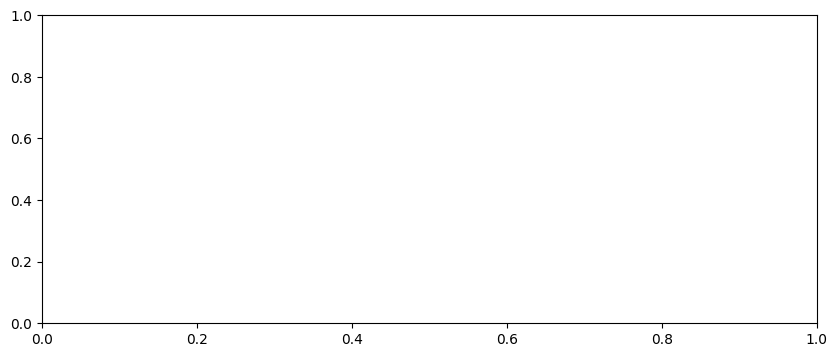

In [463]:
fig, ax = plt.subplots(figsize=(10,4))
res['crow (vol.km)'].plot(kind='barh',ax=ax, color=colors[0], position=0,width=0.4)
data = get_agg_plot_data(res,volkm_cols,num_bar)
data.plot(kind='barh',stacked=True, ax=ax,position=1,width=0.4,color=colors[1:])
spacing = (ax.get_xticks()[1] - ax.get_xticks()[0])/2
annot_position = res.iloc[0]['cycle (vol.km)'] + spacing/2
plt.ylim([-0.5,len(res)-0.5])
plt.xlim(ax.get_xticks()[0], annot_position+spacing)
plt.annotate('+' + str(np.round(res.iloc[0]['cycle/crow (%)'])-100) + '%', xy=(annot_position,-0.18), ha='center', va='bottom',fontsize=12)

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for item in legend.get_texts():
    item.set_text(item.get_text().replace(' (vol.km)', ''))
plt.gca().invert_yaxis()
plt.xlabel("Distance (vol.km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
#plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(lambda x,y: '{:,}'.format(int(x)).replace(',', ' '))

plt.title('Total cycle distance vs as the crow flies distance')
plt.savefig(output_folder+'1_total_distance_km.png',bbox_inches='tight')

In [ ]:
data = get_agg_plot_data(res, volpercent_cols, num_bar)
ax = data.plot(kind='barh',stacked=True,figsize=(10, 4),color=colors[1:])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for item in legend.get_texts():
    item.set_text(item.get_text().replace(' (%vol)', ''))
    
plt.gca().invert_yaxis()
plt.xlim([0,105])
plt.xlabel("Distance (% of vol.km)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Total percent of cycle distance')
plt.savefig(output_folder+'2_total_distance_percent.png',bbox_inches='tight')

In [ ]:
data = get_agg_plot_data(res, percent_cols, num_bar)

ax = data.plot(kind='barh',stacked=True,figsize=(10, 4),color=colors[1:])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for item in legend.get_texts():
    item.set_text(item.get_text().replace(' (%)', ''))

plt.gca().invert_yaxis()
plt.xlabel("Distance (%)")
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.title('Percent of cycleway on the network')
plt.savefig(output_folder+'3_percent_cycleway_network.png',bbox_inches='tight')

# KPI  per OD

In [ ]:
if od_file_provided:
    res = routes.groupby(['od_name','cycleway'])[['length']].agg(sum)/1000
    res = res.unstack().fillna(0)
    res.columns = res.columns.levels[1]
    res = pd.concat([res['No'], res.drop('No', axis=1)], axis=1)
    cols = res.columns
    res.columns = res.columns+' (km)'
    km_cols = res.columns
    res['cycle (km)'] = res.sum(axis=1)
    tot = res['cycle (km)']
    
    percent_cols = []
    for col in cols:
        percent_cols.append(col + ' (%)')
        res[col + ' (%)'] = 100* res[col + ' (km)'] / tot

In [ ]:
if od_file_provided:
    geom_dict = add_geometry_coordinates(nodes)[['y_geometry','x_geometry']].apply(tuple,axis=1).to_dict()
    od_test['crow (km)'] = od_test[['origin','destination']].apply(lambda x: get_flight_distance([*map(geom_dict.get, x.values)]), axis=1)/1000
    tmp_dict = od_test.set_index('name')['crow (km)'].to_dict()
    res['crow (km)'] = res.index.map(tmp_dict.get)

In [ ]:
if od_file_provided:
    res['cycle-crow (km)'] = res['cycle (km)'] - res['crow (km)']
    res['cycle/crow (%)'] = 100 * res['cycle (km)']/ res['crow (km)']

In [ ]:
if od_file_provided:
    res.to_csv(output_folder+'od_kpi.csv')

In [ ]:
if od_file_provided:
    # PLOT
    data = put_units_in_row(res)
    plot = render_mpl_table(data, header_size=12, font_size=12, row_height=0.4, col_width=1.5, index_width_ratio=2.2)
    title = 'OD table'
    plot.set_title(title , fontsize=12)
    file = output_folder+'7_'+'{title}.png'.format(title=normalize(title))
    plot.get_figure().savefig(file, bbox_inches='tight')

In [ ]:
if od_file_provided:
    fig, ax = plt.subplots(figsize=(10,10))
    res['crow (km)'].plot(kind='barh',ax=ax, color=colors[0], position=0, width=0.4)
    data = get_agg_plot_data(res, km_cols, num_bar)
    data.plot(kind='barh', stacked=True, ax=ax, position=1, width=0.4,color=colors[1:])


    spacing = (ax.get_xticks()[1] - ax.get_xticks()[0])/2
    annot_position = res['cycle (km)'].values + spacing/2
    plt.ylim([-0.5,len(res)-0.5])
    plt.xlim(ax.get_xticks()[0], max(annot_position) + spacing)
    annot_percent = ['+'+str(np.round(val)-100)+'%' for val in res['cycle/crow (%)'].values]
    for i in range(len(annot_position)):
        plt.annotate(annot_percent[i], xy=(annot_position[i], i-0.1), ha='center', va='bottom',fontsize=10)


    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for item in legend.get_texts():
        item.set_text(item.get_text().replace(' (km)', ''))
        
    plt.gca().invert_yaxis()
    plt.xlabel("Distance (km)")
    plt.ylabel('Origin-Destination name')
    plt.grid(True, 'major', linestyle='-', axis='both')
    ax.set_axisbelow(True)



    plt.title('Cycle distance vs as the crow flies distance')
    plt.savefig(output_folder+'4_od_distance_km.png',bbox_inches='tight')

In [ ]:
if od_file_provided:
    data = get_agg_plot_data(res, percent_cols, num_bar)
    ax = data.plot(kind='barh',stacked=True,figsize=(10, 10),color=colors[1:])
    plt.legend(loc="upper right", ncol=1)
    plt.gca().invert_yaxis()
    plt.xlabel("Distance (%)")
    plt.grid(True, 'major', linestyle='-', axis='both')
    ax.set_axisbelow(True)
    
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for item in legend.get_texts():
        item.set_text(item.get_text().replace(' (%)', ''))
        
    plt.title('percent of distance on cycleway')
    plt.savefig(output_folder+'5_od_distance_percent.png',bbox_inches='tight')

In [ ]:
print('*** Finish! ***')

# end

# merging

In [1167]:
'''
def merge_quenedi_rlinks(road_links,new_col):
    if 'oneway' not in road_links.columns:
        print('no column oneway. do not merge')
        return
    #get reversed links
    index_r = [idx for idx in road_links.index if idx.endswith('_r')]
    if len(index_r) == 0:
        print('all oneway, nothing to merge')
        return
    links_r = road_links.loc[index_r].copy()
    # create new reversed column with here speed and time
    links_r[new_col + '_r'] = links_r[new_col]
    # reindex with initial non _r index to merge
    links_r.index = links_r.index.map(lambda x: x[:-2])
    links_r = links_r[[new_col + '_r']]
    # drop added _r links, merge new here columns to inital two way links.
    road_links = road_links.drop(index_r, axis=0)
    # drop column if they exist before merge. dont want duplicates
    if new_col + '_r' in road_links.columns:
        road_links = road_links.drop(columns=new_col + '_r')
    road_links = pd.merge(road_links, links_r, left_index=True, right_index
                                =True, how='left')
    return road_links
'''

"\ndef merge_quenedi_rlinks(road_links,new_col):\n    if 'oneway' not in road_links.columns:\n        print('no column oneway. do not merge')\n        return\n    #get reversed links\n    index_r = [idx for idx in road_links.index if idx.endswith('_r')]\n    if len(index_r) == 0:\n        print('all oneway, nothing to merge')\n        return\n    links_r = road_links.loc[index_r].copy()\n    # create new reversed column with here speed and time\n    links_r[new_col + '_r'] = links_r[new_col]\n    # reindex with initial non _r index to merge\n    links_r.index = links_r.index.map(lambda x: x[:-2])\n    links_r = links_r[[new_col + '_r']]\n    # drop added _r links, merge new here columns to inital two way links.\n    road_links = road_links.drop(index_r, axis=0)\n    # drop column if they exist before merge. dont want duplicates\n    if new_col + '_r' in road_links.columns:\n        road_links = road_links.drop(columns=new_col + '_r')\n    road_links = pd.merge(road_links, links_r, left

In [1168]:
#links = merge_quenedi_rlinks(links,'volume')

# test